## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6654658284469051127
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6754625127
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3412427797119116585
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_5-32'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 32 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)
encoder_4, h4, c4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_3)
encoder_5, h5, c5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_4)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3, h4, c4, h5, c5]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[h2, c2])

decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[h3, c3])

decoder_4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_4, dh4, dc4 = decoder_4(decoder_outputs_3, initial_state=[h4, c4])

decoder_5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_5, dh5, dc5 = decoder_5(decoder_outputs_4, initial_state=[h5, c5])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_5, decoder_outputs_5])
decoder_concat_input = Concatenate()([decoder_outputs_5, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 32), (No 4736        input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)        [(None, 10, 32), (No 4736        input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

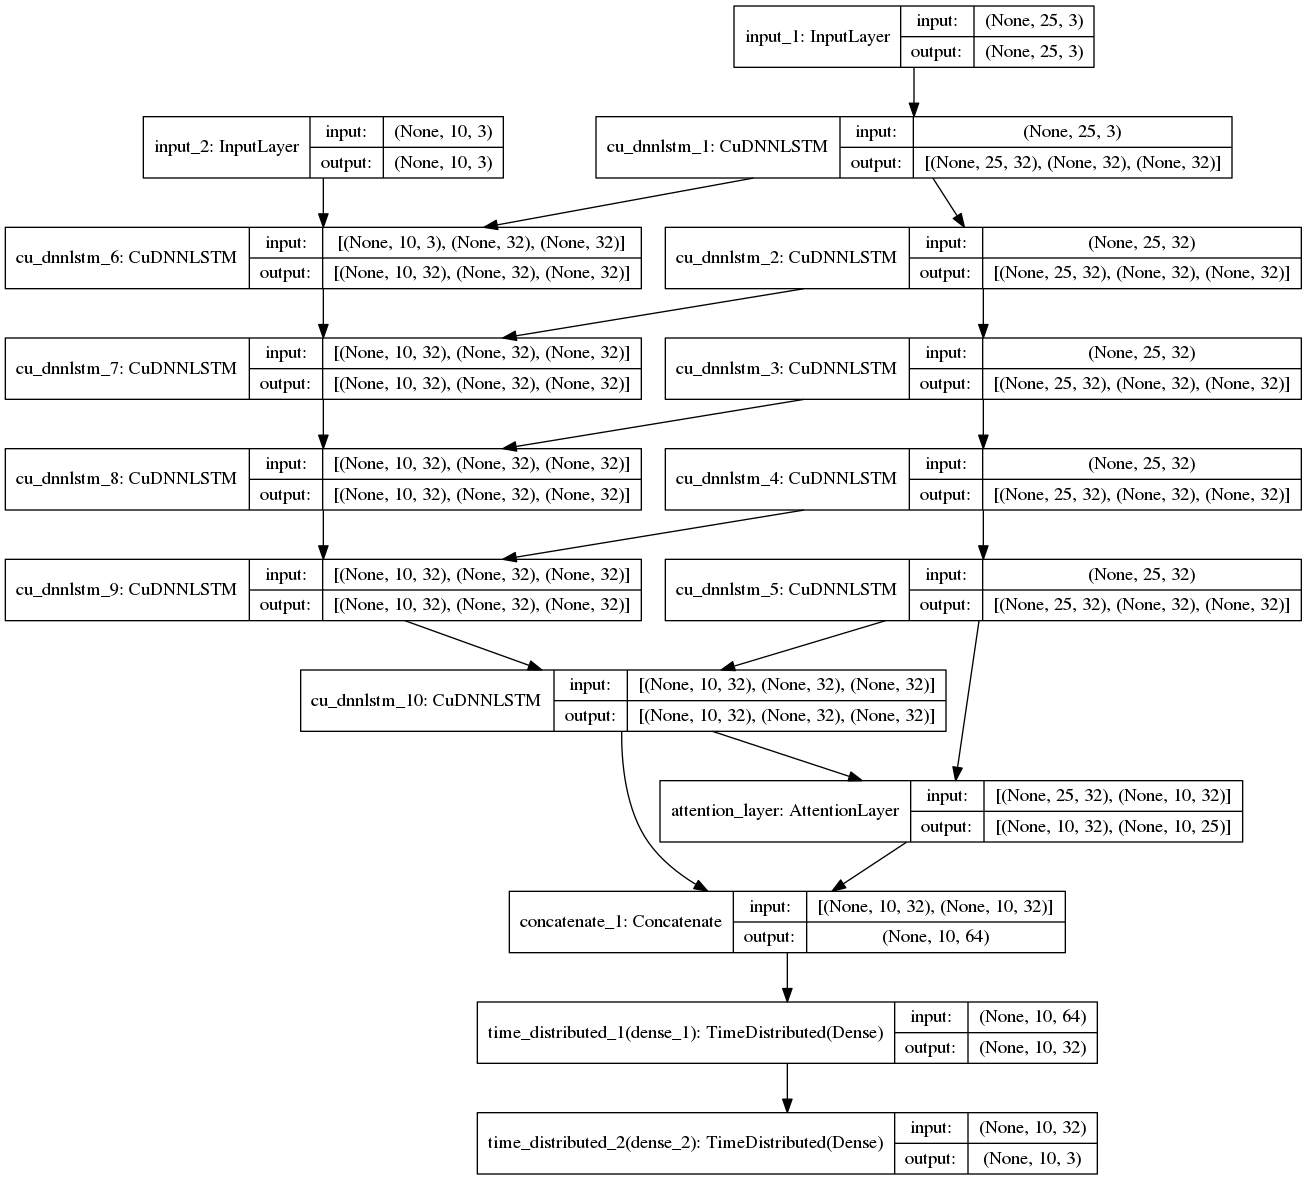

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 100
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

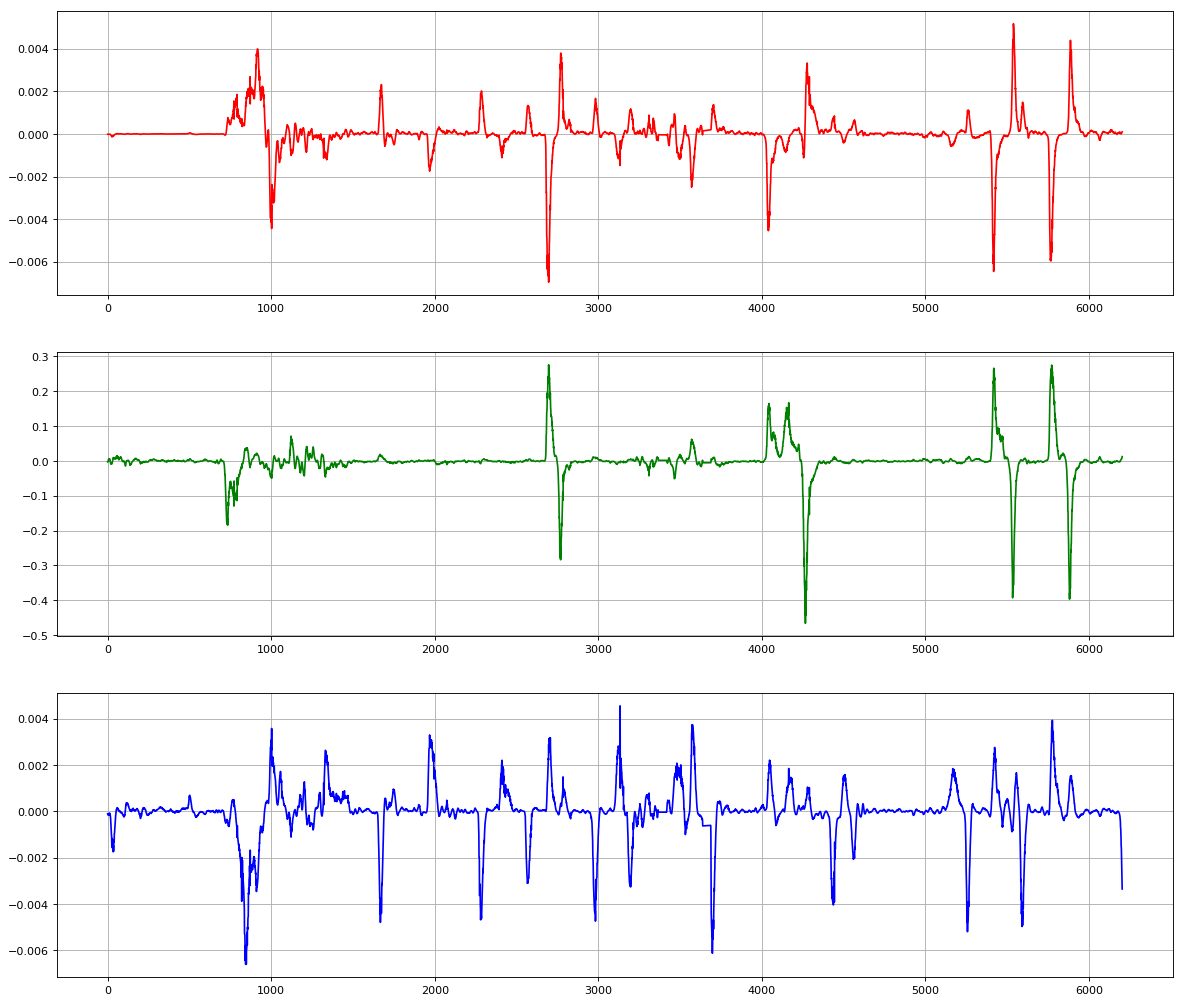

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/100


  1/542 [..............................] - ETA: 16:34 - loss: 0.0982 - rmse: 0.3120 - smape: 95.7656 - mfe: 4.6537e-04

  2/542 [..............................] - ETA: 8:46 - loss: 0.1017 - rmse: 0.2712 - smape: 91.2374 - mfe: 1.9797e-04 

  3/542 [..............................] - ETA: 6:09 - loss: 0.0835 - rmse: 0.2191 - smape: 88.7698 - mfe: 0.0023    

  4/542 [..............................] - ETA: 4:50 - loss: 0.0879 - rmse: 0.2299 - smape: 87.7116 - mfe: 0.0026

  5/542 [..............................] - ETA: 4:01 - loss: 0.0825 - rmse: 0.2270 - smape: 86.8091 - mfe: 0.0027

  6/542 [..............................] - ETA: 3:30 - loss: 0.0728 - rmse: 0.1982 - smape: 85.8652 - mfe: 0.0027

  7/542 [..............................] - ETA: 3:08 - loss: 0.0728 - rmse: 0.2015 - smape: 85.5878 - mfe: 0.0025

  8/542 [..............................] - ETA: 2:51 - loss: 0.0710 - rmse: 0.1954 - smape: 84.8388 - mfe: 0.0021

  9/542 [..............................] - ETA: 2:38 - loss: 0.0689 - rmse: 0.1898 - smape: 84.5555 - mfe: 0.0016

 10/542 [..............................] - ETA: 2:28 - loss: 0.0665 - rmse: 0.1863 - smape: 83.7999 - mfe: 9.1199e-04

 11/542 [..............................] - ETA: 2:20 - loss: 0.0651 - rmse: 0.1801 - smape: 83.2627 - mfe: 1.3794e-05

 12/542 [..............................] - ETA: 2:12 - loss: 0.0674 - rmse: 0.1839 - smape: 83.1487 - mfe: -6.4989e-04

 13/542 [..............................] - ETA: 2:05 - loss: 0.0677 - rmse: 0.1862 - smape: 83.2093 - mfe: -0.0012    

 14/542 [..............................] - ETA: 2:00 - loss: 0.0658 - rmse: 0.1852 - smape: 82.9839 - mfe: -0.0014

 15/542 [..............................] - ETA: 1:55 - loss: 0.0667 - rmse: 0.1863 - smape: 83.0401 - mfe: -0.0014

 16/542 [..............................] - ETA: 1:51 - loss: 0.0656 - rmse: 0.1815 - smape: 83.1807 - mfe: -0.0015

 17/542 [..............................] - ETA: 1:48 - loss: 0.0628 - rmse: 0.1732 - smape: 83.2208 - mfe: -0.0014

 18/542 [..............................] - ETA: 1:44 - loss: 0.0630 - rmse: 0.1736 - smape: 83.6653 - mfe: -0.0013

 19/542 [>.............................] - ETA: 1:41 - loss: 0.0608 - rmse: 0.1710 - smape: 83.4257 - mfe: -0.0011

 20/542 [>.............................] - ETA: 1:39 - loss: 0.0620 - rmse: 0.1728 - smape: 83.6654 - mfe: -8.8079e-04

 21/542 [>.............................] - ETA: 1:36 - loss: 0.0658 - rmse: 0.1856 - smape: 83.5958 - mfe: -3.9972e-04

 22/542 [>.............................] - ETA: 1:34 - loss: 0.0667 - rmse: 0.1878 - smape: 83.6415 - mfe: -2.4805e-04

 23/542 [>.............................] - ETA: 1:33 - loss: 0.0651 - rmse: 0.1834 - smape: 83.7206 - mfe: -2.0743e-04

 24/542 [>.............................] - ETA: 1:31 - loss: 0.0659 - rmse: 0.1845 - smape: 83.8774 - mfe: -2.8180e-04

 25/542 [>.............................] - ETA: 1:29 - loss: 0.0653 - rmse: 0.1836 - smape: 83.9849 - mfe: -3.9221e-04

 26/542 [>.............................] - ETA: 1:28 - loss: 0.0647 - rmse: 0.1817 - smape: 83.9555 - mfe: -5.0255e-04

 27/542 [>.............................] - ETA: 1:27 - loss: 0.0663 - rmse: 0.1862 - smape: 83.8626 - mfe: -5.2749e-04

 28/542 [>.............................] - ETA: 1:25 - loss: 0.0647 - rmse: 0.1818 - smape: 83.8375 - mfe: -6.0768e-04

 29/542 [>.............................] - ETA: 1:24 - loss: 0.0647 - rmse: 0.1820 - smape: 83.9584 - mfe: -6.6080e-04

 30/542 [>.............................] - ETA: 1:23 - loss: 0.0642 - rmse: 0.1806 - smape: 83.8995 - mfe: -7.2948e-04

 31/542 [>.............................] - ETA: 1:22 - loss: 0.0645 - rmse: 0.1809 - smape: 83.8587 - mfe: -7.1574e-04

 32/542 [>.............................] - ETA: 1:21 - loss: 0.0644 - rmse: 0.1798 - smape: 83.8685 - mfe: -7.6046e-04

 33/542 [>.............................] - ETA: 1:20 - loss: 0.0627 - rmse: 0.1753 - smape: 83.8845 - mfe: -6.8375e-04

 34/542 [>.............................] - ETA: 1:19 - loss: 0.0625 - rmse: 0.1747 - smape: 84.1072 - mfe: -6.8214e-04

 35/542 [>.............................] - ETA: 1:18 - loss: 0.0616 - rmse: 0.1717 - smape: 84.0630 - mfe: -6.2463e-04

 36/542 [>.............................] - ETA: 1:17 - loss: 0.0625 - rmse: 0.1748 - smape: 84.0156 - mfe: -5.9916e-04

 37/542 [=>............................] - ETA: 1:16 - loss: 0.0625 - rmse: 0.1746 - smape: 83.9953 - mfe: -5.8693e-04

 38/542 [=>............................] - ETA: 1:15 - loss: 0.0627 - rmse: 0.1748 - smape: 84.0578 - mfe: -5.6849e-04

 39/542 [=>............................] - ETA: 1:15 - loss: 0.0627 - rmse: 0.1754 - smape: 84.0591 - mfe: -5.6890e-04

 40/542 [=>............................] - ETA: 1:14 - loss: 0.0621 - rmse: 0.1731 - smape: 84.2485 - mfe: -5.4353e-04

 41/542 [=>............................] - ETA: 1:13 - loss: 0.0611 - rmse: 0.1708 - smape: 84.2739 - mfe: -4.9086e-04

 42/542 [=>............................] - ETA: 1:12 - loss: 0.0611 - rmse: 0.1720 - smape: 84.2654 - mfe: -5.3890e-04

 43/542 [=>............................] - ETA: 1:12 - loss: 0.0611 - rmse: 0.1726 - smape: 84.3046 - mfe: -5.2020e-04

 44/542 [=>............................] - ETA: 1:11 - loss: 0.0606 - rmse: 0.1707 - smape: 84.3404 - mfe: -4.9599e-04

 45/542 [=>............................] - ETA: 1:10 - loss: 0.0602 - rmse: 0.1695 - smape: 84.2875 - mfe: -4.6739e-04

 46/542 [=>............................] - ETA: 1:10 - loss: 0.0596 - rmse: 0.1680 - smape: 84.3209 - mfe: -4.7691e-04

 47/542 [=>............................] - ETA: 1:10 - loss: 0.0598 - rmse: 0.1684 - smape: 84.3956 - mfe: -4.9885e-04

 48/542 [=>............................] - ETA: 1:09 - loss: 0.0593 - rmse: 0.1671 - smape: 84.4917 - mfe: -4.9254e-04

 49/542 [=>............................] - ETA: 1:09 - loss: 0.0601 - rmse: 0.1686 - smape: 84.6122 - mfe: -5.0041e-04

 50/542 [=>............................] - ETA: 1:08 - loss: 0.0599 - rmse: 0.1688 - smape: 84.6155 - mfe: -5.1252e-04

 51/542 [=>............................] - ETA: 1:08 - loss: 0.0606 - rmse: 0.1696 - smape: 84.6785 - mfe: -5.2811e-04

 52/542 [=>............................] - ETA: 1:08 - loss: 0.0605 - rmse: 0.1696 - smape: 84.6468 - mfe: -5.5082e-04

 53/542 [=>............................] - ETA: 1:07 - loss: 0.0608 - rmse: 0.1698 - smape: 84.6998 - mfe: -5.8638e-04

 54/542 [=>............................] - ETA: 1:07 - loss: 0.0607 - rmse: 0.1691 - smape: 84.6997 - mfe: -5.9911e-04

 55/542 [==>...........................] - ETA: 1:06 - loss: 0.0609 - rmse: 0.1693 - smape: 84.8299 - mfe: -5.9702e-04

 56/542 [==>...........................] - ETA: 1:06 - loss: 0.0608 - rmse: 0.1687 - smape: 84.8285 - mfe: -5.8557e-04

 57/542 [==>...........................] - ETA: 1:05 - loss: 0.0610 - rmse: 0.1691 - smape: 84.8922 - mfe: -5.9793e-04

 58/542 [==>...........................] - ETA: 1:05 - loss: 0.0610 - rmse: 0.1690 - smape: 84.9834 - mfe: -5.7930e-04

 59/542 [==>...........................] - ETA: 1:05 - loss: 0.0607 - rmse: 0.1682 - smape: 85.0101 - mfe: -5.9210e-04

 60/542 [==>...........................] - ETA: 1:04 - loss: 0.0618 - rmse: 0.1703 - smape: 85.0929 - mfe: -6.3937e-04

 61/542 [==>...........................] - ETA: 1:04 - loss: 0.0618 - rmse: 0.1699 - smape: 85.1160 - mfe: -6.3665e-04

 62/542 [==>...........................] - ETA: 1:03 - loss: 0.0615 - rmse: 0.1692 - smape: 85.1528 - mfe: -6.1397e-04

 63/542 [==>...........................] - ETA: 1:03 - loss: 0.0623 - rmse: 0.1712 - smape: 85.1703 - mfe: -6.1848e-04

 64/542 [==>...........................] - ETA: 1:03 - loss: 0.0617 - rmse: 0.1708 - smape: 85.2077 - mfe: -5.8472e-04

 65/542 [==>...........................] - ETA: 1:02 - loss: 0.0626 - rmse: 0.1731 - smape: 85.2615 - mfe: -5.7570e-04

 66/542 [==>...........................] - ETA: 1:02 - loss: 0.0621 - rmse: 0.1719 - smape: 85.2202 - mfe: -5.8227e-04

 67/542 [==>...........................] - ETA: 1:02 - loss: 0.0616 - rmse: 0.1712 - smape: 85.1555 - mfe: -6.0504e-04

 68/542 [==>...........................] - ETA: 1:01 - loss: 0.0618 - rmse: 0.1712 - smape: 85.1904 - mfe: -6.3255e-04

 69/542 [==>...........................] - ETA: 1:01 - loss: 0.0612 - rmse: 0.1696 - smape: 85.1501 - mfe: -6.5719e-04

 70/542 [==>...........................] - ETA: 1:01 - loss: 0.0616 - rmse: 0.1702 - smape: 85.1606 - mfe: -6.8597e-04

 71/542 [==>...........................] - ETA: 1:00 - loss: 0.0618 - rmse: 0.1702 - smape: 85.2361 - mfe: -6.7985e-04

 72/542 [==>...........................] - ETA: 1:00 - loss: 0.0613 - rmse: 0.1685 - smape: 85.2160 - mfe: -6.7236e-04

 73/542 [===>..........................] - ETA: 1:00 - loss: 0.0617 - rmse: 0.1692 - smape: 85.2338 - mfe: -6.4768e-04

 74/542 [===>..........................] - ETA: 59s - loss: 0.0610 - rmse: 0.1677 - smape: 85.2222 - mfe: -6.1548e-04 

 75/542 [===>..........................] - ETA: 59s - loss: 0.0603 - rmse: 0.1659 - smape: 85.2124 - mfe: -6.0389e-04

 76/542 [===>..........................] - ETA: 59s - loss: 0.0603 - rmse: 0.1664 - smape: 85.2426 - mfe: -6.2967e-04

 77/542 [===>..........................] - ETA: 58s - loss: 0.0614 - rmse: 0.1686 - smape: 85.2640 - mfe: -6.5279e-04

 78/542 [===>..........................] - ETA: 58s - loss: 0.0623 - rmse: 0.1710 - smape: 85.2720 - mfe: -7.4476e-04

 79/542 [===>..........................] - ETA: 58s - loss: 0.0621 - rmse: 0.1706 - smape: 85.1955 - mfe: -7.7285e-04

 80/542 [===>..........................] - ETA: 58s - loss: 0.0619 - rmse: 0.1704 - smape: 85.1292 - mfe: -8.1132e-04

 81/542 [===>..........................] - ETA: 57s - loss: 0.0615 - rmse: 0.1702 - smape: 85.0778 - mfe: -7.9885e-04

 82/542 [===>..........................] - ETA: 57s - loss: 0.0616 - rmse: 0.1703 - smape: 85.0898 - mfe: -7.8718e-04

 83/542 [===>..........................] - ETA: 57s - loss: 0.0618 - rmse: 0.1706 - smape: 85.0444 - mfe: -7.5472e-04

 84/542 [===>..........................] - ETA: 56s - loss: 0.0618 - rmse: 0.1712 - smape: 85.0030 - mfe: -7.1359e-04

 85/542 [===>..........................] - ETA: 56s - loss: 0.0618 - rmse: 0.1714 - smape: 84.9548 - mfe: -7.0565e-04

 86/542 [===>..........................] - ETA: 56s - loss: 0.0617 - rmse: 0.1713 - smape: 84.9112 - mfe: -7.3198e-04

 87/542 [===>..........................] - ETA: 56s - loss: 0.0623 - rmse: 0.1727 - smape: 84.9252 - mfe: -8.0065e-04

 88/542 [===>..........................] - ETA: 55s - loss: 0.0624 - rmse: 0.1731 - smape: 84.8869 - mfe: -8.5566e-04

 89/542 [===>..........................] - ETA: 55s - loss: 0.0624 - rmse: 0.1735 - smape: 84.8349 - mfe: -8.6799e-04

 90/542 [===>..........................] - ETA: 55s - loss: 0.0621 - rmse: 0.1724 - smape: 84.8473 - mfe: -8.4678e-04

 91/542 [====>.........................] - ETA: 55s - loss: 0.0623 - rmse: 0.1729 - smape: 84.8315 - mfe: -8.1989e-04

 92/542 [====>.........................] - ETA: 55s - loss: 0.0628 - rmse: 0.1741 - smape: 84.8227 - mfe: -7.6861e-04

 93/542 [====>.........................] - ETA: 54s - loss: 0.0628 - rmse: 0.1738 - smape: 84.8126 - mfe: -7.4322e-04

 94/542 [====>.........................] - ETA: 54s - loss: 0.0628 - rmse: 0.1738 - smape: 84.8224 - mfe: -6.9167e-04

 95/542 [====>.........................] - ETA: 54s - loss: 0.0627 - rmse: 0.1734 - smape: 84.7939 - mfe: -6.4595e-04

 96/542 [====>.........................] - ETA: 54s - loss: 0.0626 - rmse: 0.1735 - smape: 84.7951 - mfe: -6.2367e-04

 97/542 [====>.........................] - ETA: 54s - loss: 0.0623 - rmse: 0.1724 - smape: 84.8307 - mfe: -6.1791e-04

 98/542 [====>.........................] - ETA: 53s - loss: 0.0622 - rmse: 0.1730 - smape: 84.7812 - mfe: -6.1593e-04

 99/542 [====>.........................] - ETA: 53s - loss: 0.0618 - rmse: 0.1718 - smape: 84.7465 - mfe: -6.1811e-04

100/542 [====>.........................] - ETA: 53s - loss: 0.0618 - rmse: 0.1720 - smape: 84.7175 - mfe: -6.2063e-04

101/542 [====>.........................] - ETA: 53s - loss: 0.0617 - rmse: 0.1718 - smape: 84.6918 - mfe: -6.2417e-04

102/542 [====>.........................] - ETA: 52s - loss: 0.0615 - rmse: 0.1710 - smape: 84.6783 - mfe: -6.2825e-04

103/542 [====>.........................] - ETA: 52s - loss: 0.0615 - rmse: 0.1712 - smape: 84.6328 - mfe: -6.5233e-04

104/542 [====>.........................] - ETA: 52s - loss: 0.0620 - rmse: 0.1723 - smape: 84.6226 - mfe: -6.9759e-04

105/542 [====>.........................] - ETA: 52s - loss: 0.0618 - rmse: 0.1718 - smape: 84.5761 - mfe: -7.1525e-04

106/542 [====>.........................] - ETA: 52s - loss: 0.0613 - rmse: 0.1705 - smape: 84.5127 - mfe: -7.0818e-04

107/542 [====>.........................] - ETA: 52s - loss: 0.0613 - rmse: 0.1701 - smape: 84.4963 - mfe: -7.1978e-04

108/542 [====>.........................] - ETA: 51s - loss: 0.0616 - rmse: 0.1716 - smape: 84.4536 - mfe: -7.1558e-04

109/542 [=====>........................] - ETA: 51s - loss: 0.0617 - rmse: 0.1715 - smape: 84.4394 - mfe: -6.8829e-04

110/542 [=====>........................] - ETA: 51s - loss: 0.0613 - rmse: 0.1704 - smape: 84.4292 - mfe: -6.8036e-04

111/542 [=====>........................] - ETA: 51s - loss: 0.0612 - rmse: 0.1701 - smape: 84.4041 - mfe: -7.1533e-04

112/542 [=====>........................] - ETA: 51s - loss: 0.0611 - rmse: 0.1697 - smape: 84.3892 - mfe: -7.4516e-04

113/542 [=====>........................] - ETA: 50s - loss: 0.0609 - rmse: 0.1688 - smape: 84.3705 - mfe: -7.5922e-04

114/542 [=====>........................] - ETA: 50s - loss: 0.0607 - rmse: 0.1685 - smape: 84.3422 - mfe: -7.5296e-04

115/542 [=====>........................] - ETA: 50s - loss: 0.0605 - rmse: 0.1689 - smape: 84.2925 - mfe: -7.3120e-04

116/542 [=====>........................] - ETA: 50s - loss: 0.0603 - rmse: 0.1682 - smape: 84.2917 - mfe: -7.2414e-04

117/542 [=====>........................] - ETA: 50s - loss: 0.0602 - rmse: 0.1681 - smape: 84.3126 - mfe: -7.1043e-04

118/542 [=====>........................] - ETA: 50s - loss: 0.0604 - rmse: 0.1689 - smape: 84.3116 - mfe: -7.1493e-04

119/542 [=====>........................] - ETA: 49s - loss: 0.0602 - rmse: 0.1685 - smape: 84.3109 - mfe: -6.9934e-04

120/542 [=====>........................] - ETA: 49s - loss: 0.0605 - rmse: 0.1691 - smape: 84.2980 - mfe: -7.0898e-04

121/542 [=====>........................] - ETA: 49s - loss: 0.0607 - rmse: 0.1692 - smape: 84.3264 - mfe: -7.0667e-04

122/542 [=====>........................] - ETA: 49s - loss: 0.0609 - rmse: 0.1698 - smape: 84.3210 - mfe: -7.0910e-04

123/542 [=====>........................] - ETA: 49s - loss: 0.0608 - rmse: 0.1693 - smape: 84.3043 - mfe: -7.0433e-04

124/542 [=====>........................] - ETA: 48s - loss: 0.0609 - rmse: 0.1696 - smape: 84.2867 - mfe: -7.0095e-04

125/542 [=====>........................] - ETA: 48s - loss: 0.0610 - rmse: 0.1696 - smape: 84.2871 - mfe: -7.0422e-04

126/542 [=====>........................] - ETA: 48s - loss: 0.0612 - rmse: 0.1702 - smape: 84.2747 - mfe: -7.0777e-04

127/542 [======>.......................] - ETA: 48s - loss: 0.0614 - rmse: 0.1708 - smape: 84.2554 - mfe: -6.8328e-04

128/542 [======>.......................] - ETA: 48s - loss: 0.0616 - rmse: 0.1713 - smape: 84.2283 - mfe: -6.6822e-04

129/542 [======>.......................] - ETA: 48s - loss: 0.0614 - rmse: 0.1707 - smape: 84.2104 - mfe: -6.3006e-04

130/542 [======>.......................] - ETA: 47s - loss: 0.0616 - rmse: 0.1709 - smape: 84.1677 - mfe: -6.4265e-04

131/542 [======>.......................] - ETA: 47s - loss: 0.0621 - rmse: 0.1720 - smape: 84.1311 - mfe: -6.7405e-04

132/542 [======>.......................] - ETA: 47s - loss: 0.0621 - rmse: 0.1719 - smape: 84.0955 - mfe: -6.7467e-04

133/542 [======>.......................] - ETA: 47s - loss: 0.0621 - rmse: 0.1721 - smape: 84.0663 - mfe: -6.1074e-04

134/542 [======>.......................] - ETA: 47s - loss: 0.0620 - rmse: 0.1719 - smape: 84.0143 - mfe: -5.7759e-04

135/542 [======>.......................] - ETA: 47s - loss: 0.0624 - rmse: 0.1734 - smape: 83.9759 - mfe: -5.5763e-04

136/542 [======>.......................] - ETA: 46s - loss: 0.0626 - rmse: 0.1741 - smape: 83.9457 - mfe: -5.9347e-04

137/542 [======>.......................] - ETA: 46s - loss: 0.0624 - rmse: 0.1735 - smape: 83.8911 - mfe: -6.2731e-04

138/542 [======>.......................] - ETA: 46s - loss: 0.0623 - rmse: 0.1734 - smape: 83.8748 - mfe: -6.5291e-04

139/542 [======>.......................] - ETA: 46s - loss: 0.0623 - rmse: 0.1734 - smape: 83.8527 - mfe: -6.6531e-04

140/542 [======>.......................] - ETA: 46s - loss: 0.0624 - rmse: 0.1737 - smape: 83.8483 - mfe: -6.7067e-04

141/542 [======>.......................] - ETA: 46s - loss: 0.0621 - rmse: 0.1727 - smape: 83.8443 - mfe: -6.6292e-04

142/542 [======>.......................] - ETA: 46s - loss: 0.0621 - rmse: 0.1727 - smape: 83.8466 - mfe: -6.4758e-04

143/542 [======>.......................] - ETA: 45s - loss: 0.0621 - rmse: 0.1727 - smape: 83.8418 - mfe: -6.3385e-04

144/542 [======>.......................] - ETA: 45s - loss: 0.0622 - rmse: 0.1729 - smape: 83.8482 - mfe: -6.1176e-04

145/542 [=======>......................] - ETA: 45s - loss: 0.0625 - rmse: 0.1734 - smape: 83.8687 - mfe: -5.9795e-04

146/542 [=======>......................] - ETA: 45s - loss: 0.0623 - rmse: 0.1729 - smape: 83.8743 - mfe: -5.8841e-04

147/542 [=======>......................] - ETA: 45s - loss: 0.0625 - rmse: 0.1734 - smape: 83.8782 - mfe: -5.6624e-04

148/542 [=======>......................] - ETA: 45s - loss: 0.0627 - rmse: 0.1737 - smape: 83.8942 - mfe: -5.3958e-04

149/542 [=======>......................] - ETA: 45s - loss: 0.0628 - rmse: 0.1738 - smape: 83.9042 - mfe: -5.1842e-04

150/542 [=======>......................] - ETA: 44s - loss: 0.0626 - rmse: 0.1729 - smape: 83.8844 - mfe: -5.0130e-04

151/542 [=======>......................] - ETA: 44s - loss: 0.0625 - rmse: 0.1728 - smape: 83.8808 - mfe: -4.7861e-04

152/542 [=======>......................] - ETA: 44s - loss: 0.0626 - rmse: 0.1730 - smape: 83.8929 - mfe: -4.6295e-04

153/542 [=======>......................] - ETA: 44s - loss: 0.0625 - rmse: 0.1729 - smape: 83.8957 - mfe: -4.5751e-04

154/542 [=======>......................] - ETA: 44s - loss: 0.0624 - rmse: 0.1724 - smape: 83.9213 - mfe: -4.4767e-04

155/542 [=======>......................] - ETA: 44s - loss: 0.0624 - rmse: 0.1721 - smape: 83.9485 - mfe: -4.5314e-04

156/542 [=======>......................] - ETA: 44s - loss: 0.0625 - rmse: 0.1725 - smape: 83.9526 - mfe: -4.5629e-04

157/542 [=======>......................] - ETA: 43s - loss: 0.0624 - rmse: 0.1720 - smape: 83.9626 - mfe: -4.6285e-04

158/542 [=======>......................] - ETA: 43s - loss: 0.0628 - rmse: 0.1730 - smape: 83.9626 - mfe: -4.5650e-04

159/542 [=======>......................] - ETA: 43s - loss: 0.0631 - rmse: 0.1738 - smape: 83.9655 - mfe: -4.6825e-04

160/542 [=======>......................] - ETA: 43s - loss: 0.0629 - rmse: 0.1731 - smape: 83.9544 - mfe: -4.7668e-04

161/542 [=======>......................] - ETA: 43s - loss: 0.0632 - rmse: 0.1739 - smape: 83.9603 - mfe: -4.8817e-04

162/542 [=======>......................] - ETA: 43s - loss: 0.0634 - rmse: 0.1741 - smape: 83.9763 - mfe: -4.8755e-04

163/542 [========>.....................] - ETA: 43s - loss: 0.0633 - rmse: 0.1736 - smape: 83.9981 - mfe: -4.9243e-04

164/542 [========>.....................] - ETA: 42s - loss: 0.0631 - rmse: 0.1730 - smape: 83.9863 - mfe: -4.7401e-04

165/542 [========>.....................] - ETA: 42s - loss: 0.0629 - rmse: 0.1724 - smape: 83.9959 - mfe: -4.6163e-04

166/542 [========>.....................] - ETA: 42s - loss: 0.0628 - rmse: 0.1728 - smape: 83.9792 - mfe: -4.6126e-04

167/542 [========>.....................] - ETA: 42s - loss: 0.0629 - rmse: 0.1732 - smape: 83.9726 - mfe: -4.6209e-04

168/542 [========>.....................] - ETA: 42s - loss: 0.0631 - rmse: 0.1735 - smape: 83.9720 - mfe: -4.6545e-04

169/542 [========>.....................] - ETA: 42s - loss: 0.0631 - rmse: 0.1735 - smape: 83.9653 - mfe: -4.6757e-04

170/542 [========>.....................] - ETA: 42s - loss: 0.0635 - rmse: 0.1743 - smape: 83.9515 - mfe: -4.7216e-04

171/542 [========>.....................] - ETA: 41s - loss: 0.0633 - rmse: 0.1738 - smape: 83.9305 - mfe: -4.9415e-04

172/542 [========>.....................] - ETA: 41s - loss: 0.0634 - rmse: 0.1740 - smape: 83.9024 - mfe: -5.0134e-04

173/542 [========>.....................] - ETA: 41s - loss: 0.0633 - rmse: 0.1737 - smape: 83.8803 - mfe: -5.0553e-04

174/542 [========>.....................] - ETA: 41s - loss: 0.0637 - rmse: 0.1746 - smape: 83.8593 - mfe: -4.9979e-04

175/542 [========>.....................] - ETA: 41s - loss: 0.0638 - rmse: 0.1747 - smape: 83.8330 - mfe: -4.8008e-04

176/542 [========>.....................] - ETA: 41s - loss: 0.0640 - rmse: 0.1755 - smape: 83.8097 - mfe: -4.4103e-04

177/542 [========>.....................] - ETA: 41s - loss: 0.0639 - rmse: 0.1751 - smape: 83.7865 - mfe: -4.4531e-04

178/542 [========>.....................] - ETA: 41s - loss: 0.0638 - rmse: 0.1749 - smape: 83.7610 - mfe: -4.3942e-04

179/542 [========>.....................] - ETA: 40s - loss: 0.0636 - rmse: 0.1743 - smape: 83.7446 - mfe: -4.2575e-04

180/542 [========>.....................] - ETA: 40s - loss: 0.0635 - rmse: 0.1740 - smape: 83.7259 - mfe: -4.1183e-04

181/542 [=========>....................] - ETA: 40s - loss: 0.0634 - rmse: 0.1737 - smape: 83.7329 - mfe: -3.9786e-04

182/542 [=========>....................] - ETA: 40s - loss: 0.0635 - rmse: 0.1738 - smape: 83.7299 - mfe: -4.0018e-04

183/542 [=========>....................] - ETA: 40s - loss: 0.0635 - rmse: 0.1738 - smape: 83.7160 - mfe: -4.0855e-04

184/542 [=========>....................] - ETA: 40s - loss: 0.0633 - rmse: 0.1735 - smape: 83.6884 - mfe: -4.1724e-04

185/542 [=========>....................] - ETA: 40s - loss: 0.0632 - rmse: 0.1734 - smape: 83.6658 - mfe: -4.0082e-04

186/542 [=========>....................] - ETA: 40s - loss: 0.0632 - rmse: 0.1735 - smape: 83.6626 - mfe: -4.0337e-04

187/542 [=========>....................] - ETA: 39s - loss: 0.0634 - rmse: 0.1737 - smape: 83.6741 - mfe: -4.0320e-04

188/542 [=========>....................] - ETA: 39s - loss: 0.0637 - rmse: 0.1746 - smape: 83.6706 - mfe: -3.9360e-04

189/542 [=========>....................] - ETA: 39s - loss: 0.0639 - rmse: 0.1748 - smape: 83.6705 - mfe: -3.8810e-04

190/542 [=========>....................] - ETA: 39s - loss: 0.0638 - rmse: 0.1747 - smape: 83.6586 - mfe: -3.7840e-04

191/542 [=========>....................] - ETA: 39s - loss: 0.0638 - rmse: 0.1748 - smape: 83.6599 - mfe: -3.6916e-04

192/542 [=========>....................] - ETA: 39s - loss: 0.0637 - rmse: 0.1746 - smape: 83.6567 - mfe: -3.6760e-04

193/542 [=========>....................] - ETA: 39s - loss: 0.0635 - rmse: 0.1742 - smape: 83.6598 - mfe: -3.6370e-04

194/542 [=========>....................] - ETA: 39s - loss: 0.0636 - rmse: 0.1742 - smape: 83.6335 - mfe: -3.7900e-04

195/542 [=========>....................] - ETA: 39s - loss: 0.0637 - rmse: 0.1744 - smape: 83.6286 - mfe: -3.8863e-04

196/542 [=========>....................] - ETA: 38s - loss: 0.0640 - rmse: 0.1755 - smape: 83.6246 - mfe: -4.0482e-04

197/542 [=========>....................] - ETA: 38s - loss: 0.0641 - rmse: 0.1756 - smape: 83.6055 - mfe: -4.2117e-04

198/542 [=========>....................] - ETA: 38s - loss: 0.0639 - rmse: 0.1751 - smape: 83.5842 - mfe: -4.1165e-04

199/542 [==========>...................] - ETA: 38s - loss: 0.0641 - rmse: 0.1758 - smape: 83.5824 - mfe: -4.0800e-04

200/542 [==========>...................] - ETA: 38s - loss: 0.0641 - rmse: 0.1759 - smape: 83.5679 - mfe: -3.8250e-04

201/542 [==========>...................] - ETA: 38s - loss: 0.0639 - rmse: 0.1752 - smape: 83.5694 - mfe: -3.5165e-04

202/542 [==========>...................] - ETA: 38s - loss: 0.0640 - rmse: 0.1756 - smape: 83.5685 - mfe: -3.3435e-04

203/542 [==========>...................] - ETA: 38s - loss: 0.0641 - rmse: 0.1758 - smape: 83.5695 - mfe: -3.2760e-04

204/542 [==========>...................] - ETA: 37s - loss: 0.0639 - rmse: 0.1752 - smape: 83.5518 - mfe: -3.4921e-04

205/542 [==========>...................] - ETA: 37s - loss: 0.0638 - rmse: 0.1751 - smape: 83.5365 - mfe: -3.5945e-04

206/542 [==========>...................] - ETA: 37s - loss: 0.0640 - rmse: 0.1755 - smape: 83.5406 - mfe: -3.7417e-04

207/542 [==========>...................] - ETA: 37s - loss: 0.0643 - rmse: 0.1759 - smape: 83.5423 - mfe: -3.8538e-04

208/542 [==========>...................] - ETA: 37s - loss: 0.0641 - rmse: 0.1753 - smape: 83.5293 - mfe: -3.9123e-04

209/542 [==========>...................] - ETA: 37s - loss: 0.0641 - rmse: 0.1753 - smape: 83.5314 - mfe: -4.0192e-04

210/542 [==========>...................] - ETA: 37s - loss: 0.0640 - rmse: 0.1752 - smape: 83.5222 - mfe: -3.9847e-04

211/542 [==========>...................] - ETA: 37s - loss: 0.0639 - rmse: 0.1749 - smape: 83.5320 - mfe: -4.0435e-04

212/542 [==========>...................] - ETA: 36s - loss: 0.0639 - rmse: 0.1750 - smape: 83.5138 - mfe: -3.9910e-04

213/542 [==========>...................] - ETA: 36s - loss: 0.0637 - rmse: 0.1745 - smape: 83.4989 - mfe: -4.0162e-04

214/542 [==========>...................] - ETA: 36s - loss: 0.0638 - rmse: 0.1748 - smape: 83.5025 - mfe: -4.1133e-04

215/542 [==========>...................] - ETA: 36s - loss: 0.0637 - rmse: 0.1745 - smape: 83.5036 - mfe: -4.1084e-04

216/542 [==========>...................] - ETA: 36s - loss: 0.0636 - rmse: 0.1741 - smape: 83.5099 - mfe: -4.0215e-04

217/542 [===========>..................] - ETA: 36s - loss: 0.0639 - rmse: 0.1750 - smape: 83.5180 - mfe: -3.9887e-04

218/542 [===========>..................] - ETA: 36s - loss: 0.0637 - rmse: 0.1743 - smape: 83.5167 - mfe: -4.0151e-04

219/542 [===========>..................] - ETA: 36s - loss: 0.0638 - rmse: 0.1748 - smape: 83.5088 - mfe: -4.0170e-04

220/542 [===========>..................] - ETA: 35s - loss: 0.0638 - rmse: 0.1747 - smape: 83.5112 - mfe: -4.1315e-04

221/542 [===========>..................] - ETA: 35s - loss: 0.0640 - rmse: 0.1751 - smape: 83.5052 - mfe: -4.1913e-04

222/542 [===========>..................] - ETA: 35s - loss: 0.0639 - rmse: 0.1748 - smape: 83.5107 - mfe: -4.1209e-04

223/542 [===========>..................] - ETA: 35s - loss: 0.0638 - rmse: 0.1746 - smape: 83.5112 - mfe: -4.1997e-04

224/542 [===========>..................] - ETA: 35s - loss: 0.0638 - rmse: 0.1747 - smape: 83.5192 - mfe: -4.2266e-04

225/542 [===========>..................] - ETA: 35s - loss: 0.0637 - rmse: 0.1743 - smape: 83.5034 - mfe: -4.1771e-04

226/542 [===========>..................] - ETA: 35s - loss: 0.0636 - rmse: 0.1741 - smape: 83.5036 - mfe: -4.0889e-04

227/542 [===========>..................] - ETA: 35s - loss: 0.0635 - rmse: 0.1738 - smape: 83.4984 - mfe: -4.1083e-04

228/542 [===========>..................] - ETA: 34s - loss: 0.0635 - rmse: 0.1739 - smape: 83.4938 - mfe: -4.0158e-04

229/542 [===========>..................] - ETA: 34s - loss: 0.0636 - rmse: 0.1741 - smape: 83.4672 - mfe: -3.9368e-04

230/542 [===========>..................] - ETA: 34s - loss: 0.0635 - rmse: 0.1738 - smape: 83.4693 - mfe: -3.8477e-04

231/542 [===========>..................] - ETA: 34s - loss: 0.0634 - rmse: 0.1734 - smape: 83.4538 - mfe: -3.7445e-04

232/542 [===========>..................] - ETA: 34s - loss: 0.0635 - rmse: 0.1737 - smape: 83.4507 - mfe: -3.7351e-04

233/542 [===========>..................] - ETA: 34s - loss: 0.0636 - rmse: 0.1741 - smape: 83.4365 - mfe: -3.7540e-04

234/542 [===========>..................] - ETA: 34s - loss: 0.0637 - rmse: 0.1744 - smape: 83.4263 - mfe: -3.7762e-04

235/542 [============>.................] - ETA: 34s - loss: 0.0638 - rmse: 0.1747 - smape: 83.4198 - mfe: -3.8623e-04

236/542 [============>.................] - ETA: 33s - loss: 0.0638 - rmse: 0.1748 - smape: 83.4178 - mfe: -3.9668e-04

237/542 [============>.................] - ETA: 33s - loss: 0.0640 - rmse: 0.1751 - smape: 83.4288 - mfe: -4.0459e-04

238/542 [============>.................] - ETA: 33s - loss: 0.0639 - rmse: 0.1747 - smape: 83.4122 - mfe: -4.1841e-04

239/542 [============>.................] - ETA: 33s - loss: 0.0639 - rmse: 0.1748 - smape: 83.4134 - mfe: -4.2106e-04

240/542 [============>.................] - ETA: 33s - loss: 0.0639 - rmse: 0.1748 - smape: 83.4069 - mfe: -4.2428e-04

241/542 [============>.................] - ETA: 33s - loss: 0.0639 - rmse: 0.1747 - smape: 83.3998 - mfe: -4.3386e-04

242/542 [============>.................] - ETA: 33s - loss: 0.0640 - rmse: 0.1750 - smape: 83.3909 - mfe: -4.3200e-04

243/542 [============>.................] - ETA: 33s - loss: 0.0639 - rmse: 0.1750 - smape: 83.3639 - mfe: -4.1718e-04

244/542 [============>.................] - ETA: 32s - loss: 0.0637 - rmse: 0.1744 - smape: 83.3516 - mfe: -4.1873e-04

245/542 [============>.................] - ETA: 32s - loss: 0.0636 - rmse: 0.1741 - smape: 83.3474 - mfe: -4.2259e-04

246/542 [============>.................] - ETA: 32s - loss: 0.0637 - rmse: 0.1745 - smape: 83.3418 - mfe: -4.1717e-04

247/542 [============>.................] - ETA: 32s - loss: 0.0639 - rmse: 0.1749 - smape: 83.3357 - mfe: -4.0501e-04

248/542 [============>.................] - ETA: 32s - loss: 0.0639 - rmse: 0.1746 - smape: 83.3197 - mfe: -3.9115e-04

249/542 [============>.................] - ETA: 32s - loss: 0.0639 - rmse: 0.1747 - smape: 83.3050 - mfe: -3.8167e-04

250/542 [============>.................] - ETA: 32s - loss: 0.0638 - rmse: 0.1745 - smape: 83.2942 - mfe: -3.7288e-04

251/542 [============>.................] - ETA: 32s - loss: 0.0639 - rmse: 0.1750 - smape: 83.2732 - mfe: -3.5577e-04

252/542 [============>.................] - ETA: 31s - loss: 0.0639 - rmse: 0.1749 - smape: 83.2735 - mfe: -3.5334e-04

253/542 [=============>................] - ETA: 31s - loss: 0.0640 - rmse: 0.1749 - smape: 83.2675 - mfe: -3.5073e-04

254/542 [=============>................] - ETA: 31s - loss: 0.0640 - rmse: 0.1749 - smape: 83.2630 - mfe: -3.5098e-04

255/542 [=============>................] - ETA: 31s - loss: 0.0638 - rmse: 0.1744 - smape: 83.2463 - mfe: -3.5088e-04

256/542 [=============>................] - ETA: 31s - loss: 0.0639 - rmse: 0.1749 - smape: 83.2440 - mfe: -3.6161e-04

257/542 [=============>................] - ETA: 31s - loss: 0.0640 - rmse: 0.1751 - smape: 83.2343 - mfe: -3.7962e-04

258/542 [=============>................] - ETA: 31s - loss: 0.0641 - rmse: 0.1752 - smape: 83.2345 - mfe: -3.8794e-04

259/542 [=============>................] - ETA: 31s - loss: 0.0641 - rmse: 0.1753 - smape: 83.2281 - mfe: -4.0121e-04

260/542 [=============>................] - ETA: 31s - loss: 0.0642 - rmse: 0.1756 - smape: 83.2145 - mfe: -4.1710e-04

261/542 [=============>................] - ETA: 30s - loss: 0.0642 - rmse: 0.1755 - smape: 83.2085 - mfe: -4.3278e-04

262/542 [=============>................] - ETA: 30s - loss: 0.0642 - rmse: 0.1754 - smape: 83.1880 - mfe: -4.3910e-04

263/542 [=============>................] - ETA: 30s - loss: 0.0640 - rmse: 0.1748 - smape: 83.1772 - mfe: -4.4531e-04

264/542 [=============>................] - ETA: 30s - loss: 0.0642 - rmse: 0.1753 - smape: 83.1591 - mfe: -4.5706e-04

265/542 [=============>................] - ETA: 30s - loss: 0.0643 - rmse: 0.1755 - smape: 83.1492 - mfe: -4.6561e-04

266/542 [=============>................] - ETA: 30s - loss: 0.0641 - rmse: 0.1751 - smape: 83.1411 - mfe: -4.6924e-04

267/542 [=============>................] - ETA: 30s - loss: 0.0642 - rmse: 0.1755 - smape: 83.1222 - mfe: -4.6564e-04

268/542 [=============>................] - ETA: 30s - loss: 0.0641 - rmse: 0.1752 - smape: 83.1226 - mfe: -4.5824e-04

269/542 [=============>................] - ETA: 29s - loss: 0.0642 - rmse: 0.1754 - smape: 83.1165 - mfe: -4.4055e-04

270/542 [=============>................] - ETA: 29s - loss: 0.0642 - rmse: 0.1754 - smape: 83.1083 - mfe: -4.3708e-04

271/542 [==============>...............] - ETA: 29s - loss: 0.0642 - rmse: 0.1753 - smape: 83.1089 - mfe: -4.3573e-04

272/542 [==============>...............] - ETA: 29s - loss: 0.0643 - rmse: 0.1753 - smape: 83.1115 - mfe: -4.3170e-04

273/542 [==============>...............] - ETA: 29s - loss: 0.0643 - rmse: 0.1754 - smape: 83.1082 - mfe: -4.3916e-04

274/542 [==============>...............] - ETA: 29s - loss: 0.0645 - rmse: 0.1758 - smape: 83.0989 - mfe: -4.3491e-04

275/542 [==============>...............] - ETA: 29s - loss: 0.0644 - rmse: 0.1759 - smape: 83.1016 - mfe: -4.3186e-04

276/542 [==============>...............] - ETA: 29s - loss: 0.0645 - rmse: 0.1762 - smape: 83.0845 - mfe: -4.2561e-04

277/542 [==============>...............] - ETA: 28s - loss: 0.0643 - rmse: 0.1757 - smape: 83.0800 - mfe: -4.2477e-04

278/542 [==============>...............] - ETA: 28s - loss: 0.0644 - rmse: 0.1762 - smape: 83.0636 - mfe: -4.1920e-04

279/542 [==============>...............] - ETA: 28s - loss: 0.0645 - rmse: 0.1764 - smape: 83.0639 - mfe: -4.2026e-04

280/542 [==============>...............] - ETA: 28s - loss: 0.0645 - rmse: 0.1765 - smape: 83.0493 - mfe: -4.1984e-04

281/542 [==============>...............] - ETA: 28s - loss: 0.0645 - rmse: 0.1765 - smape: 83.0448 - mfe: -4.1958e-04

282/542 [==============>...............] - ETA: 28s - loss: 0.0644 - rmse: 0.1765 - smape: 83.0437 - mfe: -4.1894e-04

283/542 [==============>...............] - ETA: 28s - loss: 0.0645 - rmse: 0.1765 - smape: 83.0243 - mfe: -4.2264e-04

284/542 [==============>...............] - ETA: 28s - loss: 0.0647 - rmse: 0.1773 - smape: 83.0155 - mfe: -4.2654e-04

285/542 [==============>...............] - ETA: 27s - loss: 0.0648 - rmse: 0.1775 - smape: 83.0132 - mfe: -4.3337e-04

286/542 [==============>...............] - ETA: 27s - loss: 0.0648 - rmse: 0.1776 - smape: 82.9951 - mfe: -4.3341e-04

287/542 [==============>...............] - ETA: 27s - loss: 0.0646 - rmse: 0.1771 - smape: 83.0070 - mfe: -4.2635e-04

288/542 [==============>...............] - ETA: 27s - loss: 0.0645 - rmse: 0.1768 - smape: 83.0082 - mfe: -4.2035e-04

289/542 [==============>...............] - ETA: 27s - loss: 0.0644 - rmse: 0.1766 - smape: 83.0096 - mfe: -4.1190e-04

290/542 [===============>..............] - ETA: 27s - loss: 0.0643 - rmse: 0.1763 - smape: 83.0065 - mfe: -4.2032e-04

291/542 [===============>..............] - ETA: 27s - loss: 0.0643 - rmse: 0.1762 - smape: 83.0056 - mfe: -4.3140e-04

292/542 [===============>..............] - ETA: 27s - loss: 0.0642 - rmse: 0.1758 - smape: 83.0048 - mfe: -4.3338e-04

293/542 [===============>..............] - ETA: 27s - loss: 0.0641 - rmse: 0.1755 - smape: 83.0020 - mfe: -4.2548e-04

294/542 [===============>..............] - ETA: 26s - loss: 0.0640 - rmse: 0.1753 - smape: 82.9917 - mfe: -4.1625e-04

295/542 [===============>..............] - ETA: 26s - loss: 0.0641 - rmse: 0.1757 - smape: 82.9935 - mfe: -4.2033e-04

296/542 [===============>..............] - ETA: 26s - loss: 0.0641 - rmse: 0.1756 - smape: 82.9911 - mfe: -4.2481e-04

297/542 [===============>..............] - ETA: 26s - loss: 0.0641 - rmse: 0.1756 - smape: 82.9809 - mfe: -4.3087e-04

298/542 [===============>..............] - ETA: 26s - loss: 0.0640 - rmse: 0.1755 - smape: 82.9747 - mfe: -4.3059e-04

299/542 [===============>..............] - ETA: 26s - loss: 0.0639 - rmse: 0.1753 - smape: 82.9642 - mfe: -4.3244e-04

300/542 [===============>..............] - ETA: 26s - loss: 0.0639 - rmse: 0.1755 - smape: 82.9650 - mfe: -4.3584e-04

301/542 [===============>..............] - ETA: 26s - loss: 0.0640 - rmse: 0.1756 - smape: 82.9651 - mfe: -4.3628e-04

302/542 [===============>..............] - ETA: 25s - loss: 0.0639 - rmse: 0.1752 - smape: 82.9677 - mfe: -4.3602e-04

303/542 [===============>..............] - ETA: 25s - loss: 0.0638 - rmse: 0.1751 - smape: 82.9600 - mfe: -4.3594e-04

304/542 [===============>..............] - ETA: 25s - loss: 0.0638 - rmse: 0.1750 - smape: 82.9547 - mfe: -4.4643e-04

305/542 [===============>..............] - ETA: 25s - loss: 0.0638 - rmse: 0.1749 - smape: 82.9434 - mfe: -4.5710e-04

306/542 [===============>..............] - ETA: 25s - loss: 0.0638 - rmse: 0.1749 - smape: 82.9478 - mfe: -4.6015e-04

307/542 [===============>..............] - ETA: 25s - loss: 0.0638 - rmse: 0.1749 - smape: 82.9424 - mfe: -4.6498e-04

308/542 [================>.............] - ETA: 25s - loss: 0.0638 - rmse: 0.1747 - smape: 82.9301 - mfe: -4.7264e-04

309/542 [================>.............] - ETA: 25s - loss: 0.0638 - rmse: 0.1746 - smape: 82.9234 - mfe: -4.8188e-04

310/542 [================>.............] - ETA: 25s - loss: 0.0639 - rmse: 0.1748 - smape: 82.9229 - mfe: -4.9513e-04

311/542 [================>.............] - ETA: 24s - loss: 0.0640 - rmse: 0.1750 - smape: 82.9127 - mfe: -5.0430e-04

312/542 [================>.............] - ETA: 24s - loss: 0.0641 - rmse: 0.1753 - smape: 82.9046 - mfe: -5.0946e-04

313/542 [================>.............] - ETA: 24s - loss: 0.0640 - rmse: 0.1749 - smape: 82.8922 - mfe: -5.0824e-04

314/542 [================>.............] - ETA: 24s - loss: 0.0640 - rmse: 0.1749 - smape: 82.9022 - mfe: -5.0421e-04

315/542 [================>.............] - ETA: 24s - loss: 0.0638 - rmse: 0.1745 - smape: 82.9029 - mfe: -4.9795e-04

316/542 [================>.............] - ETA: 24s - loss: 0.0639 - rmse: 0.1745 - smape: 82.8997 - mfe: -5.0044e-04

317/542 [================>.............] - ETA: 24s - loss: 0.0639 - rmse: 0.1744 - smape: 82.8983 - mfe: -5.0050e-04

318/542 [================>.............] - ETA: 24s - loss: 0.0639 - rmse: 0.1745 - smape: 82.8915 - mfe: -5.0457e-04

319/542 [================>.............] - ETA: 24s - loss: 0.0639 - rmse: 0.1745 - smape: 82.8904 - mfe: -5.1009e-04

320/542 [================>.............] - ETA: 23s - loss: 0.0637 - rmse: 0.1741 - smape: 82.8777 - mfe: -5.1054e-04

321/542 [================>.............] - ETA: 23s - loss: 0.0638 - rmse: 0.1742 - smape: 82.8708 - mfe: -5.0955e-04

322/542 [================>.............] - ETA: 23s - loss: 0.0638 - rmse: 0.1743 - smape: 82.8689 - mfe: -4.9401e-04

323/542 [================>.............] - ETA: 23s - loss: 0.0638 - rmse: 0.1743 - smape: 82.8611 - mfe: -4.7761e-04

324/542 [================>.............] - ETA: 23s - loss: 0.0638 - rmse: 0.1742 - smape: 82.8602 - mfe: -4.7060e-04

325/542 [================>.............] - ETA: 23s - loss: 0.0637 - rmse: 0.1741 - smape: 82.8451 - mfe: -4.7508e-04

326/542 [=================>............] - ETA: 23s - loss: 0.0637 - rmse: 0.1740 - smape: 82.8441 - mfe: -4.8140e-04

327/542 [=================>............] - ETA: 23s - loss: 0.0636 - rmse: 0.1740 - smape: 82.8290 - mfe: -4.8382e-04

328/542 [=================>............] - ETA: 23s - loss: 0.0635 - rmse: 0.1736 - smape: 82.8297 - mfe: -4.8772e-04

329/542 [=================>............] - ETA: 22s - loss: 0.0634 - rmse: 0.1733 - smape: 82.8322 - mfe: -4.8144e-04

330/542 [=================>............] - ETA: 22s - loss: 0.0633 - rmse: 0.1730 - smape: 82.8395 - mfe: -4.7484e-04

331/542 [=================>............] - ETA: 22s - loss: 0.0632 - rmse: 0.1728 - smape: 82.8308 - mfe: -4.7227e-04

332/542 [=================>............] - ETA: 22s - loss: 0.0632 - rmse: 0.1727 - smape: 82.8385 - mfe: -4.7234e-04

333/542 [=================>............] - ETA: 22s - loss: 0.0630 - rmse: 0.1723 - smape: 82.8359 - mfe: -4.6673e-04

334/542 [=================>............] - ETA: 22s - loss: 0.0630 - rmse: 0.1722 - smape: 82.8374 - mfe: -4.6769e-04

335/542 [=================>............] - ETA: 22s - loss: 0.0631 - rmse: 0.1723 - smape: 82.8296 - mfe: -4.6312e-04

336/542 [=================>............] - ETA: 22s - loss: 0.0630 - rmse: 0.1722 - smape: 82.8283 - mfe: -4.6493e-04

337/542 [=================>............] - ETA: 21s - loss: 0.0629 - rmse: 0.1723 - smape: 82.8242 - mfe: -4.5427e-04

338/542 [=================>............] - ETA: 21s - loss: 0.0629 - rmse: 0.1723 - smape: 82.8160 - mfe: -4.4406e-04

339/542 [=================>............] - ETA: 21s - loss: 0.0629 - rmse: 0.1722 - smape: 82.8158 - mfe: -4.4164e-04

340/542 [=================>............] - ETA: 21s - loss: 0.0628 - rmse: 0.1722 - smape: 82.8054 - mfe: -4.3838e-04

341/542 [=================>............] - ETA: 21s - loss: 0.0629 - rmse: 0.1724 - smape: 82.8114 - mfe: -4.4323e-04

342/542 [=================>............] - ETA: 21s - loss: 0.0629 - rmse: 0.1725 - smape: 82.8141 - mfe: -4.4235e-04

343/542 [=================>............] - ETA: 21s - loss: 0.0628 - rmse: 0.1723 - smape: 82.8065 - mfe: -4.4575e-04

344/542 [==================>...........] - ETA: 21s - loss: 0.0629 - rmse: 0.1725 - smape: 82.8112 - mfe: -4.5128e-04

345/542 [==================>...........] - ETA: 21s - loss: 0.0629 - rmse: 0.1725 - smape: 82.8071 - mfe: -4.5888e-04

346/542 [==================>...........] - ETA: 20s - loss: 0.0628 - rmse: 0.1723 - smape: 82.7966 - mfe: -4.6484e-04

347/542 [==================>...........] - ETA: 20s - loss: 0.0627 - rmse: 0.1721 - smape: 82.8018 - mfe: -4.6461e-04

348/542 [==================>...........] - ETA: 20s - loss: 0.0628 - rmse: 0.1723 - smape: 82.7984 - mfe: -4.6592e-04

349/542 [==================>...........] - ETA: 20s - loss: 0.0627 - rmse: 0.1719 - smape: 82.7913 - mfe: -4.6109e-04

350/542 [==================>...........] - ETA: 20s - loss: 0.0627 - rmse: 0.1719 - smape: 82.7881 - mfe: -4.6119e-04

351/542 [==================>...........] - ETA: 20s - loss: 0.0630 - rmse: 0.1725 - smape: 82.7854 - mfe: -4.5855e-04

352/542 [==================>...........] - ETA: 20s - loss: 0.0632 - rmse: 0.1732 - smape: 82.7801 - mfe: -4.4946e-04

353/542 [==================>...........] - ETA: 20s - loss: 0.0631 - rmse: 0.1731 - smape: 82.7777 - mfe: -4.4266e-04

354/542 [==================>...........] - ETA: 20s - loss: 0.0631 - rmse: 0.1730 - smape: 82.7834 - mfe: -4.3261e-04

355/542 [==================>...........] - ETA: 20s - loss: 0.0631 - rmse: 0.1730 - smape: 82.7739 - mfe: -4.2758e-04

356/542 [==================>...........] - ETA: 19s - loss: 0.0631 - rmse: 0.1728 - smape: 82.7727 - mfe: -4.3329e-04

357/542 [==================>...........] - ETA: 19s - loss: 0.0632 - rmse: 0.1730 - smape: 82.7567 - mfe: -4.2703e-04

358/542 [==================>...........] - ETA: 19s - loss: 0.0633 - rmse: 0.1731 - smape: 82.7478 - mfe: -4.2956e-04

359/542 [==================>...........] - ETA: 19s - loss: 0.0632 - rmse: 0.1731 - smape: 82.7259 - mfe: -4.1897e-04

360/542 [==================>...........] - ETA: 19s - loss: 0.0632 - rmse: 0.1730 - smape: 82.7170 - mfe: -4.0236e-04

361/542 [==================>...........] - ETA: 19s - loss: 0.0632 - rmse: 0.1729 - smape: 82.7135 - mfe: -3.9267e-04

362/542 [===================>..........] - ETA: 19s - loss: 0.0634 - rmse: 0.1733 - smape: 82.7041 - mfe: -3.9403e-04

363/542 [===================>..........] - ETA: 19s - loss: 0.0633 - rmse: 0.1731 - smape: 82.6907 - mfe: -4.0499e-04

364/542 [===================>..........] - ETA: 19s - loss: 0.0633 - rmse: 0.1732 - smape: 82.6950 - mfe: -4.1367e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0634 - rmse: 0.1733 - smape: 82.6912 - mfe: -4.2162e-04

366/542 [===================>..........] - ETA: 18s - loss: 0.0633 - rmse: 0.1731 - smape: 82.6839 - mfe: -4.2398e-04

367/542 [===================>..........] - ETA: 18s - loss: 0.0633 - rmse: 0.1732 - smape: 82.6809 - mfe: -4.2193e-04

368/542 [===================>..........] - ETA: 18s - loss: 0.0632 - rmse: 0.1731 - smape: 82.6777 - mfe: -4.2109e-04

369/542 [===================>..........] - ETA: 18s - loss: 0.0632 - rmse: 0.1729 - smape: 82.6860 - mfe: -4.1818e-04

370/542 [===================>..........] - ETA: 18s - loss: 0.0632 - rmse: 0.1729 - smape: 82.6811 - mfe: -4.1584e-04

371/542 [===================>..........] - ETA: 18s - loss: 0.0632 - rmse: 0.1731 - smape: 82.6832 - mfe: -4.1236e-04

372/542 [===================>..........] - ETA: 18s - loss: 0.0633 - rmse: 0.1731 - smape: 82.6876 - mfe: -4.0735e-04

373/542 [===================>..........] - ETA: 18s - loss: 0.0633 - rmse: 0.1733 - smape: 82.6890 - mfe: -3.9827e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0632 - rmse: 0.1731 - smape: 82.6849 - mfe: -4.0147e-04

375/542 [===================>..........] - ETA: 17s - loss: 0.0633 - rmse: 0.1731 - smape: 82.6860 - mfe: -4.0244e-04

376/542 [===================>..........] - ETA: 17s - loss: 0.0632 - rmse: 0.1729 - smape: 82.6890 - mfe: -4.0403e-04

377/542 [===================>..........] - ETA: 17s - loss: 0.0631 - rmse: 0.1726 - smape: 82.6826 - mfe: -4.0481e-04

378/542 [===================>..........] - ETA: 17s - loss: 0.0630 - rmse: 0.1725 - smape: 82.6753 - mfe: -4.0259e-04

379/542 [===================>..........] - ETA: 17s - loss: 0.0630 - rmse: 0.1726 - smape: 82.6625 - mfe: -3.9760e-04

380/542 [====================>.........]

 - ETA: 17s - loss: 0.0630 - rmse: 0.1726 - smape: 82.6556 - mfe: -3.9646e-04

381/542 [====================>.........] - ETA: 17s - loss: 0.0629 - rmse: 0.1724 - smape: 82.6482 - mfe: -3.9854e-04

382/542 [====================>.........] - ETA: 17s - loss: 0.0630 - rmse: 0.1724 - smape: 82.6415 - mfe: -4.0431e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0628 - rmse: 0.1721 - smape: 82.6409 - mfe: -4.0830e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0629 - rmse: 0.1723 - smape: 82.6306 - mfe: -4.0688e-04

385/542 [====================>.........] - ETA: 16s - loss: 0.0629 - rmse: 0.1724 - smape: 82.6250 - mfe: -4.0160e-04

386/542 [====================>.........] - ETA: 16s - loss: 0.0629 - rmse: 0.1724 - smape: 82.6198 - mfe: -3.9726e-04

387/542 [====================>.........] - ETA: 16s - loss: 0.0629 - rmse: 0.1724 - smape: 82.6219 - mfe: -3.9542e-04

388/542 [====================>.........] - ETA: 16s - loss: 0.0629 - rmse: 0.1724 - smape: 82.6214 - mfe: -3.9840e-04

389/542 [====================>.........] - ETA: 16s - loss: 0.0629 - rmse: 0.1724 - smape: 82.6274 - mfe: -4.0010e-04

390/542 [====================>.........] - ETA: 16s - loss: 0.0631 - rmse: 0.1729 - smape: 82.6297 - mfe: -3.9833e-04

391/542 [====================>.........] - ETA: 16s - loss: 0.0631 - rmse: 0.1729 - smape: 82.6282 - mfe: -3.9928e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0632 - rmse: 0.1733 - smape: 82.6192 - mfe: -3.9971e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0633 - rmse: 0.1733 - smape: 82.6155 - mfe: -4.1067e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0634 - rmse: 0.1736 - smape: 82.6139 - mfe: -4.1672e-04

395/542 [====================>.........] - ETA: 15s - loss: 0.0634 - rmse: 0.1734 - smape: 82.6194 - mfe: -4.1793e-04

396/542 [====================>.........] - ETA: 15s - loss: 0.0634 - rmse: 0.1735 - smape: 82.6142 - mfe: -4.1669e-04

397/542 [====================>.........] - ETA: 15s - loss: 0.0633 - rmse: 0.1735 - smape: 82.6014 - mfe: -4.0389e-04

398/542 [=====================>........] - ETA: 15s - loss: 0.0634 - rmse: 0.1735 - smape: 82.5991 - mfe: -4.0512e-04

399/542 [=====================>........] - ETA: 15s - loss: 0.0633 - rmse: 0.1734 - smape: 82.5932 - mfe: -4.1139e-04

400/542 [=====================>........] - ETA: 15s - loss: 0.0634 - rmse: 0.1735 - smape: 82.5875 - mfe: -4.2593e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0633 - rmse: 0.1734 - smape: 82.5791 - mfe: -4.4092e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0633 - rmse: 0.1732 - smape: 82.5763 - mfe: -4.4255e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0632 - rmse: 0.1731 - smape: 82.5649 - mfe: -4.4149e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0632 - rmse: 0.1731 - smape: 82.5684 - mfe: -4.3794e-04

405/542 [=====================>........] - ETA: 14s - loss: 0.0631 - rmse: 0.1729 - smape: 82.5699 - mfe: -4.3279e-04

406/542 [=====================>........] - ETA: 14s - loss: 0.0631 - rmse: 0.1731 - smape: 82.5716 - mfe: -4.3733e-04

407/542 [=====================>........] - ETA: 14s - loss: 0.0631 - rmse: 0.1730 - smape: 82.5605 - mfe: -4.4184e-04

408/542 [=====================>........] - ETA: 14s - loss: 0.0630 - rmse: 0.1729 - smape: 82.5599 - mfe: -4.4758e-04

409/542 [=====================>........] - ETA: 14s - loss: 0.0631 - rmse: 0.1731 - smape: 82.5620 - mfe: -4.5726e-04

410/542 [=====================>........] - ETA: 14s - loss: 0.0631 - rmse: 0.1731 - smape: 82.5684 - mfe: -4.5846e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0632 - rmse: 0.1731 - smape: 82.5775 - mfe: -4.5716e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0631 - rmse: 0.1728 - smape: 82.5808 - mfe: -4.5539e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0630 - rmse: 0.1727 - smape: 82.5808 - mfe: -4.5373e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0630 - rmse: 0.1726 - smape: 82.5815 - mfe: -4.5155e-04

415/542 [=====================>........] - ETA: 13s - loss: 0.0629 - rmse: 0.1725 - smape: 82.5809 - mfe: -4.4964e-04

416/542 [======================>.......] - ETA: 13s - loss: 0.0630 - rmse: 0.1726 - smape: 82.5844 - mfe: -4.5392e-04

417/542 [======================>.......] - ETA: 13s - loss: 0.0631 - rmse: 0.1727 - smape: 82.5900 - mfe: -4.5572e-04

418/542 [======================>.......] - ETA: 13s - loss: 0.0631 - rmse: 0.1726 - smape: 82.5894 - mfe: -4.5350e-04

419/542 [======================>.......] - ETA: 13s - loss: 0.0631 - rmse: 0.1728 - smape: 82.5870 - mfe: -4.5312e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0631 - rmse: 0.1729 - smape: 82.5868 - mfe: -4.5279e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0632 - rmse: 0.1729 - smape: 82.5826 - mfe: -4.5040e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0632 - rmse: 0.1730 - smape: 82.5903 - mfe: -4.4500e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0632 - rmse: 0.1731 - smape: 82.5840 - mfe: -4.4142e-04

424/542 [======================>.......] - ETA: 12s - loss: 0.0632 - rmse: 0.1730 - smape: 82.5835 - mfe: -4.3865e-04

425/542 [======================>.......] - ETA: 12s - loss: 0.0631 - rmse: 0.1730 - smape: 82.5877 - mfe: -4.3926e-04

426/542 [======================>.......] - ETA: 12s - loss: 0.0631 - rmse: 0.1728 - smape: 82.5782 - mfe: -4.4113e-04

427/542 [======================>.......] - ETA: 12s - loss: 0.0631 - rmse: 0.1728 - smape: 82.5802 - mfe: -4.4776e-04

428/542 [======================>.......] - ETA: 12s - loss: 0.0632 - rmse: 0.1731 - smape: 82.5808 - mfe: -4.5231e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0631 - rmse: 0.1729 - smape: 82.5845 - mfe: -4.5747e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0632 - rmse: 0.1730 - smape: 82.5803 - mfe: -4.5629e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0632 - rmse: 0.1730 - smape: 82.5718 - mfe: -4.5395e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0631 - rmse: 0.1729 - smape: 82.5655 - mfe: -4.5518e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0631 - rmse: 0.1729 - smape: 82.5635 - mfe: -4.5108e-04

434/542 [=======================>......] - ETA: 11s - loss: 0.0631 - rmse: 0.1729 - smape: 82.5634 - mfe: -4.4777e-04

435/542 [=======================>......] - ETA: 11s - loss: 0.0630 - rmse: 0.1725 - smape: 82.5578 - mfe: -4.4788e-04

436/542 [=======================>......] - ETA: 11s - loss: 0.0630 - rmse: 0.1726 - smape: 82.5622 - mfe: -4.4274e-04

437/542 [=======================>......] - ETA: 11s - loss: 0.0630 - rmse: 0.1725 - smape: 82.5551 - mfe: -4.3785e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0631 - rmse: 0.1727 - smape: 82.5567 - mfe: -4.3130e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0631 - rmse: 0.1726 - smape: 82.5615 - mfe: -4.2909e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0632 - rmse: 0.1728 - smape: 82.5557 - mfe: -4.2352e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0631 - rmse: 0.1727 - smape: 82.5442 - mfe: -4.1847e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0630 - rmse: 0.1726 - smape: 82.5448 - mfe: -4.1882e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0631 - rmse: 0.1727 - smape: 82.5408 - mfe: -4.1286e-04

444/542 [=======================>......] - ETA: 10s - loss: 0.0632 - rmse: 0.1729 - smape: 82.5396 - mfe: -4.0816e-04

445/542 [=======================>......] - ETA: 10s - loss: 0.0633 - rmse: 0.1734 - smape: 82.5359 - mfe: -4.0124e-04

446/542 [=======================>......] - ETA: 10s - loss: 0.0634 - rmse: 0.1735 - smape: 82.5359 - mfe: -3.9428e-04

447/542 [=======================>......] - ETA: 10s - loss: 0.0634 - rmse: 0.1736 - smape: 82.5349 - mfe: -3.9151e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0635 - rmse: 0.1737 - smape: 82.5316 - mfe: -3.9563e-04 

449/542 [=======================>......] - ETA: 9s - loss: 0.0634 - rmse: 0.1735 - smape: 82.5291 - mfe: -3.9937e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0635 - rmse: 0.1738 - smape: 82.5289 - mfe: -4.0544e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0635 - rmse: 0.1737 - smape: 82.5323 - mfe: -4.1016e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0635 - rmse: 0.1736 - smape: 82.5306 - mfe: -4.1059e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0634 - rmse: 0.1733 - smape: 82.5306 - mfe: -4.0781e-04

454/542 [========================>.....] - ETA: 9s - loss: 0.0634 - rmse: 0.1732 - smape: 82.5334 - mfe: -4.0483e-04

455/542 [========================>.....] - ETA: 9s - loss: 0.0634 - rmse: 0.1733 - smape: 82.5305 - mfe: -3.9831e-04

456/542 [========================>.....] - ETA: 9s - loss: 0.0633 - rmse: 0.1732 - smape: 82.5311 - mfe: -3.9864e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0633 - rmse: 0.1730 - smape: 82.5281 - mfe: -4.0076e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0633 - rmse: 0.1732 - smape: 82.5335 - mfe: -4.0341e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0633 - rmse: 0.1732 - smape: 82.5371 - mfe: -4.0635e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0633 - rmse: 0.1732 - smape: 82.5364 - mfe: -4.0316e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0633 - rmse: 0.1733 - smape: 82.5349 - mfe: -4.0052e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0633 - rmse: 0.1735 - smape: 82.5272 - mfe: -3.9431e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0633 - rmse: 0.1734 - smape: 82.5237 - mfe: -3.9184e-04

464/542 [========================>.....] - ETA: 8s - loss: 0.0633 - rmse: 0.1734 - smape: 82.5230 - mfe: -3.8790e-04

465/542 [========================>.....] - ETA: 8s - loss: 0.0632 - rmse: 0.1732 - smape: 82.5243 - mfe: -3.8201e-04

466/542 [========================>.....] - ETA: 8s - loss: 0.0632 - rmse: 0.1731 - smape: 82.5187 - mfe: -3.8360e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0633 - rmse: 0.1733 - smape: 82.5137 - mfe: -3.8965e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0633 - rmse: 0.1732 - smape: 82.5127 - mfe: -3.9864e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0632 - rmse: 0.1731 - smape: 82.5080 - mfe: -4.0034e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0632 - rmse: 0.1732 - smape: 82.5037 - mfe: -3.9941e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0632 - rmse: 0.1731 - smape: 82.4995 - mfe: -3.9757e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0632 - rmse: 0.1731 - smape: 82.5056 - mfe: -4.0008e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0632 - rmse: 0.1730 - smape: 82.5052 - mfe: -4.0371e-04

474/542 [=========================>....] - ETA: 7s - loss: 0.0631 - rmse: 0.1729 - smape: 82.5009 - mfe: -4.0765e-04

475/542 [=========================>....] - ETA: 7s - loss: 0.0631 - rmse: 0.1728 - smape: 82.4981 - mfe: -4.0301e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0632 - rmse: 0.1732 - smape: 82.4941 - mfe: -3.9437e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0631 - rmse: 0.1729 - smape: 82.4874 - mfe: -3.9192e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0632 - rmse: 0.1730 - smape: 82.4873 - mfe: -3.8532e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0632 - rmse: 0.1731 - smape: 82.4880 - mfe: -3.8192e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0633 - rmse: 0.1732 - smape: 82.4862 - mfe: -3.8332e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0633 - rmse: 0.1732 - smape: 82.4853 - mfe: -3.8480e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0633 - rmse: 0.1731 - smape: 82.4740 - mfe: -3.8691e-04

483/542 [=========================>....] - ETA: 6s - loss: 0.0634 - rmse: 0.1734 - smape: 82.4645 - mfe: -3.7813e-04

484/542 [=========================>....] - ETA: 6s - loss: 0.0634 - rmse: 0.1734 - smape: 82.4606 - mfe: -3.7373e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0634 - rmse: 0.1735 - smape: 82.4556 - mfe: -3.6664e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0633 - rmse: 0.1734 - smape: 82.4523 - mfe: -3.6802e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0633 - rmse: 0.1731 - smape: 82.4463 - mfe: -3.7138e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0632 - rmse: 0.1729 - smape: 82.4478 - mfe: -3.7024e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0631 - rmse: 0.1727 - smape: 82.4499 - mfe: -3.6779e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0631 - rmse: 0.1728 - smape: 82.4453 - mfe: -3.5955e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0630 - rmse: 0.1726 - smape: 82.4377 - mfe: -3.5340e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0631 - rmse: 0.1726 - smape: 82.4352 - mfe: -3.5470e-04

493/542 [==========================>...] - ETA: 5s - loss: 0.0631 - rmse: 0.1728 - smape: 82.4323 - mfe: -3.5718e-04

494/542 [==========================>...] - ETA: 5s - loss: 0.0631 - rmse: 0.1727 - smape: 82.4290 - mfe: -3.6243e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0630 - rmse: 0.1726 - smape: 82.4162 - mfe: -3.7072e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0630 - rmse: 0.1724 - smape: 82.4165 - mfe: -3.7411e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0630 - rmse: 0.1725 - smape: 82.4166 - mfe: -3.7189e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0630 - rmse: 0.1725 - smape: 82.4100 - mfe: -3.6772e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0630 - rmse: 0.1725 - smape: 82.4102 - mfe: -3.6358e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0630 - rmse: 0.1726 - smape: 82.4043 - mfe: -3.5529e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0629 - rmse: 0.1723 - smape: 82.4039 - mfe: -3.5513e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0629 - rmse: 0.1723 - smape: 82.4017 - mfe: -3.5508e-04

503/542 [==========================>...] - ETA: 4s - loss: 0.0630 - rmse: 0.1725 - smape: 82.3999 - mfe: -3.5440e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0630 - rmse: 0.1725 - smape: 82.4044 - mfe: -3.5188e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0629 - rmse: 0.1724 - smape: 82.4106 - mfe: -3.5122e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0629 - rmse: 0.1723 - smape: 82.4076 - mfe: -3.5240e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0628 - rmse: 0.1721 - smape: 82.4062 - mfe: -3.5064e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0628 - rmse: 0.1721 - smape: 82.4012 - mfe: -3.4665e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0628 - rmse: 0.1720 - smape: 82.3858 - mfe: -3.4200e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0628 - rmse: 0.1722 - smape: 82.3798 - mfe: -3.3702e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0628 - rmse: 0.1722 - smape: 82.3787 - mfe: -3.4247e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0629 - rmse: 0.1724 - smape: 82.3716 - mfe: -3.4024e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0628 - rmse: 0.1723 - smape: 82.3701 - mfe: -3.4287e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0628 - rmse: 0.1722 - smape: 82.3730 - mfe: -3.4150e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0628 - rmse: 0.1722 - smape: 82.3652 - mfe: -3.3404e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0627 - rmse: 0.1720 - smape: 82.3644 - mfe: -3.3005e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0626 - rmse: 0.1719 - smape: 82.3615 - mfe: -3.3655e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0626 - rmse: 0.1718 - smape: 82.3614 - mfe: -3.4207e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0626 - rmse: 0.1718 - smape: 82.3570 - mfe: -3.4486e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0626 - rmse: 0.1718 - smape: 82.3541 - mfe: -3.3816e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0626 - rmse: 0.1717 - smape: 82.3536 - mfe: -3.3217e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0625 - rmse: 0.1717 - smape: 82.3555 - mfe: -3.3150e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0625 - rmse: 0.1716 - smape: 82.3539 - mfe: -3.3790e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0625 - rmse: 0.1715 - smape: 82.3602 - mfe: -3.4653e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0625 - rmse: 0.1714 - smape: 82.3615 - mfe: -3.5482e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0624 - rmse: 0.1712 - smape: 82.3556 - mfe: -3.6092e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0625 - rmse: 0.1714 - smape: 82.3565 - mfe: -3.5276e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0625 - rmse: 0.1713 - smape: 82.3523 - mfe: -3.3794e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0625 - rmse: 0.1713 - smape: 82.3441 - mfe: -3.1624e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0625 - rmse: 0.1712 - smape: 82.3413 - mfe: -3.0304e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0624 - rmse: 0.1710 - smape: 82.3332 - mfe: -2.9702e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0624 - rmse: 0.1711 - smape: 82.3249 - mfe: -3.0116e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0625 - rmse: 0.1713 - smape: 82.3264 - mfe: -3.1270e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0625 - rmse: 0.1714 - smape: 82.3214 - mfe: -3.2399e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0625 - rmse: 0.1714 - smape: 82.3180 - mfe: -3.3173e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0625 - rmse: 0.1714 - smape: 82.3072 - mfe: -3.4220e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0625 - rmse: 0.1713 - smape: 82.3030 - mfe: -3.4919e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0624 - rmse: 0.1710 - smape: 82.2945 - mfe: -3.5619e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0623 - rmse: 0.1707 - smape: 82.2844 - mfe: -3.6089e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0623 - rmse: 0.1706 - smape: 82.2763 - mfe: -3.6109e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0622 - rmse: 0.1705 - smape: 82.2641 - mfe: -3.4540e-04

542/542 [==============================] - 62s 114ms/step - loss: 0.0622 - rmse: 0.1703 - smape: 82.2568 - mfe: -3.3254e-04 - val_loss: 0.0656 - val_rmse: 0.1837 - val_smape: 76.8247 - val_mfe: 0.0097


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_7 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/100
  1/542 [..............................] - ETA: 53s - loss: 0.0780 - rmse: 0.1950 - smape: 73.3274 - mfe: 0.0119

  2/542 [..............................] - ETA: 48s - loss: 0.0454 - rmse: 0.1154 - smape: 79.7455 - mfe: 0.0101

  3/542 [..............................] - ETA: 50s - loss: 0.0550 - rmse: 0.1411 - smape: 79.5474 - mfe: 0.0076

  4/542 [..............................] - ETA: 51s - loss: 0.0550 - rmse: 0.1530 - smape: 79.6798 - mfe: 0.0056

  5/542 [..............................] - ETA: 52s - loss: 0.0649 - rmse: 0.1806 - smape: 80.1204 - mfe: 0.0048

  6/542 [..............................] - ETA: 53s - loss: 0.0602 - rmse: 0.1710 - smape: 79.9371 - mfe: 0.0039

  7/542 [..............................] - ETA: 53s - loss: 0.0643 - rmse: 0.1912 - smape: 79.7530 - mfe: 0.0032

  8/542 [..............................] - ETA: 53s - loss: 0.0609 - rmse: 0.1769 - smape: 80.1903 - mfe: 0.0029

  9/542 [..............................] - ETA: 54s - loss: 0.0630 - rmse: 0.1820 - smape: 80.0582 - mfe: 0.0029

 10/542 [..............................] - ETA: 53s - loss: 0.0640 - rmse: 0.1825 - smape: 79.9944 - mfe: 0.0029

 11/542 [..............................] - ETA: 54s - loss: 0.0636 - rmse: 0.1820 - smape: 79.6419 - mfe: 0.0026

 12/542 [..............................] - ETA: 54s - loss: 0.0614 - rmse: 0.1745 - smape: 79.6089 - mfe: 0.0022

 13/542 [..............................] - ETA: 53s - loss: 0.0608 - rmse: 0.1750 - smape: 79.5464 - mfe: 0.0016

 14/542 [..............................] - ETA: 53s - loss: 0.0588 - rmse: 0.1711 - smape: 79.1550 - mfe: 0.0011

 15/542 [..............................] - ETA: 53s - loss: 0.0585 - rmse: 0.1693 - smape: 79.2477 - mfe: 7.0602e-04

 16/542 [..............................] - ETA: 53s - loss: 0.0560 - rmse: 0.1655 - smape: 79.0318 - mfe: 5.0293e-04

 17/542 [..............................] - ETA: 53s - loss: 0.0572 - rmse: 0.1686 - smape: 79.2318 - mfe: 3.5878e-04

 18/542 [..............................] - ETA: 53s - loss: 0.0564 - rmse: 0.1662 - smape: 79.2411 - mfe: 5.0606e-04

 19/542 [>.............................] - ETA: 53s - loss: 0.0549 - rmse: 0.1613 - smape: 79.3013 - mfe: 7.1169e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0564 - rmse: 0.1637 - smape: 79.4182 - mfe: 8.4271e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0547 - rmse: 0.1584 - smape: 79.4059 - mfe: 8.5000e-04

 22/542 [>.............................] - ETA: 53s - loss: 0.0544 - rmse: 0.1571 - smape: 79.4475 - mfe: 8.0330e-04

 23/542 [>.............................] - ETA: 52s - loss: 0.0573 - rmse: 0.1645 - smape: 79.5465 - mfe: 4.7898e-04

 24/542 [>.............................] - ETA: 52s - loss: 0.0567 - rmse: 0.1617 - smape: 79.6576 - mfe: 4.3728e-04

 25/542 [>.............................] - ETA: 52s - loss: 0.0564 - rmse: 0.1606 - smape: 79.7407 - mfe: 4.8036e-04

 26/542 [>.............................] - ETA: 52s - loss: 0.0563 - rmse: 0.1596 - smape: 79.9258 - mfe: 4.4455e-04

 27/542 [>.............................] - ETA: 52s - loss: 0.0577 - rmse: 0.1640 - smape: 80.0590 - mfe: 3.1503e-04

 28/542 [>.............................] - ETA: 52s - loss: 0.0580 - rmse: 0.1642 - smape: 80.0975 - mfe: 2.4028e-04

 29/542 [>.............................] - ETA: 52s - loss: 0.0572 - rmse: 0.1609 - smape: 80.3033 - mfe: 2.3264e-04

 30/542 [>.............................] - ETA: 52s - loss: 0.0559 - rmse: 0.1575 - smape: 80.3232 - mfe: 2.5960e-04

 31/542 [>.............................] - ETA: 52s - loss: 0.0544 - rmse: 0.1537 - smape: 80.2465 - mfe: 3.1979e-04

 32/542 [>.............................] - ETA: 52s - loss: 0.0547 - rmse: 0.1541 - smape: 80.3077 - mfe: 3.2758e-04

 33/542 [>.............................] - ETA: 51s - loss: 0.0542 - rmse: 0.1528 - smape: 80.2923 - mfe: 2.9542e-04

 34/542 [>.............................] - ETA: 51s - loss: 0.0538 - rmse: 0.1534 - smape: 80.2954 - mfe: 2.3672e-04

 35/542 [>.............................] - ETA: 51s - loss: 0.0533 - rmse: 0.1521 - smape: 80.1293 - mfe: 2.1959e-04

 36/542 [>.............................] - ETA: 51s - loss: 0.0537 - rmse: 0.1522 - smape: 80.0883 - mfe: 4.9731e-05

 37/542 [=>............................] - ETA: 51s - loss: 0.0548 - rmse: 0.1551 - smape: 80.1215 - mfe: -1.1289e-04

 38/542 [=>............................] - ETA: 51s - loss: 0.0544 - rmse: 0.1542 - smape: 80.0923 - mfe: -1.8444e-04

 39/542 [=>............................] - ETA: 51s - loss: 0.0549 - rmse: 0.1552 - smape: 80.0779 - mfe: -2.4888e-04

 40/542 [=>............................] - ETA: 51s - loss: 0.0548 - rmse: 0.1548 - smape: 80.1565 - mfe: -2.6780e-04

 41/542 [=>............................] - ETA: 50s - loss: 0.0539 - rmse: 0.1527 - smape: 80.1436 - mfe: -2.4790e-04

 42/542 [=>............................] - ETA: 50s - loss: 0.0545 - rmse: 0.1537 - smape: 80.2109 - mfe: -2.3056e-04

 43/542 [=>............................] - ETA: 50s - loss: 0.0561 - rmse: 0.1569 - smape: 80.2195 - mfe: -1.9359e-04

 44/542 [=>............................] - ETA: 50s - loss: 0.0569 - rmse: 0.1598 - smape: 80.2138 - mfe: -1.9341e-04

 45/542 [=>............................] - ETA: 50s - loss: 0.0564 - rmse: 0.1588 - smape: 80.1889 - mfe: -1.9268e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0563 - rmse: 0.1586 - smape: 80.2022 - mfe: -1.7449e-04

 47/542 [=>............................] - ETA: 50s - loss: 0.0558 - rmse: 0.1570 - smape: 80.2409 - mfe: -1.4894e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0563 - rmse: 0.1576 - smape: 80.2177 - mfe: -5.1802e-05

 49/542 [=>............................] - ETA: 50s - loss: 0.0555 - rmse: 0.1555 - smape: 80.1718 - mfe: -2.7178e-05

 50/542 [=>............................] - ETA: 50s - loss: 0.0546 - rmse: 0.1530 - smape: 80.1530 - mfe: -2.3375e-05

 51/542 [=>............................] - ETA: 49s - loss: 0.0538 - rmse: 0.1506 - smape: 80.1508 - mfe: -1.7888e-05

 52/542 [=>............................] - ETA: 49s - loss: 0.0536 - rmse: 0.1501 - smape: 80.1683 - mfe: 7.4105e-05 

 53/542 [=>............................] - ETA: 49s - loss: 0.0537 - rmse: 0.1499 - smape: 80.2018 - mfe: 1.0548e-04

 54/542 [=>............................] - ETA: 49s - loss: 0.0541 - rmse: 0.1517 - smape: 80.1297 - mfe: 1.5906e-04

 55/542 [==>...........................] - ETA: 49s - loss: 0.0541 - rmse: 0.1522 - smape: 80.1314 - mfe: 1.5282e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0542 - rmse: 0.1525 - smape: 80.1274 - mfe: 1.2334e-04

 57/542 [==>...........................] - ETA: 49s - loss: 0.0541 - rmse: 0.1527 - smape: 80.1409 - mfe: 8.7808e-05

 58/542 [==>...........................] - ETA: 48s - loss: 0.0540 - rmse: 0.1526 - smape: 80.1400 - mfe: 8.2250e-05

 59/542 [==>...........................] - ETA: 48s - loss: 0.0533 - rmse: 0.1506 - smape: 80.0945 - mfe: 8.5227e-05

 60/542 [==>...........................] - ETA: 48s - loss: 0.0530 - rmse: 0.1494 - smape: 80.1378 - mfe: 8.5242e-05

 61/542 [==>...........................] - ETA: 48s - loss: 0.0530 - rmse: 0.1491 - smape: 80.1846 - mfe: 6.1436e-05

 62/542 [==>...........................] - ETA: 48s - loss: 0.0529 - rmse: 0.1486 - smape: 80.2372 - mfe: 9.2063e-06

 63/542 [==>...........................] - ETA: 48s - loss: 0.0532 - rmse: 0.1494 - smape: 80.2573 - mfe: 1.7026e-05

 64/542 [==>...........................] - ETA: 48s - loss: 0.0531 - rmse: 0.1492 - smape: 80.3103 - mfe: 1.6305e-06

 65/542 [==>...........................] - ETA: 48s - loss: 0.0531 - rmse: 0.1493 - smape: 80.3520 - mfe: 1.9329e-07

 66/542 [==>...........................] - ETA: 48s - loss: 0.0531 - rmse: 0.1492 - smape: 80.4009 - mfe: 1.8189e-05

 67/542 [==>...........................] - ETA: 48s - loss: 0.0545 - rmse: 0.1529 - smape: 80.3987 - mfe: 1.0296e-04

 68/542 [==>...........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1533 - smape: 80.4437 - mfe: 1.7948e-04

 69/542 [==>...........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1538 - smape: 80.4681 - mfe: 2.0179e-04

 70/542 [==>...........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1534 - smape: 80.4807 - mfe: 1.8689e-04

 71/542 [==>...........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1528 - smape: 80.4391 - mfe: 1.5973e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1527 - smape: 80.4287 - mfe: 1.3453e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0550 - rmse: 0.1531 - smape: 80.4348 - mfe: 1.4695e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0550 - rmse: 0.1529 - smape: 80.4546 - mfe: 1.7058e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0554 - rmse: 0.1539 - smape: 80.4699 - mfe: 1.9123e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0554 - rmse: 0.1538 - smape: 80.5095 - mfe: 1.7308e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0552 - rmse: 0.1534 - smape: 80.5573 - mfe: 1.7286e-04

 78/542 [===>..........................] - ETA: 46s - loss: 0.0549 - rmse: 0.1527 - smape: 80.6057 - mfe: 1.6467e-04

 79/542 [===>..........................] - ETA: 46s - loss: 0.0547 - rmse: 0.1520 - smape: 80.6500 - mfe: 1.6323e-04

 80/542 [===>..........................] - ETA: 46s - loss: 0.0542 - rmse: 0.1506 - smape: 80.7011 - mfe: 1.6573e-04

 81/542 [===>..........................] - ETA: 46s - loss: 0.0540 - rmse: 0.1499 - smape: 80.7652 - mfe: 1.6472e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0541 - rmse: 0.1499 - smape: 80.8098 - mfe: 1.6803e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0539 - rmse: 0.1490 - smape: 80.8790 - mfe: 1.6928e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0539 - rmse: 0.1489 - smape: 80.9253 - mfe: 1.5397e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0548 - rmse: 0.1514 - smape: 80.9787 - mfe: 1.5818e-04

 86/542 [===>..........................] - ETA: 45s - loss: 0.0546 - rmse: 0.1512 - smape: 80.9622 - mfe: 1.5135e-04

 87/542 [===>..........................] - ETA: 45s - loss: 0.0556 - rmse: 0.1534 - smape: 80.9802 - mfe: 1.8614e-04

 88/542 [===>..........................] - ETA: 45s - loss: 0.0560 - rmse: 0.1540 - smape: 81.0186 - mfe: 1.7499e-04

 89/542 [===>..........................] - ETA: 45s - loss: 0.0561 - rmse: 0.1541 - smape: 81.0516 - mfe: 1.7458e-04

 90/542 [===>..........................] - ETA: 45s - loss: 0.0564 - rmse: 0.1547 - smape: 81.0535 - mfe: 1.6063e-04

 91/542 [====>.........................] - ETA: 45s - loss: 0.0561 - rmse: 0.1539 - smape: 81.0182 - mfe: 1.4306e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0562 - rmse: 0.1542 - smape: 81.0393 - mfe: 1.3916e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0565 - rmse: 0.1550 - smape: 81.0551 - mfe: 1.5951e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0566 - rmse: 0.1551 - smape: 81.0398 - mfe: 1.7194e-04

 95/542 [====>.........................] - ETA: 44s - loss: 0.0564 - rmse: 0.1544 - smape: 80.9849 - mfe: 1.7264e-04

 96/542 [====>.........................] - ETA: 44s - loss: 0.0564 - rmse: 0.1549 - smape: 80.9716 - mfe: 1.3606e-04

 97/542 [====>.........................] - ETA: 44s - loss: 0.0559 - rmse: 0.1536 - smape: 80.9893 - mfe: 1.2682e-04

 98/542 [====>.........................] - ETA: 44s - loss: 0.0560 - rmse: 0.1536 - smape: 80.9950 - mfe: 1.1862e-04

 99/542 [====>.........................] - ETA: 44s - loss: 0.0560 - rmse: 0.1537 - smape: 80.9707 - mfe: 1.1348e-04

100/542 [====>.........................] - ETA: 44s - loss: 0.0559 - rmse: 0.1534 - smape: 80.9686 - mfe: 1.0089e-04

101/542 [====>.........................] - ETA: 44s - loss: 0.0556 - rmse: 0.1532 - smape: 80.9137 - mfe: 8.0324e-05

102/542 [====>.........................] - ETA: 44s - loss: 0.0560 - rmse: 0.1546 - smape: 80.8755 - mfe: 6.0274e-05

103/542 [====>.........................] - ETA: 44s - loss: 0.0561 - rmse: 0.1548 - smape: 80.8783 - mfe: 3.9839e-05

104/542 [====>.........................] - ETA: 44s - loss: 0.0559 - rmse: 0.1544 - smape: 80.8776 - mfe: 5.6103e-05

105/542 [====>.........................] - ETA: 44s - loss: 0.0557 - rmse: 0.1541 - smape: 80.8501 - mfe: 6.5088e-05

106/542 [====>.........................] - ETA: 43s - loss: 0.0558 - rmse: 0.1541 - smape: 80.8802 - mfe: 5.8281e-05

107/542 [====>.........................] - ETA: 43s - loss: 0.0558 - rmse: 0.1545 - smape: 80.8548 - mfe: 5.3748e-05

108/542 [====>.........................] - ETA: 43s - loss: 0.0558 - rmse: 0.1544 - smape: 80.8639 - mfe: 4.2465e-05

109/542 [=====>........................] - ETA: 43s - loss: 0.0559 - rmse: 0.1545 - smape: 80.8636 - mfe: 3.8571e-05

110/542 [=====>........................] - ETA: 43s - loss: 0.0559 - rmse: 0.1545 - smape: 80.8780 - mfe: 6.1793e-05

111/542 [=====>........................] - ETA: 43s - loss: 0.0558 - rmse: 0.1541 - smape: 80.8928 - mfe: 7.3008e-05

112/542 [=====>........................] - ETA: 43s - loss: 0.0557 - rmse: 0.1537 - smape: 80.9135 - mfe: 7.8436e-05

113/542 [=====>........................] - ETA: 43s - loss: 0.0561 - rmse: 0.1544 - smape: 80.9384 - mfe: 8.8222e-05

114/542 [=====>........................] - ETA: 43s - loss: 0.0567 - rmse: 0.1557 - smape: 80.9266 - mfe: 1.0798e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0565 - rmse: 0.1554 - smape: 80.9239 - mfe: 1.2239e-04

116/542 [=====>........................] - ETA: 42s - loss: 0.0565 - rmse: 0.1549 - smape: 80.9478 - mfe: 1.3898e-04

117/542 [=====>........................] - ETA: 42s - loss: 0.0569 - rmse: 0.1560 - smape: 80.9630 - mfe: 1.8606e-04

118/542 [=====>........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1551 - smape: 80.9541 - mfe: 1.8942e-04

119/542 [=====>........................] - ETA: 42s - loss: 0.0565 - rmse: 0.1550 - smape: 80.9521 - mfe: 1.8382e-04

120/542 [=====>........................] - ETA: 42s - loss: 0.0563 - rmse: 0.1550 - smape: 80.9111 - mfe: 1.6826e-04

121/542 [=====>........................] - ETA: 42s - loss: 0.0563 - rmse: 0.1553 - smape: 80.9219 - mfe: 1.8829e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0562 - rmse: 0.1548 - smape: 80.9179 - mfe: 1.9114e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0562 - rmse: 0.1549 - smape: 80.9250 - mfe: 1.8180e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0563 - rmse: 0.1554 - smape: 80.9166 - mfe: 1.8212e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0564 - rmse: 0.1558 - smape: 80.9054 - mfe: 1.5049e-04

126/542 [=====>........................] - ETA: 41s - loss: 0.0565 - rmse: 0.1559 - smape: 80.9327 - mfe: 1.2006e-04

127/542 [======>.......................] - ETA: 41s - loss: 0.0566 - rmse: 0.1559 - smape: 80.9581 - mfe: 8.4410e-05

128/542 [======>.......................] - ETA: 41s - loss: 0.0567 - rmse: 0.1558 - smape: 80.9847 - mfe: 6.2574e-05

129/542 [======>.......................] - ETA: 41s - loss: 0.0566 - rmse: 0.1559 - smape: 80.9734 - mfe: 4.9846e-05

130/542 [======>.......................] - ETA: 41s - loss: 0.0566 - rmse: 0.1558 - smape: 80.9900 - mfe: 4.5830e-05

131/542 [======>.......................] - ETA: 41s - loss: 0.0568 - rmse: 0.1567 - smape: 80.9725 - mfe: 5.9795e-05

132/542 [======>.......................] - ETA: 41s - loss: 0.0569 - rmse: 0.1568 - smape: 80.9950 - mfe: 7.3332e-05

133/542 [======>.......................] - ETA: 41s - loss: 0.0571 - rmse: 0.1575 - smape: 81.0164 - mfe: 7.7082e-05

134/542 [======>.......................] - ETA: 41s - loss: 0.0571 - rmse: 0.1578 - smape: 80.9982 - mfe: 8.2945e-05

135/542 [======>.......................] - ETA: 41s - loss: 0.0573 - rmse: 0.1582 - smape: 81.0018 - mfe: 6.8229e-05

136/542 [======>.......................] - ETA: 41s - loss: 0.0572 - rmse: 0.1579 - smape: 81.0257 - mfe: 5.4895e-05

137/542 [======>.......................] - ETA: 40s - loss: 0.0570 - rmse: 0.1573 - smape: 81.0420 - mfe: 6.0737e-05

138/542 [======>.......................] - ETA: 40s - loss: 0.0572 - rmse: 0.1576 - smape: 81.0639 - mfe: 6.6151e-05

139/542 [======>.......................] - ETA: 40s - loss: 0.0573 - rmse: 0.1581 - smape: 81.0816 - mfe: 8.0376e-05

140/542 [======>.......................] - ETA: 40s - loss: 0.0574 - rmse: 0.1585 - smape: 81.0850 - mfe: 9.7662e-05

141/542 [======>.......................] - ETA: 40s - loss: 0.0572 - rmse: 0.1581 - smape: 81.0793 - mfe: 1.0887e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0570 - rmse: 0.1575 - smape: 81.1029 - mfe: 9.5817e-05

143/542 [======>.......................] - ETA: 40s - loss: 0.0572 - rmse: 0.1581 - smape: 81.0996 - mfe: 1.0166e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0573 - rmse: 0.1582 - smape: 81.1415 - mfe: 9.3097e-05

145/542 [=======>......................] - ETA: 40s - loss: 0.0573 - rmse: 0.1582 - smape: 81.1880 - mfe: 8.6514e-05

146/542 [=======>......................] - ETA: 39s - loss: 0.0570 - rmse: 0.1574 - smape: 81.1998 - mfe: 9.1494e-05

147/542 [=======>......................] - ETA: 39s - loss: 0.0572 - rmse: 0.1583 - smape: 81.2345 - mfe: 8.0989e-05

148/542 [=======>......................] - ETA: 39s - loss: 0.0572 - rmse: 0.1584 - smape: 81.2555 - mfe: 7.2850e-05

149/542 [=======>......................] - ETA: 39s - loss: 0.0571 - rmse: 0.1586 - smape: 81.2604 - mfe: 6.0891e-05

150/542 [=======>......................] - ETA: 39s - loss: 0.0576 - rmse: 0.1601 - smape: 81.2549 - mfe: 4.0969e-05

151/542 [=======>......................] - ETA: 39s - loss: 0.0576 - rmse: 0.1602 - smape: 81.2328 - mfe: 2.7543e-05

152/542 [=======>......................] - ETA: 39s - loss: 0.0575 - rmse: 0.1602 - smape: 81.2390 - mfe: 5.2083e-06

153/542 [=======>......................] - ETA: 39s - loss: 0.0575 - rmse: 0.1607 - smape: 81.2292 - mfe: -2.0205e-06

154/542 [=======>......................] - ETA: 39s - loss: 0.0574 - rmse: 0.1608 - smape: 81.2013 - mfe: 3.8998e-07 

155/542 [=======>......................] - ETA: 39s - loss: 0.0577 - rmse: 0.1614 - smape: 81.1840 - mfe: -1.2337e-05

156/542 [=======>......................] - ETA: 38s - loss: 0.0580 - rmse: 0.1623 - smape: 81.1775 - mfe: -3.6069e-05

157/542 [=======>......................] - ETA: 38s - loss: 0.0578 - rmse: 0.1616 - smape: 81.1942 - mfe: -3.5849e-05

158/542 [=======>......................] - ETA: 38s - loss: 0.0576 - rmse: 0.1612 - smape: 81.1830 - mfe: -2.8892e-05

159/542 [=======>......................] - ETA: 38s - loss: 0.0575 - rmse: 0.1607 - smape: 81.1954 - mfe: -8.9452e-06

160/542 [=======>......................] - ETA: 38s - loss: 0.0579 - rmse: 0.1619 - smape: 81.1886 - mfe: 3.6299e-06 

161/542 [=======>......................] - ETA: 38s - loss: 0.0580 - rmse: 0.1623 - smape: 81.1681 - mfe: -5.8109e-06

162/542 [=======>......................] - ETA: 38s - loss: 0.0580 - rmse: 0.1624 - smape: 81.1510 - mfe: -1.4362e-05

163/542 [========>.....................] - ETA: 38s - loss: 0.0581 - rmse: 0.1627 - smape: 81.1351 - mfe: -9.5178e-06

164/542 [========>.....................] - ETA: 38s - loss: 0.0582 - rmse: 0.1629 - smape: 81.1526 - mfe: -2.0041e-05

165/542 [========>.....................] - ETA: 38s - loss: 0.0584 - rmse: 0.1633 - smape: 81.1624 - mfe: -1.3424e-05

166/542 [========>.....................] - ETA: 37s - loss: 0.0584 - rmse: 0.1633 - smape: 81.1749 - mfe: -1.1378e-06

167/542 [========>.....................] - ETA: 37s - loss: 0.0583 - rmse: 0.1632 - smape: 81.1689 - mfe: 1.7728e-05 

168/542 [========>.....................] - ETA: 37s - loss: 0.0583 - rmse: 0.1631 - smape: 81.1743 - mfe: 3.0418e-05

169/542 [========>.....................] - ETA: 37s - loss: 0.0582 - rmse: 0.1628 - smape: 81.1693 - mfe: 3.0696e-05

170/542 [========>.....................] - ETA: 37s - loss: 0.0580 - rmse: 0.1623 - smape: 81.1557 - mfe: 2.5812e-05

171/542 [========>.....................] - ETA: 37s - loss: 0.0581 - rmse: 0.1627 - smape: 81.1553 - mfe: 7.7162e-07

172/542 [========>.....................] - ETA: 37s - loss: 0.0580 - rmse: 0.1625 - smape: 81.1448 - mfe: -1.7220e-05

173/542 [========>.....................] - ETA: 37s - loss: 0.0577 - rmse: 0.1618 - smape: 81.1382 - mfe: -2.3412e-05

174/542 [========>.....................] - ETA: 37s - loss: 0.0575 - rmse: 0.1616 - smape: 81.1293 - mfe: 1.5347e-06 

175/542 [========>.....................] - ETA: 37s - loss: 0.0577 - rmse: 0.1619 - smape: 81.1549 - mfe: 5.5814e-06

176/542 [========>.....................] - ETA: 36s - loss: 0.0578 - rmse: 0.1620 - smape: 81.1665 - mfe: -2.5241e-06

177/542 [========>.....................] - ETA: 36s - loss: 0.0581 - rmse: 0.1626 - smape: 81.1695 - mfe: -2.3927e-05

178/542 [========>.....................] - ETA: 36s - loss: 0.0580 - rmse: 0.1623 - smape: 81.1760 - mfe: -4.6290e-05

179/542 [========>.....................] - ETA: 36s - loss: 0.0579 - rmse: 0.1620 - smape: 81.1709 - mfe: -5.6561e-05

180/542 [========>.....................] - ETA: 36s - loss: 0.0579 - rmse: 0.1618 - smape: 81.1835 - mfe: -5.3322e-05

181/542 [=========>....................] - ETA: 36s - loss: 0.0579 - rmse: 0.1620 - smape: 81.1882 - mfe: -4.2501e-05

182/542 [=========>....................] - ETA: 36s - loss: 0.0579 - rmse: 0.1619 - smape: 81.1892 - mfe: -4.6265e-05

183/542 [=========>....................] - ETA: 36s - loss: 0.0579 - rmse: 0.1621 - smape: 81.1687 - mfe: -5.4329e-05

184/542 [=========>....................] - ETA: 36s - loss: 0.0580 - rmse: 0.1625 - smape: 81.1649 - mfe: -6.3890e-05

185/542 [=========>....................] - ETA: 36s - loss: 0.0580 - rmse: 0.1625 - smape: 81.1810 - mfe: -6.5988e-05

186/542 [=========>....................] - ETA: 35s - loss: 0.0580 - rmse: 0.1624 - smape: 81.1941 - mfe: -6.5097e-05

187/542 [=========>....................] - ETA: 35s - loss: 0.0578 - rmse: 0.1616 - smape: 81.2009 - mfe: -5.9083e-05

188/542 [=========>....................] - ETA: 35s - loss: 0.0578 - rmse: 0.1617 - smape: 81.2127 - mfe: -5.0241e-05

189/542 [=========>....................] - ETA: 35s - loss: 0.0577 - rmse: 0.1613 - smape: 81.2136 - mfe: -4.5455e-05

190/542 [=========>....................] - ETA: 35s - loss: 0.0578 - rmse: 0.1616 - smape: 81.2165 - mfe: -4.1080e-05

191/542 [=========>....................] - ETA: 35s - loss: 0.0579 - rmse: 0.1619 - smape: 81.2178 - mfe: -3.1017e-05

192/542 [=========>....................] - ETA: 35s - loss: 0.0579 - rmse: 0.1617 - smape: 81.2367 - mfe: -2.8966e-05

193/542 [=========>....................] - ETA: 35s - loss: 0.0580 - rmse: 0.1618 - smape: 81.2343 - mfe: -2.4782e-05

194/542 [=========>....................] - ETA: 35s - loss: 0.0579 - rmse: 0.1617 - smape: 81.2397 - mfe: -1.1358e-05

195/542 [=========>....................] - ETA: 34s - loss: 0.0582 - rmse: 0.1623 - smape: 81.2498 - mfe: 4.9259e-07 

196/542 [=========>....................] - ETA: 34s - loss: 0.0583 - rmse: 0.1627 - smape: 81.2521 - mfe: 7.9796e-06

197/542 [=========>....................] - ETA: 34s - loss: 0.0583 - rmse: 0.1627 - smape: 81.2374 - mfe: 1.9799e-05

198/542 [=========>....................] - ETA: 34s - loss: 0.0582 - rmse: 0.1627 - smape: 81.2217 - mfe: 2.3477e-05

199/542 [==========>...................] - ETA: 34s - loss: 0.0581 - rmse: 0.1623 - smape: 81.2356 - mfe: 2.8508e-05

200/542 [==========>...................] - ETA: 34s - loss: 0.0580 - rmse: 0.1619 - smape: 81.2357 - mfe: 2.1925e-05

201/542 [==========>...................] - ETA: 34s - loss: 0.0581 - rmse: 0.1624 - smape: 81.2364 - mfe: 1.8917e-05

202/542 [==========>...................] - ETA: 34s - loss: 0.0581 - rmse: 0.1621 - smape: 81.2579 - mfe: 1.3423e-05

203/542 [==========>...................] - ETA: 34s - loss: 0.0579 - rmse: 0.1616 - smape: 81.2595 - mfe: 1.2297e-05

204/542 [==========>...................] - ETA: 34s - loss: 0.0578 - rmse: 0.1613 - smape: 81.2759 - mfe: 1.0859e-05

205/542 [==========>...................] - ETA: 33s - loss: 0.0579 - rmse: 0.1616 - smape: 81.2768 - mfe: -4.2198e-06

206/542 [==========>...................] - ETA: 33s - loss: 0.0578 - rmse: 0.1611 - smape: 81.2755 - mfe: -2.2789e-05

207/542 [==========>...................] - ETA: 33s - loss: 0.0576 - rmse: 0.1606 - smape: 81.2768 - mfe: -2.8079e-05

208/542 [==========>...................] - ETA: 33s - loss: 0.0577 - rmse: 0.1610 - smape: 81.2933 - mfe: -1.8992e-05

209/542 [==========>...................] - ETA: 33s - loss: 0.0578 - rmse: 0.1612 - smape: 81.3093 - mfe: -9.5883e-06

210/542 [==========>...................] - ETA: 33s - loss: 0.0579 - rmse: 0.1613 - smape: 81.3104 - mfe: -8.3357e-06

211/542 [==========>...................] - ETA: 33s - loss: 0.0579 - rmse: 0.1610 - smape: 81.3264 - mfe: -7.6271e-06

212/542 [==========>...................] - ETA: 33s - loss: 0.0580 - rmse: 0.1611 - smape: 81.3405 - mfe: -1.9626e-05

213/542 [==========>...................] - ETA: 33s - loss: 0.0579 - rmse: 0.1608 - smape: 81.3332 - mfe: -2.1402e-05

214/542 [==========>...................] - ETA: 33s - loss: 0.0581 - rmse: 0.1612 - smape: 81.3373 - mfe: -2.4595e-05

215/542 [==========>...................] - ETA: 32s - loss: 0.0580 - rmse: 0.1611 - smape: 81.3346 - mfe: -1.4960e-05

216/542 [==========>...................] - ETA: 32s - loss: 0.0580 - rmse: 0.1615 - smape: 81.3295 - mfe: -1.7153e-05

217/542 [===========>..................] - ETA: 32s - loss: 0.0581 - rmse: 0.1616 - smape: 81.3482 - mfe: -2.4047e-05

218/542 [===========>..................] - ETA: 32s - loss: 0.0582 - rmse: 0.1620 - smape: 81.3521 - mfe: -2.3751e-05

219/542 [===========>..................] - ETA: 32s - loss: 0.0582 - rmse: 0.1619 - smape: 81.3685 - mfe: -1.7770e-05

220/542 [===========>..................] - ETA: 32s - loss: 0.0583 - rmse: 0.1620 - smape: 81.3801 - mfe: -1.5429e-05

221/542 [===========>..................] - ETA: 32s - loss: 0.0582 - rmse: 0.1616 - smape: 81.3842 - mfe: -1.3900e-05

222/542 [===========>..................] - ETA: 32s - loss: 0.0582 - rmse: 0.1616 - smape: 81.3939 - mfe: -8.5051e-06

223/542 [===========>..................] - ETA: 32s - loss: 0.0582 - rmse: 0.1616 - smape: 81.4086 - mfe: -1.2876e-05

224/542 [===========>..................] - ETA: 31s - loss: 0.0583 - rmse: 0.1618 - smape: 81.4189 - mfe: -2.5031e-05

225/542 [===========>..................] - ETA: 31s - loss: 0.0582 - rmse: 0.1614 - smape: 81.4269 - mfe: -3.4916e-05

226/542 [===========>..................] - ETA: 31s - loss: 0.0580 - rmse: 0.1611 - smape: 81.4235 - mfe: -4.4654e-05

227/542 [===========>..................] - ETA: 31s - loss: 0.0581 - rmse: 0.1614 - smape: 81.4267 - mfe: -4.5406e-05

228/542 [===========>..................] - ETA: 31s - loss: 0.0581 - rmse: 0.1613 - smape: 81.4228 - mfe: -3.3414e-05

229/542 [===========>..................] - ETA: 31s - loss: 0.0582 - rmse: 0.1619 - smape: 81.4117 - mfe: -1.7857e-05

230/542 [===========>..................] - ETA: 31s - loss: 0.0582 - rmse: 0.1618 - smape: 81.4141 - mfe: -2.4090e-05

231/542 [===========>..................] - ETA: 31s - loss: 0.0582 - rmse: 0.1619 - smape: 81.4156 - mfe: -2.9831e-05

232/542 [===========>..................] - ETA: 31s - loss: 0.0583 - rmse: 0.1621 - smape: 81.4221 - mfe: -4.9748e-05

233/542 [===========>..................] - ETA: 31s - loss: 0.0582 - rmse: 0.1620 - smape: 81.4096 - mfe: -6.3752e-05

234/542 [===========>..................] - ETA: 30s - loss: 0.0584 - rmse: 0.1624 - smape: 81.3965 - mfe: -5.5735e-05

235/542 [============>.................] - ETA: 30s - loss: 0.0582 - rmse: 0.1620 - smape: 81.4049 - mfe: -4.3417e-05

236/542 [============>.................] - ETA: 30s - loss: 0.0582 - rmse: 0.1618 - smape: 81.4153 - mfe: -4.1901e-05

237/542 [============>.................] - ETA: 30s - loss: 0.0581 - rmse: 0.1615 - smape: 81.4245 - mfe: -5.3991e-05

238/542 [============>.................] - ETA: 30s - loss: 0.0580 - rmse: 0.1613 - smape: 81.4204 - mfe: -6.1473e-05

239/542 [============>.................] - ETA: 30s - loss: 0.0581 - rmse: 0.1615 - smape: 81.4249 - mfe: -4.5632e-05

240/542 [============>.................] - ETA: 30s - loss: 0.0582 - rmse: 0.1616 - smape: 81.4292 - mfe: -2.4711e-05

241/542 [============>.................] - ETA: 30s - loss: 0.0582 - rmse: 0.1615 - smape: 81.4222 - mfe: -3.8296e-06

242/542 [============>.................] - ETA: 30s - loss: 0.0583 - rmse: 0.1617 - smape: 81.4281 - mfe: 7.1908e-06 

243/542 [============>.................] - ETA: 30s - loss: 0.0581 - rmse: 0.1613 - smape: 81.4052 - mfe: 2.7096e-05

244/542 [============>.................] - ETA: 29s - loss: 0.0581 - rmse: 0.1614 - smape: 81.3999 - mfe: 2.8751e-05

245/542 [============>.................] - ETA: 29s - loss: 0.0579 - rmse: 0.1608 - smape: 81.4074 - mfe: 2.9003e-05

246/542 [============>.................] - ETA: 29s - loss: 0.0579 - rmse: 0.1610 - smape: 81.3982 - mfe: 3.1461e-05

247/542 [============>.................] - ETA: 29s - loss: 0.0582 - rmse: 0.1616 - smape: 81.4106 - mfe: 3.6109e-05

248/542 [============>.................] - ETA: 29s - loss: 0.0582 - rmse: 0.1616 - smape: 81.4299 - mfe: 3.8636e-05

249/542 [============>.................] - ETA: 29s - loss: 0.0581 - rmse: 0.1614 - smape: 81.4333 - mfe: 4.0021e-05

250/542 [============>.................] - ETA: 29s - loss: 0.0581 - rmse: 0.1616 - smape: 81.4177 - mfe: 3.0274e-05

251/542 [============>.................] - ETA: 29s - loss: 0.0581 - rmse: 0.1614 - smape: 81.4331 - mfe: 1.6749e-05

252/542 [============>.................] - ETA: 29s - loss: 0.0580 - rmse: 0.1612 - smape: 81.4208 - mfe: 5.5657e-06

253/542 [=============>................] - ETA: 29s - loss: 0.0580 - rmse: 0.1613 - smape: 81.4226 - mfe: 4.7634e-06

254/542 [=============>................] - ETA: 28s - loss: 0.0579 - rmse: 0.1610 - smape: 81.4196 - mfe: 1.7075e-05

255/542 [=============>................] - ETA: 28s - loss: 0.0579 - rmse: 0.1607 - smape: 81.4259 - mfe: 2.2814e-05

256/542 [=============>................] - ETA: 28s - loss: 0.0578 - rmse: 0.1605 - smape: 81.4252 - mfe: 1.9674e-05

257/542 [=============>................] - ETA: 28s - loss: 0.0578 - rmse: 0.1606 - smape: 81.4406 - mfe: 9.5737e-06

258/542 [=============>................] - ETA: 28s - loss: 0.0577 - rmse: 0.1603 - smape: 81.4446 - mfe: 8.6074e-06

259/542 [=============>................] - ETA: 28s - loss: 0.0578 - rmse: 0.1607 - smape: 81.4380 - mfe: 6.5592e-06

260/542 [=============>................] - ETA: 28s - loss: 0.0577 - rmse: 0.1605 - smape: 81.4301 - mfe: 2.4547e-06

261/542 [=============>................] - ETA: 28s - loss: 0.0579 - rmse: 0.1607 - smape: 81.4295 - mfe: 7.9987e-06

262/542 [=============>................] - ETA: 28s - loss: 0.0580 - rmse: 0.1611 - smape: 81.4336 - mfe: 1.9041e-05

263/542 [=============>................] - ETA: 28s - loss: 0.0579 - rmse: 0.1607 - smape: 81.4320 - mfe: 2.6015e-05

264/542 [=============>................] - ETA: 27s - loss: 0.0579 - rmse: 0.1606 - smape: 81.4333 - mfe: 3.0468e-05

265/542 [=============>................] - ETA: 27s - loss: 0.0577 - rmse: 0.1602 - smape: 81.4392 - mfe: 3.1698e-05

266/542 [=============>................] - ETA: 27s - loss: 0.0577 - rmse: 0.1601 - smape: 81.4502 - mfe: 2.1718e-05

267/542 [=============>................] - ETA: 27s - loss: 0.0576 - rmse: 0.1600 - smape: 81.4339 - mfe: 1.2752e-05

268/542 [=============>................] - ETA: 27s - loss: 0.0577 - rmse: 0.1602 - smape: 81.4358 - mfe: 5.3086e-06

269/542 [=============>................] - ETA: 27s - loss: 0.0576 - rmse: 0.1599 - smape: 81.4161 - mfe: 4.3169e-06

270/542 [=============>................] - ETA: 27s - loss: 0.0577 - rmse: 0.1602 - smape: 81.4154 - mfe: 1.0538e-06

271/542 [==============>...............] - ETA: 27s - loss: 0.0577 - rmse: 0.1601 - smape: 81.4117 - mfe: 6.6805e-07

272/542 [==============>...............] - ETA: 27s - loss: 0.0576 - rmse: 0.1600 - smape: 81.3908 - mfe: -8.3304e-06

273/542 [==============>...............] - ETA: 27s - loss: 0.0577 - rmse: 0.1604 - smape: 81.3900 - mfe: -1.9810e-05

274/542 [==============>...............] - ETA: 26s - loss: 0.0577 - rmse: 0.1603 - smape: 81.3863 - mfe: -4.4190e-05

275/542 [==============>...............] - ETA: 26s - loss: 0.0578 - rmse: 0.1604 - smape: 81.3905 - mfe: -5.8686e-05

276/542 [==============>...............] - ETA: 26s - loss: 0.0579 - rmse: 0.1605 - smape: 81.3901 - mfe: -5.8416e-05

277/542 [==============>...............] - ETA: 26s - loss: 0.0579 - rmse: 0.1607 - smape: 81.3989 - mfe: -4.5389e-05

278/542 [==============>...............] - ETA: 26s - loss: 0.0580 - rmse: 0.1609 - smape: 81.3889 - mfe: -3.0706e-05

279/542 [==============>...............] - ETA: 26s - loss: 0.0580 - rmse: 0.1608 - smape: 81.4029 - mfe: -2.1829e-05

280/542 [==============>...............] - ETA: 26s - loss: 0.0580 - rmse: 0.1609 - smape: 81.4019 - mfe: -1.6066e-05

281/542 [==============>...............] - ETA: 26s - loss: 0.0581 - rmse: 0.1613 - smape: 81.3895 - mfe: -1.2578e-05

282/542 [==============>...............] - ETA: 26s - loss: 0.0583 - rmse: 0.1616 - smape: 81.3879 - mfe: -9.8854e-06

283/542 [==============>...............] - ETA: 26s - loss: 0.0583 - rmse: 0.1615 - smape: 81.3769 - mfe: -1.2271e-05

284/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1616 - smape: 81.3742 - mfe: -5.2008e-06

285/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1615 - smape: 81.3744 - mfe: -2.2042e-06

286/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1616 - smape: 81.3653 - mfe: -3.5781e-06

287/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1614 - smape: 81.3548 - mfe: -8.0458e-06

288/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1614 - smape: 81.3373 - mfe: -6.5281e-06

289/542 [==============>...............] - ETA: 25s - loss: 0.0583 - rmse: 0.1615 - smape: 81.3260 - mfe: -2.6769e-07

290/542 [===============>..............] - ETA: 25s - loss: 0.0582 - rmse: 0.1611 - smape: 81.3131 - mfe: 4.6130e-07 

291/542 [===============>..............] - ETA: 25s - loss: 0.0582 - rmse: 0.1612 - smape: 81.3049 - mfe: 2.6539e-06

292/542 [===============>..............] - ETA: 25s - loss: 0.0582 - rmse: 0.1611 - smape: 81.3053 - mfe: 5.0012e-06

293/542 [===============>..............] - ETA: 25s - loss: 0.0582 - rmse: 0.1609 - smape: 81.3196 - mfe: 2.4072e-06

294/542 [===============>..............] - ETA: 24s - loss: 0.0581 - rmse: 0.1609 - smape: 81.3030 - mfe: -1.3566e-06

295/542 [===============>..............] - ETA: 24s - loss: 0.0581 - rmse: 0.1608 - smape: 81.2960 - mfe: -1.0879e-05

296/542 [===============>..............] - ETA: 24s - loss: 0.0582 - rmse: 0.1610 - smape: 81.2984 - mfe: -1.9384e-05

297/542 [===============>..............] - ETA: 24s - loss: 0.0581 - rmse: 0.1606 - smape: 81.3046 - mfe: -2.0228e-05

298/542 [===============>..............] - ETA: 24s - loss: 0.0581 - rmse: 0.1608 - smape: 81.3123 - mfe: -1.4937e-05

299/542 [===============>..............] - ETA: 24s - loss: 0.0582 - rmse: 0.1609 - smape: 81.3124 - mfe: -6.3099e-06

300/542 [===============>..............] - ETA: 24s - loss: 0.0581 - rmse: 0.1608 - smape: 81.3217 - mfe: -6.3929e-06

301/542 [===============>..............] - ETA: 24s - loss: 0.0581 - rmse: 0.1607 - smape: 81.3285 - mfe: -1.5206e-06

302/542 [===============>..............] - ETA: 24s - loss: 0.0580 - rmse: 0.1604 - smape: 81.3307 - mfe: -3.4751e-06

303/542 [===============>..............] - ETA: 24s - loss: 0.0580 - rmse: 0.1604 - smape: 81.3355 - mfe: -7.3558e-06

304/542 [===============>..............] - ETA: 23s - loss: 0.0579 - rmse: 0.1603 - smape: 81.3257 - mfe: -1.2213e-05

305/542 [===============>..............] - ETA: 23s - loss: 0.0579 - rmse: 0.1603 - smape: 81.3262 - mfe: -2.1809e-05

306/542 [===============>..............] - ETA: 23s - loss: 0.0579 - rmse: 0.1602 - smape: 81.3233 - mfe: -3.0248e-05

307/542 [===============>..............] - ETA: 23s - loss: 0.0579 - rmse: 0.1601 - smape: 81.3209 - mfe: -3.0574e-05

308/542 [================>.............] - ETA: 23s - loss: 0.0579 - rmse: 0.1601 - smape: 81.3219 - mfe: -2.8440e-05

309/542 [================>.............] - ETA: 23s - loss: 0.0579 - rmse: 0.1599 - smape: 81.3284 - mfe: -3.1583e-05

310/542 [================>.............] - ETA: 23s - loss: 0.0579 - rmse: 0.1602 - smape: 81.3233 - mfe: -3.3623e-05

311/542 [================>.............] - ETA: 23s - loss: 0.0579 - rmse: 0.1602 - smape: 81.3248 - mfe: -3.6104e-05

312/542 [================>.............] - ETA: 23s - loss: 0.0580 - rmse: 0.1605 - smape: 81.3156 - mfe: -3.3492e-05

313/542 [================>.............] - ETA: 23s - loss: 0.0580 - rmse: 0.1604 - smape: 81.3196 - mfe: -3.2631e-05

314/542 [================>.............] - ETA: 22s - loss: 0.0581 - rmse: 0.1606 - smape: 81.3232 - mfe: -3.6377e-05

315/542 [================>.............] - ETA: 22s - loss: 0.0582 - rmse: 0.1610 - smape: 81.3260 - mfe: -3.8488e-05

316/542 [================>.............] - ETA: 22s - loss: 0.0582 - rmse: 0.1608 - smape: 81.3262 - mfe: -3.8167e-05

317/542 [================>.............] - ETA: 22s - loss: 0.0580 - rmse: 0.1604 - smape: 81.3189 - mfe: -4.0917e-05

318/542 [================>.............] - ETA: 22s - loss: 0.0581 - rmse: 0.1606 - smape: 81.3197 - mfe: -3.9881e-05

319/542 [================>.............] - ETA: 22s - loss: 0.0581 - rmse: 0.1607 - smape: 81.3186 - mfe: -3.8464e-05

320/542 [================>.............] - ETA: 22s - loss: 0.0581 - rmse: 0.1606 - smape: 81.3099 - mfe: -4.0720e-05

321/542 [================>.............] - ETA: 22s - loss: 0.0580 - rmse: 0.1604 - smape: 81.3126 - mfe: -3.5893e-05

322/542 [================>.............] - ETA: 22s - loss: 0.0579 - rmse: 0.1604 - smape: 81.3021 - mfe: -3.5689e-05

323/542 [================>.............] - ETA: 22s - loss: 0.0581 - rmse: 0.1608 - smape: 81.3033 - mfe: -3.3049e-05

324/542 [================>.............] - ETA: 21s - loss: 0.0581 - rmse: 0.1609 - smape: 81.3003 - mfe: -3.6430e-05

325/542 [================>.............] - ETA: 21s - loss: 0.0581 - rmse: 0.1609 - smape: 81.2925 - mfe: -4.1824e-05

326/542 [=================>............] - ETA: 21s - loss: 0.0581 - rmse: 0.1610 - smape: 81.2745 - mfe: -4.4997e-05

327/542 [=================>............] - ETA: 21s - loss: 0.0582 - rmse: 0.1613 - smape: 81.2616 - mfe: -5.3182e-05

328/542 [=================>............] - ETA: 21s - loss: 0.0581 - rmse: 0.1612 - smape: 81.2577 - mfe: -6.3170e-05

329/542 [=================>............] - ETA: 21s - loss: 0.0583 - rmse: 0.1618 - smape: 81.2563 - mfe: -6.3391e-05

330/542 [=================>............] - ETA: 21s - loss: 0.0584 - rmse: 0.1619 - smape: 81.2596 - mfe: -5.6385e-05

331/542 [=================>............] - ETA: 21s - loss: 0.0584 - rmse: 0.1619 - smape: 81.2636 - mfe: -5.4353e-05

332/542 [=================>............] - ETA: 21s - loss: 0.0583 - rmse: 0.1618 - smape: 81.2613 - mfe: -5.3618e-05

333/542 [=================>............] - ETA: 21s - loss: 0.0584 - rmse: 0.1618 - smape: 81.2603 - mfe: -5.6310e-05

334/542 [=================>............] - ETA: 20s - loss: 0.0583 - rmse: 0.1618 - smape: 81.2576 - mfe: -5.7818e-05

335/542 [=================>............] - ETA: 20s - loss: 0.0582 - rmse: 0.1619 - smape: 81.2516 - mfe: -5.4643e-05

336/542 [=================>............] - ETA: 20s - loss: 0.0582 - rmse: 0.1622 - smape: 81.2536 - mfe: -4.9591e-05

337/542 [=================>............] - ETA: 20s - loss: 0.0583 - rmse: 0.1625 - smape: 81.2592 - mfe: -5.5657e-05

338/542 [=================>............] - ETA: 20s - loss: 0.0583 - rmse: 0.1623 - smape: 81.2636 - mfe: -6.2426e-05

339/542 [=================>............] - ETA: 20s - loss: 0.0582 - rmse: 0.1622 - smape: 81.2717 - mfe: -7.0337e-05

340/542 [=================>............] - ETA: 20s - loss: 0.0583 - rmse: 0.1623 - smape: 81.2724 - mfe: -7.4700e-05

341/542 [=================>............] - ETA: 20s - loss: 0.0581 - rmse: 0.1619 - smape: 81.2693 - mfe: -7.5822e-05

342/542 [=================>............] - ETA: 20s - loss: 0.0581 - rmse: 0.1619 - smape: 81.2726 - mfe: -7.6844e-05

343/542 [=================>............] - ETA: 20s - loss: 0.0580 - rmse: 0.1618 - smape: 81.2633 - mfe: -7.6175e-05

344/542 [==================>...........] - ETA: 19s - loss: 0.0581 - rmse: 0.1619 - smape: 81.2719 - mfe: -7.4200e-05

345/542 [==================>...........] - ETA: 19s - loss: 0.0582 - rmse: 0.1622 - smape: 81.2656 - mfe: -7.3915e-05

346/542 [==================>...........] - ETA: 19s - loss: 0.0581 - rmse: 0.1620 - smape: 81.2649 - mfe: -7.8559e-05

347/542 [==================>...........] - ETA: 19s - loss: 0.0581 - rmse: 0.1620 - smape: 81.2688 - mfe: -7.7640e-05

348/542 [==================>...........] - ETA: 19s - loss: 0.0581 - rmse: 0.1619 - smape: 81.2636 - mfe: -7.5700e-05

349/542 [==================>...........] - ETA: 19s - loss: 0.0581 - rmse: 0.1618 - smape: 81.2657 - mfe: -7.4565e-05

350/542 [==================>...........] - ETA: 19s - loss: 0.0581 - rmse: 0.1620 - smape: 81.2640 - mfe: -7.4009e-05

351/542 [==================>...........] - ETA: 19s - loss: 0.0581 - rmse: 0.1618 - smape: 81.2625 - mfe: -7.1156e-05

352/542 [==================>...........] - ETA: 19s - loss: 0.0581 - rmse: 0.1617 - smape: 81.2516 - mfe: -6.0510e-05

353/542 [==================>...........] - ETA: 19s - loss: 0.0580 - rmse: 0.1615 - smape: 81.2407 - mfe: -6.6611e-05

354/542 [==================>...........] - ETA: 18s - loss: 0.0580 - rmse: 0.1616 - smape: 81.2410 - mfe: -7.4195e-05

355/542 [==================>...........] - ETA: 18s - loss: 0.0582 - rmse: 0.1618 - smape: 81.2410 - mfe: -7.9834e-05

356/542 [==================>...........] - ETA: 18s - loss: 0.0583 - rmse: 0.1622 - smape: 81.2418 - mfe: -8.1586e-05

357/542 [==================>...........] - ETA: 18s - loss: 0.0583 - rmse: 0.1623 - smape: 81.2311 - mfe: -8.0441e-05

358/542 [==================>...........] - ETA: 18s - loss: 0.0584 - rmse: 0.1625 - smape: 81.2271 - mfe: -8.4507e-05

359/542 [==================>...........] - ETA: 18s - loss: 0.0584 - rmse: 0.1624 - smape: 81.2225 - mfe: -9.4894e-05

360/542 [==================>...........] - ETA: 18s - loss: 0.0584 - rmse: 0.1625 - smape: 81.2203 - mfe: -9.6479e-05

361/542 [==================>...........] - ETA: 18s - loss: 0.0585 - rmse: 0.1625 - smape: 81.2169 - mfe: -9.2319e-05

362/542 [===================>..........] - ETA: 18s - loss: 0.0584 - rmse: 0.1622 - smape: 81.2220 - mfe: -9.0265e-05

363/542 [===================>..........] - ETA: 18s - loss: 0.0583 - rmse: 0.1621 - smape: 81.2261 - mfe: -8.8677e-05

364/542 [===================>..........] - ETA: 17s - loss: 0.0583 - rmse: 0.1619 - smape: 81.2225 - mfe: -8.7651e-05

365/542 [===================>..........] - ETA: 17s - loss: 0.0583 - rmse: 0.1619 - smape: 81.2150 - mfe: -7.4181e-05

366/542 [===================>..........] - ETA: 17s - loss: 0.0582 - rmse: 0.1616 - smape: 81.2196 - mfe: -6.0344e-05

367/542 [===================>..........] - ETA: 17s - loss: 0.0582 - rmse: 0.1617 - smape: 81.2103 - mfe: -5.2990e-05

368/542 [===================>..........] - ETA: 17s - loss: 0.0582 - rmse: 0.1616 - smape: 81.2109 - mfe: -4.9966e-05

369/542 [===================>..........] - ETA: 17s - loss: 0.0583 - rmse: 0.1619 - smape: 81.2015 - mfe: -3.5646e-05

370/542 [===================>..........] - ETA: 17s - loss: 0.0583 - rmse: 0.1619 - smape: 81.1947 - mfe: -2.0948e-05

371/542 [===================>..........] - ETA: 17s - loss: 0.0582 - rmse: 0.1617 - smape: 81.1795 - mfe: -2.1273e-05

372/542 [===================>..........] - ETA: 17s - loss: 0.0582 - rmse: 0.1615 - smape: 81.1805 - mfe: -1.7660e-05

373/542 [===================>..........] - ETA: 17s - loss: 0.0582 - rmse: 0.1615 - smape: 81.1799 - mfe: -9.6354e-06

374/542 [===================>..........] - ETA: 16s - loss: 0.0581 - rmse: 0.1613 - smape: 81.1784 - mfe: -7.5238e-06

375/542 [===================>..........] - ETA: 16s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1767 - mfe: -8.5106e-06

376/542 [===================>..........] - ETA: 16s - loss: 0.0582 - rmse: 0.1615 - smape: 81.1697 - mfe: -1.2348e-05

377/542 [===================>..........] - ETA: 16s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1698 - mfe: -1.7215e-05

378/542 [===================>..........] - ETA: 16s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1694 - mfe: -1.7939e-05

379/542 [===================>..........] - ETA: 16s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1781 - mfe: -9.8962e-06

380/542 [====================>.........] - ETA: 16s - loss: 0.0581 - rmse: 0.1611 - smape: 81.1819 - mfe: -7.8507e-06

381/542 [====================>.........] - ETA: 16s - loss: 0.0579 - rmse: 0.1607 - smape: 81.1822 - mfe: -1.2761e-05

382/542 [====================>.........] - ETA: 16s - loss: 0.0580 - rmse: 0.1610 - smape: 81.1853 - mfe: -1.1711e-05

383/542 [====================>.........] - ETA: 16s - loss: 0.0581 - rmse: 0.1612 - smape: 81.1819 - mfe: -1.2754e-05

384/542 [====================>.........] - ETA: 15s - loss: 0.0581 - rmse: 0.1613 - smape: 81.1810 - mfe: -6.1624e-06

385/542 [====================>.........] - ETA: 15s - loss: 0.0581 - rmse: 0.1613 - smape: 81.1734 - mfe: -7.5339e-07

386/542 [====================>.........] - ETA: 15s - loss: 0.0582 - rmse: 0.1614 - smape: 81.1694 - mfe: 1.2616e-05 

387/542 [====================>.........] - ETA: 15s - loss: 0.0583 - rmse: 0.1617 - smape: 81.1634 - mfe: 1.4232e-05

388/542 [====================>.........] - ETA: 15s - loss: 0.0582 - rmse: 0.1615 - smape: 81.1596 - mfe: 1.5776e-05

389/542 [====================>.........] - ETA: 15s - loss: 0.0581 - rmse: 0.1613 - smape: 81.1571 - mfe: 1.7126e-05

390/542 [====================>.........] - ETA: 15s - loss: 0.0581 - rmse: 0.1614 - smape: 81.1575 - mfe: 2.3617e-05

391/542 [====================>.........] - ETA: 15s - loss: 0.0581 - rmse: 0.1613 - smape: 81.1589 - mfe: 2.9068e-05

392/542 [====================>.........] - ETA: 15s - loss: 0.0582 - rmse: 0.1616 - smape: 81.1530 - mfe: 2.5694e-05

393/542 [====================>.........] - ETA: 15s - loss: 0.0582 - rmse: 0.1615 - smape: 81.1544 - mfe: 1.8943e-05

394/542 [====================>.........] - ETA: 14s - loss: 0.0581 - rmse: 0.1614 - smape: 81.1643 - mfe: 1.4159e-05

395/542 [====================>.........] - ETA: 14s - loss: 0.0581 - rmse: 0.1614 - smape: 81.1665 - mfe: 1.2241e-05

396/542 [====================>.........] - ETA: 14s - loss: 0.0580 - rmse: 0.1611 - smape: 81.1602 - mfe: 1.0372e-05

397/542 [====================>.........] - ETA: 14s - loss: 0.0581 - rmse: 0.1611 - smape: 81.1592 - mfe: 6.8824e-06

398/542 [=====================>........] - ETA: 14s - loss: 0.0579 - rmse: 0.1607 - smape: 81.1639 - mfe: 5.7551e-06

399/542 [=====================>........] - ETA: 14s - loss: 0.0578 - rmse: 0.1605 - smape: 81.1465 - mfe: 7.1942e-06

400/542 [=====================>........] - ETA: 14s - loss: 0.0578 - rmse: 0.1606 - smape: 81.1400 - mfe: 9.7152e-06

401/542 [=====================>........] - ETA: 14s - loss: 0.0579 - rmse: 0.1606 - smape: 81.1411 - mfe: 4.7445e-06

402/542 [=====================>........] - ETA: 14s - loss: 0.0578 - rmse: 0.1606 - smape: 81.1422 - mfe: 2.0163e-06

403/542 [=====================>........] - ETA: 14s - loss: 0.0578 - rmse: 0.1605 - smape: 81.1376 - mfe: -7.5139e-07

404/542 [=====================>........] - ETA: 13s - loss: 0.0578 - rmse: 0.1606 - smape: 81.1364 - mfe: -1.7360e-07

405/542 [=====================>........] - ETA: 13s - loss: 0.0578 - rmse: 0.1606 - smape: 81.1175 - mfe: 9.3609e-07 

406/542 [=====================>........] - ETA: 13s - loss: 0.0577 - rmse: 0.1603 - smape: 81.1147 - mfe: 6.2341e-06

407/542 [=====================>........] - ETA: 13s - loss: 0.0577 - rmse: 0.1603 - smape: 81.1130 - mfe: 1.2851e-05

408/542 [=====================>........] - ETA: 13s - loss: 0.0577 - rmse: 0.1604 - smape: 81.1060 - mfe: 3.0804e-05

409/542 [=====================>........] - ETA: 13s - loss: 0.0579 - rmse: 0.1608 - smape: 81.1010 - mfe: 3.9843e-05

410/542 [=====================>........] - ETA: 13s - loss: 0.0579 - rmse: 0.1607 - smape: 81.0960 - mfe: 4.8128e-05

411/542 [=====================>........] - ETA: 13s - loss: 0.0579 - rmse: 0.1607 - smape: 81.0922 - mfe: 4.4390e-05

412/542 [=====================>........] - ETA: 13s - loss: 0.0580 - rmse: 0.1608 - smape: 81.0948 - mfe: 3.7565e-05

413/542 [=====================>........] - ETA: 13s - loss: 0.0580 - rmse: 0.1611 - smape: 81.0842 - mfe: 3.2908e-05

414/542 [=====================>........] - ETA: 12s - loss: 0.0581 - rmse: 0.1613 - smape: 81.0814 - mfe: 3.0564e-05

415/542 [=====================>........] - ETA: 12s - loss: 0.0580 - rmse: 0.1610 - smape: 81.0816 - mfe: 2.5435e-05

416/542 [======================>.......] - ETA: 12s - loss: 0.0581 - rmse: 0.1613 - smape: 81.0748 - mfe: 1.3185e-05

417/542 [======================>.......] - ETA: 12s - loss: 0.0581 - rmse: 0.1613 - smape: 81.0691 - mfe: -1.4463e-06

418/542 [======================>.......] - ETA: 12s - loss: 0.0582 - rmse: 0.1614 - smape: 81.0665 - mfe: -3.8524e-06

419/542 [======================>.......] - ETA: 12s - loss: 0.0582 - rmse: 0.1614 - smape: 81.0611 - mfe: -3.9254e-06

420/542 [======================>.......] - ETA: 12s - loss: 0.0582 - rmse: 0.1615 - smape: 81.0633 - mfe: -5.5948e-06

421/542 [======================>.......] - ETA: 12s - loss: 0.0581 - rmse: 0.1613 - smape: 81.0647 - mfe: -7.9891e-06

422/542 [======================>.......] - ETA: 12s - loss: 0.0581 - rmse: 0.1612 - smape: 81.0643 - mfe: 9.0760e-08 

423/542 [======================>.......] - ETA: 12s - loss: 0.0582 - rmse: 0.1616 - smape: 81.0616 - mfe: 1.4046e-05

424/542 [======================>.......] - ETA: 11s - loss: 0.0582 - rmse: 0.1616 - smape: 81.0658 - mfe: 1.7308e-05

425/542 [======================>.......] - ETA: 11s - loss: 0.0583 - rmse: 0.1616 - smape: 81.0615 - mfe: 1.5207e-05

426/542 [======================>.......] - ETA: 11s - loss: 0.0583 - rmse: 0.1616 - smape: 81.0571 - mfe: 5.6364e-06

427/542 [======================>.......] - ETA: 11s - loss: 0.0583 - rmse: 0.1616 - smape: 81.0535 - mfe: -3.6787e-06

428/542 [======================>.......] - ETA: 11s - loss: 0.0582 - rmse: 0.1614 - smape: 81.0526 - mfe: -1.0240e-05

429/542 [======================>.......] - ETA: 11s - loss: 0.0583 - rmse: 0.1616 - smape: 81.0510 - mfe: -2.6834e-06

430/542 [======================>.......] - ETA: 11s - loss: 0.0583 - rmse: 0.1614 - smape: 81.0560 - mfe: 4.9251e-06 

431/542 [======================>.......] - ETA: 11s - loss: 0.0582 - rmse: 0.1612 - smape: 81.0615 - mfe: 4.5522e-07

432/542 [======================>.......] - ETA: 11s - loss: 0.0583 - rmse: 0.1615 - smape: 81.0564 - mfe: -1.3245e-05

433/542 [======================>.......] - ETA: 11s - loss: 0.0583 - rmse: 0.1616 - smape: 81.0506 - mfe: -2.0712e-05

434/542 [=======================>......] - ETA: 10s - loss: 0.0584 - rmse: 0.1616 - smape: 81.0370 - mfe: -9.9285e-06

435/542 [=======================>......] - ETA: 10s - loss: 0.0584 - rmse: 0.1617 - smape: 81.0322 - mfe: 1.4628e-05 

436/542 [=======================>......] - ETA: 10s - loss: 0.0584 - rmse: 0.1617 - smape: 81.0218 - mfe: 2.8081e-05

437/542 [=======================>......] - ETA: 10s - loss: 0.0585 - rmse: 0.1620 - smape: 81.0162 - mfe: 3.3240e-05

438/542 [=======================>......] - ETA: 10s - loss: 0.0585 - rmse: 0.1619 - smape: 81.0081 - mfe: 2.0432e-05

439/542 [=======================>......] - ETA: 10s - loss: 0.0585 - rmse: 0.1620 - smape: 81.0023 - mfe: 1.8818e-05

440/542 [=======================>......] - ETA: 10s - loss: 0.0585 - rmse: 0.1621 - smape: 80.9996 - mfe: 2.2247e-05

441/542 [=======================>......] - ETA: 10s - loss: 0.0586 - rmse: 0.1622 - smape: 80.9999 - mfe: 3.2237e-05

442/542 [=======================>......] - ETA: 10s - loss: 0.0585 - rmse: 0.1620 - smape: 81.0014 - mfe: 3.7791e-05

443/542 [=======================>......] - ETA: 9s - loss: 0.0585 - rmse: 0.1618 - smape: 81.0019 - mfe: 3.5301e-05 

444/542 [=======================>......] - ETA: 9s - loss: 0.0584 - rmse: 0.1617 - smape: 81.0033 - mfe: 3.1703e-05

445/542 [=======================>......] - ETA: 9s - loss: 0.0584 - rmse: 0.1616 - smape: 81.0013 - mfe: 2.9722e-05

446/542 [=======================>......] - ETA: 9s - loss: 0.0584 - rmse: 0.1616 - smape: 80.9974 - mfe: 3.3090e-05

447/542 [=======================>......] - ETA: 9s - loss: 0.0583 - rmse: 0.1613 - smape: 80.9942 - mfe: 3.4495e-05

448/542 [=======================>......] - ETA: 9s - loss: 0.0583 - rmse: 0.1613 - smape: 80.9931 - mfe: 3.4998e-05

449/542 [=======================>......] - ETA: 9s - loss: 0.0582 - rmse: 0.1611 - smape: 80.9998 - mfe: 3.0040e-05

450/542 [=======================>......] - ETA: 9s - loss: 0.0583 - rmse: 0.1612 - smape: 80.9955 - mfe: 3.0526e-05

451/542 [=======================>......] - ETA: 9s - loss: 0.0583 - rmse: 0.1613 - smape: 80.9910 - mfe: 3.2415e-05

452/542 [========================>.....] - ETA: 9s - loss: 0.0583 - rmse: 0.1613 - smape: 80.9803 - mfe: 4.5082e-05

453/542 [========================>.....] - ETA: 8s - loss: 0.0584 - rmse: 0.1614 - smape: 80.9741 - mfe: 5.1807e-05

454/542 [========================>.....] - ETA: 8s - loss: 0.0585 - rmse: 0.1616 - smape: 80.9601 - mfe: 6.3144e-05

455/542 [========================>.....] - ETA: 8s - loss: 0.0585 - rmse: 0.1616 - smape: 80.9541 - mfe: 6.2565e-05

456/542 [========================>.....] - ETA: 8s - loss: 0.0585 - rmse: 0.1617 - smape: 80.9468 - mfe: 7.0598e-05

457/542 [========================>.....] - ETA: 8s - loss: 0.0585 - rmse: 0.1615 - smape: 80.9483 - mfe: 7.2799e-05

458/542 [========================>.....] - ETA: 8s - loss: 0.0585 - rmse: 0.1615 - smape: 80.9432 - mfe: 7.2557e-05

459/542 [========================>.....] - ETA: 8s - loss: 0.0585 - rmse: 0.1616 - smape: 80.9397 - mfe: 6.9236e-05

460/542 [========================>.....] - ETA: 8s - loss: 0.0584 - rmse: 0.1614 - smape: 80.9354 - mfe: 6.3249e-05

461/542 [========================>.....] - ETA: 8s - loss: 0.0584 - rmse: 0.1614 - smape: 80.9399 - mfe: 6.0558e-05

462/542 [========================>.....] - ETA: 8s - loss: 0.0584 - rmse: 0.1614 - smape: 80.9414 - mfe: 6.3606e-05

463/542 [========================>.....] - ETA: 7s - loss: 0.0585 - rmse: 0.1615 - smape: 80.9409 - mfe: 7.1953e-05

464/542 [========================>.....] - ETA: 7s - loss: 0.0584 - rmse: 0.1614 - smape: 80.9424 - mfe: 7.9361e-05

465/542 [========================>.....] - ETA: 7s - loss: 0.0584 - rmse: 0.1615 - smape: 80.9346 - mfe: 8.9838e-05

466/542 [========================>.....] - ETA: 7s - loss: 0.0584 - rmse: 0.1615 - smape: 80.9287 - mfe: 9.5514e-05

467/542 [========================>.....] - ETA: 7s - loss: 0.0586 - rmse: 0.1621 - smape: 80.9253 - mfe: 9.8164e-05

468/542 [========================>.....] - ETA: 7s - loss: 0.0585 - rmse: 0.1619 - smape: 80.9333 - mfe: 9.8393e-05

469/542 [========================>.....] - ETA: 7s - loss: 0.0585 - rmse: 0.1618 - smape: 80.9310 - mfe: 1.0345e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0584 - rmse: 0.1615 - smape: 80.9280 - mfe: 1.0587e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0585 - rmse: 0.1616 - smape: 80.9250 - mfe: 1.0396e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0584 - rmse: 0.1616 - smape: 80.9196 - mfe: 1.0335e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0584 - rmse: 0.1615 - smape: 80.9225 - mfe: 9.9158e-05

474/542 [=========================>....] - ETA: 6s - loss: 0.0584 - rmse: 0.1616 - smape: 80.9248 - mfe: 9.1427e-05

475/542 [=========================>....] - ETA: 6s - loss: 0.0584 - rmse: 0.1616 - smape: 80.9211 - mfe: 8.5096e-05

476/542 [=========================>....] - ETA: 6s - loss: 0.0584 - rmse: 0.1617 - smape: 80.9122 - mfe: 7.3308e-05

477/542 [=========================>....] - ETA: 6s - loss: 0.0583 - rmse: 0.1614 - smape: 80.9014 - mfe: 7.1958e-05

478/542 [=========================>....] - ETA: 6s - loss: 0.0584 - rmse: 0.1615 - smape: 80.9023 - mfe: 6.9595e-05

479/542 [=========================>....] - ETA: 6s - loss: 0.0583 - rmse: 0.1615 - smape: 80.8959 - mfe: 6.8583e-05

480/542 [=========================>....] - ETA: 6s - loss: 0.0583 - rmse: 0.1615 - smape: 80.8932 - mfe: 6.7479e-05

481/542 [=========================>....] - ETA: 6s - loss: 0.0583 - rmse: 0.1614 - smape: 80.8921 - mfe: 6.7151e-05

482/542 [=========================>....] - ETA: 6s - loss: 0.0583 - rmse: 0.1615 - smape: 80.8978 - mfe: 6.8410e-05

483/542 [=========================>....] - ETA: 5s - loss: 0.0583 - rmse: 0.1615 - smape: 80.8918 - mfe: 6.9998e-05

484/542 [=========================>....] - ETA: 5s - loss: 0.0583 - rmse: 0.1614 - smape: 80.8919 - mfe: 6.6210e-05

485/542 [=========================>....] - ETA: 5s - loss: 0.0582 - rmse: 0.1613 - smape: 80.8987 - mfe: 6.2758e-05

486/542 [=========================>....] - ETA: 5s - loss: 0.0583 - rmse: 0.1615 - smape: 80.9030 - mfe: 5.8168e-05

487/542 [=========================>....] - ETA: 5s - loss: 0.0584 - rmse: 0.1617 - smape: 80.9060 - mfe: 5.7235e-05

488/542 [==========================>...] - ETA: 5s - loss: 0.0584 - rmse: 0.1616 - smape: 80.9131 - mfe: 5.9315e-05

489/542 [==========================>...] - ETA: 5s - loss: 0.0584 - rmse: 0.1615 - smape: 80.9142 - mfe: 6.2460e-05

490/542 [==========================>...] - ETA: 5s - loss: 0.0583 - rmse: 0.1614 - smape: 80.9175 - mfe: 6.3894e-05

491/542 [==========================>...] - ETA: 5s - loss: 0.0583 - rmse: 0.1614 - smape: 80.9269 - mfe: 5.9383e-05

492/542 [==========================>...] - ETA: 5s - loss: 0.0583 - rmse: 0.1613 - smape: 80.9280 - mfe: 5.8750e-05

493/542 [==========================>...] - ETA: 4s - loss: 0.0582 - rmse: 0.1611 - smape: 80.9236 - mfe: 6.1786e-05

494/542 [==========================>...] - ETA: 4s - loss: 0.0582 - rmse: 0.1611 - smape: 80.9262 - mfe: 6.3305e-05

495/542 [==========================>...] - ETA: 4s - loss: 0.0582 - rmse: 0.1613 - smape: 80.9252 - mfe: 6.2282e-05

496/542 [==========================>...] - ETA: 4s - loss: 0.0582 - rmse: 0.1612 - smape: 80.9227 - mfe: 6.1061e-05

497/542 [==========================>...] - ETA: 4s - loss: 0.0582 - rmse: 0.1612 - smape: 80.9190 - mfe: 5.6073e-05

498/542 [==========================>...] - ETA: 4s - loss: 0.0583 - rmse: 0.1616 - smape: 80.9170 - mfe: 5.4902e-05

499/542 [==========================>...] - ETA: 4s - loss: 0.0584 - rmse: 0.1618 - smape: 80.9103 - mfe: 5.6755e-05

500/542 [==========================>...] - ETA: 4s - loss: 0.0584 - rmse: 0.1616 - smape: 80.9066 - mfe: 5.9212e-05

501/542 [==========================>...] - ETA: 4s - loss: 0.0584 - rmse: 0.1616 - smape: 80.9052 - mfe: 6.1930e-05

502/542 [==========================>...] - ETA: 4s - loss: 0.0584 - rmse: 0.1617 - smape: 80.9065 - mfe: 6.3753e-05

503/542 [==========================>...] - ETA: 3s - loss: 0.0584 - rmse: 0.1617 - smape: 80.9134 - mfe: 6.1253e-05

504/542 [==========================>...] - ETA: 3s - loss: 0.0585 - rmse: 0.1620 - smape: 80.9138 - mfe: 5.8076e-05

505/542 [==========================>...] - ETA: 3s - loss: 0.0585 - rmse: 0.1619 - smape: 80.9135 - mfe: 5.7416e-05

506/542 [===========================>..] - ETA: 3s - loss: 0.0584 - rmse: 0.1618 - smape: 80.9156 - mfe: 6.0603e-05

507/542 [===========================>..] - ETA: 3s - loss: 0.0585 - rmse: 0.1619 - smape: 80.9156 - mfe: 6.8541e-05

508/542 [===========================>..] - ETA: 3s - loss: 0.0584 - rmse: 0.1618 - smape: 80.9115 - mfe: 7.2704e-05

509/542 [===========================>..] - ETA: 3s - loss: 0.0585 - rmse: 0.1619 - smape: 80.9178 - mfe: 7.6587e-05

510/542 [===========================>..] - ETA: 3s - loss: 0.0585 - rmse: 0.1619 - smape: 80.9227 - mfe: 7.8318e-05

511/542 [===========================>..] - ETA: 3s - loss: 0.0584 - rmse: 0.1618 - smape: 80.9210 - mfe: 7.6074e-05

512/542 [===========================>..] - ETA: 3s - loss: 0.0584 - rmse: 0.1618 - smape: 80.9217 - mfe: 7.7419e-05

513/542 [===========================>..] - ETA: 2s - loss: 0.0583 - rmse: 0.1616 - smape: 80.9211 - mfe: 7.7665e-05

514/542 [===========================>..] - ETA: 2s - loss: 0.0584 - rmse: 0.1616 - smape: 80.9259 - mfe: 8.1446e-05

515/542 [===========================>..] - ETA: 2s - loss: 0.0584 - rmse: 0.1618 - smape: 80.9308 - mfe: 8.8808e-05

516/542 [===========================>..] - ETA: 2s - loss: 0.0584 - rmse: 0.1619 - smape: 80.9243 - mfe: 9.2563e-05

517/542 [===========================>..] - ETA: 2s - loss: 0.0584 - rmse: 0.1619 - smape: 80.9276 - mfe: 9.4128e-05

518/542 [===========================>..] - ETA: 2s - loss: 0.0584 - rmse: 0.1617 - smape: 80.9268 - mfe: 9.5496e-05

519/542 [===========================>..] - ETA: 2s - loss: 0.0584 - rmse: 0.1617 - smape: 80.9213 - mfe: 9.4113e-05

520/542 [===========================>..] - ETA: 2s - loss: 0.0584 - rmse: 0.1618 - smape: 80.9206 - mfe: 9.4880e-05

521/542 [===========================>..] - ETA: 2s - loss: 0.0584 - rmse: 0.1619 - smape: 80.9222 - mfe: 9.8535e-05

522/542 [===========================>..] - ETA: 2s - loss: 0.0585 - rmse: 0.1620 - smape: 80.9214 - mfe: 9.8801e-05

523/542 [===========================>..] - ETA: 1s - loss: 0.0585 - rmse: 0.1620 - smape: 80.9247 - mfe: 1.0424e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1621 - smape: 80.9238 - mfe: 1.0732e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0586 - rmse: 0.1623 - smape: 80.9237 - mfe: 1.1030e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0586 - rmse: 0.1623 - smape: 80.9209 - mfe: 1.1327e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1621 - smape: 80.9141 - mfe: 1.1400e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0586 - rmse: 0.1622 - smape: 80.9153 - mfe: 1.1715e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0586 - rmse: 0.1621 - smape: 80.9145 - mfe: 1.1780e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1620 - smape: 80.9141 - mfe: 1.1650e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1622 - smape: 80.9080 - mfe: 1.2217e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1620 - smape: 80.9056 - mfe: 1.2351e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1618 - smape: 80.9045 - mfe: 1.2213e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1618 - smape: 80.9049 - mfe: 1.2217e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1617 - smape: 80.9046 - mfe: 1.2564e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1622 - smape: 80.9018 - mfe: 1.4349e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1621 - smape: 80.9038 - mfe: 1.4820e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1621 - smape: 80.9014 - mfe: 1.4778e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1621 - smape: 80.9087 - mfe: 1.4746e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1619 - smape: 80.9031 - mfe: 1.4571e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0585 - rmse: 0.1621 - smape: 80.9055 - mfe: 1.4605e-04

542/542 [==============================] - 60s 110ms/step - loss: 0.0586 - rmse: 0.1623 - smape: 80.9084 - mfe: 1.4832e-04 - val_loss: 0.0615 - val_rmse: 0.1793 - val_smape: 80.4130 - val_mfe: 1.3739e-04


Epoch 3/100
  1/542 [..............................] - ETA: 56s - loss: 0.0752 - rmse: 0.2382 - smape: 79.4160 - mfe: 0.0025

  2/542 [..............................] - ETA: 56s - loss: 0.0897 - rmse: 0.2518 - smape: 78.9650 - mfe: 6.3597e-04

  3/542 [..............................] - ETA: 56s - loss: 0.0829 - rmse: 0.2415 - smape: 78.7119 - mfe: -7.8948e-04

  4/542 [..............................] - ETA: 55s - loss: 0.0758 - rmse: 0.2191 - smape: 78.5539 - mfe: -0.0016    

  5/542 [..............................] - ETA: 55s - loss: 0.0717 - rmse: 0.2107 - smape: 78.4193 - mfe: -0.0017

  6/542 [..............................] - ETA: 55s - loss: 0.0641 - rmse: 0.1909 - smape: 78.5798 - mfe: -0.0014

  7/542 [..............................] - ETA: 54s - loss: 0.0615 - rmse: 0.1801 - smape: 78.6195 - mfe: -0.0015

  8/542 [..............................] - ETA: 54s - loss: 0.0577 - rmse: 0.1685 - smape: 78.9442 - mfe: -0.0016

  9/542 [..............................] - ETA: 54s - loss: 0.0558 - rmse: 0.1595 - smape: 79.2381 - mfe: -0.0011

 10/542 [..............................] - ETA: 54s - loss: 0.0592 - rmse: 0.1659 - smape: 79.3391 - mfe: -4.7923e-04

 11/542 [..............................] - ETA: 54s - loss: 0.0549 - rmse: 0.1535 - smape: 78.9525 - mfe: -1.3273e-04

 12/542 [..............................] - ETA: 54s - loss: 0.0528 - rmse: 0.1464 - smape: 79.2211 - mfe: -1.1705e-04

 13/542 [..............................] - ETA: 54s - loss: 0.0543 - rmse: 0.1488 - smape: 79.3700 - mfe: -3.1806e-04

 14/542 [..............................] - ETA: 54s - loss: 0.0537 - rmse: 0.1464 - smape: 79.7096 - mfe: -4.3216e-04

 15/542 [..............................] - ETA: 54s - loss: 0.0526 - rmse: 0.1437 - smape: 79.6304 - mfe: -4.5431e-04

 16/542 [..............................] - ETA: 53s - loss: 0.0545 - rmse: 0.1535 - smape: 79.6056 - mfe: -2.1746e-04

 17/542 [..............................] - ETA: 53s - loss: 0.0533 - rmse: 0.1511 - smape: 79.5831 - mfe: -1.0413e-04

 18/542 [..............................] - ETA: 53s - loss: 0.0550 - rmse: 0.1558 - smape: 79.6134 - mfe: -6.8505e-05

 19/542 [>.............................] - ETA: 53s - loss: 0.0541 - rmse: 0.1526 - smape: 79.7389 - mfe: -2.7517e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0561 - rmse: 0.1573 - smape: 79.7068 - mfe: -3.9380e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0544 - rmse: 0.1522 - smape: 79.6334 - mfe: -5.0436e-04

 22/542 [>.............................] - ETA: 53s - loss: 0.0542 - rmse: 0.1499 - smape: 79.7609 - mfe: -4.4136e-04

 23/542 [>.............................] - ETA: 52s - loss: 0.0569 - rmse: 0.1571 - smape: 79.7212 - mfe: -2.4686e-04

 24/542 [>.............................] - ETA: 52s - loss: 0.0571 - rmse: 0.1574 - smape: 79.7409 - mfe: 2.7477e-05 

 25/542 [>.............................] - ETA: 52s - loss: 0.0575 - rmse: 0.1581 - smape: 79.6718 - mfe: 1.2042e-04

 26/542 [>.............................] - ETA: 52s - loss: 0.0575 - rmse: 0.1593 - smape: 79.5289 - mfe: 1.3365e-04

 27/542 [>.............................] - ETA: 52s - loss: 0.0585 - rmse: 0.1611 - smape: 79.4659 - mfe: 1.0819e-04

 28/542 [>.............................] - ETA: 52s - loss: 0.0593 - rmse: 0.1645 - smape: 79.4901 - mfe: 1.1575e-04

 29/542 [>.............................] - ETA: 52s - loss: 0.0596 - rmse: 0.1649 - smape: 79.4513 - mfe: 2.0881e-04

 30/542 [>.............................] - ETA: 51s - loss: 0.0607 - rmse: 0.1677 - smape: 79.4178 - mfe: 3.8592e-04

 31/542 [>.............................] - ETA: 51s - loss: 0.0606 - rmse: 0.1669 - smape: 79.4185 - mfe: 5.6941e-04

 32/542 [>.............................] - ETA: 51s - loss: 0.0605 - rmse: 0.1670 - smape: 79.5262 - mfe: 6.5146e-04

 33/542 [>.............................] - ETA: 51s - loss: 0.0593 - rmse: 0.1636 - smape: 79.5344 - mfe: 6.6749e-04

 34/542 [>.............................] - ETA: 51s - loss: 0.0596 - rmse: 0.1659 - smape: 79.5571 - mfe: 6.6530e-04

 35/542 [>.............................] - ETA: 51s - loss: 0.0598 - rmse: 0.1657 - smape: 79.6257 - mfe: 5.5505e-04

 36/542 [>.............................] - ETA: 51s - loss: 0.0605 - rmse: 0.1663 - smape: 79.6706 - mfe: 4.6449e-04

 37/542 [=>............................] - ETA: 51s - loss: 0.0622 - rmse: 0.1717 - smape: 79.6889 - mfe: 3.7469e-04

 38/542 [=>............................] - ETA: 50s - loss: 0.0628 - rmse: 0.1722 - smape: 79.6981 - mfe: 3.0031e-04

 39/542 [=>............................] - ETA: 50s - loss: 0.0630 - rmse: 0.1730 - smape: 79.7071 - mfe: 2.6444e-04

 40/542 [=>............................] - ETA: 50s - loss: 0.0620 - rmse: 0.1698 - smape: 79.7131 - mfe: 2.1833e-04

 41/542 [=>............................] - ETA: 50s - loss: 0.0618 - rmse: 0.1693 - smape: 79.6539 - mfe: 1.8151e-04

 42/542 [=>............................] - ETA: 50s - loss: 0.0616 - rmse: 0.1688 - smape: 79.5115 - mfe: 1.8144e-04

 43/542 [=>............................] - ETA: 50s - loss: 0.0625 - rmse: 0.1715 - smape: 79.4764 - mfe: 9.7703e-05

 44/542 [=>............................] - ETA: 50s - loss: 0.0624 - rmse: 0.1718 - smape: 79.4500 - mfe: 3.8303e-05

 45/542 [=>............................] - ETA: 50s - loss: 0.0630 - rmse: 0.1734 - smape: 79.3950 - mfe: 3.3758e-05

 46/542 [=>............................] - ETA: 50s - loss: 0.0632 - rmse: 0.1741 - smape: 79.3958 - mfe: 4.5972e-05

 47/542 [=>............................] - ETA: 50s - loss: 0.0623 - rmse: 0.1721 - smape: 79.3667 - mfe: 8.0588e-05

 48/542 [=>............................] - ETA: 50s - loss: 0.0620 - rmse: 0.1710 - smape: 79.3859 - mfe: 8.5578e-05

 49/542 [=>............................] - ETA: 49s - loss: 0.0618 - rmse: 0.1710 - smape: 79.3654 - mfe: 8.9719e-05

 50/542 [=>............................] - ETA: 49s - loss: 0.0613 - rmse: 0.1701 - smape: 79.4283 - mfe: 7.8581e-05

 51/542 [=>............................] - ETA: 49s - loss: 0.0616 - rmse: 0.1708 - smape: 79.4498 - mfe: 1.1171e-04

 52/542 [=>............................] - ETA: 49s - loss: 0.0618 - rmse: 0.1714 - smape: 79.4682 - mfe: 1.1169e-04

 53/542 [=>............................] - ETA: 49s - loss: 0.0614 - rmse: 0.1701 - smape: 79.4914 - mfe: 9.8540e-05

 54/542 [=>............................] - ETA: 49s - loss: 0.0616 - rmse: 0.1706 - smape: 79.5189 - mfe: 9.1978e-05

 55/542 [==>...........................] - ETA: 49s - loss: 0.0611 - rmse: 0.1694 - smape: 79.4855 - mfe: 1.0002e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0619 - rmse: 0.1715 - smape: 79.5245 - mfe: 1.2121e-04

 57/542 [==>...........................] - ETA: 48s - loss: 0.0616 - rmse: 0.1708 - smape: 79.5595 - mfe: 9.5868e-05

 58/542 [==>...........................] - ETA: 48s - loss: 0.0612 - rmse: 0.1700 - smape: 79.5258 - mfe: 7.7453e-05

 59/542 [==>...........................] - ETA: 48s - loss: 0.0604 - rmse: 0.1683 - smape: 79.4639 - mfe: 1.2803e-04

 60/542 [==>...........................] - ETA: 48s - loss: 0.0602 - rmse: 0.1677 - smape: 79.4927 - mfe: 1.2476e-04

 61/542 [==>...........................] - ETA: 48s - loss: 0.0600 - rmse: 0.1672 - smape: 79.4769 - mfe: 1.0299e-04

 62/542 [==>...........................] - ETA: 48s - loss: 0.0610 - rmse: 0.1711 - smape: 79.4697 - mfe: 1.5980e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0612 - rmse: 0.1712 - smape: 79.4503 - mfe: 2.2289e-04

 64/542 [==>...........................] - ETA: 48s - loss: 0.0606 - rmse: 0.1692 - smape: 79.4684 - mfe: 2.6034e-04

 65/542 [==>...........................] - ETA: 48s - loss: 0.0608 - rmse: 0.1697 - smape: 79.4595 - mfe: 2.9275e-04

 66/542 [==>...........................] - ETA: 48s - loss: 0.0611 - rmse: 0.1698 - smape: 79.4584 - mfe: 3.0456e-04

 67/542 [==>...........................] - ETA: 47s - loss: 0.0605 - rmse: 0.1682 - smape: 79.4621 - mfe: 2.9544e-04

 68/542 [==>...........................] - ETA: 47s - loss: 0.0605 - rmse: 0.1682 - smape: 79.4589 - mfe: 3.5181e-04

 69/542 [==>...........................] - ETA: 47s - loss: 0.0605 - rmse: 0.1677 - smape: 79.4843 - mfe: 4.2268e-04

 70/542 [==>...........................] - ETA: 47s - loss: 0.0608 - rmse: 0.1685 - smape: 79.4982 - mfe: 4.5338e-04

 71/542 [==>...........................] - ETA: 47s - loss: 0.0611 - rmse: 0.1694 - smape: 79.5103 - mfe: 4.4193e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0610 - rmse: 0.1697 - smape: 79.5280 - mfe: 4.4886e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0613 - rmse: 0.1705 - smape: 79.5212 - mfe: 4.3356e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0615 - rmse: 0.1707 - smape: 79.5031 - mfe: 4.4039e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0615 - rmse: 0.1710 - smape: 79.4791 - mfe: 4.3930e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0616 - rmse: 0.1707 - smape: 79.4861 - mfe: 4.4147e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0616 - rmse: 0.1706 - smape: 79.4951 - mfe: 4.3383e-04

 78/542 [===>..........................] - ETA: 46s - loss: 0.0612 - rmse: 0.1693 - smape: 79.4898 - mfe: 4.2557e-04

 79/542 [===>..........................] - ETA: 46s - loss: 0.0613 - rmse: 0.1696 - smape: 79.4782 - mfe: 4.0485e-04

 80/542 [===>..........................] - ETA: 46s - loss: 0.0614 - rmse: 0.1702 - smape: 79.4657 - mfe: 3.6846e-04

 81/542 [===>..........................] - ETA: 46s - loss: 0.0617 - rmse: 0.1714 - smape: 79.4315 - mfe: 3.3511e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0620 - rmse: 0.1720 - smape: 79.4344 - mfe: 2.9336e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0621 - rmse: 0.1722 - smape: 79.4247 - mfe: 2.5921e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0618 - rmse: 0.1718 - smape: 79.4125 - mfe: 2.4716e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0617 - rmse: 0.1712 - smape: 79.4499 - mfe: 2.0683e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0618 - rmse: 0.1720 - smape: 79.4589 - mfe: 1.5823e-04

 87/542 [===>..........................] - ETA: 46s - loss: 0.0627 - rmse: 0.1739 - smape: 79.4776 - mfe: 1.5724e-04

 88/542 [===>..........................] - ETA: 45s - loss: 0.0621 - rmse: 0.1724 - smape: 79.4807 - mfe: 1.5457e-04

 89/542 [===>..........................] - ETA: 45s - loss: 0.0619 - rmse: 0.1718 - smape: 79.4795 - mfe: 1.4403e-04

 90/542 [===>..........................] - ETA: 45s - loss: 0.0615 - rmse: 0.1708 - smape: 79.4756 - mfe: 1.7419e-04

 91/542 [====>.........................] - ETA: 45s - loss: 0.0614 - rmse: 0.1708 - smape: 79.4735 - mfe: 1.7608e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0619 - rmse: 0.1717 - smape: 79.4843 - mfe: 1.5887e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0618 - rmse: 0.1715 - smape: 79.5050 - mfe: 1.5035e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0616 - rmse: 0.1710 - smape: 79.4880 - mfe: 1.3421e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0614 - rmse: 0.1705 - smape: 79.5124 - mfe: 1.7774e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0615 - rmse: 0.1703 - smape: 79.5297 - mfe: 2.0370e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0619 - rmse: 0.1713 - smape: 79.5156 - mfe: 2.2790e-04

 98/542 [====>.........................] - ETA: 44s - loss: 0.0617 - rmse: 0.1707 - smape: 79.5234 - mfe: 2.2103e-04

 99/542 [====>.........................] - ETA: 44s - loss: 0.0620 - rmse: 0.1712 - smape: 79.5239 - mfe: 2.1154e-04

100/542 [====>.........................] - ETA: 44s - loss: 0.0619 - rmse: 0.1709 - smape: 79.5364 - mfe: 1.9983e-04

101/542 [====>.........................] - ETA: 44s - loss: 0.0624 - rmse: 0.1721 - smape: 79.5291 - mfe: 2.3650e-04

102/542 [====>.........................] - ETA: 44s - loss: 0.0621 - rmse: 0.1716 - smape: 79.5069 - mfe: 2.4681e-04

103/542 [====>.........................] - ETA: 44s - loss: 0.0621 - rmse: 0.1714 - smape: 79.5063 - mfe: 2.4522e-04

104/542 [====>.........................] - ETA: 44s - loss: 0.0620 - rmse: 0.1710 - smape: 79.5243 - mfe: 2.4429e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0620 - rmse: 0.1709 - smape: 79.5527 - mfe: 2.2899e-04

106/542 [====>.........................] - ETA: 44s - loss: 0.0620 - rmse: 0.1707 - smape: 79.5664 - mfe: 2.1990e-04

107/542 [====>.........................] - ETA: 44s - loss: 0.0618 - rmse: 0.1704 - smape: 79.5456 - mfe: 2.1327e-04

108/542 [====>.........................] - ETA: 43s - loss: 0.0619 - rmse: 0.1705 - smape: 79.5579 - mfe: 2.3092e-04

109/542 [=====>........................] - ETA: 43s - loss: 0.0624 - rmse: 0.1720 - smape: 79.5195 - mfe: 2.7510e-04

110/542 [=====>........................] - ETA: 43s - loss: 0.0620 - rmse: 0.1711 - smape: 79.5161 - mfe: 2.6239e-04

111/542 [=====>........................] - ETA: 43s - loss: 0.0621 - rmse: 0.1712 - smape: 79.5064 - mfe: 2.3981e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0619 - rmse: 0.1707 - smape: 79.4734 - mfe: 2.3954e-04

113/542 [=====>........................] - ETA: 43s - loss: 0.0620 - rmse: 0.1706 - smape: 79.4462 - mfe: 2.3696e-04

114/542 [=====>........................] - ETA: 43s - loss: 0.0623 - rmse: 0.1714 - smape: 79.4077 - mfe: 2.4203e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0626 - rmse: 0.1724 - smape: 79.3955 - mfe: 2.2584e-04

116/542 [=====>........................] - ETA: 43s - loss: 0.0627 - rmse: 0.1728 - smape: 79.3725 - mfe: 2.3118e-04

117/542 [=====>........................] - ETA: 42s - loss: 0.0629 - rmse: 0.1736 - smape: 79.3471 - mfe: 2.6962e-04

118/542 [=====>........................] - ETA: 42s - loss: 0.0629 - rmse: 0.1733 - smape: 79.3359 - mfe: 2.9142e-04

119/542 [=====>........................] - ETA: 42s - loss: 0.0627 - rmse: 0.1727 - smape: 79.3277 - mfe: 2.9779e-04

120/542 [=====>........................] - ETA: 42s - loss: 0.0624 - rmse: 0.1717 - smape: 79.3107 - mfe: 2.8302e-04

121/542 [=====>........................] - ETA: 42s - loss: 0.0623 - rmse: 0.1716 - smape: 79.2991 - mfe: 2.6336e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0621 - rmse: 0.1709 - smape: 79.2895 - mfe: 2.6603e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0623 - rmse: 0.1712 - smape: 79.2807 - mfe: 2.7569e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0619 - rmse: 0.1703 - smape: 79.2962 - mfe: 2.7418e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0618 - rmse: 0.1699 - smape: 79.3037 - mfe: 2.8849e-04

126/542 [=====>........................] - ETA: 41s - loss: 0.0615 - rmse: 0.1689 - smape: 79.2736 - mfe: 2.9774e-04

127/542 [======>.......................] - ETA: 41s - loss: 0.0612 - rmse: 0.1684 - smape: 79.2868 - mfe: 2.8957e-04

128/542 [======>.......................] - ETA: 41s - loss: 0.0613 - rmse: 0.1686 - smape: 79.2672 - mfe: 2.8200e-04

129/542 [======>.......................] - ETA: 41s - loss: 0.0613 - rmse: 0.1686 - smape: 79.2538 - mfe: 2.7696e-04

130/542 [======>.......................] - ETA: 41s - loss: 0.0610 - rmse: 0.1677 - smape: 79.2500 - mfe: 2.7177e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0607 - rmse: 0.1674 - smape: 79.2074 - mfe: 2.6654e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0607 - rmse: 0.1675 - smape: 79.1852 - mfe: 2.5783e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0612 - rmse: 0.1684 - smape: 79.1718 - mfe: 2.6949e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0611 - rmse: 0.1688 - smape: 79.1462 - mfe: 2.7477e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0610 - rmse: 0.1691 - smape: 79.1139 - mfe: 2.5877e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0607 - rmse: 0.1682 - smape: 79.1111 - mfe: 2.6148e-04

137/542 [======>.......................] - ETA: 40s - loss: 0.0606 - rmse: 0.1679 - smape: 79.1115 - mfe: 2.5998e-04

138/542 [======>.......................] - ETA: 40s - loss: 0.0608 - rmse: 0.1682 - smape: 79.1089 - mfe: 2.7322e-04

139/542 [======>.......................] - ETA: 40s - loss: 0.0608 - rmse: 0.1682 - smape: 79.1098 - mfe: 2.7532e-04

140/542 [======>.......................] - ETA: 40s - loss: 0.0606 - rmse: 0.1679 - smape: 79.1022 - mfe: 2.8866e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0603 - rmse: 0.1672 - smape: 79.1022 - mfe: 2.9595e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0603 - rmse: 0.1672 - smape: 79.0858 - mfe: 2.9701e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0600 - rmse: 0.1668 - smape: 79.0687 - mfe: 2.9479e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0597 - rmse: 0.1659 - smape: 79.0587 - mfe: 2.9496e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0596 - rmse: 0.1655 - smape: 79.0643 - mfe: 2.9320e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0596 - rmse: 0.1656 - smape: 79.0598 - mfe: 2.8101e-04

147/542 [=======>......................] - ETA: 39s - loss: 0.0596 - rmse: 0.1659 - smape: 79.0408 - mfe: 2.8609e-04

148/542 [=======>......................] - ETA: 39s - loss: 0.0596 - rmse: 0.1657 - smape: 79.0376 - mfe: 2.8394e-04

149/542 [=======>......................] - ETA: 39s - loss: 0.0595 - rmse: 0.1653 - smape: 79.0338 - mfe: 2.8428e-04

150/542 [=======>......................] - ETA: 39s - loss: 0.0593 - rmse: 0.1651 - smape: 79.0271 - mfe: 2.9884e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0594 - rmse: 0.1652 - smape: 79.0267 - mfe: 3.2578e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0592 - rmse: 0.1647 - smape: 79.0162 - mfe: 3.4239e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0593 - rmse: 0.1650 - smape: 78.9864 - mfe: 3.4843e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0591 - rmse: 0.1643 - smape: 78.9964 - mfe: 3.3191e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0589 - rmse: 0.1638 - smape: 79.0001 - mfe: 3.2384e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0590 - rmse: 0.1638 - smape: 79.0037 - mfe: 3.3029e-04

157/542 [=======>......................] - ETA: 38s - loss: 0.0590 - rmse: 0.1638 - smape: 78.9923 - mfe: 3.4347e-04

158/542 [=======>......................] - ETA: 38s - loss: 0.0589 - rmse: 0.1635 - smape: 78.9860 - mfe: 3.3646e-04

159/542 [=======>......................] - ETA: 38s - loss: 0.0590 - rmse: 0.1641 - smape: 78.9832 - mfe: 3.2408e-04

160/542 [=======>......................] - ETA: 38s - loss: 0.0589 - rmse: 0.1639 - smape: 78.9700 - mfe: 3.1188e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0586 - rmse: 0.1631 - smape: 78.9667 - mfe: 2.9767e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0585 - rmse: 0.1627 - smape: 78.9591 - mfe: 3.0352e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0586 - rmse: 0.1631 - smape: 78.9663 - mfe: 3.1598e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0586 - rmse: 0.1633 - smape: 78.9638 - mfe: 3.2460e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0585 - rmse: 0.1632 - smape: 78.9757 - mfe: 3.2305e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0583 - rmse: 0.1625 - smape: 78.9761 - mfe: 3.2183e-04

167/542 [========>.....................] - ETA: 37s - loss: 0.0581 - rmse: 0.1621 - smape: 78.9631 - mfe: 3.4029e-04

168/542 [========>.....................] - ETA: 37s - loss: 0.0581 - rmse: 0.1622 - smape: 78.9585 - mfe: 3.7259e-04

169/542 [========>.....................] - ETA: 37s - loss: 0.0581 - rmse: 0.1622 - smape: 78.9692 - mfe: 3.7826e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0581 - rmse: 0.1622 - smape: 78.9783 - mfe: 3.7159e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0582 - rmse: 0.1622 - smape: 78.9918 - mfe: 3.5639e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0580 - rmse: 0.1617 - smape: 78.9739 - mfe: 3.5058e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0579 - rmse: 0.1616 - smape: 78.9674 - mfe: 3.4314e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0577 - rmse: 0.1610 - smape: 78.9766 - mfe: 3.5034e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0575 - rmse: 0.1606 - smape: 78.9769 - mfe: 3.4951e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0573 - rmse: 0.1603 - smape: 78.9753 - mfe: 3.4433e-04

177/542 [========>.....................] - ETA: 36s - loss: 0.0576 - rmse: 0.1610 - smape: 78.9724 - mfe: 3.3285e-04

178/542 [========>.....................] - ETA: 36s - loss: 0.0577 - rmse: 0.1611 - smape: 78.9722 - mfe: 3.2413e-04

179/542 [========>.....................] - ETA: 36s - loss: 0.0576 - rmse: 0.1609 - smape: 78.9625 - mfe: 3.2748e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0575 - rmse: 0.1608 - smape: 78.9623 - mfe: 3.4258e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0577 - rmse: 0.1611 - smape: 78.9741 - mfe: 3.3373e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0576 - rmse: 0.1609 - smape: 78.9804 - mfe: 3.2427e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0576 - rmse: 0.1610 - smape: 78.9886 - mfe: 3.2186e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0576 - rmse: 0.1611 - smape: 79.0016 - mfe: 3.0629e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0575 - rmse: 0.1607 - smape: 79.0041 - mfe: 3.0236e-04

186/542 [=========>....................] - ETA: 35s - loss: 0.0576 - rmse: 0.1613 - smape: 78.9815 - mfe: 2.9534e-04

187/542 [=========>....................] - ETA: 35s - loss: 0.0576 - rmse: 0.1611 - smape: 78.9738 - mfe: 2.8246e-04

188/542 [=========>....................] - ETA: 35s - loss: 0.0575 - rmse: 0.1610 - smape: 78.9888 - mfe: 2.8401e-04

189/542 [=========>....................] - ETA: 35s - loss: 0.0575 - rmse: 0.1608 - smape: 79.0031 - mfe: 2.9665e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0576 - rmse: 0.1611 - smape: 79.0082 - mfe: 2.9751e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0575 - rmse: 0.1607 - smape: 79.0130 - mfe: 3.0498e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0574 - rmse: 0.1605 - smape: 79.0018 - mfe: 3.1388e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0577 - rmse: 0.1610 - smape: 78.9852 - mfe: 3.2873e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0577 - rmse: 0.1609 - smape: 78.9947 - mfe: 3.4853e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0578 - rmse: 0.1611 - smape: 78.9880 - mfe: 3.4906e-04

196/542 [=========>....................] - ETA: 34s - loss: 0.0578 - rmse: 0.1612 - smape: 78.9901 - mfe: 3.3977e-04

197/542 [=========>....................] - ETA: 34s - loss: 0.0578 - rmse: 0.1610 - smape: 78.9891 - mfe: 3.3453e-04

198/542 [=========>....................] - ETA: 34s - loss: 0.0577 - rmse: 0.1607 - smape: 78.9833 - mfe: 3.3356e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0576 - rmse: 0.1602 - smape: 78.9822 - mfe: 3.3637e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0575 - rmse: 0.1601 - smape: 78.9655 - mfe: 3.2266e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0575 - rmse: 0.1600 - smape: 78.9453 - mfe: 3.1071e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0573 - rmse: 0.1596 - smape: 78.9447 - mfe: 3.0430e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0573 - rmse: 0.1598 - smape: 78.9230 - mfe: 3.1179e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0573 - rmse: 0.1596 - smape: 78.9092 - mfe: 3.1708e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0571 - rmse: 0.1592 - smape: 78.9068 - mfe: 3.1841e-04

206/542 [==========>...................] - ETA: 33s - loss: 0.0572 - rmse: 0.1594 - smape: 78.8961 - mfe: 3.2257e-04

207/542 [==========>...................] - ETA: 33s - loss: 0.0571 - rmse: 0.1596 - smape: 78.8803 - mfe: 3.1617e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0572 - rmse: 0.1596 - smape: 78.8655 - mfe: 3.2018e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0573 - rmse: 0.1598 - smape: 78.8577 - mfe: 3.2516e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0572 - rmse: 0.1598 - smape: 78.8408 - mfe: 3.3511e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0573 - rmse: 0.1599 - smape: 78.8206 - mfe: 3.4267e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0572 - rmse: 0.1598 - smape: 78.8046 - mfe: 3.4584e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0571 - rmse: 0.1595 - smape: 78.8002 - mfe: 3.4023e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0572 - rmse: 0.1596 - smape: 78.7849 - mfe: 3.4175e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0574 - rmse: 0.1601 - smape: 78.7530 - mfe: 3.5494e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0575 - rmse: 0.1601 - smape: 78.7307 - mfe: 3.5299e-04

217/542 [===========>..................] - ETA: 32s - loss: 0.0574 - rmse: 0.1600 - smape: 78.7285 - mfe: 3.5143e-04

218/542 [===========>..................] - ETA: 32s - loss: 0.0574 - rmse: 0.1602 - smape: 78.7241 - mfe: 3.4718e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0575 - rmse: 0.1605 - smape: 78.7070 - mfe: 3.3468e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0576 - rmse: 0.1604 - smape: 78.7106 - mfe: 3.2428e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0574 - rmse: 0.1599 - smape: 78.6901 - mfe: 3.3188e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0574 - rmse: 0.1598 - smape: 78.6796 - mfe: 3.4123e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0574 - rmse: 0.1598 - smape: 78.6591 - mfe: 3.5031e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0575 - rmse: 0.1601 - smape: 78.6503 - mfe: 3.6651e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0575 - rmse: 0.1602 - smape: 78.6419 - mfe: 3.8322e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0576 - rmse: 0.1601 - smape: 78.6281 - mfe: 3.8992e-04

227/542 [===========>..................] - ETA: 31s - loss: 0.0576 - rmse: 0.1602 - smape: 78.6137 - mfe: 3.9867e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0576 - rmse: 0.1602 - smape: 78.5952 - mfe: 4.1975e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0575 - rmse: 0.1601 - smape: 78.5824 - mfe: 4.1621e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0575 - rmse: 0.1601 - smape: 78.5831 - mfe: 4.2239e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0575 - rmse: 0.1601 - smape: 78.5775 - mfe: 4.3186e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0574 - rmse: 0.1599 - smape: 78.5703 - mfe: 4.3052e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0575 - rmse: 0.1601 - smape: 78.5619 - mfe: 4.3836e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0574 - rmse: 0.1598 - smape: 78.5592 - mfe: 4.2767e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0573 - rmse: 0.1596 - smape: 78.5608 - mfe: 4.1633e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0571 - rmse: 0.1590 - smape: 78.5528 - mfe: 4.1116e-04

237/542 [============>.................] - ETA: 30s - loss: 0.0570 - rmse: 0.1590 - smape: 78.5493 - mfe: 4.1431e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0571 - rmse: 0.1592 - smape: 78.5442 - mfe: 4.1832e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0571 - rmse: 0.1593 - smape: 78.5384 - mfe: 4.1896e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0571 - rmse: 0.1591 - smape: 78.5371 - mfe: 4.1715e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0570 - rmse: 0.1589 - smape: 78.5269 - mfe: 4.1775e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0569 - rmse: 0.1588 - smape: 78.5094 - mfe: 4.2186e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0569 - rmse: 0.1589 - smape: 78.5024 - mfe: 4.2862e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0569 - rmse: 0.1589 - smape: 78.4932 - mfe: 4.3260e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0568 - rmse: 0.1587 - smape: 78.4886 - mfe: 4.3713e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0567 - rmse: 0.1584 - smape: 78.4962 - mfe: 4.3479e-04

247/542 [============>.................] - ETA: 29s - loss: 0.0568 - rmse: 0.1584 - smape: 78.4961 - mfe: 4.2898e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0568 - rmse: 0.1589 - smape: 78.4984 - mfe: 4.1414e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0570 - rmse: 0.1591 - smape: 78.4867 - mfe: 3.9826e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0572 - rmse: 0.1596 - smape: 78.4793 - mfe: 3.8364e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0570 - rmse: 0.1591 - smape: 78.4836 - mfe: 3.8379e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0570 - rmse: 0.1590 - smape: 78.4736 - mfe: 3.7357e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0570 - rmse: 0.1590 - smape: 78.4659 - mfe: 3.5259e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0570 - rmse: 0.1588 - smape: 78.4627 - mfe: 3.4132e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0573 - rmse: 0.1596 - smape: 78.4565 - mfe: 3.4546e-04

256/542 [=============>................] - ETA: 28s - loss: 0.0575 - rmse: 0.1600 - smape: 78.4551 - mfe: 3.5258e-04

257/542 [=============>................] - ETA: 28s - loss: 0.0573 - rmse: 0.1595 - smape: 78.4656 - mfe: 3.5864e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0571 - rmse: 0.1591 - smape: 78.4662 - mfe: 3.5044e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0570 - rmse: 0.1587 - smape: 78.4747 - mfe: 3.4299e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0570 - rmse: 0.1586 - smape: 78.4678 - mfe: 3.4707e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0570 - rmse: 0.1585 - smape: 78.4621 - mfe: 3.5596e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0571 - rmse: 0.1589 - smape: 78.4607 - mfe: 3.7787e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0572 - rmse: 0.1594 - smape: 78.4586 - mfe: 3.8974e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0571 - rmse: 0.1589 - smape: 78.4613 - mfe: 3.9364e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0570 - rmse: 0.1587 - smape: 78.4572 - mfe: 3.8732e-04

266/542 [=============>................] - ETA: 27s - loss: 0.0570 - rmse: 0.1588 - smape: 78.4593 - mfe: 3.8211e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0571 - rmse: 0.1590 - smape: 78.4595 - mfe: 3.6977e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0571 - rmse: 0.1588 - smape: 78.4620 - mfe: 3.5449e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0571 - rmse: 0.1590 - smape: 78.4582 - mfe: 3.4794e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0572 - rmse: 0.1591 - smape: 78.4502 - mfe: 3.4599e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0570 - rmse: 0.1588 - smape: 78.4499 - mfe: 3.4149e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0571 - rmse: 0.1588 - smape: 78.4460 - mfe: 3.4542e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0570 - rmse: 0.1588 - smape: 78.4212 - mfe: 3.4542e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0569 - rmse: 0.1585 - smape: 78.4341 - mfe: 3.4254e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0570 - rmse: 0.1587 - smape: 78.4341 - mfe: 3.4149e-04

276/542 [==============>...............] - ETA: 26s - loss: 0.0569 - rmse: 0.1585 - smape: 78.4351 - mfe: 3.3102e-04

277/542 [==============>...............] - ETA: 26s - loss: 0.0570 - rmse: 0.1588 - smape: 78.4328 - mfe: 3.2990e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0572 - rmse: 0.1594 - smape: 78.4336 - mfe: 3.4096e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0573 - rmse: 0.1596 - smape: 78.4371 - mfe: 3.5232e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0571 - rmse: 0.1592 - smape: 78.4385 - mfe: 3.5439e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0574 - rmse: 0.1597 - smape: 78.4384 - mfe: 3.5972e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0573 - rmse: 0.1594 - smape: 78.4252 - mfe: 3.4721e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0572 - rmse: 0.1593 - smape: 78.4277 - mfe: 3.3587e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0571 - rmse: 0.1589 - smape: 78.4277 - mfe: 3.2521e-04

285/542 [==============>...............] - ETA: 25s - loss: 0.0570 - rmse: 0.1587 - smape: 78.4294 - mfe: 3.3144e-04

286/542 [==============>...............] - ETA: 25s - loss: 0.0570 - rmse: 0.1587 - smape: 78.4296 - mfe: 3.3586e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0571 - rmse: 0.1590 - smape: 78.4271 - mfe: 3.3799e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0573 - rmse: 0.1594 - smape: 78.4265 - mfe: 3.2850e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0573 - rmse: 0.1594 - smape: 78.4227 - mfe: 3.2135e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0573 - rmse: 0.1593 - smape: 78.4088 - mfe: 3.0895e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0572 - rmse: 0.1591 - smape: 78.4097 - mfe: 3.0139e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0573 - rmse: 0.1593 - smape: 78.4109 - mfe: 2.9791e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0573 - rmse: 0.1593 - smape: 78.4034 - mfe: 2.9959e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0573 - rmse: 0.1591 - smape: 78.4091 - mfe: 3.0409e-04

295/542 [===============>..............] - ETA: 24s - loss: 0.0572 - rmse: 0.1590 - smape: 78.4010 - mfe: 3.0551e-04

296/542 [===============>..............] - ETA: 24s - loss: 0.0572 - rmse: 0.1591 - smape: 78.4010 - mfe: 3.1325e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0572 - rmse: 0.1592 - smape: 78.3946 - mfe: 3.2362e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0571 - rmse: 0.1588 - smape: 78.3937 - mfe: 3.2133e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0572 - rmse: 0.1590 - smape: 78.3922 - mfe: 3.2904e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0571 - rmse: 0.1587 - smape: 78.3944 - mfe: 3.3171e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0571 - rmse: 0.1587 - smape: 78.3938 - mfe: 3.3783e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0570 - rmse: 0.1586 - smape: 78.3987 - mfe: 3.4653e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0569 - rmse: 0.1585 - smape: 78.3846 - mfe: 3.5941e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0569 - rmse: 0.1584 - smape: 78.3912 - mfe: 3.5603e-04

305/542 [===============>..............] - ETA: 23s - loss: 0.0569 - rmse: 0.1583 - smape: 78.3940 - mfe: 3.4080e-04

306/542 [===============>..............] - ETA: 23s - loss: 0.0571 - rmse: 0.1589 - smape: 78.3914 - mfe: 3.3452e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0570 - rmse: 0.1588 - smape: 78.3902 - mfe: 3.1854e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0571 - rmse: 0.1589 - smape: 78.3945 - mfe: 3.0741e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0570 - rmse: 0.1588 - smape: 78.3915 - mfe: 3.0054e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0571 - rmse: 0.1588 - smape: 78.3985 - mfe: 3.0219e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0571 - rmse: 0.1589 - smape: 78.3971 - mfe: 2.9933e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0571 - rmse: 0.1590 - smape: 78.3887 - mfe: 3.0126e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0570 - rmse: 0.1588 - smape: 78.3881 - mfe: 3.0835e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0570 - rmse: 0.1587 - smape: 78.3868 - mfe: 3.0349e-04

315/542 [================>.............] - ETA: 22s - loss: 0.0569 - rmse: 0.1583 - smape: 78.3909 - mfe: 2.9319e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0569 - rmse: 0.1583 - smape: 78.3919 - mfe: 2.8126e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0569 - rmse: 0.1584 - smape: 78.3906 - mfe: 2.7443e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0569 - rmse: 0.1585 - smape: 78.3891 - mfe: 2.8562e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0569 - rmse: 0.1585 - smape: 78.3876 - mfe: 2.9673e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0569 - rmse: 0.1584 - smape: 78.3933 - mfe: 3.0666e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0568 - rmse: 0.1582 - smape: 78.3978 - mfe: 3.0657e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0568 - rmse: 0.1581 - smape: 78.3927 - mfe: 3.0646e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0569 - rmse: 0.1583 - smape: 78.4005 - mfe: 3.0434e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0569 - rmse: 0.1584 - smape: 78.3974 - mfe: 3.0096e-04

325/542 [================>.............] - ETA: 21s - loss: 0.0570 - rmse: 0.1586 - smape: 78.3978 - mfe: 3.0153e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0571 - rmse: 0.1588 - smape: 78.3934 - mfe: 2.9848e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0572 - rmse: 0.1592 - smape: 78.3923 - mfe: 3.0512e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0571 - rmse: 0.1592 - smape: 78.3885 - mfe: 3.0603e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0572 - rmse: 0.1595 - smape: 78.3831 - mfe: 3.0352e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0572 - rmse: 0.1593 - smape: 78.3689 - mfe: 2.9075e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0572 - rmse: 0.1594 - smape: 78.3615 - mfe: 2.8208e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0571 - rmse: 0.1591 - smape: 78.3471 - mfe: 2.7387e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0571 - rmse: 0.1589 - smape: 78.3436 - mfe: 2.6921e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0571 - rmse: 0.1590 - smape: 78.3294 - mfe: 2.6556e-04

335/542 [=================>............] - ETA: 20s - loss: 0.0572 - rmse: 0.1590 - smape: 78.3221 - mfe: 2.7051e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0572 - rmse: 0.1590 - smape: 78.3126 - mfe: 2.7760e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0571 - rmse: 0.1587 - smape: 78.3129 - mfe: 2.7913e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0572 - rmse: 0.1589 - smape: 78.3086 - mfe: 2.7769e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0572 - rmse: 0.1590 - smape: 78.3052 - mfe: 2.7454e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0572 - rmse: 0.1590 - smape: 78.3067 - mfe: 2.7600e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0571 - rmse: 0.1589 - smape: 78.3030 - mfe: 2.7733e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0571 - rmse: 0.1588 - smape: 78.2977 - mfe: 2.7420e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0572 - rmse: 0.1590 - smape: 78.2957 - mfe: 2.7176e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0572 - rmse: 0.1590 - smape: 78.2955 - mfe: 2.6750e-04

345/542 [==================>...........] - ETA: 19s - loss: 0.0572 - rmse: 0.1590 - smape: 78.2935 - mfe: 2.5665e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0572 - rmse: 0.1590 - smape: 78.2901 - mfe: 2.4854e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0572 - rmse: 0.1591 - smape: 78.2853 - mfe: 2.4668e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0571 - rmse: 0.1590 - smape: 78.2768 - mfe: 2.4617e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0570 - rmse: 0.1586 - smape: 78.2699 - mfe: 2.4574e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0569 - rmse: 0.1584 - smape: 78.2633 - mfe: 2.4567e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0571 - rmse: 0.1587 - smape: 78.2544 - mfe: 2.3354e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0571 - rmse: 0.1588 - smape: 78.2504 - mfe: 2.2162e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0572 - rmse: 0.1589 - smape: 78.2448 - mfe: 2.1597e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0572 - rmse: 0.1590 - smape: 78.2403 - mfe: 2.1315e-04

355/542 [==================>...........] - ETA: 18s - loss: 0.0572 - rmse: 0.1590 - smape: 78.2340 - mfe: 2.1656e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0571 - rmse: 0.1587 - smape: 78.2319 - mfe: 2.2201e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0571 - rmse: 0.1586 - smape: 78.2280 - mfe: 2.2172e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0571 - rmse: 0.1587 - smape: 78.2275 - mfe: 2.2268e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0571 - rmse: 0.1586 - smape: 78.2372 - mfe: 2.1867e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0570 - rmse: 0.1584 - smape: 78.2393 - mfe: 2.2311e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0572 - rmse: 0.1587 - smape: 78.2342 - mfe: 2.3288e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0571 - rmse: 0.1585 - smape: 78.2348 - mfe: 2.3578e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0571 - rmse: 0.1584 - smape: 78.2307 - mfe: 2.3339e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0571 - rmse: 0.1585 - smape: 78.2280 - mfe: 2.3051e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0573 - rmse: 0.1588 - smape: 78.2299 - mfe: 2.2953e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0572 - rmse: 0.1585 - smape: 78.2292 - mfe: 2.2323e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0572 - rmse: 0.1585 - smape: 78.2293 - mfe: 2.2537e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0571 - rmse: 0.1582 - smape: 78.2329 - mfe: 2.2820e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0573 - rmse: 0.1589 - smape: 78.2282 - mfe: 2.4900e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0573 - rmse: 0.1589 - smape: 78.2269 - mfe: 2.4151e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0572 - rmse: 0.1587 - smape: 78.2252 - mfe: 2.3229e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0572 - rmse: 0.1586 - smape: 78.2196 - mfe: 2.3097e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0572 - rmse: 0.1585 - smape: 78.2179 - mfe: 2.4007e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0571 - rmse: 0.1585 - smape: 78.2234 - mfe: 2.4531e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1587 - smape: 78.2219 - mfe: 2.4876e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1588 - smape: 78.2229 - mfe: 2.4419e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1588 - smape: 78.2194 - mfe: 2.4034e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1588 - smape: 78.2202 - mfe: 2.3976e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0572 - rmse: 0.1589 - smape: 78.2205 - mfe: 2.4248e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0572 - rmse: 0.1590 - smape: 78.2157 - mfe: 2.4771e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0571 - rmse: 0.1586 - smape: 78.2134 - mfe: 2.4833e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0572 - rmse: 0.1588 - smape: 78.2118 - mfe: 2.5047e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0571 - rmse: 0.1587 - smape: 78.1997 - mfe: 2.4614e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0570 - rmse: 0.1585 - smape: 78.2024 - mfe: 2.4501e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1585 - smape: 78.1946 - mfe: 2.4378e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1584 - smape: 78.1895 - mfe: 2.4096e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1584 - smape: 78.1921 - mfe: 2.3606e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1583 - smape: 78.1939 - mfe: 2.3492e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1582 - smape: 78.1964 - mfe: 2.3389e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1584 - smape: 78.1977 - mfe: 2.3557e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1582 - smape: 78.2036 - mfe: 2.3883e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1583 - smape: 78.2048 - mfe: 2.4808e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1582 - smape: 78.2072 - mfe: 2.4747e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0569 - rmse: 0.1582 - smape: 78.2084 - mfe: 2.4428e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0568 - rmse: 0.1582 - smape: 78.2025 - mfe: 2.4466e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0568 - rmse: 0.1583 - smape: 78.2026 - mfe: 2.4190e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0568 - rmse: 0.1582 - smape: 78.2023 - mfe: 2.4016e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1580 - smape: 78.2090 - mfe: 2.3783e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0568 - rmse: 0.1581 - smape: 78.2110 - mfe: 2.3556e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0566 - rmse: 0.1578 - smape: 78.2050 - mfe: 2.3026e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0566 - rmse: 0.1576 - smape: 78.1976 - mfe: 2.3147e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0566 - rmse: 0.1578 - smape: 78.1967 - mfe: 2.3163e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0566 - rmse: 0.1578 - smape: 78.1912 - mfe: 2.2823e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1576 - smape: 78.1891 - mfe: 2.2102e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1578 - smape: 78.1835 - mfe: 2.1591e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1578 - smape: 78.1692 - mfe: 2.1854e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1577 - smape: 78.1716 - mfe: 2.1885e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0565 - rmse: 0.1576 - smape: 78.1702 - mfe: 2.1811e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1577 - smape: 78.1674 - mfe: 2.2176e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1577 - smape: 78.1674 - mfe: 2.2480e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1577 - smape: 78.1675 - mfe: 2.2312e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1578 - smape: 78.1659 - mfe: 2.2468e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1579 - smape: 78.1606 - mfe: 2.2742e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1581 - smape: 78.1649 - mfe: 2.3663e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0566 - rmse: 0.1582 - smape: 78.1654 - mfe: 2.3583e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1584 - smape: 78.1637 - mfe: 2.3645e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1583 - smape: 78.1639 - mfe: 2.3583e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1582 - smape: 78.1604 - mfe: 2.3295e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0565 - rmse: 0.1582 - smape: 78.1483 - mfe: 2.2792e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1583 - smape: 78.1413 - mfe: 2.2626e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1583 - smape: 78.1381 - mfe: 2.2594e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1584 - smape: 78.1259 - mfe: 2.2068e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1585 - smape: 78.1203 - mfe: 2.1036e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1587 - smape: 78.1176 - mfe: 2.0089e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1583 - smape: 78.1152 - mfe: 1.9649e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1582 - smape: 78.1101 - mfe: 1.9352e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1584 - smape: 78.1009 - mfe: 1.9022e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1584 - smape: 78.0993 - mfe: 1.8986e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1585 - smape: 78.1007 - mfe: 1.9227e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1583 - smape: 78.0968 - mfe: 1.9246e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1584 - smape: 78.0951 - mfe: 1.9035e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1583 - smape: 78.0915 - mfe: 1.9049e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1582 - smape: 78.0885 - mfe: 1.8248e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0566 - rmse: 0.1582 - smape: 78.0878 - mfe: 1.7275e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0566 - rmse: 0.1582 - smape: 78.0870 - mfe: 1.7164e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0567 - rmse: 0.1583 - smape: 78.0904 - mfe: 1.7315e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0567 - rmse: 0.1584 - smape: 78.0902 - mfe: 1.7827e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0567 - rmse: 0.1584 - smape: 78.0867 - mfe: 1.8042e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1585 - smape: 78.0808 - mfe: 1.8219e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0569 - rmse: 0.1588 - smape: 78.0791 - mfe: 1.8083e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0569 - rmse: 0.1589 - smape: 78.0849 - mfe: 1.7917e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1589 - smape: 78.0844 - mfe: 1.8026e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0569 - rmse: 0.1590 - smape: 78.0874 - mfe: 1.7843e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0570 - rmse: 0.1592 - smape: 78.0883 - mfe: 1.7586e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0569 - rmse: 0.1590 - smape: 78.0960 - mfe: 1.7775e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1587 - smape: 78.0988 - mfe: 1.8192e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1587 - smape: 78.1024 - mfe: 1.8592e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1586 - smape: 78.1014 - mfe: 1.9011e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0569 - rmse: 0.1588 - smape: 78.0995 - mfe: 1.9311e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0569 - rmse: 0.1589 - smape: 78.0981 - mfe: 1.9589e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0569 - rmse: 0.1589 - smape: 78.0927 - mfe: 2.0191e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0571 - rmse: 0.1594 - smape: 78.0897 - mfe: 1.9523e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0571 - rmse: 0.1594 - smape: 78.0902 - mfe: 1.9101e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1595 - smape: 78.0774 - mfe: 1.9223e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1595 - smape: 78.0738 - mfe: 1.8957e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0570 - rmse: 0.1593 - smape: 78.0703 - mfe: 1.8429e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1594 - smape: 78.0580 - mfe: 1.7613e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1594 - smape: 78.0492 - mfe: 1.6779e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1595 - smape: 78.0409 - mfe: 1.6044e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1595 - smape: 78.0319 - mfe: 1.5322e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1595 - smape: 78.0250 - mfe: 1.4755e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1596 - smape: 78.0203 - mfe: 1.4222e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0570 - rmse: 0.1593 - smape: 78.0117 - mfe: 1.4268e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0571 - rmse: 0.1596 - smape: 78.0059 - mfe: 1.4791e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0571 - rmse: 0.1595 - smape: 77.9956 - mfe: 1.5331e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0571 - rmse: 0.1595 - smape: 77.9925 - mfe: 1.5818e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0570 - rmse: 0.1594 - smape: 77.9882 - mfe: 1.6356e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0571 - rmse: 0.1596 - smape: 77.9791 - mfe: 1.7153e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0572 - rmse: 0.1598 - smape: 77.9736 - mfe: 1.8084e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0572 - rmse: 0.1598 - smape: 77.9651 - mfe: 1.8438e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0571 - rmse: 0.1596 - smape: 77.9609 - mfe: 1.8637e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0571 - rmse: 0.1596 - smape: 77.9582 - mfe: 1.8919e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1597 - smape: 77.9607 - mfe: 1.9170e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1597 - smape: 77.9627 - mfe: 1.9012e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1598 - smape: 77.9593 - mfe: 1.8668e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1597 - smape: 77.9592 - mfe: 1.7924e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0572 - rmse: 0.1600 - smape: 77.9549 - mfe: 1.7069e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0572 - rmse: 0.1599 - smape: 77.9551 - mfe: 1.6190e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1597 - smape: 77.9582 - mfe: 1.5600e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1594 - smape: 77.9610 - mfe: 1.5318e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1595 - smape: 77.9591 - mfe: 1.5497e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1597 - smape: 77.9635 - mfe: 1.5766e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1594 - smape: 77.9732 - mfe: 1.5964e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1594 - smape: 77.9744 - mfe: 1.6145e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1594 - smape: 77.9787 - mfe: 1.6323e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1595 - smape: 77.9865 - mfe: 1.6665e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0570 - rmse: 0.1594 - smape: 77.9919 - mfe: 1.6785e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0570 - rmse: 0.1594 - smape: 77.9977 - mfe: 1.6851e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0571 - rmse: 0.1595 - smape: 77.9953 - mfe: 1.7295e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0571 - rmse: 0.1595 - smape: 77.9977 - mfe: 1.7971e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0570 - rmse: 0.1594 - smape: 77.9966 - mfe: 1.8866e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0569 - rmse: 0.1591 - smape: 78.0051 - mfe: 1.9526e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1591 - smape: 78.0045 - mfe: 1.9750e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0570 - rmse: 0.1593 - smape: 78.0003 - mfe: 1.9742e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0571 - rmse: 0.1595 - smape: 77.9985 - mfe: 1.9481e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0573 - rmse: 0.1599 - smape: 77.9943 - mfe: 1.9825e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0572 - rmse: 0.1598 - smape: 77.9932 - mfe: 1.9907e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0572 - rmse: 0.1597 - smape: 77.9835 - mfe: 2.0146e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0571 - rmse: 0.1595 - smape: 77.9791 - mfe: 1.9667e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0573 - rmse: 0.1599 - smape: 77.9716 - mfe: 1.9340e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0573 - rmse: 0.1598 - smape: 77.9613 - mfe: 1.8035e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0572 - rmse: 0.1597 - smape: 77.9562 - mfe: 1.7205e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0572 - rmse: 0.1597 - smape: 77.9542 - mfe: 1.7111e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0572 - rmse: 0.1597 - smape: 77.9472 - mfe: 1.7940e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0572 - rmse: 0.1595 - smape: 77.9470 - mfe: 1.8714e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0573 - rmse: 0.1599 - smape: 77.9416 - mfe: 1.9492e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0574 - rmse: 0.1601 - smape: 77.9390 - mfe: 2.0067e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0574 - rmse: 0.1602 - smape: 77.9388 - mfe: 1.9696e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0574 - rmse: 0.1603 - smape: 77.9339 - mfe: 1.9013e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0574 - rmse: 0.1603 - smape: 77.9290 - mfe: 1.8519e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0574 - rmse: 0.1602 - smape: 77.9241 - mfe: 1.8757e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0574 - rmse: 0.1602 - smape: 77.9224 - mfe: 1.8875e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0574 - rmse: 0.1602 - smape: 77.9182 - mfe: 1.8891e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0573 - rmse: 0.1601 - smape: 77.9189 - mfe: 1.9191e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0573 - rmse: 0.1600 - smape: 77.9203 - mfe: 1.9492e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0573 - rmse: 0.1600 - smape: 77.9219 - mfe: 1.9288e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0573 - rmse: 0.1602 - smape: 77.9147 - mfe: 1.8878e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0574 - rmse: 0.1604 - smape: 77.9062 - mfe: 1.7879e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0574 - rmse: 0.1603 - smape: 77.9021 - mfe: 1.7133e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0574 - rmse: 0.1603 - smape: 77.9017 - mfe: 1.6346e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0574 - rmse: 0.1604 - smape: 77.9023 - mfe: 1.6039e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0574 - rmse: 0.1603 - smape: 77.9008 - mfe: 1.6471e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1604 - smape: 77.8959 - mfe: 1.7012e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1603 - smape: 77.8952 - mfe: 1.7409e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1602 - smape: 77.8970 - mfe: 1.7827e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1601 - smape: 77.8950 - mfe: 1.7891e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1601 - smape: 77.8900 - mfe: 1.7833e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1603 - smape: 77.8891 - mfe: 1.7528e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1601 - smape: 77.8893 - mfe: 1.7178e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1601 - smape: 77.8879 - mfe: 1.7094e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1600 - smape: 77.8825 - mfe: 1.7087e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1601 - smape: 77.8802 - mfe: 1.7288e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1599 - smape: 77.8812 - mfe: 1.7390e-04

534/542 [============================>.]

 - ETA: 0s - loss: 0.0572 - rmse: 0.1598 - smape: 77.8824 - mfe: 1.6748e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1597 - smape: 77.8821 - mfe: 1.6180e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1599 - smape: 77.8764 - mfe: 1.6319e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1600 - smape: 77.8733 - mfe: 1.6429e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1601 - smape: 77.8721 - mfe: 1.6383e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1600 - smape: 77.8737 - mfe: 1.6311e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1602 - smape: 77.8756 - mfe: 1.6412e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1601 - smape: 77.8754 - mfe: 1.6485e-04

542/542 [==============================] - 60s 110ms/step - loss: 0.0572 - rmse: 0.1601 - smape: 77.8757 - mfe: 1.6689e-04 - val_loss: 0.0607 - val_rmse: 0.1783 - val_smape: 77.4940 - val_mfe: 6.9007e-04


Epoch 4/100
  1/542 [..............................] - ETA: 47s - loss: 0.0544 - rmse: 0.1757 - smape: 76.8006 - mfe: -4.8186e-05

  2/542 [..............................] - ETA: 52s - loss: 0.0522 - rmse: 0.1755 - smape: 77.1138 - mfe: -3.3976e-04

  3/542 [..............................] - ETA: 52s - loss: 0.0521 - rmse: 0.1598 - smape: 77.1221 - mfe: -8.3490e-04

  4/542 [..............................] - ETA: 53s - loss: 0.0597 - rmse: 0.1770 - smape: 77.5568 - mfe: -5.1370e-04

  5/542 [..............................] - ETA: 51s - loss: 0.0578 - rmse: 0.1786 - smape: 77.3808 - mfe: -4.6983e-04

  6/542 [..............................] - ETA: 51s - loss: 0.0591 - rmse: 0.1803 - smape: 77.2666 - mfe: -1.5645e-04

  7/542 [..............................] - ETA: 52s - loss: 0.0585 - rmse: 0.1772 - smape: 77.5781 - mfe: -3.1211e-04

  8/542 [..............................] - ETA: 52s - loss: 0.0539 - rmse: 0.1604 - smape: 77.8405 - mfe: -5.2586e-04

  9/542 [..............................] - ETA: 51s - loss: 0.0535 - rmse: 0.1594 - smape: 77.6509 - mfe: -5.6999e-04

 10/542 [..............................] - ETA: 50s - loss: 0.0524 - rmse: 0.1519 - smape: 77.5330 - mfe: -6.3910e-04

 11/542 [..............................] - ETA: 50s - loss: 0.0517 - rmse: 0.1494 - smape: 77.5496 - mfe: -6.2976e-04

 12/542 [..............................] - ETA: 49s - loss: 0.0511 - rmse: 0.1487 - smape: 77.3309 - mfe: -6.5969e-04

 13/542 [..............................] - ETA: 50s - loss: 0.0502 - rmse: 0.1470 - smape: 77.1477 - mfe: -6.3337e-04

 14/542 [..............................] - ETA: 50s - loss: 0.0503 - rmse: 0.1512 - smape: 77.1436 - mfe: -4.1418e-04

 15/542 [..............................] - ETA: 50s - loss: 0.0489 - rmse: 0.1475 - smape: 77.2602 - mfe: -4.5372e-04

 16/542 [..............................] - ETA: 50s - loss: 0.0498 - rmse: 0.1492 - smape: 77.1215 - mfe: -3.7651e-04

 17/542 [..............................] - ETA: 50s - loss: 0.0493 - rmse: 0.1462 - smape: 77.0647 - mfe: -4.2035e-04

 18/542 [..............................] - ETA: 50s - loss: 0.0495 - rmse: 0.1463 - smape: 76.8424 - mfe: -2.7706e-04

 19/542 [>.............................] - ETA: 50s - loss: 0.0509 - rmse: 0.1487 - smape: 76.8480 - mfe: -2.8066e-04

 20/542 [>.............................] - ETA: 50s - loss: 0.0519 - rmse: 0.1504 - smape: 76.8504 - mfe: -2.7107e-04

 21/542 [>.............................] - ETA: 50s - loss: 0.0516 - rmse: 0.1488 - smape: 76.8771 - mfe: -2.8110e-04

 22/542 [>.............................] - ETA: 50s - loss: 0.0530 - rmse: 0.1526 - smape: 76.7785 - mfe: -1.8591e-04

 23/542 [>.............................] - ETA: 50s - loss: 0.0542 - rmse: 0.1570 - smape: 76.6868 - mfe: 1.4899e-05 

 24/542 [>.............................] - ETA: 50s - loss: 0.0551 - rmse: 0.1579 - smape: 76.5940 - mfe: 1.0606e-04

 25/542 [>.............................] - ETA: 50s - loss: 0.0545 - rmse: 0.1563 - smape: 76.5382 - mfe: 1.1719e-04

 26/542 [>.............................] - ETA: 50s - loss: 0.0548 - rmse: 0.1565 - smape: 76.5181 - mfe: 1.3324e-04

 27/542 [>.............................] - ETA: 50s - loss: 0.0534 - rmse: 0.1534 - smape: 76.5304 - mfe: 1.0679e-04

 28/542 [>.............................] - ETA: 50s - loss: 0.0524 - rmse: 0.1503 - smape: 76.5966 - mfe: 1.1087e-04

 29/542 [>.............................] - ETA: 50s - loss: 0.0533 - rmse: 0.1520 - smape: 76.5278 - mfe: 1.4629e-04

 30/542 [>.............................] - ETA: 50s - loss: 0.0526 - rmse: 0.1509 - smape: 76.5501 - mfe: 1.4875e-04

 31/542 [>.............................] - ETA: 50s - loss: 0.0527 - rmse: 0.1509 - smape: 76.5364 - mfe: 1.1420e-04

 32/542 [>.............................] - ETA: 50s - loss: 0.0543 - rmse: 0.1536 - smape: 76.4795 - mfe: 1.1193e-04

 33/542 [>.............................] - ETA: 50s - loss: 0.0545 - rmse: 0.1547 - smape: 76.4686 - mfe: 1.0717e-04

 34/542 [>.............................] - ETA: 50s - loss: 0.0543 - rmse: 0.1535 - smape: 76.4702 - mfe: 9.4025e-05

 35/542 [>.............................] - ETA: 50s - loss: 0.0544 - rmse: 0.1549 - smape: 76.4174 - mfe: 1.2535e-04

 36/542 [>.............................] - ETA: 50s - loss: 0.0544 - rmse: 0.1540 - smape: 76.4357 - mfe: 1.6198e-04

 37/542 [=>............................] - ETA: 50s - loss: 0.0548 - rmse: 0.1549 - smape: 76.4101 - mfe: 2.2971e-04

 38/542 [=>............................] - ETA: 49s - loss: 0.0548 - rmse: 0.1551 - smape: 76.4238 - mfe: 2.3919e-04

 39/542 [=>............................] - ETA: 49s - loss: 0.0557 - rmse: 0.1569 - smape: 76.4021 - mfe: 2.6479e-04

 40/542 [=>............................] - ETA: 49s - loss: 0.0562 - rmse: 0.1582 - smape: 76.3819 - mfe: 2.8748e-04

 41/542 [=>............................] - ETA: 49s - loss: 0.0557 - rmse: 0.1568 - smape: 76.3883 - mfe: 2.8855e-04

 42/542 [=>............................] - ETA: 49s - loss: 0.0562 - rmse: 0.1576 - smape: 76.3753 - mfe: 3.4231e-04

 43/542 [=>............................] - ETA: 49s - loss: 0.0563 - rmse: 0.1570 - smape: 76.3673 - mfe: 3.8597e-04

 44/542 [=>............................] - ETA: 49s - loss: 0.0560 - rmse: 0.1566 - smape: 76.4020 - mfe: 4.0745e-04

 45/542 [=>............................] - ETA: 49s - loss: 0.0562 - rmse: 0.1571 - smape: 76.3514 - mfe: 4.2366e-04

 46/542 [=>............................] - ETA: 49s - loss: 0.0568 - rmse: 0.1596 - smape: 76.3395 - mfe: 4.3558e-04

 47/542 [=>............................] - ETA: 49s - loss: 0.0563 - rmse: 0.1591 - smape: 76.3152 - mfe: 3.7893e-04

 48/542 [=>............................] - ETA: 49s - loss: 0.0563 - rmse: 0.1586 - smape: 76.3210 - mfe: 3.4767e-04

 49/542 [=>............................] - ETA: 49s - loss: 0.0560 - rmse: 0.1578 - smape: 76.3323 - mfe: 3.6482e-04

 50/542 [=>............................] - ETA: 48s - loss: 0.0572 - rmse: 0.1602 - smape: 76.2868 - mfe: 4.2342e-04

 51/542 [=>............................] - ETA: 48s - loss: 0.0573 - rmse: 0.1608 - smape: 76.3231 - mfe: 4.7241e-04

 52/542 [=>............................] - ETA: 48s - loss: 0.0568 - rmse: 0.1592 - smape: 76.2824 - mfe: 4.1783e-04

 53/542 [=>............................] - ETA: 48s - loss: 0.0574 - rmse: 0.1603 - smape: 76.2530 - mfe: 3.5339e-04

 54/542 [=>............................] - ETA: 48s - loss: 0.0569 - rmse: 0.1591 - smape: 76.2553 - mfe: 2.6344e-04

 55/542 [==>...........................] - ETA: 48s - loss: 0.0570 - rmse: 0.1586 - smape: 76.2325 - mfe: 1.7896e-04

 56/542 [==>...........................] - ETA: 48s - loss: 0.0573 - rmse: 0.1604 - smape: 76.2558 - mfe: 1.8761e-04

 57/542 [==>...........................] - ETA: 48s - loss: 0.0570 - rmse: 0.1599 - smape: 76.2731 - mfe: 2.1827e-04

 58/542 [==>...........................] - ETA: 48s - loss: 0.0571 - rmse: 0.1597 - smape: 76.2719 - mfe: 2.3505e-04

 59/542 [==>...........................] - ETA: 48s - loss: 0.0573 - rmse: 0.1598 - smape: 76.2913 - mfe: 2.6484e-04

 60/542 [==>...........................] - ETA: 48s - loss: 0.0573 - rmse: 0.1600 - smape: 76.3111 - mfe: 2.5158e-04

 61/542 [==>...........................] - ETA: 47s - loss: 0.0573 - rmse: 0.1604 - smape: 76.3427 - mfe: 2.7233e-04

 62/542 [==>...........................] - ETA: 47s - loss: 0.0570 - rmse: 0.1600 - smape: 76.3230 - mfe: 2.3683e-04

 63/542 [==>...........................] - ETA: 47s - loss: 0.0566 - rmse: 0.1591 - smape: 76.3302 - mfe: 2.2995e-04

 64/542 [==>...........................] - ETA: 47s - loss: 0.0559 - rmse: 0.1572 - smape: 76.3629 - mfe: 2.2165e-04

 65/542 [==>...........................] - ETA: 47s - loss: 0.0559 - rmse: 0.1573 - smape: 76.3853 - mfe: 2.3024e-04

 66/542 [==>...........................] - ETA: 47s - loss: 0.0555 - rmse: 0.1565 - smape: 76.4081 - mfe: 2.4123e-04

 67/542 [==>...........................] - ETA: 47s - loss: 0.0555 - rmse: 0.1565 - smape: 76.3781 - mfe: 2.9482e-04

 68/542 [==>...........................] - ETA: 47s - loss: 0.0557 - rmse: 0.1567 - smape: 76.4098 - mfe: 3.0936e-04

 69/542 [==>...........................] - ETA: 47s - loss: 0.0558 - rmse: 0.1568 - smape: 76.3916 - mfe: 3.0914e-04

 70/542 [==>...........................] - ETA: 47s - loss: 0.0558 - rmse: 0.1572 - smape: 76.3687 - mfe: 3.0380e-04

 71/542 [==>...........................] - ETA: 46s - loss: 0.0555 - rmse: 0.1567 - smape: 76.3709 - mfe: 3.0177e-04

 72/542 [==>...........................] - ETA: 46s - loss: 0.0555 - rmse: 0.1568 - smape: 76.3640 - mfe: 3.1317e-04

 73/542 [===>..........................] - ETA: 46s - loss: 0.0558 - rmse: 0.1576 - smape: 76.3806 - mfe: 3.6332e-04

 74/542 [===>..........................] - ETA: 46s - loss: 0.0565 - rmse: 0.1590 - smape: 76.3661 - mfe: 3.9166e-04

 75/542 [===>..........................] - ETA: 46s - loss: 0.0567 - rmse: 0.1595 - smape: 76.3408 - mfe: 3.8257e-04

 76/542 [===>..........................] - ETA: 46s - loss: 0.0567 - rmse: 0.1596 - smape: 76.3423 - mfe: 3.3976e-04

 77/542 [===>..........................] - ETA: 46s - loss: 0.0572 - rmse: 0.1605 - smape: 76.3047 - mfe: 3.0784e-04

 78/542 [===>..........................] - ETA: 46s - loss: 0.0569 - rmse: 0.1604 - smape: 76.2338 - mfe: 2.9250e-04

 79/542 [===>..........................] - ETA: 46s - loss: 0.0563 - rmse: 0.1587 - smape: 76.2828 - mfe: 2.9174e-04

 80/542 [===>..........................] - ETA: 46s - loss: 0.0567 - rmse: 0.1605 - smape: 76.2738 - mfe: 2.7668e-04

 81/542 [===>..........................] - ETA: 46s - loss: 0.0563 - rmse: 0.1595 - smape: 76.2676 - mfe: 2.7257e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0564 - rmse: 0.1595 - smape: 76.2478 - mfe: 2.5789e-04

 83/542 [===>..........................] - ETA: 45s - loss: 0.0564 - rmse: 0.1595 - smape: 76.2394 - mfe: 2.4385e-04

 84/542 [===>..........................] - ETA: 45s - loss: 0.0558 - rmse: 0.1580 - smape: 76.2713 - mfe: 2.4113e-04

 85/542 [===>..........................] - ETA: 45s - loss: 0.0557 - rmse: 0.1575 - smape: 76.2720 - mfe: 2.2771e-04

 86/542 [===>..........................] - ETA: 45s - loss: 0.0555 - rmse: 0.1572 - smape: 76.2393 - mfe: 2.5260e-04

 87/542 [===>..........................] - ETA: 45s - loss: 0.0553 - rmse: 0.1566 - smape: 76.2582 - mfe: 2.4858e-04

 88/542 [===>..........................] - ETA: 45s - loss: 0.0553 - rmse: 0.1566 - smape: 76.2460 - mfe: 2.4660e-04

 89/542 [===>..........................] - ETA: 45s - loss: 0.0549 - rmse: 0.1551 - smape: 76.2829 - mfe: 2.4202e-04

 90/542 [===>..........................] - ETA: 45s - loss: 0.0545 - rmse: 0.1541 - smape: 76.3007 - mfe: 2.3593e-04

 91/542 [====>.........................] - ETA: 45s - loss: 0.0542 - rmse: 0.1533 - smape: 76.3186 - mfe: 2.3422e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0542 - rmse: 0.1530 - smape: 76.3254 - mfe: 2.2042e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0543 - rmse: 0.1534 - smape: 76.3428 - mfe: 1.8500e-04

 94/542 [====>.........................] - ETA: 44s - loss: 0.0542 - rmse: 0.1527 - smape: 76.3668 - mfe: 1.7239e-04

 95/542 [====>.........................] - ETA: 44s - loss: 0.0541 - rmse: 0.1525 - smape: 76.3650 - mfe: 1.7806e-04

 96/542 [====>.........................] - ETA: 44s - loss: 0.0537 - rmse: 0.1523 - smape: 76.3741 - mfe: 1.8446e-04

 97/542 [====>.........................] - ETA: 44s - loss: 0.0534 - rmse: 0.1512 - smape: 76.3808 - mfe: 1.8148e-04

 98/542 [====>.........................] - ETA: 44s - loss: 0.0534 - rmse: 0.1511 - smape: 76.3859 - mfe: 1.9104e-04

 99/542 [====>.........................] - ETA: 44s - loss: 0.0529 - rmse: 0.1499 - smape: 76.3910 - mfe: 2.0023e-04

100/542 [====>.........................] - ETA: 44s - loss: 0.0528 - rmse: 0.1493 - smape: 76.4009 - mfe: 1.9303e-04

101/542 [====>.........................] - ETA: 44s - loss: 0.0527 - rmse: 0.1489 - smape: 76.3717 - mfe: 1.7037e-04

102/542 [====>.........................] - ETA: 43s - loss: 0.0522 - rmse: 0.1476 - smape: 76.4094 - mfe: 1.5016e-04

103/542 [====>.........................] - ETA: 43s - loss: 0.0520 - rmse: 0.1474 - smape: 76.4160 - mfe: 1.4155e-04

104/542 [====>.........................] - ETA: 43s - loss: 0.0519 - rmse: 0.1473 - smape: 76.4293 - mfe: 1.5285e-04

105/542 [====>.........................] - ETA: 43s - loss: 0.0517 - rmse: 0.1466 - smape: 76.4378 - mfe: 1.7612e-04

106/542 [====>.........................] - ETA: 43s - loss: 0.0515 - rmse: 0.1462 - smape: 76.4374 - mfe: 1.9180e-04

107/542 [====>.........................] - ETA: 43s - loss: 0.0521 - rmse: 0.1475 - smape: 76.4276 - mfe: 1.8542e-04

108/542 [====>.........................] - ETA: 43s - loss: 0.0520 - rmse: 0.1476 - smape: 76.4298 - mfe: 1.5859e-04

109/542 [=====>........................] - ETA: 43s - loss: 0.0519 - rmse: 0.1474 - smape: 76.4089 - mfe: 1.6169e-04

110/542 [=====>........................] - ETA: 43s - loss: 0.0518 - rmse: 0.1479 - smape: 76.4220 - mfe: 1.7415e-04

111/542 [=====>........................] - ETA: 43s - loss: 0.0519 - rmse: 0.1485 - smape: 76.4329 - mfe: 1.8351e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0523 - rmse: 0.1494 - smape: 76.4155 - mfe: 1.8366e-04

113/542 [=====>........................] - ETA: 42s - loss: 0.0521 - rmse: 0.1489 - smape: 76.4250 - mfe: 1.6868e-04

114/542 [=====>........................] - ETA: 42s - loss: 0.0518 - rmse: 0.1485 - smape: 76.4486 - mfe: 1.6644e-04

115/542 [=====>........................] - ETA: 42s - loss: 0.0520 - rmse: 0.1490 - smape: 76.4533 - mfe: 1.7954e-04

116/542 [=====>........................] - ETA: 42s - loss: 0.0521 - rmse: 0.1489 - smape: 76.4460 - mfe: 1.8660e-04

117/542 [=====>........................] - ETA: 42s - loss: 0.0520 - rmse: 0.1483 - smape: 76.4315 - mfe: 1.9560e-04

118/542 [=====>........................] - ETA: 42s - loss: 0.0520 - rmse: 0.1483 - smape: 76.4305 - mfe: 1.7107e-04

119/542 [=====>........................] - ETA: 42s - loss: 0.0521 - rmse: 0.1485 - smape: 76.3936 - mfe: 1.7503e-04

120/542 [=====>........................] - ETA: 42s - loss: 0.0525 - rmse: 0.1494 - smape: 76.3922 - mfe: 1.6735e-04

121/542 [=====>........................] - ETA: 42s - loss: 0.0525 - rmse: 0.1497 - smape: 76.3942 - mfe: 1.6879e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0522 - rmse: 0.1489 - smape: 76.4078 - mfe: 1.6815e-04

123/542 [=====>........................] - ETA: 41s - loss: 0.0527 - rmse: 0.1499 - smape: 76.3863 - mfe: 1.5965e-04

124/542 [=====>........................] - ETA: 41s - loss: 0.0527 - rmse: 0.1501 - smape: 76.3641 - mfe: 1.3563e-04

125/542 [=====>........................] - ETA: 41s - loss: 0.0527 - rmse: 0.1502 - smape: 76.3545 - mfe: 1.1065e-04

126/542 [=====>........................] - ETA: 41s - loss: 0.0527 - rmse: 0.1505 - smape: 76.3213 - mfe: 1.1185e-04

127/542 [======>.......................] - ETA: 41s - loss: 0.0527 - rmse: 0.1503 - smape: 76.3151 - mfe: 9.6701e-05

128/542 [======>.......................] - ETA: 41s - loss: 0.0526 - rmse: 0.1501 - smape: 76.3109 - mfe: 1.0637e-04

129/542 [======>.......................] - ETA: 41s - loss: 0.0526 - rmse: 0.1501 - smape: 76.3030 - mfe: 1.1033e-04

130/542 [======>.......................] - ETA: 41s - loss: 0.0528 - rmse: 0.1508 - smape: 76.2943 - mfe: 1.1699e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0531 - rmse: 0.1515 - smape: 76.2858 - mfe: 1.2609e-04

132/542 [======>.......................] - ETA: 40s - loss: 0.0536 - rmse: 0.1530 - smape: 76.2884 - mfe: 1.5375e-04

133/542 [======>.......................] - ETA: 40s - loss: 0.0535 - rmse: 0.1529 - smape: 76.2810 - mfe: 1.4678e-04

134/542 [======>.......................] - ETA: 40s - loss: 0.0538 - rmse: 0.1535 - smape: 76.2618 - mfe: 1.4228e-04

135/542 [======>.......................] - ETA: 40s - loss: 0.0536 - rmse: 0.1528 - smape: 76.2411 - mfe: 1.4352e-04

136/542 [======>.......................] - ETA: 40s - loss: 0.0536 - rmse: 0.1527 - smape: 76.2360 - mfe: 1.2671e-04

137/542 [======>.......................] - ETA: 40s - loss: 0.0538 - rmse: 0.1534 - smape: 76.2323 - mfe: 1.2791e-04

138/542 [======>.......................] - ETA: 40s - loss: 0.0541 - rmse: 0.1543 - smape: 76.2305 - mfe: 1.2158e-04

139/542 [======>.......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1553 - smape: 76.2219 - mfe: 1.2907e-04

140/542 [======>.......................] - ETA: 40s - loss: 0.0546 - rmse: 0.1553 - smape: 76.2090 - mfe: 1.3761e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1550 - smape: 76.2079 - mfe: 1.4082e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1553 - smape: 76.1981 - mfe: 1.5030e-04

143/542 [======>.......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1554 - smape: 76.1802 - mfe: 1.5093e-04

144/542 [======>.......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1552 - smape: 76.1664 - mfe: 1.5124e-04

145/542 [=======>......................] - ETA: 39s - loss: 0.0544 - rmse: 0.1547 - smape: 76.1630 - mfe: 1.5402e-04

146/542 [=======>......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1548 - smape: 76.1655 - mfe: 1.6000e-04

147/542 [=======>......................] - ETA: 39s - loss: 0.0548 - rmse: 0.1555 - smape: 76.1570 - mfe: 1.5759e-04

148/542 [=======>......................] - ETA: 39s - loss: 0.0552 - rmse: 0.1569 - smape: 76.1629 - mfe: 1.5870e-04

149/542 [=======>......................] - ETA: 39s - loss: 0.0550 - rmse: 0.1565 - smape: 76.1656 - mfe: 1.5564e-04

150/542 [=======>......................] - ETA: 39s - loss: 0.0552 - rmse: 0.1569 - smape: 76.1511 - mfe: 1.5644e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0554 - rmse: 0.1574 - smape: 76.1467 - mfe: 1.6176e-04

152/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1574 - smape: 76.1211 - mfe: 1.6512e-04

153/542 [=======>......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1578 - smape: 76.1071 - mfe: 1.6903e-04

154/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1576 - smape: 76.0812 - mfe: 1.7266e-04

155/542 [=======>......................] - ETA: 38s - loss: 0.0553 - rmse: 0.1571 - smape: 76.0667 - mfe: 1.5833e-04

156/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1574 - smape: 76.0560 - mfe: 1.5069e-04

157/542 [=======>......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1578 - smape: 76.0520 - mfe: 1.4038e-04

158/542 [=======>......................] - ETA: 38s - loss: 0.0553 - rmse: 0.1572 - smape: 76.0522 - mfe: 1.4606e-04

159/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1574 - smape: 76.0482 - mfe: 1.5956e-04

160/542 [=======>......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1577 - smape: 76.0353 - mfe: 1.4992e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1576 - smape: 76.0342 - mfe: 1.4828e-04

162/542 [=======>......................] - ETA: 37s - loss: 0.0554 - rmse: 0.1572 - smape: 76.0340 - mfe: 1.4809e-04

163/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1575 - smape: 76.0227 - mfe: 1.4081e-04

164/542 [========>.....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1577 - smape: 76.0262 - mfe: 1.3639e-04

165/542 [========>.....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1578 - smape: 76.0181 - mfe: 1.4023e-04

166/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1575 - smape: 76.0260 - mfe: 1.4157e-04

167/542 [========>.....................] - ETA: 37s - loss: 0.0553 - rmse: 0.1572 - smape: 76.0267 - mfe: 1.4137e-04

168/542 [========>.....................] - ETA: 37s - loss: 0.0551 - rmse: 0.1566 - smape: 76.0390 - mfe: 1.3453e-04

169/542 [========>.....................] - ETA: 37s - loss: 0.0551 - rmse: 0.1568 - smape: 76.0424 - mfe: 1.2879e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0551 - rmse: 0.1571 - smape: 76.0386 - mfe: 1.2867e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0550 - rmse: 0.1568 - smape: 76.0416 - mfe: 1.2965e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0551 - rmse: 0.1570 - smape: 76.0468 - mfe: 1.3483e-04

173/542 [========>.....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1567 - smape: 76.0548 - mfe: 1.4293e-04

174/542 [========>.....................] - ETA: 36s - loss: 0.0548 - rmse: 0.1559 - smape: 76.0790 - mfe: 1.4783e-04

175/542 [========>.....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1566 - smape: 76.0702 - mfe: 1.6110e-04

176/542 [========>.....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1567 - smape: 76.0660 - mfe: 1.5520e-04

177/542 [========>.....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1566 - smape: 76.0687 - mfe: 1.4754e-04

178/542 [========>.....................] - ETA: 36s - loss: 0.0548 - rmse: 0.1562 - smape: 76.0782 - mfe: 1.5716e-04

179/542 [========>.....................] - ETA: 36s - loss: 0.0549 - rmse: 0.1564 - smape: 76.0759 - mfe: 1.7204e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1568 - smape: 76.0764 - mfe: 1.9428e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1568 - smape: 76.0636 - mfe: 1.9843e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0553 - rmse: 0.1574 - smape: 76.0578 - mfe: 2.0174e-04

183/542 [=========>....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1576 - smape: 76.0333 - mfe: 1.9768e-04

184/542 [=========>....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1582 - smape: 76.0417 - mfe: 1.8738e-04

185/542 [=========>....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1581 - smape: 76.0190 - mfe: 1.7667e-04

186/542 [=========>....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1581 - smape: 76.0150 - mfe: 1.6700e-04

187/542 [=========>....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1577 - smape: 76.0308 - mfe: 1.7214e-04

188/542 [=========>....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1579 - smape: 75.9981 - mfe: 1.7915e-04

189/542 [=========>....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1578 - smape: 75.9941 - mfe: 1.8491e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1579 - smape: 75.9783 - mfe: 1.7674e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1576 - smape: 75.9645 - mfe: 1.5972e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1573 - smape: 75.9536 - mfe: 1.4963e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1573 - smape: 75.9302 - mfe: 1.4952e-04

194/542 [=========>....................] - ETA: 34s - loss: 0.0554 - rmse: 0.1573 - smape: 75.9120 - mfe: 1.5081e-04

195/542 [=========>....................] - ETA: 34s - loss: 0.0556 - rmse: 0.1578 - smape: 75.8960 - mfe: 1.5734e-04

196/542 [=========>....................] - ETA: 34s - loss: 0.0558 - rmse: 0.1582 - smape: 75.8894 - mfe: 1.5519e-04

197/542 [=========>....................] - ETA: 34s - loss: 0.0560 - rmse: 0.1589 - smape: 75.8763 - mfe: 1.5245e-04

198/542 [=========>....................] - ETA: 34s - loss: 0.0561 - rmse: 0.1590 - smape: 75.8392 - mfe: 1.5832e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0563 - rmse: 0.1594 - smape: 75.8283 - mfe: 1.7001e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0561 - rmse: 0.1589 - smape: 75.8255 - mfe: 1.7923e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0560 - rmse: 0.1587 - smape: 75.8171 - mfe: 1.6782e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0560 - rmse: 0.1586 - smape: 75.8147 - mfe: 1.6377e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0559 - rmse: 0.1581 - smape: 75.8183 - mfe: 1.6365e-04

204/542 [==========>...................] - ETA: 33s - loss: 0.0558 - rmse: 0.1580 - smape: 75.8095 - mfe: 1.6904e-04

205/542 [==========>...................] - ETA: 33s - loss: 0.0558 - rmse: 0.1579 - smape: 75.7965 - mfe: 1.7473e-04

206/542 [==========>...................] - ETA: 33s - loss: 0.0558 - rmse: 0.1582 - smape: 75.7866 - mfe: 1.6804e-04

207/542 [==========>...................] - ETA: 33s - loss: 0.0559 - rmse: 0.1582 - smape: 75.7795 - mfe: 1.5760e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0559 - rmse: 0.1582 - smape: 75.7601 - mfe: 1.5098e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0559 - rmse: 0.1584 - smape: 75.7426 - mfe: 1.5683e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0560 - rmse: 0.1588 - smape: 75.7558 - mfe: 1.6451e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0560 - rmse: 0.1587 - smape: 75.7540 - mfe: 1.6860e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0561 - rmse: 0.1589 - smape: 75.7483 - mfe: 1.6130e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0559 - rmse: 0.1585 - smape: 75.7587 - mfe: 1.5561e-04

214/542 [==========>...................] - ETA: 32s - loss: 0.0558 - rmse: 0.1583 - smape: 75.7597 - mfe: 1.4892e-04

215/542 [==========>...................] - ETA: 32s - loss: 0.0560 - rmse: 0.1588 - smape: 75.7595 - mfe: 1.5279e-04

216/542 [==========>...................] - ETA: 32s - loss: 0.0562 - rmse: 0.1590 - smape: 75.7496 - mfe: 1.6034e-04

217/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1596 - smape: 75.7401 - mfe: 1.8269e-04

218/542 [===========>..................] - ETA: 32s - loss: 0.0563 - rmse: 0.1593 - smape: 75.7324 - mfe: 1.8779e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0563 - rmse: 0.1593 - smape: 75.7264 - mfe: 2.0181e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1595 - smape: 75.7231 - mfe: 2.1114e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1595 - smape: 75.7210 - mfe: 2.1947e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0562 - rmse: 0.1590 - smape: 75.7116 - mfe: 2.1020e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0560 - rmse: 0.1585 - smape: 75.7174 - mfe: 2.0349e-04

224/542 [===========>..................] - ETA: 31s - loss: 0.0560 - rmse: 0.1583 - smape: 75.7169 - mfe: 2.0848e-04

225/542 [===========>..................] - ETA: 31s - loss: 0.0561 - rmse: 0.1585 - smape: 75.6954 - mfe: 2.2397e-04

226/542 [===========>..................] - ETA: 31s - loss: 0.0560 - rmse: 0.1582 - smape: 75.6762 - mfe: 2.3830e-04

227/542 [===========>..................] - ETA: 31s - loss: 0.0559 - rmse: 0.1581 - smape: 75.7062 - mfe: 2.5951e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0559 - rmse: 0.1581 - smape: 75.6891 - mfe: 2.6772e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0558 - rmse: 0.1579 - smape: 75.6876 - mfe: 2.7878e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0556 - rmse: 0.1577 - smape: 75.6792 - mfe: 2.6874e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0557 - rmse: 0.1578 - smape: 75.6829 - mfe: 2.6490e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0558 - rmse: 0.1581 - smape: 75.6762 - mfe: 2.6295e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0558 - rmse: 0.1583 - smape: 75.6760 - mfe: 2.4842e-04

234/542 [===========>..................] - ETA: 30s - loss: 0.0559 - rmse: 0.1588 - smape: 75.6764 - mfe: 2.5064e-04

235/542 [============>.................] - ETA: 30s - loss: 0.0557 - rmse: 0.1583 - smape: 75.6846 - mfe: 2.5576e-04

236/542 [============>.................] - ETA: 30s - loss: 0.0556 - rmse: 0.1579 - smape: 75.6787 - mfe: 2.6371e-04

237/542 [============>.................] - ETA: 30s - loss: 0.0555 - rmse: 0.1576 - smape: 75.6822 - mfe: 2.7072e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0556 - rmse: 0.1582 - smape: 75.6762 - mfe: 2.8261e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1592 - smape: 75.6719 - mfe: 3.2098e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1591 - smape: 75.6759 - mfe: 3.2167e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1590 - smape: 75.6797 - mfe: 3.1648e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1590 - smape: 75.6691 - mfe: 3.0595e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0560 - rmse: 0.1591 - smape: 75.6590 - mfe: 3.0410e-04

244/542 [============>.................] - ETA: 29s - loss: 0.0560 - rmse: 0.1590 - smape: 75.6470 - mfe: 2.9613e-04

245/542 [============>.................] - ETA: 29s - loss: 0.0559 - rmse: 0.1589 - smape: 75.6295 - mfe: 2.8000e-04

246/542 [============>.................] - ETA: 29s - loss: 0.0558 - rmse: 0.1586 - smape: 75.6351 - mfe: 2.7267e-04

247/542 [============>.................] - ETA: 29s - loss: 0.0557 - rmse: 0.1584 - smape: 75.6324 - mfe: 2.7556e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0558 - rmse: 0.1585 - smape: 75.6197 - mfe: 2.8247e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0558 - rmse: 0.1585 - smape: 75.6192 - mfe: 2.8852e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0558 - rmse: 0.1585 - smape: 75.6206 - mfe: 3.0068e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0559 - rmse: 0.1590 - smape: 75.6132 - mfe: 3.0623e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1597 - smape: 75.5973 - mfe: 3.2730e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0562 - rmse: 0.1597 - smape: 75.5779 - mfe: 3.2919e-04

254/542 [=============>................] - ETA: 28s - loss: 0.0562 - rmse: 0.1595 - smape: 75.5764 - mfe: 3.3327e-04

255/542 [=============>................] - ETA: 28s - loss: 0.0561 - rmse: 0.1592 - smape: 75.5802 - mfe: 3.3202e-04

256/542 [=============>................] - ETA: 28s - loss: 0.0560 - rmse: 0.1591 - smape: 75.5864 - mfe: 3.2729e-04

257/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1589 - smape: 75.5876 - mfe: 3.2446e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0560 - rmse: 0.1589 - smape: 75.5883 - mfe: 3.2703e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0560 - rmse: 0.1589 - smape: 75.5821 - mfe: 3.2756e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1589 - smape: 75.5804 - mfe: 3.2961e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0562 - rmse: 0.1593 - smape: 75.5692 - mfe: 3.1880e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0563 - rmse: 0.1596 - smape: 75.5592 - mfe: 2.9867e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0563 - rmse: 0.1598 - smape: 75.5535 - mfe: 2.7982e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0562 - rmse: 0.1593 - smape: 75.5461 - mfe: 2.6302e-04

265/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1592 - smape: 75.5483 - mfe: 2.5299e-04

266/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1592 - smape: 75.5447 - mfe: 2.5057e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1592 - smape: 75.5336 - mfe: 2.6231e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1591 - smape: 75.5293 - mfe: 2.5948e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1589 - smape: 75.5191 - mfe: 2.4562e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1587 - smape: 75.5109 - mfe: 2.3044e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0560 - rmse: 0.1585 - smape: 75.5081 - mfe: 2.1543e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0560 - rmse: 0.1589 - smape: 75.4966 - mfe: 2.0741e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0561 - rmse: 0.1591 - smape: 75.4842 - mfe: 2.0988e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0563 - rmse: 0.1595 - smape: 75.4821 - mfe: 2.1957e-04

275/542 [==============>...............] - ETA: 26s - loss: 0.0562 - rmse: 0.1592 - smape: 75.4795 - mfe: 2.2914e-04

276/542 [==============>...............] - ETA: 26s - loss: 0.0562 - rmse: 0.1594 - smape: 75.4784 - mfe: 2.3167e-04

277/542 [==============>...............] - ETA: 26s - loss: 0.0564 - rmse: 0.1600 - smape: 75.4742 - mfe: 2.3495e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1601 - smape: 75.4644 - mfe: 2.2534e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0564 - rmse: 0.1599 - smape: 75.4491 - mfe: 2.1511e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0564 - rmse: 0.1597 - smape: 75.4362 - mfe: 2.0770e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0563 - rmse: 0.1594 - smape: 75.4332 - mfe: 2.0095e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0562 - rmse: 0.1590 - smape: 75.4190 - mfe: 2.0066e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0561 - rmse: 0.1588 - smape: 75.4094 - mfe: 2.0822e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0560 - rmse: 0.1586 - smape: 75.3979 - mfe: 2.0870e-04

285/542 [==============>...............] - ETA: 25s - loss: 0.0561 - rmse: 0.1587 - smape: 75.3868 - mfe: 2.0586e-04

286/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1586 - smape: 75.3851 - mfe: 2.0031e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1586 - smape: 75.3680 - mfe: 1.9562e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1585 - smape: 75.3602 - mfe: 1.9342e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0561 - rmse: 0.1587 - smape: 75.3538 - mfe: 1.8891e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0561 - rmse: 0.1587 - smape: 75.3464 - mfe: 1.8367e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0561 - rmse: 0.1589 - smape: 75.3345 - mfe: 1.8337e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0561 - rmse: 0.1590 - smape: 75.3329 - mfe: 1.8565e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0562 - rmse: 0.1593 - smape: 75.3264 - mfe: 1.8870e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0562 - rmse: 0.1591 - smape: 75.3178 - mfe: 1.9067e-04

295/542 [===============>..............] - ETA: 24s - loss: 0.0562 - rmse: 0.1592 - smape: 75.3138 - mfe: 1.8860e-04

296/542 [===============>..............] - ETA: 24s - loss: 0.0563 - rmse: 0.1596 - smape: 75.3003 - mfe: 1.8597e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0565 - rmse: 0.1600 - smape: 75.2901 - mfe: 1.8872e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0564 - rmse: 0.1598 - smape: 75.2933 - mfe: 1.9380e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0565 - rmse: 0.1600 - smape: 75.2850 - mfe: 1.8430e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0564 - rmse: 0.1598 - smape: 75.2816 - mfe: 1.7211e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0564 - rmse: 0.1597 - smape: 75.2778 - mfe: 1.6608e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0564 - rmse: 0.1597 - smape: 75.2728 - mfe: 1.6068e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0564 - rmse: 0.1596 - smape: 75.2664 - mfe: 1.6147e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0563 - rmse: 0.1593 - smape: 75.2520 - mfe: 1.7006e-04

305/542 [===============>..............] - ETA: 23s - loss: 0.0562 - rmse: 0.1589 - smape: 75.2425 - mfe: 1.6871e-04

306/542 [===============>..............] - ETA: 23s - loss: 0.0563 - rmse: 0.1591 - smape: 75.2409 - mfe: 1.6186e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0562 - rmse: 0.1590 - smape: 75.2380 - mfe: 1.5440e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0561 - rmse: 0.1587 - smape: 75.2363 - mfe: 1.5186e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0561 - rmse: 0.1587 - smape: 75.2380 - mfe: 1.5229e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1591 - smape: 75.2379 - mfe: 1.5789e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0561 - rmse: 0.1591 - smape: 75.2489 - mfe: 1.5947e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0561 - rmse: 0.1591 - smape: 75.2517 - mfe: 1.6093e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0561 - rmse: 0.1590 - smape: 75.2479 - mfe: 1.7837e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0561 - rmse: 0.1590 - smape: 75.2465 - mfe: 1.8354e-04

315/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1591 - smape: 75.2439 - mfe: 1.8330e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1588 - smape: 75.2396 - mfe: 1.7968e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1585 - smape: 75.2438 - mfe: 1.7580e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1587 - smape: 75.2439 - mfe: 1.6043e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1587 - smape: 75.2437 - mfe: 1.5189e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1588 - smape: 75.2344 - mfe: 1.4469e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1589 - smape: 75.2206 - mfe: 1.4043e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1589 - smape: 75.2139 - mfe: 1.3261e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1590 - smape: 75.2101 - mfe: 1.2916e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1589 - smape: 75.1967 - mfe: 1.2599e-04

325/542 [================>.............] - ETA: 21s - loss: 0.0562 - rmse: 0.1590 - smape: 75.1907 - mfe: 1.2231e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1591 - smape: 75.1805 - mfe: 1.2583e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0563 - rmse: 0.1593 - smape: 75.1802 - mfe: 1.1812e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1597 - smape: 75.1708 - mfe: 1.0607e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0565 - rmse: 0.1600 - smape: 75.1595 - mfe: 1.0243e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0566 - rmse: 0.1602 - smape: 75.1514 - mfe: 1.0245e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0565 - rmse: 0.1599 - smape: 75.1399 - mfe: 9.9057e-05

332/542 [=================>............] - ETA: 21s - loss: 0.0566 - rmse: 0.1600 - smape: 75.1297 - mfe: 1.0023e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0566 - rmse: 0.1602 - smape: 75.1250 - mfe: 1.1576e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0567 - rmse: 0.1602 - smape: 75.1104 - mfe: 1.2606e-04

335/542 [=================>............] - ETA: 20s - loss: 0.0566 - rmse: 0.1603 - smape: 75.1177 - mfe: 1.3140e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0566 - rmse: 0.1602 - smape: 75.1064 - mfe: 1.2741e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0567 - rmse: 0.1603 - smape: 75.0953 - mfe: 1.2774e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0567 - rmse: 0.1603 - smape: 75.0827 - mfe: 1.2428e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0568 - rmse: 0.1606 - smape: 75.0834 - mfe: 1.3497e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0568 - rmse: 0.1604 - smape: 75.0703 - mfe: 1.4272e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0569 - rmse: 0.1607 - smape: 75.0562 - mfe: 1.4892e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0569 - rmse: 0.1607 - smape: 75.0554 - mfe: 1.5842e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0569 - rmse: 0.1609 - smape: 75.0517 - mfe: 1.6119e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0570 - rmse: 0.1611 - smape: 75.0356 - mfe: 1.6348e-04

345/542 [==================>...........] - ETA: 19s - loss: 0.0570 - rmse: 0.1611 - smape: 75.0193 - mfe: 1.6042e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0570 - rmse: 0.1611 - smape: 75.0159 - mfe: 1.5864e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0570 - rmse: 0.1612 - smape: 75.0028 - mfe: 1.5988e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0570 - rmse: 0.1611 - smape: 74.9867 - mfe: 1.6620e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0570 - rmse: 0.1611 - smape: 74.9759 - mfe: 1.7329e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0569 - rmse: 0.1609 - smape: 74.9866 - mfe: 1.7333e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0568 - rmse: 0.1606 - smape: 74.9821 - mfe: 1.7089e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0568 - rmse: 0.1606 - smape: 74.9770 - mfe: 1.6579e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0568 - rmse: 0.1606 - smape: 74.9654 - mfe: 1.7303e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0567 - rmse: 0.1602 - smape: 74.9614 - mfe: 1.7388e-04

355/542 [==================>...........] - ETA: 18s - loss: 0.0567 - rmse: 0.1603 - smape: 74.9591 - mfe: 1.7376e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0567 - rmse: 0.1603 - smape: 74.9414 - mfe: 1.7080e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0568 - rmse: 0.1604 - smape: 74.9398 - mfe: 1.6543e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0567 - rmse: 0.1602 - smape: 74.9429 - mfe: 1.6479e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0567 - rmse: 0.1604 - smape: 74.9411 - mfe: 1.6674e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0567 - rmse: 0.1605 - smape: 74.9392 - mfe: 1.6487e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0567 - rmse: 0.1604 - smape: 74.9336 - mfe: 1.6550e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0566 - rmse: 0.1602 - smape: 74.9351 - mfe: 1.7041e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0566 - rmse: 0.1601 - smape: 74.9353 - mfe: 1.7262e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0566 - rmse: 0.1601 - smape: 74.9386 - mfe: 1.7491e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0565 - rmse: 0.1599 - smape: 74.9340 - mfe: 1.7528e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0565 - rmse: 0.1598 - smape: 74.9300 - mfe: 1.7280e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0564 - rmse: 0.1596 - smape: 74.9307 - mfe: 1.7230e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0564 - rmse: 0.1595 - smape: 74.9287 - mfe: 1.7157e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0564 - rmse: 0.1594 - smape: 74.9227 - mfe: 1.6721e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0564 - rmse: 0.1593 - smape: 74.9317 - mfe: 1.6708e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0564 - rmse: 0.1594 - smape: 74.9244 - mfe: 1.6388e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0564 - rmse: 0.1594 - smape: 74.9193 - mfe: 1.5772e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0563 - rmse: 0.1592 - smape: 74.9209 - mfe: 1.5850e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0565 - rmse: 0.1596 - smape: 74.9074 - mfe: 1.6368e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0564 - rmse: 0.1593 - smape: 74.9045 - mfe: 1.6796e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0565 - rmse: 0.1594 - smape: 74.8978 - mfe: 1.6702e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0565 - rmse: 0.1594 - smape: 74.8901 - mfe: 1.6742e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0564 - rmse: 0.1596 - smape: 74.8863 - mfe: 1.6680e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0564 - rmse: 0.1594 - smape: 74.8724 - mfe: 1.6736e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0564 - rmse: 0.1594 - smape: 74.8657 - mfe: 1.6271e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0564 - rmse: 0.1594 - smape: 74.8428 - mfe: 1.6150e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0564 - rmse: 0.1594 - smape: 74.8335 - mfe: 1.6519e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0564 - rmse: 0.1595 - smape: 74.8310 - mfe: 1.7070e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0566 - rmse: 0.1599 - smape: 74.8224 - mfe: 1.8957e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0566 - rmse: 0.1599 - smape: 74.8180 - mfe: 1.9847e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0567 - rmse: 0.1600 - smape: 74.8110 - mfe: 1.9874e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0566 - rmse: 0.1598 - smape: 74.8171 - mfe: 1.9444e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0565 - rmse: 0.1596 - smape: 74.8096 - mfe: 1.9145e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0565 - rmse: 0.1596 - smape: 74.8044 - mfe: 1.9098e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0564 - rmse: 0.1593 - smape: 74.8034 - mfe: 1.9215e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0564 - rmse: 0.1591 - smape: 74.8059 - mfe: 1.9312e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0564 - rmse: 0.1593 - smape: 74.7958 - mfe: 1.9769e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0565 - rmse: 0.1594 - smape: 74.7840 - mfe: 1.9791e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0565 - rmse: 0.1594 - smape: 74.7740 - mfe: 1.9572e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0566 - rmse: 0.1597 - smape: 74.7676 - mfe: 1.9555e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1596 - smape: 74.7602 - mfe: 1.9575e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0566 - rmse: 0.1597 - smape: 74.7492 - mfe: 2.0280e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1599 - smape: 74.7442 - mfe: 2.0696e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1600 - smape: 74.7388 - mfe: 2.1438e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0568 - rmse: 0.1602 - smape: 74.7279 - mfe: 2.1295e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0569 - rmse: 0.1604 - smape: 74.7180 - mfe: 2.1013e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0569 - rmse: 0.1605 - smape: 74.7078 - mfe: 2.0625e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0571 - rmse: 0.1609 - smape: 74.6969 - mfe: 1.9791e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0570 - rmse: 0.1608 - smape: 74.6991 - mfe: 2.0593e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0570 - rmse: 0.1607 - smape: 74.6986 - mfe: 2.0852e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0571 - rmse: 0.1609 - smape: 74.6945 - mfe: 2.1535e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1611 - smape: 74.6847 - mfe: 2.1806e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0571 - rmse: 0.1609 - smape: 74.6812 - mfe: 2.1619e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0570 - rmse: 0.1609 - smape: 74.6802 - mfe: 2.1143e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0570 - rmse: 0.1608 - smape: 74.6859 - mfe: 2.0681e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0570 - rmse: 0.1609 - smape: 74.6856 - mfe: 2.0814e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1614 - smape: 74.6788 - mfe: 2.1822e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0572 - rmse: 0.1613 - smape: 74.6871 - mfe: 2.2935e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0572 - rmse: 0.1612 - smape: 74.6757 - mfe: 2.3161e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0573 - rmse: 0.1617 - smape: 74.6740 - mfe: 2.2793e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0573 - rmse: 0.1616 - smape: 74.6715 - mfe: 2.1999e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0572 - rmse: 0.1613 - smape: 74.6726 - mfe: 2.1656e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0572 - rmse: 0.1613 - smape: 74.6657 - mfe: 2.2117e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0572 - rmse: 0.1612 - smape: 74.6710 - mfe: 2.2882e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0571 - rmse: 0.1610 - smape: 74.6653 - mfe: 2.3486e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0571 - rmse: 0.1609 - smape: 74.6584 - mfe: 2.3280e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0571 - rmse: 0.1610 - smape: 74.6600 - mfe: 2.2828e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0571 - rmse: 0.1609 - smape: 74.6522 - mfe: 2.1609e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0572 - rmse: 0.1612 - smape: 74.6531 - mfe: 2.0879e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0571 - rmse: 0.1609 - smape: 74.6508 - mfe: 2.0537e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0570 - rmse: 0.1608 - smape: 74.6573 - mfe: 2.0014e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0570 - rmse: 0.1607 - smape: 74.6616 - mfe: 2.0291e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0569 - rmse: 0.1606 - smape: 74.6623 - mfe: 2.0702e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0570 - rmse: 0.1607 - smape: 74.6548 - mfe: 2.1323e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0569 - rmse: 0.1604 - smape: 74.6607 - mfe: 2.1778e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0570 - rmse: 0.1604 - smape: 74.6554 - mfe: 2.2440e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0570 - rmse: 0.1606 - smape: 74.6560 - mfe: 2.2894e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0569 - rmse: 0.1604 - smape: 74.6597 - mfe: 2.3046e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0570 - rmse: 0.1604 - smape: 74.6579 - mfe: 2.3102e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0569 - rmse: 0.1601 - smape: 74.6643 - mfe: 2.2822e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0569 - rmse: 0.1602 - smape: 74.6654 - mfe: 2.3159e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1599 - smape: 74.6608 - mfe: 2.3214e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1599 - smape: 74.6611 - mfe: 2.3350e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1601 - smape: 74.6503 - mfe: 2.3795e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1603 - smape: 74.6467 - mfe: 2.4590e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1602 - smape: 74.6397 - mfe: 2.5174e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0567 - rmse: 0.1599 - smape: 74.6427 - mfe: 2.4732e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0568 - rmse: 0.1604 - smape: 74.6395 - mfe: 2.4369e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0567 - rmse: 0.1602 - smape: 74.6461 - mfe: 2.4294e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0567 - rmse: 0.1601 - smape: 74.6492 - mfe: 2.4492e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0567 - rmse: 0.1601 - smape: 74.6494 - mfe: 2.4525e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1602 - smape: 74.6455 - mfe: 2.5096e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1604 - smape: 74.6469 - mfe: 2.4911e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0568 - rmse: 0.1604 - smape: 74.6480 - mfe: 2.4840e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0569 - rmse: 0.1607 - smape: 74.6468 - mfe: 2.4191e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0569 - rmse: 0.1607 - smape: 74.6422 - mfe: 2.3929e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0570 - rmse: 0.1608 - smape: 74.6407 - mfe: 2.3798e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0570 - rmse: 0.1608 - smape: 74.6351 - mfe: 2.4341e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0570 - rmse: 0.1608 - smape: 74.6314 - mfe: 2.5024e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0569 - rmse: 0.1607 - smape: 74.6315 - mfe: 2.5480e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1609 - smape: 74.6195 - mfe: 2.6519e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1611 - smape: 74.6124 - mfe: 2.7452e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1610 - smape: 74.6060 - mfe: 2.8015e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0571 - rmse: 0.1609 - smape: 74.5999 - mfe: 2.8135e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1611 - smape: 74.5984 - mfe: 2.7726e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0572 - rmse: 0.1612 - smape: 74.5943 - mfe: 2.7095e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0573 - rmse: 0.1614 - smape: 74.5935 - mfe: 2.6581e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0573 - rmse: 0.1614 - smape: 74.5852 - mfe: 2.6194e-04



464/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1616 - smape: 74.5804 - mfe: 2.5695e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1616 - smape: 74.5795 - mfe: 2.5821e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1616 - smape: 74.5798 - mfe: 2.5930e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1616 - smape: 74.5726 - mfe: 2.5939e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1616 - smape: 74.5620 - mfe: 2.5433e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0573 - rmse: 0.1616 - smape: 74.5524 - mfe: 2.4675e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0572 - rmse: 0.1616 - smape: 74.5498 - mfe: 2.4381e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0571 - rmse: 0.1613 - smape: 74.5467 - mfe: 2.4395e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0571 - rmse: 0.1612 - smape: 74.5406 - mfe: 2.4261e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0571 - rmse: 0.1613 - smape: 74.5356 - mfe: 2.4296e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1612 - smape: 74.5348 - mfe: 2.3922e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0571 - rmse: 0.1611 - smape: 74.5274 - mfe: 2.3889e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1610 - smape: 74.5281 - mfe: 2.4067e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0570 - rmse: 0.1609 - smape: 74.5336 - mfe: 2.4117e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0569 - rmse: 0.1606 - smape: 74.5404 - mfe: 2.4115e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0569 - rmse: 0.1607 - smape: 74.5396 - mfe: 2.3941e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0569 - rmse: 0.1608 - smape: 74.5391 - mfe: 2.3923e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0569 - rmse: 0.1607 - smape: 74.5443 - mfe: 2.3759e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0568 - rmse: 0.1604 - smape: 74.5474 - mfe: 2.3582e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0568 - rmse: 0.1604 - smape: 74.5482 - mfe: 2.3761e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0567 - rmse: 0.1603 - smape: 74.5506 - mfe: 2.3710e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0566 - rmse: 0.1601 - smape: 74.5530 - mfe: 2.3730e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0567 - rmse: 0.1601 - smape: 74.5494 - mfe: 2.3878e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0566 - rmse: 0.1599 - smape: 74.5587 - mfe: 2.4058e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0566 - rmse: 0.1600 - smape: 74.5537 - mfe: 2.3968e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0566 - rmse: 0.1600 - smape: 74.5507 - mfe: 2.3960e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0566 - rmse: 0.1600 - smape: 74.5420 - mfe: 2.4035e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0567 - rmse: 0.1602 - smape: 74.5398 - mfe: 2.3378e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0567 - rmse: 0.1601 - smape: 74.5411 - mfe: 2.2880e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0567 - rmse: 0.1603 - smape: 74.5400 - mfe: 2.3747e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0569 - rmse: 0.1608 - smape: 74.5356 - mfe: 2.4186e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0569 - rmse: 0.1608 - smape: 74.5345 - mfe: 2.4267e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0569 - rmse: 0.1609 - smape: 74.5298 - mfe: 2.4566e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1606 - smape: 74.5304 - mfe: 2.4304e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0569 - rmse: 0.1606 - smape: 74.5233 - mfe: 2.4451e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1604 - smape: 74.5240 - mfe: 2.4495e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0567 - rmse: 0.1601 - smape: 74.5259 - mfe: 2.4392e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0567 - rmse: 0.1602 - smape: 74.5226 - mfe: 2.4930e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0568 - rmse: 0.1602 - smape: 74.5077 - mfe: 2.5516e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1601 - smape: 74.4967 - mfe: 2.5667e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1602 - smape: 74.4952 - mfe: 2.5819e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0568 - rmse: 0.1602 - smape: 74.4895 - mfe: 2.5850e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0567 - rmse: 0.1600 - smape: 74.4909 - mfe: 2.5910e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1599 - smape: 74.4897 - mfe: 2.5806e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1597 - smape: 74.4767 - mfe: 2.5548e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0567 - rmse: 0.1598 - smape: 74.4706 - mfe: 2.5171e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1597 - smape: 74.4695 - mfe: 2.5634e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1595 - smape: 74.4772 - mfe: 2.5656e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1596 - smape: 74.4631 - mfe: 2.5889e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1596 - smape: 74.4652 - mfe: 2.6099e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1595 - smape: 74.4646 - mfe: 2.6090e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1596 - smape: 74.4597 - mfe: 2.6181e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1595 - smape: 74.4577 - mfe: 2.6481e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1596 - smape: 74.4488 - mfe: 2.6773e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1596 - smape: 74.4349 - mfe: 2.7289e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1596 - smape: 74.4276 - mfe: 2.7294e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1598 - smape: 74.4245 - mfe: 2.7594e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1599 - smape: 74.4215 - mfe: 2.7619e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1600 - smape: 74.4135 - mfe: 2.8098e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1599 - smape: 74.4138 - mfe: 2.8398e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1597 - smape: 74.4068 - mfe: 2.8463e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1596 - smape: 74.4010 - mfe: 2.8053e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1595 - smape: 74.4087 - mfe: 2.7997e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1596 - smape: 74.3987 - mfe: 2.8043e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1596 - smape: 74.4018 - mfe: 2.8174e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1599 - smape: 74.3921 - mfe: 2.8766e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1597 - smape: 74.3875 - mfe: 2.8672e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1596 - smape: 74.3813 - mfe: 2.8468e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1594 - smape: 74.3787 - mfe: 2.8176e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1595 - smape: 74.3736 - mfe: 2.8457e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1597 - smape: 74.3699 - mfe: 2.8762e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601 - smape: 74.3631 - mfe: 2.9768e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601 - smape: 74.3569 - mfe: 2.9787e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601 - smape: 74.3485 - mfe: 3.0033e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1600 - smape: 74.3365 - mfe: 2.9922e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601 - smape: 74.3401 - mfe: 2.9878e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601 - smape: 74.3346 - mfe: 2.9999e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1599 - smape: 74.3301 - mfe: 3.0074e-04

542/542 [==============================] - 60s 111ms/step - loss: 0.0568 - rmse: 0.1601 - smape: 74.3232 - mfe: 3.1252e-04 - val_loss: 0.0603 - val_rmse: 0.1777 - val_smape: 71.9728 - val_mfe: 0.0041


Epoch 5/100
  1/542 [..............................] - ETA: 49s - loss: 0.0222 - rmse: 0.0552 - smape: 72.2128 - mfe: 0.0010

  2/542 [..............................] - ETA: 51s - loss: 0.0690 - rmse: 0.1744 - smape: 71.0067 - mfe: 0.0038

  3/542 [..............................] - ETA: 53s - loss: 0.0707 - rmse: 0.1811 - smape: 70.9745 - mfe: 0.0039

  4/542 [..............................] - ETA: 54s - loss: 0.0644 - rmse: 0.1715 - smape: 71.3995 - mfe: 0.0033

  5/542 [..............................] - ETA: 54s - loss: 0.0656 - rmse: 0.1750 - smape: 71.6644 - mfe: 0.0033

  6/542 [..............................] - ETA: 54s - loss: 0.0675 - rmse: 0.1822 - smape: 71.5412 - mfe: 0.0037

  7/542 [..............................] - ETA: 54s - loss: 0.0664 - rmse: 0.1806 - smape: 71.8020 - mfe: 0.0035

  8/542 [..............................] - ETA: 54s - loss: 0.0691 - rmse: 0.1914 - smape: 71.6050 - mfe: 0.0033

  9/542 [..............................] - ETA: 54s - loss: 0.0634 - rmse: 0.1749 - smape: 71.8080 - mfe: 0.0027

 10/542 [..............................] - ETA: 54s - loss: 0.0653 - rmse: 0.1792 - smape: 71.5381 - mfe: 0.0026

 11/542 [..............................] - ETA: 54s - loss: 0.0632 - rmse: 0.1740 - smape: 71.3647 - mfe: 0.0024

 12/542 [..............................] - ETA: 53s - loss: 0.0670 - rmse: 0.1826 - smape: 71.0155 - mfe: 0.0026

 13/542 [..............................] - ETA: 53s - loss: 0.0681 - rmse: 0.1832 - smape: 70.6975 - mfe: 0.0023

 14/542 [..............................] - ETA: 53s - loss: 0.0680 - rmse: 0.1821 - smape: 70.6263 - mfe: 0.0020

 15/542 [..............................] - ETA: 53s - loss: 0.0684 - rmse: 0.1825 - smape: 70.4253 - mfe: 0.0018

 16/542 [..............................] - ETA: 54s - loss: 0.0691 - rmse: 0.1868 - smape: 70.4760 - mfe: 0.0017

 17/542 [..............................] - ETA: 53s - loss: 0.0702 - rmse: 0.1888 - smape: 70.4264 - mfe: 0.0016

 18/542 [..............................] - ETA: 53s - loss: 0.0687 - rmse: 0.1836 - smape: 70.1844 - mfe: 0.0016

 19/542 [>.............................] - ETA: 53s - loss: 0.0662 - rmse: 0.1762 - smape: 70.3270 - mfe: 0.0016

 20/542 [>.............................] - ETA: 53s - loss: 0.0666 - rmse: 0.1786 - smape: 70.3903 - mfe: 0.0016

 21/542 [>.............................] - ETA: 53s - loss: 0.0656 - rmse: 0.1754 - smape: 70.1135 - mfe: 0.0014

 22/542 [>.............................] - ETA: 53s - loss: 0.0650 - rmse: 0.1732 - smape: 70.2668 - mfe: 0.0011

 23/542 [>.............................] - ETA: 53s - loss: 0.0645 - rmse: 0.1712 - smape: 70.3004 - mfe: 0.0012

 24/542 [>.............................] - ETA: 53s - loss: 0.0641 - rmse: 0.1717 - smape: 70.3842 - mfe: 0.0012

 25/542 [>.............................] - ETA: 53s - loss: 0.0632 - rmse: 0.1694 - smape: 70.4704 - mfe: 0.0012

 26/542 [>.............................] - ETA: 53s - loss: 0.0634 - rmse: 0.1700 - smape: 70.4670 - mfe: 0.0013

 27/542 [>.............................] - ETA: 53s - loss: 0.0623 - rmse: 0.1671 - smape: 70.4721 - mfe: 0.0013

 28/542 [>.............................] - ETA: 52s - loss: 0.0611 - rmse: 0.1635 - smape: 70.5193 - mfe: 0.0013

 29/542 [>.............................] - ETA: 52s - loss: 0.0613 - rmse: 0.1645 - smape: 70.4809 - mfe: 0.0013

 30/542 [>.............................] - ETA: 52s - loss: 0.0624 - rmse: 0.1677 - smape: 70.5101 - mfe: 0.0012

 31/542 [>.............................] - ETA: 52s - loss: 0.0617 - rmse: 0.1677 - smape: 70.5654 - mfe: 0.0011

 32/542 [>.............................] - ETA: 52s - loss: 0.0601 - rmse: 0.1634 - smape: 70.6933 - mfe: 0.0010

 33/542 [>.............................] - ETA: 52s - loss: 0.0599 - rmse: 0.1644 - smape: 70.7995 - mfe: 0.0011

 34/542 [>.............................] - ETA: 52s - loss: 0.0603 - rmse: 0.1650 - smape: 70.7420 - mfe: 0.0012

 35/542 [>.............................] - ETA: 52s - loss: 0.0595 - rmse: 0.1627 - smape: 70.7965 - mfe: 0.0012

 36/542 [>.............................] - ETA: 52s - loss: 0.0597 - rmse: 0.1639 - smape: 70.8041 - mfe: 0.0013

 37/542 [=>............................] - ETA: 52s - loss: 0.0595 - rmse: 0.1637 - smape: 70.7818 - mfe: 0.0013

 38/542 [=>............................] - ETA: 52s - loss: 0.0595 - rmse: 0.1636 - smape: 70.7974 - mfe: 0.0012

 39/542 [=>............................] - ETA: 51s - loss: 0.0594 - rmse: 0.1628 - smape: 70.7992 - mfe: 0.0011

 40/542 [=>............................] - ETA: 51s - loss: 0.0594 - rmse: 0.1636 - smape: 70.8372 - mfe: 0.0010

 41/542 [=>............................] - ETA: 51s - loss: 0.0586 - rmse: 0.1626 - smape: 70.8087 - mfe: 0.0010

 42/542 [=>............................] - ETA: 51s - loss: 0.0588 - rmse: 0.1630 - smape: 70.6856 - mfe: 9.9963e-04

 43/542 [=>............................] - ETA: 51s - loss: 0.0593 - rmse: 0.1635 - smape: 70.5792 - mfe: 0.0010    

 44/542 [=>............................] - ETA: 51s - loss: 0.0589 - rmse: 0.1625 - smape: 70.6573 - mfe: 0.0010

 45/542 [=>............................] - ETA: 50s - loss: 0.0580 - rmse: 0.1602 - smape: 70.7524 - mfe: 0.0011

 46/542 [=>............................] - ETA: 50s - loss: 0.0576 - rmse: 0.1590 - smape: 70.7091 - mfe: 0.0010

 47/542 [=>............................] - ETA: 50s - loss: 0.0584 - rmse: 0.1604 - smape: 70.6619 - mfe: 8.7628e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0578 - rmse: 0.1592 - smape: 70.6468 - mfe: 7.4436e-04

 49/542 [=>............................] - ETA: 50s - loss: 0.0568 - rmse: 0.1575 - smape: 70.7487 - mfe: 7.7581e-04

 50/542 [=>............................] - ETA: 50s - loss: 0.0564 - rmse: 0.1564 - smape: 70.8650 - mfe: 8.2660e-04

 51/542 [=>............................] - ETA: 50s - loss: 0.0563 - rmse: 0.1561 - smape: 70.8330 - mfe: 9.1114e-04

 52/542 [=>............................] - ETA: 50s - loss: 0.0563 - rmse: 0.1559 - smape: 70.8403 - mfe: 9.8061e-04

 53/542 [=>............................] - ETA: 50s - loss: 0.0569 - rmse: 0.1570 - smape: 70.8042 - mfe: 0.0011    

 54/542 [=>............................] - ETA: 49s - loss: 0.0570 - rmse: 0.1571 - smape: 70.8561 - mfe: 0.0011

 55/542 [==>...........................] - ETA: 49s - loss: 0.0565 - rmse: 0.1566 - smape: 70.9048 - mfe: 0.0011

 56/542 [==>...........................] - ETA: 49s - loss: 0.0566 - rmse: 0.1561 - smape: 70.9510 - mfe: 9.9312e-04

 57/542 [==>...........................] - ETA: 49s - loss: 0.0569 - rmse: 0.1571 - smape: 70.9516 - mfe: 9.0599e-04

 58/542 [==>...........................] - ETA: 49s - loss: 0.0572 - rmse: 0.1576 - smape: 70.9549 - mfe: 8.1818e-04

 59/542 [==>...........................] - ETA: 49s - loss: 0.0572 - rmse: 0.1577 - smape: 70.9510 - mfe: 7.6735e-04

 60/542 [==>...........................] - ETA: 49s - loss: 0.0575 - rmse: 0.1583 - smape: 70.9616 - mfe: 7.5802e-04

 61/542 [==>...........................] - ETA: 49s - loss: 0.0573 - rmse: 0.1579 - smape: 71.0421 - mfe: 7.5807e-04

 62/542 [==>...........................] - ETA: 49s - loss: 0.0576 - rmse: 0.1597 - smape: 71.0622 - mfe: 7.6026e-04

 63/542 [==>...........................] - ETA: 49s - loss: 0.0572 - rmse: 0.1593 - smape: 71.1318 - mfe: 7.4945e-04

 64/542 [==>...........................] - ETA: 49s - loss: 0.0569 - rmse: 0.1592 - smape: 71.1515 - mfe: 7.1092e-04

 65/542 [==>...........................] - ETA: 49s - loss: 0.0572 - rmse: 0.1595 - smape: 71.0742 - mfe: 7.0210e-04

 66/542 [==>...........................] - ETA: 49s - loss: 0.0568 - rmse: 0.1581 - smape: 71.0596 - mfe: 6.9851e-04

 67/542 [==>...........................] - ETA: 48s - loss: 0.0567 - rmse: 0.1581 - smape: 71.0987 - mfe: 6.8274e-04

 68/542 [==>...........................] - ETA: 48s - loss: 0.0567 - rmse: 0.1585 - smape: 71.0876 - mfe: 6.7545e-04

 69/542 [==>...........................] - ETA: 48s - loss: 0.0567 - rmse: 0.1583 - smape: 71.1614 - mfe: 6.8081e-04

 70/542 [==>...........................] - ETA: 48s - loss: 0.0568 - rmse: 0.1584 - smape: 71.1833 - mfe: 7.0455e-04

 71/542 [==>...........................] - ETA: 48s - loss: 0.0568 - rmse: 0.1581 - smape: 71.2128 - mfe: 7.2431e-04

 72/542 [==>...........................] - ETA: 48s - loss: 0.0570 - rmse: 0.1587 - smape: 71.2259 - mfe: 7.7331e-04

 73/542 [===>..........................] - ETA: 48s - loss: 0.0566 - rmse: 0.1583 - smape: 71.3099 - mfe: 7.9292e-04

 74/542 [===>..........................] - ETA: 48s - loss: 0.0563 - rmse: 0.1574 - smape: 71.3209 - mfe: 7.8199e-04

 75/542 [===>..........................] - ETA: 48s - loss: 0.0559 - rmse: 0.1560 - smape: 71.3330 - mfe: 7.5623e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0561 - rmse: 0.1562 - smape: 71.2861 - mfe: 7.3139e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0558 - rmse: 0.1556 - smape: 71.3355 - mfe: 7.0148e-04

 78/542 [===>..........................] - ETA: 47s - loss: 0.0558 - rmse: 0.1556 - smape: 71.3785 - mfe: 7.1119e-04

 79/542 [===>..........................] - ETA: 47s - loss: 0.0555 - rmse: 0.1547 - smape: 71.4457 - mfe: 7.2126e-04

 80/542 [===>..........................] - ETA: 47s - loss: 0.0555 - rmse: 0.1547 - smape: 71.4485 - mfe: 7.4622e-04

 81/542 [===>..........................] - ETA: 47s - loss: 0.0556 - rmse: 0.1548 - smape: 71.4461 - mfe: 7.4531e-04

 82/542 [===>..........................] - ETA: 47s - loss: 0.0558 - rmse: 0.1554 - smape: 71.4412 - mfe: 7.4610e-04

 83/542 [===>..........................] - ETA: 47s - loss: 0.0554 - rmse: 0.1545 - smape: 71.4449 - mfe: 7.3221e-04

 84/542 [===>..........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1531 - smape: 71.4224 - mfe: 7.1662e-04

 85/542 [===>..........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1529 - smape: 71.3914 - mfe: 6.8903e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0554 - rmse: 0.1543 - smape: 71.4213 - mfe: 6.8802e-04

 87/542 [===>..........................] - ETA: 46s - loss: 0.0556 - rmse: 0.1547 - smape: 71.3874 - mfe: 6.9913e-04

 88/542 [===>..........................] - ETA: 46s - loss: 0.0556 - rmse: 0.1547 - smape: 71.3866 - mfe: 7.0340e-04

 89/542 [===>..........................] - ETA: 46s - loss: 0.0556 - rmse: 0.1549 - smape: 71.4063 - mfe: 7.2634e-04

 90/542 [===>..........................] - ETA: 46s - loss: 0.0563 - rmse: 0.1563 - smape: 71.3827 - mfe: 7.7723e-04

 91/542 [====>.........................] - ETA: 46s - loss: 0.0565 - rmse: 0.1566 - smape: 71.3279 - mfe: 8.0969e-04

 92/542 [====>.........................] - ETA: 46s - loss: 0.0569 - rmse: 0.1572 - smape: 71.3219 - mfe: 8.2823e-04

 93/542 [====>.........................] - ETA: 46s - loss: 0.0570 - rmse: 0.1575 - smape: 71.3155 - mfe: 8.4745e-04

 94/542 [====>.........................] - ETA: 46s - loss: 0.0568 - rmse: 0.1572 - smape: 71.3442 - mfe: 8.2782e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0565 - rmse: 0.1564 - smape: 71.3558 - mfe: 8.0832e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0566 - rmse: 0.1570 - smape: 71.3222 - mfe: 8.0987e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0568 - rmse: 0.1572 - smape: 71.3300 - mfe: 8.2799e-04

 98/542 [====>.........................] - ETA: 45s - loss: 0.0567 - rmse: 0.1572 - smape: 71.3403 - mfe: 8.3614e-04

 99/542 [====>.........................] - ETA: 45s - loss: 0.0566 - rmse: 0.1568 - smape: 71.3081 - mfe: 8.4710e-04

100/542 [====>.........................] - ETA: 45s - loss: 0.0565 - rmse: 0.1564 - smape: 71.2933 - mfe: 8.4220e-04

101/542 [====>.........................] - ETA: 45s - loss: 0.0567 - rmse: 0.1571 - smape: 71.2315 - mfe: 8.3172e-04

102/542 [====>.........................] - ETA: 45s - loss: 0.0565 - rmse: 0.1568 - smape: 71.2322 - mfe: 8.1344e-04

103/542 [====>.........................] - ETA: 45s - loss: 0.0566 - rmse: 0.1569 - smape: 71.2063 - mfe: 8.0430e-04

104/542 [====>.........................] - ETA: 45s - loss: 0.0561 - rmse: 0.1556 - smape: 71.2365 - mfe: 7.8384e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0562 - rmse: 0.1557 - smape: 71.2300 - mfe: 7.7359e-04

106/542 [====>.........................] - ETA: 44s - loss: 0.0563 - rmse: 0.1559 - smape: 71.2384 - mfe: 7.8306e-04

107/542 [====>.........................] - ETA: 44s - loss: 0.0562 - rmse: 0.1557 - smape: 71.2348 - mfe: 7.9148e-04

108/542 [====>.........................] - ETA: 44s - loss: 0.0562 - rmse: 0.1554 - smape: 71.2216 - mfe: 7.9569e-04

109/542 [=====>........................] - ETA: 44s - loss: 0.0563 - rmse: 0.1555 - smape: 71.2269 - mfe: 7.9764e-04

110/542 [=====>........................] - ETA: 44s - loss: 0.0562 - rmse: 0.1554 - smape: 71.2472 - mfe: 7.9206e-04

111/542 [=====>........................] - ETA: 44s - loss: 0.0561 - rmse: 0.1556 - smape: 71.2910 - mfe: 7.6537e-04

112/542 [=====>........................] - ETA: 44s - loss: 0.0561 - rmse: 0.1555 - smape: 71.2858 - mfe: 7.4432e-04

113/542 [=====>........................] - ETA: 44s - loss: 0.0559 - rmse: 0.1548 - smape: 71.3084 - mfe: 7.3335e-04

114/542 [=====>........................] - ETA: 44s - loss: 0.0560 - rmse: 0.1554 - smape: 71.3313 - mfe: 7.2248e-04

115/542 [=====>........................] - ETA: 44s - loss: 0.0557 - rmse: 0.1545 - smape: 71.3937 - mfe: 7.2544e-04

116/542 [=====>........................] - ETA: 43s - loss: 0.0558 - rmse: 0.1546 - smape: 71.3944 - mfe: 7.2505e-04

117/542 [=====>........................] - ETA: 43s - loss: 0.0555 - rmse: 0.1540 - smape: 71.4327 - mfe: 7.3151e-04

118/542 [=====>........................] - ETA: 43s - loss: 0.0558 - rmse: 0.1551 - smape: 71.4566 - mfe: 7.2701e-04

119/542 [=====>........................] - ETA: 43s - loss: 0.0557 - rmse: 0.1547 - smape: 71.4794 - mfe: 7.2165e-04

120/542 [=====>........................] - ETA: 43s - loss: 0.0559 - rmse: 0.1555 - smape: 71.5254 - mfe: 7.1136e-04

121/542 [=====>........................] - ETA: 43s - loss: 0.0559 - rmse: 0.1556 - smape: 71.5612 - mfe: 6.9911e-04

122/542 [=====>........................] - ETA: 43s - loss: 0.0556 - rmse: 0.1548 - smape: 71.5827 - mfe: 6.7282e-04

123/542 [=====>........................] - ETA: 43s - loss: 0.0552 - rmse: 0.1537 - smape: 71.6776 - mfe: 6.6456e-04

124/542 [=====>........................] - ETA: 43s - loss: 0.0550 - rmse: 0.1530 - smape: 71.7010 - mfe: 6.6441e-04

125/542 [=====>........................] - ETA: 43s - loss: 0.0554 - rmse: 0.1539 - smape: 71.7128 - mfe: 6.8430e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0553 - rmse: 0.1535 - smape: 71.7267 - mfe: 6.8669e-04

127/542 [======>.......................] - ETA: 42s - loss: 0.0557 - rmse: 0.1543 - smape: 71.7413 - mfe: 6.9833e-04

128/542 [======>.......................] - ETA: 42s - loss: 0.0555 - rmse: 0.1538 - smape: 71.7137 - mfe: 7.1308e-04

129/542 [======>.......................] - ETA: 42s - loss: 0.0556 - rmse: 0.1542 - smape: 71.7301 - mfe: 7.0462e-04

130/542 [======>.......................] - ETA: 42s - loss: 0.0555 - rmse: 0.1536 - smape: 71.7372 - mfe: 6.8068e-04

131/542 [======>.......................] - ETA: 42s - loss: 0.0553 - rmse: 0.1531 - smape: 71.7495 - mfe: 6.4662e-04

132/542 [======>.......................] - ETA: 42s - loss: 0.0555 - rmse: 0.1538 - smape: 71.7606 - mfe: 6.3011e-04

133/542 [======>.......................] - ETA: 42s - loss: 0.0556 - rmse: 0.1544 - smape: 71.7747 - mfe: 6.1183e-04

134/542 [======>.......................] - ETA: 42s - loss: 0.0556 - rmse: 0.1542 - smape: 71.7686 - mfe: 6.0190e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0555 - rmse: 0.1542 - smape: 71.7991 - mfe: 6.0978e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0556 - rmse: 0.1545 - smape: 71.8080 - mfe: 5.9971e-04

137/542 [======>.......................] - ETA: 41s - loss: 0.0557 - rmse: 0.1546 - smape: 71.7984 - mfe: 5.9847e-04

138/542 [======>.......................] - ETA: 41s - loss: 0.0556 - rmse: 0.1542 - smape: 71.7976 - mfe: 5.9765e-04

139/542 [======>.......................] - ETA: 41s - loss: 0.0557 - rmse: 0.1547 - smape: 71.8053 - mfe: 5.8821e-04

140/542 [======>.......................] - ETA: 41s - loss: 0.0557 - rmse: 0.1548 - smape: 71.8016 - mfe: 5.6848e-04

141/542 [======>.......................] - ETA: 41s - loss: 0.0559 - rmse: 0.1550 - smape: 71.7783 - mfe: 5.4494e-04

142/542 [======>.......................] - ETA: 41s - loss: 0.0557 - rmse: 0.1545 - smape: 71.7947 - mfe: 5.3005e-04

143/542 [======>.......................] - ETA: 41s - loss: 0.0554 - rmse: 0.1536 - smape: 71.8346 - mfe: 5.2018e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0555 - rmse: 0.1537 - smape: 71.8388 - mfe: 5.0870e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0555 - rmse: 0.1535 - smape: 71.8358 - mfe: 5.0168e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0555 - rmse: 0.1535 - smape: 71.8451 - mfe: 5.0337e-04

147/542 [=======>......................] - ETA: 40s - loss: 0.0554 - rmse: 0.1531 - smape: 71.8428 - mfe: 4.9896e-04

148/542 [=======>......................] - ETA: 40s - loss: 0.0557 - rmse: 0.1539 - smape: 71.8283 - mfe: 5.0954e-04

149/542 [=======>......................] - ETA: 40s - loss: 0.0559 - rmse: 0.1543 - smape: 71.8279 - mfe: 5.1503e-04

150/542 [=======>......................] - ETA: 40s - loss: 0.0558 - rmse: 0.1548 - smape: 71.8521 - mfe: 5.2084e-04

151/542 [=======>......................] - ETA: 40s - loss: 0.0557 - rmse: 0.1546 - smape: 71.8837 - mfe: 5.2323e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1547 - smape: 71.8564 - mfe: 5.1196e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0555 - rmse: 0.1539 - smape: 71.9087 - mfe: 5.0103e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0554 - rmse: 0.1535 - smape: 71.9050 - mfe: 4.9753e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1544 - smape: 71.8793 - mfe: 4.9908e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1542 - smape: 71.8837 - mfe: 5.0356e-04

157/542 [=======>......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1540 - smape: 71.9011 - mfe: 5.0740e-04

158/542 [=======>......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1541 - smape: 71.8904 - mfe: 4.9899e-04

159/542 [=======>......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1542 - smape: 71.8807 - mfe: 4.8988e-04

160/542 [=======>......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1544 - smape: 71.8707 - mfe: 4.7778e-04

161/542 [=======>......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1547 - smape: 71.8713 - mfe: 4.7382e-04

162/542 [=======>......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1551 - smape: 71.8653 - mfe: 4.6091e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1549 - smape: 71.8635 - mfe: 4.5117e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1547 - smape: 71.8501 - mfe: 4.4055e-04

165/542 [========>.....................]

 - ETA: 38s - loss: 0.0557 - rmse: 0.1548 - smape: 71.8388 - mfe: 4.3101e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1549 - smape: 71.8526 - mfe: 4.3226e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0559 - rmse: 0.1555 - smape: 71.8399 - mfe: 4.3166e-04

168/542 [========>.....................] - ETA: 38s - loss: 0.0560 - rmse: 0.1558 - smape: 71.8259 - mfe: 4.3721e-04

169/542 [========>.....................] - ETA: 38s - loss: 0.0562 - rmse: 0.1563 - smape: 71.8332 - mfe: 4.3978e-04

170/542 [========>.....................] - ETA: 38s - loss: 0.0561 - rmse: 0.1562 - smape: 71.8512 - mfe: 4.4274e-04

171/542 [========>.....................] - ETA: 38s - loss: 0.0560 - rmse: 0.1560 - smape: 71.8598 - mfe: 4.3381e-04

172/542 [========>.....................] - ETA: 38s - loss: 0.0559 - rmse: 0.1557 - smape: 71.8633 - mfe: 4.2675e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0558 - rmse: 0.1552 - smape: 71.8715 - mfe: 4.1343e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0559 - rmse: 0.1557 - smape: 71.8564 - mfe: 3.9761e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0556 - rmse: 0.1550 - smape: 71.9032 - mfe: 3.8805e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1548 - smape: 71.9177 - mfe: 3.7816e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0556 - rmse: 0.1551 - smape: 71.9182 - mfe: 3.9037e-04

178/542 [========>.....................] - ETA: 37s - loss: 0.0556 - rmse: 0.1551 - smape: 71.9362 - mfe: 4.0627e-04

179/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1545 - smape: 71.9636 - mfe: 4.2087e-04

180/542 [========>.....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1552 - smape: 71.9621 - mfe: 4.3420e-04

181/542 [=========>....................] - ETA: 37s - loss: 0.0556 - rmse: 0.1550 - smape: 71.9559 - mfe: 4.3593e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0557 - rmse: 0.1554 - smape: 71.9564 - mfe: 4.3131e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0556 - rmse: 0.1551 - smape: 71.9603 - mfe: 4.2271e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0559 - rmse: 0.1555 - smape: 71.9233 - mfe: 4.1343e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0556 - rmse: 0.1549 - smape: 71.9543 - mfe: 4.1105e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0555 - rmse: 0.1546 - smape: 71.9614 - mfe: 4.0558e-04

187/542 [=========>....................] - ETA: 36s - loss: 0.0555 - rmse: 0.1543 - smape: 71.9550 - mfe: 4.0691e-04

188/542 [=========>....................] - ETA: 36s - loss: 0.0556 - rmse: 0.1547 - smape: 71.9317 - mfe: 4.1243e-04

189/542 [=========>....................] - ETA: 36s - loss: 0.0555 - rmse: 0.1544 - smape: 71.9232 - mfe: 4.2038e-04

190/542 [=========>....................] - ETA: 36s - loss: 0.0555 - rmse: 0.1543 - smape: 71.9147 - mfe: 4.2338e-04

191/542 [=========>....................] - ETA: 36s - loss: 0.0556 - rmse: 0.1545 - smape: 71.8984 - mfe: 4.1088e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1547 - smape: 71.9047 - mfe: 3.8773e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0557 - rmse: 0.1548 - smape: 71.8817 - mfe: 3.7790e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0560 - rmse: 0.1557 - smape: 71.8848 - mfe: 3.8256e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0560 - rmse: 0.1557 - smape: 71.8955 - mfe: 3.8103e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0560 - rmse: 0.1562 - smape: 71.9092 - mfe: 3.8665e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1559 - smape: 71.8957 - mfe: 3.8667e-04

198/542 [=========>....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1560 - smape: 71.8808 - mfe: 3.8327e-04

199/542 [==========>...................] - ETA: 35s - loss: 0.0560 - rmse: 0.1563 - smape: 71.8770 - mfe: 3.8959e-04

200/542 [==========>...................] - ETA: 35s - loss: 0.0559 - rmse: 0.1560 - smape: 71.8791 - mfe: 3.8741e-04

201/542 [==========>...................] - ETA: 35s - loss: 0.0557 - rmse: 0.1555 - smape: 71.8610 - mfe: 3.8191e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0560 - rmse: 0.1562 - smape: 71.8588 - mfe: 3.9106e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0564 - rmse: 0.1571 - smape: 71.8448 - mfe: 4.0488e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0564 - rmse: 0.1571 - smape: 71.8417 - mfe: 3.9679e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0562 - rmse: 0.1566 - smape: 71.8538 - mfe: 3.8280e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0563 - rmse: 0.1568 - smape: 71.8396 - mfe: 3.9020e-04

207/542 [==========>...................] - ETA: 34s - loss: 0.0562 - rmse: 0.1566 - smape: 71.8472 - mfe: 3.9169e-04

208/542 [==========>...................] - ETA: 34s - loss: 0.0563 - rmse: 0.1567 - smape: 71.8394 - mfe: 3.9621e-04

209/542 [==========>...................] - ETA: 34s - loss: 0.0562 - rmse: 0.1564 - smape: 71.8290 - mfe: 4.0514e-04

210/542 [==========>...................] - ETA: 34s - loss: 0.0562 - rmse: 0.1562 - smape: 71.8170 - mfe: 4.0668e-04

211/542 [==========>...................] - ETA: 34s - loss: 0.0563 - rmse: 0.1565 - smape: 71.8119 - mfe: 4.0390e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0562 - rmse: 0.1563 - smape: 71.8185 - mfe: 3.9818e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0562 - rmse: 0.1565 - smape: 71.8064 - mfe: 3.8303e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0561 - rmse: 0.1565 - smape: 71.7920 - mfe: 3.6767e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0563 - rmse: 0.1571 - smape: 71.7866 - mfe: 3.6362e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0565 - rmse: 0.1576 - smape: 71.7813 - mfe: 3.5536e-04

217/542 [===========>..................] - ETA: 33s - loss: 0.0565 - rmse: 0.1577 - smape: 71.7909 - mfe: 3.5663e-04

218/542 [===========>..................] - ETA: 33s - loss: 0.0565 - rmse: 0.1578 - smape: 71.7765 - mfe: 3.6384e-04

219/542 [===========>..................] - ETA: 33s - loss: 0.0563 - rmse: 0.1572 - smape: 71.8073 - mfe: 3.6726e-04

220/542 [===========>..................] - ETA: 33s - loss: 0.0564 - rmse: 0.1574 - smape: 71.7997 - mfe: 3.6371e-04

221/542 [===========>..................] - ETA: 33s - loss: 0.0563 - rmse: 0.1571 - smape: 71.8177 - mfe: 3.5321e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1576 - smape: 71.8171 - mfe: 3.3905e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1575 - smape: 71.8194 - mfe: 3.2826e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0567 - rmse: 0.1584 - smape: 71.8173 - mfe: 3.0712e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0567 - rmse: 0.1584 - smape: 71.8084 - mfe: 2.8956e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0567 - rmse: 0.1587 - smape: 71.8182 - mfe: 2.8078e-04

227/542 [===========>..................] - ETA: 32s - loss: 0.0568 - rmse: 0.1587 - smape: 71.8051 - mfe: 2.8202e-04

228/542 [===========>..................] - ETA: 32s - loss: 0.0568 - rmse: 0.1588 - smape: 71.7862 - mfe: 2.8741e-04

229/542 [===========>..................] - ETA: 32s - loss: 0.0570 - rmse: 0.1591 - smape: 71.7769 - mfe: 2.8797e-04

230/542 [===========>..................] - ETA: 32s - loss: 0.0570 - rmse: 0.1595 - smape: 71.7872 - mfe: 2.8638e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0571 - rmse: 0.1599 - smape: 71.7733 - mfe: 2.8203e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0570 - rmse: 0.1597 - smape: 71.7819 - mfe: 2.7648e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0570 - rmse: 0.1597 - smape: 71.7702 - mfe: 2.7080e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0571 - rmse: 0.1598 - smape: 71.7776 - mfe: 2.6804e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0571 - rmse: 0.1600 - smape: 71.7754 - mfe: 2.6223e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0570 - rmse: 0.1597 - smape: 71.7841 - mfe: 2.6506e-04

237/542 [============>.................] - ETA: 31s - loss: 0.0568 - rmse: 0.1592 - smape: 71.7840 - mfe: 2.6489e-04

238/542 [============>.................] - ETA: 31s - loss: 0.0568 - rmse: 0.1596 - smape: 71.8000 - mfe: 2.7054e-04

239/542 [============>.................] - ETA: 31s - loss: 0.0568 - rmse: 0.1595 - smape: 71.8082 - mfe: 2.6379e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0566 - rmse: 0.1591 - smape: 71.8077 - mfe: 2.5836e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0568 - rmse: 0.1593 - smape: 71.8062 - mfe: 2.5637e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0567 - rmse: 0.1591 - smape: 71.8220 - mfe: 2.5583e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0567 - rmse: 0.1593 - smape: 71.8239 - mfe: 2.4981e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0568 - rmse: 0.1596 - smape: 71.8184 - mfe: 2.4623e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0568 - rmse: 0.1594 - smape: 71.8213 - mfe: 2.4600e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0568 - rmse: 0.1595 - smape: 71.8138 - mfe: 2.5241e-04

247/542 [============>.................] - ETA: 30s - loss: 0.0568 - rmse: 0.1594 - smape: 71.8206 - mfe: 2.5648e-04

248/542 [============>.................] - ETA: 30s - loss: 0.0567 - rmse: 0.1592 - smape: 71.8428 - mfe: 2.5901e-04

249/542 [============>.................] - ETA: 30s - loss: 0.0566 - rmse: 0.1591 - smape: 71.8458 - mfe: 2.5993e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0565 - rmse: 0.1588 - smape: 71.8409 - mfe: 2.6563e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0566 - rmse: 0.1590 - smape: 71.8306 - mfe: 2.6074e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0565 - rmse: 0.1586 - smape: 71.8236 - mfe: 2.4900e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0565 - rmse: 0.1585 - smape: 71.8194 - mfe: 2.3792e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0565 - rmse: 0.1584 - smape: 71.8328 - mfe: 2.3194e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0564 - rmse: 0.1582 - smape: 71.8394 - mfe: 2.3006e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0562 - rmse: 0.1577 - smape: 71.8470 - mfe: 2.3163e-04

257/542 [=============>................] - ETA: 29s - loss: 0.0562 - rmse: 0.1578 - smape: 71.8380 - mfe: 2.3615e-04

258/542 [=============>................] - ETA: 29s - loss: 0.0564 - rmse: 0.1584 - smape: 71.8394 - mfe: 2.4553e-04

259/542 [=============>................] - ETA: 29s - loss: 0.0563 - rmse: 0.1581 - smape: 71.8404 - mfe: 2.5011e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0563 - rmse: 0.1580 - smape: 71.8280 - mfe: 2.4693e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0564 - rmse: 0.1584 - smape: 71.8388 - mfe: 2.4604e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0562 - rmse: 0.1580 - smape: 71.8320 - mfe: 2.4387e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0563 - rmse: 0.1584 - smape: 71.8394 - mfe: 2.3534e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0565 - rmse: 0.1587 - smape: 71.8317 - mfe: 2.3239e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0565 - rmse: 0.1587 - smape: 71.8100 - mfe: 2.2402e-04

266/542 [=============>................] - ETA: 28s - loss: 0.0565 - rmse: 0.1589 - smape: 71.7948 - mfe: 2.2392e-04

267/542 [=============>................] - ETA: 28s - loss: 0.0567 - rmse: 0.1593 - smape: 71.7833 - mfe: 2.2102e-04

268/542 [=============>................] - ETA: 28s - loss: 0.0567 - rmse: 0.1593 - smape: 71.7809 - mfe: 2.1863e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0568 - rmse: 0.1594 - smape: 71.7552 - mfe: 2.1473e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0568 - rmse: 0.1595 - smape: 71.7579 - mfe: 2.0832e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0567 - rmse: 0.1593 - smape: 71.7406 - mfe: 2.1017e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0568 - rmse: 0.1594 - smape: 71.7303 - mfe: 2.1093e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0568 - rmse: 0.1596 - smape: 71.7173 - mfe: 2.0358e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0568 - rmse: 0.1595 - smape: 71.7185 - mfe: 2.0474e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0567 - rmse: 0.1591 - smape: 71.7125 - mfe: 2.0673e-04

276/542 [==============>...............] - ETA: 27s - loss: 0.0565 - rmse: 0.1586 - smape: 71.7192 - mfe: 2.1045e-04

277/542 [==============>...............] - ETA: 27s - loss: 0.0564 - rmse: 0.1583 - smape: 71.7179 - mfe: 2.1875e-04

278/542 [==============>...............] - ETA: 27s - loss: 0.0563 - rmse: 0.1581 - smape: 71.7181 - mfe: 2.2478e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0564 - rmse: 0.1586 - smape: 71.7097 - mfe: 2.2131e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1587 - smape: 71.7185 - mfe: 2.2065e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0564 - rmse: 0.1586 - smape: 71.7081 - mfe: 2.1466e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1586 - smape: 71.7000 - mfe: 2.1799e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1587 - smape: 71.7014 - mfe: 2.1871e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1590 - smape: 71.7003 - mfe: 2.1487e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1592 - smape: 71.6973 - mfe: 2.2154e-04

286/542 [==============>...............] - ETA: 26s - loss: 0.0566 - rmse: 0.1596 - smape: 71.7089 - mfe: 2.2709e-04

287/542 [==============>...............] - ETA: 26s - loss: 0.0566 - rmse: 0.1595 - smape: 71.7013 - mfe: 2.2537e-04

288/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1594 - smape: 71.7026 - mfe: 2.1968e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0565 - rmse: 0.1592 - smape: 71.6912 - mfe: 2.0912e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0564 - rmse: 0.1590 - smape: 71.6878 - mfe: 2.0661e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0564 - rmse: 0.1589 - smape: 71.6834 - mfe: 2.0485e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0563 - rmse: 0.1587 - smape: 71.6905 - mfe: 2.1036e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0561 - rmse: 0.1583 - smape: 71.6950 - mfe: 2.1442e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0562 - rmse: 0.1583 - smape: 71.6857 - mfe: 2.1997e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0563 - rmse: 0.1587 - smape: 71.7018 - mfe: 2.2803e-04

296/542 [===============>..............] - ETA: 25s - loss: 0.0562 - rmse: 0.1585 - smape: 71.7060 - mfe: 2.2457e-04

297/542 [===============>..............] - ETA: 25s - loss: 0.0563 - rmse: 0.1589 - smape: 71.7130 - mfe: 2.2716e-04

298/542 [===============>..............] - ETA: 25s - loss: 0.0562 - rmse: 0.1586 - smape: 71.7152 - mfe: 2.2946e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0563 - rmse: 0.1589 - smape: 71.7120 - mfe: 2.4182e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0562 - rmse: 0.1588 - smape: 71.7128 - mfe: 2.4594e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0561 - rmse: 0.1584 - smape: 71.7255 - mfe: 2.4972e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0561 - rmse: 0.1585 - smape: 71.7198 - mfe: 2.5682e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0560 - rmse: 0.1581 - smape: 71.7364 - mfe: 2.6175e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0559 - rmse: 0.1580 - smape: 71.7489 - mfe: 2.6411e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0559 - rmse: 0.1582 - smape: 71.7456 - mfe: 2.6063e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0559 - rmse: 0.1581 - smape: 71.7641 - mfe: 2.5397e-04

307/542 [===============>..............] - ETA: 24s - loss: 0.0559 - rmse: 0.1581 - smape: 71.7626 - mfe: 2.4930e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0557 - rmse: 0.1578 - smape: 71.7842 - mfe: 2.5295e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0558 - rmse: 0.1582 - smape: 71.7855 - mfe: 2.4741e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0558 - rmse: 0.1582 - smape: 71.7745 - mfe: 2.4375e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0559 - rmse: 0.1586 - smape: 71.7790 - mfe: 2.4860e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0560 - rmse: 0.1588 - smape: 71.7692 - mfe: 2.4613e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0560 - rmse: 0.1587 - smape: 71.7732 - mfe: 2.4147e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0559 - rmse: 0.1585 - smape: 71.7682 - mfe: 2.3685e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0560 - rmse: 0.1587 - smape: 71.7763 - mfe: 2.2736e-04

316/542 [================>.............] - ETA: 23s - loss: 0.0560 - rmse: 0.1587 - smape: 71.7781 - mfe: 2.1777e-04

317/542 [================>.............] - ETA: 23s - loss: 0.0560 - rmse: 0.1586 - smape: 71.7837 - mfe: 2.1661e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1585 - smape: 71.7887 - mfe: 2.2150e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0559 - rmse: 0.1584 - smape: 71.7837 - mfe: 2.1937e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1587 - smape: 71.7703 - mfe: 2.1819e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1587 - smape: 71.7668 - mfe: 2.1016e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1584 - smape: 71.7727 - mfe: 2.0167e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1584 - smape: 71.7735 - mfe: 1.9740e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0560 - rmse: 0.1585 - smape: 71.7642 - mfe: 1.9893e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1587 - smape: 71.7565 - mfe: 2.0047e-04

326/542 [=================>............] - ETA: 22s - loss: 0.0561 - rmse: 0.1586 - smape: 71.7521 - mfe: 2.1101e-04

327/542 [=================>............] - ETA: 22s - loss: 0.0561 - rmse: 0.1586 - smape: 71.7308 - mfe: 2.1239e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1589 - smape: 71.7318 - mfe: 2.1019e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0563 - rmse: 0.1591 - smape: 71.7197 - mfe: 2.0332e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1587 - smape: 71.7419 - mfe: 2.0023e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0563 - rmse: 0.1590 - smape: 71.7476 - mfe: 2.0755e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1592 - smape: 71.7435 - mfe: 2.1362e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1594 - smape: 71.7312 - mfe: 2.1897e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1594 - smape: 71.7255 - mfe: 2.2151e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1596 - smape: 71.7336 - mfe: 2.2082e-04

336/542 [=================>............] - ETA: 21s - loss: 0.0563 - rmse: 0.1592 - smape: 71.7537 - mfe: 2.2295e-04

337/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1589 - smape: 71.7594 - mfe: 2.2290e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0562 - rmse: 0.1588 - smape: 71.7580 - mfe: 2.2254e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0562 - rmse: 0.1589 - smape: 71.7518 - mfe: 2.2620e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0561 - rmse: 0.1588 - smape: 71.7650 - mfe: 2.2523e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0562 - rmse: 0.1588 - smape: 71.7614 - mfe: 2.2452e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0561 - rmse: 0.1590 - smape: 71.7699 - mfe: 2.2160e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0561 - rmse: 0.1591 - smape: 71.7772 - mfe: 2.2917e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0560 - rmse: 0.1588 - smape: 71.7787 - mfe: 2.3032e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0560 - rmse: 0.1586 - smape: 71.7830 - mfe: 2.2864e-04

346/542 [==================>...........] - ETA: 20s - loss: 0.0561 - rmse: 0.1589 - smape: 71.7633 - mfe: 2.3122e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0561 - rmse: 0.1587 - smape: 71.7487 - mfe: 2.2772e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0560 - rmse: 0.1587 - smape: 71.7471 - mfe: 2.2200e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0561 - rmse: 0.1587 - smape: 71.7398 - mfe: 2.1635e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0562 - rmse: 0.1591 - smape: 71.7290 - mfe: 2.0700e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0562 - rmse: 0.1591 - smape: 71.7302 - mfe: 1.9949e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0561 - rmse: 0.1588 - smape: 71.7403 - mfe: 1.9637e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0561 - rmse: 0.1588 - smape: 71.7262 - mfe: 1.9946e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0561 - rmse: 0.1586 - smape: 71.7135 - mfe: 1.9813e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0561 - rmse: 0.1589 - smape: 71.7195 - mfe: 2.0647e-04

356/542 [==================>...........] - ETA: 19s - loss: 0.0562 - rmse: 0.1590 - smape: 71.7058 - mfe: 2.0601e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0563 - rmse: 0.1591 - smape: 71.6922 - mfe: 2.0780e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0563 - rmse: 0.1591 - smape: 71.6894 - mfe: 2.0681e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0562 - rmse: 0.1588 - smape: 71.6881 - mfe: 2.0831e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1587 - smape: 71.7050 - mfe: 2.0775e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0560 - rmse: 0.1585 - smape: 71.7108 - mfe: 2.0607e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0560 - rmse: 0.1585 - smape: 71.7110 - mfe: 2.0614e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0560 - rmse: 0.1584 - smape: 71.7027 - mfe: 2.0563e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0560 - rmse: 0.1585 - smape: 71.6988 - mfe: 2.1431e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0560 - rmse: 0.1584 - smape: 71.6937 - mfe: 2.1547e-04

366/542 [===================>..........] - ETA: 18s - loss: 0.0560 - rmse: 0.1584 - smape: 71.6913 - mfe: 2.1995e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0560 - rmse: 0.1585 - smape: 71.6897 - mfe: 2.2684e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0560 - rmse: 0.1584 - smape: 71.6818 - mfe: 2.3281e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0562 - rmse: 0.1589 - smape: 71.6872 - mfe: 2.4508e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0561 - rmse: 0.1589 - smape: 71.6890 - mfe: 2.4521e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0561 - rmse: 0.1588 - smape: 71.6865 - mfe: 2.4314e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0561 - rmse: 0.1589 - smape: 71.6823 - mfe: 2.3836e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0562 - rmse: 0.1589 - smape: 71.6676 - mfe: 2.3553e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0562 - rmse: 0.1590 - smape: 71.6563 - mfe: 2.3130e-04

375/542 [===================>..........] - ETA: 17s - loss: 0.0561 - rmse: 0.1587 - smape: 71.6627 - mfe: 2.3168e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0561 - rmse: 0.1588 - smape: 71.6547 - mfe: 2.3883e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0561 - rmse: 0.1587 - smape: 71.6618 - mfe: 2.4378e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0561 - rmse: 0.1587 - smape: 71.6561 - mfe: 2.5008e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0561 - rmse: 0.1589 - smape: 71.6615 - mfe: 2.5296e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0561 - rmse: 0.1589 - smape: 71.6470 - mfe: 2.5433e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0561 - rmse: 0.1589 - smape: 71.6517 - mfe: 2.5326e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0561 - rmse: 0.1587 - smape: 71.6365 - mfe: 2.5064e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0561 - rmse: 0.1588 - smape: 71.6389 - mfe: 2.4991e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0561 - rmse: 0.1586 - smape: 71.6415 - mfe: 2.5090e-04

385/542 [====================>.........] - ETA: 16s - loss: 0.0560 - rmse: 0.1586 - smape: 71.6441 - mfe: 2.5840e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0560 - rmse: 0.1584 - smape: 71.6440 - mfe: 2.6294e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0560 - rmse: 0.1584 - smape: 71.6493 - mfe: 2.6928e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0562 - rmse: 0.1590 - smape: 71.6471 - mfe: 2.7667e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0562 - rmse: 0.1594 - smape: 71.6488 - mfe: 2.7228e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0563 - rmse: 0.1595 - smape: 71.6375 - mfe: 2.6949e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0564 - rmse: 0.1598 - smape: 71.6351 - mfe: 2.7266e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0563 - rmse: 0.1597 - smape: 71.6296 - mfe: 2.7704e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0564 - rmse: 0.1598 - smape: 71.6311 - mfe: 2.8396e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0565 - rmse: 0.1601 - smape: 71.6300 - mfe: 2.8756e-04

395/542 [====================>.........] - ETA: 15s - loss: 0.0565 - rmse: 0.1600 - smape: 71.6221 - mfe: 2.8812e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0565 - rmse: 0.1603 - smape: 71.6268 - mfe: 2.8943e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0567 - rmse: 0.1609 - smape: 71.6270 - mfe: 2.8486e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0566 - rmse: 0.1605 - smape: 71.6402 - mfe: 2.8329e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1606 - smape: 71.6347 - mfe: 2.8419e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0566 - rmse: 0.1603 - smape: 71.6284 - mfe: 2.8713e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0566 - rmse: 0.1604 - smape: 71.6341 - mfe: 2.9496e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0566 - rmse: 0.1604 - smape: 71.6332 - mfe: 2.9575e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0565 - rmse: 0.1602 - smape: 71.6243 - mfe: 2.9539e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0565 - rmse: 0.1602 - smape: 71.6173 - mfe: 2.9330e-04

405/542 [=====================>........] - ETA: 14s - loss: 0.0566 - rmse: 0.1602 - smape: 71.6209 - mfe: 2.8852e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1603 - smape: 71.6168 - mfe: 2.8880e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1603 - smape: 71.6165 - mfe: 2.8694e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1604 - smape: 71.6047 - mfe: 2.9010e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1604 - smape: 71.6043 - mfe: 2.9644e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1604 - smape: 71.6025 - mfe: 3.0431e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1605 - smape: 71.6081 - mfe: 3.1028e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1605 - smape: 71.6092 - mfe: 3.1194e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1606 - smape: 71.6116 - mfe: 3.0878e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1605 - smape: 71.6047 - mfe: 3.0011e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0567 - rmse: 0.1605 - smape: 71.5987 - mfe: 2.9764e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1603 - smape: 71.6020 - mfe: 2.9559e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1602 - smape: 71.5909 - mfe: 3.0236e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1603 - smape: 71.5827 - mfe: 3.1105e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0568 - rmse: 0.1607 - smape: 71.5755 - mfe: 3.1715e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1604 - smape: 71.5821 - mfe: 3.2111e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0568 - rmse: 0.1607 - smape: 71.5763 - mfe: 3.2794e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0568 - rmse: 0.1606 - smape: 71.5711 - mfe: 3.2829e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1605 - smape: 71.5828 - mfe: 3.2722e-04

424/542 [======================>.......] - ETA: 12s - loss: 0.0566 - rmse: 0.1602 - smape: 71.5840 - mfe: 3.2738e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1602 - smape: 71.5829 - mfe: 3.3158e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1604 - smape: 71.5752 - mfe: 3.3350e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1603 - smape: 71.5781 - mfe: 3.3932e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1602 - smape: 71.5757 - mfe: 3.4070e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1601 - smape: 71.5784 - mfe: 3.3645e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1603 - smape: 71.5756 - mfe: 3.3256e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1600 - smape: 71.5724 - mfe: 3.2615e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1599 - smape: 71.5710 - mfe: 3.2012e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0566 - rmse: 0.1598 - smape: 71.5682 - mfe: 3.1716e-04

434/542 [=======================>......] - ETA: 11s - loss: 0.0565 - rmse: 0.1596 - smape: 71.5787 - mfe: 3.1453e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1595 - smape: 71.5852 - mfe: 3.1961e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1594 - smape: 71.5854 - mfe: 3.1918e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1593 - smape: 71.5838 - mfe: 3.1708e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1596 - smape: 71.5816 - mfe: 3.1016e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1593 - smape: 71.5832 - mfe: 3.0696e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1593 - smape: 71.5850 - mfe: 3.0486e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1591 - smape: 71.5844 - mfe: 3.0189e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0563 - rmse: 0.1590 - smape: 71.5902 - mfe: 3.0047e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0564 - rmse: 0.1591 - smape: 71.5880 - mfe: 3.0115e-04

444/542 [=======================>......] - ETA: 10s - loss: 0.0563 - rmse: 0.1591 - smape: 71.5975 - mfe: 3.0073e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0563 - rmse: 0.1589 - smape: 71.5935 - mfe: 3.0174e-04 

446/542 [=======================>......] - ETA: 9s - loss: 0.0563 - rmse: 0.1590 - smape: 71.5930 - mfe: 3.0533e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1588 - smape: 71.5984 - mfe: 3.0398e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1589 - smape: 71.6102 - mfe: 3.0541e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0562 - rmse: 0.1588 - smape: 71.6118 - mfe: 3.0512e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1586 - smape: 71.6058 - mfe: 3.0516e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1586 - smape: 71.5912 - mfe: 3.0364e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0561 - rmse: 0.1585 - smape: 71.5889 - mfe: 3.0203e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0560 - rmse: 0.1584 - smape: 71.5956 - mfe: 3.0050e-04

454/542 [========================>.....] - ETA: 9s - loss: 0.0560 - rmse: 0.1584 - smape: 71.5908 - mfe: 3.0210e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1582 - smape: 71.5996 - mfe: 3.0251e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1581 - smape: 71.5871 - mfe: 3.0277e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1580 - smape: 71.5968 - mfe: 3.0182e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1582 - smape: 71.5804 - mfe: 3.0612e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1581 - smape: 71.5795 - mfe: 3.0900e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1583 - smape: 71.5710 - mfe: 3.1314e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1580 - smape: 71.5797 - mfe: 3.1323e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0558 - rmse: 0.1580 - smape: 71.5987 - mfe: 3.1508e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0558 - rmse: 0.1580 - smape: 71.5988 - mfe: 3.1787e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1582 - smape: 71.6028 - mfe: 3.2209e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1583 - smape: 71.6000 - mfe: 3.2010e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1583 - smape: 71.6043 - mfe: 3.2568e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1582 - smape: 71.6050 - mfe: 3.2678e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6162 - mfe: 3.2674e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1580 - smape: 71.6126 - mfe: 3.2658e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1581 - smape: 71.6173 - mfe: 3.2501e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1582 - smape: 71.6142 - mfe: 3.2894e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0559 - rmse: 0.1583 - smape: 71.6101 - mfe: 3.3004e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0559 - rmse: 0.1583 - smape: 71.6097 - mfe: 3.2679e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1583 - smape: 71.6003 - mfe: 3.2430e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0560 - rmse: 0.1585 - smape: 71.6001 - mfe: 3.2572e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0560 - rmse: 0.1585 - smape: 71.5977 - mfe: 3.2567e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1583 - smape: 71.5992 - mfe: 3.2647e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1581 - smape: 71.6016 - mfe: 3.2701e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1582 - smape: 71.6061 - mfe: 3.3246e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1582 - smape: 71.5969 - mfe: 3.3405e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1581 - smape: 71.5947 - mfe: 3.3849e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1582 - smape: 71.5972 - mfe: 3.3565e-04

483/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1582 - smape: 71.5964 - mfe: 3.3411e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1581 - smape: 71.6011 - mfe: 3.3425e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1581 - smape: 71.5925 - mfe: 3.3193e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1580 - smape: 71.5821 - mfe: 3.2756e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1581 - smape: 71.5813 - mfe: 3.2317e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1581 - smape: 71.5726 - mfe: 3.2277e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1584 - smape: 71.5619 - mfe: 3.3133e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1585 - smape: 71.5535 - mfe: 3.3265e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1586 - smape: 71.5480 - mfe: 3.3168e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1585 - smape: 71.5356 - mfe: 3.3010e-04

493/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1585 - smape: 71.5202 - mfe: 3.2865e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1582 - smape: 71.5224 - mfe: 3.2789e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1583 - smape: 71.5183 - mfe: 3.2650e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1581 - smape: 71.5198 - mfe: 3.2666e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1581 - smape: 71.5088 - mfe: 3.2446e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1579 - smape: 71.5091 - mfe: 3.2226e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1578 - smape: 71.4956 - mfe: 3.2226e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1578 - smape: 71.4906 - mfe: 3.2895e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1579 - smape: 71.4903 - mfe: 3.3437e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1577 - smape: 71.4889 - mfe: 3.3104e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1578 - smape: 71.4774 - mfe: 3.2688e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1577 - smape: 71.4832 - mfe: 3.2204e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1577 - smape: 71.4752 - mfe: 3.1894e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1576 - smape: 71.4726 - mfe: 3.1762e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1575 - smape: 71.4736 - mfe: 3.1479e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1574 - smape: 71.4759 - mfe: 3.1254e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1574 - smape: 71.4757 - mfe: 3.1147e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1573 - smape: 71.4710 - mfe: 3.1911e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1576 - smape: 71.4712 - mfe: 3.2450e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1576 - smape: 71.4696 - mfe: 3.2408e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1577 - smape: 71.4688 - mfe: 3.2352e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1577 - smape: 71.4641 - mfe: 3.2321e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1581 - smape: 71.4645 - mfe: 3.3451e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1582 - smape: 71.4613 - mfe: 3.4101e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1581 - smape: 71.4612 - mfe: 3.4242e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1585 - smape: 71.4544 - mfe: 3.4531e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1585 - smape: 71.4538 - mfe: 3.3735e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1584 - smape: 71.4577 - mfe: 3.3506e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1584 - smape: 71.4641 - mfe: 3.3319e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1584 - smape: 71.4537 - mfe: 3.3207e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1584 - smape: 71.4494 - mfe: 3.3304e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1583 - smape: 71.4476 - mfe: 3.3357e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1585 - smape: 71.4461 - mfe: 3.3631e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1586 - smape: 71.4458 - mfe: 3.3785e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1586 - smape: 71.4476 - mfe: 3.3933e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1586 - smape: 71.4455 - mfe: 3.3638e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1586 - smape: 71.4446 - mfe: 3.3459e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1584 - smape: 71.4463 - mfe: 3.3282e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1585 - smape: 71.4457 - mfe: 3.3020e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1588 - smape: 71.4392 - mfe: 3.3091e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589 - smape: 71.4401 - mfe: 3.3632e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1587 - smape: 71.4451 - mfe: 3.3782e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589 - smape: 71.4388 - mfe: 3.3805e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1587 - smape: 71.4386 - mfe: 3.3936e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1587 - smape: 71.4452 - mfe: 3.4101e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589 - smape: 71.4426 - mfe: 3.3875e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593 - smape: 71.4449 - mfe: 3.3706e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593 - smape: 71.4477 - mfe: 3.3559e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594 - smape: 71.4446 - mfe: 3.3078e-04

542/542 [==============================] - 60s 111ms/step - loss: 0.0561 - rmse: 0.1592 - smape: 71.4436 - mfe: 3.2985e-04 - val_loss: 0.0602 - val_rmse: 0.1776 - val_smape: 70.3124 - val_mfe: 0.0017


Epoch 6/100
  1/542 [..............................] - ETA: 55s - loss: 0.0372 - rmse: 0.1063 - smape: 71.1995 - mfe: 0.0010

  2/542 [..............................] - ETA: 56s - loss: 0.0396 - rmse: 0.1106 - smape: 71.9328 - mfe: 0.0018

  3/542 [..............................] - ETA: 56s - loss: 0.0400 - rmse: 0.1121 - smape: 71.1282 - mfe: 0.0020

  4/542 [..............................] - ETA: 55s - loss: 0.0575 - rmse: 0.1605 - smape: 70.8522 - mfe: 0.0015

  5/542 [..............................] - ETA: 55s - loss: 0.0559 - rmse: 0.1584 - smape: 70.8174 - mfe: 8.2055e-04

  6/542 [..............................] - ETA: 55s - loss: 0.0504 - rmse: 0.1455 - smape: 71.0471 - mfe: 4.1188e-04

  7/542 [..............................] - ETA: 54s - loss: 0.0540 - rmse: 0.1540 - smape: 71.4590 - mfe: 3.1538e-04

  8/542 [..............................] - ETA: 55s - loss: 0.0551 - rmse: 0.1553 - smape: 71.5732 - mfe: 4.9114e-04

  9/542 [..............................] - ETA: 54s - loss: 0.0574 - rmse: 0.1583 - smape: 71.6240 - mfe: 7.6485e-04

 10/542 [..............................] - ETA: 55s - loss: 0.0529 - rmse: 0.1455 - smape: 72.0928 - mfe: 8.0702e-04

 11/542 [..............................] - ETA: 55s - loss: 0.0529 - rmse: 0.1452 - smape: 72.1551 - mfe: 9.4390e-04

 12/542 [..............................] - ETA: 54s - loss: 0.0513 - rmse: 0.1413 - smape: 72.1059 - mfe: 8.5400e-04

 13/542 [..............................] - ETA: 54s - loss: 0.0521 - rmse: 0.1427 - smape: 71.6683 - mfe: 8.0264e-04

 14/542 [..............................] - ETA: 54s - loss: 0.0515 - rmse: 0.1393 - smape: 71.7191 - mfe: 7.8611e-04

 15/542 [..............................] - ETA: 54s - loss: 0.0497 - rmse: 0.1341 - smape: 71.6684 - mfe: 7.5494e-04

 16/542 [..............................] - ETA: 54s - loss: 0.0492 - rmse: 0.1328 - smape: 71.7063 - mfe: 6.8393e-04

 17/542 [..............................] - ETA: 53s - loss: 0.0507 - rmse: 0.1357 - smape: 71.4893 - mfe: 5.6222e-04

 18/542 [..............................] - ETA: 53s - loss: 0.0530 - rmse: 0.1438 - smape: 71.6296 - mfe: 6.3277e-04

 19/542 [>.............................] - ETA: 53s - loss: 0.0521 - rmse: 0.1435 - smape: 71.6654 - mfe: 5.3173e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0520 - rmse: 0.1448 - smape: 71.5184 - mfe: 4.6837e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0529 - rmse: 0.1475 - smape: 71.4868 - mfe: 5.7832e-04

 22/542 [>.............................] - ETA: 53s - loss: 0.0520 - rmse: 0.1442 - smape: 71.1214 - mfe: 6.7158e-04

 23/542 [>.............................] - ETA: 52s - loss: 0.0511 - rmse: 0.1434 - smape: 71.1914 - mfe: 7.8679e-04

 24/542 [>.............................] - ETA: 52s - loss: 0.0509 - rmse: 0.1433 - smape: 71.2340 - mfe: 6.9257e-04

 25/542 [>.............................] - ETA: 52s - loss: 0.0496 - rmse: 0.1406 - smape: 71.4849 - mfe: 5.5207e-04

 26/542 [>.............................] - ETA: 52s - loss: 0.0495 - rmse: 0.1392 - smape: 71.2880 - mfe: 5.1263e-04

 27/542 [>.............................] - ETA: 52s - loss: 0.0492 - rmse: 0.1386 - smape: 71.1366 - mfe: 5.2259e-04

 28/542 [>.............................] - ETA: 52s - loss: 0.0491 - rmse: 0.1385 - smape: 71.0495 - mfe: 5.4923e-04

 29/542 [>.............................] - ETA: 52s - loss: 0.0478 - rmse: 0.1348 - smape: 71.2666 - mfe: 5.4355e-04

 30/542 [>.............................] - ETA: 52s - loss: 0.0488 - rmse: 0.1369 - smape: 71.1139 - mfe: 4.7537e-04

 31/542 [>.............................] - ETA: 52s - loss: 0.0482 - rmse: 0.1357 - smape: 71.1939 - mfe: 4.2422e-04

 32/542 [>.............................] - ETA: 52s - loss: 0.0480 - rmse: 0.1355 - smape: 71.2131 - mfe: 3.5772e-04

 33/542 [>.............................] - ETA: 51s - loss: 0.0480 - rmse: 0.1348 - smape: 71.1140 - mfe: 3.1004e-04

 34/542 [>.............................] - ETA: 51s - loss: 0.0496 - rmse: 0.1385 - smape: 71.1186 - mfe: 2.7463e-04

 35/542 [>.............................] - ETA: 51s - loss: 0.0505 - rmse: 0.1405 - smape: 71.0852 - mfe: 2.6169e-04

 36/542 [>.............................] - ETA: 51s - loss: 0.0497 - rmse: 0.1378 - smape: 71.0777 - mfe: 3.1027e-04

 37/542 [=>............................] - ETA: 51s - loss: 0.0511 - rmse: 0.1411 - smape: 70.9829 - mfe: 4.3145e-04

 38/542 [=>............................] - ETA: 51s - loss: 0.0513 - rmse: 0.1413 - smape: 70.8608 - mfe: 5.2341e-04

 39/542 [=>............................] - ETA: 51s - loss: 0.0516 - rmse: 0.1415 - smape: 70.8815 - mfe: 6.3317e-04

 40/542 [=>............................] - ETA: 51s - loss: 0.0508 - rmse: 0.1395 - smape: 70.8845 - mfe: 6.7369e-04

 41/542 [=>............................] - ETA: 51s - loss: 0.0500 - rmse: 0.1374 - smape: 70.9666 - mfe: 6.7915e-04

 42/542 [=>............................] - ETA: 51s - loss: 0.0495 - rmse: 0.1357 - smape: 70.9321 - mfe: 6.6609e-04

 43/542 [=>............................] - ETA: 51s - loss: 0.0498 - rmse: 0.1366 - smape: 70.8710 - mfe: 6.5072e-04

 44/542 [=>............................] - ETA: 51s - loss: 0.0498 - rmse: 0.1369 - smape: 70.8201 - mfe: 7.1763e-04

 45/542 [=>............................] - ETA: 51s - loss: 0.0505 - rmse: 0.1388 - smape: 70.7863 - mfe: 7.1400e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0503 - rmse: 0.1382 - smape: 70.7388 - mfe: 7.2227e-04

 47/542 [=>............................] - ETA: 50s - loss: 0.0495 - rmse: 0.1362 - smape: 70.6896 - mfe: 6.6271e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0496 - rmse: 0.1363 - smape: 70.7626 - mfe: 6.1443e-04

 49/542 [=>............................] - ETA: 50s - loss: 0.0500 - rmse: 0.1374 - smape: 70.7992 - mfe: 5.6350e-04

 50/542 [=>............................] - ETA: 50s - loss: 0.0506 - rmse: 0.1406 - smape: 70.8239 - mfe: 5.2892e-04

 51/542 [=>............................] - ETA: 50s - loss: 0.0510 - rmse: 0.1415 - smape: 70.7476 - mfe: 5.1170e-04

 52/542 [=>............................] - ETA: 50s - loss: 0.0515 - rmse: 0.1421 - smape: 70.6084 - mfe: 4.7604e-04

 53/542 [=>............................] - ETA: 49s - loss: 0.0518 - rmse: 0.1436 - smape: 70.6030 - mfe: 4.7313e-04

 54/542 [=>............................] - ETA: 49s - loss: 0.0519 - rmse: 0.1444 - smape: 70.5925 - mfe: 4.4896e-04

 55/542 [==>...........................] - ETA: 49s - loss: 0.0525 - rmse: 0.1458 - smape: 70.5198 - mfe: 4.2413e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0532 - rmse: 0.1476 - smape: 70.4421 - mfe: 4.0228e-04

 57/542 [==>...........................] - ETA: 49s - loss: 0.0529 - rmse: 0.1467 - smape: 70.4491 - mfe: 3.6247e-04

 58/542 [==>...........................] - ETA: 49s - loss: 0.0529 - rmse: 0.1473 - smape: 70.4944 - mfe: 3.1096e-04

 59/542 [==>...........................] - ETA: 49s - loss: 0.0540 - rmse: 0.1496 - smape: 70.4508 - mfe: 2.8345e-04

 60/542 [==>...........................] - ETA: 49s - loss: 0.0541 - rmse: 0.1509 - smape: 70.5204 - mfe: 2.8545e-04

 61/542 [==>...........................] - ETA: 49s - loss: 0.0541 - rmse: 0.1513 - smape: 70.5400 - mfe: 2.9910e-04

 62/542 [==>...........................] - ETA: 48s - loss: 0.0546 - rmse: 0.1537 - smape: 70.5788 - mfe: 3.1209e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0560 - rmse: 0.1567 - smape: 70.5431 - mfe: 3.7231e-04

 64/542 [==>...........................] - ETA: 48s - loss: 0.0558 - rmse: 0.1560 - smape: 70.5024 - mfe: 4.0151e-04

 65/542 [==>...........................] - ETA: 48s - loss: 0.0559 - rmse: 0.1562 - smape: 70.5081 - mfe: 4.3019e-04

 66/542 [==>...........................] - ETA: 48s - loss: 0.0562 - rmse: 0.1572 - smape: 70.5091 - mfe: 4.9475e-04

 67/542 [==>...........................] - ETA: 48s - loss: 0.0561 - rmse: 0.1571 - smape: 70.4509 - mfe: 5.0889e-04

 68/542 [==>...........................] - ETA: 48s - loss: 0.0555 - rmse: 0.1552 - smape: 70.5261 - mfe: 5.0365e-04

 69/542 [==>...........................] - ETA: 48s - loss: 0.0556 - rmse: 0.1557 - smape: 70.5381 - mfe: 5.2317e-04

 70/542 [==>...........................] - ETA: 48s - loss: 0.0553 - rmse: 0.1548 - smape: 70.6065 - mfe: 5.1251e-04

 71/542 [==>...........................] - ETA: 48s - loss: 0.0551 - rmse: 0.1542 - smape: 70.5537 - mfe: 4.9536e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0550 - rmse: 0.1550 - smape: 70.5828 - mfe: 5.2337e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0554 - rmse: 0.1563 - smape: 70.6082 - mfe: 5.5373e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0551 - rmse: 0.1555 - smape: 70.6284 - mfe: 5.6367e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0554 - rmse: 0.1560 - smape: 70.5907 - mfe: 5.7228e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0555 - rmse: 0.1564 - smape: 70.6147 - mfe: 5.7442e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0555 - rmse: 0.1567 - smape: 70.6437 - mfe: 5.6787e-04

 78/542 [===>..........................] - ETA: 47s - loss: 0.0558 - rmse: 0.1571 - smape: 70.6131 - mfe: 5.8394e-04

 79/542 [===>..........................] - ETA: 47s - loss: 0.0555 - rmse: 0.1568 - smape: 70.6761 - mfe: 5.7796e-04

 80/542 [===>..........................] - ETA: 47s - loss: 0.0555 - rmse: 0.1567 - smape: 70.7031 - mfe: 5.9065e-04

 81/542 [===>..........................] - ETA: 47s - loss: 0.0556 - rmse: 0.1568 - smape: 70.7000 - mfe: 5.7616e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0555 - rmse: 0.1563 - smape: 70.6984 - mfe: 5.7429e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0550 - rmse: 0.1550 - smape: 70.7163 - mfe: 5.6571e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0555 - rmse: 0.1562 - smape: 70.6965 - mfe: 5.9043e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0556 - rmse: 0.1576 - smape: 70.7730 - mfe: 6.3887e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0554 - rmse: 0.1571 - smape: 70.8322 - mfe: 6.4488e-04

 87/542 [===>..........................] - ETA: 46s - loss: 0.0555 - rmse: 0.1574 - smape: 70.8331 - mfe: 6.3904e-04

 88/542 [===>..........................] - ETA: 46s - loss: 0.0553 - rmse: 0.1567 - smape: 70.8347 - mfe: 6.3260e-04

 89/542 [===>..........................] - ETA: 46s - loss: 0.0552 - rmse: 0.1563 - smape: 70.7932 - mfe: 6.1063e-04

 90/542 [===>..........................] - ETA: 46s - loss: 0.0550 - rmse: 0.1559 - smape: 70.8198 - mfe: 5.8629e-04

 91/542 [====>.........................] - ETA: 46s - loss: 0.0548 - rmse: 0.1559 - smape: 70.8277 - mfe: 5.4868e-04

 92/542 [====>.........................] - ETA: 46s - loss: 0.0549 - rmse: 0.1557 - smape: 70.7981 - mfe: 5.4869e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0548 - rmse: 0.1556 - smape: 70.7529 - mfe: 5.5077e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1566 - smape: 70.7006 - mfe: 5.6467e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0556 - rmse: 0.1576 - smape: 70.6820 - mfe: 5.9932e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0559 - rmse: 0.1586 - smape: 70.6492 - mfe: 6.1065e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0557 - rmse: 0.1587 - smape: 70.6649 - mfe: 5.9551e-04

 98/542 [====>.........................] - ETA: 45s - loss: 0.0554 - rmse: 0.1578 - smape: 70.6153 - mfe: 5.9257e-04

 99/542 [====>.........................] - ETA: 45s - loss: 0.0554 - rmse: 0.1574 - smape: 70.6355 - mfe: 5.5711e-04

100/542 [====>.........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1563 - smape: 70.6028 - mfe: 5.4359e-04

101/542 [====>.........................] - ETA: 45s - loss: 0.0549 - rmse: 0.1558 - smape: 70.5827 - mfe: 5.3928e-04

102/542 [====>.........................] - ETA: 44s - loss: 0.0548 - rmse: 0.1559 - smape: 70.5989 - mfe: 5.4932e-04

103/542 [====>.........................] - ETA: 44s - loss: 0.0546 - rmse: 0.1552 - smape: 70.5724 - mfe: 5.6932e-04

104/542 [====>.........................] - ETA: 44s - loss: 0.0552 - rmse: 0.1572 - smape: 70.5818 - mfe: 5.7822e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0551 - rmse: 0.1570 - smape: 70.5681 - mfe: 5.7061e-04

106/542 [====>.........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1571 - smape: 70.5919 - mfe: 5.7164e-04

107/542 [====>.........................] - ETA: 44s - loss: 0.0546 - rmse: 0.1562 - smape: 70.5637 - mfe: 5.6737e-04

108/542 [====>.........................] - ETA: 44s - loss: 0.0544 - rmse: 0.1554 - smape: 70.5255 - mfe: 5.6088e-04

109/542 [=====>........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1564 - smape: 70.4880 - mfe: 5.4757e-04

110/542 [=====>........................] - ETA: 44s - loss: 0.0547 - rmse: 0.1558 - smape: 70.5497 - mfe: 5.3691e-04

111/542 [=====>........................] - ETA: 44s - loss: 0.0547 - rmse: 0.1562 - smape: 70.5253 - mfe: 5.3566e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0548 - rmse: 0.1564 - smape: 70.5393 - mfe: 5.3980e-04

113/542 [=====>........................] - ETA: 43s - loss: 0.0552 - rmse: 0.1574 - smape: 70.5120 - mfe: 5.2992e-04

114/542 [=====>........................] - ETA: 43s - loss: 0.0551 - rmse: 0.1571 - smape: 70.5581 - mfe: 5.1746e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0547 - rmse: 0.1562 - smape: 70.6082 - mfe: 5.0677e-04

116/542 [=====>........................] - ETA: 43s - loss: 0.0547 - rmse: 0.1562 - smape: 70.6464 - mfe: 4.9388e-04

117/542 [=====>........................] - ETA: 43s - loss: 0.0545 - rmse: 0.1558 - smape: 70.6704 - mfe: 4.8760e-04

118/542 [=====>........................] - ETA: 43s - loss: 0.0548 - rmse: 0.1564 - smape: 70.6250 - mfe: 4.8177e-04

119/542 [=====>........................] - ETA: 43s - loss: 0.0548 - rmse: 0.1561 - smape: 70.6152 - mfe: 4.6832e-04

120/542 [=====>........................] - ETA: 43s - loss: 0.0549 - rmse: 0.1564 - smape: 70.5748 - mfe: 4.7191e-04

121/542 [=====>........................] - ETA: 43s - loss: 0.0547 - rmse: 0.1558 - smape: 70.5914 - mfe: 4.7863e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0549 - rmse: 0.1565 - smape: 70.5722 - mfe: 4.8010e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0547 - rmse: 0.1560 - smape: 70.6014 - mfe: 4.8328e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0549 - rmse: 0.1564 - smape: 70.6207 - mfe: 4.9156e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0546 - rmse: 0.1555 - smape: 70.5925 - mfe: 4.7372e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1549 - smape: 70.5749 - mfe: 4.5247e-04

127/542 [======>.......................] - ETA: 42s - loss: 0.0544 - rmse: 0.1545 - smape: 70.5618 - mfe: 4.4113e-04

128/542 [======>.......................] - ETA: 42s - loss: 0.0545 - rmse: 0.1551 - smape: 70.6093 - mfe: 4.4166e-04

129/542 [======>.......................] - ETA: 42s - loss: 0.0546 - rmse: 0.1556 - smape: 70.6112 - mfe: 4.5864e-04

130/542 [======>.......................] - ETA: 42s - loss: 0.0547 - rmse: 0.1557 - smape: 70.5876 - mfe: 4.6009e-04

131/542 [======>.......................] - ETA: 42s - loss: 0.0549 - rmse: 0.1559 - smape: 70.5378 - mfe: 4.5880e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0547 - rmse: 0.1554 - smape: 70.5687 - mfe: 4.5121e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1560 - smape: 70.5562 - mfe: 4.5320e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1561 - smape: 70.5775 - mfe: 4.5834e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0547 - rmse: 0.1552 - smape: 70.6305 - mfe: 4.5506e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0545 - rmse: 0.1547 - smape: 70.6459 - mfe: 4.5111e-04

137/542 [======>.......................] - ETA: 41s - loss: 0.0548 - rmse: 0.1554 - smape: 70.6528 - mfe: 4.5622e-04

138/542 [======>.......................] - ETA: 41s - loss: 0.0546 - rmse: 0.1547 - smape: 70.6899 - mfe: 4.5473e-04

139/542 [======>.......................] - ETA: 41s - loss: 0.0546 - rmse: 0.1546 - smape: 70.6822 - mfe: 4.6266e-04

140/542 [======>.......................] - ETA: 41s - loss: 0.0546 - rmse: 0.1544 - smape: 70.6857 - mfe: 4.6576e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1540 - smape: 70.6827 - mfe: 4.5818e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0546 - rmse: 0.1543 - smape: 70.6829 - mfe: 4.6583e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0547 - rmse: 0.1545 - smape: 70.6808 - mfe: 4.7315e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0547 - rmse: 0.1542 - smape: 70.6655 - mfe: 4.7537e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0547 - rmse: 0.1544 - smape: 70.6662 - mfe: 4.8057e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1536 - smape: 70.7319 - mfe: 4.8432e-04

147/542 [=======>......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1537 - smape: 70.7245 - mfe: 4.8697e-04

148/542 [=======>......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1535 - smape: 70.7153 - mfe: 4.9528e-04

149/542 [=======>......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1533 - smape: 70.7213 - mfe: 4.8494e-04

150/542 [=======>......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1535 - smape: 70.7303 - mfe: 4.9066e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0543 - rmse: 0.1533 - smape: 70.7203 - mfe: 4.8360e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0543 - rmse: 0.1531 - smape: 70.7212 - mfe: 4.7953e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1543 - smape: 70.7295 - mfe: 5.0953e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1542 - smape: 70.7590 - mfe: 5.1319e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0544 - rmse: 0.1542 - smape: 70.7714 - mfe: 5.1721e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1543 - smape: 70.7480 - mfe: 5.0314e-04

157/542 [=======>......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1545 - smape: 70.7216 - mfe: 4.9171e-04

158/542 [=======>......................] - ETA: 39s - loss: 0.0548 - rmse: 0.1546 - smape: 70.7170 - mfe: 4.8018e-04

159/542 [=======>......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1546 - smape: 70.7243 - mfe: 4.8198e-04

160/542 [=======>......................] - ETA: 39s - loss: 0.0545 - rmse: 0.1539 - smape: 70.7419 - mfe: 4.8354e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0545 - rmse: 0.1541 - smape: 70.7196 - mfe: 4.8480e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0544 - rmse: 0.1538 - smape: 70.7391 - mfe: 4.8342e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0544 - rmse: 0.1541 - smape: 70.7259 - mfe: 4.7360e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0541 - rmse: 0.1533 - smape: 70.7522 - mfe: 4.6246e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1537 - smape: 70.7299 - mfe: 4.5960e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1537 - smape: 70.7098 - mfe: 4.6060e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0544 - rmse: 0.1541 - smape: 70.7040 - mfe: 4.7007e-04

168/542 [========>.....................] - ETA: 38s - loss: 0.0546 - rmse: 0.1547 - smape: 70.6969 - mfe: 4.6995e-04

169/542 [========>.....................] - ETA: 38s - loss: 0.0544 - rmse: 0.1545 - smape: 70.7194 - mfe: 4.6374e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0544 - rmse: 0.1546 - smape: 70.7134 - mfe: 4.5469e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0545 - rmse: 0.1546 - smape: 70.7114 - mfe: 4.5379e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0548 - rmse: 0.1554 - smape: 70.7099 - mfe: 4.5364e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0547 - rmse: 0.1552 - smape: 70.7300 - mfe: 4.5089e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0551 - rmse: 0.1562 - smape: 70.7135 - mfe: 4.5383e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0551 - rmse: 0.1561 - smape: 70.7030 - mfe: 4.4417e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0552 - rmse: 0.1565 - smape: 70.6771 - mfe: 4.3064e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0551 - rmse: 0.1562 - smape: 70.6819 - mfe: 4.1307e-04

178/542 [========>.....................] - ETA: 37s - loss: 0.0549 - rmse: 0.1558 - smape: 70.7028 - mfe: 4.2301e-04

179/542 [========>.....................] - ETA: 37s - loss: 0.0547 - rmse: 0.1553 - smape: 70.6973 - mfe: 4.3164e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1560 - smape: 70.7048 - mfe: 4.3537e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1562 - smape: 70.7090 - mfe: 4.3208e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1564 - smape: 70.6998 - mfe: 4.2416e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1563 - smape: 70.6755 - mfe: 4.0174e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0549 - rmse: 0.1562 - smape: 70.6729 - mfe: 3.9455e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1562 - smape: 70.6576 - mfe: 3.7828e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1564 - smape: 70.6625 - mfe: 3.7396e-04

187/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1563 - smape: 70.6585 - mfe: 3.7272e-04

188/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1561 - smape: 70.6657 - mfe: 3.7769e-04

189/542 [=========>....................] - ETA: 36s - loss: 0.0548 - rmse: 0.1557 - smape: 70.6555 - mfe: 3.8147e-04

190/542 [=========>....................] - ETA: 36s - loss: 0.0548 - rmse: 0.1557 - smape: 70.6661 - mfe: 3.9026e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0548 - rmse: 0.1556 - smape: 70.6601 - mfe: 3.8906e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0550 - rmse: 0.1562 - smape: 70.6619 - mfe: 3.7172e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1572 - smape: 70.6569 - mfe: 3.5486e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1574 - smape: 70.6558 - mfe: 3.4546e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1574 - smape: 70.6457 - mfe: 3.3808e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1580 - smape: 70.6437 - mfe: 3.3849e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1578 - smape: 70.6190 - mfe: 3.4412e-04

198/542 [=========>....................] - ETA: 35s - loss: 0.0557 - rmse: 0.1579 - smape: 70.6115 - mfe: 3.5954e-04

199/542 [==========>...................] - ETA: 35s - loss: 0.0556 - rmse: 0.1576 - smape: 70.5907 - mfe: 3.7020e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0557 - rmse: 0.1577 - smape: 70.5772 - mfe: 3.7527e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0557 - rmse: 0.1578 - smape: 70.5467 - mfe: 3.8070e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0556 - rmse: 0.1576 - smape: 70.5631 - mfe: 3.7999e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0558 - rmse: 0.1579 - smape: 70.5505 - mfe: 3.8550e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0558 - rmse: 0.1578 - smape: 70.5329 - mfe: 3.8241e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0558 - rmse: 0.1579 - smape: 70.5246 - mfe: 3.8472e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0558 - rmse: 0.1580 - smape: 70.5182 - mfe: 3.9608e-04

207/542 [==========>...................] - ETA: 34s - loss: 0.0557 - rmse: 0.1576 - smape: 70.4989 - mfe: 3.9887e-04

208/542 [==========>...................] - ETA: 34s - loss: 0.0557 - rmse: 0.1575 - smape: 70.4742 - mfe: 4.0611e-04

209/542 [==========>...................] - ETA: 34s - loss: 0.0555 - rmse: 0.1572 - smape: 70.4950 - mfe: 4.0697e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0553 - rmse: 0.1568 - smape: 70.5246 - mfe: 4.0584e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0553 - rmse: 0.1568 - smape: 70.5104 - mfe: 4.0830e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0553 - rmse: 0.1565 - smape: 70.5038 - mfe: 4.0556e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0553 - rmse: 0.1568 - smape: 70.4931 - mfe: 4.1079e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0553 - rmse: 0.1569 - smape: 70.5142 - mfe: 4.1661e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0555 - rmse: 0.1572 - smape: 70.5181 - mfe: 4.1647e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0553 - rmse: 0.1567 - smape: 70.5362 - mfe: 4.1083e-04

217/542 [===========>..................] - ETA: 33s - loss: 0.0552 - rmse: 0.1564 - smape: 70.5445 - mfe: 4.0632e-04

218/542 [===========>..................] - ETA: 33s - loss: 0.0552 - rmse: 0.1565 - smape: 70.5269 - mfe: 4.0995e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1562 - smape: 70.5246 - mfe: 4.1073e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0549 - rmse: 0.1555 - smape: 70.5480 - mfe: 4.1074e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0548 - rmse: 0.1554 - smape: 70.5832 - mfe: 4.0793e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1553 - smape: 70.5951 - mfe: 4.0537e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1553 - smape: 70.5928 - mfe: 4.0364e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1550 - smape: 70.5951 - mfe: 3.9892e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1549 - smape: 70.5844 - mfe: 3.9066e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0546 - rmse: 0.1547 - smape: 70.5905 - mfe: 3.8926e-04

227/542 [===========>..................] - ETA: 32s - loss: 0.0545 - rmse: 0.1546 - smape: 70.6127 - mfe: 3.9438e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0546 - rmse: 0.1549 - smape: 70.6195 - mfe: 3.9957e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0544 - rmse: 0.1543 - smape: 70.6692 - mfe: 4.0681e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0543 - rmse: 0.1539 - smape: 70.6748 - mfe: 4.0130e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0543 - rmse: 0.1540 - smape: 70.6851 - mfe: 3.9325e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0542 - rmse: 0.1539 - smape: 70.6859 - mfe: 3.8636e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0542 - rmse: 0.1537 - smape: 70.6836 - mfe: 3.8207e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0543 - rmse: 0.1542 - smape: 70.6799 - mfe: 3.8045e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0544 - rmse: 0.1544 - smape: 70.6727 - mfe: 3.8068e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0545 - rmse: 0.1545 - smape: 70.6713 - mfe: 3.8284e-04

237/542 [============>.................] - ETA: 31s - loss: 0.0545 - rmse: 0.1546 - smape: 70.6681 - mfe: 3.8539e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0544 - rmse: 0.1544 - smape: 70.6704 - mfe: 3.8196e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1542 - smape: 70.6612 - mfe: 3.8078e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1544 - smape: 70.6790 - mfe: 3.7667e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0541 - rmse: 0.1539 - smape: 70.6871 - mfe: 3.7148e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0541 - rmse: 0.1538 - smape: 70.6796 - mfe: 3.7700e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0542 - rmse: 0.1540 - smape: 70.6843 - mfe: 3.8424e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0542 - rmse: 0.1540 - smape: 70.6858 - mfe: 3.9168e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1541 - smape: 70.6847 - mfe: 4.0077e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0542 - rmse: 0.1541 - smape: 70.6832 - mfe: 4.0501e-04

247/542 [============>.................] - ETA: 30s - loss: 0.0545 - rmse: 0.1549 - smape: 70.6915 - mfe: 4.2834e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0545 - rmse: 0.1550 - smape: 70.6857 - mfe: 4.3175e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0547 - rmse: 0.1553 - smape: 70.6734 - mfe: 4.2768e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0546 - rmse: 0.1552 - smape: 70.6701 - mfe: 4.2978e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0546 - rmse: 0.1552 - smape: 70.6669 - mfe: 4.2615e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0548 - rmse: 0.1558 - smape: 70.6683 - mfe: 4.1962e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0549 - rmse: 0.1558 - smape: 70.6697 - mfe: 4.2126e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0549 - rmse: 0.1558 - smape: 70.6700 - mfe: 4.2610e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0549 - rmse: 0.1559 - smape: 70.6574 - mfe: 4.3177e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0549 - rmse: 0.1559 - smape: 70.6593 - mfe: 4.3688e-04

257/542 [=============>................] - ETA: 29s - loss: 0.0549 - rmse: 0.1558 - smape: 70.6528 - mfe: 4.3447e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0550 - rmse: 0.1560 - smape: 70.6220 - mfe: 4.2699e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1564 - smape: 70.5914 - mfe: 4.2542e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1563 - smape: 70.5751 - mfe: 4.2101e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0551 - rmse: 0.1563 - smape: 70.5629 - mfe: 4.3601e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1564 - smape: 70.5313 - mfe: 4.3721e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1566 - smape: 70.5278 - mfe: 4.2854e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1565 - smape: 70.5246 - mfe: 4.1987e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1569 - smape: 70.5308 - mfe: 4.1608e-04

266/542 [=============>................] - ETA: 28s - loss: 0.0556 - rmse: 0.1574 - smape: 70.5189 - mfe: 4.2293e-04

267/542 [=============>................] - ETA: 28s - loss: 0.0556 - rmse: 0.1575 - smape: 70.5133 - mfe: 4.3278e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0557 - rmse: 0.1576 - smape: 70.5166 - mfe: 4.4508e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0557 - rmse: 0.1579 - smape: 70.5177 - mfe: 4.5267e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0557 - rmse: 0.1578 - smape: 70.5149 - mfe: 4.4989e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0559 - rmse: 0.1583 - smape: 70.5116 - mfe: 4.4922e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0559 - rmse: 0.1583 - smape: 70.4955 - mfe: 4.3241e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0559 - rmse: 0.1583 - smape: 70.4905 - mfe: 4.1034e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0560 - rmse: 0.1587 - smape: 70.4834 - mfe: 3.8996e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0561 - rmse: 0.1589 - smape: 70.4640 - mfe: 3.8354e-04

276/542 [==============>...............] - ETA: 27s - loss: 0.0560 - rmse: 0.1586 - smape: 70.4618 - mfe: 3.7295e-04

277/542 [==============>...............] - ETA: 27s - loss: 0.0560 - rmse: 0.1586 - smape: 70.4786 - mfe: 3.7646e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0558 - rmse: 0.1581 - smape: 70.4940 - mfe: 3.8019e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1577 - smape: 70.5190 - mfe: 3.8539e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1575 - smape: 70.5278 - mfe: 3.8527e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1576 - smape: 70.5217 - mfe: 3.7921e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1576 - smape: 70.5230 - mfe: 3.6380e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0558 - rmse: 0.1580 - smape: 70.5051 - mfe: 3.5294e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0558 - rmse: 0.1580 - smape: 70.5079 - mfe: 3.4093e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0559 - rmse: 0.1583 - smape: 70.5015 - mfe: 3.2968e-04

286/542 [==============>...............] - ETA: 26s - loss: 0.0558 - rmse: 0.1580 - smape: 70.5236 - mfe: 3.2143e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1581 - smape: 70.5256 - mfe: 3.2100e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0558 - rmse: 0.1582 - smape: 70.5187 - mfe: 3.2788e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1580 - smape: 70.5256 - mfe: 3.3914e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1581 - smape: 70.5199 - mfe: 3.5329e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1582 - smape: 70.5084 - mfe: 3.6024e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0557 - rmse: 0.1578 - smape: 70.5193 - mfe: 3.5639e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1580 - smape: 70.5198 - mfe: 3.5373e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1580 - smape: 70.5123 - mfe: 3.5254e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1579 - smape: 70.5039 - mfe: 3.5287e-04

296/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1579 - smape: 70.5090 - mfe: 3.5724e-04

297/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1581 - smape: 70.5216 - mfe: 3.6245e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0558 - rmse: 0.1581 - smape: 70.5185 - mfe: 3.6531e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0557 - rmse: 0.1580 - smape: 70.5224 - mfe: 3.6328e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1579 - smape: 70.5226 - mfe: 3.6227e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1579 - smape: 70.5280 - mfe: 3.6874e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1574 - smape: 70.5439 - mfe: 3.6643e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1578 - smape: 70.5441 - mfe: 3.7014e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1574 - smape: 70.5634 - mfe: 3.6938e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0553 - rmse: 0.1572 - smape: 70.5829 - mfe: 3.6978e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1576 - smape: 70.5842 - mfe: 3.7229e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1577 - smape: 70.5838 - mfe: 3.7295e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1580 - smape: 70.5809 - mfe: 3.7687e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1579 - smape: 70.5717 - mfe: 3.7447e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1577 - smape: 70.5799 - mfe: 3.6947e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1579 - smape: 70.5695 - mfe: 3.7122e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1578 - smape: 70.5637 - mfe: 3.6419e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1575 - smape: 70.5636 - mfe: 3.6447e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1576 - smape: 70.5556 - mfe: 3.6521e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1577 - smape: 70.5392 - mfe: 3.6678e-04

316/542 [================>.............] - ETA: 23s - loss: 0.0556 - rmse: 0.1578 - smape: 70.5121 - mfe: 3.6847e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1576 - smape: 70.4971 - mfe: 3.6688e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1577 - smape: 70.4915 - mfe: 3.6283e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0557 - rmse: 0.1581 - smape: 70.4852 - mfe: 3.6771e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0557 - rmse: 0.1582 - smape: 70.4877 - mfe: 3.6542e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0557 - rmse: 0.1581 - smape: 70.4748 - mfe: 3.6491e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0558 - rmse: 0.1583 - smape: 70.4526 - mfe: 3.6863e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0557 - rmse: 0.1582 - smape: 70.4674 - mfe: 3.6712e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1580 - smape: 70.4691 - mfe: 3.6328e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1579 - smape: 70.4791 - mfe: 3.5938e-04

326/542 [=================>............] - ETA: 22s - loss: 0.0556 - rmse: 0.1578 - smape: 70.4630 - mfe: 3.4986e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0556 - rmse: 0.1576 - smape: 70.4405 - mfe: 3.4371e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0556 - rmse: 0.1577 - smape: 70.4414 - mfe: 3.4312e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0555 - rmse: 0.1574 - smape: 70.4291 - mfe: 3.4416e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0555 - rmse: 0.1573 - smape: 70.4092 - mfe: 3.4373e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0555 - rmse: 0.1572 - smape: 70.4044 - mfe: 3.4099e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0555 - rmse: 0.1572 - smape: 70.4060 - mfe: 3.3793e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0555 - rmse: 0.1572 - smape: 70.3960 - mfe: 3.3007e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0554 - rmse: 0.1570 - smape: 70.3929 - mfe: 3.2172e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0554 - rmse: 0.1568 - smape: 70.3960 - mfe: 3.1342e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1569 - smape: 70.3902 - mfe: 3.0814e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1571 - smape: 70.3809 - mfe: 3.0395e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1570 - smape: 70.3638 - mfe: 3.0052e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0557 - rmse: 0.1577 - smape: 70.3686 - mfe: 3.0329e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0556 - rmse: 0.1576 - smape: 70.3749 - mfe: 2.9830e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0556 - rmse: 0.1576 - smape: 70.3804 - mfe: 2.9975e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0557 - rmse: 0.1577 - smape: 70.3793 - mfe: 3.0292e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0556 - rmse: 0.1579 - smape: 70.3892 - mfe: 3.0340e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0557 - rmse: 0.1581 - smape: 70.3897 - mfe: 3.0381e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0557 - rmse: 0.1581 - smape: 70.3827 - mfe: 2.9904e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1578 - smape: 70.4000 - mfe: 3.0532e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1578 - smape: 70.4175 - mfe: 3.0537e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1579 - smape: 70.4048 - mfe: 3.1097e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1576 - smape: 70.4127 - mfe: 3.1672e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1575 - smape: 70.4114 - mfe: 3.2098e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1576 - smape: 70.4010 - mfe: 3.2333e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1578 - smape: 70.4061 - mfe: 3.3001e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1577 - smape: 70.4037 - mfe: 3.2741e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1575 - smape: 70.4008 - mfe: 3.2145e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1576 - smape: 70.3944 - mfe: 3.1946e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1574 - smape: 70.3954 - mfe: 3.1956e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1572 - smape: 70.3974 - mfe: 3.2461e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1572 - smape: 70.3848 - mfe: 3.3031e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1573 - smape: 70.4041 - mfe: 3.3288e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1572 - smape: 70.3971 - mfe: 3.2893e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1574 - smape: 70.3989 - mfe: 3.3408e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0554 - rmse: 0.1576 - smape: 70.3992 - mfe: 3.3712e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0554 - rmse: 0.1575 - smape: 70.4112 - mfe: 3.3704e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0554 - rmse: 0.1576 - smape: 70.3996 - mfe: 3.3246e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0554 - rmse: 0.1576 - smape: 70.4028 - mfe: 3.3206e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1578 - smape: 70.4108 - mfe: 3.3381e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1578 - smape: 70.3950 - mfe: 3.3597e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1578 - smape: 70.3787 - mfe: 3.3656e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1578 - smape: 70.3755 - mfe: 3.3700e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1577 - smape: 70.3718 - mfe: 3.3609e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1580 - smape: 70.3482 - mfe: 3.4165e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1578 - smape: 70.3306 - mfe: 3.4258e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1578 - smape: 70.3155 - mfe: 3.4635e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1575 - smape: 70.3130 - mfe: 3.4592e-04

375/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1578 - smape: 70.3139 - mfe: 3.4509e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1579 - smape: 70.3117 - mfe: 3.4379e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1579 - smape: 70.3047 - mfe: 3.4581e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1582 - smape: 70.3019 - mfe: 3.4856e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1582 - smape: 70.2891 - mfe: 3.5283e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1581 - smape: 70.3065 - mfe: 3.5622e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1582 - smape: 70.3172 - mfe: 3.5785e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1582 - smape: 70.3109 - mfe: 3.6025e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0556 - rmse: 0.1584 - smape: 70.3100 - mfe: 3.5426e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1581 - smape: 70.3005 - mfe: 3.4470e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1586 - smape: 70.2939 - mfe: 3.2818e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1587 - smape: 70.2876 - mfe: 3.2286e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2833 - mfe: 3.2888e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1591 - smape: 70.2843 - mfe: 3.2967e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1593 - smape: 70.2781 - mfe: 3.4050e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1591 - smape: 70.2824 - mfe: 3.4973e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0559 - rmse: 0.1593 - smape: 70.2848 - mfe: 3.5495e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1591 - smape: 70.2900 - mfe: 3.5585e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2875 - mfe: 3.5235e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1590 - smape: 70.2895 - mfe: 3.4120e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0557 - rmse: 0.1588 - smape: 70.2861 - mfe: 3.3100e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0558 - rmse: 0.1589 - smape: 70.2807 - mfe: 3.2493e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0557 - rmse: 0.1587 - smape: 70.2829 - mfe: 3.2342e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0558 - rmse: 0.1590 - smape: 70.2805 - mfe: 3.1903e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0559 - rmse: 0.1593 - smape: 70.2802 - mfe: 3.2548e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1590 - smape: 70.3111 - mfe: 3.2935e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1589 - smape: 70.3268 - mfe: 3.3596e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1587 - smape: 70.3229 - mfe: 3.3448e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1587 - smape: 70.3201 - mfe: 3.2854e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1586 - smape: 70.3268 - mfe: 3.1865e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1588 - smape: 70.3228 - mfe: 3.1203e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1588 - smape: 70.3247 - mfe: 3.0648e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1591 - smape: 70.3266 - mfe: 3.0573e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1593 - smape: 70.3205 - mfe: 3.0728e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1592 - smape: 70.3277 - mfe: 3.1014e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1592 - smape: 70.3142 - mfe: 3.1700e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1589 - smape: 70.3169 - mfe: 3.2029e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1588 - smape: 70.3173 - mfe: 3.2398e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1587 - smape: 70.3108 - mfe: 3.1777e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1589 - smape: 70.3104 - mfe: 3.0784e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1589 - smape: 70.3165 - mfe: 3.0137e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0558 - rmse: 0.1591 - smape: 70.3158 - mfe: 2.9568e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1593 - smape: 70.3070 - mfe: 2.9341e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1595 - smape: 70.3030 - mfe: 2.9541e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1594 - smape: 70.3106 - mfe: 2.9912e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1593 - smape: 70.3048 - mfe: 3.0557e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0561 - rmse: 0.1597 - smape: 70.2978 - mfe: 3.2063e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0562 - rmse: 0.1600 - smape: 70.2824 - mfe: 3.2776e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0561 - rmse: 0.1598 - smape: 70.2868 - mfe: 3.2442e-04

424/542 [======================>.......] - ETA: 12s - loss: 0.0561 - rmse: 0.1598 - smape: 70.2852 - mfe: 3.2050e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1599 - smape: 70.2812 - mfe: 3.2256e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1598 - smape: 70.2852 - mfe: 3.2158e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1599 - smape: 70.2843 - mfe: 3.2464e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1596 - smape: 70.2980 - mfe: 3.2880e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1596 - smape: 70.2956 - mfe: 3.3337e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1599 - smape: 70.2991 - mfe: 3.3460e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1597 - smape: 70.3047 - mfe: 3.3229e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1597 - smape: 70.3089 - mfe: 3.2743e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1595 - smape: 70.3037 - mfe: 3.2463e-04

434/542 [=======================>......] - ETA: 11s - loss: 0.0559 - rmse: 0.1594 - smape: 70.3070 - mfe: 3.2031e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1594 - smape: 70.2965 - mfe: 3.1258e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1593 - smape: 70.2957 - mfe: 3.0783e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1598 - smape: 70.3015 - mfe: 3.1876e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1595 - smape: 70.3065 - mfe: 3.1648e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1594 - smape: 70.3117 - mfe: 3.1653e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1594 - smape: 70.3136 - mfe: 3.1730e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1592 - smape: 70.3096 - mfe: 3.1835e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1593 - smape: 70.3081 - mfe: 3.1680e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0558 - rmse: 0.1590 - smape: 70.3178 - mfe: 3.1407e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1591 - smape: 70.3165 - mfe: 3.1521e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0558 - rmse: 0.1591 - smape: 70.3112 - mfe: 3.1696e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1596 - smape: 70.3112 - mfe: 3.2259e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1595 - smape: 70.3149 - mfe: 3.2449e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1596 - smape: 70.3143 - mfe: 3.2595e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1597 - smape: 70.3103 - mfe: 3.2467e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1598 - smape: 70.3138 - mfe: 3.2355e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1595 - smape: 70.3101 - mfe: 3.2367e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0560 - rmse: 0.1595 - smape: 70.3117 - mfe: 3.2548e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0560 - rmse: 0.1596 - smape: 70.3060 - mfe: 3.2704e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1596 - smape: 70.3039 - mfe: 3.2521e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1595 - smape: 70.3019 - mfe: 3.2445e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 70.3046 - mfe: 3.2792e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1596 - smape: 70.2989 - mfe: 3.3305e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1597 - smape: 70.2890 - mfe: 3.4096e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1597 - smape: 70.2907 - mfe: 3.4858e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2928 - mfe: 3.5160e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2998 - mfe: 3.5126e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1596 - smape: 70.2937 - mfe: 3.5105e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2998 - mfe: 3.5104e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1596 - smape: 70.3074 - mfe: 3.4623e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1594 - smape: 70.3122 - mfe: 3.4648e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1591 - smape: 70.3166 - mfe: 3.4484e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1590 - smape: 70.3151 - mfe: 3.4503e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1590 - smape: 70.3058 - mfe: 3.4186e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1591 - smape: 70.3105 - mfe: 3.4166e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1591 - smape: 70.3060 - mfe: 3.4412e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1590 - smape: 70.3016 - mfe: 3.4455e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1590 - smape: 70.2915 - mfe: 3.4313e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2809 - mfe: 3.3857e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1591 - smape: 70.2717 - mfe: 3.3063e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1591 - smape: 70.2727 - mfe: 3.2418e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1590 - smape: 70.2821 - mfe: 3.2186e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2749 - mfe: 3.1707e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1592 - smape: 70.2773 - mfe: 3.1792e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1592 - smape: 70.2738 - mfe: 3.1751e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1593 - smape: 70.2645 - mfe: 3.1967e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1592 - smape: 70.2659 - mfe: 3.1930e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1593 - smape: 70.2630 - mfe: 3.1825e-04

483/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1593 - smape: 70.2613 - mfe: 3.1812e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1593 - smape: 70.2647 - mfe: 3.1268e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2628 - mfe: 3.0666e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2571 - mfe: 3.0779e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2547 - mfe: 3.0648e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2517 - mfe: 3.1051e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1594 - smape: 70.2585 - mfe: 3.1433e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1594 - smape: 70.2507 - mfe: 3.1956e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1595 - smape: 70.2462 - mfe: 3.2485e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1597 - smape: 70.2417 - mfe: 3.2829e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2354 - mfe: 3.2217e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2359 - mfe: 3.1733e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1596 - smape: 70.2203 - mfe: 3.1647e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1596 - smape: 70.2163 - mfe: 3.1687e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2015 - mfe: 3.1796e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1593 - smape: 70.1924 - mfe: 3.1661e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1592 - smape: 70.1809 - mfe: 3.1489e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1701 - mfe: 3.1509e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1630 - mfe: 3.1418e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1594 - smape: 70.1607 - mfe: 3.0959e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 70.1568 - mfe: 3.0645e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 70.1523 - mfe: 3.0302e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1592 - smape: 70.1469 - mfe: 3.1077e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1592 - smape: 70.1493 - mfe: 3.1297e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1594 - smape: 70.1531 - mfe: 3.1419e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1595 - smape: 70.1625 - mfe: 3.1563e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1594 - smape: 70.1707 - mfe: 3.1210e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1595 - smape: 70.1781 - mfe: 3.0856e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1595 - smape: 70.1859 - mfe: 3.0378e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1596 - smape: 70.1864 - mfe: 3.0225e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1596 - smape: 70.1920 - mfe: 3.0258e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1887 - mfe: 3.0272e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2073 - mfe: 3.1147e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2143 - mfe: 3.1411e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2118 - mfe: 3.0891e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 70.2038 - mfe: 3.0189e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1593 - smape: 70.1897 - mfe: 2.9486e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1592 - smape: 70.1887 - mfe: 2.8446e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 70.1894 - mfe: 2.7603e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 70.1781 - mfe: 2.6878e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 70.1768 - mfe: 2.6783e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1594 - smape: 70.1725 - mfe: 2.6657e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1790 - mfe: 2.6353e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1771 - mfe: 2.5696e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 70.1730 - mfe: 2.5311e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1740 - mfe: 2.4584e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1748 - mfe: 2.4352e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1804 - mfe: 2.4048e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1808 - mfe: 2.3843e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1594 - smape: 70.1942 - mfe: 2.3847e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1595 - smape: 70.1895 - mfe: 2.3980e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1595 - smape: 70.1869 - mfe: 2.4231e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593 - smape: 70.1871 - mfe: 2.4674e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591 - smape: 70.1959 - mfe: 2.4949e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591 - smape: 70.1930 - mfe: 2.4838e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1592 - smape: 70.1809 - mfe: 2.4729e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1594 - smape: 70.1844 - mfe: 2.4969e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1942 - mfe: 2.5025e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1598 - smape: 70.1846 - mfe: 2.5228e-04

542/542 [==============================] - 60s 111ms/step - loss: 0.0562 - rmse: 0.1600 - smape: 70.1815 - mfe: 2.5210e-04 - val_loss: 0.0603 - val_rmse: 0.1775 - val_smape: 69.5854 - val_mfe: 6.1501e-04


Epoch 7/100
  1/542 [..............................] - ETA: 55s - loss: 0.0731 - rmse: 0.1850 - smape: 66.8765 - mfe: 0.0019

  2/542 [..............................] - ETA: 55s - loss: 0.0683 - rmse: 0.2070 - smape: 70.0089 - mfe: 0.0010

  3/542 [..............................] - ETA: 55s - loss: 0.0695 - rmse: 0.1983 - smape: 68.1299 - mfe: 8.5671e-04

  4/542 [..............................] - ETA: 55s - loss: 0.0678 - rmse: 0.1915 - smape: 68.0293 - mfe: 6.0600e-04

  5/542 [..............................] - ETA: 53s - loss: 0.0665 - rmse: 0.1835 - smape: 67.1096 - mfe: -1.7056e-04

  6/542 [..............................] - ETA: 54s - loss: 0.0684 - rmse: 0.1857 - smape: 67.3000 - mfe: -3.2100e-04

  7/542 [..............................] - ETA: 54s - loss: 0.0661 - rmse: 0.1852 - smape: 68.0903 - mfe: -3.9607e-04

  8/542 [..............................] - ETA: 55s - loss: 0.0590 - rmse: 0.1648 - smape: 68.7145 - mfe: -4.9329e-04

  9/542 [..............................] - ETA: 55s - loss: 0.0586 - rmse: 0.1666 - smape: 68.3057 - mfe: -3.1998e-04

 10/542 [..............................] - ETA: 55s - loss: 0.0568 - rmse: 0.1631 - smape: 68.9224 - mfe: -2.4995e-04

 11/542 [..............................] - ETA: 55s - loss: 0.0555 - rmse: 0.1581 - smape: 68.6369 - mfe: -2.8582e-05

 12/542 [..............................] - ETA: 55s - loss: 0.0564 - rmse: 0.1650 - smape: 68.7895 - mfe: -5.0437e-05

 13/542 [..............................] - ETA: 55s - loss: 0.0572 - rmse: 0.1666 - smape: 68.8141 - mfe: 1.7081e-04 

 14/542 [..............................] - ETA: 55s - loss: 0.0596 - rmse: 0.1748 - smape: 69.0740 - mfe: 5.1042e-04

 15/542 [..............................] - ETA: 54s - loss: 0.0566 - rmse: 0.1662 - smape: 69.6687 - mfe: 4.9358e-04

 16/542 [..............................] - ETA: 54s - loss: 0.0563 - rmse: 0.1639 - smape: 69.5251 - mfe: 3.4577e-04

 17/542 [..............................] - ETA: 54s - loss: 0.0569 - rmse: 0.1655 - smape: 69.6238 - mfe: 3.3443e-04

 18/542 [..............................] - ETA: 54s - loss: 0.0578 - rmse: 0.1675 - smape: 69.6524 - mfe: 3.1862e-04

 19/542 [>.............................] - ETA: 54s - loss: 0.0587 - rmse: 0.1700 - smape: 69.7307 - mfe: 2.2707e-04

 20/542 [>.............................] - ETA: 54s - loss: 0.0598 - rmse: 0.1709 - smape: 69.6608 - mfe: 1.8539e-04

 21/542 [>.............................] - ETA: 54s - loss: 0.0638 - rmse: 0.1792 - smape: 69.5364 - mfe: 1.8134e-04

 22/542 [>.............................] - ETA: 54s - loss: 0.0627 - rmse: 0.1755 - smape: 69.4206 - mfe: 1.3412e-04

 23/542 [>.............................] - ETA: 54s - loss: 0.0616 - rmse: 0.1737 - smape: 69.6653 - mfe: 1.7373e-04

 24/542 [>.............................] - ETA: 54s - loss: 0.0635 - rmse: 0.1778 - smape: 69.5160 - mfe: 6.8882e-05

 25/542 [>.............................] - ETA: 54s - loss: 0.0631 - rmse: 0.1774 - smape: 69.4772 - mfe: 3.2896e-06

 26/542 [>.............................] - ETA: 54s - loss: 0.0623 - rmse: 0.1753 - smape: 69.5769 - mfe: -5.7438e-05

 27/542 [>.............................] - ETA: 54s - loss: 0.0626 - rmse: 0.1764 - smape: 69.5137 - mfe: -1.0393e-04

 28/542 [>.............................] - ETA: 54s - loss: 0.0622 - rmse: 0.1760 - smape: 69.4071 - mfe: -1.8270e-04

 29/542 [>.............................] - ETA: 54s - loss: 0.0615 - rmse: 0.1747 - smape: 69.3505 - mfe: -1.8668e-04

 30/542 [>.............................] - ETA: 54s - loss: 0.0609 - rmse: 0.1720 - smape: 69.1477 - mfe: -1.9680e-04

 31/542 [>.............................] - ETA: 54s - loss: 0.0607 - rmse: 0.1706 - smape: 69.1245 - mfe: -1.3658e-04

 32/542 [>.............................] - ETA: 53s - loss: 0.0604 - rmse: 0.1701 - smape: 69.2140 - mfe: -1.1498e-04

 33/542 [>.............................] - ETA: 53s - loss: 0.0605 - rmse: 0.1702 - smape: 69.3280 - mfe: -9.5295e-05

 34/542 [>.............................] - ETA: 53s - loss: 0.0606 - rmse: 0.1706 - smape: 69.4302 - mfe: -1.0144e-04

 35/542 [>.............................] - ETA: 53s - loss: 0.0594 - rmse: 0.1674 - smape: 69.6181 - mfe: -9.3312e-05

 36/542 [>.............................] - ETA: 53s - loss: 0.0587 - rmse: 0.1650 - smape: 69.5718 - mfe: -7.7541e-05

 37/542 [=>............................] - ETA: 53s - loss: 0.0576 - rmse: 0.1622 - smape: 69.7507 - mfe: -7.7008e-05

 38/542 [=>............................] - ETA: 52s - loss: 0.0580 - rmse: 0.1629 - smape: 69.7258 - mfe: -4.8798e-05

 39/542 [=>............................] - ETA: 52s - loss: 0.0571 - rmse: 0.1610 - smape: 69.8002 - mfe: 3.0939e-05 

 40/542 [=>............................] - ETA: 52s - loss: 0.0572 - rmse: 0.1620 - smape: 69.8156 - mfe: 1.0533e-04

 41/542 [=>............................] - ETA: 52s - loss: 0.0571 - rmse: 0.1615 - smape: 69.8759 - mfe: 1.4671e-04

 42/542 [=>............................] - ETA: 52s - loss: 0.0567 - rmse: 0.1612 - smape: 69.9387 - mfe: 2.0155e-04

 43/542 [=>............................] - ETA: 52s - loss: 0.0570 - rmse: 0.1614 - smape: 69.9518 - mfe: 2.5577e-04

 44/542 [=>............................] - ETA: 52s - loss: 0.0567 - rmse: 0.1612 - smape: 69.9805 - mfe: 2.4551e-04

 45/542 [=>............................] - ETA: 52s - loss: 0.0568 - rmse: 0.1613 - smape: 70.0018 - mfe: 2.7602e-04

 46/542 [=>............................] - ETA: 52s - loss: 0.0570 - rmse: 0.1614 - smape: 69.8441 - mfe: 2.4977e-04

 47/542 [=>............................] - ETA: 52s - loss: 0.0587 - rmse: 0.1655 - smape: 69.8073 - mfe: 3.2120e-04

 48/542 [=>............................] - ETA: 52s - loss: 0.0590 - rmse: 0.1666 - smape: 69.7845 - mfe: 3.0808e-04

 49/542 [=>............................] - ETA: 51s - loss: 0.0589 - rmse: 0.1664 - smape: 69.7808 - mfe: 2.9969e-04

 50/542 [=>............................] - ETA: 51s - loss: 0.0592 - rmse: 0.1670 - smape: 69.7298 - mfe: 3.2149e-04

 51/542 [=>............................] - ETA: 51s - loss: 0.0593 - rmse: 0.1674 - smape: 69.7152 - mfe: 3.2912e-04

 52/542 [=>............................] - ETA: 51s - loss: 0.0592 - rmse: 0.1673 - smape: 69.6849 - mfe: 3.1229e-04

 53/542 [=>............................] - ETA: 51s - loss: 0.0583 - rmse: 0.1654 - smape: 69.7345 - mfe: 2.8471e-04

 54/542 [=>............................] - ETA: 51s - loss: 0.0579 - rmse: 0.1640 - smape: 69.6432 - mfe: 2.6123e-04

 55/542 [==>...........................] - ETA: 51s - loss: 0.0580 - rmse: 0.1644 - smape: 69.6973 - mfe: 2.9039e-04

 56/542 [==>...........................] - ETA: 51s - loss: 0.0579 - rmse: 0.1647 - smape: 69.6887 - mfe: 2.6102e-04

 57/542 [==>...........................] - ETA: 51s - loss: 0.0578 - rmse: 0.1643 - smape: 69.6650 - mfe: 2.2966e-04

 58/542 [==>...........................] - ETA: 51s - loss: 0.0579 - rmse: 0.1644 - smape: 69.6220 - mfe: 2.1239e-04

 59/542 [==>...........................] - ETA: 51s - loss: 0.0579 - rmse: 0.1649 - smape: 69.7039 - mfe: 2.1255e-04

 60/542 [==>...........................] - ETA: 50s - loss: 0.0572 - rmse: 0.1633 - smape: 69.8115 - mfe: 2.0580e-04

 61/542 [==>...........................] - ETA: 50s - loss: 0.0566 - rmse: 0.1614 - smape: 69.8431 - mfe: 1.9623e-04

 62/542 [==>...........................] - ETA: 50s - loss: 0.0565 - rmse: 0.1607 - smape: 69.8234 - mfe: 1.9524e-04

 63/542 [==>...........................] - ETA: 50s - loss: 0.0569 - rmse: 0.1616 - smape: 69.8488 - mfe: 2.3772e-04

 64/542 [==>...........................] - ETA: 50s - loss: 0.0562 - rmse: 0.1596 - smape: 69.9272 - mfe: 2.3757e-04

 65/542 [==>...........................] - ETA: 50s - loss: 0.0559 - rmse: 0.1591 - smape: 70.0126 - mfe: 2.5828e-04

 66/542 [==>...........................] - ETA: 50s - loss: 0.0555 - rmse: 0.1578 - smape: 70.0507 - mfe: 2.7701e-04

 67/542 [==>...........................] - ETA: 50s - loss: 0.0558 - rmse: 0.1584 - smape: 70.1312 - mfe: 2.8575e-04

 68/542 [==>...........................] - ETA: 50s - loss: 0.0559 - rmse: 0.1592 - smape: 70.1635 - mfe: 2.9648e-04

 69/542 [==>...........................] - ETA: 50s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1823 - mfe: 2.9780e-04

 70/542 [==>...........................] - ETA: 50s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2202 - mfe: 2.8604e-04

 71/542 [==>...........................] - ETA: 49s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2729 - mfe: 2.4339e-04

 72/542 [==>...........................] - ETA: 49s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2419 - mfe: 2.0248e-04

 73/542 [===>..........................] - ETA: 49s - loss: 0.0555 - rmse: 0.1581 - smape: 70.2373 - mfe: 1.9111e-04

 74/542 [===>..........................] - ETA: 49s - loss: 0.0552 - rmse: 0.1573 - smape: 70.2289 - mfe: 1.8829e-04

 75/542 [===>..........................] - ETA: 49s - loss: 0.0555 - rmse: 0.1578 - smape: 70.2209 - mfe: 1.9221e-04

 76/542 [===>..........................] - ETA: 49s - loss: 0.0557 - rmse: 0.1582 - smape: 70.2604 - mfe: 1.9475e-04

 77/542 [===>..........................] - ETA: 49s - loss: 0.0552 - rmse: 0.1567 - smape: 70.2374 - mfe: 1.8346e-04

 78/542 [===>..........................] - ETA: 49s - loss: 0.0552 - rmse: 0.1568 - smape: 70.2285 - mfe: 1.6384e-04

 79/542 [===>..........................] - ETA: 49s - loss: 0.0550 - rmse: 0.1569 - smape: 70.2465 - mfe: 1.5556e-04

 80/542 [===>..........................] - ETA: 49s - loss: 0.0548 - rmse: 0.1566 - smape: 70.2894 - mfe: 1.3835e-04

 81/542 [===>..........................] - ETA: 49s - loss: 0.0547 - rmse: 0.1565 - smape: 70.2960 - mfe: 1.2778e-04

 82/542 [===>..........................] - ETA: 48s - loss: 0.0544 - rmse: 0.1556 - smape: 70.3282 - mfe: 1.2556e-04

 83/542 [===>..........................] - ETA: 48s - loss: 0.0544 - rmse: 0.1554 - smape: 70.3467 - mfe: 1.3020e-04

 84/542 [===>..........................] - ETA: 48s - loss: 0.0545 - rmse: 0.1560 - smape: 70.3569 - mfe: 1.4936e-04

 85/542 [===>..........................] - ETA: 48s - loss: 0.0547 - rmse: 0.1566 - smape: 70.3163 - mfe: 1.5734e-04

 86/542 [===>..........................] - ETA: 48s - loss: 0.0543 - rmse: 0.1554 - smape: 70.3427 - mfe: 1.5769e-04

 87/542 [===>..........................] - ETA: 48s - loss: 0.0543 - rmse: 0.1550 - smape: 70.3688 - mfe: 1.3461e-04

 88/542 [===>..........................] - ETA: 48s - loss: 0.0543 - rmse: 0.1551 - smape: 70.3714 - mfe: 1.5468e-04

 89/542 [===>..........................] - ETA: 48s - loss: 0.0547 - rmse: 0.1561 - smape: 70.3338 - mfe: 2.1010e-04

 90/542 [===>..........................] - ETA: 47s - loss: 0.0552 - rmse: 0.1569 - smape: 70.2577 - mfe: 2.5785e-04

 91/542 [====>.........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1560 - smape: 70.1999 - mfe: 2.7664e-04

 92/542 [====>.........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1554 - smape: 70.1236 - mfe: 2.9719e-04

 93/542 [====>.........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1555 - smape: 70.0978 - mfe: 3.2681e-04

 94/542 [====>.........................] - ETA: 47s - loss: 0.0551 - rmse: 0.1564 - smape: 70.0388 - mfe: 3.7689e-04

 95/542 [====>.........................] - ETA: 47s - loss: 0.0551 - rmse: 0.1565 - smape: 70.0173 - mfe: 3.9475e-04

 96/542 [====>.........................] - ETA: 47s - loss: 0.0560 - rmse: 0.1589 - smape: 70.0146 - mfe: 4.3979e-04

 97/542 [====>.........................] - ETA: 47s - loss: 0.0561 - rmse: 0.1591 - smape: 69.9425 - mfe: 4.6331e-04

 98/542 [====>.........................] - ETA: 47s - loss: 0.0559 - rmse: 0.1587 - smape: 69.9718 - mfe: 4.6360e-04

 99/542 [====>.........................] - ETA: 46s - loss: 0.0557 - rmse: 0.1580 - smape: 69.9499 - mfe: 4.9887e-04

100/542 [====>.........................] - ETA: 46s - loss: 0.0559 - rmse: 0.1589 - smape: 69.9325 - mfe: 5.3986e-04

101/542 [====>.........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1589 - smape: 69.8936 - mfe: 5.6372e-04

102/542 [====>.........................] - ETA: 46s - loss: 0.0558 - rmse: 0.1586 - smape: 69.9287 - mfe: 5.5733e-04

103/542 [====>.........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1587 - smape: 69.8538 - mfe: 5.5907e-04

104/542 [====>.........................] - ETA: 46s - loss: 0.0557 - rmse: 0.1581 - smape: 69.8922 - mfe: 5.5244e-04

105/542 [====>.........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1587 - smape: 69.8788 - mfe: 5.4961e-04

106/542 [====>.........................] - ETA: 46s - loss: 0.0564 - rmse: 0.1597 - smape: 69.8994 - mfe: 5.4898e-04

107/542 [====>.........................] - ETA: 46s - loss: 0.0564 - rmse: 0.1596 - smape: 69.8786 - mfe: 5.4399e-04

108/542 [====>.........................] - ETA: 46s - loss: 0.0559 - rmse: 0.1583 - smape: 69.9281 - mfe: 5.3559e-04

109/542 [=====>........................] - ETA: 45s - loss: 0.0560 - rmse: 0.1585 - smape: 69.9319 - mfe: 5.3859e-04

110/542 [=====>........................] - ETA: 45s - loss: 0.0562 - rmse: 0.1593 - smape: 69.9630 - mfe: 5.2516e-04

111/542 [=====>........................] - ETA: 45s - loss: 0.0561 - rmse: 0.1589 - smape: 69.9804 - mfe: 5.0940e-04

112/542 [=====>........................] - ETA: 45s - loss: 0.0561 - rmse: 0.1590 - smape: 69.9913 - mfe: 4.9092e-04

113/542 [=====>........................] - ETA: 45s - loss: 0.0560 - rmse: 0.1588 - smape: 69.9811 - mfe: 4.8393e-04

114/542 [=====>........................] - ETA: 45s - loss: 0.0565 - rmse: 0.1603 - smape: 69.9883 - mfe: 4.9743e-04

115/542 [=====>........................] - ETA: 45s - loss: 0.0570 - rmse: 0.1612 - smape: 69.9362 - mfe: 4.9153e-04

116/542 [=====>........................] - ETA: 45s - loss: 0.0572 - rmse: 0.1622 - smape: 69.9521 - mfe: 4.7006e-04

117/542 [=====>........................] - ETA: 45s - loss: 0.0568 - rmse: 0.1614 - smape: 69.9790 - mfe: 4.8851e-04

118/542 [=====>........................] - ETA: 44s - loss: 0.0569 - rmse: 0.1623 - smape: 69.9842 - mfe: 4.8725e-04

119/542 [=====>........................] - ETA: 44s - loss: 0.0570 - rmse: 0.1624 - smape: 69.9485 - mfe: 5.0865e-04

120/542 [=====>........................] - ETA: 44s - loss: 0.0572 - rmse: 0.1631 - smape: 69.9262 - mfe: 5.1293e-04

121/542 [=====>........................] - ETA: 44s - loss: 0.0571 - rmse: 0.1628 - smape: 69.8934 - mfe: 5.1438e-04

122/542 [=====>........................] - ETA: 44s - loss: 0.0569 - rmse: 0.1621 - smape: 69.8784 - mfe: 4.9465e-04

123/542 [=====>........................] - ETA: 44s - loss: 0.0567 - rmse: 0.1614 - smape: 69.8895 - mfe: 4.8332e-04

124/542 [=====>........................] - ETA: 44s - loss: 0.0569 - rmse: 0.1615 - smape: 69.8269 - mfe: 4.8627e-04

125/542 [=====>........................] - ETA: 44s - loss: 0.0570 - rmse: 0.1617 - smape: 69.7962 - mfe: 4.9439e-04

126/542 [=====>........................] - ETA: 44s - loss: 0.0571 - rmse: 0.1622 - smape: 69.7939 - mfe: 5.2437e-04

127/542 [======>.......................] - ETA: 43s - loss: 0.0568 - rmse: 0.1612 - smape: 69.8522 - mfe: 5.3844e-04

128/542 [======>.......................] - ETA: 43s - loss: 0.0569 - rmse: 0.1618 - smape: 69.8881 - mfe: 5.5407e-04

129/542 [======>.......................] - ETA: 43s - loss: 0.0569 - rmse: 0.1617 - smape: 69.8874 - mfe: 5.3807e-04

130/542 [======>.......................] - ETA: 43s - loss: 0.0567 - rmse: 0.1613 - smape: 69.9098 - mfe: 5.2247e-04

131/542 [======>.......................] - ETA: 43s - loss: 0.0565 - rmse: 0.1609 - smape: 69.9099 - mfe: 5.0272e-04

132/542 [======>.......................] - ETA: 43s - loss: 0.0563 - rmse: 0.1602 - smape: 69.8799 - mfe: 4.9608e-04

133/542 [======>.......................] - ETA: 43s - loss: 0.0562 - rmse: 0.1599 - smape: 69.8997 - mfe: 4.8953e-04

134/542 [======>.......................] - ETA: 43s - loss: 0.0562 - rmse: 0.1599 - smape: 69.8900 - mfe: 4.9334e-04

135/542 [======>.......................] - ETA: 43s - loss: 0.0562 - rmse: 0.1598 - smape: 69.9026 - mfe: 5.0923e-04

136/542 [======>.......................] - ETA: 42s - loss: 0.0559 - rmse: 0.1589 - smape: 69.9452 - mfe: 5.1485e-04

137/542 [======>.......................] - ETA: 42s - loss: 0.0560 - rmse: 0.1591 - smape: 69.9460 - mfe: 5.1965e-04

138/542 [======>.......................] - ETA: 42s - loss: 0.0559 - rmse: 0.1594 - smape: 69.9794 - mfe: 5.2736e-04

139/542 [======>.......................] - ETA: 42s - loss: 0.0558 - rmse: 0.1594 - smape: 69.9995 - mfe: 5.4028e-04

140/542 [======>.......................] - ETA: 42s - loss: 0.0559 - rmse: 0.1598 - smape: 69.9891 - mfe: 5.4674e-04

141/542 [======>.......................] - ETA: 42s - loss: 0.0559 - rmse: 0.1597 - smape: 70.0033 - mfe: 5.3741e-04

142/542 [======>.......................] - ETA: 42s - loss: 0.0561 - rmse: 0.1602 - smape: 69.9907 - mfe: 5.3004e-04

143/542 [======>.......................] - ETA: 42s - loss: 0.0561 - rmse: 0.1601 - smape: 69.9640 - mfe: 5.1900e-04

144/542 [======>.......................] - ETA: 42s - loss: 0.0560 - rmse: 0.1599 - smape: 69.9548 - mfe: 5.1186e-04

145/542 [=======>......................] - ETA: 42s - loss: 0.0561 - rmse: 0.1601 - smape: 69.9665 - mfe: 5.1599e-04

146/542 [=======>......................] - ETA: 41s - loss: 0.0561 - rmse: 0.1600 - smape: 69.9504 - mfe: 5.2350e-04

147/542 [=======>......................] - ETA: 41s - loss: 0.0558 - rmse: 0.1594 - smape: 69.9836 - mfe: 5.2570e-04

148/542 [=======>......................] - ETA: 41s - loss: 0.0560 - rmse: 0.1601 - smape: 70.0011 - mfe: 5.3094e-04

149/542 [=======>......................] - ETA: 41s - loss: 0.0563 - rmse: 0.1609 - smape: 70.0138 - mfe: 5.4595e-04

150/542 [=======>......................] - ETA: 41s - loss: 0.0564 - rmse: 0.1614 - smape: 69.9785 - mfe: 5.3983e-04

151/542 [=======>......................] - ETA: 41s - loss: 0.0563 - rmse: 0.1609 - smape: 69.9782 - mfe: 5.2366e-04

152/542 [=======>......................] - ETA: 41s - loss: 0.0562 - rmse: 0.1605 - smape: 69.9816 - mfe: 5.1516e-04

153/542 [=======>......................] - ETA: 41s - loss: 0.0559 - rmse: 0.1599 - smape: 69.9958 - mfe: 5.0503e-04

154/542 [=======>......................] - ETA: 41s - loss: 0.0558 - rmse: 0.1593 - smape: 70.0123 - mfe: 4.8396e-04

155/542 [=======>......................] - ETA: 41s - loss: 0.0558 - rmse: 0.1597 - smape: 70.0325 - mfe: 4.7473e-04

156/542 [=======>......................] - ETA: 40s - loss: 0.0562 - rmse: 0.1606 - smape: 70.0284 - mfe: 4.7805e-04

157/542 [=======>......................] - ETA: 40s - loss: 0.0563 - rmse: 0.1608 - smape: 70.0197 - mfe: 4.6231e-04

158/542 [=======>......................] - ETA: 40s - loss: 0.0566 - rmse: 0.1616 - smape: 70.0224 - mfe: 4.4778e-04

159/542 [=======>......................] - ETA: 40s - loss: 0.0568 - rmse: 0.1622 - smape: 70.0303 - mfe: 4.3959e-04

160/542 [=======>......................] - ETA: 40s - loss: 0.0568 - rmse: 0.1621 - smape: 69.9974 - mfe: 4.4245e-04

161/542 [=======>......................] - ETA: 40s - loss: 0.0566 - rmse: 0.1613 - smape: 70.0089 - mfe: 4.4201e-04

162/542 [=======>......................] - ETA: 40s - loss: 0.0569 - rmse: 0.1621 - smape: 69.9822 - mfe: 4.3730e-04

163/542 [========>.....................] - ETA: 40s - loss: 0.0568 - rmse: 0.1619 - smape: 70.0129 - mfe: 4.2183e-04

164/542 [========>.....................] - ETA: 40s - loss: 0.0567 - rmse: 0.1615 - smape: 70.0171 - mfe: 4.1503e-04

165/542 [========>.....................] - ETA: 40s - loss: 0.0565 - rmse: 0.1613 - smape: 70.0460 - mfe: 4.1555e-04

166/542 [========>.....................] - ETA: 39s - loss: 0.0564 - rmse: 0.1610 - smape: 70.0420 - mfe: 4.2848e-04

167/542 [========>.....................] - ETA: 39s - loss: 0.0562 - rmse: 0.1605 - smape: 70.0470 - mfe: 4.2217e-04

168/542 [========>.....................] - ETA: 39s - loss: 0.0562 - rmse: 0.1605 - smape: 70.0354 - mfe: 4.2057e-04

169/542 [========>.....................] - ETA: 39s - loss: 0.0561 - rmse: 0.1599 - smape: 70.0333 - mfe: 4.1086e-04

170/542 [========>.....................] - ETA: 39s - loss: 0.0560 - rmse: 0.1599 - smape: 70.0541 - mfe: 4.0254e-04

171/542 [========>.....................] - ETA: 39s - loss: 0.0561 - rmse: 0.1600 - smape: 70.0128 - mfe: 4.0778e-04

172/542 [========>.....................] - ETA: 39s - loss: 0.0562 - rmse: 0.1605 - smape: 70.0253 - mfe: 4.2543e-04

173/542 [========>.....................] - ETA: 39s - loss: 0.0559 - rmse: 0.1597 - smape: 70.0562 - mfe: 4.2775e-04

174/542 [========>.....................] - ETA: 39s - loss: 0.0558 - rmse: 0.1593 - smape: 70.0687 - mfe: 4.3209e-04

175/542 [========>.....................] - ETA: 39s - loss: 0.0558 - rmse: 0.1593 - smape: 70.0716 - mfe: 4.2915e-04

176/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1591 - smape: 70.1028 - mfe: 4.2076e-04

177/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1589 - smape: 70.0791 - mfe: 4.0320e-04

178/542 [========>.....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1590 - smape: 70.0549 - mfe: 3.8844e-04

179/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1588 - smape: 70.0338 - mfe: 3.7664e-04

180/542 [========>.....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1589 - smape: 70.0187 - mfe: 3.7135e-04

181/542 [=========>....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1589 - smape: 69.9993 - mfe: 3.6718e-04

182/542 [=========>....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1588 - smape: 70.0214 - mfe: 3.6347e-04

183/542 [=========>....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1589 - smape: 70.0224 - mfe: 3.5572e-04

184/542 [=========>....................] - ETA: 38s - loss: 0.0558 - rmse: 0.1594 - smape: 70.0031 - mfe: 3.4688e-04

185/542 [=========>....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1589 - smape: 70.0039 - mfe: 3.4254e-04

186/542 [=========>....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1589 - smape: 70.0049 - mfe: 3.3934e-04

187/542 [=========>....................] - ETA: 37s - loss: 0.0556 - rmse: 0.1587 - smape: 69.9888 - mfe: 3.4979e-04

188/542 [=========>....................] - ETA: 37s - loss: 0.0556 - rmse: 0.1587 - smape: 69.9907 - mfe: 3.4423e-04

189/542 [=========>....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1586 - smape: 69.9831 - mfe: 3.2421e-04

190/542 [=========>....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1588 - smape: 69.9468 - mfe: 3.1699e-04

191/542 [=========>....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1588 - smape: 69.9352 - mfe: 3.1800e-04

192/542 [=========>....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1587 - smape: 69.9768 - mfe: 3.3048e-04

193/542 [=========>....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1594 - smape: 69.9924 - mfe: 3.2949e-04

194/542 [=========>....................] - ETA: 37s - loss: 0.0559 - rmse: 0.1600 - smape: 69.9928 - mfe: 3.3219e-04

195/542 [=========>....................] - ETA: 37s - loss: 0.0559 - rmse: 0.1599 - smape: 69.9737 - mfe: 3.1988e-04

196/542 [=========>....................] - ETA: 36s - loss: 0.0561 - rmse: 0.1604 - smape: 69.9550 - mfe: 3.1753e-04

197/542 [=========>....................] - ETA: 36s - loss: 0.0562 - rmse: 0.1606 - smape: 69.9332 - mfe: 3.1518e-04

198/542 [=========>....................] - ETA: 36s - loss: 0.0562 - rmse: 0.1604 - smape: 69.9113 - mfe: 3.1052e-04

199/542 [==========>...................] - ETA: 36s - loss: 0.0562 - rmse: 0.1602 - smape: 69.9130 - mfe: 3.1333e-04

200/542 [==========>...................] - ETA: 36s - loss: 0.0562 - rmse: 0.1603 - smape: 69.8966 - mfe: 3.2145e-04

201/542 [==========>...................] - ETA: 36s - loss: 0.0561 - rmse: 0.1602 - smape: 69.8963 - mfe: 3.3634e-04

202/542 [==========>...................] - ETA: 36s - loss: 0.0562 - rmse: 0.1603 - smape: 69.8749 - mfe: 3.5216e-04

203/542 [==========>...................] - ETA: 36s - loss: 0.0561 - rmse: 0.1600 - smape: 69.8765 - mfe: 3.4500e-04

204/542 [==========>...................] - ETA: 36s - loss: 0.0560 - rmse: 0.1597 - smape: 69.8774 - mfe: 3.4388e-04

205/542 [==========>...................] - ETA: 35s - loss: 0.0562 - rmse: 0.1600 - smape: 69.8758 - mfe: 3.5082e-04

206/542 [==========>...................] - ETA: 35s - loss: 0.0560 - rmse: 0.1595 - smape: 69.8681 - mfe: 3.5119e-04

207/542 [==========>...................] - ETA: 35s - loss: 0.0559 - rmse: 0.1592 - smape: 69.8687 - mfe: 3.5566e-04

208/542 [==========>...................] - ETA: 35s - loss: 0.0560 - rmse: 0.1592 - smape: 69.8605 - mfe: 3.6539e-04

209/542 [==========>...................] - ETA: 35s - loss: 0.0560 - rmse: 0.1593 - smape: 69.8567 - mfe: 3.6963e-04

210/542 [==========>...................] - ETA: 35s - loss: 0.0561 - rmse: 0.1595 - smape: 69.8401 - mfe: 3.7259e-04

211/542 [==========>...................] - ETA: 35s - loss: 0.0560 - rmse: 0.1593 - smape: 69.8466 - mfe: 3.7213e-04

212/542 [==========>...................] - ETA: 35s - loss: 0.0561 - rmse: 0.1596 - smape: 69.8455 - mfe: 3.8269e-04

213/542 [==========>...................] - ETA: 34s - loss: 0.0562 - rmse: 0.1599 - smape: 69.8670 - mfe: 3.9888e-04

214/542 [==========>...................] - ETA: 34s - loss: 0.0563 - rmse: 0.1604 - smape: 69.8757 - mfe: 4.0481e-04

215/542 [==========>...................] - ETA: 34s - loss: 0.0561 - rmse: 0.1598 - smape: 69.8678 - mfe: 3.9656e-04

216/542 [==========>...................] - ETA: 34s - loss: 0.0559 - rmse: 0.1594 - smape: 69.8744 - mfe: 3.9324e-04

217/542 [===========>..................] - ETA: 34s - loss: 0.0559 - rmse: 0.1595 - smape: 69.8876 - mfe: 3.9633e-04

218/542 [===========>..................] - ETA: 34s - loss: 0.0558 - rmse: 0.1589 - smape: 69.8708 - mfe: 4.0033e-04

219/542 [===========>..................] - ETA: 34s - loss: 0.0556 - rmse: 0.1585 - smape: 69.8940 - mfe: 4.0705e-04

220/542 [===========>..................] - ETA: 34s - loss: 0.0555 - rmse: 0.1581 - smape: 69.9023 - mfe: 4.1181e-04

221/542 [===========>..................] - ETA: 34s - loss: 0.0557 - rmse: 0.1586 - smape: 69.9002 - mfe: 4.1447e-04

222/542 [===========>..................] - ETA: 34s - loss: 0.0556 - rmse: 0.1585 - smape: 69.9081 - mfe: 4.1070e-04

223/542 [===========>..................] - ETA: 33s - loss: 0.0556 - rmse: 0.1584 - smape: 69.9212 - mfe: 4.0271e-04

224/542 [===========>..................] - ETA: 33s - loss: 0.0554 - rmse: 0.1581 - smape: 69.9275 - mfe: 3.9016e-04

225/542 [===========>..................] - ETA: 33s - loss: 0.0554 - rmse: 0.1580 - smape: 69.9078 - mfe: 3.8135e-04

226/542 [===========>..................] - ETA: 33s - loss: 0.0554 - rmse: 0.1578 - smape: 69.8981 - mfe: 3.7422e-04

227/542 [===========>..................] - ETA: 33s - loss: 0.0552 - rmse: 0.1573 - smape: 69.9062 - mfe: 3.7193e-04

228/542 [===========>..................] - ETA: 33s - loss: 0.0552 - rmse: 0.1573 - smape: 69.9099 - mfe: 3.8405e-04

229/542 [===========>..................] - ETA: 33s - loss: 0.0554 - rmse: 0.1579 - smape: 69.9138 - mfe: 4.0272e-04

230/542 [===========>..................] - ETA: 33s - loss: 0.0553 - rmse: 0.1576 - smape: 69.9272 - mfe: 4.0568e-04

231/542 [===========>..................] - ETA: 33s - loss: 0.0554 - rmse: 0.1578 - smape: 69.9173 - mfe: 4.0342e-04

232/542 [===========>..................] - ETA: 32s - loss: 0.0553 - rmse: 0.1576 - smape: 69.8874 - mfe: 3.9309e-04

233/542 [===========>..................] - ETA: 32s - loss: 0.0554 - rmse: 0.1577 - smape: 69.8788 - mfe: 3.8672e-04

234/542 [===========>..................] - ETA: 32s - loss: 0.0554 - rmse: 0.1577 - smape: 69.8794 - mfe: 3.8263e-04

235/542 [============>.................] - ETA: 32s - loss: 0.0553 - rmse: 0.1578 - smape: 69.8790 - mfe: 3.8061e-04

236/542 [============>.................] - ETA: 32s - loss: 0.0554 - rmse: 0.1578 - smape: 69.8733 - mfe: 3.8877e-04

237/542 [============>.................] - ETA: 32s - loss: 0.0554 - rmse: 0.1576 - smape: 69.8475 - mfe: 3.9514e-04

238/542 [============>.................] - ETA: 32s - loss: 0.0556 - rmse: 0.1581 - smape: 69.8291 - mfe: 4.1047e-04

239/542 [============>.................] - ETA: 32s - loss: 0.0556 - rmse: 0.1582 - smape: 69.8197 - mfe: 4.1410e-04

240/542 [============>.................] - ETA: 32s - loss: 0.0556 - rmse: 0.1582 - smape: 69.8227 - mfe: 4.1899e-04

241/542 [============>.................] - ETA: 32s - loss: 0.0556 - rmse: 0.1582 - smape: 69.8124 - mfe: 4.2998e-04

242/542 [============>.................] - ETA: 31s - loss: 0.0557 - rmse: 0.1585 - smape: 69.7959 - mfe: 4.3669e-04

243/542 [============>.................] - ETA: 31s - loss: 0.0558 - rmse: 0.1587 - smape: 69.7898 - mfe: 4.3291e-04

244/542 [============>.................] - ETA: 31s - loss: 0.0558 - rmse: 0.1586 - smape: 69.8074 - mfe: 4.3260e-04

245/542 [============>.................] - ETA: 31s - loss: 0.0558 - rmse: 0.1588 - smape: 69.7897 - mfe: 4.4077e-04

246/542 [============>.................] - ETA: 31s - loss: 0.0559 - rmse: 0.1590 - smape: 69.7733 - mfe: 4.4177e-04

247/542 [============>.................] - ETA: 31s - loss: 0.0559 - rmse: 0.1588 - smape: 69.7620 - mfe: 4.4102e-04

248/542 [============>.................] - ETA: 31s - loss: 0.0559 - rmse: 0.1586 - smape: 69.7573 - mfe: 4.4575e-04

249/542 [============>.................] - ETA: 31s - loss: 0.0558 - rmse: 0.1585 - smape: 69.7462 - mfe: 4.5207e-04

250/542 [============>.................] - ETA: 30s - loss: 0.0558 - rmse: 0.1585 - smape: 69.7553 - mfe: 4.5248e-04

251/542 [============>.................] - ETA: 30s - loss: 0.0558 - rmse: 0.1585 - smape: 69.7534 - mfe: 4.5408e-04

252/542 [============>.................] - ETA: 30s - loss: 0.0557 - rmse: 0.1582 - smape: 69.7322 - mfe: 4.5282e-04

253/542 [=============>................] - ETA: 30s - loss: 0.0558 - rmse: 0.1583 - smape: 69.7072 - mfe: 4.3763e-04

254/542 [=============>................] - ETA: 30s - loss: 0.0558 - rmse: 0.1586 - smape: 69.7109 - mfe: 4.2686e-04

255/542 [=============>................] - ETA: 30s - loss: 0.0557 - rmse: 0.1584 - smape: 69.7137 - mfe: 4.1722e-04

256/542 [=============>................] - ETA: 30s - loss: 0.0556 - rmse: 0.1580 - smape: 69.7198 - mfe: 4.1588e-04

257/542 [=============>................] - ETA: 30s - loss: 0.0555 - rmse: 0.1578 - smape: 69.7216 - mfe: 4.0895e-04

258/542 [=============>................] - ETA: 30s - loss: 0.0554 - rmse: 0.1573 - smape: 69.7388 - mfe: 4.0515e-04

259/542 [=============>................] - ETA: 30s - loss: 0.0554 - rmse: 0.1573 - smape: 69.7363 - mfe: 3.9887e-04

260/542 [=============>................] - ETA: 29s - loss: 0.0555 - rmse: 0.1575 - smape: 69.7096 - mfe: 3.8762e-04

261/542 [=============>................] - ETA: 29s - loss: 0.0555 - rmse: 0.1576 - smape: 69.6844 - mfe: 3.8214e-04

262/542 [=============>................] - ETA: 29s - loss: 0.0554 - rmse: 0.1573 - smape: 69.6974 - mfe: 3.8688e-04

263/542 [=============>................] - ETA: 29s - loss: 0.0552 - rmse: 0.1568 - smape: 69.7108 - mfe: 3.8851e-04

264/542 [=============>................] - ETA: 29s - loss: 0.0551 - rmse: 0.1566 - smape: 69.7265 - mfe: 3.8386e-04

265/542 [=============>................] - ETA: 29s - loss: 0.0552 - rmse: 0.1567 - smape: 69.7201 - mfe: 3.7721e-04

266/542 [=============>................] - ETA: 29s - loss: 0.0551 - rmse: 0.1565 - smape: 69.7219 - mfe: 3.7597e-04

267/542 [=============>................] - ETA: 29s - loss: 0.0551 - rmse: 0.1565 - smape: 69.7076 - mfe: 3.7913e-04

268/542 [=============>................] - ETA: 29s - loss: 0.0553 - rmse: 0.1571 - smape: 69.6945 - mfe: 3.6686e-04

269/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1570 - smape: 69.7022 - mfe: 3.6846e-04

270/542 [=============>................] - ETA: 28s - loss: 0.0551 - rmse: 0.1565 - smape: 69.6990 - mfe: 3.6919e-04

271/542 [==============>...............] - ETA: 28s - loss: 0.0553 - rmse: 0.1574 - smape: 69.7010 - mfe: 3.9172e-04

272/542 [==============>...............] - ETA: 28s - loss: 0.0555 - rmse: 0.1579 - smape: 69.7031 - mfe: 3.9510e-04

273/542 [==============>...............] - ETA: 28s - loss: 0.0554 - rmse: 0.1578 - smape: 69.7228 - mfe: 3.9696e-04

274/542 [==============>...............] - ETA: 28s - loss: 0.0553 - rmse: 0.1575 - smape: 69.7286 - mfe: 3.9773e-04

275/542 [==============>...............] - ETA: 28s - loss: 0.0552 - rmse: 0.1571 - smape: 69.7193 - mfe: 3.9972e-04

276/542 [==============>...............] - ETA: 28s - loss: 0.0553 - rmse: 0.1573 - smape: 69.7181 - mfe: 4.0324e-04

277/542 [==============>...............] - ETA: 28s - loss: 0.0552 - rmse: 0.1570 - smape: 69.7076 - mfe: 3.9987e-04

278/542 [==============>...............] - ETA: 27s - loss: 0.0552 - rmse: 0.1568 - smape: 69.7006 - mfe: 4.0248e-04

279/542 [==============>...............] - ETA: 27s - loss: 0.0552 - rmse: 0.1567 - smape: 69.7072 - mfe: 4.1058e-04

280/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1567 - smape: 69.7104 - mfe: 4.0757e-04

281/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1567 - smape: 69.7038 - mfe: 4.0765e-04

282/542 [==============>...............] - ETA: 27s - loss: 0.0553 - rmse: 0.1572 - smape: 69.7043 - mfe: 4.0885e-04

283/542 [==============>...............] - ETA: 27s - loss: 0.0553 - rmse: 0.1572 - smape: 69.7096 - mfe: 4.0316e-04

284/542 [==============>...............] - ETA: 27s - loss: 0.0554 - rmse: 0.1575 - smape: 69.7102 - mfe: 4.0028e-04

285/542 [==============>...............] - ETA: 27s - loss: 0.0555 - rmse: 0.1579 - smape: 69.7203 - mfe: 4.1022e-04

286/542 [==============>...............] - ETA: 27s - loss: 0.0555 - rmse: 0.1578 - smape: 69.7214 - mfe: 4.1023e-04

287/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1580 - smape: 69.7141 - mfe: 4.1751e-04

288/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1576 - smape: 69.7282 - mfe: 4.1684e-04

289/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1576 - smape: 69.7453 - mfe: 4.2177e-04

290/542 [===============>..............] - ETA: 26s - loss: 0.0554 - rmse: 0.1575 - smape: 69.7480 - mfe: 4.2618e-04

291/542 [===============>..............] - ETA: 26s - loss: 0.0556 - rmse: 0.1583 - smape: 69.7561 - mfe: 4.3984e-04

292/542 [===============>..............] - ETA: 26s - loss: 0.0556 - rmse: 0.1582 - smape: 69.7606 - mfe: 4.3959e-04

293/542 [===============>..............] - ETA: 26s - loss: 0.0556 - rmse: 0.1582 - smape: 69.7681 - mfe: 4.4123e-04

294/542 [===============>..............] - ETA: 26s - loss: 0.0556 - rmse: 0.1581 - smape: 69.7641 - mfe: 4.4594e-04

295/542 [===============>..............] - ETA: 26s - loss: 0.0556 - rmse: 0.1582 - smape: 69.7494 - mfe: 4.5406e-04

296/542 [===============>..............] - ETA: 25s - loss: 0.0556 - rmse: 0.1583 - smape: 69.7565 - mfe: 4.5728e-04

297/542 [===============>..............] - ETA: 25s - loss: 0.0556 - rmse: 0.1584 - smape: 69.7604 - mfe: 4.6773e-04

298/542 [===============>..............] - ETA: 25s - loss: 0.0556 - rmse: 0.1582 - smape: 69.7558 - mfe: 4.7520e-04

299/542 [===============>..............] - ETA: 25s - loss: 0.0556 - rmse: 0.1584 - smape: 69.7467 - mfe: 4.8362e-04

300/542 [===============>..............] - ETA: 25s - loss: 0.0556 - rmse: 0.1583 - smape: 69.7541 - mfe: 4.8849e-04

301/542 [===============>..............] - ETA: 25s - loss: 0.0556 - rmse: 0.1583 - smape: 69.7481 - mfe: 4.9966e-04

302/542 [===============>..............] - ETA: 25s - loss: 0.0557 - rmse: 0.1585 - smape: 69.7449 - mfe: 5.0915e-04

303/542 [===============>..............] - ETA: 25s - loss: 0.0556 - rmse: 0.1582 - smape: 69.7269 - mfe: 5.1371e-04

304/542 [===============>..............] - ETA: 25s - loss: 0.0555 - rmse: 0.1579 - smape: 69.7073 - mfe: 5.1699e-04

305/542 [===============>..............] - ETA: 25s - loss: 0.0556 - rmse: 0.1582 - smape: 69.7017 - mfe: 5.3140e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0558 - rmse: 0.1588 - smape: 69.6870 - mfe: 5.3977e-04

307/542 [===============>..............] - ETA: 24s - loss: 0.0560 - rmse: 0.1592 - smape: 69.6606 - mfe: 5.4649e-04

308/542 [================>.............] - ETA: 24s - loss: 0.0559 - rmse: 0.1593 - smape: 69.6687 - mfe: 5.3678e-04

309/542 [================>.............] - ETA: 24s - loss: 0.0561 - rmse: 0.1596 - smape: 69.6641 - mfe: 5.4195e-04

310/542 [================>.............] - ETA: 24s - loss: 0.0561 - rmse: 0.1598 - smape: 69.6472 - mfe: 5.4320e-04

311/542 [================>.............] - ETA: 24s - loss: 0.0562 - rmse: 0.1600 - smape: 69.6313 - mfe: 5.4257e-04

312/542 [================>.............] - ETA: 24s - loss: 0.0562 - rmse: 0.1598 - smape: 69.6218 - mfe: 5.4206e-04

313/542 [================>.............] - ETA: 24s - loss: 0.0562 - rmse: 0.1598 - smape: 69.6159 - mfe: 5.4359e-04

314/542 [================>.............] - ETA: 24s - loss: 0.0561 - rmse: 0.1596 - smape: 69.6287 - mfe: 5.3858e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0561 - rmse: 0.1597 - smape: 69.6265 - mfe: 5.3339e-04

316/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1599 - smape: 69.6202 - mfe: 5.2949e-04

317/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1601 - smape: 69.6289 - mfe: 5.1348e-04

318/542 [================>.............] - ETA: 23s - loss: 0.0563 - rmse: 0.1601 - smape: 69.6190 - mfe: 5.0538e-04

319/542 [================>.............] - ETA: 23s - loss: 0.0561 - rmse: 0.1597 - smape: 69.6407 - mfe: 5.0052e-04

320/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1598 - smape: 69.6430 - mfe: 4.9765e-04

321/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1598 - smape: 69.6368 - mfe: 5.0348e-04

322/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1599 - smape: 69.6385 - mfe: 5.0915e-04

323/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1600 - smape: 69.6322 - mfe: 5.1855e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0562 - rmse: 0.1601 - smape: 69.6284 - mfe: 5.2203e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0564 - rmse: 0.1603 - smape: 69.6230 - mfe: 5.2143e-04

326/542 [=================>............] - ETA: 22s - loss: 0.0563 - rmse: 0.1604 - smape: 69.6437 - mfe: 5.2150e-04

327/542 [=================>............] - ETA: 22s - loss: 0.0562 - rmse: 0.1603 - smape: 69.6395 - mfe: 5.1732e-04

328/542 [=================>............] - ETA: 22s - loss: 0.0561 - rmse: 0.1599 - smape: 69.6625 - mfe: 5.1563e-04

329/542 [=================>............] - ETA: 22s - loss: 0.0562 - rmse: 0.1601 - smape: 69.6543 - mfe: 5.1168e-04

330/542 [=================>............] - ETA: 22s - loss: 0.0563 - rmse: 0.1605 - smape: 69.6521 - mfe: 5.0941e-04

331/542 [=================>............] - ETA: 22s - loss: 0.0564 - rmse: 0.1607 - smape: 69.6684 - mfe: 5.1663e-04

332/542 [=================>............] - ETA: 22s - loss: 0.0564 - rmse: 0.1608 - smape: 69.6427 - mfe: 5.2044e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1608 - smape: 69.6227 - mfe: 5.2479e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0565 - rmse: 0.1610 - smape: 69.6250 - mfe: 5.3106e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0565 - rmse: 0.1611 - smape: 69.6147 - mfe: 5.2805e-04

336/542 [=================>............] - ETA: 21s - loss: 0.0565 - rmse: 0.1612 - smape: 69.6195 - mfe: 5.1954e-04

337/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1610 - smape: 69.6230 - mfe: 5.1119e-04

338/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1609 - smape: 69.6206 - mfe: 5.0426e-04

339/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1608 - smape: 69.6286 - mfe: 5.1111e-04

340/542 [=================>............] - ETA: 21s - loss: 0.0564 - rmse: 0.1609 - smape: 69.6270 - mfe: 5.1233e-04

341/542 [=================>............] - ETA: 21s - loss: 0.0565 - rmse: 0.1612 - smape: 69.6046 - mfe: 5.1408e-04

342/542 [=================>............] - ETA: 21s - loss: 0.0566 - rmse: 0.1613 - smape: 69.5999 - mfe: 5.1128e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0565 - rmse: 0.1611 - smape: 69.5966 - mfe: 5.0576e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0565 - rmse: 0.1611 - smape: 69.5826 - mfe: 5.0254e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0565 - rmse: 0.1612 - smape: 69.5925 - mfe: 4.9994e-04

346/542 [==================>...........] - ETA: 20s - loss: 0.0565 - rmse: 0.1613 - smape: 69.5908 - mfe: 4.9651e-04

347/542 [==================>...........] - ETA: 20s - loss: 0.0565 - rmse: 0.1611 - smape: 69.5823 - mfe: 4.9216e-04

348/542 [==================>...........] - ETA: 20s - loss: 0.0563 - rmse: 0.1608 - smape: 69.5902 - mfe: 4.8659e-04

349/542 [==================>...........] - ETA: 20s - loss: 0.0563 - rmse: 0.1606 - smape: 69.5954 - mfe: 4.8406e-04

350/542 [==================>...........] - ETA: 20s - loss: 0.0563 - rmse: 0.1607 - smape: 69.5914 - mfe: 4.9030e-04

351/542 [==================>...........] - ETA: 20s - loss: 0.0563 - rmse: 0.1608 - smape: 69.5890 - mfe: 4.9495e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0564 - rmse: 0.1608 - smape: 69.5795 - mfe: 5.0324e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0563 - rmse: 0.1607 - smape: 69.5888 - mfe: 5.0670e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0564 - rmse: 0.1607 - smape: 69.5731 - mfe: 5.0622e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0564 - rmse: 0.1610 - smape: 69.5836 - mfe: 5.0465e-04

356/542 [==================>...........] - ETA: 19s - loss: 0.0566 - rmse: 0.1615 - smape: 69.5886 - mfe: 4.9381e-04

357/542 [==================>...........] - ETA: 19s - loss: 0.0566 - rmse: 0.1615 - smape: 69.5886 - mfe: 4.9096e-04

358/542 [==================>...........] - ETA: 19s - loss: 0.0567 - rmse: 0.1617 - smape: 69.5835 - mfe: 4.8000e-04

359/542 [==================>...........] - ETA: 19s - loss: 0.0568 - rmse: 0.1620 - smape: 69.5801 - mfe: 4.7307e-04

360/542 [==================>...........] - ETA: 19s - loss: 0.0567 - rmse: 0.1619 - smape: 69.5676 - mfe: 4.7004e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0569 - rmse: 0.1623 - smape: 69.5655 - mfe: 4.6508e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0569 - rmse: 0.1623 - smape: 69.5653 - mfe: 4.6117e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0569 - rmse: 0.1626 - smape: 69.5774 - mfe: 4.6404e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0569 - rmse: 0.1627 - smape: 69.5831 - mfe: 4.6282e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0569 - rmse: 0.1626 - smape: 69.5673 - mfe: 4.5703e-04

366/542 [===================>..........] - ETA: 18s - loss: 0.0570 - rmse: 0.1628 - smape: 69.5583 - mfe: 4.4767e-04

367/542 [===================>..........] - ETA: 18s - loss: 0.0570 - rmse: 0.1628 - smape: 69.5484 - mfe: 4.4101e-04

368/542 [===================>..........] - ETA: 18s - loss: 0.0569 - rmse: 0.1626 - smape: 69.5401 - mfe: 4.3111e-04

369/542 [===================>..........] - ETA: 18s - loss: 0.0569 - rmse: 0.1627 - smape: 69.5385 - mfe: 4.2030e-04

370/542 [===================>..........] - ETA: 18s - loss: 0.0570 - rmse: 0.1627 - smape: 69.5229 - mfe: 4.1342e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0569 - rmse: 0.1626 - smape: 69.5251 - mfe: 4.1007e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0569 - rmse: 0.1625 - smape: 69.5137 - mfe: 4.0781e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0570 - rmse: 0.1627 - smape: 69.5165 - mfe: 4.0526e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0570 - rmse: 0.1627 - smape: 69.4983 - mfe: 4.0548e-04

375/542 [===================>..........] - ETA: 17s - loss: 0.0569 - rmse: 0.1625 - smape: 69.4928 - mfe: 4.0726e-04

376/542 [===================>..........] - ETA: 17s - loss: 0.0570 - rmse: 0.1627 - smape: 69.4898 - mfe: 4.0948e-04

377/542 [===================>..........] - ETA: 17s - loss: 0.0569 - rmse: 0.1625 - smape: 69.4893 - mfe: 4.1216e-04

378/542 [===================>..........] - ETA: 17s - loss: 0.0569 - rmse: 0.1625 - smape: 69.4763 - mfe: 4.1114e-04

379/542 [===================>..........] - ETA: 17s - loss: 0.0571 - rmse: 0.1629 - smape: 69.4717 - mfe: 4.1503e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0572 - rmse: 0.1630 - smape: 69.4514 - mfe: 4.0997e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0571 - rmse: 0.1628 - smape: 69.4596 - mfe: 4.0212e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0571 - rmse: 0.1627 - smape: 69.4465 - mfe: 3.9521e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0570 - rmse: 0.1626 - smape: 69.4393 - mfe: 3.9060e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0571 - rmse: 0.1629 - smape: 69.4253 - mfe: 3.8906e-04

385/542 [====================>.........] - ETA: 16s - loss: 0.0571 - rmse: 0.1628 - smape: 69.4101 - mfe: 3.9029e-04

386/542 [====================>.........] - ETA: 16s - loss: 0.0570 - rmse: 0.1625 - smape: 69.3975 - mfe: 3.9494e-04

387/542 [====================>.........] - ETA: 16s - loss: 0.0570 - rmse: 0.1626 - smape: 69.4005 - mfe: 4.0034e-04

388/542 [====================>.........] - ETA: 16s - loss: 0.0571 - rmse: 0.1629 - smape: 69.3968 - mfe: 3.8947e-04

389/542 [====================>.........] - ETA: 16s - loss: 0.0571 - rmse: 0.1629 - smape: 69.3917 - mfe: 3.8103e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1627 - smape: 69.3913 - mfe: 3.7717e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0570 - rmse: 0.1626 - smape: 69.3777 - mfe: 3.7104e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1625 - smape: 69.3992 - mfe: 3.7069e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1625 - smape: 69.4044 - mfe: 3.7303e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1624 - smape: 69.4092 - mfe: 3.7761e-04

395/542 [====================>.........] - ETA: 15s - loss: 0.0569 - rmse: 0.1623 - smape: 69.4028 - mfe: 3.7954e-04

396/542 [====================>.........] - ETA: 15s - loss: 0.0568 - rmse: 0.1623 - smape: 69.4054 - mfe: 3.8069e-04

397/542 [====================>.........] - ETA: 15s - loss: 0.0568 - rmse: 0.1623 - smape: 69.4131 - mfe: 3.8158e-04

398/542 [=====================>........] - ETA: 15s - loss: 0.0568 - rmse: 0.1623 - smape: 69.4192 - mfe: 3.8084e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0568 - rmse: 0.1623 - smape: 69.4216 - mfe: 3.7828e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1621 - smape: 69.4280 - mfe: 3.7496e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1620 - smape: 69.4312 - mfe: 3.6940e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1621 - smape: 69.4389 - mfe: 3.6788e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1621 - smape: 69.4358 - mfe: 3.6295e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1619 - smape: 69.4430 - mfe: 3.6201e-04

405/542 [=====================>........] - ETA: 14s - loss: 0.0567 - rmse: 0.1621 - smape: 69.4348 - mfe: 3.5901e-04

406/542 [=====================>........] - ETA: 14s - loss: 0.0568 - rmse: 0.1622 - smape: 69.4349 - mfe: 3.5081e-04

407/542 [=====================>........] - ETA: 14s - loss: 0.0568 - rmse: 0.1622 - smape: 69.4307 - mfe: 3.4141e-04

408/542 [=====================>........] - ETA: 14s - loss: 0.0568 - rmse: 0.1622 - smape: 69.4192 - mfe: 3.3268e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1621 - smape: 69.4117 - mfe: 3.2615e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0568 - rmse: 0.1624 - smape: 69.4118 - mfe: 3.2322e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1624 - smape: 69.4224 - mfe: 3.2390e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0568 - rmse: 0.1624 - smape: 69.4211 - mfe: 3.2304e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1621 - smape: 69.4231 - mfe: 3.1741e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0567 - rmse: 0.1620 - smape: 69.4140 - mfe: 3.1423e-04

415/542 [=====================>........] - ETA: 13s - loss: 0.0566 - rmse: 0.1619 - smape: 69.4061 - mfe: 3.1401e-04

416/542 [======================>.......] - ETA: 13s - loss: 0.0567 - rmse: 0.1621 - smape: 69.3993 - mfe: 3.1832e-04

417/542 [======================>.......] - ETA: 13s - loss: 0.0567 - rmse: 0.1621 - smape: 69.3848 - mfe: 3.2615e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1620 - smape: 69.3799 - mfe: 3.2672e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0568 - rmse: 0.1623 - smape: 69.3809 - mfe: 3.3193e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0569 - rmse: 0.1626 - smape: 69.3860 - mfe: 3.3975e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0568 - rmse: 0.1623 - smape: 69.3925 - mfe: 3.3823e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0568 - rmse: 0.1623 - smape: 69.3868 - mfe: 3.3973e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0568 - rmse: 0.1622 - smape: 69.3885 - mfe: 3.4125e-04

424/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1622 - smape: 69.3873 - mfe: 3.4154e-04

425/542 [======================>.......] - ETA: 12s - loss: 0.0568 - rmse: 0.1624 - smape: 69.3824 - mfe: 3.4187e-04

426/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1622 - smape: 69.3947 - mfe: 3.4162e-04

427/542 [======================>.......] - ETA: 12s - loss: 0.0567 - rmse: 0.1621 - smape: 69.4087 - mfe: 3.3890e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1620 - smape: 69.4047 - mfe: 3.3478e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1620 - smape: 69.4058 - mfe: 3.2783e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1620 - smape: 69.4014 - mfe: 3.1895e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1621 - smape: 69.4090 - mfe: 3.1513e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0567 - rmse: 0.1622 - smape: 69.4137 - mfe: 3.1586e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0568 - rmse: 0.1624 - smape: 69.4144 - mfe: 3.1252e-04

434/542 [=======================>......] - ETA: 11s - loss: 0.0567 - rmse: 0.1622 - smape: 69.4178 - mfe: 3.1127e-04

435/542 [=======================>......] - ETA: 11s - loss: 0.0567 - rmse: 0.1621 - smape: 69.4171 - mfe: 3.0714e-04

436/542 [=======================>......] - ETA: 11s - loss: 0.0567 - rmse: 0.1620 - smape: 69.4175 - mfe: 3.0236e-04

437/542 [=======================>......] - ETA: 11s - loss: 0.0566 - rmse: 0.1618 - smape: 69.4240 - mfe: 2.9789e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0566 - rmse: 0.1616 - smape: 69.4222 - mfe: 3.0042e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1615 - smape: 69.4238 - mfe: 2.9929e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0566 - rmse: 0.1619 - smape: 69.4284 - mfe: 3.0440e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0566 - rmse: 0.1618 - smape: 69.4345 - mfe: 2.9966e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0566 - rmse: 0.1619 - smape: 69.4363 - mfe: 2.9908e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0566 - rmse: 0.1617 - smape: 69.4355 - mfe: 2.9637e-04

444/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1615 - smape: 69.4462 - mfe: 2.9381e-04

445/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1615 - smape: 69.4411 - mfe: 2.9503e-04

446/542 [=======================>......] - ETA: 10s - loss: 0.0565 - rmse: 0.1613 - smape: 69.4448 - mfe: 2.9520e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1612 - smape: 69.4359 - mfe: 2.9484e-04 

448/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1609 - smape: 69.4279 - mfe: 2.9699e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1611 - smape: 69.4273 - mfe: 2.9610e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0564 - rmse: 0.1610 - smape: 69.4353 - mfe: 2.9566e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0563 - rmse: 0.1608 - smape: 69.4390 - mfe: 2.9849e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0562 - rmse: 0.1606 - smape: 69.4496 - mfe: 2.9642e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0563 - rmse: 0.1606 - smape: 69.4464 - mfe: 2.9254e-04

454/542 [========================>.....] - ETA: 9s - loss: 0.0562 - rmse: 0.1607 - smape: 69.4540 - mfe: 2.8847e-04

455/542 [========================>.....] - ETA: 9s - loss: 0.0562 - rmse: 0.1606 - smape: 69.4540 - mfe: 2.9504e-04

456/542 [========================>.....] - ETA: 9s - loss: 0.0562 - rmse: 0.1607 - smape: 69.4605 - mfe: 2.9493e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 69.4722 - mfe: 2.9404e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1606 - smape: 69.4757 - mfe: 2.9533e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1607 - smape: 69.4753 - mfe: 2.9360e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1607 - smape: 69.4711 - mfe: 2.9311e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0563 - rmse: 0.1606 - smape: 69.4721 - mfe: 2.9323e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1605 - smape: 69.4800 - mfe: 2.9199e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0562 - rmse: 0.1604 - smape: 69.4762 - mfe: 2.9512e-04

464/542 [========================>.....] - ETA: 8s - loss: 0.0561 - rmse: 0.1604 - smape: 69.4834 - mfe: 2.9965e-04

465/542 [========================>.....] - ETA: 8s - loss: 0.0561 - rmse: 0.1605 - smape: 69.4889 - mfe: 3.0275e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1603 - smape: 69.4811 - mfe: 3.0700e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1601 - smape: 69.4749 - mfe: 3.0747e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4789 - mfe: 3.0550e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4716 - mfe: 3.0375e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0560 - rmse: 0.1599 - smape: 69.4829 - mfe: 3.0627e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1602 - smape: 69.4791 - mfe: 3.0716e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4779 - mfe: 3.1402e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1602 - smape: 69.4677 - mfe: 3.1539e-04

474/542 [=========================>....] - ETA: 7s - loss: 0.0562 - rmse: 0.1603 - smape: 69.4542 - mfe: 3.1482e-04

475/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4614 - mfe: 3.1499e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4540 - mfe: 3.1269e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4522 - mfe: 3.0812e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4535 - mfe: 3.0699e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4471 - mfe: 3.1130e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4455 - mfe: 3.1128e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4466 - mfe: 3.1248e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4399 - mfe: 3.1446e-04

483/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4439 - mfe: 3.1311e-04

484/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4431 - mfe: 3.1316e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4440 - mfe: 3.1274e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0562 - rmse: 0.1601 - smape: 69.4405 - mfe: 3.1360e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4397 - mfe: 3.2331e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4453 - mfe: 3.2284e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4363 - mfe: 3.2078e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4347 - mfe: 3.1948e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4301 - mfe: 3.1458e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4334 - mfe: 3.2105e-04

493/542 [==========================>...] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 69.4378 - mfe: 3.2240e-04

494/542 [==========================>...] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 69.4351 - mfe: 3.2188e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4539 - mfe: 3.2298e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1599 - smape: 69.4554 - mfe: 3.1660e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0561 - rmse: 0.1599 - smape: 69.4586 - mfe: 3.1015e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0561 - rmse: 0.1602 - smape: 69.4639 - mfe: 3.0920e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1601 - smape: 69.4575 - mfe: 3.0437e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1601 - smape: 69.4498 - mfe: 3.0083e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1600 - smape: 69.4402 - mfe: 2.9796e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1599 - smape: 69.4377 - mfe: 2.9728e-04

503/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1599 - smape: 69.4225 - mfe: 2.9271e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4079 - mfe: 2.8689e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1598 - smape: 69.4073 - mfe: 2.7867e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1600 - smape: 69.3975 - mfe: 2.7033e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1600 - smape: 69.3922 - mfe: 2.6698e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1601 - smape: 69.3838 - mfe: 2.6241e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1599 - smape: 69.3745 - mfe: 2.5977e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1601 - smape: 69.3580 - mfe: 2.5940e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1600 - smape: 69.3563 - mfe: 2.5714e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1600 - smape: 69.3515 - mfe: 2.5532e-04

513/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1598 - smape: 69.3496 - mfe: 2.5370e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1599 - smape: 69.3467 - mfe: 2.5220e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1599 - smape: 69.3448 - mfe: 2.4907e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.3376 - mfe: 2.4903e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1602 - smape: 69.3267 - mfe: 2.5069e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1601 - smape: 69.3309 - mfe: 2.5075e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1599 - smape: 69.3252 - mfe: 2.5196e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1599 - smape: 69.3267 - mfe: 2.5375e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1598 - smape: 69.3291 - mfe: 2.5614e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1598 - smape: 69.3260 - mfe: 2.5850e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 69.3324 - mfe: 2.5938e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1595 - smape: 69.3272 - mfe: 2.5924e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1594 - smape: 69.3425 - mfe: 2.6305e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3402 - mfe: 2.6580e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3393 - mfe: 2.6058e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3343 - mfe: 2.5490e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1591 - smape: 69.3309 - mfe: 2.5296e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1591 - smape: 69.3286 - mfe: 2.4753e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1592 - smape: 69.3241 - mfe: 2.3949e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1590 - smape: 69.3289 - mfe: 2.3652e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1590 - smape: 69.3341 - mfe: 2.3623e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3326 - mfe: 2.3746e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3392 - mfe: 2.3922e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1588 - smape: 69.3334 - mfe: 2.3886e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1588 - smape: 69.3310 - mfe: 2.3803e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1589 - smape: 69.3287 - mfe: 2.3682e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1590 - smape: 69.3289 - mfe: 2.3565e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1594 - smape: 69.3285 - mfe: 2.3244e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1593 - smape: 69.3216 - mfe: 2.3059e-04

542/542 [==============================] - 61s 113ms/step - loss: 0.0558 - rmse: 0.1593 - smape: 69.3193 - mfe: 2.3076e-04 - val_loss: 0.0595 - val_rmse: 0.1778 - val_smape: 69.4210 - val_mfe: 0.0015


Epoch 8/100
  1/542 [..............................] - ETA: 56s - loss: 0.0470 - rmse: 0.2056 - smape: 74.0162 - mfe: 0.0012

  2/542 [..............................] - ETA: 59s - loss: 0.0333 - rmse: 0.1328 - smape: 74.5119 - mfe: 8.4840e-04

  3/542 [..............................] - ETA: 59s - loss: 0.0370 - rmse: 0.1229 - smape: 71.7591 - mfe: 8.0637e-04

  4/542 [..............................] - ETA: 59s - loss: 0.0360 - rmse: 0.1108 - smape: 69.9714 - mfe: 9.5550e-04

  5/542 [..............................] - ETA: 59s - loss: 0.0337 - rmse: 0.1148 - smape: 71.1770 - mfe: 8.5170e-04

  6/542 [..............................] - ETA: 59s - loss: 0.0414 - rmse: 0.1321 - smape: 70.8908 - mfe: 5.9197e-04

  7/542 [..............................] - ETA: 58s - loss: 0.0475 - rmse: 0.1437 - smape: 70.2418 - mfe: 8.0989e-05

  8/542 [..............................] - ETA: 57s - loss: 0.0445 - rmse: 0.1363 - smape: 70.3898 - mfe: -2.7836e-04

  9/542 [..............................] - ETA: 57s - loss: 0.0486 - rmse: 0.1505 - smape: 70.6762 - mfe: -2.6835e-04

 10/542 [..............................] - ETA: 57s - loss: 0.0487 - rmse: 0.1495 - smape: 71.0255 - mfe: -1.0890e-04

 11/542 [..............................] - ETA: 56s - loss: 0.0513 - rmse: 0.1593 - smape: 71.2381 - mfe: 1.4431e-04 

 12/542 [..............................] - ETA: 56s - loss: 0.0487 - rmse: 0.1501 - smape: 71.4294 - mfe: 2.6222e-04

 13/542 [..............................] - ETA: 56s - loss: 0.0483 - rmse: 0.1503 - smape: 71.6543 - mfe: 2.5736e-04

 14/542 [..............................] - ETA: 56s - loss: 0.0492 - rmse: 0.1519 - smape: 71.5143 - mfe: 3.5647e-04

 15/542 [..............................] - ETA: 55s - loss: 0.0491 - rmse: 0.1516 - smape: 71.6125 - mfe: 3.0214e-04

 16/542 [..............................] - ETA: 55s - loss: 0.0483 - rmse: 0.1501 - smape: 71.8672 - mfe: 1.7631e-04

 17/542 [..............................] - ETA: 54s - loss: 0.0492 - rmse: 0.1523 - smape: 71.8918 - mfe: 4.2500e-05

 18/542 [..............................] - ETA: 54s - loss: 0.0496 - rmse: 0.1517 - smape: 71.9188 - mfe: -5.1721e-05

 19/542 [>.............................] - ETA: 54s - loss: 0.0487 - rmse: 0.1479 - smape: 71.8456 - mfe: -9.7859e-05

 20/542 [>.............................] - ETA: 54s - loss: 0.0496 - rmse: 0.1498 - smape: 71.6962 - mfe: -2.8130e-06

 21/542 [>.............................] - ETA: 54s - loss: 0.0498 - rmse: 0.1502 - smape: 71.7764 - mfe: 1.7687e-05 

 22/542 [>.............................] - ETA: 53s - loss: 0.0486 - rmse: 0.1459 - smape: 71.6323 - mfe: 1.0147e-04

 23/542 [>.............................] - ETA: 53s - loss: 0.0483 - rmse: 0.1463 - smape: 71.6956 - mfe: 2.1554e-04

 24/542 [>.............................] - ETA: 53s - loss: 0.0513 - rmse: 0.1570 - smape: 71.6922 - mfe: 2.4595e-04

 25/542 [>.............................] - ETA: 53s - loss: 0.0511 - rmse: 0.1549 - smape: 71.5846 - mfe: 2.7587e-04

 26/542 [>.............................] - ETA: 53s - loss: 0.0507 - rmse: 0.1540 - smape: 71.6202 - mfe: 2.8339e-04

 27/542 [>.............................] - ETA: 53s - loss: 0.0506 - rmse: 0.1531 - smape: 71.6615 - mfe: 3.4614e-04

 28/542 [>.............................] - ETA: 52s - loss: 0.0507 - rmse: 0.1539 - smape: 71.6720 - mfe: 3.0275e-04

 29/542 [>.............................] - ETA: 52s - loss: 0.0499 - rmse: 0.1508 - smape: 71.6231 - mfe: 2.4987e-04

 30/542 [>.............................] - ETA: 52s - loss: 0.0503 - rmse: 0.1523 - smape: 71.5238 - mfe: 1.8365e-04

 31/542 [>.............................] - ETA: 52s - loss: 0.0513 - rmse: 0.1547 - smape: 71.5435 - mfe: 9.5407e-05

 32/542 [>.............................] - ETA: 52s - loss: 0.0505 - rmse: 0.1520 - smape: 71.5000 - mfe: 5.0992e-05

 33/542 [>.............................] - ETA: 52s - loss: 0.0505 - rmse: 0.1504 - smape: 71.4675 - mfe: -4.0024e-06

 34/542 [>.............................] - ETA: 52s - loss: 0.0499 - rmse: 0.1492 - smape: 71.5778 - mfe: -5.7324e-05

 35/542 [>.............................] - ETA: 52s - loss: 0.0502 - rmse: 0.1496 - smape: 71.5038 - mfe: -5.8276e-05

 36/542 [>.............................] - ETA: 52s - loss: 0.0514 - rmse: 0.1522 - smape: 71.3755 - mfe: -2.9806e-05

 37/542 [=>............................] - ETA: 51s - loss: 0.0510 - rmse: 0.1515 - smape: 71.4121 - mfe: -1.9007e-05

 38/542 [=>............................] - ETA: 51s - loss: 0.0511 - rmse: 0.1515 - smape: 71.4277 - mfe: -2.1555e-05

 39/542 [=>............................] - ETA: 51s - loss: 0.0503 - rmse: 0.1498 - smape: 71.4982 - mfe: 3.1836e-05 

 40/542 [=>............................] - ETA: 51s - loss: 0.0507 - rmse: 0.1520 - smape: 71.5284 - mfe: 5.8486e-05

 41/542 [=>............................] - ETA: 51s - loss: 0.0511 - rmse: 0.1524 - smape: 71.4559 - mfe: 5.5348e-05

 42/542 [=>............................] - ETA: 51s - loss: 0.0504 - rmse: 0.1501 - smape: 71.3656 - mfe: 3.0031e-05

 43/542 [=>............................] - ETA: 51s - loss: 0.0503 - rmse: 0.1495 - smape: 71.4111 - mfe: 1.1144e-05

 44/542 [=>............................] - ETA: 51s - loss: 0.0502 - rmse: 0.1493 - smape: 71.2827 - mfe: 1.6483e-05

 45/542 [=>............................] - ETA: 50s - loss: 0.0513 - rmse: 0.1523 - smape: 71.2732 - mfe: 3.5233e-05

 46/542 [=>............................] - ETA: 50s - loss: 0.0519 - rmse: 0.1535 - smape: 71.2144 - mfe: 7.7215e-05

 47/542 [=>............................] - ETA: 50s - loss: 0.0514 - rmse: 0.1516 - smape: 71.1528 - mfe: 1.2783e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0525 - rmse: 0.1542 - smape: 70.9824 - mfe: 1.8826e-04

 49/542 [=>............................] - ETA: 50s - loss: 0.0522 - rmse: 0.1531 - smape: 70.9985 - mfe: 1.9008e-04

 50/542 [=>............................] - ETA: 50s - loss: 0.0520 - rmse: 0.1519 - smape: 70.8325 - mfe: 1.7105e-04

 51/542 [=>............................] - ETA: 50s - loss: 0.0527 - rmse: 0.1545 - smape: 70.8420 - mfe: 2.2777e-04

 52/542 [=>............................] - ETA: 50s - loss: 0.0525 - rmse: 0.1539 - smape: 70.7602 - mfe: 2.1639e-04

 53/542 [=>............................] - ETA: 49s - loss: 0.0532 - rmse: 0.1556 - smape: 70.6409 - mfe: 2.5694e-04

 54/542 [=>............................] - ETA: 49s - loss: 0.0528 - rmse: 0.1543 - smape: 70.5033 - mfe: 2.6857e-04

 55/542 [==>...........................] - ETA: 49s - loss: 0.0538 - rmse: 0.1564 - smape: 70.4074 - mfe: 2.8486e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0536 - rmse: 0.1558 - smape: 70.3978 - mfe: 2.9399e-04

 57/542 [==>...........................] - ETA: 49s - loss: 0.0539 - rmse: 0.1562 - smape: 70.2215 - mfe: 3.2478e-04

 58/542 [==>...........................] - ETA: 49s - loss: 0.0533 - rmse: 0.1546 - smape: 70.2126 - mfe: 3.3625e-04

 59/542 [==>...........................] - ETA: 49s - loss: 0.0535 - rmse: 0.1545 - smape: 70.0565 - mfe: 3.2935e-04

 60/542 [==>...........................] - ETA: 49s - loss: 0.0532 - rmse: 0.1547 - smape: 70.1271 - mfe: 3.1684e-04

 61/542 [==>...........................] - ETA: 49s - loss: 0.0535 - rmse: 0.1552 - smape: 70.0297 - mfe: 3.2569e-04

 62/542 [==>...........................] - ETA: 49s - loss: 0.0539 - rmse: 0.1562 - smape: 70.0003 - mfe: 3.6044e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0538 - rmse: 0.1563 - smape: 69.9079 - mfe: 3.5863e-04

 64/542 [==>...........................] - ETA: 48s - loss: 0.0542 - rmse: 0.1572 - smape: 69.7569 - mfe: 3.6929e-04

 65/542 [==>...........................] - ETA: 48s - loss: 0.0542 - rmse: 0.1570 - smape: 69.6990 - mfe: 3.9636e-04

 66/542 [==>...........................] - ETA: 48s - loss: 0.0541 - rmse: 0.1566 - smape: 69.6535 - mfe: 4.0954e-04

 67/542 [==>...........................] - ETA: 48s - loss: 0.0539 - rmse: 0.1559 - smape: 69.6455 - mfe: 4.1731e-04

 68/542 [==>...........................] - ETA: 48s - loss: 0.0532 - rmse: 0.1541 - smape: 69.7380 - mfe: 4.2618e-04

 69/542 [==>...........................] - ETA: 48s - loss: 0.0541 - rmse: 0.1568 - smape: 69.7273 - mfe: 4.4923e-04

 70/542 [==>...........................] - ETA: 48s - loss: 0.0545 - rmse: 0.1573 - smape: 69.6564 - mfe: 4.0074e-04

 71/542 [==>...........................] - ETA: 48s - loss: 0.0547 - rmse: 0.1578 - smape: 69.6450 - mfe: 3.3830e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0543 - rmse: 0.1568 - smape: 69.6186 - mfe: 3.1108e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0540 - rmse: 0.1563 - smape: 69.6036 - mfe: 3.2888e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0540 - rmse: 0.1566 - smape: 69.6241 - mfe: 3.2649e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0535 - rmse: 0.1552 - smape: 69.5895 - mfe: 3.3716e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0535 - rmse: 0.1546 - smape: 69.5347 - mfe: 3.5605e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0536 - rmse: 0.1548 - smape: 69.4965 - mfe: 3.5376e-04

 78/542 [===>..........................] - ETA: 47s - loss: 0.0536 - rmse: 0.1551 - smape: 69.4813 - mfe: 3.4048e-04

 79/542 [===>..........................] - ETA: 47s - loss: 0.0535 - rmse: 0.1550 - smape: 69.5058 - mfe: 3.3519e-04

 80/542 [===>..........................] - ETA: 47s - loss: 0.0533 - rmse: 0.1544 - smape: 69.4695 - mfe: 3.2318e-04

 81/542 [===>..........................] - ETA: 47s - loss: 0.0536 - rmse: 0.1557 - smape: 69.5051 - mfe: 3.2874e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0532 - rmse: 0.1553 - smape: 69.5693 - mfe: 3.1239e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0538 - rmse: 0.1569 - smape: 69.5583 - mfe: 3.1358e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0538 - rmse: 0.1566 - smape: 69.5703 - mfe: 3.3312e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0542 - rmse: 0.1580 - smape: 69.5694 - mfe: 4.0261e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0542 - rmse: 0.1579 - smape: 69.5832 - mfe: 4.4552e-04

 87/542 [===>..........................] - ETA: 46s - loss: 0.0541 - rmse: 0.1575 - smape: 69.5556 - mfe: 4.8505e-04

 88/542 [===>..........................] - ETA: 46s - loss: 0.0541 - rmse: 0.1576 - smape: 69.5007 - mfe: 4.9502e-04

 89/542 [===>..........................] - ETA: 46s - loss: 0.0539 - rmse: 0.1576 - smape: 69.5226 - mfe: 4.8485e-04

 90/542 [===>..........................] - ETA: 46s - loss: 0.0539 - rmse: 0.1574 - smape: 69.5069 - mfe: 4.8026e-04

 91/542 [====>.........................] - ETA: 46s - loss: 0.0538 - rmse: 0.1573 - smape: 69.4490 - mfe: 4.7463e-04

 92/542 [====>.........................] - ETA: 46s - loss: 0.0534 - rmse: 0.1559 - smape: 69.4617 - mfe: 4.7947e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0533 - rmse: 0.1554 - smape: 69.4523 - mfe: 4.9044e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0530 - rmse: 0.1548 - smape: 69.4689 - mfe: 5.0111e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0529 - rmse: 0.1545 - smape: 69.5000 - mfe: 5.0883e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0532 - rmse: 0.1552 - smape: 69.4525 - mfe: 5.1156e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0533 - rmse: 0.1555 - smape: 69.4845 - mfe: 5.2324e-04

 98/542 [====>.........................] - ETA: 45s - loss: 0.0533 - rmse: 0.1552 - smape: 69.4719 - mfe: 4.9858e-04

 99/542 [====>.........................] - ETA: 45s - loss: 0.0532 - rmse: 0.1554 - smape: 69.4549 - mfe: 4.7055e-04

100/542 [====>.........................] - ETA: 45s - loss: 0.0533 - rmse: 0.1555 - smape: 69.4230 - mfe: 4.5468e-04

101/542 [====>.........................] - ETA: 45s - loss: 0.0533 - rmse: 0.1553 - smape: 69.3984 - mfe: 4.1432e-04

102/542 [====>.........................] - ETA: 45s - loss: 0.0534 - rmse: 0.1554 - smape: 69.4230 - mfe: 3.9580e-04

103/542 [====>.........................] - ETA: 44s - loss: 0.0532 - rmse: 0.1552 - smape: 69.4491 - mfe: 3.8220e-04

104/542 [====>.........................] - ETA: 44s - loss: 0.0534 - rmse: 0.1554 - smape: 69.3827 - mfe: 3.8099e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0532 - rmse: 0.1549 - smape: 69.3833 - mfe: 3.8187e-04

106/542 [====>.........................] - ETA: 44s - loss: 0.0531 - rmse: 0.1546 - smape: 69.3282 - mfe: 3.9635e-04

107/542 [====>.........................] - ETA: 44s - loss: 0.0529 - rmse: 0.1538 - smape: 69.3437 - mfe: 4.0699e-04

108/542 [====>.........................] - ETA: 44s - loss: 0.0528 - rmse: 0.1540 - smape: 69.3429 - mfe: 3.9729e-04

109/542 [=====>........................] - ETA: 44s - loss: 0.0529 - rmse: 0.1540 - smape: 69.3647 - mfe: 3.8644e-04

110/542 [=====>........................] - ETA: 44s - loss: 0.0528 - rmse: 0.1538 - smape: 69.3929 - mfe: 3.7387e-04

111/542 [=====>........................] - ETA: 44s - loss: 0.0532 - rmse: 0.1549 - smape: 69.3953 - mfe: 3.6145e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0531 - rmse: 0.1544 - smape: 69.4116 - mfe: 3.5704e-04

113/542 [=====>........................] - ETA: 43s - loss: 0.0530 - rmse: 0.1541 - smape: 69.3656 - mfe: 3.6578e-04

114/542 [=====>........................] - ETA: 43s - loss: 0.0530 - rmse: 0.1538 - smape: 69.3460 - mfe: 3.8165e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0530 - rmse: 0.1537 - smape: 69.3273 - mfe: 4.1836e-04

116/542 [=====>........................] - ETA: 43s - loss: 0.0531 - rmse: 0.1541 - smape: 69.3229 - mfe: 4.4498e-04

117/542 [=====>........................] - ETA: 43s - loss: 0.0532 - rmse: 0.1542 - smape: 69.3353 - mfe: 4.5438e-04

118/542 [=====>........................] - ETA: 43s - loss: 0.0532 - rmse: 0.1541 - smape: 69.3571 - mfe: 4.5893e-04

119/542 [=====>........................] - ETA: 43s - loss: 0.0533 - rmse: 0.1543 - smape: 69.3686 - mfe: 4.6164e-04

120/542 [=====>........................] - ETA: 43s - loss: 0.0538 - rmse: 0.1558 - smape: 69.3869 - mfe: 4.7141e-04

121/542 [=====>........................] - ETA: 43s - loss: 0.0538 - rmse: 0.1558 - smape: 69.3964 - mfe: 4.4505e-04

122/542 [=====>........................] - ETA: 43s - loss: 0.0538 - rmse: 0.1555 - smape: 69.4285 - mfe: 3.9789e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0541 - rmse: 0.1565 - smape: 69.4275 - mfe: 3.7273e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0538 - rmse: 0.1556 - smape: 69.4528 - mfe: 3.6397e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0539 - rmse: 0.1557 - smape: 69.4678 - mfe: 3.5650e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0537 - rmse: 0.1553 - smape: 69.5079 - mfe: 3.7304e-04

127/542 [======>.......................] - ETA: 42s - loss: 0.0538 - rmse: 0.1555 - smape: 69.5387 - mfe: 3.8383e-04

128/542 [======>.......................] - ETA: 42s - loss: 0.0540 - rmse: 0.1564 - smape: 69.5613 - mfe: 4.0583e-04

129/542 [======>.......................] - ETA: 42s - loss: 0.0540 - rmse: 0.1564 - smape: 69.5471 - mfe: 3.9591e-04

130/542 [======>.......................] - ETA: 42s - loss: 0.0540 - rmse: 0.1565 - smape: 69.5402 - mfe: 3.7763e-04

131/542 [======>.......................] - ETA: 42s - loss: 0.0542 - rmse: 0.1576 - smape: 69.5565 - mfe: 3.4137e-04

132/542 [======>.......................] - ETA: 42s - loss: 0.0544 - rmse: 0.1586 - smape: 69.5738 - mfe: 3.2076e-04

133/542 [======>.......................] - ETA: 42s - loss: 0.0545 - rmse: 0.1590 - smape: 69.5579 - mfe: 2.9760e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0547 - rmse: 0.1592 - smape: 69.5227 - mfe: 2.8347e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0547 - rmse: 0.1590 - smape: 69.4957 - mfe: 2.7912e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0544 - rmse: 0.1580 - smape: 69.5105 - mfe: 2.7578e-04

137/542 [======>.......................] - ETA: 41s - loss: 0.0545 - rmse: 0.1585 - smape: 69.5238 - mfe: 2.9170e-04

138/542 [======>.......................] - ETA: 41s - loss: 0.0546 - rmse: 0.1588 - smape: 69.5309 - mfe: 2.9622e-04

139/542 [======>.......................] - ETA: 41s - loss: 0.0546 - rmse: 0.1588 - smape: 69.5158 - mfe: 2.8807e-04

140/542 [======>.......................] - ETA: 41s - loss: 0.0548 - rmse: 0.1593 - smape: 69.4575 - mfe: 2.5884e-04

141/542 [======>.......................] - ETA: 41s - loss: 0.0549 - rmse: 0.1599 - smape: 69.4207 - mfe: 2.2051e-04

142/542 [======>.......................] - ETA: 41s - loss: 0.0555 - rmse: 0.1615 - smape: 69.4183 - mfe: 1.8859e-04

143/542 [======>.......................] - ETA: 41s - loss: 0.0553 - rmse: 0.1612 - smape: 69.4475 - mfe: 1.7095e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0554 - rmse: 0.1612 - smape: 69.4289 - mfe: 1.6825e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0556 - rmse: 0.1616 - smape: 69.4066 - mfe: 1.8433e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0560 - rmse: 0.1630 - smape: 69.4178 - mfe: 2.0730e-04

147/542 [=======>......................] - ETA: 40s - loss: 0.0560 - rmse: 0.1630 - smape: 69.4064 - mfe: 2.2818e-04

148/542 [=======>......................] - ETA: 40s - loss: 0.0561 - rmse: 0.1632 - smape: 69.3690 - mfe: 2.3454e-04

149/542 [=======>......................] - ETA: 40s - loss: 0.0560 - rmse: 0.1628 - smape: 69.3516 - mfe: 2.1846e-04

150/542 [=======>......................] - ETA: 40s - loss: 0.0558 - rmse: 0.1624 - smape: 69.3653 - mfe: 1.9744e-04

151/542 [=======>......................] - ETA: 40s - loss: 0.0556 - rmse: 0.1617 - smape: 69.3910 - mfe: 1.8647e-04

152/542 [=======>......................] - ETA: 40s - loss: 0.0556 - rmse: 0.1617 - smape: 69.3719 - mfe: 1.8403e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0555 - rmse: 0.1617 - smape: 69.3692 - mfe: 2.2049e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1622 - smape: 69.3512 - mfe: 2.3954e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1619 - smape: 69.3395 - mfe: 2.6036e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1620 - smape: 69.3424 - mfe: 2.6516e-04

157/542 [=======>......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1611 - smape: 69.3989 - mfe: 2.6544e-04

158/542 [=======>......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1619 - smape: 69.4158 - mfe: 2.6133e-04

159/542 [=======>......................] - ETA: 39s - loss: 0.0556 - rmse: 0.1619 - smape: 69.4199 - mfe: 2.5019e-04

160/542 [=======>......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1622 - smape: 69.3967 - mfe: 2.3918e-04

161/542 [=======>......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1624 - smape: 69.3871 - mfe: 2.3431e-04

162/542 [=======>......................] - ETA: 39s - loss: 0.0560 - rmse: 0.1628 - smape: 69.3747 - mfe: 2.3249e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1621 - smape: 69.4095 - mfe: 2.3200e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0555 - rmse: 0.1614 - smape: 69.3975 - mfe: 2.4020e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1616 - smape: 69.3784 - mfe: 2.6215e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1616 - smape: 69.3602 - mfe: 2.9976e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1618 - smape: 69.3553 - mfe: 3.0583e-04

168/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1616 - smape: 69.3287 - mfe: 3.0379e-04

169/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1616 - smape: 69.3172 - mfe: 2.9397e-04

170/542 [========>.....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1622 - smape: 69.3218 - mfe: 2.9918e-04

171/542 [========>.....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1621 - smape: 69.3134 - mfe: 2.9067e-04

172/542 [========>.....................] - ETA: 38s - loss: 0.0555 - rmse: 0.1619 - smape: 69.3380 - mfe: 2.8970e-04

173/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1623 - smape: 69.3568 - mfe: 2.9496e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0556 - rmse: 0.1623 - smape: 69.3224 - mfe: 3.0370e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1618 - smape: 69.3318 - mfe: 3.0400e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1619 - smape: 69.3595 - mfe: 3.0690e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1619 - smape: 69.3600 - mfe: 3.0202e-04

178/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1616 - smape: 69.3695 - mfe: 2.9331e-04

179/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1617 - smape: 69.3612 - mfe: 2.8724e-04

180/542 [========>.....................] - ETA: 37s - loss: 0.0551 - rmse: 0.1612 - smape: 69.3810 - mfe: 2.8983e-04

181/542 [=========>....................] - ETA: 37s - loss: 0.0549 - rmse: 0.1605 - smape: 69.3860 - mfe: 2.8579e-04

182/542 [=========>....................] - ETA: 37s - loss: 0.0552 - rmse: 0.1611 - smape: 69.3777 - mfe: 2.7607e-04

183/542 [=========>....................] - ETA: 37s - loss: 0.0551 - rmse: 0.1610 - smape: 69.3981 - mfe: 2.6926e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0551 - rmse: 0.1611 - smape: 69.4028 - mfe: 2.6344e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1607 - smape: 69.3932 - mfe: 2.6204e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1607 - smape: 69.3989 - mfe: 2.6134e-04

187/542 [=========>....................] - ETA: 36s - loss: 0.0548 - rmse: 0.1602 - smape: 69.3792 - mfe: 2.6130e-04

188/542 [=========>....................] - ETA: 36s - loss: 0.0551 - rmse: 0.1609 - smape: 69.3535 - mfe: 2.6616e-04

189/542 [=========>....................] - ETA: 36s - loss: 0.0552 - rmse: 0.1614 - smape: 69.3553 - mfe: 2.7007e-04

190/542 [=========>....................] - ETA: 36s - loss: 0.0553 - rmse: 0.1615 - smape: 69.3282 - mfe: 2.7221e-04

191/542 [=========>....................] - ETA: 36s - loss: 0.0554 - rmse: 0.1616 - smape: 69.3042 - mfe: 2.7882e-04

192/542 [=========>....................] - ETA: 36s - loss: 0.0555 - rmse: 0.1617 - smape: 69.2671 - mfe: 2.8250e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1618 - smape: 69.2337 - mfe: 2.8976e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1614 - smape: 69.2176 - mfe: 2.9701e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1624 - smape: 69.1912 - mfe: 2.9293e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0558 - rmse: 0.1619 - smape: 69.1560 - mfe: 2.9512e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1612 - smape: 69.1684 - mfe: 2.9367e-04

198/542 [=========>....................] - ETA: 35s - loss: 0.0557 - rmse: 0.1617 - smape: 69.1596 - mfe: 2.7293e-04

199/542 [==========>...................] - ETA: 35s - loss: 0.0558 - rmse: 0.1618 - smape: 69.1443 - mfe: 2.7077e-04

200/542 [==========>...................] - ETA: 35s - loss: 0.0559 - rmse: 0.1621 - smape: 69.1338 - mfe: 2.7368e-04

201/542 [==========>...................] - ETA: 35s - loss: 0.0560 - rmse: 0.1621 - smape: 69.0917 - mfe: 2.8372e-04

202/542 [==========>...................] - ETA: 35s - loss: 0.0561 - rmse: 0.1624 - smape: 69.0970 - mfe: 2.9646e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0562 - rmse: 0.1627 - smape: 69.1126 - mfe: 3.0836e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0561 - rmse: 0.1622 - smape: 69.0982 - mfe: 2.9731e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0559 - rmse: 0.1616 - smape: 69.1332 - mfe: 2.8959e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0559 - rmse: 0.1620 - smape: 69.1527 - mfe: 2.9516e-04

207/542 [==========>...................] - ETA: 34s - loss: 0.0563 - rmse: 0.1629 - smape: 69.1491 - mfe: 3.1869e-04

208/542 [==========>...................] - ETA: 34s - loss: 0.0561 - rmse: 0.1623 - smape: 69.1911 - mfe: 3.2182e-04

209/542 [==========>...................] - ETA: 34s - loss: 0.0563 - rmse: 0.1626 - smape: 69.1902 - mfe: 3.2096e-04

210/542 [==========>...................] - ETA: 34s - loss: 0.0564 - rmse: 0.1628 - smape: 69.1841 - mfe: 3.1865e-04

211/542 [==========>...................] - ETA: 34s - loss: 0.0564 - rmse: 0.1628 - smape: 69.1794 - mfe: 3.0792e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0564 - rmse: 0.1626 - smape: 69.1879 - mfe: 2.9024e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0563 - rmse: 0.1625 - smape: 69.2043 - mfe: 2.7870e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0565 - rmse: 0.1630 - smape: 69.2050 - mfe: 2.8731e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0564 - rmse: 0.1627 - smape: 69.1907 - mfe: 2.8713e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0564 - rmse: 0.1627 - smape: 69.1871 - mfe: 2.9704e-04

217/542 [===========>..................] - ETA: 33s - loss: 0.0564 - rmse: 0.1626 - smape: 69.1526 - mfe: 3.0173e-04

218/542 [===========>..................] - ETA: 33s - loss: 0.0567 - rmse: 0.1631 - smape: 69.1429 - mfe: 3.0930e-04

219/542 [===========>..................] - ETA: 33s - loss: 0.0568 - rmse: 0.1634 - smape: 69.1392 - mfe: 3.1106e-04

220/542 [===========>..................] - ETA: 33s - loss: 0.0569 - rmse: 0.1635 - smape: 69.1360 - mfe: 3.1825e-04

221/542 [===========>..................] - ETA: 33s - loss: 0.0568 - rmse: 0.1632 - smape: 69.1252 - mfe: 3.1182e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0569 - rmse: 0.1637 - smape: 69.1362 - mfe: 3.1661e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0568 - rmse: 0.1632 - smape: 69.1231 - mfe: 3.2037e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0566 - rmse: 0.1626 - smape: 69.1016 - mfe: 3.2212e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1621 - smape: 69.1435 - mfe: 3.2923e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0562 - rmse: 0.1615 - smape: 69.1545 - mfe: 3.2921e-04

227/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1619 - smape: 69.1390 - mfe: 3.3931e-04

228/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1618 - smape: 69.1278 - mfe: 3.2986e-04

229/542 [===========>..................] - ETA: 32s - loss: 0.0563 - rmse: 0.1616 - smape: 69.1186 - mfe: 3.2349e-04

230/542 [===========>..................] - ETA: 32s - loss: 0.0561 - rmse: 0.1612 - smape: 69.1033 - mfe: 3.0201e-04

231/542 [===========>..................] - ETA: 32s - loss: 0.0562 - rmse: 0.1614 - smape: 69.1146 - mfe: 2.9112e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0562 - rmse: 0.1615 - smape: 69.1152 - mfe: 2.8452e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0562 - rmse: 0.1614 - smape: 69.1049 - mfe: 2.8490e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0562 - rmse: 0.1613 - smape: 69.1029 - mfe: 2.9406e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0562 - rmse: 0.1613 - smape: 69.0971 - mfe: 3.0500e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0561 - rmse: 0.1611 - smape: 69.1093 - mfe: 3.0560e-04

237/542 [============>.................] - ETA: 31s - loss: 0.0560 - rmse: 0.1607 - smape: 69.1284 - mfe: 2.9756e-04

238/542 [============>.................] - ETA: 31s - loss: 0.0559 - rmse: 0.1608 - smape: 69.1366 - mfe: 2.9497e-04

239/542 [============>.................] - ETA: 31s - loss: 0.0559 - rmse: 0.1606 - smape: 69.1284 - mfe: 2.9261e-04

240/542 [============>.................] - ETA: 31s - loss: 0.0560 - rmse: 0.1608 - smape: 69.1338 - mfe: 2.9422e-04

241/542 [============>.................] - ETA: 31s - loss: 0.0559 - rmse: 0.1605 - smape: 69.1434 - mfe: 2.9090e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1605 - smape: 69.1299 - mfe: 2.9417e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0557 - rmse: 0.1601 - smape: 69.1570 - mfe: 2.9624e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0556 - rmse: 0.1598 - smape: 69.1752 - mfe: 2.9565e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0557 - rmse: 0.1599 - smape: 69.1844 - mfe: 3.0057e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0555 - rmse: 0.1594 - smape: 69.2172 - mfe: 3.0753e-04

247/542 [============>.................] - ETA: 30s - loss: 0.0555 - rmse: 0.1596 - smape: 69.2351 - mfe: 3.2674e-04

248/542 [============>.................] - ETA: 30s - loss: 0.0555 - rmse: 0.1594 - smape: 69.2247 - mfe: 3.3085e-04

249/542 [============>.................] - ETA: 30s - loss: 0.0553 - rmse: 0.1590 - smape: 69.2358 - mfe: 3.2713e-04

250/542 [============>.................] - ETA: 30s - loss: 0.0553 - rmse: 0.1588 - smape: 69.2525 - mfe: 3.3318e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0551 - rmse: 0.1585 - smape: 69.2642 - mfe: 3.3082e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0551 - rmse: 0.1585 - smape: 69.2676 - mfe: 3.2811e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0551 - rmse: 0.1585 - smape: 69.2708 - mfe: 3.2907e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0552 - rmse: 0.1586 - smape: 69.2434 - mfe: 3.3620e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0552 - rmse: 0.1586 - smape: 69.2415 - mfe: 3.4305e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0552 - rmse: 0.1586 - smape: 69.2322 - mfe: 3.4538e-04

257/542 [=============>................] - ETA: 29s - loss: 0.0553 - rmse: 0.1587 - smape: 69.2391 - mfe: 3.5441e-04

258/542 [=============>................] - ETA: 29s - loss: 0.0552 - rmse: 0.1585 - smape: 69.2418 - mfe: 3.5815e-04

259/542 [=============>................] - ETA: 29s - loss: 0.0551 - rmse: 0.1583 - smape: 69.2176 - mfe: 3.5517e-04

260/542 [=============>................] - ETA: 29s - loss: 0.0553 - rmse: 0.1588 - smape: 69.2141 - mfe: 3.6449e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1592 - smape: 69.2110 - mfe: 3.6096e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0557 - rmse: 0.1601 - smape: 69.2115 - mfe: 3.8262e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0556 - rmse: 0.1599 - smape: 69.2186 - mfe: 3.7864e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0555 - rmse: 0.1595 - smape: 69.2066 - mfe: 3.7420e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1593 - smape: 69.2033 - mfe: 3.7896e-04

266/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1597 - smape: 69.2226 - mfe: 3.8712e-04

267/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1595 - smape: 69.2103 - mfe: 3.8546e-04

268/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1595 - smape: 69.2170 - mfe: 3.8396e-04

269/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1592 - smape: 69.2134 - mfe: 3.8333e-04

270/542 [=============>................] - ETA: 28s - loss: 0.0551 - rmse: 0.1590 - smape: 69.2077 - mfe: 3.8040e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1587 - smape: 69.2066 - mfe: 3.8240e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0550 - rmse: 0.1585 - smape: 69.2052 - mfe: 3.8161e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0550 - rmse: 0.1584 - smape: 69.2104 - mfe: 3.8106e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1584 - smape: 69.2057 - mfe: 3.8361e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1587 - smape: 69.2068 - mfe: 3.8299e-04

276/542 [==============>...............] - ETA: 27s - loss: 0.0552 - rmse: 0.1589 - smape: 69.1974 - mfe: 3.7871e-04

277/542 [==============>...............] - ETA: 27s - loss: 0.0552 - rmse: 0.1589 - smape: 69.1987 - mfe: 3.8420e-04

278/542 [==============>...............] - ETA: 27s - loss: 0.0553 - rmse: 0.1592 - smape: 69.1737 - mfe: 3.9125e-04

279/542 [==============>...............] - ETA: 27s - loss: 0.0552 - rmse: 0.1590 - smape: 69.1876 - mfe: 3.8895e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1587 - smape: 69.1838 - mfe: 3.8851e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1587 - smape: 69.1700 - mfe: 3.8742e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1585 - smape: 69.1807 - mfe: 3.8816e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1586 - smape: 69.1584 - mfe: 3.8563e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1586 - smape: 69.1532 - mfe: 3.8502e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1588 - smape: 69.1394 - mfe: 3.8661e-04

286/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 69.1238 - mfe: 3.8661e-04

287/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1588 - smape: 69.1016 - mfe: 3.9158e-04

288/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1589 - smape: 69.1095 - mfe: 3.8874e-04

289/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1589 - smape: 69.0981 - mfe: 3.9477e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0554 - rmse: 0.1590 - smape: 69.0829 - mfe: 3.9745e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0555 - rmse: 0.1591 - smape: 69.0894 - mfe: 4.0070e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1586 - smape: 69.0942 - mfe: 3.9632e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0551 - rmse: 0.1581 - smape: 69.1147 - mfe: 3.9410e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0552 - rmse: 0.1584 - smape: 69.1146 - mfe: 3.9587e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0551 - rmse: 0.1581 - smape: 69.1365 - mfe: 3.9643e-04

296/542 [===============>..............] - ETA: 25s - loss: 0.0551 - rmse: 0.1582 - smape: 69.1399 - mfe: 3.9289e-04

297/542 [===============>..............] - ETA: 25s - loss: 0.0551 - rmse: 0.1579 - smape: 69.1476 - mfe: 3.9526e-04

298/542 [===============>..............] - ETA: 25s - loss: 0.0552 - rmse: 0.1583 - smape: 69.1376 - mfe: 3.9419e-04

299/542 [===============>..............] - ETA: 25s - loss: 0.0551 - rmse: 0.1582 - smape: 69.1336 - mfe: 3.9430e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1583 - smape: 69.1445 - mfe: 3.9187e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1582 - smape: 69.1439 - mfe: 3.8656e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0550 - rmse: 0.1580 - smape: 69.1528 - mfe: 3.8278e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1568 - mfe: 3.8013e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0550 - rmse: 0.1581 - smape: 69.1353 - mfe: 3.6742e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0550 - rmse: 0.1580 - smape: 69.1325 - mfe: 3.6049e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0550 - rmse: 0.1579 - smape: 69.1240 - mfe: 3.5302e-04

307/542 [===============>..............] - ETA: 24s - loss: 0.0549 - rmse: 0.1577 - smape: 69.1104 - mfe: 3.5412e-04

308/542 [================>.............] - ETA: 24s - loss: 0.0548 - rmse: 0.1573 - smape: 69.1247 - mfe: 3.5753e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0548 - rmse: 0.1573 - smape: 69.1193 - mfe: 3.5306e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0548 - rmse: 0.1574 - smape: 69.0949 - mfe: 3.3954e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1576 - smape: 69.0906 - mfe: 3.3462e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0548 - rmse: 0.1572 - smape: 69.0889 - mfe: 3.2321e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1575 - smape: 69.0673 - mfe: 3.1974e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0550 - rmse: 0.1578 - smape: 69.0692 - mfe: 3.2292e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1579 - smape: 69.0577 - mfe: 3.2732e-04

316/542 [================>.............] - ETA: 23s - loss: 0.0550 - rmse: 0.1577 - smape: 69.0463 - mfe: 3.3142e-04

317/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1580 - smape: 69.0128 - mfe: 3.4680e-04

318/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1580 - smape: 69.0146 - mfe: 3.5381e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1576 - smape: 69.0003 - mfe: 3.5407e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1574 - smape: 68.9976 - mfe: 3.4531e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1572 - smape: 68.9759 - mfe: 3.3352e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1573 - smape: 68.9788 - mfe: 3.2406e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1573 - smape: 68.9583 - mfe: 3.2030e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9708 - mfe: 3.2993e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1574 - smape: 68.9791 - mfe: 3.3291e-04

326/542 [=================>............] - ETA: 22s - loss: 0.0551 - rmse: 0.1573 - smape: 68.9576 - mfe: 3.4840e-04

327/542 [=================>............] - ETA: 22s - loss: 0.0550 - rmse: 0.1573 - smape: 68.9635 - mfe: 3.5209e-04

328/542 [=================>............] - ETA: 22s - loss: 0.0550 - rmse: 0.1571 - smape: 68.9680 - mfe: 3.5450e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1571 - smape: 68.9807 - mfe: 3.5667e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1573 - smape: 68.9810 - mfe: 3.5703e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0553 - rmse: 0.1577 - smape: 68.9714 - mfe: 3.5945e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0553 - rmse: 0.1579 - smape: 68.9811 - mfe: 3.5672e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0554 - rmse: 0.1581 - smape: 68.9618 - mfe: 3.5482e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0553 - rmse: 0.1578 - smape: 68.9819 - mfe: 3.5858e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0553 - rmse: 0.1579 - smape: 68.9814 - mfe: 3.7617e-04

336/542 [=================>............] - ETA: 21s - loss: 0.0552 - rmse: 0.1578 - smape: 68.9935 - mfe: 3.9493e-04

337/542 [=================>............] - ETA: 21s - loss: 0.0553 - rmse: 0.1578 - smape: 68.9838 - mfe: 4.1134e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1575 - smape: 68.9852 - mfe: 4.1852e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1576 - smape: 68.9939 - mfe: 4.2242e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1575 - smape: 69.0038 - mfe: 4.1948e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1578 - smape: 69.0101 - mfe: 4.1181e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1578 - smape: 69.0138 - mfe: 4.0100e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1578 - smape: 69.0107 - mfe: 3.8753e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0207 - mfe: 3.8293e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0552 - rmse: 0.1576 - smape: 69.0324 - mfe: 3.7990e-04

346/542 [==================>...........] - ETA: 20s - loss: 0.0552 - rmse: 0.1576 - smape: 69.0342 - mfe: 3.8530e-04

347/542 [==================>...........] - ETA: 20s - loss: 0.0551 - rmse: 0.1575 - smape: 69.0595 - mfe: 3.9443e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1578 - smape: 69.0638 - mfe: 4.0563e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1578 - smape: 69.0638 - mfe: 4.0647e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1578 - smape: 69.0699 - mfe: 4.0602e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0663 - mfe: 3.9089e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0684 - mfe: 3.7682e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1575 - smape: 69.0752 - mfe: 3.7072e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1571 - smape: 69.0817 - mfe: 3.6401e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1572 - smape: 69.0905 - mfe: 3.6689e-04

356/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1573 - smape: 69.0837 - mfe: 3.6858e-04

357/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1573 - smape: 69.0882 - mfe: 3.7093e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1571 - smape: 69.0863 - mfe: 3.6951e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1568 - smape: 69.0999 - mfe: 3.6886e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1567 - smape: 69.0935 - mfe: 3.6916e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1567 - smape: 69.0884 - mfe: 3.6868e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0550 - rmse: 0.1569 - smape: 69.0963 - mfe: 3.5671e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0550 - rmse: 0.1568 - smape: 69.0908 - mfe: 3.5081e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0551 - rmse: 0.1570 - smape: 69.0918 - mfe: 3.4347e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0551 - rmse: 0.1571 - smape: 69.0841 - mfe: 3.3259e-04

366/542 [===================>..........] - ETA: 18s - loss: 0.0551 - rmse: 0.1571 - smape: 69.0812 - mfe: 3.2403e-04

367/542 [===================>..........] - ETA: 18s - loss: 0.0552 - rmse: 0.1572 - smape: 69.0845 - mfe: 3.2307e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1575 - smape: 69.0797 - mfe: 3.3165e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1574 - smape: 69.0960 - mfe: 3.3657e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1575 - smape: 69.1066 - mfe: 3.4352e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1572 - smape: 69.1120 - mfe: 3.4248e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1575 - smape: 69.1070 - mfe: 3.4894e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1575 - smape: 69.0983 - mfe: 3.5198e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1573 - smape: 69.1141 - mfe: 3.4912e-04

375/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1575 - smape: 69.1231 - mfe: 3.4921e-04

376/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1575 - smape: 69.1205 - mfe: 3.4875e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0553 - rmse: 0.1575 - smape: 69.1144 - mfe: 3.4842e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0554 - rmse: 0.1576 - smape: 69.1112 - mfe: 3.5004e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0553 - rmse: 0.1573 - smape: 69.1167 - mfe: 3.4926e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0552 - rmse: 0.1571 - smape: 69.1344 - mfe: 3.5088e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0552 - rmse: 0.1571 - smape: 69.1355 - mfe: 3.5574e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0553 - rmse: 0.1575 - smape: 69.1370 - mfe: 3.6189e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0553 - rmse: 0.1574 - smape: 69.1284 - mfe: 3.6573e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0554 - rmse: 0.1576 - smape: 69.1147 - mfe: 3.6982e-04

385/542 [====================>.........] - ETA: 16s - loss: 0.0554 - rmse: 0.1578 - smape: 69.1130 - mfe: 3.7093e-04

386/542 [====================>.........] - ETA: 16s - loss: 0.0554 - rmse: 0.1578 - smape: 69.1124 - mfe: 3.7070e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1580 - smape: 69.1061 - mfe: 3.6840e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1579 - smape: 69.1039 - mfe: 3.6422e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1578 - smape: 69.0960 - mfe: 3.6241e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1578 - smape: 69.1067 - mfe: 3.6427e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0963 - mfe: 3.6225e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1575 - smape: 69.0926 - mfe: 3.5948e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1574 - smape: 69.0879 - mfe: 3.6177e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1575 - smape: 69.0797 - mfe: 3.5267e-04

395/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1574 - smape: 69.0850 - mfe: 3.4454e-04

396/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1574 - smape: 69.0813 - mfe: 3.3724e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0553 - rmse: 0.1574 - smape: 69.0751 - mfe: 3.3251e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1575 - smape: 69.0795 - mfe: 3.3147e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1577 - smape: 69.0782 - mfe: 3.2416e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1576 - smape: 69.0727 - mfe: 3.1622e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1575 - smape: 69.0731 - mfe: 3.1150e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1576 - smape: 69.0759 - mfe: 3.0668e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0555 - rmse: 0.1581 - smape: 69.0686 - mfe: 3.1255e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1581 - smape: 69.0696 - mfe: 3.1505e-04

405/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1581 - smape: 69.0605 - mfe: 3.1815e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1581 - smape: 69.0406 - mfe: 3.2091e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1581 - smape: 69.0464 - mfe: 3.2150e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1581 - smape: 69.0518 - mfe: 3.2118e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1583 - smape: 69.0557 - mfe: 3.2169e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1583 - smape: 69.0586 - mfe: 3.2591e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1585 - smape: 69.0517 - mfe: 3.2687e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1585 - smape: 69.0490 - mfe: 3.3250e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1584 - smape: 69.0508 - mfe: 3.3800e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1585 - smape: 69.0555 - mfe: 3.4311e-04

415/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1585 - smape: 69.0607 - mfe: 3.4663e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0557 - rmse: 0.1585 - smape: 69.0567 - mfe: 3.5308e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0558 - rmse: 0.1588 - smape: 69.0595 - mfe: 3.5869e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0592 - mfe: 3.5778e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0596 - mfe: 3.5832e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1595 - smape: 69.0450 - mfe: 3.5929e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1595 - smape: 69.0438 - mfe: 3.6080e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1594 - smape: 69.0529 - mfe: 3.5768e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1592 - smape: 69.0468 - mfe: 3.5715e-04

424/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1593 - smape: 69.0469 - mfe: 3.5998e-04

425/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1595 - smape: 69.0538 - mfe: 3.6305e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0562 - rmse: 0.1599 - smape: 69.0471 - mfe: 3.5871e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1598 - smape: 69.0421 - mfe: 3.5987e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1598 - smape: 69.0338 - mfe: 3.5931e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0561 - rmse: 0.1596 - smape: 69.0365 - mfe: 3.6009e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1594 - smape: 69.0429 - mfe: 3.6039e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1595 - smape: 69.0307 - mfe: 3.6426e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1593 - smape: 69.0384 - mfe: 3.6234e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1593 - smape: 69.0314 - mfe: 3.5983e-04

434/542 [=======================>......] - ETA: 11s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0393 - mfe: 3.5831e-04

435/542 [=======================>......] - ETA: 11s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0623 - mfe: 3.5693e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1592 - smape: 69.0547 - mfe: 3.6138e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0562 - mfe: 3.6067e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0562 - mfe: 3.6605e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0735 - mfe: 3.6976e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1600 - smape: 69.0646 - mfe: 3.7058e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1599 - smape: 69.0610 - mfe: 3.6678e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1596 - smape: 69.0894 - mfe: 3.6488e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0924 - mfe: 3.6217e-04

444/542 [=======================>......] - ETA: 10s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0842 - mfe: 3.5856e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1596 - smape: 69.0825 - mfe: 3.6154e-04 

446/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0825 - mfe: 3.6389e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1598 - smape: 69.0811 - mfe: 3.7002e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1596 - smape: 69.0943 - mfe: 3.7143e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0907 - mfe: 3.7717e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1595 - smape: 69.1031 - mfe: 3.7681e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1595 - smape: 69.0867 - mfe: 3.7629e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0560 - rmse: 0.1595 - smape: 69.0898 - mfe: 3.7412e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0937 - mfe: 3.6839e-04

454/542 [========================>.....] - ETA: 9s - loss: 0.0560 - rmse: 0.1597 - smape: 69.0886 - mfe: 3.6635e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0886 - mfe: 3.6746e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 69.0851 - mfe: 3.6945e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1596 - smape: 69.0906 - mfe: 3.7045e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0965 - mfe: 3.7235e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1594 - smape: 69.1048 - mfe: 3.7559e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 69.1015 - mfe: 3.7813e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0558 - rmse: 0.1593 - smape: 69.1028 - mfe: 3.7335e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0978 - mfe: 3.7430e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0955 - mfe: 3.7463e-04

464/542 [========================>.....] - ETA: 8s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0992 - mfe: 3.6896e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1595 - smape: 69.1047 - mfe: 3.6693e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1593 - smape: 69.0994 - mfe: 3.6375e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1593 - smape: 69.1029 - mfe: 3.6513e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1592 - smape: 69.1011 - mfe: 3.6372e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1592 - smape: 69.0961 - mfe: 3.6373e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0557 - rmse: 0.1593 - smape: 69.0908 - mfe: 3.5949e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1595 - smape: 69.0912 - mfe: 3.6398e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1596 - smape: 69.1007 - mfe: 3.6307e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0998 - mfe: 3.6128e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1597 - smape: 69.1005 - mfe: 3.5882e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0929 - mfe: 3.5595e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0944 - mfe: 3.5418e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0873 - mfe: 3.5121e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 69.0802 - mfe: 3.4690e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1596 - smape: 69.0828 - mfe: 3.4688e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0886 - mfe: 3.4382e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 69.0724 - mfe: 3.4124e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0655 - mfe: 3.4208e-04

483/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0613 - mfe: 3.4311e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0558 - mfe: 3.3760e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0486 - mfe: 3.3070e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0334 - mfe: 3.2751e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1590 - smape: 69.0257 - mfe: 3.2557e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1592 - smape: 69.0291 - mfe: 3.2627e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1591 - smape: 69.0101 - mfe: 3.2552e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1592 - smape: 69.0120 - mfe: 3.2510e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1593 - smape: 69.0045 - mfe: 3.3224e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1593 - smape: 68.9933 - mfe: 3.3334e-04

493/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1592 - smape: 68.9800 - mfe: 3.3470e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1593 - smape: 68.9743 - mfe: 3.3031e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1592 - smape: 68.9833 - mfe: 3.2644e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1591 - smape: 68.9765 - mfe: 3.1798e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1593 - smape: 68.9761 - mfe: 3.0859e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1592 - smape: 68.9927 - mfe: 3.0776e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1590 - smape: 68.9951 - mfe: 3.1037e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9819 - mfe: 3.0741e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1594 - smape: 68.9746 - mfe: 3.0395e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1594 - smape: 68.9707 - mfe: 3.0888e-04

503/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9650 - mfe: 3.0596e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9639 - mfe: 3.0569e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9670 - mfe: 3.0472e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1594 - smape: 68.9615 - mfe: 3.0557e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9460 - mfe: 3.0104e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9461 - mfe: 3.0160e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1592 - smape: 68.9406 - mfe: 2.9372e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1594 - smape: 68.9396 - mfe: 2.8925e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9464 - mfe: 2.8543e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1595 - smape: 68.9444 - mfe: 2.7801e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1596 - smape: 68.9516 - mfe: 2.7473e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1595 - smape: 68.9425 - mfe: 2.7417e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 68.9368 - mfe: 2.7563e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1593 - smape: 68.9308 - mfe: 2.7242e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 68.9367 - mfe: 2.6466e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1592 - smape: 68.9410 - mfe: 2.5964e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1591 - smape: 68.9502 - mfe: 2.5772e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1592 - smape: 68.9578 - mfe: 2.5733e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1594 - smape: 68.9538 - mfe: 2.5849e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9576 - mfe: 2.5944e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1594 - smape: 68.9649 - mfe: 2.5744e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1596 - smape: 68.9662 - mfe: 2.5816e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9741 - mfe: 2.6042e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1594 - smape: 68.9800 - mfe: 2.6374e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9890 - mfe: 2.6783e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1593 - smape: 68.9882 - mfe: 2.6596e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9852 - mfe: 2.6981e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9804 - mfe: 2.6969e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9879 - mfe: 2.7017e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9843 - mfe: 2.7129e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9842 - mfe: 2.7220e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9768 - mfe: 2.7114e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9760 - mfe: 2.7078e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 68.9733 - mfe: 2.6979e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 68.9706 - mfe: 2.6731e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1593 - smape: 68.9685 - mfe: 2.6231e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 68.9704 - mfe: 2.6532e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 68.9657 - mfe: 2.6121e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1592 - smape: 68.9685 - mfe: 2.5730e-04

542/542 [==============================] - 61s 112ms/step - loss: 0.0557 - rmse: 0.1593 - smape: 68.9648 - mfe: 2.5403e-04 - val_loss: 0.0594 - val_rmse: 0.1776 - val_smape: 68.2612 - val_mfe: -0.0013


Epoch 9/100
  1/542 [..............................] - ETA: 56s - loss: 0.0595 - rmse: 0.1438 - smape: 67.2845 - mfe: -8.7165e-04

  2/542 [..............................] - ETA: 57s - loss: 0.0560 - rmse: 0.1470 - smape: 68.3455 - mfe: -0.0012    

  3/542 [..............................] - ETA: 57s - loss: 0.0499 - rmse: 0.1425 - smape: 69.5153 - mfe: -0.0011

  4/542 [..............................] - ETA: 58s - loss: 0.0453 - rmse: 0.1410 - smape: 70.5024 - mfe: -9.9025e-04

  5/542 [..............................] - ETA: 58s - loss: 0.0508 - rmse: 0.1602 - smape: 69.4905 - mfe: -0.0013    

  6/542 [..............................] - ETA: 58s - loss: 0.0495 - rmse: 0.1561 - smape: 69.1417 - mfe: -0.0011

  7/542 [..............................] - ETA: 57s - loss: 0.0497 - rmse: 0.1539 - smape: 69.1254 - mfe: -0.0013

  8/542 [..............................] - ETA: 57s - loss: 0.0522 - rmse: 0.1685 - smape: 69.0393 - mfe: -0.0015

  9/542 [..............................] - ETA: 57s - loss: 0.0528 - rmse: 0.1669 - smape: 68.8412 - mfe: -0.0014

 10/542 [..............................] - ETA: 57s - loss: 0.0528 - rmse: 0.1654 - smape: 68.9301 - mfe: -0.0013

 11/542 [..............................] - ETA: 56s - loss: 0.0518 - rmse: 0.1613 - smape: 69.5917 - mfe: -0.0011

 12/542 [..............................] - ETA: 56s - loss: 0.0520 - rmse: 0.1608 - smape: 69.0899 - mfe: -9.8355e-04

 13/542 [..............................] - ETA: 55s - loss: 0.0529 - rmse: 0.1612 - smape: 68.5586 - mfe: -9.7285e-04

 14/542 [..............................] - ETA: 55s - loss: 0.0536 - rmse: 0.1615 - smape: 68.2543 - mfe: -9.4703e-04

 15/542 [..............................] - ETA: 55s - loss: 0.0563 - rmse: 0.1677 - smape: 68.2791 - mfe: -8.3993e-04

 16/542 [..............................] - ETA: 55s - loss: 0.0542 - rmse: 0.1617 - smape: 68.2452 - mfe: -7.5452e-04

 17/542 [..............................] - ETA: 55s - loss: 0.0536 - rmse: 0.1606 - smape: 68.2538 - mfe: -7.8728e-04

 18/542 [..............................] - ETA: 55s - loss: 0.0571 - rmse: 0.1681 - smape: 68.1181 - mfe: -7.8908e-04

 19/542 [>.............................] - ETA: 55s - loss: 0.0559 - rmse: 0.1655 - smape: 68.3307 - mfe: -7.4561e-04

 20/542 [>.............................] - ETA: 55s - loss: 0.0550 - rmse: 0.1630 - smape: 68.2062 - mfe: -6.5543e-04

 21/542 [>.............................] - ETA: 55s - loss: 0.0555 - rmse: 0.1641 - smape: 68.3453 - mfe: -5.7977e-04

 22/542 [>.............................] - ETA: 54s - loss: 0.0545 - rmse: 0.1603 - smape: 68.2853 - mfe: -5.4142e-04

 23/542 [>.............................] - ETA: 54s - loss: 0.0541 - rmse: 0.1606 - smape: 68.2737 - mfe: -2.7624e-04

 24/542 [>.............................] - ETA: 54s - loss: 0.0547 - rmse: 0.1612 - smape: 68.2039 - mfe: -2.1929e-04

 25/542 [>.............................] - ETA: 54s - loss: 0.0553 - rmse: 0.1620 - smape: 68.1326 - mfe: -2.2718e-04

 26/542 [>.............................] - ETA: 53s - loss: 0.0552 - rmse: 0.1625 - smape: 68.1056 - mfe: -2.5948e-04

 27/542 [>.............................] - ETA: 53s - loss: 0.0545 - rmse: 0.1607 - smape: 68.2726 - mfe: -2.6342e-04

 28/542 [>.............................] - ETA: 53s - loss: 0.0550 - rmse: 0.1617 - smape: 68.1780 - mfe: -1.5005e-04

 29/542 [>.............................] - ETA: 53s - loss: 0.0547 - rmse: 0.1606 - smape: 68.3375 - mfe: -8.0104e-05

 30/542 [>.............................] - ETA: 53s - loss: 0.0545 - rmse: 0.1591 - smape: 68.3344 - mfe: -4.7255e-05

 31/542 [>.............................] - ETA: 53s - loss: 0.0546 - rmse: 0.1603 - smape: 68.4549 - mfe: 5.6177e-06 

 32/542 [>.............................] - ETA: 53s - loss: 0.0541 - rmse: 0.1586 - smape: 68.4575 - mfe: -1.1362e-05

 33/542 [>.............................] - ETA: 53s - loss: 0.0546 - rmse: 0.1593 - smape: 68.4057 - mfe: 3.2585e-06 

 34/542 [>.............................] - ETA: 53s - loss: 0.0556 - rmse: 0.1621 - smape: 68.3562 - mfe: -3.2475e-05

 35/542 [>.............................] - ETA: 52s - loss: 0.0547 - rmse: 0.1599 - smape: 68.4057 - mfe: -4.7246e-05

 36/542 [>.............................] - ETA: 52s - loss: 0.0536 - rmse: 0.1566 - smape: 68.4025 - mfe: -5.9179e-05

 37/542 [=>............................] - ETA: 52s - loss: 0.0539 - rmse: 0.1574 - smape: 68.5153 - mfe: -2.4094e-06

 38/542 [=>............................] - ETA: 52s - loss: 0.0535 - rmse: 0.1558 - smape: 68.5234 - mfe: 1.5401e-05 

 39/542 [=>............................] - ETA: 52s - loss: 0.0541 - rmse: 0.1578 - smape: 68.5326 - mfe: 1.7281e-05

 40/542 [=>............................] - ETA: 52s - loss: 0.0542 - rmse: 0.1585 - smape: 68.5862 - mfe: -5.9366e-06

 41/542 [=>............................] - ETA: 52s - loss: 0.0539 - rmse: 0.1570 - smape: 68.5180 - mfe: -3.8800e-05

 42/542 [=>............................] - ETA: 52s - loss: 0.0551 - rmse: 0.1592 - smape: 68.4832 - mfe: -6.4301e-05

 43/542 [=>............................] - ETA: 52s - loss: 0.0544 - rmse: 0.1570 - smape: 68.5133 - mfe: -6.8663e-05

 44/542 [=>............................] - ETA: 52s - loss: 0.0545 - rmse: 0.1565 - smape: 68.5482 - mfe: -9.6600e-05

 45/542 [=>............................] - ETA: 52s - loss: 0.0537 - rmse: 0.1541 - smape: 68.5385 - mfe: -1.0328e-04

 46/542 [=>............................] - ETA: 52s - loss: 0.0539 - rmse: 0.1543 - smape: 68.5376 - mfe: -1.1915e-04

 47/542 [=>............................] - ETA: 52s - loss: 0.0546 - rmse: 0.1558 - smape: 68.5200 - mfe: -1.1972e-04

 48/542 [=>............................] - ETA: 51s - loss: 0.0543 - rmse: 0.1549 - smape: 68.5511 - mfe: -1.1881e-04

 49/542 [=>............................] - ETA: 51s - loss: 0.0539 - rmse: 0.1545 - smape: 68.6475 - mfe: -1.1474e-04

 50/542 [=>............................] - ETA: 51s - loss: 0.0538 - rmse: 0.1539 - smape: 68.6039 - mfe: -1.4949e-04

 51/542 [=>............................] - ETA: 51s - loss: 0.0537 - rmse: 0.1554 - smape: 68.6356 - mfe: -1.7334e-04

 52/542 [=>............................] - ETA: 51s - loss: 0.0538 - rmse: 0.1549 - smape: 68.6223 - mfe: -2.2306e-04

 53/542 [=>............................] - ETA: 51s - loss: 0.0531 - rmse: 0.1527 - smape: 68.6542 - mfe: -2.4377e-04

 54/542 [=>............................] - ETA: 51s - loss: 0.0527 - rmse: 0.1516 - smape: 68.6415 - mfe: -2.3601e-04

 55/542 [==>...........................] - ETA: 51s - loss: 0.0529 - rmse: 0.1517 - smape: 68.5177 - mfe: -1.9462e-04

 56/542 [==>...........................] - ETA: 51s - loss: 0.0524 - rmse: 0.1511 - smape: 68.6648 - mfe: -1.1400e-04

 57/542 [==>...........................] - ETA: 51s - loss: 0.0536 - rmse: 0.1548 - smape: 68.6872 - mfe: -7.3885e-05

 58/542 [==>...........................] - ETA: 51s - loss: 0.0543 - rmse: 0.1565 - smape: 68.6916 - mfe: -6.2656e-05

 59/542 [==>...........................] - ETA: 50s - loss: 0.0544 - rmse: 0.1568 - smape: 68.7181 - mfe: -6.6774e-05

 60/542 [==>...........................] - ETA: 50s - loss: 0.0545 - rmse: 0.1573 - smape: 68.6744 - mfe: -1.0138e-04

 61/542 [==>...........................] - ETA: 50s - loss: 0.0542 - rmse: 0.1570 - smape: 68.7405 - mfe: -1.4826e-04

 62/542 [==>...........................] - ETA: 50s - loss: 0.0543 - rmse: 0.1572 - smape: 68.7694 - mfe: -1.2398e-04

 63/542 [==>...........................] - ETA: 50s - loss: 0.0547 - rmse: 0.1583 - smape: 68.7981 - mfe: -2.9127e-05

 64/542 [==>...........................] - ETA: 50s - loss: 0.0544 - rmse: 0.1576 - smape: 68.7958 - mfe: 5.2820e-05 

 65/542 [==>...........................] - ETA: 50s - loss: 0.0538 - rmse: 0.1559 - smape: 68.9314 - mfe: 9.6050e-05

 66/542 [==>...........................] - ETA: 50s - loss: 0.0531 - rmse: 0.1539 - smape: 68.9974 - mfe: 9.9458e-05

 67/542 [==>...........................] - ETA: 50s - loss: 0.0530 - rmse: 0.1532 - smape: 68.9667 - mfe: 6.6833e-05

 68/542 [==>...........................] - ETA: 50s - loss: 0.0526 - rmse: 0.1519 - smape: 68.9639 - mfe: 1.4413e-05

 69/542 [==>...........................] - ETA: 50s - loss: 0.0527 - rmse: 0.1537 - smape: 69.0179 - mfe: 1.9195e-05

 70/542 [==>...........................] - ETA: 49s - loss: 0.0526 - rmse: 0.1538 - smape: 69.0272 - mfe: -5.7549e-07

 71/542 [==>...........................] - ETA: 49s - loss: 0.0522 - rmse: 0.1524 - smape: 69.0094 - mfe: 1.3984e-05 

 72/542 [==>...........................] - ETA: 49s - loss: 0.0531 - rmse: 0.1558 - smape: 69.0380 - mfe: 6.5448e-05

 73/542 [===>..........................] - ETA: 49s - loss: 0.0527 - rmse: 0.1549 - smape: 69.0715 - mfe: 8.9582e-05

 74/542 [===>..........................] - ETA: 49s - loss: 0.0530 - rmse: 0.1556 - smape: 69.0220 - mfe: 1.1658e-04

 75/542 [===>..........................] - ETA: 49s - loss: 0.0536 - rmse: 0.1572 - smape: 69.0158 - mfe: 1.0131e-04

 76/542 [===>..........................] - ETA: 49s - loss: 0.0539 - rmse: 0.1579 - smape: 68.9534 - mfe: 8.3453e-05

 77/542 [===>..........................] - ETA: 49s - loss: 0.0536 - rmse: 0.1578 - smape: 68.9625 - mfe: 4.8923e-05

 78/542 [===>..........................] - ETA: 49s - loss: 0.0534 - rmse: 0.1574 - smape: 68.9048 - mfe: 6.2050e-05

 79/542 [===>..........................] - ETA: 49s - loss: 0.0530 - rmse: 0.1561 - smape: 68.9241 - mfe: 3.7652e-05

 80/542 [===>..........................] - ETA: 48s - loss: 0.0526 - rmse: 0.1549 - smape: 68.9384 - mfe: 2.3116e-05

 81/542 [===>..........................] - ETA: 48s - loss: 0.0527 - rmse: 0.1554 - smape: 68.9339 - mfe: 3.2665e-05

 82/542 [===>..........................] - ETA: 48s - loss: 0.0533 - rmse: 0.1567 - smape: 68.9283 - mfe: 5.4147e-05

 83/542 [===>..........................] - ETA: 48s - loss: 0.0535 - rmse: 0.1578 - smape: 68.9792 - mfe: 8.1670e-05

 84/542 [===>..........................] - ETA: 48s - loss: 0.0537 - rmse: 0.1584 - smape: 68.9769 - mfe: 1.0845e-04

 85/542 [===>..........................] - ETA: 48s - loss: 0.0537 - rmse: 0.1583 - smape: 69.0000 - mfe: 1.1987e-04

 86/542 [===>..........................] - ETA: 48s - loss: 0.0538 - rmse: 0.1585 - smape: 68.9652 - mfe: 1.2748e-04

 87/542 [===>..........................] - ETA: 48s - loss: 0.0541 - rmse: 0.1592 - smape: 68.9632 - mfe: 1.2624e-04

 88/542 [===>..........................] - ETA: 48s - loss: 0.0540 - rmse: 0.1585 - smape: 69.0064 - mfe: 1.0843e-04

 89/542 [===>..........................] - ETA: 47s - loss: 0.0541 - rmse: 0.1584 - smape: 68.9132 - mfe: 8.6214e-05

 90/542 [===>..........................] - ETA: 47s - loss: 0.0544 - rmse: 0.1591 - smape: 68.9201 - mfe: 6.0049e-05

 91/542 [====>.........................] - ETA: 47s - loss: 0.0545 - rmse: 0.1592 - smape: 68.9026 - mfe: 5.6740e-05

 92/542 [====>.........................] - ETA: 47s - loss: 0.0548 - rmse: 0.1601 - smape: 68.9375 - mfe: 4.8351e-05

 93/542 [====>.........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1602 - smape: 68.9476 - mfe: 6.9883e-05

 94/542 [====>.........................] - ETA: 47s - loss: 0.0555 - rmse: 0.1614 - smape: 68.9200 - mfe: 6.4734e-05

 95/542 [====>.........................] - ETA: 47s - loss: 0.0553 - rmse: 0.1613 - smape: 68.9286 - mfe: 5.2561e-05

 96/542 [====>.........................] - ETA: 47s - loss: 0.0551 - rmse: 0.1609 - smape: 68.9387 - mfe: 5.0010e-05

 97/542 [====>.........................] - ETA: 46s - loss: 0.0549 - rmse: 0.1606 - smape: 68.9846 - mfe: 4.0524e-05

 98/542 [====>.........................] - ETA: 46s - loss: 0.0549 - rmse: 0.1602 - smape: 69.0080 - mfe: 4.5279e-06

 99/542 [====>.........................] - ETA: 46s - loss: 0.0550 - rmse: 0.1605 - smape: 69.0164 - mfe: -1.7976e-05

100/542 [====>.........................] - ETA: 46s - loss: 0.0550 - rmse: 0.1606 - smape: 68.9897 - mfe: -2.0059e-05

101/542 [====>.........................] - ETA: 46s - loss: 0.0551 - rmse: 0.1605 - smape: 68.9472 - mfe: -2.1598e-05

102/542 [====>.........................] - ETA: 46s - loss: 0.0546 - rmse: 0.1592 - smape: 68.9787 - mfe: -1.7936e-05

103/542 [====>.........................] - ETA: 46s - loss: 0.0547 - rmse: 0.1593 - smape: 68.9656 - mfe: -3.5030e-06

104/542 [====>.........................] - ETA: 46s - loss: 0.0550 - rmse: 0.1604 - smape: 68.9934 - mfe: 6.8764e-06 

105/542 [====>.........................] - ETA: 46s - loss: 0.0551 - rmse: 0.1610 - smape: 69.0314 - mfe: 1.6142e-05

106/542 [====>.........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1613 - smape: 69.0140 - mfe: 4.6147e-05

107/542 [====>.........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1615 - smape: 69.0410 - mfe: 5.3044e-05

108/542 [====>.........................] - ETA: 45s - loss: 0.0547 - rmse: 0.1605 - smape: 69.0649 - mfe: 4.0325e-05

109/542 [=====>........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1616 - smape: 69.0663 - mfe: 4.9869e-05

110/542 [=====>........................] - ETA: 45s - loss: 0.0549 - rmse: 0.1614 - smape: 69.1101 - mfe: 4.9093e-05

111/542 [=====>........................] - ETA: 45s - loss: 0.0550 - rmse: 0.1613 - smape: 69.0969 - mfe: 3.5653e-05

112/542 [=====>........................] - ETA: 45s - loss: 0.0550 - rmse: 0.1614 - smape: 69.1002 - mfe: 2.1402e-05

113/542 [=====>........................] - ETA: 45s - loss: 0.0548 - rmse: 0.1604 - smape: 69.0711 - mfe: 2.1603e-05

114/542 [=====>........................] - ETA: 45s - loss: 0.0545 - rmse: 0.1599 - smape: 69.0528 - mfe: 2.2570e-05

115/542 [=====>........................] - ETA: 45s - loss: 0.0549 - rmse: 0.1610 - smape: 69.0454 - mfe: 1.1898e-05

116/542 [=====>........................] - ETA: 44s - loss: 0.0546 - rmse: 0.1600 - smape: 69.0554 - mfe: 2.2666e-07

117/542 [=====>........................] - ETA: 44s - loss: 0.0545 - rmse: 0.1595 - smape: 69.0221 - mfe: 1.5007e-06

118/542 [=====>........................] - ETA: 44s - loss: 0.0543 - rmse: 0.1598 - smape: 69.0565 - mfe: 5.6541e-06

119/542 [=====>........................] - ETA: 44s - loss: 0.0543 - rmse: 0.1601 - smape: 69.0851 - mfe: 2.0703e-05

120/542 [=====>........................] - ETA: 44s - loss: 0.0541 - rmse: 0.1594 - smape: 69.0964 - mfe: 2.4608e-05

121/542 [=====>........................] - ETA: 44s - loss: 0.0543 - rmse: 0.1599 - smape: 69.1274 - mfe: 1.2977e-05

122/542 [=====>........................] - ETA: 44s - loss: 0.0542 - rmse: 0.1596 - smape: 69.1366 - mfe: 1.4369e-05

123/542 [=====>........................] - ETA: 44s - loss: 0.0545 - rmse: 0.1603 - smape: 69.1096 - mfe: 3.5984e-05

124/542 [=====>........................] - ETA: 44s - loss: 0.0544 - rmse: 0.1599 - smape: 69.1233 - mfe: 3.0503e-05

125/542 [=====>........................] - ETA: 44s - loss: 0.0541 - rmse: 0.1592 - smape: 69.1099 - mfe: 3.4821e-05

126/542 [=====>........................] - ETA: 43s - loss: 0.0545 - rmse: 0.1602 - smape: 69.0982 - mfe: 5.3489e-05

127/542 [======>.......................] - ETA: 43s - loss: 0.0548 - rmse: 0.1607 - smape: 69.0656 - mfe: 6.7190e-05

128/542 [======>.......................] - ETA: 43s - loss: 0.0546 - rmse: 0.1601 - smape: 69.0908 - mfe: 7.6909e-05

129/542 [======>.......................] - ETA: 43s - loss: 0.0546 - rmse: 0.1601 - smape: 69.0947 - mfe: 1.0745e-04

130/542 [======>.......................] - ETA: 43s - loss: 0.0545 - rmse: 0.1601 - smape: 69.0753 - mfe: 1.2046e-04

131/542 [======>.......................] - ETA: 43s - loss: 0.0543 - rmse: 0.1595 - smape: 69.0857 - mfe: 1.2112e-04

132/542 [======>.......................] - ETA: 43s - loss: 0.0541 - rmse: 0.1588 - smape: 69.0985 - mfe: 1.1614e-04

133/542 [======>.......................] - ETA: 43s - loss: 0.0541 - rmse: 0.1588 - smape: 69.0745 - mfe: 1.1243e-04

134/542 [======>.......................] - ETA: 43s - loss: 0.0541 - rmse: 0.1585 - smape: 69.0831 - mfe: 1.0233e-04

135/542 [======>.......................] - ETA: 42s - loss: 0.0539 - rmse: 0.1581 - smape: 69.0926 - mfe: 9.7635e-05

136/542 [======>.......................] - ETA: 42s - loss: 0.0538 - rmse: 0.1577 - smape: 69.1037 - mfe: 1.0461e-04

137/542 [======>.......................] - ETA: 42s - loss: 0.0542 - rmse: 0.1590 - smape: 69.1194 - mfe: 1.4958e-04

138/542 [======>.......................] - ETA: 42s - loss: 0.0541 - rmse: 0.1585 - smape: 69.1164 - mfe: 1.5082e-04

139/542 [======>.......................] - ETA: 42s - loss: 0.0542 - rmse: 0.1588 - smape: 69.1084 - mfe: 1.4869e-04

140/542 [======>.......................] - ETA: 42s - loss: 0.0543 - rmse: 0.1589 - smape: 69.1237 - mfe: 1.3701e-04

141/542 [======>.......................] - ETA: 42s - loss: 0.0542 - rmse: 0.1584 - smape: 69.1541 - mfe: 1.3008e-04

142/542 [======>.......................] - ETA: 42s - loss: 0.0546 - rmse: 0.1601 - smape: 69.1729 - mfe: 1.6384e-04

143/542 [======>.......................] - ETA: 42s - loss: 0.0547 - rmse: 0.1604 - smape: 69.1747 - mfe: 1.5430e-04

144/542 [======>.......................] - ETA: 42s - loss: 0.0548 - rmse: 0.1605 - smape: 69.1759 - mfe: 1.4542e-04

145/542 [=======>......................] - ETA: 41s - loss: 0.0548 - rmse: 0.1606 - smape: 69.1876 - mfe: 1.4270e-04

146/542 [=======>......................] - ETA: 41s - loss: 0.0547 - rmse: 0.1603 - smape: 69.1840 - mfe: 1.2805e-04

147/542 [=======>......................] - ETA: 41s - loss: 0.0548 - rmse: 0.1603 - smape: 69.1555 - mfe: 1.1684e-04

148/542 [=======>......................] - ETA: 41s - loss: 0.0548 - rmse: 0.1604 - smape: 69.1451 - mfe: 1.1364e-04

149/542 [=======>......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1608 - smape: 69.1415 - mfe: 1.3763e-04

150/542 [=======>......................] - ETA: 41s - loss: 0.0553 - rmse: 0.1617 - smape: 69.1495 - mfe: 1.6841e-04

151/542 [=======>......................] - ETA: 41s - loss: 0.0552 - rmse: 0.1614 - smape: 69.1291 - mfe: 1.7921e-04

152/542 [=======>......................] - ETA: 41s - loss: 0.0551 - rmse: 0.1612 - smape: 69.1155 - mfe: 1.8299e-04

153/542 [=======>......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1609 - smape: 69.1268 - mfe: 1.8712e-04

154/542 [=======>......................] - ETA: 40s - loss: 0.0551 - rmse: 0.1610 - smape: 69.1395 - mfe: 1.9970e-04

155/542 [=======>......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1608 - smape: 69.1073 - mfe: 2.0421e-04

156/542 [=======>......................] - ETA: 40s - loss: 0.0549 - rmse: 0.1604 - smape: 69.1057 - mfe: 2.1195e-04

157/542 [=======>......................] - ETA: 40s - loss: 0.0546 - rmse: 0.1598 - smape: 69.1359 - mfe: 2.3174e-04

158/542 [=======>......................] - ETA: 40s - loss: 0.0546 - rmse: 0.1596 - smape: 69.1016 - mfe: 2.4083e-04

159/542 [=======>......................] - ETA: 40s - loss: 0.0547 - rmse: 0.1598 - smape: 69.0842 - mfe: 2.6695e-04

160/542 [=======>......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1589 - smape: 69.0925 - mfe: 2.6661e-04

161/542 [=======>......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1598 - smape: 69.1029 - mfe: 2.8131e-04

162/542 [=======>......................] - ETA: 40s - loss: 0.0549 - rmse: 0.1605 - smape: 69.0657 - mfe: 3.0858e-04

163/542 [========>.....................] - ETA: 39s - loss: 0.0546 - rmse: 0.1599 - smape: 69.1076 - mfe: 3.0732e-04

164/542 [========>.....................] - ETA: 39s - loss: 0.0546 - rmse: 0.1596 - smape: 69.0880 - mfe: 2.9893e-04

165/542 [========>.....................] - ETA: 39s - loss: 0.0544 - rmse: 0.1591 - smape: 69.0998 - mfe: 2.8761e-04

166/542 [========>.....................] - ETA: 39s - loss: 0.0543 - rmse: 0.1588 - smape: 69.1064 - mfe: 2.7815e-04

167/542 [========>.....................] - ETA: 39s - loss: 0.0541 - rmse: 0.1582 - smape: 69.1488 - mfe: 2.7601e-04

168/542 [========>.....................] - ETA: 39s - loss: 0.0543 - rmse: 0.1584 - smape: 69.1377 - mfe: 2.8401e-04

169/542 [========>.....................] - ETA: 39s - loss: 0.0545 - rmse: 0.1586 - smape: 69.1072 - mfe: 2.9380e-04

170/542 [========>.....................] - ETA: 39s - loss: 0.0546 - rmse: 0.1591 - smape: 69.0959 - mfe: 3.0381e-04

171/542 [========>.....................] - ETA: 39s - loss: 0.0546 - rmse: 0.1592 - smape: 69.0982 - mfe: 3.1708e-04

172/542 [========>.....................] - ETA: 38s - loss: 0.0545 - rmse: 0.1588 - smape: 69.0920 - mfe: 3.3149e-04

173/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1582 - smape: 69.1069 - mfe: 3.3119e-04

174/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1581 - smape: 69.1119 - mfe: 3.3295e-04

175/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1581 - smape: 69.0938 - mfe: 3.3940e-04

176/542 [========>.....................] - ETA: 38s - loss: 0.0542 - rmse: 0.1579 - smape: 69.1304 - mfe: 3.2159e-04

177/542 [========>.....................] - ETA: 38s - loss: 0.0542 - rmse: 0.1581 - smape: 69.1302 - mfe: 3.1771e-04

178/542 [========>.....................] - ETA: 38s - loss: 0.0545 - rmse: 0.1587 - smape: 69.1114 - mfe: 2.9979e-04

179/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1585 - smape: 69.1266 - mfe: 2.9727e-04

180/542 [========>.....................] - ETA: 38s - loss: 0.0544 - rmse: 0.1587 - smape: 69.1299 - mfe: 2.9658e-04

181/542 [=========>....................] - ETA: 37s - loss: 0.0545 - rmse: 0.1587 - smape: 69.1442 - mfe: 3.1142e-04

182/542 [=========>....................] - ETA: 37s - loss: 0.0544 - rmse: 0.1588 - smape: 69.1492 - mfe: 3.1414e-04

183/542 [=========>....................] - ETA: 37s - loss: 0.0545 - rmse: 0.1590 - smape: 69.1619 - mfe: 3.1173e-04

184/542 [=========>....................] - ETA: 37s - loss: 0.0543 - rmse: 0.1583 - smape: 69.2028 - mfe: 3.0991e-04

185/542 [=========>....................] - ETA: 37s - loss: 0.0543 - rmse: 0.1584 - smape: 69.1741 - mfe: 3.0657e-04

186/542 [=========>....................] - ETA: 37s - loss: 0.0542 - rmse: 0.1580 - smape: 69.1693 - mfe: 2.9222e-04

187/542 [=========>....................] - ETA: 37s - loss: 0.0542 - rmse: 0.1577 - smape: 69.1563 - mfe: 2.8748e-04

188/542 [=========>....................] - ETA: 37s - loss: 0.0543 - rmse: 0.1579 - smape: 69.1572 - mfe: 2.9483e-04

189/542 [=========>....................] - ETA: 37s - loss: 0.0545 - rmse: 0.1584 - smape: 69.1539 - mfe: 2.9622e-04

190/542 [=========>....................] - ETA: 36s - loss: 0.0545 - rmse: 0.1586 - smape: 69.1551 - mfe: 3.1019e-04

191/542 [=========>....................] - ETA: 36s - loss: 0.0546 - rmse: 0.1587 - smape: 69.1187 - mfe: 3.2747e-04

192/542 [=========>....................] - ETA: 36s - loss: 0.0547 - rmse: 0.1591 - smape: 69.1128 - mfe: 3.2625e-04

193/542 [=========>....................] - ETA: 36s - loss: 0.0547 - rmse: 0.1592 - smape: 69.0989 - mfe: 3.3342e-04

194/542 [=========>....................] - ETA: 36s - loss: 0.0547 - rmse: 0.1591 - smape: 69.0788 - mfe: 3.4381e-04

195/542 [=========>....................] - ETA: 36s - loss: 0.0549 - rmse: 0.1595 - smape: 69.0131 - mfe: 3.6558e-04

196/542 [=========>....................] - ETA: 36s - loss: 0.0549 - rmse: 0.1595 - smape: 69.0075 - mfe: 3.5946e-04

197/542 [=========>....................] - ETA: 36s - loss: 0.0551 - rmse: 0.1601 - smape: 69.0146 - mfe: 3.7390e-04

198/542 [=========>....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1598 - smape: 68.9929 - mfe: 3.7609e-04

199/542 [==========>...................] - ETA: 35s - loss: 0.0551 - rmse: 0.1599 - smape: 68.9567 - mfe: 3.9521e-04

200/542 [==========>...................] - ETA: 35s - loss: 0.0550 - rmse: 0.1598 - smape: 68.9554 - mfe: 4.1077e-04

201/542 [==========>...................] - ETA: 35s - loss: 0.0551 - rmse: 0.1601 - smape: 68.9440 - mfe: 4.0137e-04

202/542 [==========>...................] - ETA: 35s - loss: 0.0551 - rmse: 0.1602 - smape: 68.9499 - mfe: 3.9072e-04

203/542 [==========>...................] - ETA: 35s - loss: 0.0551 - rmse: 0.1602 - smape: 68.9585 - mfe: 3.8775e-04

204/542 [==========>...................] - ETA: 35s - loss: 0.0550 - rmse: 0.1601 - smape: 68.9766 - mfe: 3.9163e-04

205/542 [==========>...................] - ETA: 35s - loss: 0.0551 - rmse: 0.1602 - smape: 68.9632 - mfe: 3.9757e-04

206/542 [==========>...................] - ETA: 35s - loss: 0.0550 - rmse: 0.1601 - smape: 68.9698 - mfe: 3.9437e-04

207/542 [==========>...................] - ETA: 35s - loss: 0.0551 - rmse: 0.1604 - smape: 68.9597 - mfe: 3.9122e-04

208/542 [==========>...................] - ETA: 34s - loss: 0.0551 - rmse: 0.1603 - smape: 68.9575 - mfe: 3.8208e-04

209/542 [==========>...................] - ETA: 34s - loss: 0.0551 - rmse: 0.1603 - smape: 68.9684 - mfe: 3.6691e-04

210/542 [==========>...................] - ETA: 34s - loss: 0.0550 - rmse: 0.1603 - smape: 68.9828 - mfe: 3.5581e-04

211/542 [==========>...................] - ETA: 34s - loss: 0.0550 - rmse: 0.1602 - smape: 68.9623 - mfe: 3.5178e-04

212/542 [==========>...................] - ETA: 34s - loss: 0.0549 - rmse: 0.1598 - smape: 68.9363 - mfe: 3.5433e-04

213/542 [==========>...................] - ETA: 34s - loss: 0.0550 - rmse: 0.1599 - smape: 68.9494 - mfe: 3.5568e-04

214/542 [==========>...................] - ETA: 34s - loss: 0.0550 - rmse: 0.1599 - smape: 68.9332 - mfe: 3.5270e-04

215/542 [==========>...................] - ETA: 34s - loss: 0.0551 - rmse: 0.1600 - smape: 68.8983 - mfe: 3.4622e-04

216/542 [==========>...................] - ETA: 34s - loss: 0.0548 - rmse: 0.1593 - smape: 68.9284 - mfe: 3.4995e-04

217/542 [===========>..................] - ETA: 34s - loss: 0.0548 - rmse: 0.1591 - smape: 68.8983 - mfe: 3.4513e-04

218/542 [===========>..................] - ETA: 33s - loss: 0.0548 - rmse: 0.1591 - smape: 68.9011 - mfe: 3.4061e-04

219/542 [===========>..................] - ETA: 33s - loss: 0.0549 - rmse: 0.1594 - smape: 68.8990 - mfe: 3.3723e-04

220/542 [===========>..................] - ETA: 33s - loss: 0.0552 - rmse: 0.1599 - smape: 68.8808 - mfe: 3.3699e-04

221/542 [===========>..................] - ETA: 33s - loss: 0.0551 - rmse: 0.1597 - smape: 68.8545 - mfe: 3.3853e-04

222/542 [===========>..................] - ETA: 33s - loss: 0.0551 - rmse: 0.1595 - smape: 68.8340 - mfe: 3.4735e-04

223/542 [===========>..................] - ETA: 33s - loss: 0.0549 - rmse: 0.1590 - smape: 68.8792 - mfe: 3.5596e-04

224/542 [===========>..................] - ETA: 33s - loss: 0.0549 - rmse: 0.1590 - smape: 68.8374 - mfe: 3.5503e-04

225/542 [===========>..................] - ETA: 33s - loss: 0.0548 - rmse: 0.1586 - smape: 68.8396 - mfe: 3.5337e-04

226/542 [===========>..................] - ETA: 33s - loss: 0.0547 - rmse: 0.1583 - smape: 68.8593 - mfe: 3.4088e-04

227/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1582 - smape: 68.8510 - mfe: 3.3384e-04

228/542 [===========>..................] - ETA: 32s - loss: 0.0548 - rmse: 0.1585 - smape: 68.8633 - mfe: 3.3299e-04

229/542 [===========>..................] - ETA: 32s - loss: 0.0548 - rmse: 0.1583 - smape: 68.8744 - mfe: 3.4515e-04

230/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1594 - smape: 68.8806 - mfe: 3.5858e-04

231/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1594 - smape: 68.8759 - mfe: 3.6269e-04

232/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1593 - smape: 68.8549 - mfe: 3.6034e-04

233/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1595 - smape: 68.8598 - mfe: 3.6930e-04

234/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1594 - smape: 68.8488 - mfe: 3.6650e-04

235/542 [============>.................] - ETA: 32s - loss: 0.0549 - rmse: 0.1589 - smape: 68.8389 - mfe: 3.6462e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0549 - rmse: 0.1587 - smape: 68.8358 - mfe: 3.6159e-04

237/542 [============>.................] - ETA: 31s - loss: 0.0550 - rmse: 0.1592 - smape: 68.8408 - mfe: 3.6750e-04

238/542 [============>.................] - ETA: 31s - loss: 0.0549 - rmse: 0.1589 - smape: 68.8635 - mfe: 3.6723e-04

239/542 [============>.................] - ETA: 31s - loss: 0.0549 - rmse: 0.1589 - smape: 68.8478 - mfe: 3.6799e-04

240/542 [============>.................] - ETA: 31s - loss: 0.0548 - rmse: 0.1589 - smape: 68.8369 - mfe: 3.6902e-04

241/542 [============>.................] - ETA: 31s - loss: 0.0547 - rmse: 0.1584 - smape: 68.8486 - mfe: 3.6784e-04

242/542 [============>.................] - ETA: 31s - loss: 0.0548 - rmse: 0.1585 - smape: 68.8467 - mfe: 3.6497e-04

243/542 [============>.................] - ETA: 31s - loss: 0.0550 - rmse: 0.1593 - smape: 68.8386 - mfe: 3.5756e-04

244/542 [============>.................] - ETA: 31s - loss: 0.0549 - rmse: 0.1589 - smape: 68.8289 - mfe: 3.5369e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0547 - rmse: 0.1585 - smape: 68.8491 - mfe: 3.5676e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0549 - rmse: 0.1588 - smape: 68.8172 - mfe: 3.6467e-04

247/542 [============>.................] - ETA: 30s - loss: 0.0550 - rmse: 0.1590 - smape: 68.8308 - mfe: 3.7711e-04

248/542 [============>.................] - ETA: 30s - loss: 0.0550 - rmse: 0.1590 - smape: 68.8236 - mfe: 3.8540e-04

249/542 [============>.................] - ETA: 30s - loss: 0.0552 - rmse: 0.1595 - smape: 68.8297 - mfe: 3.8778e-04

250/542 [============>.................] - ETA: 30s - loss: 0.0553 - rmse: 0.1598 - smape: 68.8081 - mfe: 3.9139e-04

251/542 [============>.................] - ETA: 30s - loss: 0.0555 - rmse: 0.1600 - smape: 68.7913 - mfe: 3.8687e-04

252/542 [============>.................] - ETA: 30s - loss: 0.0555 - rmse: 0.1600 - smape: 68.7602 - mfe: 3.7069e-04

253/542 [=============>................] - ETA: 30s - loss: 0.0555 - rmse: 0.1602 - smape: 68.7780 - mfe: 3.5964e-04

254/542 [=============>................] - ETA: 30s - loss: 0.0557 - rmse: 0.1607 - smape: 68.7762 - mfe: 3.5928e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0557 - rmse: 0.1608 - smape: 68.7619 - mfe: 3.7214e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0558 - rmse: 0.1609 - smape: 68.7465 - mfe: 3.8924e-04

257/542 [=============>................] - ETA: 29s - loss: 0.0558 - rmse: 0.1608 - smape: 68.7274 - mfe: 4.0510e-04

258/542 [=============>................] - ETA: 29s - loss: 0.0557 - rmse: 0.1606 - smape: 68.7101 - mfe: 4.0934e-04

259/542 [=============>................] - ETA: 29s - loss: 0.0557 - rmse: 0.1607 - smape: 68.7049 - mfe: 4.0432e-04

260/542 [=============>................] - ETA: 29s - loss: 0.0557 - rmse: 0.1608 - smape: 68.7097 - mfe: 4.0066e-04

261/542 [=============>................] - ETA: 29s - loss: 0.0558 - rmse: 0.1610 - smape: 68.6920 - mfe: 3.9028e-04

262/542 [=============>................] - ETA: 29s - loss: 0.0558 - rmse: 0.1608 - smape: 68.6652 - mfe: 3.7747e-04

263/542 [=============>................] - ETA: 29s - loss: 0.0557 - rmse: 0.1607 - smape: 68.6540 - mfe: 3.7181e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0556 - rmse: 0.1604 - smape: 68.6321 - mfe: 3.7192e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0557 - rmse: 0.1606 - smape: 68.6365 - mfe: 3.8698e-04

266/542 [=============>................] - ETA: 28s - loss: 0.0556 - rmse: 0.1604 - smape: 68.6596 - mfe: 3.8722e-04

267/542 [=============>................] - ETA: 28s - loss: 0.0555 - rmse: 0.1601 - smape: 68.6886 - mfe: 3.9267e-04

268/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1597 - smape: 68.6965 - mfe: 3.9411e-04

269/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1596 - smape: 68.7036 - mfe: 3.8898e-04

270/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1596 - smape: 68.6929 - mfe: 3.7817e-04

271/542 [==============>...............] - ETA: 28s - loss: 0.0554 - rmse: 0.1598 - smape: 68.6937 - mfe: 3.7143e-04

272/542 [==============>...............] - ETA: 28s - loss: 0.0553 - rmse: 0.1596 - smape: 68.6974 - mfe: 3.6353e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0554 - rmse: 0.1597 - smape: 68.6889 - mfe: 3.6767e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0552 - rmse: 0.1592 - smape: 68.6937 - mfe: 3.7059e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1590 - smape: 68.7113 - mfe: 3.7590e-04

276/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1589 - smape: 68.7023 - mfe: 3.8095e-04

277/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1588 - smape: 68.6880 - mfe: 3.8162e-04

278/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1588 - smape: 68.6990 - mfe: 3.8004e-04

279/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1587 - smape: 68.6777 - mfe: 3.7454e-04

280/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1588 - smape: 68.6721 - mfe: 3.7032e-04

281/542 [==============>...............] - ETA: 27s - loss: 0.0550 - rmse: 0.1588 - smape: 68.6793 - mfe: 3.6125e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0550 - rmse: 0.1588 - smape: 68.6740 - mfe: 3.5243e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0551 - rmse: 0.1590 - smape: 68.6835 - mfe: 3.4330e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6712 - mfe: 3.3668e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0551 - rmse: 0.1588 - smape: 68.6571 - mfe: 3.4140e-04

286/542 [==============>...............] - ETA: 26s - loss: 0.0550 - rmse: 0.1587 - smape: 68.6430 - mfe: 3.3928e-04

287/542 [==============>...............] - ETA: 26s - loss: 0.0550 - rmse: 0.1586 - smape: 68.6348 - mfe: 3.3509e-04

288/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1589 - smape: 68.6262 - mfe: 3.2837e-04

289/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1588 - smape: 68.6210 - mfe: 3.3168e-04

290/542 [===============>..............] - ETA: 26s - loss: 0.0552 - rmse: 0.1587 - smape: 68.6149 - mfe: 3.3461e-04

291/542 [===============>..............] - ETA: 26s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6265 - mfe: 3.3895e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6497 - mfe: 3.3728e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0552 - rmse: 0.1590 - smape: 68.6446 - mfe: 3.3323e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0554 - rmse: 0.1596 - smape: 68.6584 - mfe: 3.4297e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0552 - rmse: 0.1592 - smape: 68.7026 - mfe: 3.4486e-04

296/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7039 - mfe: 3.3973e-04

297/542 [===============>..............] - ETA: 25s - loss: 0.0551 - rmse: 0.1588 - smape: 68.7456 - mfe: 3.3478e-04

298/542 [===============>..............] - ETA: 25s - loss: 0.0551 - rmse: 0.1588 - smape: 68.7510 - mfe: 3.3033e-04

299/542 [===============>..............] - ETA: 25s - loss: 0.0552 - rmse: 0.1591 - smape: 68.7502 - mfe: 3.2358e-04

300/542 [===============>..............] - ETA: 25s - loss: 0.0551 - rmse: 0.1588 - smape: 68.7509 - mfe: 3.2368e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1588 - smape: 68.7498 - mfe: 3.1522e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1590 - smape: 68.7432 - mfe: 3.0344e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7405 - mfe: 2.9298e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7435 - mfe: 2.8694e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1589 - smape: 68.7441 - mfe: 2.8248e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1585 - smape: 68.7576 - mfe: 2.7984e-04

307/542 [===============>..............] - ETA: 24s - loss: 0.0550 - rmse: 0.1581 - smape: 68.7455 - mfe: 2.7723e-04

308/542 [================>.............] - ETA: 24s - loss: 0.0550 - rmse: 0.1582 - smape: 68.7410 - mfe: 2.7116e-04

309/542 [================>.............] - ETA: 24s - loss: 0.0550 - rmse: 0.1581 - smape: 68.7452 - mfe: 2.6665e-04

310/542 [================>.............] - ETA: 24s - loss: 0.0550 - rmse: 0.1582 - smape: 68.7410 - mfe: 2.5869e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1580 - smape: 68.7353 - mfe: 2.5881e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1578 - smape: 68.7197 - mfe: 2.4894e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0550 - rmse: 0.1582 - smape: 68.7182 - mfe: 2.4085e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7211 - mfe: 2.3710e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7398 - mfe: 2.4145e-04

316/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7354 - mfe: 2.4519e-04

317/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1584 - smape: 68.7296 - mfe: 2.5186e-04

318/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7169 - mfe: 2.6457e-04

319/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7313 - mfe: 2.7273e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7249 - mfe: 2.7711e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7177 - mfe: 2.7704e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7259 - mfe: 2.7456e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1596 - smape: 68.7430 - mfe: 2.7450e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1596 - smape: 68.7482 - mfe: 2.7806e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7437 - mfe: 2.8808e-04

326/542 [=================>............] - ETA: 22s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7737 - mfe: 2.8539e-04

327/542 [=================>............] - ETA: 22s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7944 - mfe: 2.9173e-04

328/542 [=================>............] - ETA: 22s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7853 - mfe: 2.9427e-04

329/542 [=================>............] - ETA: 22s - loss: 0.0552 - rmse: 0.1585 - smape: 68.8056 - mfe: 2.9670e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1584 - smape: 68.8091 - mfe: 3.0486e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0552 - rmse: 0.1585 - smape: 68.8036 - mfe: 3.0317e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0552 - rmse: 0.1586 - smape: 68.8030 - mfe: 2.9734e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0553 - rmse: 0.1587 - smape: 68.7888 - mfe: 2.8821e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7966 - mfe: 2.8448e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0553 - rmse: 0.1587 - smape: 68.8073 - mfe: 2.7628e-04

336/542 [=================>............] - ETA: 21s - loss: 0.0552 - rmse: 0.1586 - smape: 68.8185 - mfe: 2.6788e-04

337/542 [=================>............] - ETA: 21s - loss: 0.0553 - rmse: 0.1587 - smape: 68.8162 - mfe: 2.7303e-04

338/542 [=================>............] - ETA: 21s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8057 - mfe: 2.8493e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7834 - mfe: 2.9960e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7869 - mfe: 3.1164e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1593 - smape: 68.8027 - mfe: 3.2832e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1593 - smape: 68.8050 - mfe: 3.3521e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0556 - rmse: 0.1594 - smape: 68.8002 - mfe: 3.2963e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7998 - mfe: 3.1419e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7972 - mfe: 3.0056e-04

346/542 [==================>...........] - ETA: 20s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7968 - mfe: 2.8878e-04

347/542 [==================>...........] - ETA: 20s - loss: 0.0557 - rmse: 0.1599 - smape: 68.8135 - mfe: 2.8655e-04

348/542 [==================>...........] - ETA: 20s - loss: 0.0557 - rmse: 0.1599 - smape: 68.8262 - mfe: 2.9083e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1598 - smape: 68.8519 - mfe: 2.9501e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0557 - rmse: 0.1601 - smape: 68.8616 - mfe: 3.1003e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1598 - smape: 68.8784 - mfe: 3.1766e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0557 - rmse: 0.1599 - smape: 68.8833 - mfe: 3.2371e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1599 - smape: 68.9003 - mfe: 3.2794e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1600 - smape: 68.9019 - mfe: 3.3203e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1600 - smape: 68.9110 - mfe: 3.2180e-04

356/542 [==================>...........] - ETA: 19s - loss: 0.0557 - rmse: 0.1601 - smape: 68.9101 - mfe: 3.1759e-04

357/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1599 - smape: 68.9181 - mfe: 3.0977e-04

358/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1597 - smape: 68.9260 - mfe: 3.0197e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1596 - smape: 68.9339 - mfe: 2.9522e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1595 - smape: 68.9392 - mfe: 2.9220e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0555 - rmse: 0.1598 - smape: 68.9467 - mfe: 2.9613e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0555 - rmse: 0.1599 - smape: 68.9504 - mfe: 2.9877e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0555 - rmse: 0.1598 - smape: 68.9497 - mfe: 3.0831e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0555 - rmse: 0.1597 - smape: 68.9381 - mfe: 3.1582e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0556 - rmse: 0.1599 - smape: 68.9339 - mfe: 3.2248e-04

366/542 [===================>..........] - ETA: 18s - loss: 0.0555 - rmse: 0.1598 - smape: 68.9352 - mfe: 3.2520e-04

367/542 [===================>..........] - ETA: 18s - loss: 0.0555 - rmse: 0.1598 - smape: 68.9351 - mfe: 3.2133e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1598 - smape: 68.9288 - mfe: 3.1390e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1600 - smape: 68.9342 - mfe: 3.0562e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1600 - smape: 68.9299 - mfe: 3.0215e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1599 - smape: 68.9390 - mfe: 2.9568e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0557 - rmse: 0.1603 - smape: 68.9387 - mfe: 2.9190e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1601 - smape: 68.9506 - mfe: 2.8756e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1599 - smape: 68.9483 - mfe: 2.8684e-04

375/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1598 - smape: 68.9391 - mfe: 2.8860e-04

376/542 [===================>..........] - ETA: 17s - loss: 0.0555 - rmse: 0.1596 - smape: 68.9348 - mfe: 2.8696e-04

377/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1599 - smape: 68.9382 - mfe: 2.7910e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1599 - smape: 68.9488 - mfe: 2.6934e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1601 - smape: 68.9551 - mfe: 2.6289e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0559 - rmse: 0.1605 - smape: 68.9501 - mfe: 2.4640e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0558 - rmse: 0.1605 - smape: 68.9544 - mfe: 2.3997e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0558 - rmse: 0.1604 - smape: 68.9573 - mfe: 2.3449e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0558 - rmse: 0.1604 - smape: 68.9591 - mfe: 2.2898e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0558 - rmse: 0.1603 - smape: 68.9693 - mfe: 2.2713e-04

385/542 [====================>.........] - ETA: 16s - loss: 0.0558 - rmse: 0.1603 - smape: 68.9698 - mfe: 2.2894e-04

386/542 [====================>.........] - ETA: 16s - loss: 0.0556 - rmse: 0.1600 - smape: 68.9918 - mfe: 2.3071e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1600 - smape: 68.9896 - mfe: 2.3017e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1598 - smape: 68.9979 - mfe: 2.2964e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9952 - mfe: 2.2674e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1595 - smape: 68.9965 - mfe: 2.2360e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9851 - mfe: 2.1636e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9868 - mfe: 2.1133e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9857 - mfe: 2.1083e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9814 - mfe: 2.1184e-04

395/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9783 - mfe: 2.2042e-04

396/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9696 - mfe: 2.1857e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9558 - mfe: 2.2007e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1595 - smape: 68.9494 - mfe: 2.2212e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0558 - rmse: 0.1599 - smape: 68.9400 - mfe: 2.2761e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1597 - smape: 68.9514 - mfe: 2.2837e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9519 - mfe: 2.3154e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1599 - smape: 68.9645 - mfe: 2.2933e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9645 - mfe: 2.2982e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9531 - mfe: 2.3078e-04

405/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9390 - mfe: 2.3302e-04

406/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1596 - smape: 68.9297 - mfe: 2.3232e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1598 - smape: 68.9308 - mfe: 2.2546e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9251 - mfe: 2.2023e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9229 - mfe: 2.1798e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1602 - smape: 68.9221 - mfe: 2.1844e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1602 - smape: 68.9131 - mfe: 2.2323e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0559 - rmse: 0.1604 - smape: 68.8930 - mfe: 2.2369e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1601 - smape: 68.8991 - mfe: 2.2689e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0559 - rmse: 0.1601 - smape: 68.8850 - mfe: 2.2144e-04

415/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1599 - smape: 68.9021 - mfe: 2.1693e-04

416/542 [======================>.......] - ETA: 13s - loss: 0.0558 - rmse: 0.1599 - smape: 68.8967 - mfe: 2.1542e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1602 - smape: 68.8793 - mfe: 2.1317e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1602 - smape: 68.8815 - mfe: 2.1576e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1600 - smape: 68.8709 - mfe: 2.1397e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1598 - smape: 68.8563 - mfe: 2.1043e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1599 - smape: 68.8553 - mfe: 2.0538e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1598 - smape: 68.8438 - mfe: 2.0433e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8551 - mfe: 2.0338e-04

424/542 [======================>.......] - ETA: 12s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8439 - mfe: 2.0453e-04

425/542 [======================>.......] - ETA: 12s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8361 - mfe: 2.0448e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8504 - mfe: 2.0269e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1592 - smape: 68.8637 - mfe: 2.0196e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8569 - mfe: 1.9961e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8629 - mfe: 1.9498e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0556 - rmse: 0.1591 - smape: 68.8752 - mfe: 1.9349e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8768 - mfe: 1.9748e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8859 - mfe: 2.0563e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8843 - mfe: 2.1096e-04

434/542 [=======================>......] - ETA: 11s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8823 - mfe: 2.1522e-04

435/542 [=======================>......] - ETA: 11s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8806 - mfe: 2.1624e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0556 - rmse: 0.1591 - smape: 68.8961 - mfe: 2.1567e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8961 - mfe: 2.1612e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8904 - mfe: 2.1401e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8945 - mfe: 2.1099e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8894 - mfe: 2.1269e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 68.8749 - mfe: 2.1642e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8728 - mfe: 2.2069e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0558 - rmse: 0.1594 - smape: 68.8666 - mfe: 2.2346e-04

444/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8736 - mfe: 2.2418e-04

445/542 [=======================>......] - ETA: 10s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8820 - mfe: 2.2326e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8769 - mfe: 2.2107e-04 

447/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1592 - smape: 68.8686 - mfe: 2.2260e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8594 - mfe: 2.2720e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8399 - mfe: 2.2919e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8450 - mfe: 2.3272e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1592 - smape: 68.8372 - mfe: 2.3044e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8247 - mfe: 2.2869e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0558 - rmse: 0.1594 - smape: 68.8126 - mfe: 2.2355e-04

454/542 [========================>.....] - ETA: 9s - loss: 0.0558 - rmse: 0.1594 - smape: 68.8124 - mfe: 2.1821e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8032 - mfe: 2.1342e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0558 - rmse: 0.1594 - smape: 68.7876 - mfe: 2.1226e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1596 - smape: 68.7776 - mfe: 2.1219e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1596 - smape: 68.7731 - mfe: 2.1425e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 68.7678 - mfe: 2.1953e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 68.7624 - mfe: 2.2426e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1596 - smape: 68.7625 - mfe: 2.2662e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1596 - smape: 68.7683 - mfe: 2.2758e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1597 - smape: 68.7519 - mfe: 2.2889e-04

464/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1597 - smape: 68.7496 - mfe: 2.2840e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1599 - smape: 68.7417 - mfe: 2.2558e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1600 - smape: 68.7370 - mfe: 2.2085e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1603 - smape: 68.7371 - mfe: 2.1800e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1603 - smape: 68.7469 - mfe: 2.1712e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1604 - smape: 68.7461 - mfe: 2.1674e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0562 - rmse: 0.1605 - smape: 68.7493 - mfe: 2.2131e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1602 - smape: 68.7457 - mfe: 2.2319e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0562 - rmse: 0.1604 - smape: 68.7573 - mfe: 2.2441e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1602 - smape: 68.7623 - mfe: 2.2154e-04

474/542 [=========================>....] - ETA: 7s - loss: 0.0561 - rmse: 0.1602 - smape: 68.7542 - mfe: 2.1777e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1603 - smape: 68.7550 - mfe: 2.1291e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1602 - smape: 68.7643 - mfe: 2.0828e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1601 - smape: 68.7746 - mfe: 2.0663e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1602 - smape: 68.7678 - mfe: 2.0494e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0561 - rmse: 0.1602 - smape: 68.7637 - mfe: 2.0575e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0560 - rmse: 0.1600 - smape: 68.7672 - mfe: 2.0543e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0560 - rmse: 0.1599 - smape: 68.7687 - mfe: 2.0981e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0560 - rmse: 0.1598 - smape: 68.7683 - mfe: 2.1096e-04

483/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1598 - smape: 68.7716 - mfe: 2.1090e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1597 - smape: 68.7635 - mfe: 2.0613e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1598 - smape: 68.7693 - mfe: 1.9871e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1597 - smape: 68.7670 - mfe: 1.9643e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1596 - smape: 68.7702 - mfe: 1.9456e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1595 - smape: 68.7748 - mfe: 1.9429e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.7814 - mfe: 1.9549e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.7778 - mfe: 2.0075e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1595 - smape: 68.7745 - mfe: 2.0910e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1593 - smape: 68.7688 - mfe: 2.1188e-04

493/542 [==========================>...] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.7755 - mfe: 2.1391e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 68.7851 - mfe: 2.1800e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1596 - smape: 68.7896 - mfe: 2.2211e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8018 - mfe: 2.2146e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1595 - smape: 68.8012 - mfe: 2.2575e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1595 - smape: 68.7967 - mfe: 2.2598e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 68.8036 - mfe: 2.2885e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1596 - smape: 68.8000 - mfe: 2.3419e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1596 - smape: 68.7929 - mfe: 2.3644e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1593 - smape: 68.7851 - mfe: 2.3587e-04

503/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1595 - smape: 68.7942 - mfe: 2.4148e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 68.7952 - mfe: 2.3982e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1595 - smape: 68.8009 - mfe: 2.3905e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1596 - smape: 68.8058 - mfe: 2.4006e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1594 - smape: 68.8165 - mfe: 2.3989e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.8219 - mfe: 2.4262e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1597 - smape: 68.8133 - mfe: 2.4101e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1599 - smape: 68.8005 - mfe: 2.3886e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1598 - smape: 68.8080 - mfe: 2.3482e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1597 - smape: 68.8105 - mfe: 2.3360e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 68.8042 - mfe: 2.2864e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 68.8028 - mfe: 2.2382e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1595 - smape: 68.7968 - mfe: 2.1735e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1593 - smape: 68.8054 - mfe: 2.1259e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1591 - smape: 68.8133 - mfe: 2.1106e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.8135 - mfe: 2.1130e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.8165 - mfe: 2.0970e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.8059 - mfe: 2.1111e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1591 - smape: 68.8051 - mfe: 2.0738e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1591 - smape: 68.8010 - mfe: 2.0469e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7889 - mfe: 2.0448e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7766 - mfe: 2.0645e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7687 - mfe: 2.0763e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1594 - smape: 68.7635 - mfe: 2.1830e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 68.7639 - mfe: 2.2053e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 68.7506 - mfe: 2.2810e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 68.7493 - mfe: 2.3051e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1597 - smape: 68.7484 - mfe: 2.3272e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 68.7369 - mfe: 2.3183e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 68.7238 - mfe: 2.3178e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 68.7235 - mfe: 2.3123e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 68.7082 - mfe: 2.3065e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6987 - mfe: 2.2713e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6867 - mfe: 2.2246e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6804 - mfe: 2.1798e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6819 - mfe: 2.1481e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 68.6845 - mfe: 2.0945e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 68.6864 - mfe: 2.0679e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1590 - smape: 68.6899 - mfe: 2.0552e-04

542/542 [==============================] - 60s 112ms/step - loss: 0.0556 - rmse: 0.1590 - smape: 68.6957 - mfe: 1.9906e-04 - val_loss: 0.0595 - val_rmse: 0.1778 - val_smape: 68.1040 - val_mfe: -4.1462e-04


Epoch 10/100
  1/542 [..............................] - ETA: 49s - loss: 0.0685 - rmse: 0.1804 - smape: 66.4300 - mfe: -0.0021

  2/542 [..............................] - ETA: 53s - loss: 0.0749 - rmse: 0.1993 - smape: 65.9660 - mfe: -0.0015

  3/542 [..............................] - ETA: 54s - loss: 0.0602 - rmse: 0.1724 - smape: 68.0935 - mfe: -9.7191e-04

  4/542 [..............................] - ETA: 54s - loss: 0.0579 - rmse: 0.1868 - smape: 69.0247 - mfe: -7.0313e-04

  5/542 [..............................] - ETA: 54s - loss: 0.0543 - rmse: 0.1757 - smape: 69.5130 - mfe: -1.8138e-04

  6/542 [..............................] - ETA: 54s - loss: 0.0586 - rmse: 0.1852 - smape: 68.6226 - mfe: -3.1369e-04

  7/542 [..............................] - ETA: 54s - loss: 0.0615 - rmse: 0.1946 - smape: 68.9055 - mfe: -3.5658e-04

  8/542 [..............................] - ETA: 54s - loss: 0.0605 - rmse: 0.1913 - smape: 68.8668 - mfe: -6.6214e-04

  9/542 [..............................] - ETA: 54s - loss: 0.0604 - rmse: 0.1878 - smape: 68.7909 - mfe: -7.3327e-04

 10/542 [..............................] - ETA: 54s - loss: 0.0606 - rmse: 0.1852 - smape: 68.5194 - mfe: -6.3096e-04

 11/542 [..............................] - ETA: 54s - loss: 0.0598 - rmse: 0.1812 - smape: 68.4886 - mfe: -5.6059e-04

 12/542 [..............................] - ETA: 54s - loss: 0.0598 - rmse: 0.1816 - smape: 68.8190 - mfe: -3.0301e-04

 13/542 [..............................] - ETA: 54s - loss: 0.0596 - rmse: 0.1781 - smape: 68.9664 - mfe: -1.6175e-04

 14/542 [..............................] - ETA: 54s - loss: 0.0589 - rmse: 0.1753 - smape: 68.8985 - mfe: -1.7723e-05

 15/542 [..............................] - ETA: 54s - loss: 0.0563 - rmse: 0.1674 - smape: 68.9567 - mfe: -3.7712e-05

 16/542 [..............................] - ETA: 54s - loss: 0.0551 - rmse: 0.1633 - smape: 68.8081 - mfe: -7.0514e-05

 17/542 [..............................] - ETA: 53s - loss: 0.0543 - rmse: 0.1610 - smape: 68.7540 - mfe: 4.2026e-05 

 18/542 [..............................] - ETA: 53s - loss: 0.0546 - rmse: 0.1615 - smape: 68.6377 - mfe: -4.5740e-06

 19/542 [>.............................] - ETA: 53s - loss: 0.0551 - rmse: 0.1638 - smape: 68.5166 - mfe: 2.7018e-05 

 20/542 [>.............................] - ETA: 53s - loss: 0.0563 - rmse: 0.1692 - smape: 68.6415 - mfe: 8.9433e-05

 21/542 [>.............................] - ETA: 53s - loss: 0.0569 - rmse: 0.1694 - smape: 68.7243 - mfe: 4.8893e-05

 22/542 [>.............................] - ETA: 53s - loss: 0.0552 - rmse: 0.1643 - smape: 68.9035 - mfe: 3.8487e-05

 23/542 [>.............................] - ETA: 53s - loss: 0.0574 - rmse: 0.1692 - smape: 68.6519 - mfe: 9.3073e-05

 24/542 [>.............................] - ETA: 53s - loss: 0.0570 - rmse: 0.1695 - smape: 68.6711 - mfe: 1.5294e-04

 25/542 [>.............................] - ETA: 52s - loss: 0.0564 - rmse: 0.1673 - smape: 68.7182 - mfe: 1.0948e-04

 26/542 [>.............................] - ETA: 52s - loss: 0.0553 - rmse: 0.1635 - smape: 68.5799 - mfe: 4.8331e-05

 27/542 [>.............................] - ETA: 52s - loss: 0.0545 - rmse: 0.1624 - smape: 68.7230 - mfe: -4.3202e-06

 28/542 [>.............................] - ETA: 52s - loss: 0.0528 - rmse: 0.1573 - smape: 69.0820 - mfe: -9.7330e-06

 29/542 [>.............................] - ETA: 52s - loss: 0.0544 - rmse: 0.1615 - smape: 69.0702 - mfe: -1.8981e-06

 30/542 [>.............................] - ETA: 52s - loss: 0.0538 - rmse: 0.1595 - smape: 69.1748 - mfe: -1.8538e-05

 31/542 [>.............................] - ETA: 52s - loss: 0.0550 - rmse: 0.1633 - smape: 69.2761 - mfe: 1.3288e-04 

 32/542 [>.............................] - ETA: 52s - loss: 0.0558 - rmse: 0.1651 - smape: 69.1396 - mfe: 1.8368e-04

 33/542 [>.............................] - ETA: 52s - loss: 0.0551 - rmse: 0.1625 - smape: 69.1513 - mfe: 1.8252e-04

 34/542 [>.............................] - ETA: 52s - loss: 0.0553 - rmse: 0.1626 - smape: 69.0078 - mfe: 2.1447e-04

 35/542 [>.............................] - ETA: 52s - loss: 0.0554 - rmse: 0.1619 - smape: 68.9192 - mfe: 1.8689e-04

 36/542 [>.............................] - ETA: 51s - loss: 0.0557 - rmse: 0.1629 - smape: 68.9299 - mfe: 1.5378e-04

 37/542 [=>............................] - ETA: 51s - loss: 0.0550 - rmse: 0.1602 - smape: 68.8500 - mfe: 1.4804e-04

 38/542 [=>............................] - ETA: 51s - loss: 0.0554 - rmse: 0.1609 - smape: 68.7670 - mfe: 1.6285e-04

 39/542 [=>............................] - ETA: 51s - loss: 0.0551 - rmse: 0.1598 - smape: 68.6982 - mfe: 1.9532e-04

 40/542 [=>............................] - ETA: 51s - loss: 0.0555 - rmse: 0.1603 - smape: 68.5623 - mfe: 2.6916e-04

 41/542 [=>............................] - ETA: 51s - loss: 0.0561 - rmse: 0.1609 - smape: 68.3897 - mfe: 3.3443e-04

 42/542 [=>............................] - ETA: 51s - loss: 0.0570 - rmse: 0.1629 - smape: 68.3359 - mfe: 3.7622e-04

 43/542 [=>............................] - ETA: 51s - loss: 0.0574 - rmse: 0.1639 - smape: 68.4111 - mfe: 4.4077e-04

 44/542 [=>............................] - ETA: 50s - loss: 0.0580 - rmse: 0.1650 - smape: 68.3039 - mfe: 4.9875e-04

 45/542 [=>............................] - ETA: 50s - loss: 0.0576 - rmse: 0.1640 - smape: 68.3702 - mfe: 5.4655e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0571 - rmse: 0.1632 - smape: 68.5176 - mfe: 5.3302e-04

 47/542 [=>............................] - ETA: 50s - loss: 0.0561 - rmse: 0.1602 - smape: 68.7814 - mfe: 5.0652e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0564 - rmse: 0.1609 - smape: 68.7284 - mfe: 5.2867e-04

 49/542 [=>............................] - ETA: 50s - loss: 0.0567 - rmse: 0.1615 - smape: 68.7487 - mfe: 5.7019e-04

 50/542 [=>............................] - ETA: 50s - loss: 0.0564 - rmse: 0.1605 - smape: 68.6939 - mfe: 6.1284e-04

 51/542 [=>............................] - ETA: 50s - loss: 0.0575 - rmse: 0.1633 - smape: 68.6832 - mfe: 6.7647e-04

 52/542 [=>............................] - ETA: 50s - loss: 0.0570 - rmse: 0.1618 - smape: 68.7132 - mfe: 7.1456e-04

 53/542 [=>............................] - ETA: 50s - loss: 0.0563 - rmse: 0.1604 - smape: 68.7966 - mfe: 7.1913e-04

 54/542 [=>............................] - ETA: 49s - loss: 0.0559 - rmse: 0.1599 - smape: 68.8751 - mfe: 6.8968e-04

 55/542 [==>...........................] - ETA: 49s - loss: 0.0556 - rmse: 0.1590 - smape: 68.9400 - mfe: 6.3414e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0553 - rmse: 0.1577 - smape: 68.9159 - mfe: 6.0507e-04

 57/542 [==>...........................] - ETA: 49s - loss: 0.0552 - rmse: 0.1569 - smape: 68.8752 - mfe: 5.8169e-04

 58/542 [==>...........................] - ETA: 49s - loss: 0.0550 - rmse: 0.1562 - smape: 68.8606 - mfe: 5.7167e-04

 59/542 [==>...........................] - ETA: 49s - loss: 0.0558 - rmse: 0.1581 - smape: 68.8426 - mfe: 5.7246e-04

 60/542 [==>...........................] - ETA: 49s - loss: 0.0554 - rmse: 0.1576 - smape: 68.9310 - mfe: 5.9114e-04

 61/542 [==>...........................] - ETA: 49s - loss: 0.0556 - rmse: 0.1585 - smape: 68.8954 - mfe: 6.2116e-04

 62/542 [==>...........................] - ETA: 49s - loss: 0.0559 - rmse: 0.1592 - smape: 68.8973 - mfe: 6.2251e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0561 - rmse: 0.1597 - smape: 68.9268 - mfe: 6.0643e-04

 64/542 [==>...........................] - ETA: 48s - loss: 0.0562 - rmse: 0.1596 - smape: 68.9395 - mfe: 6.0968e-04

 65/542 [==>...........................] - ETA: 48s - loss: 0.0561 - rmse: 0.1598 - smape: 68.9586 - mfe: 5.8032e-04

 66/542 [==>...........................] - ETA: 48s - loss: 0.0555 - rmse: 0.1580 - smape: 68.9986 - mfe: 5.7368e-04

 67/542 [==>...........................] - ETA: 48s - loss: 0.0549 - rmse: 0.1563 - smape: 69.0163 - mfe: 5.5564e-04

 68/542 [==>...........................] - ETA: 48s - loss: 0.0557 - rmse: 0.1582 - smape: 69.0200 - mfe: 5.7627e-04

 69/542 [==>...........................] - ETA: 48s - loss: 0.0552 - rmse: 0.1575 - smape: 69.1486 - mfe: 5.6578e-04

 70/542 [==>...........................] - ETA: 48s - loss: 0.0554 - rmse: 0.1580 - smape: 69.1067 - mfe: 5.4690e-04

 71/542 [==>...........................] - ETA: 48s - loss: 0.0551 - rmse: 0.1575 - smape: 69.1786 - mfe: 5.6178e-04

 72/542 [==>...........................] - ETA: 48s - loss: 0.0549 - rmse: 0.1576 - smape: 69.2190 - mfe: 5.8253e-04

 73/542 [===>..........................] - ETA: 48s - loss: 0.0548 - rmse: 0.1567 - smape: 69.1427 - mfe: 5.7824e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0550 - rmse: 0.1571 - smape: 69.1352 - mfe: 6.0674e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1565 - smape: 69.1152 - mfe: 6.2784e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0545 - rmse: 0.1562 - smape: 69.1745 - mfe: 6.1263e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0543 - rmse: 0.1552 - smape: 69.0905 - mfe: 5.5315e-04

 78/542 [===>..........................] - ETA: 47s - loss: 0.0542 - rmse: 0.1554 - smape: 69.0648 - mfe: 5.1786e-04

 79/542 [===>..........................] - ETA: 47s - loss: 0.0542 - rmse: 0.1554 - smape: 68.9825 - mfe: 4.9266e-04

 80/542 [===>..........................] - ETA: 47s - loss: 0.0539 - rmse: 0.1545 - smape: 68.9624 - mfe: 4.8067e-04

 81/542 [===>..........................] - ETA: 46s - loss: 0.0537 - rmse: 0.1538 - smape: 68.9627 - mfe: 4.7328e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0537 - rmse: 0.1539 - smape: 68.9536 - mfe: 4.8774e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0538 - rmse: 0.1538 - smape: 68.9238 - mfe: 5.1559e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0541 - rmse: 0.1545 - smape: 68.8999 - mfe: 5.4788e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0537 - rmse: 0.1534 - smape: 68.9716 - mfe: 5.3248e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0544 - rmse: 0.1549 - smape: 68.8850 - mfe: 5.3656e-04

 87/542 [===>..........................] - ETA: 46s - loss: 0.0544 - rmse: 0.1548 - smape: 68.8745 - mfe: 5.4139e-04

 88/542 [===>..........................] - ETA: 46s - loss: 0.0544 - rmse: 0.1551 - smape: 68.8706 - mfe: 5.1574e-04

 89/542 [===>..........................] - ETA: 46s - loss: 0.0542 - rmse: 0.1548 - smape: 68.8757 - mfe: 4.9555e-04

 90/542 [===>..........................] - ETA: 46s - loss: 0.0543 - rmse: 0.1549 - smape: 68.8221 - mfe: 4.8253e-04

 91/542 [====>.........................] - ETA: 46s - loss: 0.0546 - rmse: 0.1554 - smape: 68.8066 - mfe: 5.0301e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0549 - rmse: 0.1560 - smape: 68.8282 - mfe: 5.5009e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0553 - rmse: 0.1571 - smape: 68.8267 - mfe: 6.0539e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1567 - smape: 68.8802 - mfe: 6.4280e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0549 - rmse: 0.1565 - smape: 68.9229 - mfe: 6.5631e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0544 - rmse: 0.1551 - smape: 68.9382 - mfe: 6.5468e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0543 - rmse: 0.1548 - smape: 68.9231 - mfe: 6.2530e-04

 98/542 [====>.........................] - ETA: 45s - loss: 0.0541 - rmse: 0.1541 - smape: 68.8940 - mfe: 5.9900e-04

 99/542 [====>.........................] - ETA: 45s - loss: 0.0539 - rmse: 0.1534 - smape: 68.8890 - mfe: 5.6580e-04

100/542 [====>.........................] - ETA: 45s - loss: 0.0541 - rmse: 0.1541 - smape: 68.8934 - mfe: 5.2798e-04

101/542 [====>.........................] - ETA: 45s - loss: 0.0542 - rmse: 0.1544 - smape: 68.9004 - mfe: 5.1241e-04

102/542 [====>.........................] - ETA: 44s - loss: 0.0544 - rmse: 0.1550 - smape: 68.8836 - mfe: 4.9827e-04

103/542 [====>.........................] - ETA: 44s - loss: 0.0545 - rmse: 0.1551 - smape: 68.8832 - mfe: 4.9158e-04

104/542 [====>.........................] - ETA: 44s - loss: 0.0543 - rmse: 0.1547 - smape: 68.9067 - mfe: 4.7809e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0542 - rmse: 0.1542 - smape: 68.9417 - mfe: 4.8578e-04

106/542 [====>.........................] - ETA: 44s - loss: 0.0540 - rmse: 0.1536 - smape: 68.9266 - mfe: 4.9121e-04

107/542 [====>.........................] - ETA: 44s - loss: 0.0537 - rmse: 0.1529 - smape: 68.9306 - mfe: 4.9299e-04

108/542 [====>.........................] - ETA: 44s - loss: 0.0537 - rmse: 0.1527 - smape: 68.9457 - mfe: 4.7294e-04

109/542 [=====>........................] - ETA: 44s - loss: 0.0536 - rmse: 0.1525 - smape: 68.9680 - mfe: 4.4660e-04

110/542 [=====>........................] - ETA: 44s - loss: 0.0534 - rmse: 0.1519 - smape: 68.9637 - mfe: 4.2333e-04

111/542 [=====>........................] - ETA: 44s - loss: 0.0534 - rmse: 0.1519 - smape: 68.9529 - mfe: 4.3054e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0536 - rmse: 0.1526 - smape: 68.9273 - mfe: 3.9426e-04

113/542 [=====>........................] - ETA: 43s - loss: 0.0536 - rmse: 0.1528 - smape: 68.9256 - mfe: 3.7901e-04

114/542 [=====>........................] - ETA: 43s - loss: 0.0535 - rmse: 0.1524 - smape: 68.9109 - mfe: 3.4834e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0541 - rmse: 0.1536 - smape: 68.9096 - mfe: 3.1062e-04

116/542 [=====>........................] - ETA: 43s - loss: 0.0538 - rmse: 0.1531 - smape: 68.9379 - mfe: 2.9828e-04

117/542 [=====>........................] - ETA: 43s - loss: 0.0542 - rmse: 0.1543 - smape: 68.9477 - mfe: 3.1734e-04

118/542 [=====>........................] - ETA: 43s - loss: 0.0543 - rmse: 0.1544 - smape: 68.9632 - mfe: 3.3141e-04

119/542 [=====>........................] - ETA: 43s - loss: 0.0547 - rmse: 0.1552 - smape: 68.8973 - mfe: 3.5052e-04

120/542 [=====>........................] - ETA: 43s - loss: 0.0550 - rmse: 0.1560 - smape: 68.8850 - mfe: 3.5641e-04

121/542 [=====>........................] - ETA: 43s - loss: 0.0549 - rmse: 0.1557 - smape: 68.9013 - mfe: 3.4528e-04

122/542 [=====>........................] - ETA: 43s - loss: 0.0547 - rmse: 0.1555 - smape: 68.8994 - mfe: 3.4740e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1549 - smape: 68.9300 - mfe: 3.3986e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1548 - smape: 68.8692 - mfe: 3.5141e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1547 - smape: 68.8291 - mfe: 3.5206e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0543 - rmse: 0.1541 - smape: 68.8573 - mfe: 3.5285e-04

127/542 [======>.......................] - ETA: 42s - loss: 0.0542 - rmse: 0.1538 - smape: 68.8322 - mfe: 3.5695e-04

128/542 [======>.......................] - ETA: 42s - loss: 0.0541 - rmse: 0.1533 - smape: 68.8294 - mfe: 3.6242e-04

129/542 [======>.......................] - ETA: 42s - loss: 0.0538 - rmse: 0.1525 - smape: 68.8558 - mfe: 3.5641e-04

130/542 [======>.......................] - ETA: 42s - loss: 0.0534 - rmse: 0.1518 - smape: 68.9055 - mfe: 3.6225e-04

131/542 [======>.......................] - ETA: 42s - loss: 0.0537 - rmse: 0.1525 - smape: 68.8772 - mfe: 3.4975e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0538 - rmse: 0.1527 - smape: 68.8076 - mfe: 3.4747e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0538 - rmse: 0.1526 - smape: 68.7746 - mfe: 3.4369e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0538 - rmse: 0.1526 - smape: 68.7587 - mfe: 3.4565e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0534 - rmse: 0.1518 - smape: 68.8021 - mfe: 3.5137e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0534 - rmse: 0.1518 - smape: 68.7928 - mfe: 3.5183e-04

137/542 [======>.......................] - ETA: 41s - loss: 0.0533 - rmse: 0.1515 - smape: 68.7991 - mfe: 3.5341e-04

138/542 [======>.......................] - ETA: 41s - loss: 0.0533 - rmse: 0.1516 - smape: 68.7666 - mfe: 3.4435e-04

139/542 [======>.......................] - ETA: 41s - loss: 0.0533 - rmse: 0.1518 - smape: 68.7312 - mfe: 3.2753e-04

140/542 [======>.......................] - ETA: 41s - loss: 0.0533 - rmse: 0.1518 - smape: 68.7289 - mfe: 3.0895e-04

141/542 [======>.......................] - ETA: 41s - loss: 0.0532 - rmse: 0.1519 - smape: 68.7450 - mfe: 3.0154e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0533 - rmse: 0.1520 - smape: 68.7427 - mfe: 2.8770e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0531 - rmse: 0.1517 - smape: 68.7439 - mfe: 2.8908e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0534 - rmse: 0.1521 - smape: 68.7412 - mfe: 2.8411e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0535 - rmse: 0.1526 - smape: 68.7635 - mfe: 2.6767e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0538 - rmse: 0.1530 - smape: 68.7403 - mfe: 2.7111e-04

147/542 [=======>......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1528 - smape: 68.7590 - mfe: 2.7218e-04

148/542 [=======>......................] - ETA: 40s - loss: 0.0540 - rmse: 0.1535 - smape: 68.7455 - mfe: 2.7026e-04

149/542 [=======>......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1526 - smape: 68.7644 - mfe: 2.6885e-04

150/542 [=======>......................] - ETA: 40s - loss: 0.0535 - rmse: 0.1522 - smape: 68.7802 - mfe: 2.6519e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0537 - rmse: 0.1527 - smape: 68.7964 - mfe: 2.5072e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0536 - rmse: 0.1526 - smape: 68.7913 - mfe: 2.4425e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0537 - rmse: 0.1526 - smape: 68.7851 - mfe: 2.4245e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0536 - rmse: 0.1524 - smape: 68.7719 - mfe: 2.4083e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0535 - rmse: 0.1522 - smape: 68.7605 - mfe: 2.3680e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0534 - rmse: 0.1517 - smape: 68.7394 - mfe: 2.2839e-04

157/542 [=======>......................] - ETA: 39s - loss: 0.0532 - rmse: 0.1513 - smape: 68.7437 - mfe: 2.2874e-04

158/542 [=======>......................] - ETA: 39s - loss: 0.0531 - rmse: 0.1510 - smape: 68.7496 - mfe: 2.3385e-04

159/542 [=======>......................] - ETA: 39s - loss: 0.0530 - rmse: 0.1508 - smape: 68.7378 - mfe: 2.4661e-04

160/542 [=======>......................] - ETA: 39s - loss: 0.0532 - rmse: 0.1513 - smape: 68.7327 - mfe: 2.4496e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0531 - rmse: 0.1510 - smape: 68.7331 - mfe: 2.5090e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0532 - rmse: 0.1513 - smape: 68.7252 - mfe: 2.6676e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0532 - rmse: 0.1512 - smape: 68.7331 - mfe: 2.7026e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0533 - rmse: 0.1517 - smape: 68.7366 - mfe: 2.7088e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0534 - rmse: 0.1519 - smape: 68.7387 - mfe: 2.7356e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0536 - rmse: 0.1523 - smape: 68.7134 - mfe: 2.6877e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0537 - rmse: 0.1525 - smape: 68.6903 - mfe: 2.7403e-04

168/542 [========>.....................] - ETA: 38s - loss: 0.0535 - rmse: 0.1524 - smape: 68.7248 - mfe: 2.7579e-04

169/542 [========>.....................] - ETA: 38s - loss: 0.0533 - rmse: 0.1517 - smape: 68.7681 - mfe: 2.8060e-04

170/542 [========>.....................] - ETA: 38s - loss: 0.0532 - rmse: 0.1516 - smape: 68.7845 - mfe: 2.8531e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0531 - rmse: 0.1515 - smape: 68.7788 - mfe: 2.8631e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0531 - rmse: 0.1513 - smape: 68.7731 - mfe: 2.7653e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0532 - rmse: 0.1517 - smape: 68.7717 - mfe: 2.7182e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0532 - rmse: 0.1520 - smape: 68.7764 - mfe: 2.8125e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0532 - rmse: 0.1522 - smape: 68.7957 - mfe: 2.6671e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0533 - rmse: 0.1522 - smape: 68.7787 - mfe: 2.6125e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0534 - rmse: 0.1525 - smape: 68.7831 - mfe: 2.5707e-04

178/542 [========>.....................] - ETA: 37s - loss: 0.0532 - rmse: 0.1520 - smape: 68.7933 - mfe: 2.5526e-04

179/542 [========>.....................] - ETA: 37s - loss: 0.0533 - rmse: 0.1521 - smape: 68.7934 - mfe: 2.4547e-04

180/542 [========>.....................] - ETA: 37s - loss: 0.0534 - rmse: 0.1526 - smape: 68.8083 - mfe: 2.4328e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0534 - rmse: 0.1528 - smape: 68.8221 - mfe: 2.3622e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0537 - rmse: 0.1533 - smape: 68.8164 - mfe: 2.1652e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0538 - rmse: 0.1537 - smape: 68.8037 - mfe: 2.0302e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0538 - rmse: 0.1537 - smape: 68.7644 - mfe: 1.9529e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0539 - rmse: 0.1539 - smape: 68.7737 - mfe: 1.8472e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0539 - rmse: 0.1538 - smape: 68.7579 - mfe: 1.9073e-04

187/542 [=========>....................] - ETA: 36s - loss: 0.0540 - rmse: 0.1538 - smape: 68.7637 - mfe: 2.0009e-04

188/542 [=========>....................] - ETA: 36s - loss: 0.0538 - rmse: 0.1533 - smape: 68.7574 - mfe: 2.1303e-04

189/542 [=========>....................] - ETA: 36s - loss: 0.0538 - rmse: 0.1533 - smape: 68.7209 - mfe: 2.2026e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0539 - rmse: 0.1533 - smape: 68.7083 - mfe: 2.1613e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0537 - rmse: 0.1528 - smape: 68.6918 - mfe: 2.1051e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0536 - rmse: 0.1524 - smape: 68.6635 - mfe: 2.1478e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0535 - rmse: 0.1522 - smape: 68.7021 - mfe: 2.0765e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0536 - rmse: 0.1523 - smape: 68.6716 - mfe: 2.2502e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0538 - rmse: 0.1529 - smape: 68.6861 - mfe: 2.3699e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0539 - rmse: 0.1532 - smape: 68.6707 - mfe: 2.3286e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0541 - rmse: 0.1538 - smape: 68.6721 - mfe: 2.4227e-04

198/542 [=========>....................] - ETA: 35s - loss: 0.0539 - rmse: 0.1531 - smape: 68.7061 - mfe: 2.3947e-04

199/542 [==========>...................] - ETA: 35s - loss: 0.0539 - rmse: 0.1530 - smape: 68.7060 - mfe: 2.5064e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0539 - rmse: 0.1534 - smape: 68.7252 - mfe: 2.4802e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0539 - rmse: 0.1534 - smape: 68.7316 - mfe: 2.4869e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0537 - rmse: 0.1528 - smape: 68.7220 - mfe: 2.4995e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0537 - rmse: 0.1527 - smape: 68.7285 - mfe: 2.4471e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0536 - rmse: 0.1525 - smape: 68.7186 - mfe: 2.4334e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0536 - rmse: 0.1524 - smape: 68.7134 - mfe: 2.3459e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0536 - rmse: 0.1525 - smape: 68.7056 - mfe: 2.2417e-04

207/542 [==========>...................] - ETA: 34s - loss: 0.0536 - rmse: 0.1527 - smape: 68.7143 - mfe: 1.9677e-04

208/542 [==========>...................] - ETA: 34s - loss: 0.0537 - rmse: 0.1528 - smape: 68.7088 - mfe: 1.8275e-04

209/542 [==========>...................] - ETA: 34s - loss: 0.0537 - rmse: 0.1528 - smape: 68.7244 - mfe: 1.7631e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0539 - rmse: 0.1533 - smape: 68.7128 - mfe: 1.7327e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0539 - rmse: 0.1535 - smape: 68.7113 - mfe: 1.9097e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0540 - rmse: 0.1537 - smape: 68.6928 - mfe: 2.0224e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0540 - rmse: 0.1535 - smape: 68.7234 - mfe: 2.1597e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0539 - rmse: 0.1533 - smape: 68.6950 - mfe: 2.1519e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0539 - rmse: 0.1532 - smape: 68.7016 - mfe: 2.1726e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0538 - rmse: 0.1529 - smape: 68.6696 - mfe: 2.0142e-04

217/542 [===========>..................] - ETA: 33s - loss: 0.0538 - rmse: 0.1531 - smape: 68.6793 - mfe: 1.8683e-04

218/542 [===========>..................] - ETA: 33s - loss: 0.0538 - rmse: 0.1530 - smape: 68.6788 - mfe: 1.7468e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0537 - rmse: 0.1531 - smape: 68.6883 - mfe: 1.7221e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0536 - rmse: 0.1526 - smape: 68.6736 - mfe: 1.8136e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0535 - rmse: 0.1525 - smape: 68.6981 - mfe: 1.9337e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0535 - rmse: 0.1526 - smape: 68.6814 - mfe: 2.0220e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0535 - rmse: 0.1525 - smape: 68.6640 - mfe: 1.9807e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0534 - rmse: 0.1520 - smape: 68.6510 - mfe: 1.9509e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0534 - rmse: 0.1519 - smape: 68.6216 - mfe: 1.9366e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0534 - rmse: 0.1519 - smape: 68.6378 - mfe: 1.9740e-04

227/542 [===========>..................] - ETA: 32s - loss: 0.0534 - rmse: 0.1520 - smape: 68.6464 - mfe: 1.9590e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0533 - rmse: 0.1517 - smape: 68.6630 - mfe: 1.9174e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0535 - rmse: 0.1522 - smape: 68.6500 - mfe: 1.9427e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0535 - rmse: 0.1523 - smape: 68.6350 - mfe: 2.0534e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0535 - rmse: 0.1522 - smape: 68.6293 - mfe: 2.1144e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0535 - rmse: 0.1522 - smape: 68.6291 - mfe: 2.1183e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0536 - rmse: 0.1525 - smape: 68.5939 - mfe: 2.2003e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0537 - rmse: 0.1526 - smape: 68.5856 - mfe: 2.2498e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0538 - rmse: 0.1532 - smape: 68.6017 - mfe: 2.3504e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0537 - rmse: 0.1529 - smape: 68.6201 - mfe: 2.3430e-04

237/542 [============>.................] - ETA: 31s - loss: 0.0536 - rmse: 0.1525 - smape: 68.6203 - mfe: 2.2730e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0535 - rmse: 0.1524 - smape: 68.6122 - mfe: 2.1692e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0535 - rmse: 0.1522 - smape: 68.6051 - mfe: 2.0859e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0534 - rmse: 0.1519 - smape: 68.6057 - mfe: 2.0698e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0534 - rmse: 0.1518 - smape: 68.5787 - mfe: 2.0560e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0533 - rmse: 0.1516 - smape: 68.5944 - mfe: 2.0952e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0532 - rmse: 0.1514 - smape: 68.6176 - mfe: 2.1283e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0533 - rmse: 0.1516 - smape: 68.6100 - mfe: 2.0671e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0531 - rmse: 0.1512 - smape: 68.6179 - mfe: 2.0147e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0530 - rmse: 0.1509 - smape: 68.6218 - mfe: 1.9733e-04

247/542 [============>.................] - ETA: 30s - loss: 0.0530 - rmse: 0.1510 - smape: 68.6058 - mfe: 1.8808e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0531 - rmse: 0.1511 - smape: 68.5819 - mfe: 1.8191e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0530 - rmse: 0.1508 - smape: 68.6139 - mfe: 1.8058e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0533 - rmse: 0.1518 - smape: 68.6171 - mfe: 1.7528e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0536 - rmse: 0.1526 - smape: 68.6242 - mfe: 1.6954e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0536 - rmse: 0.1527 - smape: 68.5981 - mfe: 1.6722e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0537 - rmse: 0.1531 - smape: 68.6083 - mfe: 1.7267e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0537 - rmse: 0.1530 - smape: 68.6183 - mfe: 1.7082e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0536 - rmse: 0.1529 - smape: 68.6324 - mfe: 1.7232e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0537 - rmse: 0.1530 - smape: 68.5994 - mfe: 1.7363e-04

257/542 [=============>................] - ETA: 29s - loss: 0.0537 - rmse: 0.1532 - smape: 68.5808 - mfe: 1.7520e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0538 - rmse: 0.1533 - smape: 68.5843 - mfe: 1.7906e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0539 - rmse: 0.1534 - smape: 68.5716 - mfe: 1.7723e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0538 - rmse: 0.1533 - smape: 68.5979 - mfe: 1.7925e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0538 - rmse: 0.1537 - smape: 68.5920 - mfe: 1.7940e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0541 - rmse: 0.1543 - smape: 68.5871 - mfe: 2.0178e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0540 - rmse: 0.1539 - smape: 68.5795 - mfe: 2.1119e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0541 - rmse: 0.1545 - smape: 68.5999 - mfe: 2.0751e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0542 - rmse: 0.1549 - smape: 68.6107 - mfe: 2.1402e-04

266/542 [=============>................] - ETA: 28s - loss: 0.0542 - rmse: 0.1549 - smape: 68.6076 - mfe: 2.1562e-04

267/542 [=============>................] - ETA: 28s - loss: 0.0542 - rmse: 0.1548 - smape: 68.5984 - mfe: 2.1431e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0541 - rmse: 0.1545 - smape: 68.6135 - mfe: 2.0823e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0540 - rmse: 0.1542 - smape: 68.6228 - mfe: 2.1165e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0539 - rmse: 0.1541 - smape: 68.6027 - mfe: 2.0713e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0540 - rmse: 0.1544 - smape: 68.6037 - mfe: 2.0290e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0540 - rmse: 0.1544 - smape: 68.6139 - mfe: 1.9794e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0541 - rmse: 0.1547 - smape: 68.6213 - mfe: 1.8909e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0541 - rmse: 0.1547 - smape: 68.6206 - mfe: 1.8464e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0540 - rmse: 0.1544 - smape: 68.6070 - mfe: 1.8179e-04

276/542 [==============>...............] - ETA: 27s - loss: 0.0542 - rmse: 0.1547 - smape: 68.5809 - mfe: 1.8540e-04

277/542 [==============>...............] - ETA: 27s - loss: 0.0540 - rmse: 0.1543 - smape: 68.6062 - mfe: 1.8620e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0540 - rmse: 0.1544 - smape: 68.6021 - mfe: 1.8909e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1542 - smape: 68.5950 - mfe: 1.9234e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0538 - rmse: 0.1538 - smape: 68.6059 - mfe: 1.8761e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1542 - smape: 68.5976 - mfe: 1.8657e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1542 - smape: 68.5909 - mfe: 1.9195e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1541 - smape: 68.5812 - mfe: 1.9214e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1542 - smape: 68.5710 - mfe: 1.9590e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0540 - rmse: 0.1543 - smape: 68.5587 - mfe: 2.0510e-04

286/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1543 - smape: 68.5755 - mfe: 2.0633e-04

287/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1541 - smape: 68.5669 - mfe: 2.0101e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0540 - rmse: 0.1546 - smape: 68.5686 - mfe: 2.0028e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0539 - rmse: 0.1543 - smape: 68.5505 - mfe: 1.9491e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0539 - rmse: 0.1541 - smape: 68.5431 - mfe: 1.8984e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0539 - rmse: 0.1544 - smape: 68.5433 - mfe: 1.8188e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0540 - rmse: 0.1546 - smape: 68.5359 - mfe: 1.8746e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0542 - rmse: 0.1555 - smape: 68.5413 - mfe: 1.9661e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0541 - rmse: 0.1551 - smape: 68.5567 - mfe: 2.0186e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0540 - rmse: 0.1549 - smape: 68.5651 - mfe: 2.0648e-04

296/542 [===============>..............] - ETA: 25s - loss: 0.0539 - rmse: 0.1546 - smape: 68.5872 - mfe: 2.0980e-04

297/542 [===============>..............] - ETA: 25s - loss: 0.0538 - rmse: 0.1542 - smape: 68.5738 - mfe: 2.0767e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0536 - rmse: 0.1538 - smape: 68.6039 - mfe: 2.0435e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0536 - rmse: 0.1537 - smape: 68.5896 - mfe: 2.0018e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0535 - rmse: 0.1535 - smape: 68.5963 - mfe: 1.9250e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0535 - rmse: 0.1534 - smape: 68.5872 - mfe: 1.8229e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0537 - rmse: 0.1538 - smape: 68.5792 - mfe: 1.6450e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0537 - rmse: 0.1538 - smape: 68.5863 - mfe: 1.5690e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0538 - rmse: 0.1539 - smape: 68.5641 - mfe: 1.5140e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0538 - rmse: 0.1541 - smape: 68.5742 - mfe: 1.5152e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0538 - rmse: 0.1544 - smape: 68.5835 - mfe: 1.5590e-04

307/542 [===============>..............] - ETA: 24s - loss: 0.0540 - rmse: 0.1547 - smape: 68.5723 - mfe: 1.5897e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0539 - rmse: 0.1545 - smape: 68.5489 - mfe: 1.6124e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0540 - rmse: 0.1546 - smape: 68.5345 - mfe: 1.6327e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0540 - rmse: 0.1548 - smape: 68.5240 - mfe: 1.6247e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0540 - rmse: 0.1546 - smape: 68.5177 - mfe: 1.5626e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0539 - rmse: 0.1543 - smape: 68.4857 - mfe: 1.5175e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0541 - rmse: 0.1547 - smape: 68.4590 - mfe: 1.5124e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0541 - rmse: 0.1547 - smape: 68.4555 - mfe: 1.4155e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0542 - rmse: 0.1552 - smape: 68.4433 - mfe: 1.3017e-04

316/542 [================>.............] - ETA: 23s - loss: 0.0543 - rmse: 0.1553 - smape: 68.4345 - mfe: 1.3503e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0543 - rmse: 0.1551 - smape: 68.4330 - mfe: 1.4021e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0542 - rmse: 0.1550 - smape: 68.4208 - mfe: 1.4742e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0543 - rmse: 0.1551 - smape: 68.4084 - mfe: 1.5906e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0543 - rmse: 0.1552 - smape: 68.4023 - mfe: 1.6539e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0544 - rmse: 0.1554 - smape: 68.3986 - mfe: 1.7760e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0544 - rmse: 0.1553 - smape: 68.3937 - mfe: 1.7257e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0544 - rmse: 0.1552 - smape: 68.3921 - mfe: 1.7040e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0546 - rmse: 0.1558 - smape: 68.3816 - mfe: 1.8124e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0546 - rmse: 0.1558 - smape: 68.3679 - mfe: 1.8193e-04

326/542 [=================>............] - ETA: 22s - loss: 0.0546 - rmse: 0.1557 - smape: 68.3678 - mfe: 1.8088e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0547 - rmse: 0.1559 - smape: 68.3765 - mfe: 1.8345e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0547 - rmse: 0.1559 - smape: 68.3654 - mfe: 1.8820e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0547 - rmse: 0.1561 - smape: 68.3407 - mfe: 1.9336e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0548 - rmse: 0.1562 - smape: 68.3352 - mfe: 2.0538e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0547 - rmse: 0.1561 - smape: 68.3586 - mfe: 2.0558e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0546 - rmse: 0.1560 - smape: 68.3723 - mfe: 2.0614e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0546 - rmse: 0.1560 - smape: 68.3602 - mfe: 2.0631e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0545 - rmse: 0.1560 - smape: 68.3686 - mfe: 2.0963e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0545 - rmse: 0.1558 - smape: 68.3562 - mfe: 2.1367e-04

336/542 [=================>............] - ETA: 21s - loss: 0.0544 - rmse: 0.1558 - smape: 68.3781 - mfe: 2.1472e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1558 - smape: 68.3638 - mfe: 2.1699e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1559 - smape: 68.3813 - mfe: 2.2089e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0545 - rmse: 0.1559 - smape: 68.3710 - mfe: 2.1926e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1556 - smape: 68.3773 - mfe: 2.1743e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1556 - smape: 68.3685 - mfe: 2.2170e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1556 - smape: 68.3721 - mfe: 2.1890e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0545 - rmse: 0.1558 - smape: 68.3492 - mfe: 2.1996e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0545 - rmse: 0.1559 - smape: 68.3505 - mfe: 2.2102e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0544 - rmse: 0.1557 - smape: 68.3655 - mfe: 2.2760e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0547 - rmse: 0.1563 - smape: 68.3584 - mfe: 2.2551e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0547 - rmse: 0.1563 - smape: 68.3655 - mfe: 2.1863e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0547 - rmse: 0.1564 - smape: 68.3538 - mfe: 2.1868e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0547 - rmse: 0.1563 - smape: 68.3372 - mfe: 2.1424e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0546 - rmse: 0.1560 - smape: 68.3500 - mfe: 2.1232e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0545 - rmse: 0.1557 - smape: 68.3429 - mfe: 2.1533e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0544 - rmse: 0.1555 - smape: 68.3428 - mfe: 2.2092e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0544 - rmse: 0.1555 - smape: 68.3308 - mfe: 2.2623e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0544 - rmse: 0.1553 - smape: 68.3168 - mfe: 2.2992e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0544 - rmse: 0.1553 - smape: 68.3089 - mfe: 2.2306e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0545 - rmse: 0.1558 - smape: 68.3122 - mfe: 2.2597e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0546 - rmse: 0.1560 - smape: 68.3118 - mfe: 2.2058e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0545 - rmse: 0.1558 - smape: 68.3154 - mfe: 2.0873e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0546 - rmse: 0.1561 - smape: 68.3158 - mfe: 1.9991e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0546 - rmse: 0.1561 - smape: 68.3275 - mfe: 1.9710e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0547 - rmse: 0.1563 - smape: 68.3260 - mfe: 1.9974e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0547 - rmse: 0.1563 - smape: 68.3228 - mfe: 2.0452e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0546 - rmse: 0.1564 - smape: 68.3327 - mfe: 2.1032e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0547 - rmse: 0.1565 - smape: 68.3248 - mfe: 2.1393e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0547 - rmse: 0.1565 - smape: 68.3211 - mfe: 2.1011e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0547 - rmse: 0.1565 - smape: 68.3258 - mfe: 2.0560e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0547 - rmse: 0.1567 - smape: 68.3255 - mfe: 2.0172e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1570 - smape: 68.3156 - mfe: 1.9465e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1570 - smape: 68.2994 - mfe: 1.8716e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0549 - rmse: 0.1570 - smape: 68.2823 - mfe: 1.7968e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0550 - rmse: 0.1571 - smape: 68.2632 - mfe: 1.7219e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0549 - rmse: 0.1570 - smape: 68.2518 - mfe: 1.6997e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1567 - smape: 68.2545 - mfe: 1.7286e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0547 - rmse: 0.1564 - smape: 68.2424 - mfe: 1.7472e-04

375/542 [===================>..........] - ETA: 17s - loss: 0.0547 - rmse: 0.1563 - smape: 68.2481 - mfe: 1.7498e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1567 - smape: 68.2593 - mfe: 1.8068e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1566 - smape: 68.2476 - mfe: 1.7615e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0548 - rmse: 0.1567 - smape: 68.2476 - mfe: 1.6621e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0549 - rmse: 0.1569 - smape: 68.2424 - mfe: 1.5944e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0549 - rmse: 0.1569 - smape: 68.2240 - mfe: 1.5378e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0549 - rmse: 0.1569 - smape: 68.2131 - mfe: 1.5012e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0550 - rmse: 0.1572 - smape: 68.2123 - mfe: 1.5150e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0550 - rmse: 0.1572 - smape: 68.2037 - mfe: 1.5074e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1574 - smape: 68.2032 - mfe: 1.4889e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1574 - smape: 68.2065 - mfe: 1.4742e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1572 - smape: 68.2129 - mfe: 1.4673e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1572 - smape: 68.2057 - mfe: 1.4978e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1573 - smape: 68.2031 - mfe: 1.4849e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1578 - smape: 68.1993 - mfe: 1.5907e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0553 - rmse: 0.1578 - smape: 68.1911 - mfe: 1.5301e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1581 - smape: 68.1903 - mfe: 1.4494e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1582 - smape: 68.1939 - mfe: 1.3805e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1582 - smape: 68.1906 - mfe: 1.3474e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1582 - smape: 68.1845 - mfe: 1.3181e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0555 - rmse: 0.1585 - smape: 68.1826 - mfe: 1.3409e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1586 - smape: 68.1867 - mfe: 1.4056e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1587 - smape: 68.2007 - mfe: 1.4260e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1588 - smape: 68.1996 - mfe: 1.4486e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1591 - smape: 68.1990 - mfe: 1.4753e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0557 - rmse: 0.1591 - smape: 68.1941 - mfe: 1.4414e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1589 - smape: 68.2010 - mfe: 1.3904e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1589 - smape: 68.1961 - mfe: 1.4426e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1588 - smape: 68.1938 - mfe: 1.4332e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0555 - rmse: 0.1587 - smape: 68.1822 - mfe: 1.4143e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0555 - rmse: 0.1587 - smape: 68.1811 - mfe: 1.3837e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1590 - smape: 68.1875 - mfe: 1.3775e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1591 - smape: 68.1792 - mfe: 1.3932e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1596 - smape: 68.1779 - mfe: 1.3760e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1594 - smape: 68.1665 - mfe: 1.3948e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1595 - smape: 68.1749 - mfe: 1.4887e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0559 - rmse: 0.1595 - smape: 68.1550 - mfe: 1.4985e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0560 - rmse: 0.1600 - smape: 68.1607 - mfe: 1.5559e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0560 - rmse: 0.1599 - smape: 68.1479 - mfe: 1.5004e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0560 - rmse: 0.1597 - smape: 68.1448 - mfe: 1.4225e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0559 - rmse: 0.1595 - smape: 68.1594 - mfe: 1.3994e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0558 - rmse: 0.1594 - smape: 68.1574 - mfe: 1.4219e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0558 - rmse: 0.1595 - smape: 68.1642 - mfe: 1.4570e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1598 - smape: 68.1554 - mfe: 1.4911e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 68.1682 - mfe: 1.5042e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1597 - smape: 68.1565 - mfe: 1.5360e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1599 - smape: 68.1706 - mfe: 1.5755e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0560 - rmse: 0.1597 - smape: 68.1714 - mfe: 1.5134e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0559 - rmse: 0.1597 - smape: 68.1655 - mfe: 1.4675e-04

424/542 [======================>.......] - ETA: 12s - loss: 0.0558 - rmse: 0.1594 - smape: 68.1697 - mfe: 1.3686e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0558 - rmse: 0.1593 - smape: 68.1641 - mfe: 1.2803e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1595 - smape: 68.1703 - mfe: 1.2254e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1596 - smape: 68.1568 - mfe: 1.2074e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1598 - smape: 68.1625 - mfe: 1.2298e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1600 - smape: 68.1717 - mfe: 1.2400e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1597 - smape: 68.1794 - mfe: 1.2307e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1598 - smape: 68.1793 - mfe: 1.2221e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0559 - rmse: 0.1597 - smape: 68.1721 - mfe: 1.1894e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0560 - rmse: 0.1598 - smape: 68.1748 - mfe: 1.1324e-04

434/542 [=======================>......] - ETA: 11s - loss: 0.0559 - rmse: 0.1598 - smape: 68.1820 - mfe: 1.0744e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1600 - smape: 68.1793 - mfe: 1.0236e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1599 - smape: 68.1651 - mfe: 9.5210e-05

437/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1599 - smape: 68.1635 - mfe: 9.3764e-05

438/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1600 - smape: 68.1660 - mfe: 9.2676e-05

439/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1602 - smape: 68.1661 - mfe: 9.4748e-05

440/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1601 - smape: 68.1677 - mfe: 9.8499e-05

441/542 [=======================>......] - ETA: 10s - loss: 0.0561 - rmse: 0.1602 - smape: 68.1679 - mfe: 9.7602e-05

442/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1599 - smape: 68.1818 - mfe: 9.7816e-05

443/542 [=======================>......] - ETA: 10s - loss: 0.0560 - rmse: 0.1600 - smape: 68.1833 - mfe: 9.4487e-05

444/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1602 - smape: 68.1835 - mfe: 9.5615e-05 

445/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1603 - smape: 68.1834 - mfe: 9.0999e-05

446/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1603 - smape: 68.1775 - mfe: 8.9942e-05

447/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1603 - smape: 68.1687 - mfe: 8.9140e-05

448/542 [=======================>......] - ETA: 9s - loss: 0.0561 - rmse: 0.1603 - smape: 68.1629 - mfe: 9.1621e-05

449/542 [=======================>......] - ETA: 9s - loss: 0.0560 - rmse: 0.1601 - smape: 68.1784 - mfe: 9.3295e-05

450/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1755 - mfe: 9.4636e-05

451/542 [=======================>......] - ETA: 9s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1775 - mfe: 9.3993e-05

452/542 [========================>.....] - ETA: 9s - loss: 0.0559 - rmse: 0.1598 - smape: 68.1809 - mfe: 9.0365e-05

453/542 [========================>.....] - ETA: 9s - loss: 0.0559 - rmse: 0.1599 - smape: 68.1872 - mfe: 8.8397e-05

454/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1814 - mfe: 8.8551e-05

455/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1602 - smape: 68.1800 - mfe: 8.9218e-05

456/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1602 - smape: 68.1822 - mfe: 8.8877e-05

457/542 [========================>.....] - ETA: 8s - loss: 0.0559 - rmse: 0.1600 - smape: 68.1803 - mfe: 9.1557e-05

458/542 [========================>.....] - ETA: 8s - loss: 0.0561 - rmse: 0.1605 - smape: 68.1864 - mfe: 1.1087e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1914 - mfe: 1.0987e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1942 - mfe: 1.0845e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1914 - mfe: 1.0340e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1888 - mfe: 1.0304e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0560 - rmse: 0.1604 - smape: 68.1897 - mfe: 1.0560e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1606 - smape: 68.1878 - mfe: 1.0600e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1942 - mfe: 1.0719e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1606 - smape: 68.1840 - mfe: 1.1287e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1856 - mfe: 1.1590e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0560 - rmse: 0.1605 - smape: 68.1943 - mfe: 1.1823e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0561 - rmse: 0.1607 - smape: 68.1875 - mfe: 1.2687e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0560 - rmse: 0.1604 - smape: 68.2142 - mfe: 1.2784e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2255 - mfe: 1.3006e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2248 - mfe: 1.3057e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0560 - rmse: 0.1606 - smape: 68.2326 - mfe: 1.3802e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2412 - mfe: 1.3526e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1603 - smape: 68.2534 - mfe: 1.3954e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2475 - mfe: 1.3962e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2632 - mfe: 1.4247e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1606 - smape: 68.2606 - mfe: 1.4730e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0560 - rmse: 0.1606 - smape: 68.2677 - mfe: 1.5392e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2697 - mfe: 1.5525e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1606 - smape: 68.2716 - mfe: 1.5457e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1606 - smape: 68.2759 - mfe: 1.5258e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1609 - smape: 68.2751 - mfe: 1.4452e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1609 - smape: 68.2755 - mfe: 1.4160e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2729 - mfe: 1.3923e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2819 - mfe: 1.4126e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1609 - smape: 68.2772 - mfe: 1.4212e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1610 - smape: 68.2912 - mfe: 1.4782e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0560 - rmse: 0.1608 - smape: 68.2971 - mfe: 1.4654e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1607 - smape: 68.2977 - mfe: 1.4244e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1607 - smape: 68.2928 - mfe: 1.3928e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1607 - smape: 68.2777 - mfe: 1.3223e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1606 - smape: 68.2865 - mfe: 1.3004e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1607 - smape: 68.2809 - mfe: 1.3289e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1606 - smape: 68.2771 - mfe: 1.3309e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1606 - smape: 68.2703 - mfe: 1.3958e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2584 - mfe: 1.4246e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2478 - mfe: 1.4220e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1605 - smape: 68.2544 - mfe: 1.4403e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1606 - smape: 68.2450 - mfe: 1.4780e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1607 - smape: 68.2529 - mfe: 1.5201e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1604 - smape: 68.2510 - mfe: 1.5202e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2406 - mfe: 1.5203e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2465 - mfe: 1.5673e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2505 - mfe: 1.6019e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1601 - smape: 68.2619 - mfe: 1.6534e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1602 - smape: 68.2578 - mfe: 1.6966e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1600 - smape: 68.2636 - mfe: 1.6785e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2671 - mfe: 1.6915e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2766 - mfe: 1.7083e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2911 - mfe: 1.6936e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1598 - smape: 68.2856 - mfe: 1.7158e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 68.2805 - mfe: 1.7250e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2879 - mfe: 1.7450e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2878 - mfe: 1.7663e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.2901 - mfe: 1.7734e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1598 - smape: 68.2834 - mfe: 1.7738e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1599 - smape: 68.2899 - mfe: 1.7797e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2853 - mfe: 1.8095e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1600 - smape: 68.2874 - mfe: 1.7770e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1601 - smape: 68.2885 - mfe: 1.7971e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1599 - smape: 68.2998 - mfe: 1.7817e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 68.3012 - mfe: 1.7848e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 68.3054 - mfe: 1.7604e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 68.2952 - mfe: 1.7464e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1594 - smape: 68.2974 - mfe: 1.7399e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1595 - smape: 68.3067 - mfe: 1.7882e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1594 - smape: 68.3114 - mfe: 1.8145e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1594 - smape: 68.3191 - mfe: 1.8409e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 68.3304 - mfe: 1.8577e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 68.3278 - mfe: 1.8624e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3274 - mfe: 1.8308e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.3329 - mfe: 1.8086e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 68.3294 - mfe: 1.8226e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.3305 - mfe: 1.8460e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 68.3390 - mfe: 1.8904e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1593 - smape: 68.3364 - mfe: 1.9501e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.3375 - mfe: 1.9911e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.3299 - mfe: 2.0169e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.3354 - mfe: 2.0636e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.3407 - mfe: 2.0465e-04

542/542 [==============================] - 60s 110ms/step - loss: 0.0556 - rmse: 0.1592 - smape: 68.3349 - mfe: 2.0417e-04 - val_loss: 0.0593 - val_rmse: 0.1776 - val_smape: 68.1218 - val_mfe: 2.4612e-04


Epoch 11/100
  1/542 [..............................] - ETA: 55s - loss: 0.0334 - rmse: 0.1343 - smape: 72.7768 - mfe: -7.0881e-04

  2/542 [..............................] - ETA: 55s - loss: 0.0492 - rmse: 0.1480 - smape: 66.5739 - mfe: -5.6025e-04

  3/542 [..............................] - ETA: 55s - loss: 0.0439 - rmse: 0.1265 - smape: 68.0790 - mfe: 1.7272e-04 

  4/542 [..............................] - ETA: 55s - loss: 0.0408 - rmse: 0.1162 - smape: 67.6221 - mfe: 0.0010    

  5/542 [..............................] - ETA: 54s - loss: 0.0380 - rmse: 0.1188 - smape: 69.0374 - mfe: 0.0012

  6/542 [..............................] - ETA: 55s - loss: 0.0444 - rmse: 0.1352 - smape: 68.6741 - mfe: 0.0012

  7/542 [..............................] - ETA: 54s - loss: 0.0455 - rmse: 0.1437 - smape: 69.1615 - mfe: 6.3125e-04

  8/542 [..............................] - ETA: 54s - loss: 0.0435 - rmse: 0.1358 - smape: 69.2897 - mfe: 4.0829e-04

  9/542 [..............................] - ETA: 54s - loss: 0.0464 - rmse: 0.1409 - smape: 68.6377 - mfe: 4.4354e-04

 10/542 [..............................] - ETA: 54s - loss: 0.0493 - rmse: 0.1449 - smape: 68.7993 - mfe: 2.4342e-04

 11/542 [..............................] - ETA: 54s - loss: 0.0487 - rmse: 0.1426 - smape: 68.9452 - mfe: 1.4820e-04

 12/542 [..............................] - ETA: 54s - loss: 0.0491 - rmse: 0.1444 - smape: 68.6634 - mfe: 1.7662e-04

 13/542 [..............................] - ETA: 54s - loss: 0.0494 - rmse: 0.1483 - smape: 68.9923 - mfe: 3.1786e-04

 14/542 [..............................] - ETA: 54s - loss: 0.0465 - rmse: 0.1395 - smape: 69.4070 - mfe: 3.0855e-04

 15/542 [..............................] - ETA: 54s - loss: 0.0441 - rmse: 0.1346 - smape: 69.8685 - mfe: 3.8264e-04

 16/542 [..............................] - ETA: 54s - loss: 0.0481 - rmse: 0.1423 - smape: 69.3984 - mfe: 6.1768e-04

 17/542 [..............................] - ETA: 53s - loss: 0.0488 - rmse: 0.1443 - smape: 69.3756 - mfe: 6.2098e-04

 18/542 [..............................] - ETA: 53s - loss: 0.0495 - rmse: 0.1465 - smape: 69.5172 - mfe: 7.0757e-04

 19/542 [>.............................] - ETA: 53s - loss: 0.0498 - rmse: 0.1459 - smape: 69.2060 - mfe: 6.2020e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0506 - rmse: 0.1468 - smape: 69.1419 - mfe: 5.9807e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0515 - rmse: 0.1498 - smape: 68.8876 - mfe: 6.2715e-04

 22/542 [>.............................] - ETA: 53s - loss: 0.0506 - rmse: 0.1471 - smape: 69.1503 - mfe: 6.3018e-04

 23/542 [>.............................] - ETA: 53s - loss: 0.0497 - rmse: 0.1474 - smape: 69.2155 - mfe: 6.3291e-04

 24/542 [>.............................] - ETA: 52s - loss: 0.0497 - rmse: 0.1472 - smape: 69.0707 - mfe: 6.5472e-04

 25/542 [>.............................] - ETA: 52s - loss: 0.0520 - rmse: 0.1517 - smape: 68.9136 - mfe: 6.5393e-04

 26/542 [>.............................] - ETA: 52s - loss: 0.0528 - rmse: 0.1539 - smape: 68.7818 - mfe: 6.4959e-04

 27/542 [>.............................] - ETA: 52s - loss: 0.0536 - rmse: 0.1569 - smape: 68.7086 - mfe: 5.9873e-04

 28/542 [>.............................] - ETA: 52s - loss: 0.0540 - rmse: 0.1574 - smape: 68.7564 - mfe: 5.1151e-04

 29/542 [>.............................] - ETA: 52s - loss: 0.0559 - rmse: 0.1621 - smape: 68.6984 - mfe: 6.0567e-04

 30/542 [>.............................] - ETA: 52s - loss: 0.0553 - rmse: 0.1603 - smape: 68.7513 - mfe: 5.6204e-04

 31/542 [>.............................] - ETA: 52s - loss: 0.0552 - rmse: 0.1600 - smape: 68.8340 - mfe: 5.4794e-04

 32/542 [>.............................] - ETA: 52s - loss: 0.0546 - rmse: 0.1590 - smape: 69.0087 - mfe: 5.0894e-04

 33/542 [>.............................] - ETA: 52s - loss: 0.0541 - rmse: 0.1577 - smape: 68.9860 - mfe: 5.2291e-04

 34/542 [>.............................] - ETA: 52s - loss: 0.0536 - rmse: 0.1560 - smape: 69.0517 - mfe: 5.2848e-04

 35/542 [>.............................] - ETA: 52s - loss: 0.0534 - rmse: 0.1557 - smape: 69.0982 - mfe: 5.5421e-04

 36/542 [>.............................] - ETA: 51s - loss: 0.0552 - rmse: 0.1610 - smape: 69.0452 - mfe: 6.1188e-04

 37/542 [=>............................] - ETA: 51s - loss: 0.0544 - rmse: 0.1588 - smape: 69.0860 - mfe: 5.8641e-04

 38/542 [=>............................] - ETA: 51s - loss: 0.0541 - rmse: 0.1583 - smape: 69.1247 - mfe: 5.4654e-04

 39/542 [=>............................] - ETA: 51s - loss: 0.0532 - rmse: 0.1557 - smape: 69.0417 - mfe: 4.8070e-04

 40/542 [=>............................] - ETA: 51s - loss: 0.0533 - rmse: 0.1564 - smape: 69.0275 - mfe: 4.2230e-04

 41/542 [=>............................] - ETA: 51s - loss: 0.0540 - rmse: 0.1578 - smape: 68.8726 - mfe: 3.9477e-04

 42/542 [=>............................] - ETA: 51s - loss: 0.0559 - rmse: 0.1620 - smape: 68.8391 - mfe: 4.3002e-04

 43/542 [=>............................] - ETA: 50s - loss: 0.0550 - rmse: 0.1595 - smape: 68.9220 - mfe: 4.1869e-04

 44/542 [=>............................] - ETA: 50s - loss: 0.0548 - rmse: 0.1588 - smape: 68.8715 - mfe: 4.1679e-04

 45/542 [=>............................] - ETA: 50s - loss: 0.0549 - rmse: 0.1582 - smape: 68.6928 - mfe: 4.0482e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0543 - rmse: 0.1567 - smape: 68.7363 - mfe: 3.9046e-04

 47/542 [=>............................] - ETA: 50s - loss: 0.0537 - rmse: 0.1562 - smape: 68.7940 - mfe: 3.7195e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0534 - rmse: 0.1556 - smape: 68.8287 - mfe: 3.1582e-04

 49/542 [=>............................] - ETA: 50s - loss: 0.0532 - rmse: 0.1555 - smape: 68.9055 - mfe: 3.0073e-04

 50/542 [=>............................] - ETA: 50s - loss: 0.0534 - rmse: 0.1570 - smape: 68.9633 - mfe: 2.7265e-04

 51/542 [=>............................] - ETA: 50s - loss: 0.0534 - rmse: 0.1570 - smape: 68.9393 - mfe: 2.5856e-04

 52/542 [=>............................] - ETA: 50s - loss: 0.0531 - rmse: 0.1562 - smape: 69.0129 - mfe: 2.6975e-04

 53/542 [=>............................] - ETA: 49s - loss: 0.0525 - rmse: 0.1552 - smape: 69.1169 - mfe: 2.6884e-04

 54/542 [=>............................] - ETA: 49s - loss: 0.0526 - rmse: 0.1554 - smape: 69.1009 - mfe: 2.2758e-04

 55/542 [==>...........................] - ETA: 49s - loss: 0.0528 - rmse: 0.1557 - smape: 69.0909 - mfe: 1.3093e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0532 - rmse: 0.1569 - smape: 69.0932 - mfe: 8.5326e-05

 57/542 [==>...........................] - ETA: 49s - loss: 0.0532 - rmse: 0.1566 - smape: 69.0720 - mfe: 3.5518e-05

 58/542 [==>...........................] - ETA: 49s - loss: 0.0543 - rmse: 0.1590 - smape: 69.0484 - mfe: -5.2863e-05

 59/542 [==>...........................] - ETA: 49s - loss: 0.0539 - rmse: 0.1579 - smape: 69.1012 - mfe: -8.6506e-05

 60/542 [==>...........................] - ETA: 49s - loss: 0.0534 - rmse: 0.1561 - smape: 69.0796 - mfe: -8.3706e-05

 61/542 [==>...........................] - ETA: 49s - loss: 0.0534 - rmse: 0.1566 - smape: 69.0589 - mfe: -8.5347e-05

 62/542 [==>...........................] - ETA: 49s - loss: 0.0532 - rmse: 0.1556 - smape: 69.0189 - mfe: -8.7341e-05

 63/542 [==>...........................] - ETA: 48s - loss: 0.0537 - rmse: 0.1566 - smape: 68.9724 - mfe: -8.6739e-05

 64/542 [==>...........................] - ETA: 48s - loss: 0.0537 - rmse: 0.1565 - smape: 68.9342 - mfe: -6.6820e-05

 65/542 [==>...........................] - ETA: 48s - loss: 0.0538 - rmse: 0.1566 - smape: 68.8982 - mfe: -5.8287e-05

 66/542 [==>...........................] - ETA: 48s - loss: 0.0542 - rmse: 0.1577 - smape: 68.8995 - mfe: -6.8851e-05

 67/542 [==>...........................] - ETA: 48s - loss: 0.0540 - rmse: 0.1567 - smape: 68.7777 - mfe: -1.0393e-04

 68/542 [==>...........................] - ETA: 48s - loss: 0.0546 - rmse: 0.1578 - smape: 68.6530 - mfe: -1.1195e-04

 69/542 [==>...........................] - ETA: 48s - loss: 0.0546 - rmse: 0.1575 - smape: 68.6830 - mfe: -1.1939e-04

 70/542 [==>...........................] - ETA: 48s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6726 - mfe: -1.0272e-04

 71/542 [==>...........................] - ETA: 48s - loss: 0.0552 - rmse: 0.1593 - smape: 68.7051 - mfe: -6.3309e-05

 72/542 [==>...........................] - ETA: 48s - loss: 0.0557 - rmse: 0.1609 - smape: 68.7034 - mfe: -1.5051e-05

 73/542 [===>..........................] - ETA: 48s - loss: 0.0567 - rmse: 0.1635 - smape: 68.6396 - mfe: 1.1680e-04 

 74/542 [===>..........................] - ETA: 47s - loss: 0.0566 - rmse: 0.1631 - smape: 68.5904 - mfe: 1.8915e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0565 - rmse: 0.1627 - smape: 68.5251 - mfe: 2.3259e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0562 - rmse: 0.1615 - smape: 68.4098 - mfe: 2.5005e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0568 - rmse: 0.1629 - smape: 68.4325 - mfe: 2.7045e-04

 78/542 [===>..........................] - ETA: 47s - loss: 0.0569 - rmse: 0.1634 - smape: 68.4399 - mfe: 2.5129e-04

 79/542 [===>..........................] - ETA: 47s - loss: 0.0565 - rmse: 0.1619 - smape: 68.3989 - mfe: 2.2907e-04

 80/542 [===>..........................] - ETA: 47s - loss: 0.0567 - rmse: 0.1623 - smape: 68.3987 - mfe: 2.1159e-04

 81/542 [===>..........................] - ETA: 47s - loss: 0.0570 - rmse: 0.1630 - smape: 68.4011 - mfe: 2.1853e-04

 82/542 [===>..........................] - ETA: 47s - loss: 0.0568 - rmse: 0.1628 - smape: 68.4592 - mfe: 2.2267e-04

 83/542 [===>..........................] - ETA: 47s - loss: 0.0564 - rmse: 0.1614 - smape: 68.4428 - mfe: 2.1068e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1602 - smape: 68.4926 - mfe: 2.1529e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1604 - smape: 68.5351 - mfe: 2.3705e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0562 - rmse: 0.1615 - smape: 68.5861 - mfe: 2.6664e-04

 87/542 [===>..........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1608 - smape: 68.5888 - mfe: 2.6810e-04

 88/542 [===>..........................] - ETA: 46s - loss: 0.0559 - rmse: 0.1605 - smape: 68.6084 - mfe: 2.5542e-04

 89/542 [===>..........................] - ETA: 46s - loss: 0.0559 - rmse: 0.1602 - smape: 68.5859 - mfe: 2.4330e-04

 90/542 [===>..........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1604 - smape: 68.5484 - mfe: 2.2056e-04

 91/542 [====>.........................] - ETA: 46s - loss: 0.0561 - rmse: 0.1604 - smape: 68.5410 - mfe: 1.9293e-04

 92/542 [====>.........................] - ETA: 46s - loss: 0.0561 - rmse: 0.1605 - smape: 68.5287 - mfe: 1.7586e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0561 - rmse: 0.1602 - smape: 68.5295 - mfe: 1.4606e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0560 - rmse: 0.1597 - smape: 68.4830 - mfe: 1.1565e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0560 - rmse: 0.1598 - smape: 68.4856 - mfe: 9.2167e-05

 96/542 [====>.........................] - ETA: 45s - loss: 0.0558 - rmse: 0.1594 - smape: 68.4804 - mfe: 1.1356e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0563 - rmse: 0.1606 - smape: 68.4181 - mfe: 1.3108e-04

 98/542 [====>.........................] - ETA: 45s - loss: 0.0562 - rmse: 0.1603 - smape: 68.4443 - mfe: 1.4255e-04

 99/542 [====>.........................] - ETA: 45s - loss: 0.0558 - rmse: 0.1590 - smape: 68.4440 - mfe: 1.2522e-04

100/542 [====>.........................] - ETA: 45s - loss: 0.0557 - rmse: 0.1587 - smape: 68.3973 - mfe: 1.0070e-04

101/542 [====>.........................] - ETA: 45s - loss: 0.0558 - rmse: 0.1588 - smape: 68.3539 - mfe: 7.9590e-05

102/542 [====>.........................] - ETA: 44s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3875 - mfe: 5.7483e-05

103/542 [====>.........................] - ETA: 44s - loss: 0.0555 - rmse: 0.1581 - smape: 68.3333 - mfe: 2.7831e-05

104/542 [====>.........................] - ETA: 44s - loss: 0.0554 - rmse: 0.1579 - smape: 68.3151 - mfe: 2.3226e-05

105/542 [====>.........................] - ETA: 44s - loss: 0.0553 - rmse: 0.1580 - smape: 68.3036 - mfe: 3.0845e-06

106/542 [====>.........................] - ETA: 44s - loss: 0.0555 - rmse: 0.1585 - smape: 68.2957 - mfe: -1.7923e-06

107/542 [====>.........................] - ETA: 44s - loss: 0.0551 - rmse: 0.1573 - smape: 68.3927 - mfe: 4.6110e-06 

108/542 [====>.........................] - ETA: 44s - loss: 0.0552 - rmse: 0.1576 - smape: 68.4091 - mfe: 4.0731e-06

109/542 [=====>........................] - ETA: 44s - loss: 0.0553 - rmse: 0.1579 - smape: 68.3887 - mfe: 1.8109e-05

110/542 [=====>........................] - ETA: 43s - loss: 0.0550 - rmse: 0.1568 - smape: 68.4422 - mfe: 3.2634e-05

111/542 [=====>........................] - ETA: 43s - loss: 0.0547 - rmse: 0.1558 - smape: 68.4399 - mfe: 3.2000e-05

112/542 [=====>........................] - ETA: 43s - loss: 0.0547 - rmse: 0.1558 - smape: 68.4496 - mfe: 3.0901e-05

113/542 [=====>........................] - ETA: 43s - loss: 0.0545 - rmse: 0.1553 - smape: 68.4563 - mfe: 2.3885e-05

114/542 [=====>........................] - ETA: 43s - loss: 0.0546 - rmse: 0.1556 - smape: 68.4798 - mfe: 3.1170e-05

115/542 [=====>........................] - ETA: 43s - loss: 0.0545 - rmse: 0.1554 - smape: 68.4753 - mfe: 3.0920e-05

116/542 [=====>........................] - ETA: 43s - loss: 0.0543 - rmse: 0.1548 - smape: 68.4515 - mfe: 3.5108e-05

117/542 [=====>........................] - ETA: 43s - loss: 0.0545 - rmse: 0.1560 - smape: 68.4885 - mfe: 6.5048e-05

118/542 [=====>........................] - ETA: 43s - loss: 0.0546 - rmse: 0.1563 - smape: 68.4888 - mfe: 7.7654e-05

119/542 [=====>........................] - ETA: 42s - loss: 0.0543 - rmse: 0.1554 - smape: 68.5598 - mfe: 8.0326e-05

120/542 [=====>........................] - ETA: 42s - loss: 0.0543 - rmse: 0.1556 - smape: 68.5674 - mfe: 9.8605e-05

121/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1560 - smape: 68.5420 - mfe: 1.1414e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0546 - rmse: 0.1565 - smape: 68.5499 - mfe: 1.3446e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1561 - smape: 68.5576 - mfe: 1.3434e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1563 - smape: 68.5787 - mfe: 1.3530e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0546 - rmse: 0.1566 - smape: 68.5709 - mfe: 1.5934e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1570 - smape: 68.6041 - mfe: 1.7123e-04

127/542 [======>.......................] - ETA: 42s - loss: 0.0543 - rmse: 0.1564 - smape: 68.6433 - mfe: 1.8860e-04

128/542 [======>.......................] - ETA: 42s - loss: 0.0542 - rmse: 0.1562 - smape: 68.6258 - mfe: 1.8789e-04

129/542 [======>.......................] - ETA: 42s - loss: 0.0543 - rmse: 0.1564 - smape: 68.6211 - mfe: 1.9400e-04

130/542 [======>.......................] - ETA: 41s - loss: 0.0543 - rmse: 0.1568 - smape: 68.6416 - mfe: 1.8492e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0543 - rmse: 0.1566 - smape: 68.6160 - mfe: 1.6492e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0542 - rmse: 0.1564 - smape: 68.6113 - mfe: 1.5297e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0541 - rmse: 0.1562 - smape: 68.6281 - mfe: 1.3810e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0539 - rmse: 0.1557 - smape: 68.5965 - mfe: 1.3766e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0539 - rmse: 0.1556 - smape: 68.6050 - mfe: 1.3194e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0542 - rmse: 0.1564 - smape: 68.6132 - mfe: 1.2452e-04

137/542 [======>.......................] - ETA: 41s - loss: 0.0542 - rmse: 0.1565 - smape: 68.6080 - mfe: 1.1667e-04

138/542 [======>.......................] - ETA: 41s - loss: 0.0548 - rmse: 0.1582 - smape: 68.6128 - mfe: 1.1059e-04

139/542 [======>.......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1585 - smape: 68.6445 - mfe: 1.1885e-04

140/542 [======>.......................] - ETA: 40s - loss: 0.0548 - rmse: 0.1584 - smape: 68.6818 - mfe: 1.1581e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0549 - rmse: 0.1586 - smape: 68.6684 - mfe: 1.3503e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0547 - rmse: 0.1580 - smape: 68.6557 - mfe: 1.3469e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1570 - smape: 68.6740 - mfe: 1.3421e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0542 - rmse: 0.1566 - smape: 68.6591 - mfe: 1.2868e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1573 - smape: 68.6877 - mfe: 1.3790e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0543 - rmse: 0.1570 - smape: 68.6859 - mfe: 1.3635e-04

147/542 [=======>......................] - ETA: 40s - loss: 0.0541 - rmse: 0.1564 - smape: 68.7229 - mfe: 1.4170e-04

148/542 [=======>......................] - ETA: 40s - loss: 0.0539 - rmse: 0.1559 - smape: 68.7534 - mfe: 1.5327e-04

149/542 [=======>......................] - ETA: 40s - loss: 0.0539 - rmse: 0.1559 - smape: 68.7637 - mfe: 1.6185e-04

150/542 [=======>......................] - ETA: 39s - loss: 0.0538 - rmse: 0.1555 - smape: 68.7481 - mfe: 1.6645e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0537 - rmse: 0.1553 - smape: 68.7039 - mfe: 1.6831e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0537 - rmse: 0.1552 - smape: 68.6791 - mfe: 1.6293e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0539 - rmse: 0.1556 - smape: 68.6225 - mfe: 1.6986e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0538 - rmse: 0.1556 - smape: 68.6221 - mfe: 1.7942e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0543 - rmse: 0.1572 - smape: 68.6265 - mfe: 2.4329e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1569 - smape: 68.6026 - mfe: 2.4813e-04

157/542 [=======>......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1571 - smape: 68.6009 - mfe: 2.4837e-04

158/542 [=======>......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1572 - smape: 68.5942 - mfe: 2.5783e-04

159/542 [=======>......................] - ETA: 39s - loss: 0.0543 - rmse: 0.1573 - smape: 68.5914 - mfe: 2.6766e-04

160/542 [=======>......................] - ETA: 38s - loss: 0.0547 - rmse: 0.1586 - smape: 68.5960 - mfe: 2.7383e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0546 - rmse: 0.1586 - smape: 68.5474 - mfe: 2.7995e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0549 - rmse: 0.1594 - smape: 68.5339 - mfe: 2.7335e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0548 - rmse: 0.1592 - smape: 68.5067 - mfe: 2.7790e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0548 - rmse: 0.1589 - smape: 68.4644 - mfe: 2.8382e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0549 - rmse: 0.1594 - smape: 68.4878 - mfe: 3.0648e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0548 - rmse: 0.1592 - smape: 68.5093 - mfe: 3.1000e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0547 - rmse: 0.1594 - smape: 68.5217 - mfe: 3.1140e-04

168/542 [========>.....................] - ETA: 38s - loss: 0.0545 - rmse: 0.1587 - smape: 68.5253 - mfe: 3.0847e-04

169/542 [========>.....................] - ETA: 38s - loss: 0.0546 - rmse: 0.1588 - smape: 68.5110 - mfe: 3.0358e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0546 - rmse: 0.1586 - smape: 68.4655 - mfe: 2.9227e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0545 - rmse: 0.1584 - smape: 68.4905 - mfe: 2.9572e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0546 - rmse: 0.1586 - smape: 68.4722 - mfe: 2.9864e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0545 - rmse: 0.1583 - smape: 68.4630 - mfe: 2.9671e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0544 - rmse: 0.1577 - smape: 68.4545 - mfe: 3.0249e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0542 - rmse: 0.1573 - smape: 68.4684 - mfe: 2.9827e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0544 - rmse: 0.1576 - smape: 68.4723 - mfe: 2.9902e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0544 - rmse: 0.1574 - smape: 68.4828 - mfe: 2.9130e-04

178/542 [========>.....................] - ETA: 37s - loss: 0.0543 - rmse: 0.1575 - smape: 68.4646 - mfe: 2.8273e-04

179/542 [========>.....................] - ETA: 36s - loss: 0.0542 - rmse: 0.1574 - smape: 68.4955 - mfe: 2.8246e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0542 - rmse: 0.1573 - smape: 68.4838 - mfe: 2.8392e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0542 - rmse: 0.1572 - smape: 68.4849 - mfe: 2.8475e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0542 - rmse: 0.1574 - smape: 68.4575 - mfe: 2.9626e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0541 - rmse: 0.1572 - smape: 68.4540 - mfe: 3.0594e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0541 - rmse: 0.1571 - smape: 68.4387 - mfe: 3.0585e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0541 - rmse: 0.1571 - smape: 68.4466 - mfe: 2.9744e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0541 - rmse: 0.1571 - smape: 68.4253 - mfe: 2.9204e-04

187/542 [=========>....................] - ETA: 36s - loss: 0.0540 - rmse: 0.1568 - smape: 68.4154 - mfe: 2.9253e-04

188/542 [=========>....................] - ETA: 35s - loss: 0.0539 - rmse: 0.1567 - smape: 68.4276 - mfe: 2.9028e-04

189/542 [=========>....................] - ETA: 35s - loss: 0.0537 - rmse: 0.1562 - smape: 68.4556 - mfe: 3.0765e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0536 - rmse: 0.1559 - smape: 68.4650 - mfe: 3.1431e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0535 - rmse: 0.1557 - smape: 68.4658 - mfe: 3.2397e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0534 - rmse: 0.1555 - smape: 68.4937 - mfe: 3.2915e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0535 - rmse: 0.1558 - smape: 68.4725 - mfe: 3.3784e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0536 - rmse: 0.1563 - smape: 68.4699 - mfe: 3.2584e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0538 - rmse: 0.1568 - smape: 68.4693 - mfe: 3.2677e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0538 - rmse: 0.1568 - smape: 68.4775 - mfe: 3.2954e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0537 - rmse: 0.1565 - smape: 68.4888 - mfe: 3.2430e-04

198/542 [=========>....................] - ETA: 34s - loss: 0.0538 - rmse: 0.1566 - smape: 68.4582 - mfe: 3.2231e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0538 - rmse: 0.1564 - smape: 68.4732 - mfe: 3.2307e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0538 - rmse: 0.1566 - smape: 68.4557 - mfe: 3.2788e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0539 - rmse: 0.1565 - smape: 68.4259 - mfe: 3.2037e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0538 - rmse: 0.1565 - smape: 68.4239 - mfe: 3.3779e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0537 - rmse: 0.1561 - smape: 68.4178 - mfe: 3.3437e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0537 - rmse: 0.1559 - smape: 68.3935 - mfe: 3.2715e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0536 - rmse: 0.1558 - smape: 68.3806 - mfe: 3.1687e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0534 - rmse: 0.1552 - smape: 68.4039 - mfe: 3.1334e-04

207/542 [==========>...................] - ETA: 34s - loss: 0.0535 - rmse: 0.1553 - smape: 68.3796 - mfe: 3.1672e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0535 - rmse: 0.1556 - smape: 68.3783 - mfe: 3.0279e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0537 - rmse: 0.1561 - smape: 68.3789 - mfe: 2.8529e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0540 - rmse: 0.1572 - smape: 68.3938 - mfe: 2.8159e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0539 - rmse: 0.1568 - smape: 68.3976 - mfe: 2.8078e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0539 - rmse: 0.1567 - smape: 68.3840 - mfe: 2.7716e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0539 - rmse: 0.1568 - smape: 68.4011 - mfe: 2.7783e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0538 - rmse: 0.1566 - smape: 68.4183 - mfe: 2.7822e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0537 - rmse: 0.1562 - smape: 68.3970 - mfe: 2.7806e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0538 - rmse: 0.1568 - smape: 68.3952 - mfe: 2.7707e-04

217/542 [===========>..................] - ETA: 32s - loss: 0.0537 - rmse: 0.1564 - smape: 68.4056 - mfe: 2.7086e-04

218/542 [===========>..................] - ETA: 32s - loss: 0.0539 - rmse: 0.1566 - smape: 68.4089 - mfe: 2.7107e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0537 - rmse: 0.1560 - smape: 68.4152 - mfe: 2.7385e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0538 - rmse: 0.1562 - smape: 68.3953 - mfe: 2.8614e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0537 - rmse: 0.1559 - smape: 68.4030 - mfe: 2.9488e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0539 - rmse: 0.1564 - smape: 68.3790 - mfe: 2.9976e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0540 - rmse: 0.1567 - smape: 68.3829 - mfe: 2.9144e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0543 - rmse: 0.1574 - smape: 68.3815 - mfe: 2.8021e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0543 - rmse: 0.1574 - smape: 68.3721 - mfe: 2.6456e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0542 - rmse: 0.1572 - smape: 68.3640 - mfe: 2.5647e-04

227/542 [===========>..................] - ETA: 31s - loss: 0.0542 - rmse: 0.1571 - smape: 68.3408 - mfe: 2.4989e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0541 - rmse: 0.1570 - smape: 68.3672 - mfe: 2.5388e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0539 - rmse: 0.1566 - smape: 68.3845 - mfe: 2.5931e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0539 - rmse: 0.1571 - smape: 68.4178 - mfe: 2.7349e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0540 - rmse: 0.1572 - smape: 68.3958 - mfe: 2.6960e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0540 - rmse: 0.1571 - smape: 68.3702 - mfe: 2.6418e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0540 - rmse: 0.1572 - smape: 68.3616 - mfe: 2.4915e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0541 - rmse: 0.1572 - smape: 68.3763 - mfe: 2.4493e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0543 - rmse: 0.1577 - smape: 68.3667 - mfe: 2.3977e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0544 - rmse: 0.1582 - smape: 68.3618 - mfe: 2.3898e-04

237/542 [============>.................] - ETA: 30s - loss: 0.0544 - rmse: 0.1581 - smape: 68.3794 - mfe: 2.4371e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0544 - rmse: 0.1581 - smape: 68.3782 - mfe: 2.4171e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0545 - rmse: 0.1583 - smape: 68.3874 - mfe: 2.4620e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0544 - rmse: 0.1578 - smape: 68.3909 - mfe: 2.4961e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0544 - rmse: 0.1581 - smape: 68.4020 - mfe: 2.6131e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1577 - smape: 68.4016 - mfe: 2.5814e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1576 - smape: 68.4053 - mfe: 2.5543e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0544 - rmse: 0.1580 - smape: 68.4065 - mfe: 2.5267e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1578 - smape: 68.4114 - mfe: 2.5052e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0544 - rmse: 0.1579 - smape: 68.3901 - mfe: 2.4673e-04

247/542 [============>.................] - ETA: 29s - loss: 0.0545 - rmse: 0.1581 - smape: 68.3768 - mfe: 2.4171e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0544 - rmse: 0.1580 - smape: 68.3823 - mfe: 2.4545e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0544 - rmse: 0.1580 - smape: 68.3810 - mfe: 2.3791e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0546 - rmse: 0.1585 - smape: 68.3806 - mfe: 2.4313e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0546 - rmse: 0.1586 - smape: 68.3967 - mfe: 2.3789e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0545 - rmse: 0.1585 - smape: 68.3767 - mfe: 2.2583e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0548 - rmse: 0.1591 - smape: 68.3671 - mfe: 2.1731e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0548 - rmse: 0.1591 - smape: 68.3542 - mfe: 2.1971e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0548 - rmse: 0.1591 - smape: 68.3345 - mfe: 2.1905e-04

256/542 [=============>................] - ETA: 28s - loss: 0.0548 - rmse: 0.1592 - smape: 68.3165 - mfe: 2.1791e-04

257/542 [=============>................] - ETA: 28s - loss: 0.0548 - rmse: 0.1593 - smape: 68.3152 - mfe: 2.1687e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0547 - rmse: 0.1587 - smape: 68.3446 - mfe: 2.1147e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0547 - rmse: 0.1588 - smape: 68.3382 - mfe: 2.1175e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0546 - rmse: 0.1586 - smape: 68.3500 - mfe: 2.0848e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0546 - rmse: 0.1585 - smape: 68.3218 - mfe: 2.0876e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0546 - rmse: 0.1586 - smape: 68.3262 - mfe: 2.1311e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0546 - rmse: 0.1586 - smape: 68.3127 - mfe: 2.2413e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0546 - rmse: 0.1584 - smape: 68.3223 - mfe: 2.2431e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0547 - rmse: 0.1590 - smape: 68.3337 - mfe: 2.2898e-04

266/542 [=============>................] - ETA: 27s - loss: 0.0546 - rmse: 0.1588 - smape: 68.3365 - mfe: 2.3637e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0547 - rmse: 0.1593 - smape: 68.3488 - mfe: 2.5427e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0548 - rmse: 0.1594 - smape: 68.3354 - mfe: 2.6178e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0547 - rmse: 0.1592 - smape: 68.3209 - mfe: 2.6429e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0547 - rmse: 0.1591 - smape: 68.3238 - mfe: 2.6645e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0547 - rmse: 0.1590 - smape: 68.3128 - mfe: 2.7033e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0545 - rmse: 0.1585 - smape: 68.3456 - mfe: 2.7202e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0545 - rmse: 0.1587 - smape: 68.3447 - mfe: 2.7884e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0548 - rmse: 0.1593 - smape: 68.3360 - mfe: 2.9100e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0547 - rmse: 0.1592 - smape: 68.3732 - mfe: 3.0339e-04

276/542 [==============>...............] - ETA: 26s - loss: 0.0546 - rmse: 0.1589 - smape: 68.3593 - mfe: 3.0900e-04

277/542 [==============>...............] - ETA: 26s - loss: 0.0547 - rmse: 0.1588 - smape: 68.3346 - mfe: 3.1092e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0547 - rmse: 0.1592 - smape: 68.3244 - mfe: 3.0022e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1594 - smape: 68.3194 - mfe: 2.8991e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0549 - rmse: 0.1597 - smape: 68.2999 - mfe: 2.8627e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0549 - rmse: 0.1596 - smape: 68.3104 - mfe: 2.8221e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1594 - smape: 68.2830 - mfe: 2.7965e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0549 - rmse: 0.1597 - smape: 68.2755 - mfe: 2.8421e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1593 - smape: 68.2706 - mfe: 2.8268e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1591 - smape: 68.2808 - mfe: 2.8381e-04

286/542 [==============>...............] - ETA: 25s - loss: 0.0549 - rmse: 0.1594 - smape: 68.2770 - mfe: 2.7669e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0550 - rmse: 0.1597 - smape: 68.2703 - mfe: 2.7334e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0549 - rmse: 0.1594 - smape: 68.2694 - mfe: 2.6848e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0548 - rmse: 0.1591 - smape: 68.2571 - mfe: 2.6245e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0549 - rmse: 0.1592 - smape: 68.2477 - mfe: 2.6199e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0548 - rmse: 0.1590 - smape: 68.2548 - mfe: 2.6547e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0549 - rmse: 0.1591 - smape: 68.2440 - mfe: 2.6921e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0547 - rmse: 0.1589 - smape: 68.2649 - mfe: 2.7173e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0547 - rmse: 0.1589 - smape: 68.2665 - mfe: 2.7070e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0546 - rmse: 0.1586 - smape: 68.2743 - mfe: 2.6259e-04

296/542 [===============>..............] - ETA: 24s - loss: 0.0546 - rmse: 0.1586 - smape: 68.2914 - mfe: 2.6066e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0546 - rmse: 0.1585 - smape: 68.2870 - mfe: 2.5875e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0547 - rmse: 0.1587 - smape: 68.2845 - mfe: 2.5777e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0547 - rmse: 0.1587 - smape: 68.2704 - mfe: 2.5771e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0546 - rmse: 0.1586 - smape: 68.2828 - mfe: 2.5570e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0547 - rmse: 0.1589 - smape: 68.2913 - mfe: 2.6650e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0548 - rmse: 0.1592 - smape: 68.2964 - mfe: 2.8294e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0547 - rmse: 0.1590 - smape: 68.2930 - mfe: 2.9070e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0548 - rmse: 0.1593 - smape: 68.3045 - mfe: 2.9941e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0548 - rmse: 0.1592 - smape: 68.2938 - mfe: 2.9781e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0549 - rmse: 0.1593 - smape: 68.2821 - mfe: 2.9305e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0548 - rmse: 0.1591 - smape: 68.2790 - mfe: 2.8444e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0548 - rmse: 0.1591 - smape: 68.2799 - mfe: 2.8030e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1594 - smape: 68.2818 - mfe: 2.8077e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1592 - smape: 68.2715 - mfe: 2.8214e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1592 - smape: 68.2600 - mfe: 2.8790e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1592 - smape: 68.2572 - mfe: 2.9019e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1591 - smape: 68.2559 - mfe: 2.9813e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1597 - smape: 68.2658 - mfe: 3.0880e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1597 - smape: 68.2671 - mfe: 3.0826e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1595 - smape: 68.2746 - mfe: 3.0767e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1594 - smape: 68.2561 - mfe: 2.9986e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1593 - smape: 68.2423 - mfe: 2.9392e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1595 - smape: 68.2315 - mfe: 2.8588e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1597 - smape: 68.2069 - mfe: 2.8430e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1594 - smape: 68.2123 - mfe: 2.8216e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0549 - rmse: 0.1590 - smape: 68.2331 - mfe: 2.8400e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2153 - mfe: 2.8632e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2170 - mfe: 2.8441e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2141 - mfe: 2.8157e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2027 - mfe: 2.7765e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1589 - smape: 68.1924 - mfe: 2.7064e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1588 - smape: 68.1941 - mfe: 2.6640e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1586 - smape: 68.1843 - mfe: 2.6433e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1589 - smape: 68.1838 - mfe: 2.6731e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1590 - smape: 68.1945 - mfe: 2.6950e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1588 - smape: 68.1977 - mfe: 2.7300e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2089 - mfe: 2.7304e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2085 - mfe: 2.7356e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2130 - mfe: 2.7348e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2310 - mfe: 2.7384e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1592 - smape: 68.2370 - mfe: 2.6296e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2351 - mfe: 2.5497e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2401 - mfe: 2.4560e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2537 - mfe: 2.4434e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2489 - mfe: 2.3363e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1592 - smape: 68.2535 - mfe: 2.3494e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1596 - smape: 68.2645 - mfe: 2.4191e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0552 - rmse: 0.1595 - smape: 68.2479 - mfe: 2.4196e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0551 - rmse: 0.1592 - smape: 68.2589 - mfe: 2.3871e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2656 - mfe: 2.3599e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1594 - smape: 68.2593 - mfe: 2.3484e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1594 - smape: 68.2536 - mfe: 2.4515e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1594 - smape: 68.2474 - mfe: 2.4421e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2497 - mfe: 2.4268e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1592 - smape: 68.2348 - mfe: 2.3824e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1592 - smape: 68.2308 - mfe: 2.3999e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2423 - mfe: 2.3891e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2507 - mfe: 2.3665e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2385 - mfe: 2.3604e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2442 - mfe: 2.4083e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2446 - mfe: 2.4324e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2470 - mfe: 2.4915e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2383 - mfe: 2.5065e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2414 - mfe: 2.5094e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2455 - mfe: 2.5283e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2276 - mfe: 2.5146e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2377 - mfe: 2.5265e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2392 - mfe: 2.5429e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0552 - rmse: 0.1590 - smape: 68.2326 - mfe: 2.5837e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2303 - mfe: 2.6020e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2287 - mfe: 2.6283e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1594 - smape: 68.2164 - mfe: 2.7004e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2250 - mfe: 2.6961e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1593 - smape: 68.2320 - mfe: 2.6740e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1595 - smape: 68.2290 - mfe: 2.6277e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1592 - smape: 68.2528 - mfe: 2.6299e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2477 - mfe: 2.6249e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2364 - mfe: 2.5947e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2411 - mfe: 2.6058e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2552 - mfe: 2.5664e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2565 - mfe: 2.5271e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2678 - mfe: 2.4851e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2668 - mfe: 2.4212e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2721 - mfe: 2.3530e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2732 - mfe: 2.2828e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2685 - mfe: 2.3023e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2851 - mfe: 2.3070e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2826 - mfe: 2.2900e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2938 - mfe: 2.3082e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2938 - mfe: 2.3322e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1585 - smape: 68.3023 - mfe: 2.3419e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3044 - mfe: 2.3430e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2937 - mfe: 2.3641e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2957 - mfe: 2.3433e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1583 - smape: 68.3108 - mfe: 2.3213e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1581 - smape: 68.3012 - mfe: 2.3472e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2935 - mfe: 2.3736e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1580 - smape: 68.2912 - mfe: 2.4190e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1581 - smape: 68.2840 - mfe: 2.5125e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0551 - rmse: 0.1584 - smape: 68.2876 - mfe: 2.5465e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0550 - rmse: 0.1581 - smape: 68.3106 - mfe: 2.5451e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0550 - rmse: 0.1582 - smape: 68.3044 - mfe: 2.6175e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0550 - rmse: 0.1580 - smape: 68.3348 - mfe: 2.6251e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1579 - smape: 68.3334 - mfe: 2.6334e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0550 - rmse: 0.1580 - smape: 68.3291 - mfe: 2.6242e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0550 - rmse: 0.1581 - smape: 68.3298 - mfe: 2.6036e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1578 - smape: 68.3380 - mfe: 2.5680e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1577 - smape: 68.3459 - mfe: 2.5860e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1578 - smape: 68.3542 - mfe: 2.6075e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1575 - smape: 68.3670 - mfe: 2.5994e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1574 - smape: 68.3662 - mfe: 2.5935e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0546 - rmse: 0.1571 - smape: 68.3929 - mfe: 2.5640e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1573 - smape: 68.4012 - mfe: 2.5103e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1574 - smape: 68.4015 - mfe: 2.4832e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 68.4111 - mfe: 2.4425e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1574 - smape: 68.4194 - mfe: 2.4312e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 68.4260 - mfe: 2.3746e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4270 - mfe: 2.3108e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4375 - mfe: 2.2573e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0547 - rmse: 0.1576 - smape: 68.4419 - mfe: 2.2365e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1577 - smape: 68.4373 - mfe: 2.1981e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1579 - smape: 68.4301 - mfe: 2.1812e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1578 - smape: 68.4269 - mfe: 2.1726e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1579 - smape: 68.4267 - mfe: 2.2342e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4187 - mfe: 2.2351e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4152 - mfe: 2.1735e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4151 - mfe: 2.1350e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4281 - mfe: 2.1347e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1581 - smape: 68.4183 - mfe: 2.1785e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1581 - smape: 68.4263 - mfe: 2.1258e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4331 - mfe: 2.0954e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4249 - mfe: 2.0790e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 68.4302 - mfe: 2.0832e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 68.4290 - mfe: 2.0808e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4383 - mfe: 2.0520e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1580 - smape: 68.4343 - mfe: 2.0271e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4282 - mfe: 1.9870e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4453 - mfe: 1.9473e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1584 - smape: 68.4381 - mfe: 1.9006e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4454 - mfe: 1.8782e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4320 - mfe: 1.8562e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4219 - mfe: 1.8755e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1584 - smape: 68.4173 - mfe: 1.9177e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4285 - mfe: 1.9472e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4191 - mfe: 1.9475e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4265 - mfe: 1.9514e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4235 - mfe: 1.9657e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4185 - mfe: 1.9709e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1588 - smape: 68.4217 - mfe: 2.1096e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1590 - smape: 68.4183 - mfe: 2.1182e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4138 - mfe: 2.1158e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4103 - mfe: 2.1433e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1590 - smape: 68.4074 - mfe: 2.1593e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4050 - mfe: 2.1610e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1591 - smape: 68.4101 - mfe: 2.2232e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0555 - rmse: 0.1594 - smape: 68.4181 - mfe: 2.3041e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4144 - mfe: 2.3187e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 68.4160 - mfe: 2.2950e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1593 - smape: 68.4265 - mfe: 2.3015e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1593 - smape: 68.4217 - mfe: 2.2950e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1590 - smape: 68.4153 - mfe: 2.3173e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1592 - smape: 68.4146 - mfe: 2.3660e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1593 - smape: 68.4156 - mfe: 2.3406e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1592 - smape: 68.4081 - mfe: 2.3074e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1591 - smape: 68.4078 - mfe: 2.3018e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 68.4027 - mfe: 2.2990e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1590 - smape: 68.4033 - mfe: 2.2665e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1593 - smape: 68.3950 - mfe: 2.1848e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1592 - smape: 68.3973 - mfe: 2.1794e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1592 - smape: 68.3937 - mfe: 2.2067e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1593 - smape: 68.4003 - mfe: 2.1291e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 68.3966 - mfe: 2.0880e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 68.3964 - mfe: 2.1102e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 68.3908 - mfe: 2.0879e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 68.3801 - mfe: 2.0587e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 68.3709 - mfe: 2.0655e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0558 - rmse: 0.1600 - smape: 68.3634 - mfe: 2.0603e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1601 - smape: 68.3449 - mfe: 2.0931e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 68.3502 - mfe: 2.1146e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3352 - mfe: 2.0965e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1600 - smape: 68.3314 - mfe: 2.1047e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3152 - mfe: 2.0874e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1600 - smape: 68.3238 - mfe: 2.0615e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3118 - mfe: 2.0023e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1599 - smape: 68.3135 - mfe: 1.9807e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0558 - rmse: 0.1599 - smape: 68.3159 - mfe: 2.0144e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1597 - smape: 68.3068 - mfe: 2.0919e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1598 - smape: 68.3194 - mfe: 2.1524e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1599 - smape: 68.3162 - mfe: 2.1405e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1598 - smape: 68.3075 - mfe: 2.0510e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1599 - smape: 68.2993 - mfe: 1.9102e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1602 - smape: 68.2979 - mfe: 1.7985e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1603 - smape: 68.3014 - mfe: 1.7934e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1602 - smape: 68.3035 - mfe: 1.7581e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3062 - mfe: 1.7943e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3048 - mfe: 1.8791e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3022 - mfe: 1.9657e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1602 - smape: 68.2954 - mfe: 2.0609e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3041 - mfe: 2.0540e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3090 - mfe: 2.0631e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1600 - smape: 68.3180 - mfe: 2.0436e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1600 - smape: 68.3204 - mfe: 2.0100e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1599 - smape: 68.3255 - mfe: 2.0080e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 68.3397 - mfe: 1.9725e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1594 - smape: 68.3555 - mfe: 1.9558e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 68.3550 - mfe: 1.9415e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1592 - smape: 68.3436 - mfe: 1.9443e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3450 - mfe: 1.9602e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3572 - mfe: 2.0104e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3613 - mfe: 2.0923e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3589 - mfe: 2.1513e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3718 - mfe: 2.1845e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3683 - mfe: 2.1671e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3514 - mfe: 2.1431e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3429 - mfe: 2.1321e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3483 - mfe: 2.0557e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3359 - mfe: 2.0751e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3403 - mfe: 2.0837e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3327 - mfe: 2.1335e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3518 - mfe: 2.1630e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3480 - mfe: 2.2498e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3484 - mfe: 2.3222e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1590 - smape: 68.3571 - mfe: 2.3280e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1590 - smape: 68.3484 - mfe: 2.2431e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3527 - mfe: 2.1401e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3510 - mfe: 2.0744e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3565 - mfe: 2.0369e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1587 - smape: 68.3636 - mfe: 2.0497e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3770 - mfe: 2.1119e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3763 - mfe: 2.1623e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1588 - smape: 68.3944 - mfe: 2.1780e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3899 - mfe: 2.1360e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3996 - mfe: 2.0887e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3854 - mfe: 2.0209e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1589 - smape: 68.3820 - mfe: 1.9841e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3787 - mfe: 1.8910e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3725 - mfe: 1.8090e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3760 - mfe: 1.7682e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3764 - mfe: 1.7491e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3775 - mfe: 1.7948e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 68.3881 - mfe: 1.8216e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1593 - smape: 68.3961 - mfe: 1.8767e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 68.3918 - mfe: 1.8846e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 68.3812 - mfe: 1.8806e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 68.3937 - mfe: 1.8468e-04

542/542 [==============================] - 60s 111ms/step - loss: 0.0554 - rmse: 0.1588 - smape: 68.3884 - mfe: 1.8253e-04 - val_loss: 0.0593 - val_rmse: 0.1767 - val_smape: 68.1832 - val_mfe: -6.9890e-04


Epoch 12/100
  1/542 [..............................] - ETA: 54s - loss: 0.0439 - rmse: 0.1230 - smape: 73.2314 - mfe: -7.3751e-04

  2/542 [..............................] - ETA: 54s - loss: 0.0495 - rmse: 0.1267 - smape: 71.4564 - mfe: -1.1543e-04

  3/542 [..............................] - ETA: 54s - loss: 0.0585 - rmse: 0.1699 - smape: 71.8282 - mfe: 7.3489e-04 

  4/542 [..............................] - ETA: 54s - loss: 0.0615 - rmse: 0.1786 - smape: 71.4890 - mfe: 7.4231e-04

  5/542 [..............................] - ETA: 54s - loss: 0.0705 - rmse: 0.2000 - smape: 71.1234 - mfe: 0.0012    

  6/542 [..............................] - ETA: 54s - loss: 0.0687 - rmse: 0.1914 - smape: 71.1489 - mfe: 0.0012

  7/542 [..............................] - ETA: 54s - loss: 0.0688 - rmse: 0.1909 - smape: 71.1703 - mfe: 0.0010

  8/542 [..............................] - ETA: 54s - loss: 0.0618 - rmse: 0.1763 - smape: 71.5481 - mfe: 0.0014

  9/542 [..............................] - ETA: 54s - loss: 0.0580 - rmse: 0.1667 - smape: 72.0050 - mfe: 0.0013

 10/542 [..............................] - ETA: 54s - loss: 0.0584 - rmse: 0.1728 - smape: 72.2154 - mfe: 0.0012

 11/542 [..............................] - ETA: 54s - loss: 0.0549 - rmse: 0.1609 - smape: 71.7279 - mfe: 0.0011

 12/542 [..............................] - ETA: 53s - loss: 0.0597 - rmse: 0.1736 - smape: 71.4032 - mfe: 8.7080e-04

 13/542 [..............................] - ETA: 53s - loss: 0.0621 - rmse: 0.1819 - smape: 71.5359 - mfe: 0.0012    

 14/542 [..............................] - ETA: 53s - loss: 0.0607 - rmse: 0.1775 - smape: 71.5063 - mfe: 0.0011

 15/542 [..............................] - ETA: 53s - loss: 0.0626 - rmse: 0.1835 - smape: 71.4545 - mfe: 0.0013

 16/542 [..............................] - ETA: 52s - loss: 0.0631 - rmse: 0.1825 - smape: 71.3765 - mfe: 0.0012

 17/542 [..............................] - ETA: 52s - loss: 0.0604 - rmse: 0.1760 - smape: 71.5397 - mfe: 0.0011

 18/542 [..............................] - ETA: 52s - loss: 0.0600 - rmse: 0.1750 - smape: 71.5412 - mfe: 0.0010

 19/542 [>.............................] - ETA: 52s - loss: 0.0595 - rmse: 0.1732 - smape: 71.6339 - mfe: 9.9871e-04

 20/542 [>.............................] - ETA: 52s - loss: 0.0590 - rmse: 0.1702 - smape: 71.3183 - mfe: 9.9258e-04

 21/542 [>.............................] - ETA: 52s - loss: 0.0586 - rmse: 0.1690 - smape: 71.1773 - mfe: 0.0010    

 22/542 [>.............................] - ETA: 52s - loss: 0.0578 - rmse: 0.1654 - smape: 71.1131 - mfe: 9.8749e-04

 23/542 [>.............................] - ETA: 52s - loss: 0.0577 - rmse: 0.1637 - smape: 71.0378 - mfe: 9.1215e-04

 24/542 [>.............................] - ETA: 51s - loss: 0.0567 - rmse: 0.1624 - smape: 71.2615 - mfe: 9.1114e-04

 25/542 [>.............................] - ETA: 51s - loss: 0.0554 - rmse: 0.1583 - smape: 71.1434 - mfe: 9.3485e-04

 26/542 [>.............................] - ETA: 51s - loss: 0.0554 - rmse: 0.1583 - smape: 70.9853 - mfe: 9.1173e-04

 27/542 [>.............................] - ETA: 51s - loss: 0.0569 - rmse: 0.1620 - smape: 70.9530 - mfe: 9.1671e-04

 28/542 [>.............................] - ETA: 51s - loss: 0.0575 - rmse: 0.1629 - smape: 70.7451 - mfe: 9.1710e-04

 29/542 [>.............................] - ETA: 51s - loss: 0.0568 - rmse: 0.1607 - smape: 70.6130 - mfe: 8.8534e-04

 30/542 [>.............................] - ETA: 51s - loss: 0.0580 - rmse: 0.1640 - smape: 70.4729 - mfe: 8.3767e-04

 31/542 [>.............................] - ETA: 51s - loss: 0.0591 - rmse: 0.1673 - smape: 70.4219 - mfe: 8.0009e-04

 32/542 [>.............................] - ETA: 50s - loss: 0.0584 - rmse: 0.1656 - smape: 70.4712 - mfe: 8.0108e-04

 33/542 [>.............................] - ETA: 50s - loss: 0.0580 - rmse: 0.1649 - smape: 70.5370 - mfe: 7.9533e-04

 34/542 [>.............................] - ETA: 50s - loss: 0.0566 - rmse: 0.1620 - smape: 70.7101 - mfe: 7.9122e-04

 35/542 [>.............................] - ETA: 50s - loss: 0.0561 - rmse: 0.1611 - smape: 70.6517 - mfe: 8.0731e-04

 36/542 [>.............................] - ETA: 50s - loss: 0.0553 - rmse: 0.1585 - smape: 70.6449 - mfe: 7.5182e-04

 37/542 [=>............................] - ETA: 50s - loss: 0.0556 - rmse: 0.1586 - smape: 70.3644 - mfe: 6.6648e-04

 38/542 [=>............................] - ETA: 50s - loss: 0.0556 - rmse: 0.1579 - smape: 70.1380 - mfe: 5.9582e-04

 39/542 [=>............................] - ETA: 50s - loss: 0.0564 - rmse: 0.1610 - smape: 70.1736 - mfe: 5.6086e-04

 40/542 [=>............................] - ETA: 50s - loss: 0.0561 - rmse: 0.1602 - smape: 70.0400 - mfe: 5.3842e-04

 41/542 [=>............................] - ETA: 50s - loss: 0.0570 - rmse: 0.1614 - smape: 70.0001 - mfe: 5.5047e-04

 42/542 [=>............................] - ETA: 50s - loss: 0.0569 - rmse: 0.1613 - smape: 69.9492 - mfe: 5.9667e-04

 43/542 [=>............................] - ETA: 49s - loss: 0.0575 - rmse: 0.1627 - smape: 69.8176 - mfe: 6.1535e-04

 44/542 [=>............................] - ETA: 49s - loss: 0.0569 - rmse: 0.1610 - smape: 69.9312 - mfe: 6.1870e-04

 45/542 [=>............................] - ETA: 49s - loss: 0.0567 - rmse: 0.1600 - smape: 69.8593 - mfe: 6.0293e-04

 46/542 [=>............................] - ETA: 49s - loss: 0.0566 - rmse: 0.1605 - smape: 69.8176 - mfe: 5.8009e-04

 47/542 [=>............................] - ETA: 49s - loss: 0.0562 - rmse: 0.1603 - smape: 69.8821 - mfe: 5.7094e-04

 48/542 [=>............................] - ETA: 49s - loss: 0.0560 - rmse: 0.1594 - smape: 69.8827 - mfe: 5.4328e-04

 49/542 [=>............................] - ETA: 49s - loss: 0.0568 - rmse: 0.1613 - smape: 69.8062 - mfe: 5.1978e-04

 50/542 [=>............................] - ETA: 49s - loss: 0.0568 - rmse: 0.1617 - smape: 69.7875 - mfe: 4.7858e-04

 51/542 [=>............................] - ETA: 49s - loss: 0.0576 - rmse: 0.1634 - smape: 69.7435 - mfe: 4.6786e-04

 52/542 [=>............................] - ETA: 49s - loss: 0.0575 - rmse: 0.1642 - smape: 69.7836 - mfe: 5.3674e-04

 53/542 [=>............................] - ETA: 49s - loss: 0.0569 - rmse: 0.1626 - smape: 69.8328 - mfe: 5.3508e-04

 54/542 [=>............................] - ETA: 48s - loss: 0.0562 - rmse: 0.1604 - smape: 69.8484 - mfe: 5.4945e-04

 55/542 [==>...........................] - ETA: 48s - loss: 0.0560 - rmse: 0.1598 - smape: 69.8809 - mfe: 5.6004e-04

 56/542 [==>...........................] - ETA: 48s - loss: 0.0563 - rmse: 0.1603 - smape: 69.9179 - mfe: 5.8024e-04

 57/542 [==>...........................] - ETA: 48s - loss: 0.0561 - rmse: 0.1600 - smape: 69.8944 - mfe: 6.0242e-04

 58/542 [==>...........................] - ETA: 48s - loss: 0.0566 - rmse: 0.1617 - smape: 69.9597 - mfe: 6.1632e-04

 59/542 [==>...........................] - ETA: 48s - loss: 0.0565 - rmse: 0.1616 - smape: 69.9707 - mfe: 5.9105e-04

 60/542 [==>...........................] - ETA: 48s - loss: 0.0570 - rmse: 0.1624 - smape: 69.9000 - mfe: 5.6295e-04

 61/542 [==>...........................] - ETA: 48s - loss: 0.0570 - rmse: 0.1625 - smape: 69.8662 - mfe: 5.4206e-04

 62/542 [==>...........................] - ETA: 48s - loss: 0.0569 - rmse: 0.1621 - smape: 69.8215 - mfe: 5.1707e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0571 - rmse: 0.1629 - smape: 69.8162 - mfe: 4.8054e-04

 64/542 [==>...........................] - ETA: 48s - loss: 0.0569 - rmse: 0.1623 - smape: 69.8275 - mfe: 4.6756e-04

 65/542 [==>...........................] - ETA: 48s - loss: 0.0572 - rmse: 0.1632 - smape: 69.8213 - mfe: 4.9533e-04

 66/542 [==>...........................] - ETA: 48s - loss: 0.0568 - rmse: 0.1625 - smape: 69.8361 - mfe: 5.2338e-04

 67/542 [==>...........................] - ETA: 47s - loss: 0.0576 - rmse: 0.1641 - smape: 69.7974 - mfe: 4.8271e-04

 68/542 [==>...........................] - ETA: 47s - loss: 0.0580 - rmse: 0.1654 - smape: 69.7391 - mfe: 4.6305e-04

 69/542 [==>...........................] - ETA: 47s - loss: 0.0577 - rmse: 0.1648 - smape: 69.7380 - mfe: 4.4095e-04

 70/542 [==>...........................] - ETA: 47s - loss: 0.0573 - rmse: 0.1636 - smape: 69.6639 - mfe: 3.8118e-04

 71/542 [==>...........................] - ETA: 47s - loss: 0.0574 - rmse: 0.1636 - smape: 69.6283 - mfe: 3.2377e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0574 - rmse: 0.1636 - smape: 69.5458 - mfe: 2.8396e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0577 - rmse: 0.1637 - smape: 69.4391 - mfe: 2.5311e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0580 - rmse: 0.1644 - smape: 69.3753 - mfe: 2.1785e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0579 - rmse: 0.1645 - smape: 69.3136 - mfe: 1.9298e-04

 76/542 [===>..........................] - ETA: 46s - loss: 0.0574 - rmse: 0.1631 - smape: 69.3554 - mfe: 1.9381e-04

 77/542 [===>..........................] - ETA: 46s - loss: 0.0572 - rmse: 0.1630 - smape: 69.3609 - mfe: 2.0053e-04

 78/542 [===>..........................] - ETA: 46s - loss: 0.0567 - rmse: 0.1618 - smape: 69.4008 - mfe: 2.1477e-04

 79/542 [===>..........................] - ETA: 46s - loss: 0.0572 - rmse: 0.1629 - smape: 69.3510 - mfe: 2.2180e-04

 80/542 [===>..........................] - ETA: 46s - loss: 0.0571 - rmse: 0.1628 - smape: 69.3666 - mfe: 2.3914e-04

 81/542 [===>..........................] - ETA: 46s - loss: 0.0568 - rmse: 0.1617 - smape: 69.3674 - mfe: 2.3120e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0568 - rmse: 0.1618 - smape: 69.3881 - mfe: 2.2362e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0570 - rmse: 0.1621 - smape: 69.2926 - mfe: 2.5394e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0574 - rmse: 0.1633 - smape: 69.2499 - mfe: 2.7672e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0571 - rmse: 0.1624 - smape: 69.2492 - mfe: 2.8528e-04

 86/542 [===>..........................] - ETA: 45s - loss: 0.0576 - rmse: 0.1637 - smape: 69.2419 - mfe: 3.3276e-04

 87/542 [===>..........................] - ETA: 45s - loss: 0.0579 - rmse: 0.1643 - smape: 69.2379 - mfe: 3.6029e-04

 88/542 [===>..........................] - ETA: 45s - loss: 0.0576 - rmse: 0.1633 - smape: 69.1480 - mfe: 3.7724e-04

 89/542 [===>..........................] - ETA: 45s - loss: 0.0573 - rmse: 0.1626 - smape: 69.1136 - mfe: 3.9021e-04

 90/542 [===>..........................] - ETA: 45s - loss: 0.0572 - rmse: 0.1625 - smape: 69.1365 - mfe: 4.0938e-04

 91/542 [====>.........................] - ETA: 45s - loss: 0.0578 - rmse: 0.1645 - smape: 69.1347 - mfe: 4.7603e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0577 - rmse: 0.1644 - smape: 69.1772 - mfe: 4.8253e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0574 - rmse: 0.1636 - smape: 69.1879 - mfe: 4.6643e-04

 94/542 [====>.........................]

 - ETA: 45s - loss: 0.0573 - rmse: 0.1632 - smape: 69.2130 - mfe: 4.3975e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0572 - rmse: 0.1633 - smape: 69.2204 - mfe: 4.3697e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0572 - rmse: 0.1630 - smape: 69.1827 - mfe: 4.4609e-04

 97/542 [====>.........................] - ETA: 44s - loss: 0.0569 - rmse: 0.1622 - smape: 69.2303 - mfe: 4.5119e-04

 98/542 [====>.........................] - ETA: 44s - loss: 0.0566 - rmse: 0.1614 - smape: 69.2043 - mfe: 4.5545e-04

 99/542 [====>.........................] - ETA: 44s - loss: 0.0567 - rmse: 0.1612 - smape: 69.1870 - mfe: 4.6502e-04

100/542 [====>.........................] - ETA: 44s - loss: 0.0565 - rmse: 0.1613 - smape: 69.2150 - mfe: 4.5707e-04

101/542 [====>.........................] - ETA: 44s - loss: 0.0563 - rmse: 0.1605 - smape: 69.2059 - mfe: 4.6662e-04

102/542 [====>.........................] - ETA: 44s - loss: 0.0560 - rmse: 0.1598 - smape: 69.2168 - mfe: 4.5194e-04

103/542 [====>.........................] - ETA: 44s - loss: 0.0561 - rmse: 0.1601 - smape: 69.1995 - mfe: 4.2105e-04

104/542 [====>.........................] - ETA: 44s - loss: 0.0563 - rmse: 0.1605 - smape: 69.1853 - mfe: 3.9072e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0564 - rmse: 0.1608 - smape: 69.1907 - mfe: 3.5176e-04

106/542 [====>.........................] - ETA: 44s - loss: 0.0563 - rmse: 0.1603 - smape: 69.1522 - mfe: 3.2188e-04

107/542 [====>.........................] - ETA: 43s - loss: 0.0565 - rmse: 0.1607 - smape: 69.1161 - mfe: 3.0923e-04

108/542 [====>.........................] - ETA: 43s - loss: 0.0566 - rmse: 0.1611 - smape: 69.1062 - mfe: 3.2133e-04

109/542 [=====>........................] - ETA: 43s - loss: 0.0570 - rmse: 0.1619 - smape: 69.0529 - mfe: 3.2706e-04

110/542 [=====>........................] - ETA: 43s - loss: 0.0567 - rmse: 0.1612 - smape: 69.0405 - mfe: 3.4089e-04

111/542 [=====>........................] - ETA: 43s - loss: 0.0567 - rmse: 0.1611 - smape: 68.9834 - mfe: 3.3767e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0565 - rmse: 0.1607 - smape: 68.9971 - mfe: 3.2652e-04

113/542 [=====>........................] - ETA: 43s - loss: 0.0565 - rmse: 0.1608 - smape: 68.9505 - mfe: 3.0775e-04

114/542 [=====>........................] - ETA: 43s - loss: 0.0567 - rmse: 0.1618 - smape: 68.9615 - mfe: 3.1207e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0566 - rmse: 0.1616 - smape: 68.9051 - mfe: 2.9698e-04

116/542 [=====>........................] - ETA: 42s - loss: 0.0564 - rmse: 0.1606 - smape: 68.8793 - mfe: 2.8520e-04

117/542 [=====>........................] - ETA: 42s - loss: 0.0563 - rmse: 0.1607 - smape: 68.8357 - mfe: 2.7942e-04

118/542 [=====>........................] - ETA: 42s - loss: 0.0562 - rmse: 0.1600 - smape: 68.8130 - mfe: 2.8994e-04

119/542 [=====>........................] - ETA: 42s - loss: 0.0562 - rmse: 0.1600 - smape: 68.8227 - mfe: 3.0138e-04

120/542 [=====>........................] - ETA: 42s - loss: 0.0561 - rmse: 0.1597 - smape: 68.7828 - mfe: 3.1267e-04

121/542 [=====>........................] - ETA: 42s - loss: 0.0558 - rmse: 0.1588 - smape: 68.7813 - mfe: 3.1235e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0558 - rmse: 0.1585 - smape: 68.7398 - mfe: 3.1411e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0560 - rmse: 0.1593 - smape: 68.7297 - mfe: 3.1708e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0559 - rmse: 0.1591 - smape: 68.7072 - mfe: 3.1855e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0561 - rmse: 0.1594 - smape: 68.6354 - mfe: 3.1124e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0561 - rmse: 0.1593 - smape: 68.5954 - mfe: 3.1384e-04

127/542 [======>.......................] - ETA: 41s - loss: 0.0560 - rmse: 0.1590 - smape: 68.5720 - mfe: 3.3796e-04

128/542 [======>.......................] - ETA: 41s - loss: 0.0558 - rmse: 0.1587 - smape: 68.6056 - mfe: 3.4204e-04

129/542 [======>.......................] - ETA: 41s - loss: 0.0560 - rmse: 0.1593 - smape: 68.6222 - mfe: 3.3751e-04

130/542 [======>.......................] - ETA: 41s - loss: 0.0560 - rmse: 0.1593 - smape: 68.5927 - mfe: 3.3465e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0564 - rmse: 0.1602 - smape: 68.5514 - mfe: 3.3414e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0563 - rmse: 0.1598 - smape: 68.5473 - mfe: 3.2940e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0563 - rmse: 0.1598 - smape: 68.5153 - mfe: 3.3289e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0563 - rmse: 0.1595 - smape: 68.5017 - mfe: 3.3430e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0559 - rmse: 0.1585 - smape: 68.5159 - mfe: 3.3042e-04

136/542 [======>.......................] - ETA: 40s - loss: 0.0560 - rmse: 0.1588 - smape: 68.5196 - mfe: 3.5474e-04

137/542 [======>.......................] - ETA: 40s - loss: 0.0560 - rmse: 0.1587 - smape: 68.4620 - mfe: 3.7571e-04

138/542 [======>.......................] - ETA: 40s - loss: 0.0562 - rmse: 0.1590 - smape: 68.4454 - mfe: 3.8468e-04

139/542 [======>.......................] - ETA: 40s - loss: 0.0562 - rmse: 0.1592 - smape: 68.4098 - mfe: 3.8856e-04

140/542 [======>.......................] - ETA: 40s - loss: 0.0560 - rmse: 0.1590 - smape: 68.4298 - mfe: 3.8063e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0560 - rmse: 0.1591 - smape: 68.4165 - mfe: 3.8774e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0561 - rmse: 0.1596 - smape: 68.4070 - mfe: 3.8182e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0561 - rmse: 0.1598 - smape: 68.4232 - mfe: 3.9405e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0562 - rmse: 0.1598 - smape: 68.3981 - mfe: 4.0629e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0562 - rmse: 0.1597 - smape: 68.3889 - mfe: 4.1193e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0559 - rmse: 0.1590 - smape: 68.3588 - mfe: 4.1799e-04

147/542 [=======>......................] - ETA: 39s - loss: 0.0564 - rmse: 0.1598 - smape: 68.3108 - mfe: 4.1306e-04

148/542 [=======>......................] - ETA: 39s - loss: 0.0564 - rmse: 0.1601 - smape: 68.3045 - mfe: 3.9484e-04

149/542 [=======>......................] - ETA: 39s - loss: 0.0568 - rmse: 0.1614 - smape: 68.2996 - mfe: 3.6140e-04

150/542 [=======>......................] - ETA: 39s - loss: 0.0567 - rmse: 0.1610 - smape: 68.2519 - mfe: 3.4571e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0567 - rmse: 0.1611 - smape: 68.2502 - mfe: 3.2836e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0566 - rmse: 0.1608 - smape: 68.2217 - mfe: 3.2323e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0564 - rmse: 0.1606 - smape: 68.2526 - mfe: 3.3106e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0564 - rmse: 0.1603 - smape: 68.2201 - mfe: 3.2474e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1603 - smape: 68.1788 - mfe: 3.1670e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0560 - rmse: 0.1594 - smape: 68.1611 - mfe: 3.0644e-04

157/542 [=======>......................] - ETA: 38s - loss: 0.0561 - rmse: 0.1594 - smape: 68.1532 - mfe: 2.9507e-04

158/542 [=======>......................] - ETA: 38s - loss: 0.0560 - rmse: 0.1594 - smape: 68.1526 - mfe: 2.7773e-04

159/542 [=======>......................] - ETA: 38s - loss: 0.0559 - rmse: 0.1592 - smape: 68.1601 - mfe: 2.7131e-04

160/542 [=======>......................] - ETA: 38s - loss: 0.0558 - rmse: 0.1593 - smape: 68.1890 - mfe: 2.6389e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2219 - mfe: 2.7382e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1582 - smape: 68.2376 - mfe: 2.6474e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0555 - rmse: 0.1587 - smape: 68.2124 - mfe: 2.4946e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0555 - rmse: 0.1588 - smape: 68.2353 - mfe: 2.3689e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0555 - rmse: 0.1587 - smape: 68.2369 - mfe: 2.3271e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1593 - smape: 68.2232 - mfe: 2.2050e-04

167/542 [========>.....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1593 - smape: 68.2208 - mfe: 2.2228e-04

168/542 [========>.....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1592 - smape: 68.2464 - mfe: 2.2687e-04

169/542 [========>.....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1594 - smape: 68.2520 - mfe: 2.2794e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0559 - rmse: 0.1597 - smape: 68.2625 - mfe: 2.1947e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0559 - rmse: 0.1600 - smape: 68.2555 - mfe: 2.1726e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1595 - smape: 68.2838 - mfe: 2.1353e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1593 - smape: 68.2774 - mfe: 2.0406e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0556 - rmse: 0.1596 - smape: 68.2976 - mfe: 1.9929e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1594 - smape: 68.3252 - mfe: 1.9292e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1592 - smape: 68.3128 - mfe: 1.8827e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1590 - smape: 68.3128 - mfe: 1.9440e-04

178/542 [========>.....................] - ETA: 36s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3084 - mfe: 1.9377e-04

179/542 [========>.....................] - ETA: 36s - loss: 0.0553 - rmse: 0.1588 - smape: 68.3091 - mfe: 1.9133e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2989 - mfe: 1.8361e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2850 - mfe: 1.8183e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0556 - rmse: 0.1594 - smape: 68.2569 - mfe: 1.8338e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0556 - rmse: 0.1594 - smape: 68.2334 - mfe: 1.8124e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0555 - rmse: 0.1592 - smape: 68.2366 - mfe: 1.9210e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0554 - rmse: 0.1590 - smape: 68.2468 - mfe: 1.9878e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0554 - rmse: 0.1587 - smape: 68.2279 - mfe: 1.8317e-04

187/542 [=========>....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2140 - mfe: 1.7221e-04

188/542 [=========>....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1591 - smape: 68.2213 - mfe: 1.5914e-04

189/542 [=========>....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2160 - mfe: 1.6179e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1949 - mfe: 1.6215e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1861 - mfe: 1.7528e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1820 - mfe: 1.7807e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1873 - mfe: 1.8193e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1901 - mfe: 1.8000e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0555 - rmse: 0.1596 - smape: 68.1907 - mfe: 1.7751e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2223 - mfe: 1.7357e-04

197/542 [=========>....................] - ETA: 34s - loss: 0.0552 - rmse: 0.1588 - smape: 68.2126 - mfe: 1.6839e-04

198/542 [=========>....................] - ETA: 34s - loss: 0.0551 - rmse: 0.1585 - smape: 68.2397 - mfe: 1.7273e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0551 - rmse: 0.1586 - smape: 68.2293 - mfe: 1.7767e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2436 - mfe: 1.9138e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2394 - mfe: 1.9101e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2426 - mfe: 1.9513e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2706 - mfe: 1.9463e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2861 - mfe: 1.9393e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0550 - rmse: 0.1588 - smape: 68.3074 - mfe: 1.9225e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2914 - mfe: 1.9365e-04

207/542 [==========>...................] - ETA: 33s - loss: 0.0549 - rmse: 0.1584 - smape: 68.2783 - mfe: 1.8158e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2767 - mfe: 1.8202e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2860 - mfe: 1.8928e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2787 - mfe: 1.8901e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0549 - rmse: 0.1583 - smape: 68.3150 - mfe: 1.8428e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0548 - rmse: 0.1580 - smape: 68.2960 - mfe: 1.8047e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0548 - rmse: 0.1581 - smape: 68.2958 - mfe: 1.7950e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0549 - rmse: 0.1583 - smape: 68.2699 - mfe: 1.7087e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0547 - rmse: 0.1577 - smape: 68.2418 - mfe: 1.6714e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0550 - rmse: 0.1581 - smape: 68.2037 - mfe: 1.7487e-04

217/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1585 - smape: 68.1877 - mfe: 1.8388e-04

218/542 [===========>..................] - ETA: 32s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1811 - mfe: 1.8320e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0552 - rmse: 0.1584 - smape: 68.1441 - mfe: 1.8778e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0550 - rmse: 0.1578 - smape: 68.1731 - mfe: 1.8558e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0549 - rmse: 0.1578 - smape: 68.1409 - mfe: 1.8635e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0550 - rmse: 0.1578 - smape: 68.0954 - mfe: 1.9300e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0548 - rmse: 0.1573 - smape: 68.1055 - mfe: 1.9127e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1569 - smape: 68.1174 - mfe: 1.8566e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0545 - rmse: 0.1567 - smape: 68.1485 - mfe: 1.8513e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0545 - rmse: 0.1567 - smape: 68.1731 - mfe: 1.8982e-04

227/542 [===========>..................] - ETA: 31s - loss: 0.0544 - rmse: 0.1567 - smape: 68.2126 - mfe: 1.9048e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0543 - rmse: 0.1566 - smape: 68.2029 - mfe: 1.9883e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0542 - rmse: 0.1562 - smape: 68.2089 - mfe: 2.0277e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0543 - rmse: 0.1563 - smape: 68.2267 - mfe: 2.0372e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0541 - rmse: 0.1560 - smape: 68.2312 - mfe: 1.9015e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0543 - rmse: 0.1566 - smape: 68.2493 - mfe: 1.8112e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0544 - rmse: 0.1569 - smape: 68.2433 - mfe: 1.7997e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0544 - rmse: 0.1569 - smape: 68.2512 - mfe: 1.8252e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0543 - rmse: 0.1566 - smape: 68.2514 - mfe: 1.8285e-04

236/542 [============>.................] - ETA: 30s - loss: 0.0542 - rmse: 0.1561 - smape: 68.2892 - mfe: 1.8787e-04

237/542 [============>.................] - ETA: 30s - loss: 0.0542 - rmse: 0.1562 - smape: 68.2776 - mfe: 1.9491e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0542 - rmse: 0.1563 - smape: 68.2876 - mfe: 2.0059e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0542 - rmse: 0.1562 - smape: 68.2973 - mfe: 2.0620e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0541 - rmse: 0.1558 - smape: 68.2909 - mfe: 2.0825e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0541 - rmse: 0.1559 - smape: 68.2824 - mfe: 2.2025e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0540 - rmse: 0.1556 - smape: 68.2658 - mfe: 2.1893e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0541 - rmse: 0.1556 - smape: 68.2409 - mfe: 2.0976e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0540 - rmse: 0.1554 - smape: 68.2453 - mfe: 2.0465e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0541 - rmse: 0.1556 - smape: 68.2346 - mfe: 2.0845e-04

246/542 [============>.................] - ETA: 29s - loss: 0.0539 - rmse: 0.1552 - smape: 68.2571 - mfe: 2.0291e-04

247/542 [============>.................] - ETA: 29s - loss: 0.0539 - rmse: 0.1553 - smape: 68.2671 - mfe: 2.1129e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0539 - rmse: 0.1553 - smape: 68.2659 - mfe: 2.2400e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0539 - rmse: 0.1552 - smape: 68.2594 - mfe: 2.2464e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0539 - rmse: 0.1551 - smape: 68.2470 - mfe: 2.2041e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0539 - rmse: 0.1553 - smape: 68.2262 - mfe: 2.1138e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0537 - rmse: 0.1548 - smape: 68.2052 - mfe: 2.0072e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0537 - rmse: 0.1553 - smape: 68.2178 - mfe: 2.1399e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0538 - rmse: 0.1554 - smape: 68.2225 - mfe: 2.1708e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0538 - rmse: 0.1554 - smape: 68.2256 - mfe: 2.2306e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0538 - rmse: 0.1555 - smape: 68.2213 - mfe: 2.2934e-04

257/542 [=============>................] - ETA: 28s - loss: 0.0539 - rmse: 0.1558 - smape: 68.2175 - mfe: 2.3376e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0538 - rmse: 0.1555 - smape: 68.2029 - mfe: 2.3298e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0539 - rmse: 0.1557 - smape: 68.1904 - mfe: 2.3203e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0539 - rmse: 0.1558 - smape: 68.1903 - mfe: 2.2252e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0537 - rmse: 0.1553 - smape: 68.2215 - mfe: 2.2011e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0537 - rmse: 0.1550 - smape: 68.2163 - mfe: 2.1581e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0537 - rmse: 0.1554 - smape: 68.2311 - mfe: 2.1635e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0537 - rmse: 0.1552 - smape: 68.2158 - mfe: 2.1706e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0535 - rmse: 0.1548 - smape: 68.2147 - mfe: 2.1975e-04

266/542 [=============>................] - ETA: 27s - loss: 0.0535 - rmse: 0.1547 - smape: 68.1978 - mfe: 2.1880e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0536 - rmse: 0.1550 - smape: 68.2058 - mfe: 2.2814e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0537 - rmse: 0.1551 - smape: 68.2034 - mfe: 2.3070e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0537 - rmse: 0.1552 - smape: 68.1793 - mfe: 2.3138e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0537 - rmse: 0.1553 - smape: 68.1777 - mfe: 2.3543e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0539 - rmse: 0.1560 - smape: 68.1661 - mfe: 2.3546e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0539 - rmse: 0.1560 - smape: 68.1566 - mfe: 2.4657e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0540 - rmse: 0.1562 - smape: 68.1254 - mfe: 2.4477e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0540 - rmse: 0.1561 - smape: 68.1345 - mfe: 2.3960e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0539 - rmse: 0.1558 - smape: 68.1324 - mfe: 2.3778e-04

276/542 [==============>...............] - ETA: 26s - loss: 0.0538 - rmse: 0.1556 - smape: 68.1135 - mfe: 2.4194e-04

277/542 [==============>...............] - ETA: 26s - loss: 0.0540 - rmse: 0.1560 - smape: 68.0788 - mfe: 2.5996e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0541 - rmse: 0.1562 - smape: 68.0772 - mfe: 2.7167e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0540 - rmse: 0.1560 - smape: 68.0580 - mfe: 2.7561e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0540 - rmse: 0.1558 - smape: 68.0578 - mfe: 2.7352e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1558 - smape: 68.0346 - mfe: 2.7113e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0540 - rmse: 0.1560 - smape: 68.0336 - mfe: 2.7031e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1556 - smape: 68.0520 - mfe: 2.7066e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1557 - smape: 68.0528 - mfe: 2.7697e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0538 - rmse: 0.1553 - smape: 68.0619 - mfe: 2.7808e-04

286/542 [==============>...............] - ETA: 25s - loss: 0.0538 - rmse: 0.1554 - smape: 68.0715 - mfe: 2.9162e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0539 - rmse: 0.1557 - smape: 68.0684 - mfe: 2.8608e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0539 - rmse: 0.1557 - smape: 68.0458 - mfe: 2.8600e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0540 - rmse: 0.1558 - smape: 68.0352 - mfe: 2.8227e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0540 - rmse: 0.1559 - smape: 68.0285 - mfe: 2.7772e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0540 - rmse: 0.1559 - smape: 68.0286 - mfe: 2.7020e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0541 - rmse: 0.1561 - smape: 68.0237 - mfe: 2.5853e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0540 - rmse: 0.1559 - smape: 68.0483 - mfe: 2.4896e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0540 - rmse: 0.1558 - smape: 68.0451 - mfe: 2.4861e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0542 - rmse: 0.1563 - smape: 68.0514 - mfe: 2.6123e-04

296/542 [===============>..............] - ETA: 24s - loss: 0.0541 - rmse: 0.1562 - smape: 68.0711 - mfe: 2.6585e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0542 - rmse: 0.1564 - smape: 68.0855 - mfe: 2.6610e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0541 - rmse: 0.1563 - smape: 68.0933 - mfe: 2.6926e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0541 - rmse: 0.1562 - smape: 68.0987 - mfe: 2.6868e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0539 - rmse: 0.1557 - smape: 68.1070 - mfe: 2.6003e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0540 - rmse: 0.1558 - smape: 68.1145 - mfe: 2.5426e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0540 - rmse: 0.1558 - smape: 68.1108 - mfe: 2.5597e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0540 - rmse: 0.1559 - smape: 68.1152 - mfe: 2.5755e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0540 - rmse: 0.1558 - smape: 68.1112 - mfe: 2.6313e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0539 - rmse: 0.1556 - smape: 68.1279 - mfe: 2.6653e-04

306/542 [===============>..............] - ETA: 23s - loss: 0.0539 - rmse: 0.1557 - smape: 68.1107 - mfe: 2.7868e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0540 - rmse: 0.1558 - smape: 68.1083 - mfe: 2.8411e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0539 - rmse: 0.1556 - smape: 68.1153 - mfe: 2.8910e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0539 - rmse: 0.1555 - smape: 68.1104 - mfe: 2.8870e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0539 - rmse: 0.1556 - smape: 68.0950 - mfe: 2.9541e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0539 - rmse: 0.1555 - smape: 68.0906 - mfe: 2.9572e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0540 - rmse: 0.1555 - smape: 68.0890 - mfe: 2.9728e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0539 - rmse: 0.1555 - smape: 68.0966 - mfe: 3.0427e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0540 - rmse: 0.1558 - smape: 68.1001 - mfe: 3.1179e-04

315/542 [================>.............] - ETA: 22s - loss: 0.0539 - rmse: 0.1557 - smape: 68.1200 - mfe: 3.0978e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0537 - rmse: 0.1552 - smape: 68.1462 - mfe: 3.0924e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0536 - rmse: 0.1549 - smape: 68.1518 - mfe: 3.1110e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0536 - rmse: 0.1548 - smape: 68.1381 - mfe: 3.0986e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0536 - rmse: 0.1548 - smape: 68.1279 - mfe: 3.1057e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0535 - rmse: 0.1548 - smape: 68.1466 - mfe: 3.0986e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0534 - rmse: 0.1544 - smape: 68.1654 - mfe: 3.0516e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0533 - rmse: 0.1541 - smape: 68.1505 - mfe: 3.0106e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0535 - rmse: 0.1548 - smape: 68.1623 - mfe: 3.0130e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0535 - rmse: 0.1546 - smape: 68.1774 - mfe: 3.0297e-04

325/542 [================>.............] - ETA: 21s - loss: 0.0535 - rmse: 0.1549 - smape: 68.1911 - mfe: 3.1263e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0535 - rmse: 0.1548 - smape: 68.2020 - mfe: 3.1547e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0535 - rmse: 0.1549 - smape: 68.1919 - mfe: 3.1618e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0535 - rmse: 0.1547 - smape: 68.1738 - mfe: 3.0843e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0535 - rmse: 0.1547 - smape: 68.1610 - mfe: 2.9714e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0535 - rmse: 0.1549 - smape: 68.1559 - mfe: 2.8588e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0536 - rmse: 0.1549 - smape: 68.1379 - mfe: 2.7485e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0536 - rmse: 0.1548 - smape: 68.1292 - mfe: 2.6674e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0535 - rmse: 0.1546 - smape: 68.1355 - mfe: 2.6140e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0534 - rmse: 0.1544 - smape: 68.1255 - mfe: 2.5768e-04

335/542 [=================>............] - ETA: 20s - loss: 0.0533 - rmse: 0.1542 - smape: 68.1132 - mfe: 2.5974e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0532 - rmse: 0.1538 - smape: 68.1391 - mfe: 2.6433e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0533 - rmse: 0.1540 - smape: 68.1240 - mfe: 2.6280e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0533 - rmse: 0.1540 - smape: 68.1324 - mfe: 2.5857e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0534 - rmse: 0.1541 - smape: 68.1430 - mfe: 2.5916e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0533 - rmse: 0.1537 - smape: 68.1696 - mfe: 2.5748e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0533 - rmse: 0.1538 - smape: 68.1612 - mfe: 2.5448e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0533 - rmse: 0.1540 - smape: 68.1754 - mfe: 2.5270e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0533 - rmse: 0.1539 - smape: 68.1636 - mfe: 2.4757e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0533 - rmse: 0.1539 - smape: 68.1691 - mfe: 2.4823e-04

345/542 [==================>...........] - ETA: 19s - loss: 0.0534 - rmse: 0.1540 - smape: 68.1549 - mfe: 2.5165e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0534 - rmse: 0.1540 - smape: 68.1567 - mfe: 2.5757e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0533 - rmse: 0.1538 - smape: 68.1591 - mfe: 2.6026e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0532 - rmse: 0.1536 - smape: 68.1577 - mfe: 2.6644e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0532 - rmse: 0.1535 - smape: 68.1451 - mfe: 2.6422e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0532 - rmse: 0.1533 - smape: 68.1258 - mfe: 2.6047e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0533 - rmse: 0.1535 - smape: 68.1021 - mfe: 2.5804e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0532 - rmse: 0.1533 - smape: 68.1181 - mfe: 2.5796e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0531 - rmse: 0.1529 - smape: 68.1175 - mfe: 2.5970e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0531 - rmse: 0.1528 - smape: 68.1186 - mfe: 2.6545e-04

355/542 [==================>...........] - ETA: 18s - loss: 0.0530 - rmse: 0.1526 - smape: 68.1219 - mfe: 2.7189e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0530 - rmse: 0.1525 - smape: 68.1141 - mfe: 2.8075e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0529 - rmse: 0.1524 - smape: 68.1138 - mfe: 2.8981e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0530 - rmse: 0.1525 - smape: 68.0886 - mfe: 2.8772e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0530 - rmse: 0.1524 - smape: 68.0808 - mfe: 2.8903e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0530 - rmse: 0.1525 - smape: 68.0551 - mfe: 2.8160e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0530 - rmse: 0.1525 - smape: 68.0609 - mfe: 2.7299e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0529 - rmse: 0.1523 - smape: 68.0646 - mfe: 2.7285e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0530 - rmse: 0.1525 - smape: 68.0630 - mfe: 2.7772e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0530 - rmse: 0.1525 - smape: 68.0783 - mfe: 2.8563e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0531 - rmse: 0.1528 - smape: 68.0696 - mfe: 2.9070e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0531 - rmse: 0.1527 - smape: 68.0613 - mfe: 2.9725e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0531 - rmse: 0.1527 - smape: 68.0598 - mfe: 3.0207e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0530 - rmse: 0.1526 - smape: 68.0557 - mfe: 3.0262e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0531 - rmse: 0.1527 - smape: 68.0552 - mfe: 3.0388e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0533 - rmse: 0.1531 - smape: 68.0520 - mfe: 3.0708e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0533 - rmse: 0.1532 - smape: 68.0429 - mfe: 3.0032e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0533 - rmse: 0.1531 - smape: 68.0259 - mfe: 2.9380e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0532 - rmse: 0.1530 - smape: 68.0246 - mfe: 2.9358e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0531 - rmse: 0.1527 - smape: 68.0311 - mfe: 2.9345e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0531 - rmse: 0.1526 - smape: 68.0333 - mfe: 2.9443e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0531 - rmse: 0.1525 - smape: 68.0225 - mfe: 3.0522e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0532 - rmse: 0.1526 - smape: 68.0017 - mfe: 3.1723e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0532 - rmse: 0.1526 - smape: 67.9994 - mfe: 3.2267e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0531 - rmse: 0.1525 - smape: 68.0098 - mfe: 3.2536e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0531 - rmse: 0.1526 - smape: 68.0065 - mfe: 3.2828e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0531 - rmse: 0.1526 - smape: 68.0131 - mfe: 3.3009e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0531 - rmse: 0.1528 - smape: 68.0164 - mfe: 3.3067e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0531 - rmse: 0.1525 - smape: 68.0200 - mfe: 3.2241e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0531 - rmse: 0.1524 - smape: 68.0122 - mfe: 3.1274e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0531 - rmse: 0.1527 - smape: 68.0097 - mfe: 3.0099e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0532 - rmse: 0.1529 - smape: 68.0089 - mfe: 2.8846e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0532 - rmse: 0.1528 - smape: 68.0179 - mfe: 2.8230e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0532 - rmse: 0.1528 - smape: 68.0281 - mfe: 2.8286e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0532 - rmse: 0.1528 - smape: 68.0234 - mfe: 2.8391e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0532 - rmse: 0.1526 - smape: 68.0203 - mfe: 2.8777e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0532 - rmse: 0.1527 - smape: 68.0233 - mfe: 2.8424e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0532 - rmse: 0.1526 - smape: 68.0255 - mfe: 2.8451e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0531 - rmse: 0.1524 - smape: 68.0198 - mfe: 2.7884e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0532 - rmse: 0.1525 - smape: 68.0095 - mfe: 2.6940e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0532 - rmse: 0.1525 - smape: 68.0138 - mfe: 2.6237e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0531 - rmse: 0.1524 - smape: 68.0033 - mfe: 2.5665e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0532 - rmse: 0.1524 - smape: 68.0004 - mfe: 2.5032e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0532 - rmse: 0.1526 - smape: 68.0003 - mfe: 2.4680e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0532 - rmse: 0.1525 - smape: 68.0041 - mfe: 2.4803e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0532 - rmse: 0.1526 - smape: 68.0123 - mfe: 2.5174e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0532 - rmse: 0.1526 - smape: 68.0174 - mfe: 2.5563e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0532 - rmse: 0.1527 - smape: 68.0284 - mfe: 2.5595e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0532 - rmse: 0.1526 - smape: 68.0263 - mfe: 2.5742e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0532 - rmse: 0.1528 - smape: 68.0236 - mfe: 2.5786e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0533 - rmse: 0.1528 - smape: 68.0268 - mfe: 2.4887e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0533 - rmse: 0.1528 - smape: 68.0075 - mfe: 2.3741e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0533 - rmse: 0.1529 - smape: 68.0148 - mfe: 2.3126e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0534 - rmse: 0.1533 - smape: 68.0144 - mfe: 2.2315e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0535 - rmse: 0.1534 - smape: 68.0119 - mfe: 2.1756e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0535 - rmse: 0.1534 - smape: 68.0061 - mfe: 2.1337e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0535 - rmse: 0.1534 - smape: 68.0040 - mfe: 2.1337e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0537 - rmse: 0.1537 - smape: 67.9872 - mfe: 2.1853e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0537 - rmse: 0.1537 - smape: 67.9728 - mfe: 2.1772e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0537 - rmse: 0.1538 - smape: 67.9625 - mfe: 2.1680e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0536 - rmse: 0.1535 - smape: 67.9633 - mfe: 2.1310e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0535 - rmse: 0.1533 - smape: 67.9722 - mfe: 2.0991e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0535 - rmse: 0.1532 - smape: 67.9762 - mfe: 2.0731e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0536 - rmse: 0.1534 - smape: 67.9669 - mfe: 2.0844e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0538 - rmse: 0.1540 - smape: 67.9724 - mfe: 2.2433e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0538 - rmse: 0.1541 - smape: 67.9687 - mfe: 2.2810e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0537 - rmse: 0.1540 - smape: 67.9739 - mfe: 2.2614e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0538 - rmse: 0.1542 - smape: 67.9857 - mfe: 2.3231e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0538 - rmse: 0.1542 - smape: 67.9768 - mfe: 2.3691e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0538 - rmse: 0.1543 - smape: 67.9851 - mfe: 2.3246e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0537 - rmse: 0.1541 - smape: 67.9779 - mfe: 2.3092e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0537 - rmse: 0.1542 - smape: 67.9755 - mfe: 2.3195e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0537 - rmse: 0.1541 - smape: 67.9679 - mfe: 2.3265e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0537 - rmse: 0.1539 - smape: 67.9730 - mfe: 2.3498e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0537 - rmse: 0.1541 - smape: 67.9611 - mfe: 2.3862e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0537 - rmse: 0.1540 - smape: 67.9610 - mfe: 2.3937e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0537 - rmse: 0.1541 - smape: 67.9581 - mfe: 2.4274e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0536 - rmse: 0.1540 - smape: 67.9660 - mfe: 2.4050e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0537 - rmse: 0.1541 - smape: 67.9666 - mfe: 2.3926e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0537 - rmse: 0.1541 - smape: 67.9709 - mfe: 2.4091e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0536 - rmse: 0.1539 - smape: 67.9664 - mfe: 2.4047e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0537 - rmse: 0.1543 - smape: 67.9758 - mfe: 2.4301e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0537 - rmse: 0.1544 - smape: 67.9759 - mfe: 2.4030e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0539 - rmse: 0.1548 - smape: 67.9809 - mfe: 2.3969e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0539 - rmse: 0.1549 - smape: 67.9892 - mfe: 2.3704e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0541 - rmse: 0.1554 - smape: 67.9809 - mfe: 2.3267e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0542 - rmse: 0.1556 - smape: 67.9664 - mfe: 2.2897e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0542 - rmse: 0.1557 - smape: 67.9547 - mfe: 2.2313e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0543 - rmse: 0.1558 - smape: 67.9556 - mfe: 2.2173e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0543 - rmse: 0.1560 - smape: 67.9576 - mfe: 2.1999e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0544 - rmse: 0.1562 - smape: 67.9530 - mfe: 2.2052e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1563 - smape: 67.9427 - mfe: 2.2011e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1563 - smape: 67.9390 - mfe: 2.2059e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1563 - smape: 67.9347 - mfe: 2.1459e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0545 - rmse: 0.1563 - smape: 67.9428 - mfe: 2.0894e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1568 - smape: 67.9439 - mfe: 2.0303e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1566 - smape: 67.9489 - mfe: 1.9986e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0546 - rmse: 0.1566 - smape: 67.9447 - mfe: 1.9816e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0547 - rmse: 0.1568 - smape: 67.9388 - mfe: 1.9553e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1568 - smape: 67.9370 - mfe: 1.9599e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1566 - smape: 67.9484 - mfe: 1.9663e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1566 - smape: 67.9407 - mfe: 1.9953e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1566 - smape: 67.9272 - mfe: 2.0429e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0546 - rmse: 0.1564 - smape: 67.9401 - mfe: 2.0511e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1565 - smape: 67.9456 - mfe: 2.0360e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1565 - smape: 67.9461 - mfe: 2.0088e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1566 - smape: 67.9457 - mfe: 1.9935e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0546 - rmse: 0.1564 - smape: 67.9547 - mfe: 1.9915e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0546 - rmse: 0.1563 - smape: 67.9623 - mfe: 2.0192e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1561 - smape: 67.9763 - mfe: 2.0175e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0544 - rmse: 0.1561 - smape: 67.9910 - mfe: 2.0630e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0545 - rmse: 0.1562 - smape: 67.9880 - mfe: 2.1171e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0544 - rmse: 0.1560 - smape: 67.9845 - mfe: 2.1209e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0544 - rmse: 0.1559 - smape: 67.9769 - mfe: 2.1320e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0544 - rmse: 0.1561 - smape: 67.9798 - mfe: 2.1504e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0545 - rmse: 0.1562 - smape: 67.9842 - mfe: 2.1034e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0545 - rmse: 0.1563 - smape: 67.9805 - mfe: 2.0806e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0545 - rmse: 0.1563 - smape: 67.9644 - mfe: 2.0711e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0546 - rmse: 0.1564 - smape: 67.9578 - mfe: 2.0180e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0546 - rmse: 0.1566 - smape: 67.9622 - mfe: 2.0267e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0548 - rmse: 0.1570 - smape: 67.9570 - mfe: 2.0822e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1574 - smape: 67.9525 - mfe: 2.1786e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1571 - smape: 67.9492 - mfe: 2.1957e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0548 - rmse: 0.1570 - smape: 67.9309 - mfe: 2.1983e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1573 - smape: 67.9299 - mfe: 2.1723e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1573 - smape: 67.9210 - mfe: 2.1818e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1572 - smape: 67.9192 - mfe: 2.1318e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1570 - smape: 67.9129 - mfe: 2.1242e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1570 - smape: 67.9195 - mfe: 2.1159e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0548 - rmse: 0.1569 - smape: 67.9268 - mfe: 2.1332e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0548 - rmse: 0.1569 - smape: 67.9172 - mfe: 2.1711e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1572 - smape: 67.9106 - mfe: 2.1960e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1573 - smape: 67.9155 - mfe: 2.1856e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1575 - smape: 67.9090 - mfe: 2.1815e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1575 - smape: 67.9062 - mfe: 2.1356e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1573 - smape: 67.9100 - mfe: 2.1024e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1571 - smape: 67.9188 - mfe: 2.1134e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1571 - smape: 67.9260 - mfe: 2.1103e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1572 - smape: 67.9116 - mfe: 2.0698e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1572 - smape: 67.9174 - mfe: 2.1078e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1571 - smape: 67.9196 - mfe: 2.0573e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1574 - smape: 67.9161 - mfe: 1.9807e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1575 - smape: 67.9074 - mfe: 1.9564e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1576 - smape: 67.9143 - mfe: 1.9352e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1578 - smape: 67.9126 - mfe: 1.9300e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1577 - smape: 67.9037 - mfe: 1.9323e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1576 - smape: 67.8965 - mfe: 1.9944e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1577 - smape: 67.8949 - mfe: 2.0339e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1576 - smape: 67.8940 - mfe: 2.0283e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1578 - smape: 67.8925 - mfe: 2.0364e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1580 - smape: 67.8970 - mfe: 2.0693e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1580 - smape: 67.8906 - mfe: 2.0726e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1580 - smape: 67.8847 - mfe: 2.0662e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1582 - smape: 67.8832 - mfe: 2.0819e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1581 - smape: 67.8955 - mfe: 2.1294e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8949 - mfe: 2.1815e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8944 - mfe: 2.2100e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1584 - smape: 67.8885 - mfe: 2.2209e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8847 - mfe: 2.1631e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1586 - smape: 67.8889 - mfe: 2.2181e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1586 - smape: 67.8878 - mfe: 2.2629e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1586 - smape: 67.8994 - mfe: 2.2171e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 67.9010 - mfe: 2.2213e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8958 - mfe: 2.1892e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8985 - mfe: 2.1974e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8982 - mfe: 2.1815e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8955 - mfe: 2.1422e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8933 - mfe: 2.0573e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8918 - mfe: 2.0004e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8929 - mfe: 1.9444e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8894 - mfe: 1.9291e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8888 - mfe: 1.9533e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8817 - mfe: 1.9550e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8721 - mfe: 1.9757e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 67.8749 - mfe: 1.9608e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8849 - mfe: 1.9402e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8893 - mfe: 1.9430e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1591 - smape: 67.8905 - mfe: 1.8966e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8940 - mfe: 1.8705e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8902 - mfe: 1.8504e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8983 - mfe: 1.8377e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 67.9030 - mfe: 1.8493e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9064 - mfe: 1.8541e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 67.9152 - mfe: 1.8710e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 67.9171 - mfe: 1.9185e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.9202 - mfe: 1.9647e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 67.9208 - mfe: 1.9568e-04

542/542 [==============================] - 60s 110ms/step - loss: 0.0554 - rmse: 0.1590 - smape: 67.9251 - mfe: 1.9532e-04 - val_loss: 0.0591 - val_rmse: 0.1770 - val_smape: 68.8144 - val_mfe: -6.6684e-04


Epoch 13/100
  1/542 [..............................] - ETA: 55s - loss: 0.0729 - rmse: 0.1943 - smape: 68.2562 - mfe: -9.1226e-04

  2/542 [..............................] - ETA: 56s - loss: 0.0705 - rmse: 0.1843 - smape: 68.8599 - mfe: -6.5426e-04

  3/542 [..............................] - ETA: 55s - loss: 0.0618 - rmse: 0.1748 - smape: 70.7097 - mfe: -4.9890e-04

  4/542 [..............................] - ETA: 55s - loss: 0.0650 - rmse: 0.1805 - smape: 69.7731 - mfe: -1.5282e-04

  5/542 [..............................] - ETA: 56s - loss: 0.0583 - rmse: 0.1827 - smape: 70.9674 - mfe: 3.0836e-04 

  6/542 [..............................] - ETA: 55s - loss: 0.0600 - rmse: 0.1820 - smape: 70.3517 - mfe: 7.8099e-04

  7/542 [..............................] - ETA: 55s - loss: 0.0561 - rmse: 0.1674 - smape: 70.1999 - mfe: 6.5575e-04

  8/542 [..............................] - ETA: 55s - loss: 0.0593 - rmse: 0.1721 - smape: 70.0717 - mfe: 9.6750e-04

  9/542 [..............................] - ETA: 55s - loss: 0.0630 - rmse: 0.1822 - smape: 70.0500 - mfe: 8.2433e-04

 10/542 [..............................] - ETA: 54s - loss: 0.0609 - rmse: 0.1794 - smape: 70.1912 - mfe: 8.7769e-04

 11/542 [..............................] - ETA: 54s - loss: 0.0626 - rmse: 0.1832 - smape: 69.9437 - mfe: 8.7307e-04

 12/542 [..............................] - ETA: 54s - loss: 0.0656 - rmse: 0.1921 - smape: 69.7725 - mfe: 7.3535e-04

 13/542 [..............................] - ETA: 54s - loss: 0.0667 - rmse: 0.1921 - smape: 69.2547 - mfe: 5.0518e-04

 14/542 [..............................] - ETA: 54s - loss: 0.0650 - rmse: 0.1857 - smape: 68.9384 - mfe: 3.5826e-04

 15/542 [..............................] - ETA: 54s - loss: 0.0614 - rmse: 0.1755 - smape: 68.8800 - mfe: 1.8670e-04

 16/542 [..............................] - ETA: 54s - loss: 0.0615 - rmse: 0.1749 - smape: 68.4742 - mfe: 1.4105e-04

 17/542 [..............................] - ETA: 54s - loss: 0.0614 - rmse: 0.1733 - smape: 68.4377 - mfe: 1.9514e-04

 18/542 [..............................] - ETA: 54s - loss: 0.0608 - rmse: 0.1714 - smape: 68.2288 - mfe: 2.1275e-04

 19/542 [>.............................] - ETA: 53s - loss: 0.0599 - rmse: 0.1676 - smape: 68.0228 - mfe: 2.4711e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0588 - rmse: 0.1648 - smape: 67.8124 - mfe: 3.0142e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0592 - rmse: 0.1659 - smape: 67.5910 - mfe: 3.2418e-04

 22/542 [>.............................] - ETA: 53s - loss: 0.0596 - rmse: 0.1665 - smape: 67.4974 - mfe: 1.4417e-04

 23/542 [>.............................] - ETA: 53s - loss: 0.0592 - rmse: 0.1656 - smape: 67.3925 - mfe: 9.6951e-05

 24/542 [>.............................] - ETA: 53s - loss: 0.0580 - rmse: 0.1621 - smape: 67.2486 - mfe: 7.5909e-05

 25/542 [>.............................] - ETA: 52s - loss: 0.0576 - rmse: 0.1617 - smape: 67.0288 - mfe: 8.3323e-06

 26/542 [>.............................] - ETA: 52s - loss: 0.0574 - rmse: 0.1609 - smape: 67.1719 - mfe: -1.5698e-05

 27/542 [>.............................] - ETA: 52s - loss: 0.0589 - rmse: 0.1650 - smape: 67.2793 - mfe: -7.2327e-05

 28/542 [>.............................] - ETA: 52s - loss: 0.0584 - rmse: 0.1631 - smape: 67.3033 - mfe: -1.3490e-04

 29/542 [>.............................] - ETA: 52s - loss: 0.0583 - rmse: 0.1639 - smape: 67.3248 - mfe: -2.0790e-04

 30/542 [>.............................] - ETA: 52s - loss: 0.0600 - rmse: 0.1687 - smape: 67.3735 - mfe: -2.6492e-04

 31/542 [>.............................] - ETA: 51s - loss: 0.0596 - rmse: 0.1678 - smape: 67.2498 - mfe: -2.8829e-04

 32/542 [>.............................] - ETA: 51s - loss: 0.0583 - rmse: 0.1642 - smape: 67.4132 - mfe: -2.7974e-04

 33/542 [>.............................] - ETA: 51s - loss: 0.0590 - rmse: 0.1656 - smape: 67.4402 - mfe: -2.7086e-04

 34/542 [>.............................] - ETA: 51s - loss: 0.0591 - rmse: 0.1664 - smape: 67.5008 - mfe: -1.6086e-04

 35/542 [>.............................] - ETA: 51s - loss: 0.0594 - rmse: 0.1685 - smape: 67.6381 - mfe: -5.9537e-05

 36/542 [>.............................] - ETA: 51s - loss: 0.0592 - rmse: 0.1680 - smape: 67.6051 - mfe: 1.8085e-05 

 37/542 [=>............................] - ETA: 51s - loss: 0.0593 - rmse: 0.1685 - smape: 67.6471 - mfe: -3.8594e-05

 38/542 [=>............................] - ETA: 51s - loss: 0.0588 - rmse: 0.1675 - smape: 67.6771 - mfe: -1.0772e-04

 39/542 [=>............................] - ETA: 51s - loss: 0.0591 - rmse: 0.1683 - smape: 67.7209 - mfe: -2.0920e-04

 40/542 [=>............................] - ETA: 50s - loss: 0.0596 - rmse: 0.1695 - smape: 67.6536 - mfe: -3.0419e-04

 41/542 [=>............................] - ETA: 50s - loss: 0.0589 - rmse: 0.1677 - smape: 67.7751 - mfe: -3.5209e-04

 42/542 [=>............................] - ETA: 50s - loss: 0.0590 - rmse: 0.1683 - smape: 67.7883 - mfe: -4.0045e-04

 43/542 [=>............................] - ETA: 50s - loss: 0.0583 - rmse: 0.1680 - smape: 67.7822 - mfe: -3.9345e-04

 44/542 [=>............................] - ETA: 50s - loss: 0.0585 - rmse: 0.1684 - smape: 67.7519 - mfe: -3.5608e-04

 45/542 [=>............................] - ETA: 50s - loss: 0.0577 - rmse: 0.1661 - smape: 67.9302 - mfe: -3.3645e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0577 - rmse: 0.1662 - smape: 67.9127 - mfe: -3.0390e-04

 47/542 [=>............................] - ETA: 50s - loss: 0.0582 - rmse: 0.1674 - smape: 67.9347 - mfe: -3.3994e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0585 - rmse: 0.1678 - smape: 67.8736 - mfe: -3.8460e-04

 49/542 [=>............................] - ETA: 49s - loss: 0.0586 - rmse: 0.1684 - smape: 67.8815 - mfe: -4.2953e-04

 50/542 [=>............................] - ETA: 49s - loss: 0.0581 - rmse: 0.1677 - smape: 67.9717 - mfe: -4.7051e-04

 51/542 [=>............................] - ETA: 49s - loss: 0.0586 - rmse: 0.1687 - smape: 67.9109 - mfe: -4.7318e-04

 52/542 [=>............................] - ETA: 49s - loss: 0.0589 - rmse: 0.1698 - smape: 67.9125 - mfe: -4.2832e-04

 53/542 [=>............................] - ETA: 49s - loss: 0.0589 - rmse: 0.1704 - smape: 67.9872 - mfe: -4.1652e-04

 54/542 [=>............................] - ETA: 49s - loss: 0.0589 - rmse: 0.1707 - smape: 67.9322 - mfe: -3.8348e-04

 55/542 [==>...........................] - ETA: 49s - loss: 0.0588 - rmse: 0.1703 - smape: 67.9433 - mfe: -3.4364e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0585 - rmse: 0.1697 - smape: 67.9047 - mfe: -3.0567e-04

 57/542 [==>...........................] - ETA: 48s - loss: 0.0584 - rmse: 0.1692 - smape: 67.8606 - mfe: -2.7976e-04

 58/542 [==>...........................] - ETA: 48s - loss: 0.0583 - rmse: 0.1687 - smape: 67.8977 - mfe: -2.8432e-04

 59/542 [==>...........................] - ETA: 48s - loss: 0.0585 - rmse: 0.1690 - smape: 67.8706 - mfe: -2.8631e-04

 60/542 [==>...........................] - ETA: 48s - loss: 0.0580 - rmse: 0.1673 - smape: 67.9205 - mfe: -2.9051e-04

 61/542 [==>...........................] - ETA: 48s - loss: 0.0583 - rmse: 0.1686 - smape: 67.9538 - mfe: -2.8153e-04

 62/542 [==>...........................] - ETA: 48s - loss: 0.0580 - rmse: 0.1686 - smape: 68.0272 - mfe: -2.8813e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0582 - rmse: 0.1689 - smape: 68.0850 - mfe: -2.9668e-04

 64/542 [==>...........................] - ETA: 48s - loss: 0.0584 - rmse: 0.1700 - smape: 68.0559 - mfe: -3.1483e-04

 65/542 [==>...........................] - ETA: 48s - loss: 0.0590 - rmse: 0.1712 - smape: 68.0471 - mfe: -3.2241e-04

 66/542 [==>...........................] - ETA: 48s - loss: 0.0586 - rmse: 0.1698 - smape: 68.0735 - mfe: -3.0319e-04

 67/542 [==>...........................] - ETA: 48s - loss: 0.0582 - rmse: 0.1688 - smape: 68.1126 - mfe: -3.0078e-04

 68/542 [==>...........................] - ETA: 47s - loss: 0.0575 - rmse: 0.1668 - smape: 68.1502 - mfe: -3.1499e-04

 69/542 [==>...........................] - ETA: 47s - loss: 0.0573 - rmse: 0.1657 - smape: 68.1678 - mfe: -3.3748e-04

 70/542 [==>...........................] - ETA: 47s - loss: 0.0572 - rmse: 0.1649 - smape: 68.1167 - mfe: -3.4375e-04

 71/542 [==>...........................] - ETA: 47s - loss: 0.0571 - rmse: 0.1650 - smape: 68.1106 - mfe: -3.5085e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0572 - rmse: 0.1659 - smape: 68.1713 - mfe: -3.4712e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0576 - rmse: 0.1674 - smape: 68.2216 - mfe: -3.3220e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0576 - rmse: 0.1675 - smape: 68.1763 - mfe: -3.0208e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0584 - rmse: 0.1690 - smape: 68.0879 - mfe: -2.7720e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0589 - rmse: 0.1701 - smape: 68.0769 - mfe: -2.5332e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0591 - rmse: 0.1704 - smape: 68.0903 - mfe: -2.3881e-04

 78/542 [===>..........................] - ETA: 46s - loss: 0.0592 - rmse: 0.1703 - smape: 68.0292 - mfe: -2.1201e-04

 79/542 [===>..........................] - ETA: 46s - loss: 0.0593 - rmse: 0.1703 - smape: 68.0394 - mfe: -2.0540e-04

 80/542 [===>..........................] - ETA: 46s - loss: 0.0590 - rmse: 0.1696 - smape: 68.1023 - mfe: -2.1424e-04

 81/542 [===>..........................] - ETA: 46s - loss: 0.0584 - rmse: 0.1679 - smape: 68.1975 - mfe: -2.1333e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0582 - rmse: 0.1672 - smape: 68.1232 - mfe: -2.1331e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0580 - rmse: 0.1665 - smape: 68.1380 - mfe: -2.0132e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0579 - rmse: 0.1670 - smape: 68.2019 - mfe: -1.9178e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0581 - rmse: 0.1676 - smape: 68.2125 - mfe: -1.7041e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0578 - rmse: 0.1665 - smape: 68.1618 - mfe: -1.4709e-04

 87/542 [===>..........................] - ETA: 45s - loss: 0.0578 - rmse: 0.1665 - smape: 68.1794 - mfe: -1.5096e-04

 88/542 [===>..........................] - ETA: 45s - loss: 0.0583 - rmse: 0.1672 - smape: 68.1457 - mfe: -1.6971e-04

 89/542 [===>..........................] - ETA: 45s - loss: 0.0585 - rmse: 0.1687 - smape: 68.1972 - mfe: -1.9009e-04

 90/542 [===>..........................] - ETA: 45s - loss: 0.0584 - rmse: 0.1684 - smape: 68.2258 - mfe: -1.9960e-04

 91/542 [====>.........................] - ETA: 45s - loss: 0.0585 - rmse: 0.1686 - smape: 68.1819 - mfe: -1.8940e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0585 - rmse: 0.1688 - smape: 68.2275 - mfe: -1.8137e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0587 - rmse: 0.1690 - smape: 68.2145 - mfe: -1.7380e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0585 - rmse: 0.1685 - smape: 68.1903 - mfe: -1.6429e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0585 - rmse: 0.1681 - smape: 68.2007 - mfe: -1.5691e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0585 - rmse: 0.1680 - smape: 68.2158 - mfe: -1.3473e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0583 - rmse: 0.1676 - smape: 68.2573 - mfe: -1.1755e-04

 98/542 [====>.........................] - ETA: 44s - loss: 0.0585 - rmse: 0.1685 - smape: 68.2995 - mfe: -8.5014e-05

 99/542 [====>.........................] - ETA: 44s - loss: 0.0583 - rmse: 0.1682 - smape: 68.3023 - mfe: -6.7342e-05

100/542 [====>.........................] - ETA: 44s - loss: 0.0585 - rmse: 0.1688 - smape: 68.2448 - mfe: -6.0155e-05

101/542 [====>.........................] - ETA: 44s - loss: 0.0582 - rmse: 0.1680 - smape: 68.2414 - mfe: -5.7193e-05

102/542 [====>.........................] - ETA: 44s - loss: 0.0582 - rmse: 0.1677 - smape: 68.2405 - mfe: -9.0876e-05

103/542 [====>.........................] - ETA: 44s - loss: 0.0580 - rmse: 0.1673 - smape: 68.2861 - mfe: -1.1497e-04

104/542 [====>.........................] - ETA: 44s - loss: 0.0579 - rmse: 0.1673 - smape: 68.2505 - mfe: -1.2794e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0580 - rmse: 0.1677 - smape: 68.2509 - mfe: -1.1166e-04

106/542 [====>.........................] - ETA: 44s - loss: 0.0578 - rmse: 0.1672 - smape: 68.2301 - mfe: -8.4787e-05

107/542 [====>.........................] - ETA: 44s - loss: 0.0586 - rmse: 0.1692 - smape: 68.2320 - mfe: -6.7487e-05

108/542 [====>.........................] - ETA: 44s - loss: 0.0584 - rmse: 0.1690 - smape: 68.2004 - mfe: -6.9851e-05

109/542 [=====>........................] - ETA: 43s - loss: 0.0582 - rmse: 0.1684 - smape: 68.1941 - mfe: -7.6242e-05

110/542 [=====>........................] - ETA: 43s - loss: 0.0583 - rmse: 0.1691 - smape: 68.2128 - mfe: -7.0869e-05

111/542 [=====>........................] - ETA: 43s - loss: 0.0582 - rmse: 0.1684 - smape: 68.1371 - mfe: -8.2843e-05

112/542 [=====>........................] - ETA: 43s - loss: 0.0579 - rmse: 0.1680 - smape: 68.1298 - mfe: -7.1280e-05

113/542 [=====>........................] - ETA: 43s - loss: 0.0581 - rmse: 0.1683 - smape: 68.0489 - mfe: -6.7534e-05

114/542 [=====>........................] - ETA: 43s - loss: 0.0579 - rmse: 0.1678 - smape: 68.0661 - mfe: -7.2388e-05

115/542 [=====>........................] - ETA: 43s - loss: 0.0578 - rmse: 0.1674 - smape: 68.0751 - mfe: -5.8422e-05

116/542 [=====>........................] - ETA: 43s - loss: 0.0578 - rmse: 0.1675 - smape: 68.0768 - mfe: -7.1411e-05

117/542 [=====>........................] - ETA: 43s - loss: 0.0576 - rmse: 0.1667 - smape: 68.0374 - mfe: -8.0758e-05

118/542 [=====>........................] - ETA: 42s - loss: 0.0574 - rmse: 0.1663 - smape: 68.0771 - mfe: -8.7539e-05

119/542 [=====>........................] - ETA: 42s - loss: 0.0573 - rmse: 0.1658 - smape: 68.0624 - mfe: -9.7722e-05

120/542 [=====>........................] - ETA: 42s - loss: 0.0574 - rmse: 0.1658 - smape: 68.0550 - mfe: -1.0880e-04

121/542 [=====>........................] - ETA: 42s - loss: 0.0572 - rmse: 0.1656 - smape: 68.0463 - mfe: -1.0507e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0571 - rmse: 0.1652 - smape: 68.0357 - mfe: -1.1199e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0574 - rmse: 0.1657 - smape: 68.0349 - mfe: -1.4560e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0574 - rmse: 0.1657 - smape: 68.0323 - mfe: -1.5715e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0575 - rmse: 0.1663 - smape: 68.0241 - mfe: -1.7273e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0577 - rmse: 0.1669 - smape: 67.9965 - mfe: -1.6363e-04

127/542 [======>.......................] - ETA: 42s - loss: 0.0574 - rmse: 0.1662 - smape: 67.9969 - mfe: -1.4119e-04

128/542 [======>.......................] - ETA: 41s - loss: 0.0575 - rmse: 0.1663 - smape: 67.9498 - mfe: -1.3224e-04

129/542 [======>.......................] - ETA: 41s - loss: 0.0575 - rmse: 0.1660 - smape: 67.8960 - mfe: -1.3733e-04

130/542 [======>.......................] - ETA: 41s - loss: 0.0575 - rmse: 0.1659 - smape: 67.8541 - mfe: -1.4835e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0576 - rmse: 0.1660 - smape: 67.8312 - mfe: -1.6371e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0573 - rmse: 0.1651 - smape: 67.7968 - mfe: -1.6210e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0572 - rmse: 0.1647 - smape: 67.7543 - mfe: -1.6241e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0572 - rmse: 0.1647 - smape: 67.7493 - mfe: -1.6245e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0572 - rmse: 0.1644 - smape: 67.7147 - mfe: -1.7492e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0573 - rmse: 0.1646 - smape: 67.6916 - mfe: -1.9728e-04

137/542 [======>.......................] - ETA: 40s - loss: 0.0572 - rmse: 0.1648 - smape: 67.6742 - mfe: -2.1133e-04

138/542 [======>.......................] - ETA: 40s - loss: 0.0573 - rmse: 0.1655 - smape: 67.6598 - mfe: -2.2376e-04

139/542 [======>.......................] - ETA: 40s - loss: 0.0570 - rmse: 0.1646 - smape: 67.6541 - mfe: -2.2005e-04

140/542 [======>.......................] - ETA: 40s - loss: 0.0570 - rmse: 0.1646 - smape: 67.6434 - mfe: -2.1759e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0569 - rmse: 0.1642 - smape: 67.5960 - mfe: -2.2938e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0569 - rmse: 0.1641 - smape: 67.5689 - mfe: -2.3727e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0568 - rmse: 0.1639 - smape: 67.5540 - mfe: -2.5331e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0570 - rmse: 0.1643 - smape: 67.5255 - mfe: -2.6384e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0570 - rmse: 0.1645 - smape: 67.5261 - mfe: -2.5707e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0568 - rmse: 0.1643 - smape: 67.5518 - mfe: -2.4752e-04

147/542 [=======>......................] - ETA: 39s - loss: 0.0569 - rmse: 0.1643 - smape: 67.5477 - mfe: -2.1681e-04

148/542 [=======>......................] - ETA: 39s - loss: 0.0568 - rmse: 0.1640 - smape: 67.5577 - mfe: -1.9732e-04

149/542 [=======>......................] - ETA: 39s - loss: 0.0565 - rmse: 0.1633 - smape: 67.5777 - mfe: -1.9209e-04

150/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1627 - smape: 67.6100 - mfe: -1.9570e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1629 - smape: 67.6206 - mfe: -1.8097e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0565 - rmse: 0.1633 - smape: 67.6094 - mfe: -1.7559e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1630 - smape: 67.6598 - mfe: -1.7899e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1627 - smape: 67.6535 - mfe: -1.5890e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0562 - rmse: 0.1623 - smape: 67.6378 - mfe: -1.2799e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1625 - smape: 67.6436 - mfe: -9.1991e-05

157/542 [=======>......................] - ETA: 38s - loss: 0.0562 - rmse: 0.1622 - smape: 67.6262 - mfe: -7.0004e-05

158/542 [=======>......................] - ETA: 38s - loss: 0.0559 - rmse: 0.1613 - smape: 67.6805 - mfe: -6.2873e-05

159/542 [=======>......................] - ETA: 38s - loss: 0.0559 - rmse: 0.1611 - smape: 67.6852 - mfe: -5.9178e-05

160/542 [=======>......................] - ETA: 38s - loss: 0.0563 - rmse: 0.1626 - smape: 67.7032 - mfe: -6.4468e-06

161/542 [=======>......................] - ETA: 38s - loss: 0.0561 - rmse: 0.1621 - smape: 67.7188 - mfe: -1.1822e-05

162/542 [=======>......................] - ETA: 38s - loss: 0.0560 - rmse: 0.1617 - smape: 67.7286 - mfe: -1.0909e-05

163/542 [========>.....................] - ETA: 38s - loss: 0.0557 - rmse: 0.1609 - smape: 67.7584 - mfe: -7.7107e-06

164/542 [========>.....................] - ETA: 38s - loss: 0.0559 - rmse: 0.1610 - smape: 67.7309 - mfe: 5.1856e-07 

165/542 [========>.....................] - ETA: 38s - loss: 0.0558 - rmse: 0.1611 - smape: 67.7396 - mfe: 1.6098e-06

166/542 [========>.....................] - ETA: 38s - loss: 0.0556 - rmse: 0.1606 - smape: 67.7687 - mfe: -3.4457e-06

167/542 [========>.....................] - ETA: 37s - loss: 0.0555 - rmse: 0.1604 - smape: 67.7876 - mfe: -1.2447e-05

168/542 [========>.....................] - ETA: 37s - loss: 0.0558 - rmse: 0.1610 - smape: 67.7781 - mfe: -4.6203e-05

169/542 [========>.....................] - ETA: 37s - loss: 0.0558 - rmse: 0.1613 - smape: 67.7849 - mfe: -3.9165e-05

170/542 [========>.....................] - ETA: 37s - loss: 0.0558 - rmse: 0.1610 - smape: 67.7718 - mfe: -5.2738e-05

171/542 [========>.....................] - ETA: 37s - loss: 0.0557 - rmse: 0.1610 - smape: 67.7927 - mfe: -5.6475e-05

172/542 [========>.....................] - ETA: 37s - loss: 0.0560 - rmse: 0.1616 - smape: 67.7959 - mfe: -5.2014e-05

173/542 [========>.....................] - ETA: 37s - loss: 0.0560 - rmse: 0.1615 - smape: 67.7914 - mfe: -5.7654e-05

174/542 [========>.....................] - ETA: 37s - loss: 0.0559 - rmse: 0.1613 - smape: 67.7813 - mfe: -6.4926e-05

175/542 [========>.....................] - ETA: 37s - loss: 0.0561 - rmse: 0.1620 - smape: 67.7952 - mfe: -5.0318e-05

176/542 [========>.....................] - ETA: 37s - loss: 0.0561 - rmse: 0.1618 - smape: 67.8077 - mfe: -6.3064e-05

177/542 [========>.....................] - ETA: 36s - loss: 0.0562 - rmse: 0.1619 - smape: 67.8225 - mfe: -7.2026e-05

178/542 [========>.....................] - ETA: 36s - loss: 0.0562 - rmse: 0.1620 - smape: 67.8240 - mfe: -7.4013e-05

179/542 [========>.....................] - ETA: 36s - loss: 0.0561 - rmse: 0.1617 - smape: 67.8301 - mfe: -7.6696e-05

180/542 [========>.....................] - ETA: 36s - loss: 0.0561 - rmse: 0.1617 - smape: 67.8200 - mfe: -7.8723e-05

181/542 [=========>....................] - ETA: 36s - loss: 0.0562 - rmse: 0.1619 - smape: 67.8212 - mfe: -6.8315e-05

182/542 [=========>....................] - ETA: 36s - loss: 0.0563 - rmse: 0.1622 - smape: 67.8228 - mfe: -7.1016e-05

183/542 [=========>....................] - ETA: 36s - loss: 0.0561 - rmse: 0.1617 - smape: 67.8583 - mfe: -6.0889e-05

184/542 [=========>....................] - ETA: 36s - loss: 0.0559 - rmse: 0.1616 - smape: 67.8889 - mfe: -6.2858e-05

185/542 [=========>....................] - ETA: 36s - loss: 0.0559 - rmse: 0.1615 - smape: 67.8563 - mfe: -7.3333e-05

186/542 [=========>....................] - ETA: 36s - loss: 0.0562 - rmse: 0.1621 - smape: 67.8637 - mfe: -7.5041e-05

187/542 [=========>....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1623 - smape: 67.8806 - mfe: -5.9495e-05

188/542 [=========>....................] - ETA: 35s - loss: 0.0561 - rmse: 0.1617 - smape: 67.9009 - mfe: -5.0427e-05

189/542 [=========>....................] - ETA: 35s - loss: 0.0562 - rmse: 0.1618 - smape: 67.9004 - mfe: -5.2258e-05

190/542 [=========>....................] - ETA: 35s - loss: 0.0562 - rmse: 0.1620 - smape: 67.8904 - mfe: -5.2466e-05

191/542 [=========>....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1619 - smape: 67.8565 - mfe: -4.9048e-05

192/542 [=========>....................] - ETA: 35s - loss: 0.0561 - rmse: 0.1613 - smape: 67.8897 - mfe: -5.2238e-05

193/542 [=========>....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1618 - smape: 67.8796 - mfe: -5.9058e-05

194/542 [=========>....................] - ETA: 35s - loss: 0.0564 - rmse: 0.1620 - smape: 67.8534 - mfe: -6.2174e-05

195/542 [=========>....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1618 - smape: 67.8747 - mfe: -5.9356e-05

196/542 [=========>....................] - ETA: 35s - loss: 0.0562 - rmse: 0.1614 - smape: 67.9038 - mfe: -5.9555e-05

197/542 [=========>....................] - ETA: 35s - loss: 0.0563 - rmse: 0.1617 - smape: 67.9091 - mfe: -5.8982e-05

198/542 [=========>....................] - ETA: 34s - loss: 0.0564 - rmse: 0.1621 - smape: 67.8882 - mfe: -4.4993e-05

199/542 [==========>...................] - ETA: 34s - loss: 0.0564 - rmse: 0.1620 - smape: 67.8677 - mfe: -4.8165e-05

200/542 [==========>...................] - ETA: 34s - loss: 0.0567 - rmse: 0.1630 - smape: 67.8723 - mfe: -4.0160e-05

201/542 [==========>...................] - ETA: 34s - loss: 0.0567 - rmse: 0.1629 - smape: 67.8609 - mfe: -3.0918e-05

202/542 [==========>...................] - ETA: 34s - loss: 0.0568 - rmse: 0.1629 - smape: 67.8458 - mfe: -2.6843e-05

203/542 [==========>...................] - ETA: 34s - loss: 0.0566 - rmse: 0.1627 - smape: 67.8497 - mfe: -2.2646e-05

204/542 [==========>...................] - ETA: 34s - loss: 0.0570 - rmse: 0.1637 - smape: 67.8437 - mfe: -2.8801e-05

205/542 [==========>...................] - ETA: 34s - loss: 0.0571 - rmse: 0.1642 - smape: 67.8681 - mfe: -2.5607e-05

206/542 [==========>...................] - ETA: 34s - loss: 0.0569 - rmse: 0.1636 - smape: 67.8536 - mfe: -3.1723e-05

207/542 [==========>...................] - ETA: 33s - loss: 0.0568 - rmse: 0.1632 - smape: 67.8273 - mfe: -3.9249e-05

208/542 [==========>...................] - ETA: 33s - loss: 0.0570 - rmse: 0.1636 - smape: 67.8286 - mfe: -3.4985e-05

209/542 [==========>...................] - ETA: 33s - loss: 0.0570 - rmse: 0.1635 - smape: 67.8105 - mfe: -3.4665e-05

210/542 [==========>...................] - ETA: 33s - loss: 0.0570 - rmse: 0.1636 - smape: 67.7772 - mfe: -3.4687e-05

211/542 [==========>...................] - ETA: 33s - loss: 0.0569 - rmse: 0.1634 - smape: 67.8103 - mfe: -3.5344e-05

212/542 [==========>...................] - ETA: 33s - loss: 0.0570 - rmse: 0.1635 - smape: 67.7971 - mfe: -3.0871e-05

213/542 [==========>...................] - ETA: 33s - loss: 0.0568 - rmse: 0.1629 - smape: 67.8123 - mfe: -2.5104e-05

214/542 [==========>...................] - ETA: 33s - loss: 0.0566 - rmse: 0.1626 - smape: 67.8231 - mfe: -2.5872e-05

215/542 [==========>...................] - ETA: 33s - loss: 0.0566 - rmse: 0.1623 - smape: 67.8119 - mfe: -3.5342e-05

216/542 [==========>...................] - ETA: 33s - loss: 0.0566 - rmse: 0.1622 - smape: 67.8151 - mfe: -4.4885e-05

217/542 [===========>..................] - ETA: 32s - loss: 0.0565 - rmse: 0.1620 - smape: 67.8114 - mfe: -3.1870e-05

218/542 [===========>..................] - ETA: 32s - loss: 0.0565 - rmse: 0.1621 - smape: 67.8112 - mfe: -3.2949e-05

219/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1621 - smape: 67.8404 - mfe: -2.5613e-05

220/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1621 - smape: 67.8495 - mfe: -2.4888e-05

221/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1622 - smape: 67.8702 - mfe: -1.7135e-05

222/542 [===========>..................] - ETA: 32s - loss: 0.0565 - rmse: 0.1627 - smape: 67.8900 - mfe: -3.6456e-06

223/542 [===========>..................] - ETA: 32s - loss: 0.0566 - rmse: 0.1630 - smape: 67.9136 - mfe: 8.2045e-06 

224/542 [===========>..................] - ETA: 32s - loss: 0.0565 - rmse: 0.1626 - smape: 67.9264 - mfe: 4.1647e-06

225/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1627 - smape: 67.9519 - mfe: -3.0781e-06

226/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1627 - smape: 67.9471 - mfe: -5.6827e-06

227/542 [===========>..................] - ETA: 31s - loss: 0.0566 - rmse: 0.1631 - smape: 67.9435 - mfe: -1.2763e-05

228/542 [===========>..................] - ETA: 31s - loss: 0.0565 - rmse: 0.1629 - smape: 67.9457 - mfe: -1.0463e-05

229/542 [===========>..................] - ETA: 31s - loss: 0.0566 - rmse: 0.1630 - smape: 67.9558 - mfe: -1.5469e-05

230/542 [===========>..................] - ETA: 31s - loss: 0.0565 - rmse: 0.1628 - smape: 67.9566 - mfe: -1.5633e-05

231/542 [===========>..................] - ETA: 31s - loss: 0.0566 - rmse: 0.1630 - smape: 67.9373 - mfe: -1.7233e-05

232/542 [===========>..................] - ETA: 31s - loss: 0.0565 - rmse: 0.1629 - smape: 67.9611 - mfe: -2.3502e-05

233/542 [===========>..................] - ETA: 31s - loss: 0.0563 - rmse: 0.1623 - smape: 67.9839 - mfe: -2.7248e-05

234/542 [===========>..................] - ETA: 31s - loss: 0.0563 - rmse: 0.1623 - smape: 67.9736 - mfe: -2.3956e-05

235/542 [============>.................] - ETA: 31s - loss: 0.0563 - rmse: 0.1624 - smape: 67.9819 - mfe: -2.2464e-05

236/542 [============>.................] - ETA: 31s - loss: 0.0562 - rmse: 0.1623 - smape: 68.0052 - mfe: -2.0673e-05

237/542 [============>.................] - ETA: 30s - loss: 0.0560 - rmse: 0.1618 - smape: 68.0004 - mfe: -1.5306e-05

238/542 [============>.................] - ETA: 30s - loss: 0.0560 - rmse: 0.1618 - smape: 68.0005 - mfe: -1.8776e-05

239/542 [============>.................] - ETA: 30s - loss: 0.0560 - rmse: 0.1620 - smape: 68.0159 - mfe: -2.0805e-05

240/542 [============>.................] - ETA: 30s - loss: 0.0560 - rmse: 0.1620 - smape: 68.0246 - mfe: -2.2040e-05

241/542 [============>.................] - ETA: 30s - loss: 0.0558 - rmse: 0.1615 - smape: 68.0503 - mfe: -2.3871e-05

242/542 [============>.................] - ETA: 30s - loss: 0.0558 - rmse: 0.1615 - smape: 68.0340 - mfe: -2.9703e-05

243/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1617 - smape: 68.0399 - mfe: -2.4386e-05

244/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1618 - smape: 68.0430 - mfe: -1.9645e-05

245/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1619 - smape: 68.0446 - mfe: -1.9357e-05

246/542 [============>.................] - ETA: 30s - loss: 0.0560 - rmse: 0.1621 - smape: 68.0408 - mfe: -1.5804e-05

247/542 [============>.................] - ETA: 29s - loss: 0.0560 - rmse: 0.1619 - smape: 68.0188 - mfe: -2.9684e-05

248/542 [============>.................] - ETA: 29s - loss: 0.0561 - rmse: 0.1622 - smape: 68.0188 - mfe: -3.5431e-05

249/542 [============>.................] - ETA: 29s - loss: 0.0561 - rmse: 0.1623 - smape: 68.0132 - mfe: -3.9134e-05

250/542 [============>.................] - ETA: 29s - loss: 0.0561 - rmse: 0.1623 - smape: 68.0006 - mfe: -4.9167e-05

251/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1624 - smape: 67.9919 - mfe: -5.0961e-05

252/542 [============>.................] - ETA: 29s - loss: 0.0560 - rmse: 0.1621 - smape: 68.0206 - mfe: -3.4980e-05

253/542 [=============>................] - ETA: 29s - loss: 0.0560 - rmse: 0.1622 - smape: 68.0272 - mfe: -2.3777e-05

254/542 [=============>................] - ETA: 29s - loss: 0.0559 - rmse: 0.1618 - smape: 68.0403 - mfe: -2.2628e-05

255/542 [=============>................] - ETA: 29s - loss: 0.0562 - rmse: 0.1625 - smape: 68.0281 - mfe: 9.6276e-06 

256/542 [=============>................] - ETA: 28s - loss: 0.0561 - rmse: 0.1623 - smape: 68.0191 - mfe: 2.2800e-05

257/542 [=============>................] - ETA: 28s - loss: 0.0561 - rmse: 0.1623 - smape: 68.0107 - mfe: 3.0803e-05

258/542 [=============>................] - ETA: 28s - loss: 0.0561 - rmse: 0.1623 - smape: 67.9800 - mfe: 4.9904e-05

259/542 [=============>................] - ETA: 28s - loss: 0.0564 - rmse: 0.1630 - smape: 67.9884 - mfe: 8.7974e-05

260/542 [=============>................] - ETA: 28s - loss: 0.0563 - rmse: 0.1628 - smape: 67.9912 - mfe: 9.3707e-05

261/542 [=============>................] - ETA: 28s - loss: 0.0563 - rmse: 0.1628 - smape: 67.9805 - mfe: 1.0535e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0565 - rmse: 0.1633 - smape: 67.9827 - mfe: 1.3689e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0565 - rmse: 0.1631 - smape: 67.9760 - mfe: 1.4656e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0565 - rmse: 0.1632 - smape: 67.9656 - mfe: 1.5702e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0566 - rmse: 0.1636 - smape: 67.9581 - mfe: 1.6148e-04

266/542 [=============>................] - ETA: 27s - loss: 0.0565 - rmse: 0.1634 - smape: 67.9867 - mfe: 1.5969e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0564 - rmse: 0.1630 - smape: 67.9924 - mfe: 1.5889e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0564 - rmse: 0.1631 - smape: 67.9858 - mfe: 1.6851e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0563 - rmse: 0.1628 - smape: 67.9820 - mfe: 1.7846e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0563 - rmse: 0.1627 - smape: 67.9649 - mfe: 1.7508e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0563 - rmse: 0.1626 - smape: 67.9810 - mfe: 1.7488e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0564 - rmse: 0.1630 - smape: 67.9702 - mfe: 1.6141e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0564 - rmse: 0.1628 - smape: 67.9616 - mfe: 1.5673e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0564 - rmse: 0.1629 - smape: 67.9704 - mfe: 1.3960e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0565 - rmse: 0.1633 - smape: 67.9807 - mfe: 1.3729e-04

276/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1632 - smape: 67.9649 - mfe: 1.3602e-04

277/542 [==============>...............] - ETA: 26s - loss: 0.0566 - rmse: 0.1632 - smape: 67.9491 - mfe: 1.4011e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1630 - smape: 67.9434 - mfe: 1.4563e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0565 - rmse: 0.1628 - smape: 67.9579 - mfe: 1.4263e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0563 - rmse: 0.1623 - smape: 67.9783 - mfe: 1.4708e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0562 - rmse: 0.1621 - smape: 67.9945 - mfe: 1.5084e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0563 - rmse: 0.1624 - smape: 68.0002 - mfe: 1.4918e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0563 - rmse: 0.1623 - smape: 67.9883 - mfe: 1.3846e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0561 - rmse: 0.1619 - smape: 67.9720 - mfe: 1.2967e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0561 - rmse: 0.1618 - smape: 67.9771 - mfe: 1.1904e-04

286/542 [==============>...............] - ETA: 25s - loss: 0.0560 - rmse: 0.1615 - smape: 67.9929 - mfe: 1.1829e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1611 - smape: 68.0244 - mfe: 1.1785e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0559 - rmse: 0.1610 - smape: 68.0331 - mfe: 1.3052e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1606 - smape: 68.0547 - mfe: 1.3323e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1607 - smape: 68.0478 - mfe: 1.3966e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1607 - smape: 68.0421 - mfe: 1.3953e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0557 - rmse: 0.1605 - smape: 68.0338 - mfe: 1.3122e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0557 - rmse: 0.1604 - smape: 68.0224 - mfe: 1.2163e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0557 - rmse: 0.1604 - smape: 68.0195 - mfe: 1.1692e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0556 - rmse: 0.1600 - smape: 68.0411 - mfe: 1.1302e-04

296/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1597 - smape: 68.0568 - mfe: 1.1259e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1599 - smape: 68.0679 - mfe: 1.2259e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1598 - smape: 68.0790 - mfe: 1.2891e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1595 - smape: 68.0700 - mfe: 1.4090e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1595 - smape: 68.0629 - mfe: 1.5014e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1595 - smape: 68.0804 - mfe: 1.5393e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1595 - smape: 68.0849 - mfe: 1.4588e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0553 - rmse: 0.1594 - smape: 68.1012 - mfe: 1.4071e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0553 - rmse: 0.1594 - smape: 68.1126 - mfe: 1.3509e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1149 - mfe: 1.3410e-04

306/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1596 - smape: 68.1016 - mfe: 1.3705e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1597 - smape: 68.0768 - mfe: 1.3848e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1597 - smape: 68.0721 - mfe: 1.3971e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1598 - smape: 68.0709 - mfe: 1.3968e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1598 - smape: 68.0780 - mfe: 1.4212e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1596 - smape: 68.0862 - mfe: 1.4411e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0556 - rmse: 0.1599 - smape: 68.0777 - mfe: 1.3893e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1598 - smape: 68.0678 - mfe: 1.3693e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0555 - rmse: 0.1596 - smape: 68.0496 - mfe: 1.3523e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1593 - smape: 68.0650 - mfe: 1.2927e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1589 - smape: 68.0689 - mfe: 1.2420e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1587 - smape: 68.0723 - mfe: 1.2530e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1585 - smape: 68.0781 - mfe: 1.2975e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1581 - smape: 68.0683 - mfe: 1.3326e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1581 - smape: 68.0547 - mfe: 1.3760e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1582 - smape: 68.0584 - mfe: 1.3652e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0549 - rmse: 0.1579 - smape: 68.0806 - mfe: 1.3409e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1575 - smape: 68.0888 - mfe: 1.3226e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0546 - rmse: 0.1571 - smape: 68.1215 - mfe: 1.3361e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0547 - rmse: 0.1573 - smape: 68.1168 - mfe: 1.3387e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0546 - rmse: 0.1569 - smape: 68.1068 - mfe: 1.3030e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0546 - rmse: 0.1570 - smape: 68.1013 - mfe: 1.2420e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1120 - mfe: 1.2520e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1123 - mfe: 1.2132e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1340 - mfe: 1.2630e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0545 - rmse: 0.1570 - smape: 68.1307 - mfe: 1.2706e-04

332/542 [=================>............]

 - ETA: 21s - loss: 0.0546 - rmse: 0.1574 - smape: 68.1425 - mfe: 1.3028e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0545 - rmse: 0.1571 - smape: 68.1419 - mfe: 1.2936e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0545 - rmse: 0.1571 - smape: 68.1220 - mfe: 1.2586e-04

335/542 [=================>............] - ETA: 20s - loss: 0.0545 - rmse: 0.1571 - smape: 68.1266 - mfe: 1.1978e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1570 - smape: 68.1268 - mfe: 1.1579e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1570 - smape: 68.0976 - mfe: 1.0918e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1570 - smape: 68.0873 - mfe: 1.0501e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0945 - mfe: 1.0185e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1567 - smape: 68.1041 - mfe: 9.6905e-05

341/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0940 - mfe: 9.1761e-05

342/542 [=================>............] - ETA: 20s - loss: 0.0544 - rmse: 0.1570 - smape: 68.0884 - mfe: 8.7795e-05

343/542 [=================>............] - ETA: 20s - loss: 0.0543 - rmse: 0.1568 - smape: 68.0898 - mfe: 9.3032e-05

344/542 [==================>...........] - ETA: 20s - loss: 0.0543 - rmse: 0.1567 - smape: 68.0954 - mfe: 9.2637e-05

345/542 [==================>...........] - ETA: 19s - loss: 0.0543 - rmse: 0.1569 - smape: 68.1027 - mfe: 8.7659e-05

346/542 [==================>...........] - ETA: 19s - loss: 0.0541 - rmse: 0.1566 - smape: 68.1169 - mfe: 8.6103e-05

347/542 [==================>...........] - ETA: 19s - loss: 0.0542 - rmse: 0.1568 - smape: 68.1131 - mfe: 8.1095e-05

348/542 [==================>...........] - ETA: 19s - loss: 0.0542 - rmse: 0.1566 - smape: 68.1052 - mfe: 8.0258e-05

349/542 [==================>...........] - ETA: 19s - loss: 0.0543 - rmse: 0.1569 - smape: 68.0806 - mfe: 8.0634e-05

350/542 [==================>...........] - ETA: 19s - loss: 0.0545 - rmse: 0.1571 - smape: 68.0577 - mfe: 7.7320e-05

351/542 [==================>...........] - ETA: 19s - loss: 0.0546 - rmse: 0.1576 - smape: 68.0594 - mfe: 8.7318e-05

352/542 [==================>...........] - ETA: 19s - loss: 0.0545 - rmse: 0.1573 - smape: 68.0633 - mfe: 8.7939e-05

353/542 [==================>...........] - ETA: 19s - loss: 0.0545 - rmse: 0.1572 - smape: 68.0523 - mfe: 8.5701e-05

354/542 [==================>...........] - ETA: 19s - loss: 0.0544 - rmse: 0.1570 - smape: 68.0700 - mfe: 8.5562e-05

355/542 [==================>...........] - ETA: 18s - loss: 0.0546 - rmse: 0.1573 - smape: 68.0466 - mfe: 9.1524e-05

356/542 [==================>...........] - ETA: 18s - loss: 0.0545 - rmse: 0.1570 - smape: 68.0296 - mfe: 9.1788e-05

357/542 [==================>...........] - ETA: 18s - loss: 0.0545 - rmse: 0.1570 - smape: 68.0366 - mfe: 9.4197e-05

358/542 [==================>...........] - ETA: 18s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0385 - mfe: 9.4115e-05

359/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1566 - smape: 68.0464 - mfe: 9.6434e-05

360/542 [==================>...........] - ETA: 18s - loss: 0.0543 - rmse: 0.1565 - smape: 68.0530 - mfe: 1.0005e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0542 - rmse: 0.1563 - smape: 68.0561 - mfe: 9.8836e-05

362/542 [===================>..........] - ETA: 18s - loss: 0.0543 - rmse: 0.1564 - smape: 68.0466 - mfe: 1.0586e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0452 - mfe: 1.1299e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0543 - rmse: 0.1565 - smape: 68.0342 - mfe: 1.1059e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0544 - rmse: 0.1566 - smape: 68.0414 - mfe: 1.1055e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0543 - rmse: 0.1564 - smape: 68.0281 - mfe: 1.1078e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0543 - rmse: 0.1565 - smape: 68.0242 - mfe: 1.1351e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0544 - rmse: 0.1566 - smape: 68.0254 - mfe: 1.1781e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0543 - rmse: 0.1564 - smape: 68.0243 - mfe: 1.1989e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0542 - rmse: 0.1562 - smape: 68.0150 - mfe: 1.1737e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0543 - rmse: 0.1563 - smape: 68.0097 - mfe: 1.2214e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0542 - rmse: 0.1562 - smape: 68.0184 - mfe: 1.2627e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0083 - mfe: 1.2514e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0544 - rmse: 0.1566 - smape: 68.0057 - mfe: 1.2530e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1568 - smape: 67.9929 - mfe: 1.2226e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1567 - smape: 68.0038 - mfe: 1.1972e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0545 - rmse: 0.1571 - smape: 68.0072 - mfe: 1.2465e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0544 - rmse: 0.1568 - smape: 67.9991 - mfe: 1.2317e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0545 - rmse: 0.1570 - smape: 67.9905 - mfe: 1.1752e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0546 - rmse: 0.1573 - smape: 67.9905 - mfe: 1.2131e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0545 - rmse: 0.1571 - smape: 67.9933 - mfe: 1.2674e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0546 - rmse: 0.1572 - smape: 68.0011 - mfe: 1.4117e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0546 - rmse: 0.1571 - smape: 67.9968 - mfe: 1.4115e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0546 - rmse: 0.1574 - smape: 67.9869 - mfe: 1.3796e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0546 - rmse: 0.1572 - smape: 67.9882 - mfe: 1.3427e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0545 - rmse: 0.1571 - smape: 67.9810 - mfe: 1.2983e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0545 - rmse: 0.1570 - smape: 67.9896 - mfe: 1.2982e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0545 - rmse: 0.1568 - smape: 67.9865 - mfe: 1.3436e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0545 - rmse: 0.1570 - smape: 67.9870 - mfe: 1.3987e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0545 - rmse: 0.1570 - smape: 67.9914 - mfe: 1.3837e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0545 - rmse: 0.1571 - smape: 67.9910 - mfe: 1.3462e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0546 - rmse: 0.1572 - smape: 67.9916 - mfe: 1.3042e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0546 - rmse: 0.1574 - smape: 68.0028 - mfe: 1.2517e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1572 - smape: 67.9970 - mfe: 1.1923e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1571 - smape: 68.0008 - mfe: 1.1509e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1571 - smape: 67.9911 - mfe: 1.1180e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1570 - smape: 67.9875 - mfe: 1.1079e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1571 - smape: 67.9687 - mfe: 1.0728e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 67.9633 - mfe: 1.1023e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0547 - rmse: 0.1571 - smape: 67.9634 - mfe: 1.1243e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 67.9629 - mfe: 1.2223e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1570 - smape: 67.9713 - mfe: 1.2331e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0548 - rmse: 0.1576 - smape: 67.9762 - mfe: 1.2870e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9756 - mfe: 1.2725e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9749 - mfe: 1.3038e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1580 - smape: 67.9681 - mfe: 1.2920e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1578 - smape: 67.9613 - mfe: 1.2766e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1578 - smape: 67.9492 - mfe: 1.2906e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9393 - mfe: 1.3323e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9440 - mfe: 1.3827e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9419 - mfe: 1.5394e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1581 - smape: 67.9477 - mfe: 1.6194e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1580 - smape: 67.9522 - mfe: 1.5871e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0548 - rmse: 0.1578 - smape: 67.9571 - mfe: 1.5873e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0548 - rmse: 0.1579 - smape: 67.9468 - mfe: 1.5735e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1578 - smape: 67.9544 - mfe: 1.5186e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0547 - rmse: 0.1576 - smape: 67.9596 - mfe: 1.5202e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1579 - smape: 67.9642 - mfe: 1.5360e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1580 - smape: 67.9629 - mfe: 1.4944e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1581 - smape: 67.9520 - mfe: 1.5573e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1578 - smape: 67.9458 - mfe: 1.5827e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0547 - rmse: 0.1576 - smape: 67.9693 - mfe: 1.6419e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0546 - rmse: 0.1573 - smape: 67.9664 - mfe: 1.6747e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0546 - rmse: 0.1573 - smape: 67.9667 - mfe: 1.6284e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0546 - rmse: 0.1573 - smape: 67.9676 - mfe: 1.5682e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0546 - rmse: 0.1574 - smape: 67.9771 - mfe: 1.5239e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0546 - rmse: 0.1573 - smape: 67.9848 - mfe: 1.4652e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0545 - rmse: 0.1572 - smape: 67.9980 - mfe: 1.4658e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0544 - rmse: 0.1571 - smape: 68.0103 - mfe: 1.4826e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0544 - rmse: 0.1570 - smape: 68.0174 - mfe: 1.5443e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0045 - mfe: 1.6047e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0032 - mfe: 1.6671e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0544 - rmse: 0.1569 - smape: 68.0114 - mfe: 1.7333e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0544 - rmse: 0.1570 - smape: 67.9994 - mfe: 1.8163e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0546 - rmse: 0.1574 - smape: 67.9933 - mfe: 1.9069e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0546 - rmse: 0.1574 - smape: 67.9896 - mfe: 1.9143e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0547 - rmse: 0.1575 - smape: 67.9874 - mfe: 1.9086e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0547 - rmse: 0.1575 - smape: 67.9663 - mfe: 1.8802e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9603 - mfe: 1.9584e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1579 - smape: 67.9569 - mfe: 1.9321e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1579 - smape: 67.9565 - mfe: 1.9168e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1576 - smape: 67.9629 - mfe: 1.8847e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0547 - rmse: 0.1576 - smape: 67.9636 - mfe: 1.8936e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0548 - rmse: 0.1576 - smape: 67.9431 - mfe: 1.9288e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0548 - rmse: 0.1575 - smape: 67.9412 - mfe: 1.9330e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0548 - rmse: 0.1576 - smape: 67.9350 - mfe: 1.9962e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0549 - rmse: 0.1577 - smape: 67.9239 - mfe: 2.0011e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0549 - rmse: 0.1577 - smape: 67.9037 - mfe: 2.0068e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0549 - rmse: 0.1577 - smape: 67.9092 - mfe: 1.9847e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0550 - rmse: 0.1578 - smape: 67.9073 - mfe: 1.9464e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0550 - rmse: 0.1578 - smape: 67.9092 - mfe: 1.9208e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0549 - rmse: 0.1577 - smape: 67.9002 - mfe: 1.8976e-04

453/542 [========================>.....] - ETA: 8s - loss: 0.0549 - rmse: 0.1578 - smape: 67.9048 - mfe: 1.9281e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8921 - mfe: 1.9357e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8997 - mfe: 1.9315e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1580 - smape: 67.9097 - mfe: 1.9022e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1582 - smape: 67.9214 - mfe: 1.8581e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9200 - mfe: 1.8693e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1580 - smape: 67.9130 - mfe: 1.8748e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1582 - smape: 67.9130 - mfe: 1.8805e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1582 - smape: 67.9137 - mfe: 1.8641e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1582 - smape: 67.9051 - mfe: 1.8385e-04

463/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 67.9007 - mfe: 1.7891e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8819 - mfe: 1.7268e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1583 - smape: 67.8785 - mfe: 1.7186e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8890 - mfe: 1.7242e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1582 - smape: 67.8949 - mfe: 1.7075e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1580 - smape: 67.9001 - mfe: 1.7221e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1581 - smape: 67.9023 - mfe: 1.7553e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0551 - rmse: 0.1583 - smape: 67.9139 - mfe: 1.8118e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0551 - rmse: 0.1583 - smape: 67.9038 - mfe: 1.7900e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8960 - mfe: 1.7858e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9011 - mfe: 1.7808e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8961 - mfe: 1.7829e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9030 - mfe: 1.8459e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9093 - mfe: 1.9036e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1584 - smape: 67.9105 - mfe: 1.9335e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9106 - mfe: 1.9641e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1582 - smape: 67.9109 - mfe: 2.0248e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1581 - smape: 67.9029 - mfe: 2.0675e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1579 - smape: 67.9116 - mfe: 2.0969e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1577 - smape: 67.9241 - mfe: 2.0856e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1576 - smape: 67.9274 - mfe: 2.0664e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1576 - smape: 67.9289 - mfe: 2.0756e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1579 - smape: 67.9303 - mfe: 2.1981e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9278 - mfe: 2.2494e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1581 - smape: 67.9231 - mfe: 2.2847e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0551 - rmse: 0.1580 - smape: 67.9288 - mfe: 2.2860e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1580 - smape: 67.9306 - mfe: 2.3164e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1578 - smape: 67.9271 - mfe: 2.3657e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1577 - smape: 67.9211 - mfe: 2.3709e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1577 - smape: 67.9222 - mfe: 2.3811e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1577 - smape: 67.9236 - mfe: 2.4059e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1577 - smape: 67.9282 - mfe: 2.3659e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1577 - smape: 67.9236 - mfe: 2.3940e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1578 - smape: 67.9078 - mfe: 2.3959e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1579 - smape: 67.9094 - mfe: 2.4172e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1577 - smape: 67.9039 - mfe: 2.4318e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8933 - mfe: 2.4200e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8819 - mfe: 2.4100e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8809 - mfe: 2.3987e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8821 - mfe: 2.3780e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8862 - mfe: 2.3764e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8873 - mfe: 2.3608e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8786 - mfe: 2.3452e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1575 - smape: 67.8783 - mfe: 2.3227e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8708 - mfe: 2.3213e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1575 - smape: 67.8615 - mfe: 2.3374e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8777 - mfe: 2.3240e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8777 - mfe: 2.3515e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8825 - mfe: 2.3728e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8884 - mfe: 2.3787e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0547 - rmse: 0.1571 - smape: 67.8852 - mfe: 2.4087e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8793 - mfe: 2.4491e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1573 - smape: 67.8640 - mfe: 2.3990e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8616 - mfe: 2.4225e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8620 - mfe: 2.4237e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8505 - mfe: 2.4512e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8586 - mfe: 2.4666e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8566 - mfe: 2.5227e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8424 - mfe: 2.5738e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8413 - mfe: 2.6178e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8452 - mfe: 2.6333e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8415 - mfe: 2.6494e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8361 - mfe: 2.6248e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8233 - mfe: 2.6081e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8216 - mfe: 2.5305e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8170 - mfe: 2.5053e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8231 - mfe: 2.4864e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8149 - mfe: 2.4582e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8049 - mfe: 2.4371e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7983 - mfe: 2.4123e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7970 - mfe: 2.3756e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8010 - mfe: 2.4365e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 67.7945 - mfe: 2.4284e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7867 - mfe: 2.4077e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7726 - mfe: 2.3843e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7645 - mfe: 2.3128e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7593 - mfe: 2.2716e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7546 - mfe: 2.2494e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7503 - mfe: 2.1970e-04

542/542 [==============================] - 59s 110ms/step - loss: 0.0553 - rmse: 0.1588 - smape: 67.7371 - mfe: 2.1741e-04 - val_loss: 0.0592 - val_rmse: 0.1762 - val_smape: 65.8747 - val_mfe: 0.0012


Epoch 14/100
  1/542 [..............................] - ETA: 55s - loss: 0.0394 - rmse: 0.1125 - smape: 61.8835 - mfe: 7.3970e-04

  2/542 [..............................] - ETA: 55s - loss: 0.0411 - rmse: 0.1248 - smape: 63.0124 - mfe: 5.1685e-04

  3/542 [..............................] - ETA: 55s - loss: 0.0518 - rmse: 0.1478 - smape: 63.9786 - mfe: 5.3886e-04

  4/542 [..............................] - ETA: 55s - loss: 0.0661 - rmse: 0.1939 - smape: 65.2119 - mfe: 0.0019    

  5/542 [..............................] - ETA: 55s - loss: 0.0671 - rmse: 0.1983 - smape: 65.0323 - mfe: 0.0013

  6/542 [..............................] - ETA: 55s - loss: 0.0642 - rmse: 0.1866 - smape: 65.2121 - mfe: 5.5316e-04

  7/542 [..............................] - ETA: 55s - loss: 0.0696 - rmse: 0.1955 - smape: 65.4371 - mfe: -4.3361e-05

  8/542 [..............................] - ETA: 55s - loss: 0.0635 - rmse: 0.1772 - smape: 65.9631 - mfe: -3.2535e-04

  9/542 [..............................] - ETA: 55s - loss: 0.0644 - rmse: 0.1836 - smape: 65.7383 - mfe: -5.1977e-04

 10/542 [..............................] - ETA: 55s - loss: 0.0629 - rmse: 0.1827 - smape: 66.3326 - mfe: -4.0167e-04

 11/542 [..............................] - ETA: 53s - loss: 0.0635 - rmse: 0.1813 - smape: 66.6513 - mfe: -2.8527e-04

 12/542 [..............................] - ETA: 53s - loss: 0.0641 - rmse: 0.1828 - smape: 66.6828 - mfe: -2.6018e-04

 13/542 [..............................] - ETA: 53s - loss: 0.0630 - rmse: 0.1800 - smape: 66.5664 - mfe: -1.7276e-04

 14/542 [..............................] - ETA: 53s - loss: 0.0615 - rmse: 0.1776 - smape: 66.6729 - mfe: -2.2047e-04

 15/542 [..............................] - ETA: 53s - loss: 0.0610 - rmse: 0.1776 - smape: 67.0169 - mfe: -2.7465e-04

 16/542 [..............................] - ETA: 53s - loss: 0.0598 - rmse: 0.1724 - smape: 67.0079 - mfe: -2.5979e-04

 17/542 [..............................] - ETA: 53s - loss: 0.0609 - rmse: 0.1778 - smape: 67.1928 - mfe: -2.7617e-04

 18/542 [..............................] - ETA: 53s - loss: 0.0631 - rmse: 0.1812 - smape: 66.7920 - mfe: -3.9399e-04

 19/542 [>.............................] - ETA: 53s - loss: 0.0626 - rmse: 0.1803 - smape: 66.6594 - mfe: -4.0124e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0612 - rmse: 0.1762 - smape: 66.7646 - mfe: -4.0009e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0616 - rmse: 0.1775 - smape: 66.8033 - mfe: -3.9929e-04

 22/542 [>.............................] - ETA: 52s - loss: 0.0619 - rmse: 0.1789 - smape: 66.5423 - mfe: -3.0503e-04

 23/542 [>.............................] - ETA: 52s - loss: 0.0620 - rmse: 0.1784 - smape: 66.3692 - mfe: -1.7154e-04

 24/542 [>.............................] - ETA: 52s - loss: 0.0620 - rmse: 0.1772 - smape: 66.4078 - mfe: -3.6610e-05

 25/542 [>.............................] - ETA: 51s - loss: 0.0623 - rmse: 0.1788 - smape: 66.4016 - mfe: -5.7875e-05

 26/542 [>.............................] - ETA: 51s - loss: 0.0620 - rmse: 0.1769 - smape: 66.4069 - mfe: 5.6707e-05 

 27/542 [>.............................] - ETA: 51s - loss: 0.0631 - rmse: 0.1791 - smape: 66.2330 - mfe: 1.8592e-04

 28/542 [>.............................] - ETA: 51s - loss: 0.0624 - rmse: 0.1772 - smape: 66.0921 - mfe: 1.7893e-04

 29/542 [>.............................] - ETA: 51s - loss: 0.0628 - rmse: 0.1784 - smape: 66.1397 - mfe: 2.1521e-04

 30/542 [>.............................] - ETA: 51s - loss: 0.0622 - rmse: 0.1759 - smape: 66.0211 - mfe: 2.3876e-04

 31/542 [>.............................] - ETA: 51s - loss: 0.0611 - rmse: 0.1731 - smape: 66.1063 - mfe: 2.4904e-04

 32/542 [>.............................] - ETA: 51s - loss: 0.0621 - rmse: 0.1756 - smape: 66.0997 - mfe: 3.1382e-04

 33/542 [>.............................] - ETA: 51s - loss: 0.0615 - rmse: 0.1739 - smape: 66.2452 - mfe: 3.1326e-04

 34/542 [>.............................] - ETA: 51s - loss: 0.0613 - rmse: 0.1745 - smape: 66.4323 - mfe: 3.7524e-04

 35/542 [>.............................] - ETA: 51s - loss: 0.0626 - rmse: 0.1775 - smape: 66.2906 - mfe: 4.8286e-04

 36/542 [>.............................] - ETA: 51s - loss: 0.0620 - rmse: 0.1757 - smape: 66.3512 - mfe: 4.7655e-04

 37/542 [=>............................] - ETA: 51s - loss: 0.0635 - rmse: 0.1786 - smape: 66.2309 - mfe: 5.1034e-04

 38/542 [=>............................] - ETA: 50s - loss: 0.0636 - rmse: 0.1786 - smape: 66.2575 - mfe: 4.7451e-04

 39/542 [=>............................] - ETA: 50s - loss: 0.0632 - rmse: 0.1774 - smape: 66.4024 - mfe: 4.3811e-04

 40/542 [=>............................] - ETA: 50s - loss: 0.0635 - rmse: 0.1788 - smape: 66.4264 - mfe: 4.4519e-04

 41/542 [=>............................] - ETA: 50s - loss: 0.0635 - rmse: 0.1784 - smape: 66.3268 - mfe: 4.4319e-04

 42/542 [=>............................] - ETA: 50s - loss: 0.0628 - rmse: 0.1766 - smape: 66.4798 - mfe: 4.6380e-04

 43/542 [=>............................] - ETA: 50s - loss: 0.0646 - rmse: 0.1804 - smape: 66.4080 - mfe: 4.1834e-04

 44/542 [=>............................] - ETA: 49s - loss: 0.0644 - rmse: 0.1799 - smape: 66.4709 - mfe: 3.3825e-04

 45/542 [=>............................] - ETA: 49s - loss: 0.0648 - rmse: 0.1819 - smape: 66.6175 - mfe: 3.3652e-04

 46/542 [=>............................] - ETA: 49s - loss: 0.0643 - rmse: 0.1802 - smape: 66.5093 - mfe: 2.6571e-04

 47/542 [=>............................] - ETA: 49s - loss: 0.0639 - rmse: 0.1788 - smape: 66.4239 - mfe: 2.0919e-04

 48/542 [=>............................] - ETA: 49s - loss: 0.0637 - rmse: 0.1788 - smape: 66.4694 - mfe: 1.6612e-04

 49/542 [=>............................] - ETA: 49s - loss: 0.0629 - rmse: 0.1765 - smape: 66.5744 - mfe: 1.6566e-04

 50/542 [=>............................] - ETA: 49s - loss: 0.0627 - rmse: 0.1758 - smape: 66.5864 - mfe: 1.6517e-04

 51/542 [=>............................] - ETA: 49s - loss: 0.0625 - rmse: 0.1752 - smape: 66.6185 - mfe: 1.4112e-04

 52/542 [=>............................] - ETA: 49s - loss: 0.0626 - rmse: 0.1756 - smape: 66.6573 - mfe: 1.0424e-04

 53/542 [=>............................] - ETA: 49s - loss: 0.0622 - rmse: 0.1744 - smape: 66.6999 - mfe: 9.5403e-05

 54/542 [=>............................] - ETA: 48s - loss: 0.0616 - rmse: 0.1733 - smape: 66.7078 - mfe: 9.4861e-05

 55/542 [==>...........................] - ETA: 48s - loss: 0.0612 - rmse: 0.1722 - smape: 66.7411 - mfe: 1.0995e-04

 56/542 [==>...........................] - ETA: 48s - loss: 0.0605 - rmse: 0.1707 - smape: 66.8013 - mfe: 1.0003e-04

 57/542 [==>...........................] - ETA: 48s - loss: 0.0612 - rmse: 0.1726 - smape: 66.8406 - mfe: 1.2530e-04

 58/542 [==>...........................] - ETA: 48s - loss: 0.0614 - rmse: 0.1727 - smape: 66.8811 - mfe: 1.7865e-04

 59/542 [==>...........................] - ETA: 48s - loss: 0.0612 - rmse: 0.1722 - smape: 66.9332 - mfe: 2.4183e-04

 60/542 [==>...........................] - ETA: 48s - loss: 0.0610 - rmse: 0.1715 - smape: 67.0091 - mfe: 2.9981e-04

 61/542 [==>...........................] - ETA: 48s - loss: 0.0601 - rmse: 0.1690 - smape: 67.0993 - mfe: 2.7728e-04

 62/542 [==>...........................] - ETA: 48s - loss: 0.0599 - rmse: 0.1681 - smape: 67.0518 - mfe: 2.8954e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0597 - rmse: 0.1677 - smape: 67.0871 - mfe: 2.8575e-04

 64/542 [==>...........................] - ETA: 47s - loss: 0.0600 - rmse: 0.1685 - smape: 67.1339 - mfe: 2.9773e-04

 65/542 [==>...........................] - ETA: 47s - loss: 0.0601 - rmse: 0.1690 - smape: 67.1508 - mfe: 3.3220e-04

 66/542 [==>...........................] - ETA: 47s - loss: 0.0599 - rmse: 0.1683 - smape: 67.1005 - mfe: 3.4685e-04

 67/542 [==>...........................] - ETA: 47s - loss: 0.0597 - rmse: 0.1679 - smape: 67.1032 - mfe: 3.5438e-04

 68/542 [==>...........................] - ETA: 47s - loss: 0.0592 - rmse: 0.1664 - smape: 67.1220 - mfe: 3.6581e-04

 69/542 [==>...........................] - ETA: 47s - loss: 0.0589 - rmse: 0.1658 - smape: 67.1713 - mfe: 3.8576e-04

 70/542 [==>...........................] - ETA: 47s - loss: 0.0596 - rmse: 0.1673 - smape: 67.1514 - mfe: 4.0464e-04

 71/542 [==>...........................] - ETA: 47s - loss: 0.0600 - rmse: 0.1689 - smape: 67.2131 - mfe: 4.8509e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0599 - rmse: 0.1687 - smape: 67.2403 - mfe: 4.8691e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0598 - rmse: 0.1682 - smape: 67.1488 - mfe: 4.6839e-04

 74/542 [===>..........................] - ETA: 46s - loss: 0.0599 - rmse: 0.1689 - smape: 67.1960 - mfe: 4.7671e-04

 75/542 [===>..........................] - ETA: 46s - loss: 0.0599 - rmse: 0.1689 - smape: 67.1709 - mfe: 4.8540e-04

 76/542 [===>..........................] - ETA: 46s - loss: 0.0599 - rmse: 0.1688 - smape: 67.1451 - mfe: 4.8502e-04

 77/542 [===>..........................] - ETA: 46s - loss: 0.0596 - rmse: 0.1679 - smape: 67.1779 - mfe: 4.6278e-04

 78/542 [===>..........................] - ETA: 46s - loss: 0.0594 - rmse: 0.1671 - smape: 67.1520 - mfe: 4.4336e-04

 79/542 [===>..........................] - ETA: 46s - loss: 0.0589 - rmse: 0.1655 - smape: 67.2014 - mfe: 4.2876e-04

 80/542 [===>..........................] - ETA: 46s - loss: 0.0588 - rmse: 0.1658 - smape: 67.1840 - mfe: 4.2753e-04

 81/542 [===>..........................] - ETA: 46s - loss: 0.0585 - rmse: 0.1648 - smape: 67.2591 - mfe: 4.2511e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0581 - rmse: 0.1638 - smape: 67.2471 - mfe: 4.0443e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0578 - rmse: 0.1627 - smape: 67.1804 - mfe: 3.9457e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0580 - rmse: 0.1630 - smape: 67.1833 - mfe: 4.0292e-04

 85/542 [===>..........................] - ETA: 45s - loss: 0.0576 - rmse: 0.1618 - smape: 67.2086 - mfe: 3.8371e-04

 86/542 [===>..........................] - ETA: 45s - loss: 0.0572 - rmse: 0.1609 - smape: 67.2840 - mfe: 3.6916e-04

 87/542 [===>..........................] - ETA: 45s - loss: 0.0574 - rmse: 0.1614 - smape: 67.2879 - mfe: 3.5849e-04

 88/542 [===>..........................] - ETA: 45s - loss: 0.0571 - rmse: 0.1609 - smape: 67.3638 - mfe: 3.5948e-04

 89/542 [===>..........................] - ETA: 45s - loss: 0.0569 - rmse: 0.1603 - smape: 67.3167 - mfe: 3.5688e-04

 90/542 [===>..........................] - ETA: 45s - loss: 0.0573 - rmse: 0.1612 - smape: 67.3048 - mfe: 3.5376e-04

 91/542 [====>.........................] - ETA: 45s - loss: 0.0575 - rmse: 0.1615 - smape: 67.2169 - mfe: 3.7447e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0574 - rmse: 0.1613 - smape: 67.1818 - mfe: 3.9736e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0572 - rmse: 0.1612 - smape: 67.2149 - mfe: 4.3499e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0573 - rmse: 0.1616 - smape: 67.1952 - mfe: 4.3730e-04

 95/542 [====>.........................] - ETA: 44s - loss: 0.0571 - rmse: 0.1608 - smape: 67.2359 - mfe: 4.4015e-04

 96/542 [====>.........................] - ETA: 44s - loss: 0.0569 - rmse: 0.1606 - smape: 67.3035 - mfe: 4.3055e-04

 97/542 [====>.........................] - ETA: 44s - loss: 0.0569 - rmse: 0.1606 - smape: 67.3001 - mfe: 4.0905e-04

 98/542 [====>.........................] - ETA: 44s - loss: 0.0565 - rmse: 0.1596 - smape: 67.3218 - mfe: 3.9049e-04

 99/542 [====>.........................] - ETA: 44s - loss: 0.0567 - rmse: 0.1598 - smape: 67.2736 - mfe: 3.9653e-04

100/542 [====>.........................] - ETA: 44s - loss: 0.0564 - rmse: 0.1591 - smape: 67.2200 - mfe: 4.0405e-04

101/542 [====>.........................] - ETA: 44s - loss: 0.0560 - rmse: 0.1578 - smape: 67.2347 - mfe: 4.0390e-04

102/542 [====>.........................] - ETA: 44s - loss: 0.0557 - rmse: 0.1570 - smape: 67.2722 - mfe: 4.1071e-04

103/542 [====>.........................] - ETA: 44s - loss: 0.0558 - rmse: 0.1571 - smape: 67.2456 - mfe: 3.9464e-04

104/542 [====>.........................] - ETA: 44s - loss: 0.0560 - rmse: 0.1575 - smape: 67.1694 - mfe: 3.5635e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0565 - rmse: 0.1587 - smape: 67.1693 - mfe: 3.5387e-04

106/542 [====>.........................] - ETA: 43s - loss: 0.0561 - rmse: 0.1579 - smape: 67.2313 - mfe: 3.3409e-04

107/542 [====>.........................] - ETA: 43s - loss: 0.0558 - rmse: 0.1573 - smape: 67.2426 - mfe: 3.1291e-04

108/542 [====>.........................] - ETA: 43s - loss: 0.0560 - rmse: 0.1576 - smape: 67.2333 - mfe: 3.1150e-04

109/542 [=====>........................] - ETA: 43s - loss: 0.0560 - rmse: 0.1577 - smape: 67.3007 - mfe: 3.2445e-04

110/542 [=====>........................] - ETA: 43s - loss: 0.0558 - rmse: 0.1578 - smape: 67.3431 - mfe: 3.2849e-04

111/542 [=====>........................] - ETA: 43s - loss: 0.0561 - rmse: 0.1588 - smape: 67.3280 - mfe: 3.3385e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0560 - rmse: 0.1585 - smape: 67.3606 - mfe: 3.2861e-04

113/542 [=====>........................] - ETA: 43s - loss: 0.0560 - rmse: 0.1586 - smape: 67.3598 - mfe: 3.1268e-04

114/542 [=====>........................] - ETA: 43s - loss: 0.0564 - rmse: 0.1597 - smape: 67.3787 - mfe: 3.4503e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0564 - rmse: 0.1601 - smape: 67.3776 - mfe: 3.4935e-04

116/542 [=====>........................] - ETA: 42s - loss: 0.0564 - rmse: 0.1599 - smape: 67.3729 - mfe: 3.5008e-04

117/542 [=====>........................] - ETA: 42s - loss: 0.0568 - rmse: 0.1609 - smape: 67.3753 - mfe: 3.6983e-04

118/542 [=====>........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1605 - smape: 67.3422 - mfe: 4.0448e-04

119/542 [=====>........................] - ETA: 42s - loss: 0.0567 - rmse: 0.1610 - smape: 67.3432 - mfe: 4.2793e-04

120/542 [=====>........................] - ETA: 42s - loss: 0.0565 - rmse: 0.1605 - smape: 67.3475 - mfe: 4.3867e-04

121/542 [=====>........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1607 - smape: 67.2993 - mfe: 4.4180e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0564 - rmse: 0.1600 - smape: 67.3094 - mfe: 4.2962e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0566 - rmse: 0.1604 - smape: 67.2481 - mfe: 4.1977e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0564 - rmse: 0.1599 - smape: 67.2739 - mfe: 4.3070e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0563 - rmse: 0.1599 - smape: 67.2728 - mfe: 4.2753e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0562 - rmse: 0.1596 - smape: 67.2499 - mfe: 4.1860e-04

127/542 [======>.......................] - ETA: 41s - loss: 0.0564 - rmse: 0.1601 - smape: 67.2192 - mfe: 4.1569e-04

128/542 [======>.......................] - ETA: 41s - loss: 0.0566 - rmse: 0.1606 - smape: 67.2255 - mfe: 4.0913e-04

129/542 [======>.......................] - ETA: 41s - loss: 0.0569 - rmse: 0.1615 - smape: 67.2265 - mfe: 3.9315e-04

130/542 [======>.......................] - ETA: 41s - loss: 0.0566 - rmse: 0.1606 - smape: 67.2045 - mfe: 3.9661e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0566 - rmse: 0.1606 - smape: 67.2307 - mfe: 3.8507e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0566 - rmse: 0.1604 - smape: 67.2374 - mfe: 3.6073e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0569 - rmse: 0.1613 - smape: 67.2286 - mfe: 3.2879e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0567 - rmse: 0.1606 - smape: 67.1921 - mfe: 2.9680e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0569 - rmse: 0.1613 - smape: 67.1657 - mfe: 2.7407e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0566 - rmse: 0.1605 - smape: 67.1748 - mfe: 2.5982e-04

137/542 [======>.......................] - ETA: 41s - loss: 0.0565 - rmse: 0.1601 - smape: 67.1686 - mfe: 2.5718e-04

138/542 [======>.......................] - ETA: 40s - loss: 0.0564 - rmse: 0.1598 - smape: 67.1813 - mfe: 2.5947e-04

139/542 [======>.......................] - ETA: 40s - loss: 0.0564 - rmse: 0.1599 - smape: 67.1816 - mfe: 2.6921e-04

140/542 [======>.......................] - ETA: 40s - loss: 0.0564 - rmse: 0.1597 - smape: 67.1828 - mfe: 2.6694e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0564 - rmse: 0.1598 - smape: 67.1890 - mfe: 2.6982e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0561 - rmse: 0.1592 - smape: 67.2049 - mfe: 2.6491e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0558 - rmse: 0.1583 - smape: 67.2500 - mfe: 2.5520e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0559 - rmse: 0.1585 - smape: 67.2648 - mfe: 2.4459e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0559 - rmse: 0.1587 - smape: 67.2991 - mfe: 2.7319e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0561 - rmse: 0.1591 - smape: 67.2554 - mfe: 2.7789e-04

147/542 [=======>......................] - ETA: 40s - loss: 0.0562 - rmse: 0.1594 - smape: 67.2372 - mfe: 2.8621e-04

148/542 [=======>......................] - ETA: 39s - loss: 0.0562 - rmse: 0.1593 - smape: 67.2557 - mfe: 2.9591e-04

149/542 [=======>......................] - ETA: 39s - loss: 0.0561 - rmse: 0.1595 - smape: 67.2786 - mfe: 3.0703e-04

150/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1601 - smape: 67.3140 - mfe: 3.2135e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1600 - smape: 67.2612 - mfe: 3.1865e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1602 - smape: 67.2617 - mfe: 3.0467e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0563 - rmse: 0.1602 - smape: 67.2545 - mfe: 2.9504e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0564 - rmse: 0.1603 - smape: 67.2524 - mfe: 2.9108e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0561 - rmse: 0.1594 - smape: 67.3401 - mfe: 2.9424e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0558 - rmse: 0.1586 - smape: 67.3046 - mfe: 2.8961e-04

157/542 [=======>......................] - ETA: 39s - loss: 0.0557 - rmse: 0.1583 - smape: 67.3522 - mfe: 2.8506e-04

158/542 [=======>......................] - ETA: 38s - loss: 0.0557 - rmse: 0.1583 - smape: 67.3236 - mfe: 2.7188e-04

159/542 [=======>......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1578 - smape: 67.2864 - mfe: 2.6481e-04

160/542 [=======>......................] - ETA: 38s - loss: 0.0554 - rmse: 0.1574 - smape: 67.2683 - mfe: 2.4893e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1577 - smape: 67.2298 - mfe: 2.3875e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1577 - smape: 67.2241 - mfe: 2.2448e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0554 - rmse: 0.1572 - smape: 67.2305 - mfe: 2.2006e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0552 - rmse: 0.1568 - smape: 67.2170 - mfe: 1.9576e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0550 - rmse: 0.1560 - smape: 67.2398 - mfe: 1.8512e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0549 - rmse: 0.1556 - smape: 67.2378 - mfe: 1.8302e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0549 - rmse: 0.1557 - smape: 67.2043 - mfe: 1.8733e-04

168/542 [========>.....................] - ETA: 37s - loss: 0.0547 - rmse: 0.1552 - smape: 67.2307 - mfe: 1.8653e-04

169/542 [========>.....................] - ETA: 37s - loss: 0.0549 - rmse: 0.1557 - smape: 67.2335 - mfe: 1.8104e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0549 - rmse: 0.1557 - smape: 67.2823 - mfe: 1.8122e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0547 - rmse: 0.1555 - smape: 67.3243 - mfe: 1.8025e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0547 - rmse: 0.1559 - smape: 67.3459 - mfe: 1.8081e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0546 - rmse: 0.1557 - smape: 67.3490 - mfe: 1.8488e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0543 - rmse: 0.1549 - smape: 67.4433 - mfe: 1.9020e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0541 - rmse: 0.1547 - smape: 67.4755 - mfe: 2.0486e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0542 - rmse: 0.1548 - smape: 67.4747 - mfe: 2.0012e-04

177/542 [========>.....................] - ETA: 36s - loss: 0.0540 - rmse: 0.1547 - smape: 67.5206 - mfe: 1.9351e-04

178/542 [========>.....................] - ETA: 36s - loss: 0.0540 - rmse: 0.1545 - smape: 67.5080 - mfe: 1.8214e-04

179/542 [========>.....................] - ETA: 36s - loss: 0.0540 - rmse: 0.1545 - smape: 67.5137 - mfe: 1.6802e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0542 - rmse: 0.1550 - smape: 67.5009 - mfe: 1.6552e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0544 - rmse: 0.1552 - smape: 67.5240 - mfe: 1.6936e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0545 - rmse: 0.1555 - smape: 67.5340 - mfe: 1.6003e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0545 - rmse: 0.1554 - smape: 67.5208 - mfe: 1.5295e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0545 - rmse: 0.1553 - smape: 67.5004 - mfe: 1.5410e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0545 - rmse: 0.1553 - smape: 67.4757 - mfe: 1.5773e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0544 - rmse: 0.1549 - smape: 67.4616 - mfe: 1.7152e-04

187/542 [=========>....................] - ETA: 35s - loss: 0.0544 - rmse: 0.1549 - smape: 67.4667 - mfe: 1.7674e-04

188/542 [=========>....................] - ETA: 35s - loss: 0.0543 - rmse: 0.1552 - smape: 67.4884 - mfe: 1.7335e-04

189/542 [=========>....................] - ETA: 35s - loss: 0.0545 - rmse: 0.1555 - smape: 67.4679 - mfe: 1.5906e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0545 - rmse: 0.1556 - smape: 67.4495 - mfe: 1.4998e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1561 - smape: 67.4473 - mfe: 1.4518e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0548 - rmse: 0.1564 - smape: 67.4418 - mfe: 1.4399e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1560 - smape: 67.4288 - mfe: 1.4577e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0548 - rmse: 0.1560 - smape: 67.4152 - mfe: 1.5594e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0546 - rmse: 0.1555 - smape: 67.4231 - mfe: 1.6601e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0546 - rmse: 0.1556 - smape: 67.4193 - mfe: 1.8452e-04

197/542 [=========>....................] - ETA: 34s - loss: 0.0547 - rmse: 0.1560 - smape: 67.4341 - mfe: 1.8065e-04

198/542 [=========>....................] - ETA: 34s - loss: 0.0546 - rmse: 0.1556 - smape: 67.4295 - mfe: 1.7353e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0544 - rmse: 0.1550 - smape: 67.4323 - mfe: 1.5953e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0546 - rmse: 0.1553 - smape: 67.4382 - mfe: 1.6172e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0547 - rmse: 0.1554 - smape: 67.4017 - mfe: 1.6995e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0548 - rmse: 0.1557 - smape: 67.4007 - mfe: 1.8061e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0547 - rmse: 0.1555 - smape: 67.4129 - mfe: 1.9013e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0546 - rmse: 0.1554 - smape: 67.4446 - mfe: 1.9888e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0547 - rmse: 0.1554 - smape: 67.4196 - mfe: 2.0461e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0547 - rmse: 0.1555 - smape: 67.4153 - mfe: 2.0362e-04

207/542 [==========>...................] - ETA: 33s - loss: 0.0546 - rmse: 0.1553 - smape: 67.4261 - mfe: 2.0965e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0546 - rmse: 0.1554 - smape: 67.4264 - mfe: 1.9975e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0544 - rmse: 0.1548 - smape: 67.4220 - mfe: 1.8976e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0543 - rmse: 0.1544 - smape: 67.4029 - mfe: 1.8430e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0544 - rmse: 0.1547 - smape: 67.3873 - mfe: 1.8585e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0544 - rmse: 0.1548 - smape: 67.3832 - mfe: 1.9652e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0543 - rmse: 0.1545 - smape: 67.3840 - mfe: 2.0277e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0543 - rmse: 0.1545 - smape: 67.4123 - mfe: 2.1448e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0541 - rmse: 0.1539 - smape: 67.4511 - mfe: 2.2092e-04

216/542 [==========>...................] - ETA: 32s - loss: 0.0541 - rmse: 0.1541 - smape: 67.4778 - mfe: 2.2157e-04

217/542 [===========>..................] - ETA: 32s - loss: 0.0542 - rmse: 0.1542 - smape: 67.4955 - mfe: 2.1144e-04

218/542 [===========>..................] - ETA: 32s - loss: 0.0544 - rmse: 0.1548 - smape: 67.4841 - mfe: 2.0080e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0545 - rmse: 0.1548 - smape: 67.4510 - mfe: 1.7872e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0546 - rmse: 0.1554 - smape: 67.4698 - mfe: 1.6673e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1556 - smape: 67.4907 - mfe: 1.6766e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1554 - smape: 67.4889 - mfe: 1.7242e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1556 - smape: 67.4898 - mfe: 1.9545e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0546 - rmse: 0.1555 - smape: 67.5270 - mfe: 2.0372e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1556 - smape: 67.5163 - mfe: 2.1980e-04

226/542 [===========>..................] - ETA: 31s - loss: 0.0546 - rmse: 0.1555 - smape: 67.5374 - mfe: 2.3359e-04

227/542 [===========>..................] - ETA: 31s - loss: 0.0546 - rmse: 0.1556 - smape: 67.5328 - mfe: 2.3707e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0547 - rmse: 0.1558 - smape: 67.5396 - mfe: 2.3996e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0547 - rmse: 0.1559 - smape: 67.5530 - mfe: 2.2964e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0548 - rmse: 0.1560 - smape: 67.5493 - mfe: 2.2519e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0549 - rmse: 0.1565 - smape: 67.5575 - mfe: 2.1033e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0552 - rmse: 0.1571 - smape: 67.5556 - mfe: 2.0825e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0551 - rmse: 0.1569 - smape: 67.5345 - mfe: 2.0854e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0550 - rmse: 0.1569 - smape: 67.5451 - mfe: 2.0848e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0550 - rmse: 0.1570 - smape: 67.5303 - mfe: 2.2093e-04

236/542 [============>.................] - ETA: 30s - loss: 0.0549 - rmse: 0.1569 - smape: 67.5405 - mfe: 2.3150e-04

237/542 [============>.................] - ETA: 30s - loss: 0.0550 - rmse: 0.1571 - smape: 67.5446 - mfe: 2.4998e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0552 - rmse: 0.1575 - smape: 67.5441 - mfe: 2.5489e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0554 - rmse: 0.1579 - smape: 67.5338 - mfe: 2.5076e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0557 - rmse: 0.1587 - smape: 67.5325 - mfe: 2.4825e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0557 - rmse: 0.1588 - smape: 67.5133 - mfe: 2.4299e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0557 - rmse: 0.1587 - smape: 67.5076 - mfe: 2.2841e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1592 - smape: 67.4769 - mfe: 2.3144e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1590 - smape: 67.4621 - mfe: 2.2534e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0558 - rmse: 0.1591 - smape: 67.4770 - mfe: 2.2567e-04

246/542 [============>.................] - ETA: 29s - loss: 0.0558 - rmse: 0.1591 - smape: 67.4570 - mfe: 2.3369e-04

247/542 [============>.................] - ETA: 29s - loss: 0.0557 - rmse: 0.1592 - smape: 67.4565 - mfe: 2.4000e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0557 - rmse: 0.1591 - smape: 67.4693 - mfe: 2.4701e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0557 - rmse: 0.1591 - smape: 67.4544 - mfe: 2.5465e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0557 - rmse: 0.1593 - smape: 67.4715 - mfe: 2.4862e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0558 - rmse: 0.1596 - smape: 67.4706 - mfe: 2.5069e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0559 - rmse: 0.1598 - smape: 67.4762 - mfe: 2.4614e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0557 - rmse: 0.1593 - smape: 67.5022 - mfe: 2.4458e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0555 - rmse: 0.1588 - smape: 67.5136 - mfe: 2.4210e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0556 - rmse: 0.1590 - smape: 67.5233 - mfe: 2.3565e-04

256/542 [=============>................] - ETA: 28s - loss: 0.0555 - rmse: 0.1587 - smape: 67.5437 - mfe: 2.2977e-04

257/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1587 - smape: 67.5590 - mfe: 2.2387e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1585 - smape: 67.5592 - mfe: 2.1623e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5579 - mfe: 2.1238e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1584 - smape: 67.5507 - mfe: 2.0642e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1584 - smape: 67.5489 - mfe: 2.0726e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1584 - smape: 67.5617 - mfe: 2.0553e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1584 - smape: 67.5608 - mfe: 2.2225e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1581 - smape: 67.5856 - mfe: 2.3361e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1582 - smape: 67.5947 - mfe: 2.2153e-04

266/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1583 - smape: 67.5904 - mfe: 2.0318e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1584 - smape: 67.5919 - mfe: 1.8963e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0552 - rmse: 0.1580 - smape: 67.5956 - mfe: 1.8833e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5999 - mfe: 1.8173e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0552 - rmse: 0.1579 - smape: 67.6174 - mfe: 1.7514e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1577 - smape: 67.6340 - mfe: 1.7203e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0549 - rmse: 0.1572 - smape: 67.6547 - mfe: 1.7146e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1576 - smape: 67.6422 - mfe: 1.6665e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0552 - rmse: 0.1579 - smape: 67.6604 - mfe: 1.7472e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0551 - rmse: 0.1577 - smape: 67.6532 - mfe: 1.7445e-04

276/542 [==============>...............] - ETA: 26s - loss: 0.0551 - rmse: 0.1577 - smape: 67.6485 - mfe: 1.7070e-04

277/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1579 - smape: 67.6436 - mfe: 1.7574e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6479 - mfe: 1.7917e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1584 - smape: 67.6487 - mfe: 1.7208e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1585 - smape: 67.6397 - mfe: 1.7033e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0552 - rmse: 0.1583 - smape: 67.6621 - mfe: 1.6745e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1588 - smape: 67.6526 - mfe: 1.6375e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1589 - smape: 67.6433 - mfe: 1.6711e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6520 - mfe: 1.7358e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6380 - mfe: 1.6799e-04

286/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6241 - mfe: 1.6544e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6213 - mfe: 1.6889e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0553 - rmse: 0.1589 - smape: 67.5986 - mfe: 1.6708e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5816 - mfe: 1.6841e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5746 - mfe: 1.6764e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5660 - mfe: 1.6724e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0554 - rmse: 0.1590 - smape: 67.5698 - mfe: 1.7063e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5802 - mfe: 1.6219e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5961 - mfe: 1.5261e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6110 - mfe: 1.4705e-04

296/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6025 - mfe: 1.4898e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5935 - mfe: 1.5314e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5865 - mfe: 1.5582e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6101 - mfe: 1.6574e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6062 - mfe: 1.6488e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6072 - mfe: 1.6081e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6101 - mfe: 1.6107e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5974 - mfe: 1.5917e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6110 - mfe: 1.6123e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6211 - mfe: 1.6463e-04

306/542 [===============>..............] - ETA: 23s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6257 - mfe: 1.6538e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6187 - mfe: 1.6745e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1585 - smape: 67.6212 - mfe: 1.7496e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6229 - mfe: 1.8246e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1585 - smape: 67.6107 - mfe: 1.8535e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6352 - mfe: 1.8586e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6597 - mfe: 1.8593e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6534 - mfe: 1.8913e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6705 - mfe: 1.9908e-04

315/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6542 - mfe: 2.1302e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6582 - mfe: 2.2456e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6553 - mfe: 2.2960e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1576 - smape: 67.6658 - mfe: 2.2915e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1576 - smape: 67.6543 - mfe: 2.3229e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6452 - mfe: 2.4620e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6367 - mfe: 2.4927e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6429 - mfe: 2.5509e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6225 - mfe: 2.5544e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6225 - mfe: 2.5241e-04

325/542 [================>.............] - ETA: 21s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6178 - mfe: 2.5577e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6154 - mfe: 2.6923e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6097 - mfe: 2.6834e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5915 - mfe: 2.6326e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1578 - smape: 67.5956 - mfe: 2.5396e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5780 - mfe: 2.4681e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1581 - smape: 67.5806 - mfe: 2.4450e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5817 - mfe: 2.5063e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1581 - smape: 67.5902 - mfe: 2.5326e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1581 - smape: 67.5786 - mfe: 2.5441e-04

335/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5942 - mfe: 2.5430e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5831 - mfe: 2.4778e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1583 - smape: 67.5767 - mfe: 2.3862e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1581 - smape: 67.5867 - mfe: 2.3296e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1583 - smape: 67.5844 - mfe: 2.2594e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1581 - smape: 67.5662 - mfe: 2.1717e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5694 - mfe: 2.3493e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5747 - mfe: 2.3130e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1583 - smape: 67.5832 - mfe: 2.3056e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0550 - rmse: 0.1581 - smape: 67.5969 - mfe: 2.4241e-04

345/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6086 - mfe: 2.3569e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1581 - smape: 67.5939 - mfe: 2.3791e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5715 - mfe: 2.4792e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5706 - mfe: 2.5947e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5827 - mfe: 2.5447e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1589 - smape: 67.5970 - mfe: 2.5887e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5858 - mfe: 2.6037e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6040 - mfe: 2.6077e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6251 - mfe: 2.5909e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6186 - mfe: 2.5635e-04

355/542 [==================>...........] - ETA: 18s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6293 - mfe: 2.6055e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6282 - mfe: 2.6030e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6273 - mfe: 2.6143e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6274 - mfe: 2.6218e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 67.6348 - mfe: 2.6362e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 67.6340 - mfe: 2.5992e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6375 - mfe: 2.5668e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6336 - mfe: 2.4991e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0553 - rmse: 0.1589 - smape: 67.6259 - mfe: 2.4530e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6257 - mfe: 2.4517e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6223 - mfe: 2.5131e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6239 - mfe: 2.4698e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6377 - mfe: 2.4498e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6346 - mfe: 2.3870e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6423 - mfe: 2.3314e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6478 - mfe: 2.2640e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6462 - mfe: 2.2059e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1594 - smape: 67.6428 - mfe: 2.1756e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6399 - mfe: 2.1819e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6425 - mfe: 2.2256e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1604 - smape: 67.6499 - mfe: 2.4047e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1605 - smape: 67.6600 - mfe: 2.4375e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0558 - rmse: 0.1605 - smape: 67.6613 - mfe: 2.4155e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1606 - smape: 67.6621 - mfe: 2.4141e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0559 - rmse: 0.1608 - smape: 67.6740 - mfe: 2.5058e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0559 - rmse: 0.1609 - smape: 67.6685 - mfe: 2.4885e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0559 - rmse: 0.1607 - smape: 67.6835 - mfe: 2.4782e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0557 - rmse: 0.1604 - smape: 67.7016 - mfe: 2.4817e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0558 - rmse: 0.1605 - smape: 67.6835 - mfe: 2.4710e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0557 - rmse: 0.1604 - smape: 67.6972 - mfe: 2.4574e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1604 - smape: 67.6872 - mfe: 2.4781e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1604 - smape: 67.6854 - mfe: 2.5333e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1601 - smape: 67.6912 - mfe: 2.5520e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1602 - smape: 67.6857 - mfe: 2.6322e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1602 - smape: 67.6794 - mfe: 2.6462e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1601 - smape: 67.6819 - mfe: 2.6775e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1604 - smape: 67.6870 - mfe: 2.7731e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0558 - rmse: 0.1602 - smape: 67.6979 - mfe: 2.7824e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0557 - rmse: 0.1600 - smape: 67.6833 - mfe: 2.7670e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1598 - smape: 67.6783 - mfe: 2.7302e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1598 - smape: 67.6806 - mfe: 2.6834e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0556 - rmse: 0.1598 - smape: 67.6742 - mfe: 2.6388e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0557 - rmse: 0.1599 - smape: 67.6707 - mfe: 2.6062e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1597 - smape: 67.6867 - mfe: 2.5815e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0555 - rmse: 0.1596 - smape: 67.6860 - mfe: 2.5592e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 67.6727 - mfe: 2.5222e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0555 - rmse: 0.1594 - smape: 67.6721 - mfe: 2.5434e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0555 - rmse: 0.1596 - smape: 67.6783 - mfe: 2.6302e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0555 - rmse: 0.1596 - smape: 67.6767 - mfe: 2.6213e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 67.6728 - mfe: 2.5639e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1597 - smape: 67.6680 - mfe: 2.5102e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 67.6565 - mfe: 2.4439e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 67.6342 - mfe: 2.4008e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1602 - smape: 67.6352 - mfe: 2.4562e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1601 - smape: 67.6340 - mfe: 2.5474e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0557 - rmse: 0.1601 - smape: 67.6520 - mfe: 2.6606e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1602 - smape: 67.6426 - mfe: 2.7202e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1602 - smape: 67.6264 - mfe: 2.7808e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0558 - rmse: 0.1602 - smape: 67.6252 - mfe: 2.8137e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0558 - rmse: 0.1601 - smape: 67.6368 - mfe: 2.7614e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0557 - rmse: 0.1599 - smape: 67.6518 - mfe: 2.7427e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0557 - rmse: 0.1600 - smape: 67.6497 - mfe: 2.7636e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0557 - rmse: 0.1600 - smape: 67.6348 - mfe: 2.8785e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0557 - rmse: 0.1600 - smape: 67.6439 - mfe: 2.9126e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6370 - mfe: 2.9550e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6363 - mfe: 2.9280e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0555 - rmse: 0.1597 - smape: 67.6485 - mfe: 2.8979e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0555 - rmse: 0.1596 - smape: 67.6462 - mfe: 2.8840e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0555 - rmse: 0.1595 - smape: 67.6438 - mfe: 2.8539e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 67.6499 - mfe: 2.8130e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 67.6563 - mfe: 2.7618e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6584 - mfe: 2.7358e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6530 - mfe: 2.7579e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 67.6551 - mfe: 2.7543e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6674 - mfe: 2.7654e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6678 - mfe: 2.7916e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6748 - mfe: 2.7719e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 67.6714 - mfe: 2.7107e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6842 - mfe: 2.6462e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6862 - mfe: 2.6269e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6861 - mfe: 2.6227e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6982 - mfe: 2.6276e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 67.6987 - mfe: 2.6972e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7030 - mfe: 2.6812e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 67.7036 - mfe: 2.6968e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7134 - mfe: 2.7243e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7141 - mfe: 2.7462e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 67.7094 - mfe: 2.7491e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7264 - mfe: 2.7485e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 67.7341 - mfe: 2.7820e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7376 - mfe: 2.7833e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7311 - mfe: 2.8004e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7140 - mfe: 2.8105e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7179 - mfe: 2.8533e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1594 - smape: 67.7276 - mfe: 2.8305e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7370 - mfe: 2.8337e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 67.7425 - mfe: 2.9002e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0553 - rmse: 0.1593 - smape: 67.7497 - mfe: 2.8758e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0553 - rmse: 0.1593 - smape: 67.7504 - mfe: 2.9099e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1592 - smape: 67.7528 - mfe: 2.9426e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7461 - mfe: 2.9783e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 67.7405 - mfe: 2.9959e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1592 - smape: 67.7510 - mfe: 3.0375e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 67.7454 - mfe: 3.0272e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7419 - mfe: 2.9177e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7383 - mfe: 2.8838e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1592 - smape: 67.7356 - mfe: 2.8722e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 67.7510 - mfe: 2.8478e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7545 - mfe: 2.8533e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1592 - smape: 67.7546 - mfe: 2.9550e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1590 - smape: 67.7771 - mfe: 2.9895e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7811 - mfe: 2.9966e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7765 - mfe: 2.9829e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7777 - mfe: 2.9024e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7693 - mfe: 2.7932e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1589 - smape: 67.7734 - mfe: 2.6915e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7765 - mfe: 2.6419e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7709 - mfe: 2.6371e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7743 - mfe: 2.6520e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7936 - mfe: 2.6824e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7929 - mfe: 2.7050e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7967 - mfe: 2.6955e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7955 - mfe: 2.7278e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7924 - mfe: 2.7543e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1590 - smape: 67.7908 - mfe: 2.7488e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7894 - mfe: 2.7596e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7834 - mfe: 2.7472e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7875 - mfe: 2.7551e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1590 - smape: 67.7934 - mfe: 2.7580e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1592 - smape: 67.7967 - mfe: 2.7639e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1592 - smape: 67.7774 - mfe: 2.7504e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1593 - smape: 67.7783 - mfe: 2.7962e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7925 - mfe: 2.8009e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7999 - mfe: 2.8111e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7988 - mfe: 2.8386e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8104 - mfe: 2.8253e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1590 - smape: 67.8003 - mfe: 2.7962e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1590 - smape: 67.7970 - mfe: 2.7471e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7921 - mfe: 2.6970e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1590 - smape: 67.7967 - mfe: 2.6753e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7900 - mfe: 2.6738e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7941 - mfe: 2.7315e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1589 - smape: 67.8002 - mfe: 2.7715e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7869 - mfe: 2.7938e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7895 - mfe: 2.7571e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7783 - mfe: 2.7353e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7859 - mfe: 2.6808e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.7843 - mfe: 2.5915e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7982 - mfe: 2.5656e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7920 - mfe: 2.5153e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7899 - mfe: 2.5745e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7883 - mfe: 2.5974e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7816 - mfe: 2.6948e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7821 - mfe: 2.7543e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7960 - mfe: 2.7246e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1591 - smape: 67.7917 - mfe: 2.7435e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 67.7876 - mfe: 2.6935e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1590 - smape: 67.7856 - mfe: 2.6929e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 67.7861 - mfe: 2.7123e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7877 - mfe: 2.7117e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7848 - mfe: 2.6994e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7901 - mfe: 2.7137e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 67.7929 - mfe: 2.7057e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7987 - mfe: 2.6941e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 67.8070 - mfe: 2.6730e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7991 - mfe: 2.6621e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7991 - mfe: 2.6733e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 67.7948 - mfe: 2.6594e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8019 - mfe: 2.6899e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8049 - mfe: 2.6629e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7992 - mfe: 2.6586e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8141 - mfe: 2.6345e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8199 - mfe: 2.6240e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8181 - mfe: 2.6378e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8203 - mfe: 2.6457e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8155 - mfe: 2.6551e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8063 - mfe: 2.6515e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7999 - mfe: 2.6489e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8001 - mfe: 2.6439e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7948 - mfe: 2.6089e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7871 - mfe: 2.5511e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7892 - mfe: 2.4967e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7793 - mfe: 2.4329e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.7757 - mfe: 2.3890e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7637 - mfe: 2.3560e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7569 - mfe: 2.3216e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7470 - mfe: 2.2993e-04

542/542 [==============================] - 60s 110ms/step - loss: 0.0552 - rmse: 0.1586 - smape: 67.7417 - mfe: 2.3301e-04 - val_loss: 0.0590 - val_rmse: 0.1766 - val_smape: 66.9359 - val_mfe: -3.3788e-04


Epoch 15/100
  1/542 [..............................] - ETA: 55s - loss: 0.0427 - rmse: 0.1374 - smape: 65.2935 - mfe: -7.9182e-04

  2/542 [..............................] - ETA: 55s - loss: 0.0526 - rmse: 0.1403 - smape: 62.6508 - mfe: -5.1380e-04

  3/542 [..............................] - ETA: 55s - loss: 0.0493 - rmse: 0.1334 - smape: 63.4535 - mfe: -0.0011    

  4/542 [..............................] - ETA: 55s - loss: 0.0491 - rmse: 0.1278 - smape: 63.3372 - mfe: -0.0012

  5/542 [..............................] - ETA: 55s - loss: 0.0555 - rmse: 0.1517 - smape: 63.6540 - mfe: -0.0012

  6/542 [..............................] - ETA: 55s - loss: 0.0529 - rmse: 0.1469 - smape: 63.8352 - mfe: -5.7574e-04

  7/542 [..............................] - ETA: 55s - loss: 0.0557 - rmse: 0.1514 - smape: 63.8354 - mfe: -1.5182e-04

  8/542 [..............................] - ETA: 54s - loss: 0.0565 - rmse: 0.1610 - smape: 64.5891 - mfe: 4.4335e-05 

  9/542 [..............................] - ETA: 54s - loss: 0.0549 - rmse: 0.1535 - smape: 64.0144 - mfe: 1.8528e-04

 10/542 [..............................] - ETA: 55s - loss: 0.0567 - rmse: 0.1592 - smape: 64.2873 - mfe: 5.0682e-04

 11/542 [..............................] - ETA: 54s - loss: 0.0549 - rmse: 0.1569 - smape: 65.0275 - mfe: 4.9910e-04

 12/542 [..............................] - ETA: 53s - loss: 0.0585 - rmse: 0.1650 - smape: 64.7275 - mfe: 4.3474e-04

 13/542 [..............................] - ETA: 53s - loss: 0.0599 - rmse: 0.1721 - smape: 65.2604 - mfe: 4.3756e-04

 14/542 [..............................] - ETA: 53s - loss: 0.0614 - rmse: 0.1760 - smape: 65.4639 - mfe: 2.8603e-04

 15/542 [..............................] - ETA: 53s - loss: 0.0649 - rmse: 0.1839 - smape: 65.4422 - mfe: 1.9213e-04

 16/542 [..............................] - ETA: 53s - loss: 0.0692 - rmse: 0.1931 - smape: 65.4056 - mfe: 3.5870e-04

 17/542 [..............................] - ETA: 53s - loss: 0.0705 - rmse: 0.1964 - smape: 65.4235 - mfe: 3.6364e-04

 18/542 [..............................] - ETA: 53s - loss: 0.0695 - rmse: 0.1942 - smape: 65.5702 - mfe: 4.4431e-04

 19/542 [>.............................] - ETA: 53s - loss: 0.0696 - rmse: 0.1950 - smape: 65.4800 - mfe: 2.7226e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0712 - rmse: 0.1994 - smape: 65.4949 - mfe: 2.4520e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0693 - rmse: 0.1937 - smape: 65.7158 - mfe: 1.9823e-04

 22/542 [>.............................] - ETA: 52s - loss: 0.0690 - rmse: 0.1924 - smape: 65.5369 - mfe: 2.3516e-04

 23/542 [>.............................] - ETA: 52s - loss: 0.0683 - rmse: 0.1911 - smape: 65.4437 - mfe: 2.5236e-04

 24/542 [>.............................] - ETA: 52s - loss: 0.0673 - rmse: 0.1874 - smape: 65.3986 - mfe: 3.3384e-04

 25/542 [>.............................] - ETA: 52s - loss: 0.0664 - rmse: 0.1850 - smape: 65.5948 - mfe: 3.2562e-04

 26/542 [>.............................] - ETA: 52s - loss: 0.0679 - rmse: 0.1882 - smape: 65.5877 - mfe: 3.0779e-04

 27/542 [>.............................] - ETA: 52s - loss: 0.0673 - rmse: 0.1867 - smape: 65.5944 - mfe: 3.4369e-04

 28/542 [>.............................] - ETA: 52s - loss: 0.0670 - rmse: 0.1858 - smape: 65.7338 - mfe: 3.8841e-04

 29/542 [>.............................] - ETA: 52s - loss: 0.0663 - rmse: 0.1841 - smape: 65.8205 - mfe: 4.1304e-04

 30/542 [>.............................] - ETA: 52s - loss: 0.0653 - rmse: 0.1818 - smape: 65.8036 - mfe: 4.5854e-04

 31/542 [>.............................] - ETA: 52s - loss: 0.0648 - rmse: 0.1809 - smape: 65.9495 - mfe: 4.5392e-04

 32/542 [>.............................] - ETA: 51s - loss: 0.0655 - rmse: 0.1823 - smape: 65.9294 - mfe: 4.8941e-04

 33/542 [>.............................] - ETA: 51s - loss: 0.0647 - rmse: 0.1803 - smape: 65.9726 - mfe: 5.1927e-04

 34/542 [>.............................] - ETA: 51s - loss: 0.0656 - rmse: 0.1822 - smape: 65.9737 - mfe: 5.0642e-04

 35/542 [>.............................] - ETA: 51s - loss: 0.0650 - rmse: 0.1811 - smape: 66.1614 - mfe: 4.7288e-04

 36/542 [>.............................] - ETA: 51s - loss: 0.0655 - rmse: 0.1819 - smape: 66.0685 - mfe: 4.4290e-04

 37/542 [=>............................] - ETA: 51s - loss: 0.0648 - rmse: 0.1795 - smape: 66.1028 - mfe: 3.7758e-04

 38/542 [=>............................] - ETA: 51s - loss: 0.0646 - rmse: 0.1784 - smape: 66.1177 - mfe: 3.4739e-04

 39/542 [=>............................] - ETA: 51s - loss: 0.0648 - rmse: 0.1785 - smape: 66.0238 - mfe: 3.7792e-04

 40/542 [=>............................] - ETA: 51s - loss: 0.0645 - rmse: 0.1786 - smape: 66.0801 - mfe: 3.7152e-04

 41/542 [=>............................] - ETA: 51s - loss: 0.0640 - rmse: 0.1766 - smape: 66.0659 - mfe: 3.7280e-04

 42/542 [=>............................] - ETA: 50s - loss: 0.0626 - rmse: 0.1731 - smape: 66.3464 - mfe: 4.0026e-04

 43/542 [=>............................] - ETA: 50s - loss: 0.0626 - rmse: 0.1726 - smape: 66.2298 - mfe: 3.2002e-04

 44/542 [=>............................] - ETA: 50s - loss: 0.0616 - rmse: 0.1699 - smape: 66.4011 - mfe: 2.7549e-04

 45/542 [=>............................] - ETA: 50s - loss: 0.0611 - rmse: 0.1683 - smape: 66.5050 - mfe: 2.3925e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0600 - rmse: 0.1652 - smape: 66.7248 - mfe: 2.3002e-04

 47/542 [=>............................] - ETA: 50s - loss: 0.0595 - rmse: 0.1638 - smape: 66.6982 - mfe: 2.2379e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0595 - rmse: 0.1637 - smape: 66.5670 - mfe: 2.1506e-04

 49/542 [=>............................] - ETA: 50s - loss: 0.0592 - rmse: 0.1640 - smape: 66.7076 - mfe: 2.0449e-04

 50/542 [=>............................] - ETA: 50s - loss: 0.0601 - rmse: 0.1661 - smape: 66.7249 - mfe: 9.2430e-05

 51/542 [=>............................] - ETA: 50s - loss: 0.0606 - rmse: 0.1673 - smape: 66.7391 - mfe: 4.0884e-05

 52/542 [=>............................] - ETA: 50s - loss: 0.0609 - rmse: 0.1683 - smape: 66.7353 - mfe: -1.0931e-05

 53/542 [=>............................] - ETA: 49s - loss: 0.0611 - rmse: 0.1689 - smape: 66.7485 - mfe: -2.4823e-05

 54/542 [=>............................] - ETA: 49s - loss: 0.0605 - rmse: 0.1675 - smape: 66.7815 - mfe: -4.7705e-05

 55/542 [==>...........................] - ETA: 49s - loss: 0.0608 - rmse: 0.1676 - smape: 66.7255 - mfe: -7.7123e-05

 56/542 [==>...........................] - ETA: 49s - loss: 0.0603 - rmse: 0.1666 - smape: 66.7944 - mfe: -1.0151e-04

 57/542 [==>...........................] - ETA: 49s - loss: 0.0606 - rmse: 0.1672 - smape: 66.7889 - mfe: -1.2834e-04

 58/542 [==>...........................] - ETA: 49s - loss: 0.0607 - rmse: 0.1677 - smape: 66.8541 - mfe: -1.4144e-04

 59/542 [==>...........................] - ETA: 49s - loss: 0.0604 - rmse: 0.1670 - smape: 66.9472 - mfe: -8.7198e-05

 60/542 [==>...........................] - ETA: 49s - loss: 0.0601 - rmse: 0.1661 - smape: 66.9953 - mfe: -6.8122e-05

 61/542 [==>...........................] - ETA: 48s - loss: 0.0608 - rmse: 0.1679 - smape: 67.0505 - mfe: -4.5279e-05

 62/542 [==>...........................] - ETA: 48s - loss: 0.0609 - rmse: 0.1682 - smape: 67.0345 - mfe: -1.5953e-05

 63/542 [==>...........................] - ETA: 48s - loss: 0.0611 - rmse: 0.1685 - smape: 67.0219 - mfe: 1.4100e-05 

 64/542 [==>...........................] - ETA: 48s - loss: 0.0607 - rmse: 0.1674 - smape: 67.0186 - mfe: -8.1779e-06

 65/542 [==>...........................] - ETA: 48s - loss: 0.0609 - rmse: 0.1677 - smape: 66.9678 - mfe: -8.3965e-06

 66/542 [==>...........................] - ETA: 48s - loss: 0.0601 - rmse: 0.1655 - smape: 67.0862 - mfe: -3.4101e-05

 67/542 [==>...........................] - ETA: 48s - loss: 0.0600 - rmse: 0.1663 - smape: 67.1507 - mfe: -2.3490e-05

 68/542 [==>...........................] - ETA: 48s - loss: 0.0596 - rmse: 0.1651 - smape: 67.1114 - mfe: 2.5540e-05 

 69/542 [==>...........................] - ETA: 48s - loss: 0.0592 - rmse: 0.1638 - smape: 67.0332 - mfe: 7.3317e-05

 70/542 [==>...........................] - ETA: 48s - loss: 0.0593 - rmse: 0.1639 - smape: 66.9903 - mfe: 1.2536e-04

 71/542 [==>...........................] - ETA: 47s - loss: 0.0597 - rmse: 0.1652 - smape: 66.9423 - mfe: 1.6694e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0599 - rmse: 0.1655 - smape: 67.0028 - mfe: 1.7941e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0597 - rmse: 0.1650 - smape: 66.9988 - mfe: 1.7408e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0594 - rmse: 0.1645 - smape: 66.9668 - mfe: 1.8303e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0593 - rmse: 0.1646 - smape: 66.9558 - mfe: 1.8646e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0591 - rmse: 0.1641 - smape: 66.9971 - mfe: 1.8664e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0586 - rmse: 0.1628 - smape: 66.9648 - mfe: 2.0641e-04

 78/542 [===>..........................] - ETA: 47s - loss: 0.0587 - rmse: 0.1632 - smape: 66.9932 - mfe: 2.5227e-04

 79/542 [===>..........................] - ETA: 47s - loss: 0.0589 - rmse: 0.1636 - smape: 66.9931 - mfe: 2.6210e-04

 80/542 [===>..........................] - ETA: 46s - loss: 0.0584 - rmse: 0.1623 - smape: 67.0006 - mfe: 2.3958e-04

 81/542 [===>..........................] - ETA: 46s - loss: 0.0584 - rmse: 0.1621 - smape: 66.9849 - mfe: 2.5512e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0585 - rmse: 0.1624 - smape: 67.0381 - mfe: 3.0058e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0579 - rmse: 0.1608 - smape: 67.0302 - mfe: 3.0179e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0578 - rmse: 0.1606 - smape: 67.0099 - mfe: 3.1429e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0577 - rmse: 0.1605 - smape: 67.0747 - mfe: 3.0487e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0573 - rmse: 0.1596 - smape: 67.1112 - mfe: 3.0265e-04

 87/542 [===>..........................] - ETA: 46s - loss: 0.0579 - rmse: 0.1608 - smape: 67.1305 - mfe: 3.0161e-04

 88/542 [===>..........................] - ETA: 46s - loss: 0.0583 - rmse: 0.1615 - smape: 67.0604 - mfe: 2.8272e-04

 89/542 [===>..........................] - ETA: 46s - loss: 0.0582 - rmse: 0.1612 - smape: 67.0373 - mfe: 2.5295e-04

 90/542 [===>..........................] - ETA: 45s - loss: 0.0583 - rmse: 0.1619 - smape: 67.0495 - mfe: 2.1799e-04

 91/542 [====>.........................] - ETA: 45s - loss: 0.0580 - rmse: 0.1616 - smape: 67.1240 - mfe: 2.1728e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0582 - rmse: 0.1618 - smape: 67.0864 - mfe: 2.1224e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0582 - rmse: 0.1621 - smape: 67.1168 - mfe: 2.1311e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0583 - rmse: 0.1623 - smape: 67.1158 - mfe: 2.0897e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0585 - rmse: 0.1629 - smape: 67.1173 - mfe: 1.9228e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0583 - rmse: 0.1625 - smape: 67.1189 - mfe: 1.9159e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0587 - rmse: 0.1636 - smape: 67.1273 - mfe: 1.5492e-04

 98/542 [====>.........................] - ETA: 45s - loss: 0.0586 - rmse: 0.1629 - smape: 67.1035 - mfe: 1.2675e-04

 99/542 [====>.........................] - ETA: 45s - loss: 0.0581 - rmse: 0.1617 - smape: 67.0560 - mfe: 1.2816e-04

100/542 [====>.........................] - ETA: 45s - loss: 0.0578 - rmse: 0.1605 - smape: 67.0763 - mfe: 1.3212e-04

101/542 [====>.........................] - ETA: 44s - loss: 0.0581 - rmse: 0.1617 - smape: 67.0652 - mfe: 1.0175e-04

102/542 [====>.........................] - ETA: 44s - loss: 0.0582 - rmse: 0.1618 - smape: 67.0498 - mfe: 7.7767e-05

103/542 [====>.........................] - ETA: 44s - loss: 0.0584 - rmse: 0.1620 - smape: 67.0161 - mfe: 5.0399e-05

104/542 [====>.........................] - ETA: 44s - loss: 0.0585 - rmse: 0.1624 - smape: 67.0531 - mfe: 3.4169e-05

105/542 [====>.........................] - ETA: 44s - loss: 0.0586 - rmse: 0.1623 - smape: 67.0266 - mfe: 1.6955e-05

106/542 [====>.........................] - ETA: 44s - loss: 0.0585 - rmse: 0.1618 - smape: 66.9996 - mfe: -6.4077e-07

107/542 [====>.........................] - ETA: 44s - loss: 0.0590 - rmse: 0.1635 - smape: 67.0119 - mfe: 5.5586e-05 

108/542 [====>.........................] - ETA: 44s - loss: 0.0593 - rmse: 0.1647 - smape: 67.0300 - mfe: 8.1600e-05

109/542 [=====>........................] - ETA: 44s - loss: 0.0593 - rmse: 0.1647 - smape: 67.0128 - mfe: 7.9961e-05

110/542 [=====>........................] - ETA: 44s - loss: 0.0597 - rmse: 0.1657 - smape: 67.0234 - mfe: 9.7288e-05

111/542 [=====>........................] - ETA: 43s - loss: 0.0597 - rmse: 0.1660 - smape: 67.0252 - mfe: 1.1132e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0601 - rmse: 0.1670 - smape: 66.9816 - mfe: 1.5557e-04

113/542 [=====>........................] - ETA: 43s - loss: 0.0604 - rmse: 0.1678 - smape: 66.9924 - mfe: 1.9292e-04

114/542 [=====>........................] - ETA: 43s - loss: 0.0606 - rmse: 0.1682 - smape: 66.9679 - mfe: 2.1346e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0604 - rmse: 0.1679 - smape: 66.9893 - mfe: 2.2310e-04

116/542 [=====>........................] - ETA: 43s - loss: 0.0601 - rmse: 0.1669 - smape: 66.9687 - mfe: 2.0772e-04

117/542 [=====>........................] - ETA: 43s - loss: 0.0598 - rmse: 0.1665 - smape: 67.0044 - mfe: 2.2309e-04

118/542 [=====>........................] - ETA: 43s - loss: 0.0597 - rmse: 0.1661 - smape: 67.0325 - mfe: 2.2288e-04

119/542 [=====>........................] - ETA: 43s - loss: 0.0600 - rmse: 0.1668 - smape: 67.0275 - mfe: 2.4181e-04

120/542 [=====>........................] - ETA: 43s - loss: 0.0601 - rmse: 0.1669 - smape: 66.9994 - mfe: 2.6048e-04

121/542 [=====>........................] - ETA: 42s - loss: 0.0599 - rmse: 0.1665 - smape: 66.9955 - mfe: 2.8143e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0597 - rmse: 0.1661 - smape: 67.0019 - mfe: 2.7112e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0599 - rmse: 0.1663 - smape: 66.9950 - mfe: 2.5052e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0600 - rmse: 0.1669 - smape: 66.9794 - mfe: 2.2247e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0601 - rmse: 0.1669 - smape: 67.0015 - mfe: 1.9637e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0602 - rmse: 0.1672 - smape: 67.0094 - mfe: 1.9405e-04

127/542 [======>.......................] - ETA: 42s - loss: 0.0599 - rmse: 0.1666 - smape: 66.9746 - mfe: 1.8592e-04

128/542 [======>.......................] - ETA: 42s - loss: 0.0599 - rmse: 0.1665 - smape: 66.9893 - mfe: 1.7448e-04

129/542 [======>.......................] - ETA: 42s - loss: 0.0597 - rmse: 0.1658 - smape: 66.9807 - mfe: 1.7017e-04

130/542 [======>.......................] - ETA: 41s - loss: 0.0597 - rmse: 0.1659 - smape: 67.0075 - mfe: 1.6561e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0594 - rmse: 0.1653 - smape: 67.0593 - mfe: 1.8140e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0592 - rmse: 0.1647 - smape: 67.0465 - mfe: 1.7777e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0596 - rmse: 0.1662 - smape: 67.0519 - mfe: 1.6323e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0593 - rmse: 0.1652 - smape: 67.0921 - mfe: 1.5716e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0594 - rmse: 0.1659 - smape: 67.1125 - mfe: 1.6133e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0592 - rmse: 0.1659 - smape: 67.1347 - mfe: 1.6990e-04

137/542 [======>.......................] - ETA: 41s - loss: 0.0592 - rmse: 0.1659 - smape: 67.1330 - mfe: 1.6743e-04

138/542 [======>.......................] - ETA: 41s - loss: 0.0590 - rmse: 0.1656 - smape: 67.1787 - mfe: 1.7650e-04

139/542 [======>.......................] - ETA: 41s - loss: 0.0588 - rmse: 0.1655 - smape: 67.2207 - mfe: 1.7686e-04

140/542 [======>.......................] - ETA: 41s - loss: 0.0589 - rmse: 0.1655 - smape: 67.1977 - mfe: 1.7569e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0588 - rmse: 0.1654 - smape: 67.2224 - mfe: 1.7471e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0588 - rmse: 0.1653 - smape: 67.2234 - mfe: 1.7287e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0585 - rmse: 0.1644 - smape: 67.2745 - mfe: 1.6764e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0582 - rmse: 0.1635 - smape: 67.3162 - mfe: 1.6393e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0581 - rmse: 0.1635 - smape: 67.3055 - mfe: 1.5729e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0580 - rmse: 0.1633 - smape: 67.2950 - mfe: 1.5651e-04

147/542 [=======>......................] - ETA: 40s - loss: 0.0578 - rmse: 0.1626 - smape: 67.3035 - mfe: 1.6290e-04

148/542 [=======>......................] - ETA: 40s - loss: 0.0577 - rmse: 0.1624 - smape: 67.2781 - mfe: 1.5846e-04

149/542 [=======>......................] - ETA: 40s - loss: 0.0574 - rmse: 0.1616 - smape: 67.2974 - mfe: 1.4774e-04

150/542 [=======>......................] - ETA: 40s - loss: 0.0572 - rmse: 0.1611 - smape: 67.3233 - mfe: 1.4230e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0571 - rmse: 0.1610 - smape: 67.3338 - mfe: 1.2979e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0572 - rmse: 0.1615 - smape: 67.3350 - mfe: 1.2783e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0574 - rmse: 0.1619 - smape: 67.2980 - mfe: 1.3081e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0573 - rmse: 0.1617 - smape: 67.2949 - mfe: 1.2719e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0572 - rmse: 0.1618 - smape: 67.2984 - mfe: 1.3503e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0575 - rmse: 0.1625 - smape: 67.2758 - mfe: 1.3044e-04

157/542 [=======>......................] - ETA: 39s - loss: 0.0574 - rmse: 0.1622 - smape: 67.3066 - mfe: 1.2475e-04

158/542 [=======>......................] - ETA: 39s - loss: 0.0575 - rmse: 0.1623 - smape: 67.2949 - mfe: 1.2651e-04

159/542 [=======>......................] - ETA: 39s - loss: 0.0574 - rmse: 0.1622 - smape: 67.2624 - mfe: 1.3161e-04

160/542 [=======>......................] - ETA: 39s - loss: 0.0573 - rmse: 0.1619 - smape: 67.2714 - mfe: 1.3436e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0572 - rmse: 0.1617 - smape: 67.2604 - mfe: 1.4003e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0570 - rmse: 0.1611 - smape: 67.2873 - mfe: 1.3629e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0570 - rmse: 0.1611 - smape: 67.2695 - mfe: 1.4071e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0570 - rmse: 0.1613 - smape: 67.2697 - mfe: 1.5763e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0571 - rmse: 0.1615 - smape: 67.2858 - mfe: 1.8269e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0570 - rmse: 0.1613 - smape: 67.2664 - mfe: 1.9223e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0569 - rmse: 0.1609 - smape: 67.2600 - mfe: 1.9802e-04

168/542 [========>.....................] - ETA: 38s - loss: 0.0567 - rmse: 0.1605 - smape: 67.2776 - mfe: 2.0135e-04

169/542 [========>.....................] - ETA: 38s - loss: 0.0569 - rmse: 0.1607 - smape: 67.2483 - mfe: 1.9397e-04

170/542 [========>.....................] - ETA: 38s - loss: 0.0570 - rmse: 0.1610 - smape: 67.2566 - mfe: 1.8475e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0573 - rmse: 0.1617 - smape: 67.2702 - mfe: 1.7825e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0572 - rmse: 0.1617 - smape: 67.2833 - mfe: 1.6652e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0570 - rmse: 0.1610 - smape: 67.3037 - mfe: 1.6243e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0570 - rmse: 0.1609 - smape: 67.2710 - mfe: 1.6431e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0570 - rmse: 0.1607 - smape: 67.2687 - mfe: 1.6378e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0570 - rmse: 0.1607 - smape: 67.2758 - mfe: 1.7095e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0570 - rmse: 0.1609 - smape: 67.2822 - mfe: 1.7039e-04

178/542 [========>.....................] - ETA: 37s - loss: 0.0568 - rmse: 0.1605 - smape: 67.2655 - mfe: 1.7465e-04

179/542 [========>.....................] - ETA: 37s - loss: 0.0567 - rmse: 0.1601 - smape: 67.2767 - mfe: 1.7345e-04

180/542 [========>.....................] - ETA: 37s - loss: 0.0566 - rmse: 0.1597 - smape: 67.2770 - mfe: 1.6446e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0564 - rmse: 0.1592 - smape: 67.2925 - mfe: 1.6535e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0567 - rmse: 0.1599 - smape: 67.2582 - mfe: 1.6300e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0569 - rmse: 0.1604 - smape: 67.2482 - mfe: 1.5606e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0571 - rmse: 0.1609 - smape: 67.2465 - mfe: 1.4632e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0571 - rmse: 0.1610 - smape: 67.2376 - mfe: 1.3331e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0572 - rmse: 0.1611 - smape: 67.2198 - mfe: 1.2927e-04

187/542 [=========>....................] - ETA: 36s - loss: 0.0571 - rmse: 0.1606 - smape: 67.1904 - mfe: 1.3042e-04

188/542 [=========>....................] - ETA: 36s - loss: 0.0569 - rmse: 0.1601 - smape: 67.1929 - mfe: 1.2730e-04

189/542 [=========>....................] - ETA: 36s - loss: 0.0570 - rmse: 0.1607 - smape: 67.2072 - mfe: 1.4788e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0571 - rmse: 0.1607 - smape: 67.1678 - mfe: 1.5042e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0572 - rmse: 0.1610 - smape: 67.1473 - mfe: 1.6119e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0572 - rmse: 0.1612 - smape: 67.1570 - mfe: 1.6097e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0571 - rmse: 0.1609 - smape: 67.1590 - mfe: 1.6037e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0569 - rmse: 0.1603 - smape: 67.1738 - mfe: 1.5135e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0569 - rmse: 0.1603 - smape: 67.1801 - mfe: 1.5893e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0569 - rmse: 0.1604 - smape: 67.2000 - mfe: 1.6190e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0570 - rmse: 0.1608 - smape: 67.2228 - mfe: 1.7756e-04

198/542 [=========>....................] - ETA: 35s - loss: 0.0572 - rmse: 0.1612 - smape: 67.2304 - mfe: 1.8833e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0571 - rmse: 0.1611 - smape: 67.2413 - mfe: 1.8709e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0569 - rmse: 0.1606 - smape: 67.2571 - mfe: 1.8600e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0569 - rmse: 0.1606 - smape: 67.2581 - mfe: 1.9046e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0569 - rmse: 0.1606 - smape: 67.2387 - mfe: 2.0001e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0569 - rmse: 0.1607 - smape: 67.2495 - mfe: 2.0238e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0569 - rmse: 0.1608 - smape: 67.2537 - mfe: 2.0901e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0567 - rmse: 0.1602 - smape: 67.2787 - mfe: 2.1176e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0566 - rmse: 0.1598 - smape: 67.2577 - mfe: 2.1639e-04

207/542 [==========>...................] - ETA: 34s - loss: 0.0567 - rmse: 0.1599 - smape: 67.2781 - mfe: 2.2107e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0568 - rmse: 0.1604 - smape: 67.2726 - mfe: 2.2315e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0569 - rmse: 0.1607 - smape: 67.2796 - mfe: 2.3241e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0568 - rmse: 0.1604 - smape: 67.2891 - mfe: 2.2267e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0569 - rmse: 0.1609 - smape: 67.2846 - mfe: 2.1994e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0569 - rmse: 0.1608 - smape: 67.2760 - mfe: 2.1645e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0570 - rmse: 0.1611 - smape: 67.2910 - mfe: 2.1469e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0569 - rmse: 0.1609 - smape: 67.3013 - mfe: 2.1778e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0568 - rmse: 0.1604 - smape: 67.2834 - mfe: 2.2161e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0568 - rmse: 0.1604 - smape: 67.2700 - mfe: 2.2097e-04

217/542 [===========>..................] - ETA: 33s - loss: 0.0568 - rmse: 0.1605 - smape: 67.2875 - mfe: 2.0563e-04

218/542 [===========>..................] - ETA: 32s - loss: 0.0568 - rmse: 0.1607 - smape: 67.2767 - mfe: 1.9644e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0566 - rmse: 0.1602 - smape: 67.2508 - mfe: 1.9083e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0567 - rmse: 0.1607 - smape: 67.2556 - mfe: 1.9679e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0566 - rmse: 0.1604 - smape: 67.2698 - mfe: 1.9140e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0566 - rmse: 0.1605 - smape: 67.2521 - mfe: 1.9267e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0567 - rmse: 0.1606 - smape: 67.2474 - mfe: 1.9061e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0565 - rmse: 0.1604 - smape: 67.2847 - mfe: 1.9745e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0565 - rmse: 0.1605 - smape: 67.2993 - mfe: 1.7992e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0565 - rmse: 0.1605 - smape: 67.2787 - mfe: 1.5902e-04

227/542 [===========>..................] - ETA: 32s - loss: 0.0564 - rmse: 0.1603 - smape: 67.2869 - mfe: 1.3873e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0565 - rmse: 0.1609 - smape: 67.3033 - mfe: 1.2400e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0565 - rmse: 0.1609 - smape: 67.3123 - mfe: 1.2377e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0566 - rmse: 0.1611 - smape: 67.3288 - mfe: 1.2621e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0565 - rmse: 0.1608 - smape: 67.3324 - mfe: 1.4238e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0566 - rmse: 0.1609 - smape: 67.3102 - mfe: 1.5237e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0566 - rmse: 0.1609 - smape: 67.3120 - mfe: 1.6260e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0564 - rmse: 0.1604 - smape: 67.3478 - mfe: 1.6487e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0562 - rmse: 0.1598 - smape: 67.3884 - mfe: 1.6295e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0562 - rmse: 0.1597 - smape: 67.4146 - mfe: 1.5817e-04

237/542 [============>.................] - ETA: 31s - loss: 0.0563 - rmse: 0.1599 - smape: 67.4026 - mfe: 1.4713e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0561 - rmse: 0.1594 - smape: 67.4201 - mfe: 1.4065e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0561 - rmse: 0.1595 - smape: 67.4296 - mfe: 1.3487e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0561 - rmse: 0.1595 - smape: 67.4343 - mfe: 1.2805e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0563 - rmse: 0.1600 - smape: 67.4385 - mfe: 1.3196e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0562 - rmse: 0.1600 - smape: 67.4477 - mfe: 1.3187e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0560 - rmse: 0.1595 - smape: 67.4436 - mfe: 1.2688e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0560 - rmse: 0.1595 - smape: 67.4578 - mfe: 1.2730e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0558 - rmse: 0.1591 - smape: 67.4501 - mfe: 1.2823e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0559 - rmse: 0.1592 - smape: 67.4387 - mfe: 1.3682e-04

247/542 [============>.................] - ETA: 30s - loss: 0.0560 - rmse: 0.1594 - smape: 67.4429 - mfe: 1.3620e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0561 - rmse: 0.1596 - smape: 67.4297 - mfe: 1.2969e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0561 - rmse: 0.1594 - smape: 67.4106 - mfe: 1.2471e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1596 - smape: 67.3809 - mfe: 1.1388e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0562 - rmse: 0.1597 - smape: 67.3924 - mfe: 1.0523e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0563 - rmse: 0.1596 - smape: 67.3746 - mfe: 1.0346e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0562 - rmse: 0.1598 - smape: 67.3999 - mfe: 1.1270e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0560 - rmse: 0.1594 - smape: 67.4365 - mfe: 1.1931e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0560 - rmse: 0.1597 - smape: 67.4481 - mfe: 1.1686e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0558 - rmse: 0.1594 - smape: 67.4774 - mfe: 1.1102e-04

257/542 [=============>................] - ETA: 28s - loss: 0.0560 - rmse: 0.1597 - smape: 67.4632 - mfe: 1.1037e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 67.4709 - mfe: 1.0673e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 67.4725 - mfe: 1.0380e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0558 - rmse: 0.1593 - smape: 67.4879 - mfe: 9.9773e-05

261/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 67.4770 - mfe: 9.7560e-05

262/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 67.4745 - mfe: 1.0163e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 67.4742 - mfe: 1.1312e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0558 - rmse: 0.1591 - smape: 67.4652 - mfe: 1.1272e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0557 - rmse: 0.1591 - smape: 67.4476 - mfe: 1.1069e-04

266/542 [=============>................] - ETA: 28s - loss: 0.0557 - rmse: 0.1589 - smape: 67.4398 - mfe: 1.0251e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1592 - smape: 67.4441 - mfe: 9.4224e-05

268/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1596 - smape: 67.4539 - mfe: 9.8944e-05

269/542 [=============>................] - ETA: 27s - loss: 0.0559 - rmse: 0.1595 - smape: 67.4506 - mfe: 9.3046e-05

270/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1593 - smape: 67.4540 - mfe: 9.0427e-05

271/542 [==============>...............] - ETA: 27s - loss: 0.0557 - rmse: 0.1593 - smape: 67.4645 - mfe: 9.1909e-05

272/542 [==============>...............] - ETA: 27s - loss: 0.0556 - rmse: 0.1592 - smape: 67.4820 - mfe: 9.4148e-05

273/542 [==============>...............] - ETA: 27s - loss: 0.0557 - rmse: 0.1592 - smape: 67.4811 - mfe: 8.8702e-05

274/542 [==============>...............] - ETA: 27s - loss: 0.0557 - rmse: 0.1595 - smape: 67.4828 - mfe: 9.1965e-05

275/542 [==============>...............] - ETA: 27s - loss: 0.0557 - rmse: 0.1595 - smape: 67.4805 - mfe: 8.7971e-05

276/542 [==============>...............] - ETA: 27s - loss: 0.0557 - rmse: 0.1594 - smape: 67.4785 - mfe: 8.2197e-05

277/542 [==============>...............] - ETA: 26s - loss: 0.0555 - rmse: 0.1592 - smape: 67.4981 - mfe: 7.7996e-05

278/542 [==============>...............] - ETA: 26s - loss: 0.0555 - rmse: 0.1590 - smape: 67.4839 - mfe: 8.0831e-05

279/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1592 - smape: 67.4923 - mfe: 7.8224e-05

280/542 [==============>...............] - ETA: 26s - loss: 0.0558 - rmse: 0.1598 - smape: 67.4839 - mfe: 6.9063e-05

281/542 [==============>...............] - ETA: 26s - loss: 0.0559 - rmse: 0.1601 - smape: 67.4955 - mfe: 7.9067e-05

282/542 [==============>...............] - ETA: 26s - loss: 0.0559 - rmse: 0.1602 - smape: 67.4966 - mfe: 9.2022e-05

283/542 [==============>...............] - ETA: 26s - loss: 0.0557 - rmse: 0.1597 - smape: 67.5002 - mfe: 9.4466e-05

284/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1596 - smape: 67.5282 - mfe: 9.7422e-05

285/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1595 - smape: 67.5387 - mfe: 9.3569e-05

286/542 [==============>...............] - ETA: 26s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5566 - mfe: 9.2633e-05

287/542 [==============>...............] - ETA: 25s - loss: 0.0555 - rmse: 0.1591 - smape: 67.5504 - mfe: 9.2766e-05

288/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5566 - mfe: 8.9893e-05

289/542 [==============>...............] - ETA: 25s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5642 - mfe: 9.0904e-05

290/542 [===============>..............] - ETA: 25s - loss: 0.0555 - rmse: 0.1589 - smape: 67.5569 - mfe: 1.0003e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5541 - mfe: 1.0396e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5678 - mfe: 1.1276e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5639 - mfe: 1.2568e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0554 - rmse: 0.1586 - smape: 67.5751 - mfe: 1.4492e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5969 - mfe: 1.5039e-04

296/542 [===============>..............] - ETA: 25s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5932 - mfe: 1.4651e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5879 - mfe: 1.4270e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1589 - smape: 67.5869 - mfe: 1.4148e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5914 - mfe: 1.3585e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5974 - mfe: 1.4476e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1595 - smape: 67.5905 - mfe: 1.5394e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1594 - smape: 67.6017 - mfe: 1.5595e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5904 - mfe: 1.6283e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1592 - smape: 67.5979 - mfe: 1.6742e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5950 - mfe: 1.7175e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1592 - smape: 67.6019 - mfe: 1.7728e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1592 - smape: 67.5846 - mfe: 1.6927e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5970 - mfe: 1.6117e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0553 - rmse: 0.1588 - smape: 67.6041 - mfe: 1.5361e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1588 - smape: 67.6012 - mfe: 1.5438e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5824 - mfe: 1.6012e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6039 - mfe: 1.6252e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5934 - mfe: 1.6202e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5962 - mfe: 1.6293e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6160 - mfe: 1.6319e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6163 - mfe: 1.6298e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6263 - mfe: 1.5910e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6367 - mfe: 1.5810e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6420 - mfe: 1.4879e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1572 - smape: 67.6443 - mfe: 1.4533e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0548 - rmse: 0.1574 - smape: 67.6416 - mfe: 1.4160e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6479 - mfe: 1.3623e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1577 - smape: 67.6602 - mfe: 1.3805e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6603 - mfe: 1.3602e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6729 - mfe: 1.4075e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6719 - mfe: 1.4667e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6679 - mfe: 1.4755e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6662 - mfe: 1.4644e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6624 - mfe: 1.5547e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6839 - mfe: 1.5419e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6620 - mfe: 1.4389e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1576 - smape: 67.6836 - mfe: 1.4008e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6743 - mfe: 1.4583e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1576 - smape: 67.6692 - mfe: 1.4713e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6626 - mfe: 1.5371e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1576 - smape: 67.6364 - mfe: 1.6017e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 67.6124 - mfe: 1.6734e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6303 - mfe: 1.8437e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6151 - mfe: 1.8994e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6107 - mfe: 1.9222e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0552 - rmse: 0.1582 - smape: 67.6030 - mfe: 1.8847e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0553 - rmse: 0.1586 - smape: 67.6033 - mfe: 1.8056e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6098 - mfe: 1.7585e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0554 - rmse: 0.1590 - smape: 67.6123 - mfe: 1.7101e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5926 - mfe: 1.6925e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5799 - mfe: 1.7069e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5833 - mfe: 1.7744e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5700 - mfe: 1.7292e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5750 - mfe: 1.7617e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1583 - smape: 67.5926 - mfe: 1.7149e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0551 - rmse: 0.1581 - smape: 67.5949 - mfe: 1.6767e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6051 - mfe: 1.7075e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6125 - mfe: 1.6901e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5888 - mfe: 1.6840e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5833 - mfe: 1.6294e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5926 - mfe: 1.5828e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6080 - mfe: 1.5349e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6242 - mfe: 1.5013e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6218 - mfe: 1.4810e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6132 - mfe: 1.4682e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6193 - mfe: 1.4920e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6222 - mfe: 1.5024e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0551 - rmse: 0.1582 - smape: 67.6192 - mfe: 1.5399e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6278 - mfe: 1.5231e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6152 - mfe: 1.4937e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6307 - mfe: 1.4799e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6346 - mfe: 1.4478e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6385 - mfe: 1.4506e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6449 - mfe: 1.4579e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6361 - mfe: 1.4811e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6414 - mfe: 1.4583e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6456 - mfe: 1.4344e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1573 - smape: 67.6506 - mfe: 1.4182e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6452 - mfe: 1.4708e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6286 - mfe: 1.4482e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6323 - mfe: 1.4200e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6332 - mfe: 1.4083e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1583 - smape: 67.6129 - mfe: 1.3465e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5991 - mfe: 1.3077e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5791 - mfe: 1.2670e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5878 - mfe: 1.2326e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1581 - smape: 67.5861 - mfe: 1.1981e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0550 - rmse: 0.1581 - smape: 67.5858 - mfe: 1.1911e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5748 - mfe: 1.2265e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5607 - mfe: 1.2695e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5483 - mfe: 1.3000e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1579 - smape: 67.5508 - mfe: 1.3436e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0551 - rmse: 0.1579 - smape: 67.5443 - mfe: 1.3760e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5618 - mfe: 1.4933e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1576 - smape: 67.5736 - mfe: 1.4682e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1574 - smape: 67.5802 - mfe: 1.4946e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5913 - mfe: 1.6026e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5926 - mfe: 1.6301e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6014 - mfe: 1.6553e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5956 - mfe: 1.7075e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6047 - mfe: 1.7283e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6458 - mfe: 1.7496e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1576 - smape: 67.6394 - mfe: 1.7583e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6494 - mfe: 1.7424e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1577 - smape: 67.6513 - mfe: 1.7475e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6522 - mfe: 1.7669e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6661 - mfe: 1.7984e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6698 - mfe: 1.8625e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6861 - mfe: 1.9448e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6791 - mfe: 1.9707e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1576 - smape: 67.6955 - mfe: 1.9870e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 67.6961 - mfe: 2.0003e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6979 - mfe: 1.9983e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6913 - mfe: 1.9562e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6766 - mfe: 1.9419e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6865 - mfe: 2.0108e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6653 - mfe: 1.9974e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0549 - rmse: 0.1578 - smape: 67.6682 - mfe: 1.9445e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6731 - mfe: 2.1140e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6692 - mfe: 2.1744e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6659 - mfe: 2.2765e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6553 - mfe: 2.3296e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6478 - mfe: 2.3354e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6336 - mfe: 2.3121e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6212 - mfe: 2.2515e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6170 - mfe: 2.2251e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6176 - mfe: 2.1783e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0552 - rmse: 0.1585 - smape: 67.6089 - mfe: 2.1651e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6101 - mfe: 2.1325e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6009 - mfe: 2.1069e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5955 - mfe: 2.0924e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6008 - mfe: 2.0982e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6022 - mfe: 2.0817e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1583 - smape: 67.5988 - mfe: 2.0760e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5850 - mfe: 2.0654e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5763 - mfe: 2.0268e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5850 - mfe: 1.9752e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5940 - mfe: 1.9237e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5939 - mfe: 1.8537e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5947 - mfe: 1.7861e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5871 - mfe: 1.7403e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5875 - mfe: 1.7927e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5917 - mfe: 1.8408e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5871 - mfe: 1.8607e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5740 - mfe: 1.8946e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5700 - mfe: 1.8835e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5695 - mfe: 1.8732e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5674 - mfe: 1.8458e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5657 - mfe: 1.8442e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5651 - mfe: 1.8543e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5667 - mfe: 1.8991e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5769 - mfe: 1.9158e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5771 - mfe: 2.0450e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 67.5833 - mfe: 2.0722e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 67.5803 - mfe: 2.0778e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 67.5790 - mfe: 2.0552e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0554 - rmse: 0.1590 - smape: 67.5763 - mfe: 2.0078e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5911 - mfe: 1.9702e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5855 - mfe: 1.9812e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5901 - mfe: 2.0379e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5869 - mfe: 2.0998e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1591 - smape: 67.5787 - mfe: 2.0891e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1590 - smape: 67.5685 - mfe: 2.0673e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5670 - mfe: 1.9911e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5708 - mfe: 1.9441e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5771 - mfe: 1.8924e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5693 - mfe: 1.8652e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5621 - mfe: 1.8433e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5733 - mfe: 1.8259e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5819 - mfe: 1.8428e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5861 - mfe: 1.8489e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5811 - mfe: 1.8540e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5851 - mfe: 1.8727e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5771 - mfe: 1.8679e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5803 - mfe: 1.9169e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5672 - mfe: 1.8604e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5484 - mfe: 1.7788e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5515 - mfe: 1.7081e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1587 - smape: 67.5525 - mfe: 1.6959e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1589 - smape: 67.5517 - mfe: 1.7629e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1587 - smape: 67.5649 - mfe: 1.7876e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1587 - smape: 67.5564 - mfe: 1.8483e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5614 - mfe: 1.8893e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5618 - mfe: 1.8768e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5581 - mfe: 1.8692e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1584 - smape: 67.5594 - mfe: 1.8591e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5570 - mfe: 1.8913e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5491 - mfe: 1.8975e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5353 - mfe: 1.8968e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1586 - smape: 67.5420 - mfe: 1.8445e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5495 - mfe: 1.8557e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1586 - smape: 67.5479 - mfe: 1.8377e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1586 - smape: 67.5491 - mfe: 1.8071e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5436 - mfe: 1.7522e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1590 - smape: 67.5519 - mfe: 1.8082e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5446 - mfe: 1.7925e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5557 - mfe: 1.7696e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1588 - smape: 67.5542 - mfe: 1.7763e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1587 - smape: 67.5592 - mfe: 1.7739e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1586 - smape: 67.5529 - mfe: 1.7800e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5628 - mfe: 1.7695e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5696 - mfe: 1.7470e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5689 - mfe: 1.7905e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1589 - smape: 67.5658 - mfe: 1.8371e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1586 - smape: 67.5627 - mfe: 1.8383e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1585 - smape: 67.5653 - mfe: 1.8553e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5640 - mfe: 1.8988e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5672 - mfe: 1.9195e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1582 - smape: 67.5609 - mfe: 1.9737e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1582 - smape: 67.5692 - mfe: 1.9907e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5695 - mfe: 1.9935e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5751 - mfe: 1.9883e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5738 - mfe: 1.9932e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5616 - mfe: 2.0395e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5562 - mfe: 2.0568e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5584 - mfe: 2.0980e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5665 - mfe: 2.1077e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1582 - smape: 67.5816 - mfe: 2.1033e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5825 - mfe: 2.1526e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5786 - mfe: 2.1044e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5725 - mfe: 2.0737e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1586 - smape: 67.5580 - mfe: 2.1163e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5682 - mfe: 2.1179e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1585 - smape: 67.5698 - mfe: 2.1415e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1585 - smape: 67.5653 - mfe: 2.1724e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5697 - mfe: 2.1936e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5728 - mfe: 2.2111e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5610 - mfe: 2.2108e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1582 - smape: 67.5478 - mfe: 2.1845e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1582 - smape: 67.5510 - mfe: 2.1482e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5487 - mfe: 2.1153e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1584 - smape: 67.5497 - mfe: 2.0975e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5472 - mfe: 2.0731e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1581 - smape: 67.5436 - mfe: 2.0836e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5531 - mfe: 2.1118e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5646 - mfe: 2.0935e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1583 - smape: 67.5731 - mfe: 2.1175e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1585 - smape: 67.5789 - mfe: 2.1144e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1583 - smape: 67.5875 - mfe: 2.0779e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5972 - mfe: 2.1072e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6029 - mfe: 2.0782e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5993 - mfe: 2.0636e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5954 - mfe: 2.0067e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 67.5960 - mfe: 1.9993e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5904 - mfe: 1.9872e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5874 - mfe: 1.9458e-04

542/542 [==============================] - 60s 110ms/step - loss: 0.0552 - rmse: 0.1586 - smape: 67.5896 - mfe: 1.9804e-04 - val_loss: 0.0589 - val_rmse: 0.1765 - val_smape: 67.5157 - val_mfe: -0.0012


Epoch 16/100
  1/542 [..............................] - ETA: 55s - loss: 0.0601 - rmse: 0.1891 - smape: 68.7168 - mfe: -0.0015

  2/542 [..............................] - ETA: 49s - loss: 0.0632 - rmse: 0.1926 - smape: 68.4032 - mfe: -0.0024

  3/542 [..............................] - ETA: 51s - loss: 0.0599 - rmse: 0.1845 - smape: 68.4886 - mfe: -0.0025

  4/542 [..............................] - ETA: 51s - loss: 0.0750 - rmse: 0.2371 - smape: 68.6289 - mfe: -0.0010

  5/542 [..............................] - ETA: 50s - loss: 0.0635 - rmse: 0.1993 - smape: 69.5786 - mfe: -0.0010

  6/542 [..............................] - ETA: 50s - loss: 0.0580 - rmse: 0.1791 - smape: 68.6288 - mfe: -0.0010

  7/542 [..............................] - ETA: 50s - loss: 0.0584 - rmse: 0.1771 - smape: 68.4175 - mfe: -6.3317e-04

  8/542 [..............................] - ETA: 51s - loss: 0.0572 - rmse: 0.1695 - smape: 68.3549 - mfe: -5.2981e-04

  9/542 [..............................] - ETA: 51s - loss: 0.0550 - rmse: 0.1626 - smape: 68.4778 - mfe: -2.3414e-04

 10/542 [..............................] - ETA: 51s - loss: 0.0515 - rmse: 0.1507 - smape: 68.0664 - mfe: -4.9503e-05

 11/542 [..............................] - ETA: 52s - loss: 0.0526 - rmse: 0.1556 - smape: 67.8965 - mfe: 3.0352e-04 

 12/542 [..............................] - ETA: 52s - loss: 0.0536 - rmse: 0.1580 - smape: 68.2641 - mfe: 2.9851e-04

 13/542 [..............................] - ETA: 52s - loss: 0.0579 - rmse: 0.1695 - smape: 68.2814 - mfe: 2.6296e-04

 14/542 [..............................] - ETA: 52s - loss: 0.0572 - rmse: 0.1651 - smape: 67.9996 - mfe: 9.4784e-05

 15/542 [..............................] - ETA: 51s - loss: 0.0575 - rmse: 0.1643 - smape: 67.6682 - mfe: -1.8012e-04

 16/542 [..............................] - ETA: 52s - loss: 0.0560 - rmse: 0.1600 - smape: 67.8057 - mfe: -3.2583e-04

 17/542 [..............................] - ETA: 52s - loss: 0.0537 - rmse: 0.1529 - smape: 67.8743 - mfe: -3.5458e-04

 18/542 [..............................] - ETA: 52s - loss: 0.0522 - rmse: 0.1516 - smape: 68.3533 - mfe: -1.4717e-04

 19/542 [>.............................] - ETA: 52s - loss: 0.0558 - rmse: 0.1626 - smape: 68.3762 - mfe: -6.1721e-05

 20/542 [>.............................] - ETA: 52s - loss: 0.0570 - rmse: 0.1654 - smape: 68.3809 - mfe: 8.9832e-05 

 21/542 [>.............................] - ETA: 52s - loss: 0.0558 - rmse: 0.1614 - smape: 68.3854 - mfe: 1.1741e-04

 22/542 [>.............................] - ETA: 52s - loss: 0.0559 - rmse: 0.1628 - smape: 68.3750 - mfe: 2.3453e-04

 23/542 [>.............................] - ETA: 52s - loss: 0.0565 - rmse: 0.1639 - smape: 68.2316 - mfe: 2.1712e-04

 24/542 [>.............................] - ETA: 52s - loss: 0.0546 - rmse: 0.1586 - smape: 68.6325 - mfe: 1.8563e-04

 25/542 [>.............................] - ETA: 51s - loss: 0.0562 - rmse: 0.1626 - smape: 68.6858 - mfe: 2.0157e-04

 26/542 [>.............................] - ETA: 51s - loss: 0.0574 - rmse: 0.1657 - smape: 68.6672 - mfe: 2.3090e-04

 27/542 [>.............................] - ETA: 51s - loss: 0.0575 - rmse: 0.1658 - smape: 68.7720 - mfe: 3.1595e-04

 28/542 [>.............................] - ETA: 51s - loss: 0.0585 - rmse: 0.1689 - smape: 68.6194 - mfe: 3.4264e-04

 29/542 [>.............................] - ETA: 51s - loss: 0.0575 - rmse: 0.1663 - smape: 68.8478 - mfe: 3.3586e-04

 30/542 [>.............................] - ETA: 51s - loss: 0.0580 - rmse: 0.1677 - smape: 68.6864 - mfe: 3.2632e-04

 31/542 [>.............................] - ETA: 51s - loss: 0.0571 - rmse: 0.1652 - smape: 68.8983 - mfe: 2.7076e-04

 32/542 [>.............................] - ETA: 51s - loss: 0.0572 - rmse: 0.1671 - smape: 69.0182 - mfe: 2.6094e-04

 33/542 [>.............................] - ETA: 51s - loss: 0.0566 - rmse: 0.1658 - smape: 69.1084 - mfe: 2.6550e-04

 34/542 [>.............................] - ETA: 51s - loss: 0.0566 - rmse: 0.1657 - smape: 69.0629 - mfe: 2.8526e-04

 35/542 [>.............................] - ETA: 50s - loss: 0.0573 - rmse: 0.1672 - smape: 68.9460 - mfe: 2.4343e-04

 36/542 [>.............................] - ETA: 50s - loss: 0.0577 - rmse: 0.1691 - smape: 68.7841 - mfe: 1.7129e-04

 37/542 [=>............................] - ETA: 50s - loss: 0.0588 - rmse: 0.1722 - smape: 68.7933 - mfe: 6.6668e-05

 38/542 [=>............................] - ETA: 50s - loss: 0.0583 - rmse: 0.1712 - smape: 68.7001 - mfe: 2.2919e-05

 39/542 [=>............................] - ETA: 50s - loss: 0.0580 - rmse: 0.1704 - smape: 68.6596 - mfe: -5.9234e-05

 40/542 [=>............................] - ETA: 50s - loss: 0.0580 - rmse: 0.1701 - smape: 68.5794 - mfe: -1.1786e-04

 41/542 [=>............................] - ETA: 50s - loss: 0.0578 - rmse: 0.1715 - smape: 68.5666 - mfe: -1.6539e-04

 42/542 [=>............................] - ETA: 50s - loss: 0.0566 - rmse: 0.1679 - smape: 68.5669 - mfe: -1.9283e-04

 43/542 [=>............................] - ETA: 50s - loss: 0.0564 - rmse: 0.1669 - smape: 68.5577 - mfe: -1.8858e-04

 44/542 [=>............................] - ETA: 50s - loss: 0.0568 - rmse: 0.1676 - smape: 68.5364 - mfe: -1.8279e-04

 45/542 [=>............................] - ETA: 50s - loss: 0.0569 - rmse: 0.1678 - smape: 68.4720 - mfe: -1.5505e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0571 - rmse: 0.1682 - smape: 68.4942 - mfe: -1.2190e-04

 47/542 [=>............................] - ETA: 49s - loss: 0.0581 - rmse: 0.1705 - smape: 68.3399 - mfe: -1.0887e-04

 48/542 [=>............................] - ETA: 49s - loss: 0.0579 - rmse: 0.1707 - smape: 68.3154 - mfe: -1.5021e-04

 49/542 [=>............................] - ETA: 49s - loss: 0.0571 - rmse: 0.1680 - smape: 68.1732 - mfe: -1.9207e-04

 50/542 [=>............................] - ETA: 49s - loss: 0.0572 - rmse: 0.1681 - smape: 68.1923 - mfe: -2.2383e-04

 51/542 [=>............................] - ETA: 49s - loss: 0.0574 - rmse: 0.1696 - smape: 68.2895 - mfe: -1.6780e-04

 52/542 [=>............................] - ETA: 49s - loss: 0.0581 - rmse: 0.1717 - smape: 68.3885 - mfe: -4.7108e-05

 53/542 [=>............................] - ETA: 49s - loss: 0.0582 - rmse: 0.1729 - smape: 68.3735 - mfe: -2.8859e-05

 54/542 [=>............................] - ETA: 49s - loss: 0.0578 - rmse: 0.1719 - smape: 68.3777 - mfe: 6.9925e-07 

 55/542 [==>...........................] - ETA: 49s - loss: 0.0578 - rmse: 0.1716 - smape: 68.3804 - mfe: -1.6445e-05

 56/542 [==>...........................] - ETA: 48s - loss: 0.0576 - rmse: 0.1706 - smape: 68.3367 - mfe: -7.3607e-05

 57/542 [==>...........................] - ETA: 48s - loss: 0.0578 - rmse: 0.1708 - smape: 68.1795 - mfe: -1.3042e-04

 58/542 [==>...........................] - ETA: 48s - loss: 0.0581 - rmse: 0.1710 - smape: 68.1113 - mfe: -1.6380e-04

 59/542 [==>...........................] - ETA: 48s - loss: 0.0581 - rmse: 0.1708 - smape: 68.1161 - mfe: -1.9118e-04

 60/542 [==>...........................] - ETA: 48s - loss: 0.0573 - rmse: 0.1686 - smape: 68.2039 - mfe: -1.9641e-04

 61/542 [==>...........................] - ETA: 48s - loss: 0.0568 - rmse: 0.1668 - smape: 68.2404 - mfe: -1.9095e-04

 62/542 [==>...........................] - ETA: 48s - loss: 0.0571 - rmse: 0.1675 - smape: 68.2809 - mfe: -1.9084e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0571 - rmse: 0.1670 - smape: 68.2565 - mfe: -1.7429e-04

 64/542 [==>...........................] - ETA: 48s - loss: 0.0571 - rmse: 0.1669 - smape: 68.1817 - mfe: -1.6596e-04

 65/542 [==>...........................] - ETA: 47s - loss: 0.0574 - rmse: 0.1672 - smape: 68.2234 - mfe: -1.8454e-04

 66/542 [==>...........................] - ETA: 47s - loss: 0.0573 - rmse: 0.1666 - smape: 68.1893 - mfe: -1.9580e-04

 67/542 [==>...........................] - ETA: 47s - loss: 0.0573 - rmse: 0.1663 - smape: 68.1927 - mfe: -2.0611e-04

 68/542 [==>...........................] - ETA: 47s - loss: 0.0572 - rmse: 0.1661 - smape: 68.1230 - mfe: -2.2806e-04

 69/542 [==>...........................] - ETA: 47s - loss: 0.0571 - rmse: 0.1656 - smape: 68.1384 - mfe: -2.5210e-04

 70/542 [==>...........................] - ETA: 47s - loss: 0.0572 - rmse: 0.1657 - smape: 68.0791 - mfe: -2.4021e-04

 71/542 [==>...........................] - ETA: 47s - loss: 0.0576 - rmse: 0.1663 - smape: 68.0863 - mfe: -2.7607e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0577 - rmse: 0.1663 - smape: 68.0139 - mfe: -3.0243e-04

 73/542 [===>..........................] - ETA: 46s - loss: 0.0576 - rmse: 0.1665 - smape: 68.0207 - mfe: -3.3344e-04

 74/542 [===>..........................] - ETA: 46s - loss: 0.0571 - rmse: 0.1648 - smape: 68.0457 - mfe: -3.6150e-04

 75/542 [===>..........................] - ETA: 46s - loss: 0.0571 - rmse: 0.1651 - smape: 68.1087 - mfe: -3.2475e-04

 76/542 [===>..........................] - ETA: 46s - loss: 0.0570 - rmse: 0.1643 - smape: 68.0943 - mfe: -3.0831e-04

 77/542 [===>..........................] - ETA: 46s - loss: 0.0570 - rmse: 0.1642 - smape: 68.0951 - mfe: -2.8168e-04

 78/542 [===>..........................] - ETA: 46s - loss: 0.0566 - rmse: 0.1637 - smape: 68.1775 - mfe: -2.4411e-04

 79/542 [===>..........................] - ETA: 46s - loss: 0.0563 - rmse: 0.1629 - smape: 68.1965 - mfe: -2.1245e-04

 80/542 [===>..........................] - ETA: 46s - loss: 0.0561 - rmse: 0.1624 - smape: 68.1881 - mfe: -2.1847e-04

 81/542 [===>..........................] - ETA: 46s - loss: 0.0564 - rmse: 0.1635 - smape: 68.2195 - mfe: -2.0812e-04

 82/542 [===>..........................] - ETA: 46s - loss: 0.0564 - rmse: 0.1634 - smape: 68.2177 - mfe: -1.8604e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0562 - rmse: 0.1626 - smape: 68.2125 - mfe: -2.1107e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0558 - rmse: 0.1618 - smape: 68.2323 - mfe: -2.3910e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1620 - smape: 68.2072 - mfe: -2.4330e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0558 - rmse: 0.1613 - smape: 68.2074 - mfe: -2.3533e-04

 87/542 [===>..........................] - ETA: 45s - loss: 0.0558 - rmse: 0.1614 - smape: 68.2074 - mfe: -2.0135e-04

 88/542 [===>..........................] - ETA: 45s - loss: 0.0565 - rmse: 0.1628 - smape: 68.1443 - mfe: -1.8094e-04

 89/542 [===>..........................] - ETA: 45s - loss: 0.0561 - rmse: 0.1619 - smape: 68.2149 - mfe: -1.5071e-04

 90/542 [===>..........................] - ETA: 45s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2749 - mfe: -1.5399e-04

 91/542 [====>.........................] - ETA: 45s - loss: 0.0553 - rmse: 0.1595 - smape: 68.3145 - mfe: -1.7229e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2780 - mfe: -1.8828e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1595 - smape: 68.3041 - mfe: -2.1362e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0557 - rmse: 0.1608 - smape: 68.2879 - mfe: -2.3901e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0556 - rmse: 0.1607 - smape: 68.2984 - mfe: -2.3221e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0555 - rmse: 0.1599 - smape: 68.2299 - mfe: -2.3994e-04

 97/542 [====>.........................] - ETA: 44s - loss: 0.0553 - rmse: 0.1598 - smape: 68.2746 - mfe: -2.3121e-04

 98/542 [====>.........................] - ETA: 44s - loss: 0.0555 - rmse: 0.1606 - smape: 68.2956 - mfe: -2.3322e-04

 99/542 [====>.........................] - ETA: 44s - loss: 0.0554 - rmse: 0.1602 - smape: 68.2388 - mfe: -2.3857e-04

100/542 [====>.........................] - ETA: 44s - loss: 0.0556 - rmse: 0.1604 - smape: 68.2256 - mfe: -2.4097e-04

101/542 [====>.........................] - ETA: 44s - loss: 0.0554 - rmse: 0.1600 - smape: 68.2440 - mfe: -2.5210e-04

102/542 [====>.........................] - ETA: 44s - loss: 0.0554 - rmse: 0.1604 - smape: 68.2516 - mfe: -2.3324e-04

103/542 [====>.........................] - ETA: 44s - loss: 0.0556 - rmse: 0.1609 - smape: 68.2829 - mfe: -2.3221e-04

104/542 [====>.........................] - ETA: 44s - loss: 0.0553 - rmse: 0.1603 - smape: 68.2799 - mfe: -2.4117e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0551 - rmse: 0.1595 - smape: 68.2958 - mfe: -2.5432e-04

106/542 [====>.........................] - ETA: 43s - loss: 0.0555 - rmse: 0.1608 - smape: 68.2968 - mfe: -2.6198e-04

107/542 [====>.........................] - ETA: 43s - loss: 0.0551 - rmse: 0.1595 - smape: 68.3860 - mfe: -2.5000e-04

108/542 [====>.........................] - ETA: 43s - loss: 0.0549 - rmse: 0.1589 - smape: 68.4472 - mfe: -2.4172e-04

109/542 [=====>........................] - ETA: 43s - loss: 0.0548 - rmse: 0.1589 - smape: 68.4882 - mfe: -2.3467e-04

110/542 [=====>........................] - ETA: 43s - loss: 0.0549 - rmse: 0.1590 - smape: 68.4794 - mfe: -2.4642e-04

111/542 [=====>........................] - ETA: 43s - loss: 0.0545 - rmse: 0.1582 - smape: 68.5014 - mfe: -2.1468e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0544 - rmse: 0.1579 - smape: 68.4725 - mfe: -2.2160e-04

113/542 [=====>........................] - ETA: 43s - loss: 0.0543 - rmse: 0.1577 - smape: 68.4418 - mfe: -2.1457e-04

114/542 [=====>........................] - ETA: 43s - loss: 0.0544 - rmse: 0.1577 - smape: 68.4490 - mfe: -2.1369e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0545 - rmse: 0.1583 - smape: 68.4691 - mfe: -2.1013e-04

116/542 [=====>........................] - ETA: 43s - loss: 0.0544 - rmse: 0.1580 - smape: 68.4999 - mfe: -2.0241e-04

117/542 [=====>........................] - ETA: 42s - loss: 0.0543 - rmse: 0.1576 - smape: 68.4868 - mfe: -2.0967e-04

118/542 [=====>........................] - ETA: 42s - loss: 0.0542 - rmse: 0.1575 - smape: 68.5100 - mfe: -2.0640e-04

119/542 [=====>........................] - ETA: 42s - loss: 0.0541 - rmse: 0.1570 - smape: 68.5241 - mfe: -2.0723e-04

120/542 [=====>........................] - ETA: 42s - loss: 0.0540 - rmse: 0.1568 - smape: 68.5530 - mfe: -2.1304e-04

121/542 [=====>........................] - ETA: 42s - loss: 0.0541 - rmse: 0.1569 - smape: 68.5035 - mfe: -2.1820e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0542 - rmse: 0.1571 - smape: 68.4627 - mfe: -2.0663e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1579 - smape: 68.4500 - mfe: -2.0577e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0547 - rmse: 0.1583 - smape: 68.4208 - mfe: -2.0434e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0546 - rmse: 0.1579 - smape: 68.4582 - mfe: -2.0544e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0544 - rmse: 0.1572 - smape: 68.4160 - mfe: -1.9183e-04

127/542 [======>.......................] - ETA: 41s - loss: 0.0544 - rmse: 0.1571 - smape: 68.3747 - mfe: -1.8192e-04

128/542 [======>.......................] - ETA: 41s - loss: 0.0545 - rmse: 0.1572 - smape: 68.3577 - mfe: -1.6279e-04

129/542 [======>.......................] - ETA: 41s - loss: 0.0544 - rmse: 0.1573 - smape: 68.3415 - mfe: -1.2293e-04

130/542 [======>.......................] - ETA: 41s - loss: 0.0543 - rmse: 0.1568 - smape: 68.3058 - mfe: -1.2972e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0540 - rmse: 0.1560 - smape: 68.3170 - mfe: -1.4424e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0543 - rmse: 0.1568 - smape: 68.2986 - mfe: -1.4391e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0546 - rmse: 0.1574 - smape: 68.2614 - mfe: -1.0572e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0545 - rmse: 0.1572 - smape: 68.2691 - mfe: -7.8774e-05

135/542 [======>.......................] - ETA: 41s - loss: 0.0546 - rmse: 0.1572 - smape: 68.2536 - mfe: -5.7195e-05

136/542 [======>.......................] - ETA: 41s - loss: 0.0546 - rmse: 0.1575 - smape: 68.2492 - mfe: -3.9920e-05

137/542 [======>.......................] - ETA: 41s - loss: 0.0546 - rmse: 0.1572 - smape: 68.2542 - mfe: -5.1194e-05

138/542 [======>.......................] - ETA: 40s - loss: 0.0548 - rmse: 0.1577 - smape: 68.2178 - mfe: -5.3867e-05

139/542 [======>.......................] - ETA: 40s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2061 - mfe: -6.1100e-05

140/542 [======>.......................] - ETA: 40s - loss: 0.0549 - rmse: 0.1584 - smape: 68.1544 - mfe: -6.9425e-05

141/542 [======>.......................] - ETA: 40s - loss: 0.0547 - rmse: 0.1579 - smape: 68.1280 - mfe: -5.5009e-05

142/542 [======>.......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1584 - smape: 68.0643 - mfe: -4.6732e-05

143/542 [======>.......................] - ETA: 40s - loss: 0.0551 - rmse: 0.1589 - smape: 68.0587 - mfe: -4.4056e-05

144/542 [======>.......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1586 - smape: 68.0554 - mfe: -3.8593e-05

145/542 [=======>......................] - ETA: 40s - loss: 0.0552 - rmse: 0.1588 - smape: 68.0214 - mfe: -2.6309e-05

146/542 [=======>......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1585 - smape: 68.0478 - mfe: -2.6816e-05

147/542 [=======>......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1584 - smape: 68.0375 - mfe: -2.3833e-05

148/542 [=======>......................] - ETA: 39s - loss: 0.0550 - rmse: 0.1584 - smape: 68.0442 - mfe: -1.4594e-05

149/542 [=======>......................] - ETA: 39s - loss: 0.0551 - rmse: 0.1590 - smape: 68.0296 - mfe: 9.6590e-06 

150/542 [=======>......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1593 - smape: 68.0259 - mfe: 3.6245e-05

151/542 [=======>......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1594 - smape: 67.9833 - mfe: 5.3891e-05

152/542 [=======>......................] - ETA: 39s - loss: 0.0555 - rmse: 0.1597 - smape: 67.9439 - mfe: 6.7065e-05

153/542 [=======>......................] - ETA: 39s - loss: 0.0555 - rmse: 0.1598 - smape: 67.9390 - mfe: 7.9932e-05

154/542 [=======>......................] - ETA: 39s - loss: 0.0554 - rmse: 0.1594 - smape: 67.9334 - mfe: 8.0560e-05

155/542 [=======>......................] - ETA: 39s - loss: 0.0555 - rmse: 0.1596 - smape: 67.9444 - mfe: 8.9634e-05

156/542 [=======>......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9316 - mfe: 9.2548e-05

157/542 [=======>......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1597 - smape: 67.9132 - mfe: 1.1362e-04

158/542 [=======>......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8819 - mfe: 1.2287e-04

159/542 [=======>......................] - ETA: 38s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8480 - mfe: 1.3283e-04

160/542 [=======>......................] - ETA: 38s - loss: 0.0556 - rmse: 0.1595 - smape: 67.8496 - mfe: 1.3912e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0559 - rmse: 0.1604 - smape: 67.8599 - mfe: 1.7059e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0560 - rmse: 0.1609 - smape: 67.8440 - mfe: 1.8452e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0559 - rmse: 0.1606 - smape: 67.8224 - mfe: 1.8663e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0560 - rmse: 0.1608 - smape: 67.8288 - mfe: 1.9560e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0561 - rmse: 0.1609 - smape: 67.8149 - mfe: 2.2739e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0562 - rmse: 0.1611 - smape: 67.7580 - mfe: 2.5082e-04

167/542 [========>.....................] - ETA: 37s - loss: 0.0560 - rmse: 0.1605 - smape: 67.7363 - mfe: 2.5703e-04

168/542 [========>.....................] - ETA: 37s - loss: 0.0559 - rmse: 0.1606 - smape: 67.7586 - mfe: 2.5933e-04

169/542 [========>.....................] - ETA: 37s - loss: 0.0561 - rmse: 0.1614 - smape: 67.7854 - mfe: 2.5576e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0559 - rmse: 0.1609 - smape: 67.8065 - mfe: 2.5217e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0560 - rmse: 0.1615 - smape: 67.8242 - mfe: 2.7041e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0559 - rmse: 0.1612 - smape: 67.8470 - mfe: 2.7464e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0562 - rmse: 0.1619 - smape: 67.8466 - mfe: 2.9234e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0562 - rmse: 0.1620 - smape: 67.8378 - mfe: 2.9907e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0561 - rmse: 0.1615 - smape: 67.8392 - mfe: 3.1175e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0558 - rmse: 0.1609 - smape: 67.8536 - mfe: 3.1058e-04

177/542 [========>.....................] - ETA: 36s - loss: 0.0556 - rmse: 0.1603 - smape: 67.8475 - mfe: 3.0735e-04

178/542 [========>.....................] - ETA: 36s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8431 - mfe: 3.0083e-04

179/542 [========>.....................] - ETA: 36s - loss: 0.0556 - rmse: 0.1601 - smape: 67.8707 - mfe: 2.8967e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0554 - rmse: 0.1596 - smape: 67.8611 - mfe: 2.6625e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0557 - rmse: 0.1605 - smape: 67.8551 - mfe: 2.4688e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0557 - rmse: 0.1602 - smape: 67.8289 - mfe: 2.3689e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0554 - rmse: 0.1595 - smape: 67.8627 - mfe: 2.3481e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8560 - mfe: 2.3488e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0553 - rmse: 0.1591 - smape: 67.8823 - mfe: 2.3983e-04

186/542 [=========>....................] - ETA: 35s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8682 - mfe: 2.4425e-04

187/542 [=========>....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1596 - smape: 67.8620 - mfe: 2.5574e-04

188/542 [=========>....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1594 - smape: 67.8217 - mfe: 2.4414e-04

189/542 [=========>....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7865 - mfe: 2.2571e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7998 - mfe: 2.1865e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7797 - mfe: 2.1582e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0559 - rmse: 0.1601 - smape: 67.7589 - mfe: 2.0943e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7446 - mfe: 2.1408e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7734 - mfe: 2.1003e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7422 - mfe: 2.0363e-04

196/542 [=========>....................] - ETA: 34s - loss: 0.0557 - rmse: 0.1594 - smape: 67.7283 - mfe: 1.9064e-04

197/542 [=========>....................] - ETA: 34s - loss: 0.0557 - rmse: 0.1593 - smape: 67.6955 - mfe: 1.8435e-04

198/542 [=========>....................] - ETA: 34s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7217 - mfe: 1.7859e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0558 - rmse: 0.1596 - smape: 67.7127 - mfe: 1.7208e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0557 - rmse: 0.1593 - smape: 67.7226 - mfe: 1.7019e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0555 - rmse: 0.1588 - smape: 67.7287 - mfe: 1.6840e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0555 - rmse: 0.1586 - smape: 67.7463 - mfe: 1.6001e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0554 - rmse: 0.1583 - smape: 67.7473 - mfe: 1.5706e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0553 - rmse: 0.1580 - smape: 67.7339 - mfe: 1.5878e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0555 - rmse: 0.1583 - smape: 67.7361 - mfe: 1.5666e-04

206/542 [==========>...................] - ETA: 33s - loss: 0.0554 - rmse: 0.1581 - smape: 67.7265 - mfe: 1.6524e-04

207/542 [==========>...................] - ETA: 33s - loss: 0.0554 - rmse: 0.1582 - smape: 67.7331 - mfe: 1.7018e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0553 - rmse: 0.1579 - smape: 67.7434 - mfe: 1.7460e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0553 - rmse: 0.1580 - smape: 67.7694 - mfe: 1.8347e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0552 - rmse: 0.1578 - smape: 67.7718 - mfe: 1.9762e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0551 - rmse: 0.1576 - smape: 67.7879 - mfe: 2.0241e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0553 - rmse: 0.1579 - smape: 67.7891 - mfe: 2.0338e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0551 - rmse: 0.1577 - smape: 67.8191 - mfe: 2.0286e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0549 - rmse: 0.1571 - smape: 67.8526 - mfe: 2.0037e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0550 - rmse: 0.1574 - smape: 67.8405 - mfe: 2.0006e-04

216/542 [==========>...................] - ETA: 32s - loss: 0.0550 - rmse: 0.1573 - smape: 67.8190 - mfe: 2.0873e-04

217/542 [===========>..................] - ETA: 32s - loss: 0.0550 - rmse: 0.1573 - smape: 67.8087 - mfe: 2.1093e-04

218/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1574 - smape: 67.8004 - mfe: 2.0750e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1576 - smape: 67.8219 - mfe: 2.1122e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0551 - rmse: 0.1575 - smape: 67.8134 - mfe: 2.1759e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0550 - rmse: 0.1573 - smape: 67.8101 - mfe: 2.1296e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0549 - rmse: 0.1569 - smape: 67.8168 - mfe: 2.0500e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0549 - rmse: 0.1567 - smape: 67.7907 - mfe: 1.9754e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0548 - rmse: 0.1564 - smape: 67.7857 - mfe: 1.8978e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0548 - rmse: 0.1563 - smape: 67.7799 - mfe: 1.8755e-04

226/542 [===========>..................] - ETA: 31s - loss: 0.0548 - rmse: 0.1562 - smape: 67.7805 - mfe: 1.7906e-04

227/542 [===========>..................] - ETA: 31s - loss: 0.0548 - rmse: 0.1563 - smape: 67.7711 - mfe: 1.7976e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0549 - rmse: 0.1565 - smape: 67.7855 - mfe: 1.7665e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0548 - rmse: 0.1564 - smape: 67.8046 - mfe: 1.7470e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0548 - rmse: 0.1566 - smape: 67.8309 - mfe: 1.7679e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0547 - rmse: 0.1565 - smape: 67.8429 - mfe: 1.7745e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0550 - rmse: 0.1574 - smape: 67.8478 - mfe: 1.6027e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0549 - rmse: 0.1570 - smape: 67.8313 - mfe: 1.4102e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0550 - rmse: 0.1571 - smape: 67.8359 - mfe: 1.2719e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0551 - rmse: 0.1573 - smape: 67.8088 - mfe: 1.0951e-04

236/542 [============>.................] - ETA: 30s - loss: 0.0551 - rmse: 0.1572 - smape: 67.8106 - mfe: 1.0046e-04

237/542 [============>.................] - ETA: 30s - loss: 0.0553 - rmse: 0.1577 - smape: 67.7824 - mfe: 9.7606e-05

238/542 [============>.................] - ETA: 30s - loss: 0.0553 - rmse: 0.1577 - smape: 67.7807 - mfe: 1.0080e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0553 - rmse: 0.1577 - smape: 67.7651 - mfe: 1.0443e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0552 - rmse: 0.1575 - smape: 67.7531 - mfe: 1.1247e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0551 - rmse: 0.1574 - smape: 67.7763 - mfe: 1.0914e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0550 - rmse: 0.1574 - smape: 67.7877 - mfe: 1.0495e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0550 - rmse: 0.1573 - smape: 67.7859 - mfe: 9.7482e-05

244/542 [============>.................] - ETA: 30s - loss: 0.0550 - rmse: 0.1575 - smape: 67.7958 - mfe: 9.1373e-05

245/542 [============>.................] - ETA: 30s - loss: 0.0551 - rmse: 0.1576 - smape: 67.7835 - mfe: 9.1469e-05

246/542 [============>.................] - ETA: 29s - loss: 0.0551 - rmse: 0.1578 - smape: 67.7683 - mfe: 9.9847e-05

247/542 [============>.................] - ETA: 29s - loss: 0.0550 - rmse: 0.1574 - smape: 67.7889 - mfe: 1.1063e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0549 - rmse: 0.1573 - smape: 67.7923 - mfe: 1.1449e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0550 - rmse: 0.1574 - smape: 67.7734 - mfe: 1.2090e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0551 - rmse: 0.1577 - smape: 67.7758 - mfe: 1.2868e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7830 - mfe: 1.3805e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0551 - rmse: 0.1577 - smape: 67.7736 - mfe: 1.4562e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0550 - rmse: 0.1576 - smape: 67.7668 - mfe: 1.5522e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0550 - rmse: 0.1575 - smape: 67.7810 - mfe: 1.6467e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0550 - rmse: 0.1574 - smape: 67.7726 - mfe: 1.6688e-04

256/542 [=============>................] - ETA: 28s - loss: 0.0551 - rmse: 0.1579 - smape: 67.7875 - mfe: 1.7745e-04

257/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7875 - mfe: 1.7610e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8002 - mfe: 1.7446e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7861 - mfe: 1.7550e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7631 - mfe: 1.8146e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1581 - smape: 67.7576 - mfe: 1.8264e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7631 - mfe: 1.9139e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7559 - mfe: 1.8842e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7491 - mfe: 1.8822e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7161 - mfe: 1.7958e-04

266/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7206 - mfe: 1.9167e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0555 - rmse: 0.1588 - smape: 67.6905 - mfe: 1.8548e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0556 - rmse: 0.1592 - smape: 67.7010 - mfe: 1.8947e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0558 - rmse: 0.1599 - smape: 67.7049 - mfe: 1.9436e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7196 - mfe: 1.8397e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7196 - mfe: 1.7518e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0557 - rmse: 0.1596 - smape: 67.6910 - mfe: 1.6554e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0557 - rmse: 0.1597 - smape: 67.6879 - mfe: 1.6107e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7076 - mfe: 1.6379e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0554 - rmse: 0.1591 - smape: 67.7379 - mfe: 1.5970e-04

276/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7358 - mfe: 1.6014e-04

277/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7302 - mfe: 1.4705e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7440 - mfe: 1.3859e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7299 - mfe: 1.2551e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7324 - mfe: 1.1864e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 67.7274 - mfe: 1.1798e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7156 - mfe: 1.1956e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7140 - mfe: 1.1969e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0554 - rmse: 0.1588 - smape: 67.7050 - mfe: 1.2568e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7094 - mfe: 1.4240e-04

286/542 [==============>...............] - ETA: 25s - loss: 0.0552 - rmse: 0.1582 - smape: 67.7084 - mfe: 1.4686e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0551 - rmse: 0.1580 - smape: 67.7151 - mfe: 1.4764e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0549 - rmse: 0.1575 - smape: 67.7390 - mfe: 1.4232e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0549 - rmse: 0.1576 - smape: 67.7417 - mfe: 1.2987e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0550 - rmse: 0.1576 - smape: 67.7472 - mfe: 1.2168e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7426 - mfe: 1.1877e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0550 - rmse: 0.1576 - smape: 67.7220 - mfe: 1.1945e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0549 - rmse: 0.1574 - smape: 67.7136 - mfe: 1.2852e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0549 - rmse: 0.1573 - smape: 67.6944 - mfe: 1.2737e-04

295/542 [===============>..............] - ETA: 24s - loss: 0.0549 - rmse: 0.1572 - smape: 67.6984 - mfe: 1.2201e-04

296/542 [===============>..............] - ETA: 24s - loss: 0.0549 - rmse: 0.1572 - smape: 67.6907 - mfe: 1.1442e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0550 - rmse: 0.1573 - smape: 67.6801 - mfe: 1.0509e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1579 - smape: 67.6687 - mfe: 9.7346e-05

299/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1578 - smape: 67.6549 - mfe: 8.8263e-05

300/542 [===============>..............] - ETA: 24s - loss: 0.0550 - rmse: 0.1574 - smape: 67.6657 - mfe: 8.1001e-05

301/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1578 - smape: 67.6562 - mfe: 6.3292e-05

302/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1579 - smape: 67.6665 - mfe: 6.3349e-05

303/542 [===============>..............] - ETA: 24s - loss: 0.0552 - rmse: 0.1580 - smape: 67.6646 - mfe: 6.2558e-05

304/542 [===============>..............] - ETA: 24s - loss: 0.0551 - rmse: 0.1577 - smape: 67.6582 - mfe: 6.4974e-05

305/542 [===============>..............] - ETA: 23s - loss: 0.0550 - rmse: 0.1576 - smape: 67.6504 - mfe: 7.1369e-05

306/542 [===============>..............] - ETA: 23s - loss: 0.0550 - rmse: 0.1575 - smape: 67.6420 - mfe: 7.5740e-05

307/542 [===============>..............] - ETA: 23s - loss: 0.0551 - rmse: 0.1576 - smape: 67.6323 - mfe: 8.7369e-05

308/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1584 - smape: 67.6360 - mfe: 9.4854e-05

309/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1584 - smape: 67.6203 - mfe: 9.6149e-05

310/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1583 - smape: 67.6299 - mfe: 8.8534e-05

311/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1583 - smape: 67.6206 - mfe: 9.6662e-05

312/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1583 - smape: 67.5955 - mfe: 9.9500e-05

313/542 [================>.............] - ETA: 23s - loss: 0.0553 - rmse: 0.1581 - smape: 67.5749 - mfe: 1.0667e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1578 - smape: 67.5721 - mfe: 1.0992e-04

315/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1577 - smape: 67.5667 - mfe: 1.2042e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1577 - smape: 67.5724 - mfe: 1.2435e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1576 - smape: 67.5655 - mfe: 1.2585e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1575 - smape: 67.5639 - mfe: 1.3446e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1576 - smape: 67.5690 - mfe: 1.3939e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1575 - smape: 67.5527 - mfe: 1.3098e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1576 - smape: 67.5466 - mfe: 1.2647e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1578 - smape: 67.5414 - mfe: 1.2236e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1579 - smape: 67.5535 - mfe: 1.2162e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0552 - rmse: 0.1578 - smape: 67.5505 - mfe: 1.2668e-04

325/542 [================>.............] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5547 - mfe: 1.3047e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5554 - mfe: 1.3832e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5551 - mfe: 1.3936e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1575 - smape: 67.5497 - mfe: 1.3869e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5474 - mfe: 1.4069e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1575 - smape: 67.5514 - mfe: 1.4122e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5430 - mfe: 1.4505e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5354 - mfe: 1.5226e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0551 - rmse: 0.1577 - smape: 67.5466 - mfe: 1.5481e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1574 - smape: 67.5543 - mfe: 1.5644e-04

335/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1570 - smape: 67.5604 - mfe: 1.5668e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1572 - smape: 67.5526 - mfe: 1.5762e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1570 - smape: 67.5319 - mfe: 1.6349e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1567 - smape: 67.5329 - mfe: 1.6633e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1566 - smape: 67.5256 - mfe: 1.6720e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0547 - rmse: 0.1564 - smape: 67.5350 - mfe: 1.6474e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1566 - smape: 67.5285 - mfe: 1.6069e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1567 - smape: 67.5368 - mfe: 1.5722e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1567 - smape: 67.5339 - mfe: 1.5416e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0548 - rmse: 0.1567 - smape: 67.5246 - mfe: 1.4923e-04

345/542 [==================>...........] - ETA: 19s - loss: 0.0548 - rmse: 0.1567 - smape: 67.5115 - mfe: 1.4690e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0548 - rmse: 0.1567 - smape: 67.5104 - mfe: 1.4365e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0548 - rmse: 0.1566 - smape: 67.4983 - mfe: 1.4144e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0549 - rmse: 0.1569 - smape: 67.4731 - mfe: 1.4556e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1571 - smape: 67.4782 - mfe: 1.5052e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1571 - smape: 67.4768 - mfe: 1.4543e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1571 - smape: 67.4604 - mfe: 1.3747e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1571 - smape: 67.4489 - mfe: 1.3291e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0550 - rmse: 0.1572 - smape: 67.4416 - mfe: 1.3406e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0549 - rmse: 0.1570 - smape: 67.4505 - mfe: 1.3507e-04

355/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1570 - smape: 67.4486 - mfe: 1.3803e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0550 - rmse: 0.1571 - smape: 67.4563 - mfe: 1.4233e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1574 - smape: 67.4558 - mfe: 1.4706e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4445 - mfe: 1.5753e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0553 - rmse: 0.1579 - smape: 67.4466 - mfe: 1.6441e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1575 - smape: 67.4657 - mfe: 1.6388e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0551 - rmse: 0.1574 - smape: 67.4792 - mfe: 1.6589e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4789 - mfe: 1.7951e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0553 - rmse: 0.1580 - smape: 67.4886 - mfe: 1.8450e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0553 - rmse: 0.1580 - smape: 67.4923 - mfe: 1.7895e-04

365/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1582 - smape: 67.4839 - mfe: 1.7717e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1581 - smape: 67.4767 - mfe: 1.7542e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1581 - smape: 67.4794 - mfe: 1.7438e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1581 - smape: 67.4642 - mfe: 1.8150e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1582 - smape: 67.4527 - mfe: 1.8930e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0554 - rmse: 0.1583 - smape: 67.4555 - mfe: 1.9377e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0553 - rmse: 0.1580 - smape: 67.4413 - mfe: 1.9542e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1578 - smape: 67.4440 - mfe: 1.9236e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4519 - mfe: 1.9079e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0551 - rmse: 0.1574 - smape: 67.4551 - mfe: 1.8368e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4496 - mfe: 1.8342e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4505 - mfe: 1.8419e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1574 - smape: 67.4614 - mfe: 1.8257e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0550 - rmse: 0.1571 - smape: 67.4526 - mfe: 1.8616e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0551 - rmse: 0.1574 - smape: 67.4506 - mfe: 1.9566e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0552 - rmse: 0.1575 - smape: 67.4449 - mfe: 1.9814e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0552 - rmse: 0.1575 - smape: 67.4346 - mfe: 1.9871e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0551 - rmse: 0.1572 - smape: 67.4383 - mfe: 1.9841e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0550 - rmse: 0.1571 - smape: 67.4248 - mfe: 1.9824e-04

384/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1569 - smape: 67.4437 - mfe: 1.9882e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1568 - smape: 67.4471 - mfe: 2.0018e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1566 - smape: 67.4382 - mfe: 1.9974e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1568 - smape: 67.4368 - mfe: 1.9725e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1567 - smape: 67.4511 - mfe: 2.0709e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1567 - smape: 67.4453 - mfe: 2.1045e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1568 - smape: 67.4442 - mfe: 2.0882e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1570 - smape: 67.4406 - mfe: 2.0584e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0550 - rmse: 0.1572 - smape: 67.4434 - mfe: 2.0701e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1571 - smape: 67.4458 - mfe: 2.0468e-04

394/542 [====================>.........] - ETA: 14s - loss: 0.0551 - rmse: 0.1575 - smape: 67.4408 - mfe: 2.1071e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0551 - rmse: 0.1574 - smape: 67.4446 - mfe: 2.1164e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0551 - rmse: 0.1575 - smape: 67.4435 - mfe: 2.1580e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0552 - rmse: 0.1578 - smape: 67.4365 - mfe: 2.1571e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4257 - mfe: 2.1156e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4259 - mfe: 2.0503e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4126 - mfe: 2.0131e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4107 - mfe: 1.9896e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0552 - rmse: 0.1576 - smape: 67.4275 - mfe: 1.9479e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0551 - rmse: 0.1577 - smape: 67.4263 - mfe: 1.9956e-04

404/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1578 - smape: 67.4214 - mfe: 2.0089e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1578 - smape: 67.4014 - mfe: 2.0340e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1580 - smape: 67.4042 - mfe: 2.1288e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1580 - smape: 67.3995 - mfe: 2.1102e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1577 - smape: 67.3999 - mfe: 2.0754e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1577 - smape: 67.4032 - mfe: 2.0455e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1577 - smape: 67.3933 - mfe: 1.9820e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1574 - smape: 67.4065 - mfe: 1.9556e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1575 - smape: 67.3898 - mfe: 1.9212e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1575 - smape: 67.4053 - mfe: 1.9304e-04

414/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1572 - smape: 67.4075 - mfe: 1.9718e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1574 - smape: 67.4172 - mfe: 1.9476e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1574 - smape: 67.4219 - mfe: 1.9835e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1571 - smape: 67.4100 - mfe: 1.9536e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1573 - smape: 67.4110 - mfe: 1.9133e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1572 - smape: 67.4221 - mfe: 1.8616e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1571 - smape: 67.4191 - mfe: 1.8141e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1570 - smape: 67.4245 - mfe: 1.7931e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1571 - smape: 67.4232 - mfe: 1.8025e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1569 - smape: 67.4261 - mfe: 1.8346e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1571 - smape: 67.4249 - mfe: 1.8734e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1568 - smape: 67.4454 - mfe: 1.9131e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1571 - smape: 67.4469 - mfe: 1.9067e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1572 - smape: 67.4516 - mfe: 1.8761e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1573 - smape: 67.4525 - mfe: 1.9152e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1573 - smape: 67.4631 - mfe: 1.8830e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1574 - smape: 67.4559 - mfe: 1.8807e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1573 - smape: 67.4630 - mfe: 1.9029e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1573 - smape: 67.4689 - mfe: 1.9385e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1572 - smape: 67.4660 - mfe: 2.0115e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1572 - smape: 67.4666 - mfe: 2.0679e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1571 - smape: 67.4731 - mfe: 2.1230e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1573 - smape: 67.4775 - mfe: 2.2477e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1572 - smape: 67.4886 - mfe: 2.2735e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1572 - smape: 67.4880 - mfe: 2.2859e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1570 - smape: 67.4888 - mfe: 2.2867e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1569 - smape: 67.4892 - mfe: 2.2400e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1569 - smape: 67.4798 - mfe: 2.2213e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1569 - smape: 67.4740 - mfe: 2.1965e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1569 - smape: 67.4698 - mfe: 2.1899e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0548 - rmse: 0.1570 - smape: 67.4704 - mfe: 2.1705e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0549 - rmse: 0.1571 - smape: 67.4725 - mfe: 2.1890e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0549 - rmse: 0.1571 - smape: 67.4747 - mfe: 2.2145e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1569 - smape: 67.4965 - mfe: 2.2616e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0548 - rmse: 0.1569 - smape: 67.4747 - mfe: 2.2906e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1567 - smape: 67.4608 - mfe: 2.2657e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1568 - smape: 67.4730 - mfe: 2.2150e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0549 - rmse: 0.1572 - smape: 67.4652 - mfe: 2.1797e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0548 - rmse: 0.1571 - smape: 67.4714 - mfe: 2.1896e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0548 - rmse: 0.1570 - smape: 67.4587 - mfe: 2.2379e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1570 - smape: 67.4710 - mfe: 2.2520e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0548 - rmse: 0.1570 - smape: 67.4581 - mfe: 2.2701e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1569 - smape: 67.4753 - mfe: 2.2624e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1570 - smape: 67.4816 - mfe: 2.1974e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1568 - smape: 67.4855 - mfe: 2.1803e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1568 - smape: 67.4679 - mfe: 2.1569e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1568 - smape: 67.4770 - mfe: 2.1546e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0548 - rmse: 0.1570 - smape: 67.4745 - mfe: 2.1234e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0548 - rmse: 0.1570 - smape: 67.4750 - mfe: 2.1466e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0548 - rmse: 0.1572 - smape: 67.4871 - mfe: 2.2207e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1574 - smape: 67.4957 - mfe: 2.2333e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1575 - smape: 67.5002 - mfe: 2.2803e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1576 - smape: 67.5014 - mfe: 2.2881e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1576 - smape: 67.4981 - mfe: 2.2994e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0550 - rmse: 0.1579 - smape: 67.5082 - mfe: 2.3104e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0550 - rmse: 0.1578 - smape: 67.5067 - mfe: 2.2587e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4973 - mfe: 2.1955e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4974 - mfe: 2.1082e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0549 - rmse: 0.1577 - smape: 67.4875 - mfe: 2.0485e-04

473/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1576 - smape: 67.4933 - mfe: 1.9905e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4902 - mfe: 1.9529e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5016 - mfe: 1.9580e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4979 - mfe: 1.9282e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4904 - mfe: 1.9096e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4998 - mfe: 1.9221e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1582 - smape: 67.4989 - mfe: 1.8178e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1581 - smape: 67.4989 - mfe: 1.7498e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.4990 - mfe: 1.7236e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1578 - smape: 67.5033 - mfe: 1.6581e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1578 - smape: 67.5125 - mfe: 1.6072e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1578 - smape: 67.5168 - mfe: 1.5952e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5300 - mfe: 1.5842e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5447 - mfe: 1.6064e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5407 - mfe: 1.6396e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1578 - smape: 67.5427 - mfe: 1.6478e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5666 - mfe: 1.6522e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0547 - rmse: 0.1574 - smape: 67.5749 - mfe: 1.6685e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0547 - rmse: 0.1574 - smape: 67.5667 - mfe: 1.7114e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5702 - mfe: 1.7596e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5696 - mfe: 1.7927e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5756 - mfe: 1.8443e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5800 - mfe: 1.8444e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5732 - mfe: 1.8970e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5816 - mfe: 1.9060e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5876 - mfe: 1.9378e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1581 - smape: 67.5839 - mfe: 1.9676e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.5773 - mfe: 2.0004e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5699 - mfe: 1.9935e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1581 - smape: 67.5605 - mfe: 1.9738e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1581 - smape: 67.5704 - mfe: 2.0000e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1582 - smape: 67.5539 - mfe: 1.9729e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1582 - smape: 67.5516 - mfe: 1.9319e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5443 - mfe: 1.8997e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1582 - smape: 67.5400 - mfe: 1.8874e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5464 - mfe: 1.8954e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5547 - mfe: 1.8717e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5460 - mfe: 1.8348e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5333 - mfe: 1.8068e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1576 - smape: 67.5300 - mfe: 1.7599e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1574 - smape: 67.5167 - mfe: 1.7618e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1575 - smape: 67.5246 - mfe: 1.7300e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1575 - smape: 67.5184 - mfe: 1.7431e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1578 - smape: 67.5122 - mfe: 1.8415e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5159 - mfe: 1.8811e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5007 - mfe: 1.9564e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5077 - mfe: 1.9598e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5128 - mfe: 1.9666e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5201 - mfe: 1.9671e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1579 - smape: 67.5106 - mfe: 1.9671e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5055 - mfe: 1.9139e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.5118 - mfe: 1.9325e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1580 - smape: 67.5021 - mfe: 1.9261e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1580 - smape: 67.4947 - mfe: 1.9540e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4856 - mfe: 2.0097e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 67.4900 - mfe: 2.0769e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4982 - mfe: 2.1104e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4915 - mfe: 2.1482e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4850 - mfe: 2.1739e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 67.4842 - mfe: 2.2148e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4664 - mfe: 2.2010e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4716 - mfe: 2.1955e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4830 - mfe: 2.1692e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 67.4775 - mfe: 2.1468e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.4889 - mfe: 2.1448e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4815 - mfe: 2.1614e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4854 - mfe: 2.1746e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4951 - mfe: 2.1947e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 67.4885 - mfe: 2.1700e-04

542/542 [==============================] - 60s 110ms/step - loss: 0.0552 - rmse: 0.1586 - smape: 67.4923 - mfe: 2.1032e-04 - val_loss: 0.0594 - val_rmse: 0.1769 - val_smape: 67.0852 - val_mfe: -0.0039


Epoch 17/100
  1/542 [..............................] - ETA: 49s - loss: 0.0495 - rmse: 0.1115 - smape: 62.7564 - mfe: -0.0033

  2/542 [..............................] - ETA: 53s - loss: 0.0523 - rmse: 0.1235 - smape: 65.0696 - mfe: -0.0038

  3/542 [..............................] - ETA: 53s - loss: 0.0435 - rmse: 0.1041 - smape: 66.2258 - mfe: -0.0032

  4/542 [..............................] - ETA: 54s - loss: 0.0438 - rmse: 0.1135 - smape: 66.2484 - mfe: -0.0025

  5/542 [..............................] - ETA: 52s - loss: 0.0490 - rmse: 0.1242 - smape: 65.8740 - mfe: -0.0018

  6/542 [..............................] - ETA: 52s - loss: 0.0523 - rmse: 0.1370 - smape: 66.2128 - mfe: -9.0987e-04

  7/542 [..............................] - ETA: 53s - loss: 0.0505 - rmse: 0.1360 - smape: 67.1531 - mfe: -7.5280e-04

  8/542 [..............................] - ETA: 53s - loss: 0.0534 - rmse: 0.1463 - smape: 67.7959 - mfe: -8.0414e-04

  9/542 [..............................] - ETA: 53s - loss: 0.0496 - rmse: 0.1364 - smape: 68.3598 - mfe: -7.3986e-04

 10/542 [..............................] - ETA: 53s - loss: 0.0473 - rmse: 0.1308 - smape: 68.5544 - mfe: -8.0166e-04

 11/542 [..............................] - ETA: 53s - loss: 0.0481 - rmse: 0.1312 - smape: 68.7094 - mfe: -8.7367e-04

 12/542 [..............................] - ETA: 53s - loss: 0.0530 - rmse: 0.1442 - smape: 68.7719 - mfe: -6.9587e-04

 13/542 [..............................] - ETA: 53s - loss: 0.0510 - rmse: 0.1382 - smape: 68.9651 - mfe: -7.3389e-04

 14/542 [..............................] - ETA: 53s - loss: 0.0514 - rmse: 0.1395 - smape: 68.7521 - mfe: -7.4194e-04

 15/542 [..............................] - ETA: 53s - loss: 0.0519 - rmse: 0.1416 - smape: 68.6164 - mfe: -6.5026e-04

 16/542 [..............................] - ETA: 53s - loss: 0.0553 - rmse: 0.1490 - smape: 68.5248 - mfe: -6.4209e-04

 17/542 [..............................] - ETA: 53s - loss: 0.0564 - rmse: 0.1517 - smape: 68.5208 - mfe: -5.7667e-04

 18/542 [..............................] - ETA: 53s - loss: 0.0568 - rmse: 0.1513 - smape: 68.2216 - mfe: -3.9166e-04

 19/542 [>.............................] - ETA: 53s - loss: 0.0541 - rmse: 0.1443 - smape: 68.6118 - mfe: -3.8951e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0552 - rmse: 0.1470 - smape: 68.4616 - mfe: -2.9151e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0546 - rmse: 0.1453 - smape: 68.4482 - mfe: -2.5479e-04

 22/542 [>.............................] - ETA: 53s - loss: 0.0558 - rmse: 0.1500 - smape: 68.3635 - mfe: -1.7176e-04

 23/542 [>.............................] - ETA: 53s - loss: 0.0541 - rmse: 0.1480 - smape: 68.6454 - mfe: -1.4631e-04

 24/542 [>.............................] - ETA: 52s - loss: 0.0534 - rmse: 0.1462 - smape: 68.6824 - mfe: -1.2014e-04

 25/542 [>.............................] - ETA: 52s - loss: 0.0529 - rmse: 0.1463 - smape: 68.8749 - mfe: -3.3288e-05

 26/542 [>.............................] - ETA: 52s - loss: 0.0540 - rmse: 0.1480 - smape: 68.4926 - mfe: 6.0404e-05 

 27/542 [>.............................] - ETA: 52s - loss: 0.0531 - rmse: 0.1455 - smape: 68.4382 - mfe: 1.4633e-04

 28/542 [>.............................] - ETA: 52s - loss: 0.0540 - rmse: 0.1492 - smape: 68.4986 - mfe: 3.0381e-04

 29/542 [>.............................] - ETA: 52s - loss: 0.0556 - rmse: 0.1526 - smape: 68.4373 - mfe: 3.7877e-04

 30/542 [>.............................] - ETA: 52s - loss: 0.0573 - rmse: 0.1560 - smape: 68.0948 - mfe: 5.1231e-04

 31/542 [>.............................] - ETA: 52s - loss: 0.0564 - rmse: 0.1537 - smape: 68.2416 - mfe: 5.2847e-04

 32/542 [>.............................] - ETA: 52s - loss: 0.0559 - rmse: 0.1528 - smape: 68.2570 - mfe: 5.5401e-04

 33/542 [>.............................] - ETA: 52s - loss: 0.0563 - rmse: 0.1534 - smape: 68.0777 - mfe: 5.9110e-04

 34/542 [>.............................] - ETA: 52s - loss: 0.0558 - rmse: 0.1527 - smape: 68.1637 - mfe: 6.1605e-04

 35/542 [>.............................] - ETA: 52s - loss: 0.0557 - rmse: 0.1529 - smape: 68.0254 - mfe: 6.0954e-04

 36/542 [>.............................] - ETA: 52s - loss: 0.0555 - rmse: 0.1526 - smape: 67.9489 - mfe: 5.8093e-04

 37/542 [=>............................] - ETA: 52s - loss: 0.0550 - rmse: 0.1510 - smape: 68.1152 - mfe: 5.4655e-04

 38/542 [=>............................] - ETA: 51s - loss: 0.0549 - rmse: 0.1516 - smape: 68.0345 - mfe: 5.2432e-04

 39/542 [=>............................] - ETA: 51s - loss: 0.0546 - rmse: 0.1516 - smape: 67.9775 - mfe: 5.0956e-04

 40/542 [=>............................] - ETA: 51s - loss: 0.0544 - rmse: 0.1530 - smape: 68.0755 - mfe: 4.8078e-04

 41/542 [=>............................] - ETA: 51s - loss: 0.0539 - rmse: 0.1511 - smape: 68.0294 - mfe: 4.4526e-04

 42/542 [=>............................] - ETA: 51s - loss: 0.0530 - rmse: 0.1491 - smape: 68.1270 - mfe: 4.1388e-04

 43/542 [=>............................] - ETA: 51s - loss: 0.0533 - rmse: 0.1492 - smape: 68.0227 - mfe: 3.6970e-04

 44/542 [=>............................] - ETA: 51s - loss: 0.0528 - rmse: 0.1489 - smape: 68.1592 - mfe: 3.4549e-04

 45/542 [=>............................] - ETA: 50s - loss: 0.0535 - rmse: 0.1504 - smape: 68.0693 - mfe: 3.1026e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0528 - rmse: 0.1481 - smape: 68.0218 - mfe: 3.0383e-04

 47/542 [=>............................] - ETA: 50s - loss: 0.0523 - rmse: 0.1474 - smape: 68.1685 - mfe: 2.8583e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0522 - rmse: 0.1474 - smape: 68.2234 - mfe: 2.7376e-04

 49/542 [=>............................] - ETA: 50s - loss: 0.0520 - rmse: 0.1469 - smape: 68.3103 - mfe: 2.4826e-04

 50/542 [=>............................] - ETA: 50s - loss: 0.0514 - rmse: 0.1457 - smape: 68.4271 - mfe: 2.8369e-04

 51/542 [=>............................] - ETA: 50s - loss: 0.0516 - rmse: 0.1475 - smape: 68.4089 - mfe: 1.9842e-04

 52/542 [=>............................] - ETA: 50s - loss: 0.0515 - rmse: 0.1469 - smape: 68.4207 - mfe: 1.7913e-04

 53/542 [=>............................] - ETA: 50s - loss: 0.0510 - rmse: 0.1454 - smape: 68.3845 - mfe: 1.9207e-04

 54/542 [=>............................] - ETA: 50s - loss: 0.0510 - rmse: 0.1451 - smape: 68.2958 - mfe: 1.9707e-04

 55/542 [==>...........................] - ETA: 49s - loss: 0.0511 - rmse: 0.1454 - smape: 68.2803 - mfe: 2.1830e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0523 - rmse: 0.1499 - smape: 68.3056 - mfe: 2.6492e-04

 57/542 [==>...........................] - ETA: 49s - loss: 0.0536 - rmse: 0.1537 - smape: 68.2888 - mfe: 2.5377e-04

 58/542 [==>...........................] - ETA: 49s - loss: 0.0538 - rmse: 0.1542 - smape: 68.2426 - mfe: 2.7957e-04

 59/542 [==>...........................] - ETA: 49s - loss: 0.0539 - rmse: 0.1544 - smape: 68.2526 - mfe: 2.6297e-04

 60/542 [==>...........................] - ETA: 49s - loss: 0.0538 - rmse: 0.1545 - smape: 68.2258 - mfe: 2.8089e-04

 61/542 [==>...........................] - ETA: 49s - loss: 0.0534 - rmse: 0.1533 - smape: 68.2696 - mfe: 2.8327e-04

 62/542 [==>...........................] - ETA: 49s - loss: 0.0529 - rmse: 0.1518 - smape: 68.3055 - mfe: 2.7606e-04

 63/542 [==>...........................] - ETA: 49s - loss: 0.0536 - rmse: 0.1533 - smape: 68.2668 - mfe: 2.8401e-04

 64/542 [==>...........................] - ETA: 49s - loss: 0.0534 - rmse: 0.1524 - smape: 68.1599 - mfe: 2.6547e-04

 65/542 [==>...........................] - ETA: 48s - loss: 0.0529 - rmse: 0.1507 - smape: 68.0995 - mfe: 2.3249e-04

 66/542 [==>...........................] - ETA: 48s - loss: 0.0533 - rmse: 0.1523 - smape: 68.1601 - mfe: 2.7952e-04

 67/542 [==>...........................] - ETA: 48s - loss: 0.0536 - rmse: 0.1531 - smape: 68.0624 - mfe: 3.1309e-04

 68/542 [==>...........................] - ETA: 48s - loss: 0.0540 - rmse: 0.1541 - smape: 68.0474 - mfe: 3.6187e-04

 69/542 [==>...........................] - ETA: 48s - loss: 0.0541 - rmse: 0.1545 - smape: 68.0402 - mfe: 3.9091e-04

 70/542 [==>...........................] - ETA: 48s - loss: 0.0535 - rmse: 0.1529 - smape: 68.1139 - mfe: 3.7702e-04

 71/542 [==>...........................] - ETA: 48s - loss: 0.0533 - rmse: 0.1523 - smape: 68.1153 - mfe: 3.6744e-04

 72/542 [==>...........................] - ETA: 48s - loss: 0.0530 - rmse: 0.1514 - smape: 68.0339 - mfe: 3.7255e-04

 73/542 [===>..........................] - ETA: 48s - loss: 0.0529 - rmse: 0.1518 - smape: 68.0501 - mfe: 3.7432e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0524 - rmse: 0.1508 - smape: 68.1133 - mfe: 4.1920e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0530 - rmse: 0.1525 - smape: 68.1119 - mfe: 4.0474e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0534 - rmse: 0.1535 - smape: 68.1091 - mfe: 3.8443e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0542 - rmse: 0.1551 - smape: 68.0524 - mfe: 3.9546e-04

 78/542 [===>..........................] - ETA: 47s - loss: 0.0541 - rmse: 0.1549 - smape: 68.0456 - mfe: 4.2638e-04

 79/542 [===>..........................] - ETA: 47s - loss: 0.0548 - rmse: 0.1567 - smape: 68.0364 - mfe: 4.7710e-04

 80/542 [===>..........................] - ETA: 47s - loss: 0.0546 - rmse: 0.1560 - smape: 67.9941 - mfe: 4.8758e-04

 81/542 [===>..........................] - ETA: 47s - loss: 0.0546 - rmse: 0.1556 - smape: 68.0003 - mfe: 4.9262e-04

 82/542 [===>..........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1559 - smape: 67.9869 - mfe: 4.8660e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0554 - rmse: 0.1577 - smape: 67.9577 - mfe: 4.5783e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0554 - rmse: 0.1578 - smape: 67.9420 - mfe: 4.5288e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0549 - rmse: 0.1564 - smape: 68.0877 - mfe: 4.7595e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0546 - rmse: 0.1556 - smape: 68.1001 - mfe: 4.7575e-04

 87/542 [===>..........................] - ETA: 46s - loss: 0.0545 - rmse: 0.1555 - smape: 68.0757 - mfe: 5.1873e-04

 88/542 [===>..........................] - ETA: 46s - loss: 0.0546 - rmse: 0.1558 - smape: 68.0473 - mfe: 5.1065e-04

 89/542 [===>..........................] - ETA: 46s - loss: 0.0545 - rmse: 0.1556 - smape: 68.0583 - mfe: 4.8189e-04

 90/542 [===>..........................] - ETA: 46s - loss: 0.0546 - rmse: 0.1555 - smape: 67.9635 - mfe: 4.6361e-04

 91/542 [====>.........................] - ETA: 46s - loss: 0.0545 - rmse: 0.1555 - smape: 68.0240 - mfe: 4.3683e-04

 92/542 [====>.........................] - ETA: 45s - loss: 0.0546 - rmse: 0.1560 - smape: 68.0134 - mfe: 4.2127e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0546 - rmse: 0.1561 - smape: 67.9928 - mfe: 4.3704e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0542 - rmse: 0.1548 - smape: 68.0866 - mfe: 4.3724e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0541 - rmse: 0.1545 - smape: 68.0530 - mfe: 4.1662e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0537 - rmse: 0.1531 - smape: 68.0667 - mfe: 3.9307e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0538 - rmse: 0.1534 - smape: 68.0116 - mfe: 3.9200e-04

 98/542 [====>.........................] - ETA: 45s - loss: 0.0539 - rmse: 0.1535 - smape: 67.9575 - mfe: 3.7336e-04

 99/542 [====>.........................] - ETA: 45s - loss: 0.0539 - rmse: 0.1534 - smape: 67.9127 - mfe: 3.5482e-04

100/542 [====>.........................] - ETA: 45s - loss: 0.0541 - rmse: 0.1536 - smape: 67.9173 - mfe: 3.5657e-04

101/542 [====>.........................] - ETA: 44s - loss: 0.0540 - rmse: 0.1533 - smape: 67.9177 - mfe: 3.4763e-04

102/542 [====>.........................] - ETA: 44s - loss: 0.0541 - rmse: 0.1535 - smape: 67.9293 - mfe: 3.5447e-04

103/542 [====>.........................] - ETA: 44s - loss: 0.0546 - rmse: 0.1552 - smape: 67.9368 - mfe: 3.9275e-04

104/542 [====>.........................] - ETA: 44s - loss: 0.0545 - rmse: 0.1546 - smape: 67.9315 - mfe: 3.8576e-04

105/542 [====>.........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1559 - smape: 67.9142 - mfe: 3.5902e-04

106/542 [====>.........................] - ETA: 44s - loss: 0.0546 - rmse: 0.1550 - smape: 67.9163 - mfe: 3.4479e-04

107/542 [====>.........................] - ETA: 44s - loss: 0.0546 - rmse: 0.1551 - smape: 67.9166 - mfe: 3.3084e-04

108/542 [====>.........................] - ETA: 44s - loss: 0.0544 - rmse: 0.1546 - smape: 67.9346 - mfe: 3.2746e-04

109/542 [=====>........................] - ETA: 44s - loss: 0.0546 - rmse: 0.1553 - smape: 67.9472 - mfe: 3.3623e-04

110/542 [=====>........................] - ETA: 44s - loss: 0.0545 - rmse: 0.1546 - smape: 67.8934 - mfe: 3.4281e-04

111/542 [=====>........................] - ETA: 43s - loss: 0.0542 - rmse: 0.1537 - smape: 67.8559 - mfe: 3.5272e-04

112/542 [=====>........................] - ETA: 43s - loss: 0.0544 - rmse: 0.1540 - smape: 67.8332 - mfe: 3.6948e-04

113/542 [=====>........................] - ETA: 43s - loss: 0.0545 - rmse: 0.1542 - smape: 67.8276 - mfe: 3.6857e-04

114/542 [=====>........................] - ETA: 43s - loss: 0.0546 - rmse: 0.1547 - smape: 67.8385 - mfe: 3.5733e-04

115/542 [=====>........................] - ETA: 43s - loss: 0.0550 - rmse: 0.1558 - smape: 67.8078 - mfe: 3.4821e-04

116/542 [=====>........................] - ETA: 43s - loss: 0.0550 - rmse: 0.1557 - smape: 67.7539 - mfe: 3.4511e-04

117/542 [=====>........................] - ETA: 43s - loss: 0.0549 - rmse: 0.1554 - smape: 67.7379 - mfe: 3.2797e-04

118/542 [=====>........................] - ETA: 43s - loss: 0.0554 - rmse: 0.1564 - smape: 67.7118 - mfe: 3.2384e-04

119/542 [=====>........................] - ETA: 43s - loss: 0.0560 - rmse: 0.1579 - smape: 67.6853 - mfe: 3.4513e-04

120/542 [=====>........................] - ETA: 42s - loss: 0.0562 - rmse: 0.1589 - smape: 67.7019 - mfe: 3.8537e-04

121/542 [=====>........................] - ETA: 42s - loss: 0.0560 - rmse: 0.1583 - smape: 67.7102 - mfe: 4.0677e-04

122/542 [=====>........................] - ETA: 42s - loss: 0.0557 - rmse: 0.1575 - smape: 67.7304 - mfe: 4.0816e-04

123/542 [=====>........................] - ETA: 42s - loss: 0.0556 - rmse: 0.1570 - smape: 67.7001 - mfe: 4.1276e-04

124/542 [=====>........................] - ETA: 42s - loss: 0.0557 - rmse: 0.1572 - smape: 67.6401 - mfe: 4.1189e-04

125/542 [=====>........................] - ETA: 42s - loss: 0.0555 - rmse: 0.1567 - smape: 67.6602 - mfe: 3.9288e-04

126/542 [=====>........................] - ETA: 42s - loss: 0.0551 - rmse: 0.1557 - smape: 67.7493 - mfe: 3.8865e-04

127/542 [======>.......................] - ETA: 42s - loss: 0.0555 - rmse: 0.1563 - smape: 67.6805 - mfe: 4.1841e-04

128/542 [======>.......................] - ETA: 42s - loss: 0.0556 - rmse: 0.1564 - smape: 67.6630 - mfe: 4.4677e-04

129/542 [======>.......................] - ETA: 42s - loss: 0.0552 - rmse: 0.1555 - smape: 67.7623 - mfe: 4.6414e-04

130/542 [======>.......................] - ETA: 42s - loss: 0.0551 - rmse: 0.1551 - smape: 67.7407 - mfe: 4.5780e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0552 - rmse: 0.1560 - smape: 67.7884 - mfe: 4.6791e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0554 - rmse: 0.1569 - smape: 67.8149 - mfe: 4.5484e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0555 - rmse: 0.1572 - smape: 67.8079 - mfe: 4.2910e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0557 - rmse: 0.1577 - smape: 67.7825 - mfe: 4.2074e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0557 - rmse: 0.1579 - smape: 67.8191 - mfe: 4.0688e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0558 - rmse: 0.1582 - smape: 67.8050 - mfe: 4.3028e-04

137/542 [======>.......................] - ETA: 41s - loss: 0.0557 - rmse: 0.1579 - smape: 67.8839 - mfe: 4.4779e-04

138/542 [======>.......................] - ETA: 41s - loss: 0.0554 - rmse: 0.1570 - smape: 67.9163 - mfe: 4.5699e-04

139/542 [======>.......................] - ETA: 41s - loss: 0.0551 - rmse: 0.1563 - smape: 67.9191 - mfe: 4.5465e-04

140/542 [======>.......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1561 - smape: 67.9345 - mfe: 4.3682e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0549 - rmse: 0.1560 - smape: 67.9217 - mfe: 4.2137e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0553 - rmse: 0.1569 - smape: 67.8885 - mfe: 4.0815e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1563 - smape: 67.9512 - mfe: 3.8931e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1564 - smape: 67.9779 - mfe: 3.7058e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1565 - smape: 67.9703 - mfe: 3.6682e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1563 - smape: 67.9319 - mfe: 3.6729e-04

147/542 [=======>......................] - ETA: 40s - loss: 0.0547 - rmse: 0.1555 - smape: 67.9596 - mfe: 3.6875e-04

148/542 [=======>......................] - ETA: 40s - loss: 0.0547 - rmse: 0.1553 - smape: 67.9601 - mfe: 3.6661e-04

149/542 [=======>......................] - ETA: 40s - loss: 0.0550 - rmse: 0.1561 - smape: 67.9710 - mfe: 3.6135e-04

150/542 [=======>......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1567 - smape: 67.9604 - mfe: 3.7432e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1568 - smape: 67.9115 - mfe: 3.6287e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0554 - rmse: 0.1569 - smape: 67.8877 - mfe: 3.5789e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0551 - rmse: 0.1561 - smape: 67.8955 - mfe: 3.5513e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1566 - smape: 67.8541 - mfe: 3.7211e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0554 - rmse: 0.1570 - smape: 67.8793 - mfe: 3.7654e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0552 - rmse: 0.1565 - smape: 67.8371 - mfe: 3.7866e-04

157/542 [=======>......................] - ETA: 39s - loss: 0.0552 - rmse: 0.1564 - smape: 67.8025 - mfe: 3.7667e-04

158/542 [=======>......................] - ETA: 39s - loss: 0.0553 - rmse: 0.1562 - smape: 67.7469 - mfe: 3.6559e-04

159/542 [=======>......................] - ETA: 38s - loss: 0.0551 - rmse: 0.1559 - smape: 67.7417 - mfe: 3.5383e-04

160/542 [=======>......................] - ETA: 38s - loss: 0.0551 - rmse: 0.1558 - smape: 67.7407 - mfe: 3.3441e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0552 - rmse: 0.1559 - smape: 67.6836 - mfe: 3.2321e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0550 - rmse: 0.1555 - smape: 67.6763 - mfe: 3.3249e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0550 - rmse: 0.1557 - smape: 67.6808 - mfe: 3.4025e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0549 - rmse: 0.1552 - smape: 67.7031 - mfe: 3.3957e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0546 - rmse: 0.1546 - smape: 67.7418 - mfe: 3.3614e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0547 - rmse: 0.1548 - smape: 67.7624 - mfe: 3.3092e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0549 - rmse: 0.1552 - smape: 67.7367 - mfe: 3.1971e-04

168/542 [========>.....................] - ETA: 37s - loss: 0.0550 - rmse: 0.1555 - smape: 67.7391 - mfe: 3.0803e-04

169/542 [========>.....................] - ETA: 37s - loss: 0.0550 - rmse: 0.1555 - smape: 67.7398 - mfe: 2.9433e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0549 - rmse: 0.1557 - smape: 67.7615 - mfe: 2.7240e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1571 - smape: 67.7656 - mfe: 2.7023e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1570 - smape: 67.7428 - mfe: 2.7465e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0553 - rmse: 0.1568 - smape: 67.7494 - mfe: 2.8229e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0553 - rmse: 0.1565 - smape: 67.7387 - mfe: 2.8891e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0553 - rmse: 0.1567 - smape: 67.6981 - mfe: 2.9723e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0554 - rmse: 0.1568 - smape: 67.6603 - mfe: 3.0340e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0553 - rmse: 0.1568 - smape: 67.6707 - mfe: 3.1128e-04

178/542 [========>.....................] - ETA: 36s - loss: 0.0552 - rmse: 0.1563 - smape: 67.6702 - mfe: 3.0353e-04

179/542 [========>.....................] - ETA: 36s - loss: 0.0550 - rmse: 0.1559 - smape: 67.6661 - mfe: 2.8364e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0548 - rmse: 0.1556 - smape: 67.6832 - mfe: 2.7757e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0547 - rmse: 0.1555 - smape: 67.7149 - mfe: 2.7251e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0546 - rmse: 0.1550 - smape: 67.7104 - mfe: 2.6367e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0544 - rmse: 0.1546 - smape: 67.7325 - mfe: 2.6871e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0544 - rmse: 0.1549 - smape: 67.7546 - mfe: 2.6915e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0544 - rmse: 0.1548 - smape: 67.7374 - mfe: 2.6111e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0544 - rmse: 0.1549 - smape: 67.7216 - mfe: 2.5472e-04

187/542 [=========>....................] - ETA: 36s - loss: 0.0544 - rmse: 0.1550 - smape: 67.7215 - mfe: 2.4530e-04

188/542 [=========>....................] - ETA: 35s - loss: 0.0545 - rmse: 0.1552 - smape: 67.7176 - mfe: 2.4115e-04

189/542 [=========>....................] - ETA: 35s - loss: 0.0545 - rmse: 0.1552 - smape: 67.7158 - mfe: 2.3739e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0544 - rmse: 0.1550 - smape: 67.7056 - mfe: 2.2852e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0544 - rmse: 0.1552 - smape: 67.7046 - mfe: 2.1555e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0546 - rmse: 0.1554 - smape: 67.6774 - mfe: 2.0486e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1558 - smape: 67.6655 - mfe: 1.9886e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1558 - smape: 67.6582 - mfe: 2.0345e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0548 - rmse: 0.1559 - smape: 67.6436 - mfe: 2.0117e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0549 - rmse: 0.1563 - smape: 67.6362 - mfe: 2.0345e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1557 - smape: 67.6548 - mfe: 1.9964e-04

198/542 [=========>....................] - ETA: 34s - loss: 0.0547 - rmse: 0.1561 - smape: 67.6730 - mfe: 1.9851e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0546 - rmse: 0.1558 - smape: 67.6865 - mfe: 1.9714e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0545 - rmse: 0.1555 - smape: 67.7104 - mfe: 1.9935e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0545 - rmse: 0.1554 - smape: 67.7181 - mfe: 1.9998e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0549 - rmse: 0.1566 - smape: 67.7293 - mfe: 2.3712e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0548 - rmse: 0.1566 - smape: 67.7466 - mfe: 2.3585e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0549 - rmse: 0.1571 - smape: 67.7399 - mfe: 2.3730e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0548 - rmse: 0.1568 - smape: 67.7236 - mfe: 2.3589e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0548 - rmse: 0.1568 - smape: 67.7333 - mfe: 2.4194e-04

207/542 [==========>...................] - ETA: 34s - loss: 0.0548 - rmse: 0.1570 - smape: 67.7218 - mfe: 2.4317e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0547 - rmse: 0.1568 - smape: 67.7199 - mfe: 2.4988e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7347 - mfe: 2.5220e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0548 - rmse: 0.1577 - smape: 67.7565 - mfe: 2.4851e-04

211/542 [==========>...................] - ETA: 33s - loss: 0.0548 - rmse: 0.1575 - smape: 67.7372 - mfe: 2.2977e-04

212/542 [==========>...................] - ETA: 33s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7391 - mfe: 2.4262e-04

213/542 [==========>...................] - ETA: 33s - loss: 0.0551 - rmse: 0.1584 - smape: 67.7371 - mfe: 2.4080e-04

214/542 [==========>...................] - ETA: 33s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7475 - mfe: 2.3646e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7516 - mfe: 2.4477e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0552 - rmse: 0.1588 - smape: 67.7385 - mfe: 2.4855e-04

217/542 [===========>..................] - ETA: 33s - loss: 0.0553 - rmse: 0.1591 - smape: 67.7055 - mfe: 2.4173e-04

218/542 [===========>..................] - ETA: 32s - loss: 0.0553 - rmse: 0.1592 - smape: 67.7099 - mfe: 2.3516e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0553 - rmse: 0.1590 - smape: 67.6894 - mfe: 2.2769e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6747 - mfe: 2.2212e-04

221/542 [===========>..................] - ETA: 32s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6702 - mfe: 2.1348e-04

222/542 [===========>..................] - ETA: 32s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6800 - mfe: 2.0691e-04

223/542 [===========>..................] - ETA: 32s - loss: 0.0555 - rmse: 0.1596 - smape: 67.6698 - mfe: 2.0337e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0556 - rmse: 0.1597 - smape: 67.6641 - mfe: 1.9935e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0555 - rmse: 0.1595 - smape: 67.6672 - mfe: 1.9788e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0556 - rmse: 0.1602 - smape: 67.6839 - mfe: 1.9866e-04

227/542 [===========>..................] - ETA: 32s - loss: 0.0556 - rmse: 0.1599 - smape: 67.6691 - mfe: 2.0213e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0555 - rmse: 0.1597 - smape: 67.6405 - mfe: 2.0988e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0556 - rmse: 0.1598 - smape: 67.6099 - mfe: 2.1466e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6199 - mfe: 2.1569e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6422 - mfe: 2.1231e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6385 - mfe: 2.1389e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0552 - rmse: 0.1587 - smape: 67.6573 - mfe: 2.1658e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6378 - mfe: 2.1271e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6522 - mfe: 2.2019e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6341 - mfe: 2.1610e-04

237/542 [============>.................] - ETA: 31s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6261 - mfe: 2.1775e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6287 - mfe: 2.2201e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0553 - rmse: 0.1590 - smape: 67.6460 - mfe: 2.3205e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6338 - mfe: 2.3351e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0555 - rmse: 0.1592 - smape: 67.6401 - mfe: 2.3194e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0554 - rmse: 0.1592 - smape: 67.6588 - mfe: 2.3608e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0554 - rmse: 0.1591 - smape: 67.6618 - mfe: 2.3259e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6750 - mfe: 2.4776e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0555 - rmse: 0.1595 - smape: 67.6845 - mfe: 2.5086e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0555 - rmse: 0.1596 - smape: 67.7001 - mfe: 2.6454e-04

247/542 [============>.................] - ETA: 30s - loss: 0.0554 - rmse: 0.1593 - smape: 67.7244 - mfe: 2.6134e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0556 - rmse: 0.1598 - smape: 67.7420 - mfe: 2.7798e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0555 - rmse: 0.1597 - smape: 67.7401 - mfe: 2.7571e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0555 - rmse: 0.1595 - smape: 67.7500 - mfe: 2.7381e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0555 - rmse: 0.1598 - smape: 67.7404 - mfe: 2.6778e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0556 - rmse: 0.1599 - smape: 67.7588 - mfe: 2.6158e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0556 - rmse: 0.1600 - smape: 67.7541 - mfe: 2.6188e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0556 - rmse: 0.1600 - smape: 67.7636 - mfe: 2.5239e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0556 - rmse: 0.1602 - smape: 67.7751 - mfe: 2.4806e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0555 - rmse: 0.1600 - smape: 67.7727 - mfe: 2.4621e-04

257/542 [=============>................] - ETA: 29s - loss: 0.0555 - rmse: 0.1602 - smape: 67.7657 - mfe: 2.4534e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0556 - rmse: 0.1602 - smape: 67.7536 - mfe: 2.5031e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1609 - smape: 67.7486 - mfe: 2.6833e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0560 - rmse: 0.1613 - smape: 67.7400 - mfe: 2.5634e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0560 - rmse: 0.1610 - smape: 67.7243 - mfe: 2.4717e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0562 - rmse: 0.1617 - smape: 67.7091 - mfe: 2.4410e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0561 - rmse: 0.1616 - smape: 67.7089 - mfe: 2.4260e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0560 - rmse: 0.1613 - smape: 67.7066 - mfe: 2.3577e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0560 - rmse: 0.1615 - smape: 67.6952 - mfe: 2.2310e-04

266/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1611 - smape: 67.6920 - mfe: 2.1490e-04

267/542 [=============>................] - ETA: 28s - loss: 0.0559 - rmse: 0.1611 - smape: 67.6861 - mfe: 2.1321e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0560 - rmse: 0.1611 - smape: 67.6878 - mfe: 2.0688e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1612 - smape: 67.6634 - mfe: 2.0571e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0561 - rmse: 0.1614 - smape: 67.6391 - mfe: 1.9666e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0562 - rmse: 0.1615 - smape: 67.6267 - mfe: 1.9354e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0562 - rmse: 0.1616 - smape: 67.6110 - mfe: 1.9058e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0562 - rmse: 0.1617 - smape: 67.6108 - mfe: 1.9175e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0562 - rmse: 0.1616 - smape: 67.5830 - mfe: 1.8999e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0560 - rmse: 0.1612 - smape: 67.6121 - mfe: 1.9303e-04

276/542 [==============>...............] - ETA: 27s - loss: 0.0560 - rmse: 0.1612 - smape: 67.6120 - mfe: 1.9716e-04

277/542 [==============>...............] - ETA: 27s - loss: 0.0562 - rmse: 0.1616 - smape: 67.6124 - mfe: 2.0483e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0564 - rmse: 0.1623 - smape: 67.6144 - mfe: 2.1039e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0563 - rmse: 0.1623 - smape: 67.6330 - mfe: 2.1132e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0563 - rmse: 0.1622 - smape: 67.6312 - mfe: 2.1213e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0563 - rmse: 0.1623 - smape: 67.6379 - mfe: 2.2283e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0563 - rmse: 0.1621 - smape: 67.6478 - mfe: 2.3181e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0562 - rmse: 0.1620 - smape: 67.6482 - mfe: 2.2882e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0562 - rmse: 0.1620 - smape: 67.6442 - mfe: 2.2093e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0561 - rmse: 0.1619 - smape: 67.6639 - mfe: 2.2260e-04

286/542 [==============>...............] - ETA: 26s - loss: 0.0561 - rmse: 0.1620 - smape: 67.6730 - mfe: 2.0755e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0561 - rmse: 0.1620 - smape: 67.6795 - mfe: 1.9913e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0561 - rmse: 0.1619 - smape: 67.6806 - mfe: 1.9528e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0561 - rmse: 0.1620 - smape: 67.6771 - mfe: 2.0084e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0563 - rmse: 0.1626 - smape: 67.6923 - mfe: 2.1051e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0563 - rmse: 0.1625 - smape: 67.7112 - mfe: 2.0166e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0563 - rmse: 0.1623 - smape: 67.7040 - mfe: 1.9827e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0564 - rmse: 0.1625 - smape: 67.7115 - mfe: 1.8429e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0563 - rmse: 0.1624 - smape: 67.7186 - mfe: 1.7878e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0564 - rmse: 0.1625 - smape: 67.7115 - mfe: 1.6720e-04

296/542 [===============>..............] - ETA: 25s - loss: 0.0564 - rmse: 0.1625 - smape: 67.7077 - mfe: 1.5683e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0565 - rmse: 0.1627 - smape: 67.7110 - mfe: 1.5549e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0566 - rmse: 0.1629 - smape: 67.7076 - mfe: 1.4639e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0567 - rmse: 0.1631 - smape: 67.7104 - mfe: 1.5338e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0565 - rmse: 0.1627 - smape: 67.7193 - mfe: 1.5625e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0565 - rmse: 0.1625 - smape: 67.7234 - mfe: 1.5760e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0564 - rmse: 0.1624 - smape: 67.7411 - mfe: 1.5880e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0565 - rmse: 0.1626 - smape: 67.7138 - mfe: 1.5429e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0565 - rmse: 0.1626 - smape: 67.6957 - mfe: 1.4683e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0565 - rmse: 0.1624 - smape: 67.6773 - mfe: 1.4312e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0564 - rmse: 0.1624 - smape: 67.6608 - mfe: 1.4080e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0564 - rmse: 0.1623 - smape: 67.6438 - mfe: 1.4360e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0564 - rmse: 0.1625 - smape: 67.6587 - mfe: 1.5846e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0564 - rmse: 0.1623 - smape: 67.6340 - mfe: 1.5846e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0563 - rmse: 0.1622 - smape: 67.6522 - mfe: 1.6233e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1621 - smape: 67.6614 - mfe: 1.5913e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0561 - rmse: 0.1621 - smape: 67.6622 - mfe: 1.6311e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1625 - smape: 67.6528 - mfe: 1.6734e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1626 - smape: 67.6587 - mfe: 1.6894e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1624 - smape: 67.6431 - mfe: 1.8006e-04

316/542 [================>.............] - ETA: 23s - loss: 0.0562 - rmse: 0.1622 - smape: 67.6365 - mfe: 1.7765e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0561 - rmse: 0.1621 - smape: 67.6377 - mfe: 1.7205e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0563 - rmse: 0.1625 - smape: 67.6375 - mfe: 1.6372e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0563 - rmse: 0.1628 - smape: 67.6351 - mfe: 1.6185e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0562 - rmse: 0.1625 - smape: 67.6350 - mfe: 1.6221e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0562 - rmse: 0.1626 - smape: 67.6273 - mfe: 1.6369e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0563 - rmse: 0.1629 - smape: 67.6289 - mfe: 1.5779e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0563 - rmse: 0.1629 - smape: 67.6300 - mfe: 1.7092e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0563 - rmse: 0.1630 - smape: 67.6270 - mfe: 1.7120e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0563 - rmse: 0.1629 - smape: 67.6158 - mfe: 1.6482e-04

326/542 [=================>............] - ETA: 22s - loss: 0.0562 - rmse: 0.1626 - smape: 67.6168 - mfe: 1.6482e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0563 - rmse: 0.1627 - smape: 67.6209 - mfe: 1.6363e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1625 - smape: 67.6238 - mfe: 1.5975e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1625 - smape: 67.6322 - mfe: 1.6010e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1628 - smape: 67.6438 - mfe: 1.6215e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1627 - smape: 67.6464 - mfe: 1.6193e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1626 - smape: 67.6148 - mfe: 1.6072e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0561 - rmse: 0.1627 - smape: 67.6401 - mfe: 1.6652e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0561 - rmse: 0.1627 - smape: 67.6286 - mfe: 1.6033e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0561 - rmse: 0.1627 - smape: 67.6186 - mfe: 1.5991e-04

336/542 [=================>............] - ETA: 21s - loss: 0.0562 - rmse: 0.1627 - smape: 67.6109 - mfe: 1.5414e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1624 - smape: 67.6311 - mfe: 1.5171e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1622 - smape: 67.6145 - mfe: 1.5019e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1622 - smape: 67.6085 - mfe: 1.5675e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1622 - smape: 67.6063 - mfe: 1.6261e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0561 - rmse: 0.1623 - smape: 67.6132 - mfe: 1.7351e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0561 - rmse: 0.1622 - smape: 67.6127 - mfe: 1.7995e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0560 - rmse: 0.1619 - smape: 67.6149 - mfe: 1.8276e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0560 - rmse: 0.1621 - smape: 67.6238 - mfe: 1.8296e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0560 - rmse: 0.1619 - smape: 67.6096 - mfe: 1.7902e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0560 - rmse: 0.1620 - smape: 67.6054 - mfe: 1.7892e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0560 - rmse: 0.1622 - smape: 67.6081 - mfe: 1.7384e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0560 - rmse: 0.1622 - smape: 67.6259 - mfe: 1.7413e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0562 - rmse: 0.1625 - smape: 67.6111 - mfe: 1.7247e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0562 - rmse: 0.1626 - smape: 67.6183 - mfe: 1.8130e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0563 - rmse: 0.1627 - smape: 67.5987 - mfe: 1.8362e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0562 - rmse: 0.1625 - smape: 67.5992 - mfe: 1.8706e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0563 - rmse: 0.1626 - smape: 67.5998 - mfe: 1.8723e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0562 - rmse: 0.1624 - smape: 67.5937 - mfe: 1.9640e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0561 - rmse: 0.1622 - smape: 67.6024 - mfe: 2.0010e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1622 - smape: 67.5999 - mfe: 1.9903e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1622 - smape: 67.5894 - mfe: 1.9261e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1620 - smape: 67.5948 - mfe: 1.8661e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1621 - smape: 67.5684 - mfe: 1.8321e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0562 - rmse: 0.1622 - smape: 67.5693 - mfe: 1.8075e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0561 - rmse: 0.1621 - smape: 67.5860 - mfe: 1.8288e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0561 - rmse: 0.1621 - smape: 67.5753 - mfe: 1.8780e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0561 - rmse: 0.1620 - smape: 67.5774 - mfe: 1.8953e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0561 - rmse: 0.1619 - smape: 67.5733 - mfe: 1.8889e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0562 - rmse: 0.1622 - smape: 67.5749 - mfe: 1.9403e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0562 - rmse: 0.1621 - smape: 67.5696 - mfe: 1.9075e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0561 - rmse: 0.1617 - smape: 67.5881 - mfe: 1.8671e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0561 - rmse: 0.1618 - smape: 67.5925 - mfe: 1.8310e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0560 - rmse: 0.1615 - smape: 67.5829 - mfe: 1.7958e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0559 - rmse: 0.1614 - smape: 67.5973 - mfe: 1.7800e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0559 - rmse: 0.1613 - smape: 67.5966 - mfe: 1.7920e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0559 - rmse: 0.1613 - smape: 67.5863 - mfe: 1.8173e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0559 - rmse: 0.1612 - smape: 67.5773 - mfe: 1.8777e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1608 - smape: 67.5978 - mfe: 1.9149e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1607 - smape: 67.6068 - mfe: 1.9289e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1604 - smape: 67.6133 - mfe: 1.9194e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1602 - smape: 67.6287 - mfe: 1.9500e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1605 - smape: 67.6186 - mfe: 1.9521e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1606 - smape: 67.6226 - mfe: 1.9435e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1602 - smape: 67.6321 - mfe: 1.9140e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1601 - smape: 67.6210 - mfe: 1.8403e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1601 - smape: 67.6189 - mfe: 1.8502e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1601 - smape: 67.6238 - mfe: 1.8696e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1600 - smape: 67.6215 - mfe: 1.9187e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1601 - smape: 67.6229 - mfe: 1.8927e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1602 - smape: 67.6010 - mfe: 1.8587e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1600 - smape: 67.5890 - mfe: 1.8236e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1601 - smape: 67.5808 - mfe: 1.8227e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1598 - smape: 67.5549 - mfe: 1.8419e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1598 - smape: 67.5569 - mfe: 1.8253e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1598 - smape: 67.5447 - mfe: 1.8478e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1597 - smape: 67.5611 - mfe: 1.8363e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1599 - smape: 67.5735 - mfe: 1.8599e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1598 - smape: 67.5634 - mfe: 1.7800e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0553 - rmse: 0.1595 - smape: 67.5605 - mfe: 1.7286e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0553 - rmse: 0.1594 - smape: 67.5566 - mfe: 1.6834e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0553 - rmse: 0.1594 - smape: 67.5660 - mfe: 1.6645e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1594 - smape: 67.5651 - mfe: 1.6393e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1595 - smape: 67.5680 - mfe: 1.6349e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1594 - smape: 67.5767 - mfe: 1.6522e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1593 - smape: 67.5650 - mfe: 1.6682e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0552 - rmse: 0.1591 - smape: 67.5568 - mfe: 1.6877e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5542 - mfe: 1.6665e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0552 - rmse: 0.1591 - smape: 67.5546 - mfe: 1.6015e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5464 - mfe: 1.5658e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5413 - mfe: 1.4683e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5244 - mfe: 1.3660e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5122 - mfe: 1.3357e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5190 - mfe: 1.3155e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1591 - smape: 67.5191 - mfe: 1.3158e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1591 - smape: 67.5178 - mfe: 1.3303e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1590 - smape: 67.5180 - mfe: 1.3440e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1590 - smape: 67.5101 - mfe: 1.3624e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1589 - smape: 67.5186 - mfe: 1.3359e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0550 - rmse: 0.1587 - smape: 67.5158 - mfe: 1.2745e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1586 - smape: 67.5144 - mfe: 1.2548e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1587 - smape: 67.5121 - mfe: 1.2863e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1589 - smape: 67.5159 - mfe: 1.3055e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1588 - smape: 67.5046 - mfe: 1.2998e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1588 - smape: 67.5055 - mfe: 1.3290e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1586 - smape: 67.5164 - mfe: 1.2887e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1586 - smape: 67.5134 - mfe: 1.3171e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1589 - smape: 67.5200 - mfe: 1.4418e-04

424/542 [======================>.......] - ETA: 12s - loss: 0.0550 - rmse: 0.1589 - smape: 67.5275 - mfe: 1.4673e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1589 - smape: 67.5253 - mfe: 1.5548e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1587 - smape: 67.5222 - mfe: 1.6000e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1584 - smape: 67.5147 - mfe: 1.6588e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1583 - smape: 67.5095 - mfe: 1.7061e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5059 - mfe: 1.6638e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1585 - smape: 67.5132 - mfe: 1.7097e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0548 - rmse: 0.1583 - smape: 67.5059 - mfe: 1.6740e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1581 - smape: 67.5060 - mfe: 1.6722e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0547 - rmse: 0.1581 - smape: 67.5134 - mfe: 1.7520e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0547 - rmse: 0.1581 - smape: 67.4956 - mfe: 1.8840e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1585 - smape: 67.4850 - mfe: 2.0206e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1583 - smape: 67.4854 - mfe: 2.0835e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1581 - smape: 67.4851 - mfe: 2.1219e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1581 - smape: 67.4832 - mfe: 2.1964e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1583 - smape: 67.4726 - mfe: 2.1560e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1581 - smape: 67.4753 - mfe: 2.1045e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1582 - smape: 67.4718 - mfe: 2.0805e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0549 - rmse: 0.1582 - smape: 67.4802 - mfe: 2.0971e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0548 - rmse: 0.1581 - smape: 67.4859 - mfe: 2.1063e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1579 - smape: 67.4888 - mfe: 2.1201e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1577 - smape: 67.4833 - mfe: 2.1565e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1578 - smape: 67.4817 - mfe: 2.2167e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1577 - smape: 67.4974 - mfe: 2.2031e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1577 - smape: 67.5154 - mfe: 2.1877e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0547 - rmse: 0.1579 - smape: 67.5146 - mfe: 2.1840e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1577 - smape: 67.5094 - mfe: 2.1486e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0546 - rmse: 0.1576 - smape: 67.5043 - mfe: 2.1117e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5041 - mfe: 2.1267e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0547 - rmse: 0.1579 - smape: 67.5080 - mfe: 2.1945e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1579 - smape: 67.5052 - mfe: 2.2056e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0547 - rmse: 0.1579 - smape: 67.5189 - mfe: 2.2280e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0546 - rmse: 0.1578 - smape: 67.5284 - mfe: 2.2340e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0546 - rmse: 0.1577 - smape: 67.5441 - mfe: 2.2291e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0545 - rmse: 0.1574 - smape: 67.5577 - mfe: 2.2106e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0544 - rmse: 0.1572 - smape: 67.5659 - mfe: 2.1666e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0545 - rmse: 0.1573 - smape: 67.5663 - mfe: 2.1633e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5715 - mfe: 2.1404e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5755 - mfe: 2.1575e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5820 - mfe: 2.1677e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0546 - rmse: 0.1575 - smape: 67.5811 - mfe: 2.1222e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5782 - mfe: 2.0807e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5965 - mfe: 2.0610e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5831 - mfe: 2.0480e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5749 - mfe: 2.0873e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5783 - mfe: 2.1094e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5707 - mfe: 2.1784e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5744 - mfe: 2.2316e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0547 - rmse: 0.1577 - smape: 67.5869 - mfe: 2.2112e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0548 - rmse: 0.1579 - smape: 67.5844 - mfe: 2.1995e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5682 - mfe: 2.1722e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5674 - mfe: 2.1300e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1581 - smape: 67.5508 - mfe: 2.1795e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5386 - mfe: 2.1588e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1581 - smape: 67.5276 - mfe: 2.1668e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5232 - mfe: 2.1977e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1583 - smape: 67.5158 - mfe: 2.1937e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5113 - mfe: 2.2298e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4921 - mfe: 2.2596e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 67.4811 - mfe: 2.2459e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1585 - smape: 67.4808 - mfe: 2.2854e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 67.4811 - mfe: 2.3075e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1588 - smape: 67.4738 - mfe: 2.2422e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.4855 - mfe: 2.2477e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 67.4803 - mfe: 2.2867e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1588 - smape: 67.4832 - mfe: 2.2933e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.4888 - mfe: 2.3394e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1588 - smape: 67.4847 - mfe: 2.3769e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1588 - smape: 67.4795 - mfe: 2.3850e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4758 - mfe: 2.4059e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4696 - mfe: 2.3966e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4714 - mfe: 2.4058e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 67.4753 - mfe: 2.4591e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4731 - mfe: 2.4196e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4792 - mfe: 2.3904e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4843 - mfe: 2.3646e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 67.4829 - mfe: 2.3289e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4886 - mfe: 2.2867e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.4846 - mfe: 2.3046e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.4795 - mfe: 2.3214e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4792 - mfe: 2.3357e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.4792 - mfe: 2.3491e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.4736 - mfe: 2.3804e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1588 - smape: 67.4820 - mfe: 2.3852e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4712 - mfe: 2.3830e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4678 - mfe: 2.3342e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4616 - mfe: 2.3185e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.4556 - mfe: 2.2893e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4639 - mfe: 2.2593e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4769 - mfe: 2.2502e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4767 - mfe: 2.2640e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4807 - mfe: 2.2718e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4858 - mfe: 2.2715e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1588 - smape: 67.4910 - mfe: 2.3044e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 67.4957 - mfe: 2.2430e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4870 - mfe: 2.1926e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1587 - smape: 67.4870 - mfe: 2.1431e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4920 - mfe: 2.0952e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4873 - mfe: 2.0683e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4861 - mfe: 2.0645e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4930 - mfe: 2.0488e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.4925 - mfe: 2.0741e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4875 - mfe: 2.0729e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 67.4851 - mfe: 2.0540e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4869 - mfe: 2.0367e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4848 - mfe: 2.0107e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4860 - mfe: 1.9764e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4741 - mfe: 1.9084e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4826 - mfe: 1.8608e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4866 - mfe: 1.7898e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4893 - mfe: 1.7241e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4864 - mfe: 1.7007e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1582 - smape: 67.4822 - mfe: 1.7233e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4798 - mfe: 1.7027e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4848 - mfe: 1.6980e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.4960 - mfe: 1.6929e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.4902 - mfe: 1.6837e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4830 - mfe: 1.6430e-04

542/542 [==============================] - 60s 110ms/step - loss: 0.0551 - rmse: 0.1584 - smape: 67.4766 - mfe: 1.6190e-04 - val_loss: 0.0591 - val_rmse: 0.1773 - val_smape: 68.2098 - val_mfe: -0.0018


Epoch 18/100
  1/542 [..............................] - ETA: 57s - loss: 0.0730 - rmse: 0.2335 - smape: 73.3315 - mfe: 0.0012

  2/542 [..............................] - ETA: 57s - loss: 0.0615 - rmse: 0.1801 - smape: 68.7325 - mfe: -8.9344e-04

  3/542 [..............................] - ETA: 56s - loss: 0.0608 - rmse: 0.1680 - smape: 68.0124 - mfe: -4.8304e-04

  4/542 [..............................] - ETA: 56s - loss: 0.0616 - rmse: 0.1775 - smape: 68.4602 - mfe: 9.8111e-05 

  5/542 [..............................] - ETA: 56s - loss: 0.0511 - rmse: 0.1470 - smape: 69.5438 - mfe: 2.5175e-04

  6/542 [..............................] - ETA: 56s - loss: 0.0557 - rmse: 0.1585 - smape: 69.2699 - mfe: 1.9399e-04

  7/542 [..............................] - ETA: 56s - loss: 0.0590 - rmse: 0.1631 - smape: 68.1692 - mfe: -3.6974e-04

  8/542 [..............................] - ETA: 56s - loss: 0.0580 - rmse: 0.1584 - smape: 68.2070 - mfe: -6.4512e-04

  9/542 [..............................] - ETA: 55s - loss: 0.0572 - rmse: 0.1563 - smape: 67.9795 - mfe: -8.2383e-04

 10/542 [..............................] - ETA: 55s - loss: 0.0536 - rmse: 0.1468 - smape: 67.9719 - mfe: -8.6101e-04

 11/542 [..............................] - ETA: 54s - loss: 0.0504 - rmse: 0.1388 - smape: 68.2285 - mfe: -7.7564e-04

 12/542 [..............................] - ETA: 53s - loss: 0.0519 - rmse: 0.1417 - smape: 67.7810 - mfe: -5.9990e-04

 13/542 [..............................] - ETA: 53s - loss: 0.0537 - rmse: 0.1468 - smape: 67.7918 - mfe: -3.1140e-04

 14/542 [..............................] - ETA: 53s - loss: 0.0515 - rmse: 0.1406 - smape: 67.7027 - mfe: -1.1901e-04

 15/542 [..............................] - ETA: 53s - loss: 0.0502 - rmse: 0.1387 - smape: 67.7923 - mfe: -1.3242e-05

 16/542 [..............................] - ETA: 53s - loss: 0.0500 - rmse: 0.1379 - smape: 67.7416 - mfe: -1.0377e-04

 17/542 [..............................] - ETA: 53s - loss: 0.0515 - rmse: 0.1429 - smape: 67.1453 - mfe: -2.4958e-04

 18/542 [..............................] - ETA: 53s - loss: 0.0527 - rmse: 0.1451 - smape: 66.5546 - mfe: -3.5037e-04

 19/542 [>.............................] - ETA: 53s - loss: 0.0521 - rmse: 0.1452 - smape: 66.5499 - mfe: -5.4915e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0500 - rmse: 0.1398 - smape: 66.8060 - mfe: -5.5614e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0497 - rmse: 0.1416 - smape: 66.9918 - mfe: -4.4547e-04

 22/542 [>.............................] - ETA: 53s - loss: 0.0497 - rmse: 0.1427 - smape: 66.6997 - mfe: -2.3953e-04

 23/542 [>.............................] - ETA: 53s - loss: 0.0511 - rmse: 0.1455 - smape: 66.7103 - mfe: 1.3210e-04 

 24/542 [>.............................] - ETA: 52s - loss: 0.0502 - rmse: 0.1448 - smape: 66.9271 - mfe: 2.8327e-04

 25/542 [>.............................] - ETA: 52s - loss: 0.0529 - rmse: 0.1527 - smape: 66.7868 - mfe: 3.9713e-04

 26/542 [>.............................] - ETA: 52s - loss: 0.0525 - rmse: 0.1512 - smape: 66.5810 - mfe: 3.2916e-04

 27/542 [>.............................] - ETA: 52s - loss: 0.0528 - rmse: 0.1529 - smape: 66.6685 - mfe: 1.7035e-04

 28/542 [>.............................] - ETA: 52s - loss: 0.0529 - rmse: 0.1524 - smape: 66.5086 - mfe: -7.9947e-05

 29/542 [>.............................] - ETA: 52s - loss: 0.0530 - rmse: 0.1534 - smape: 66.5396 - mfe: -2.7474e-04

 30/542 [>.............................] - ETA: 52s - loss: 0.0536 - rmse: 0.1562 - smape: 66.7463 - mfe: -3.2171e-04

 31/542 [>.............................] - ETA: 51s - loss: 0.0538 - rmse: 0.1565 - smape: 66.7380 - mfe: -3.8530e-04

 32/542 [>.............................] - ETA: 51s - loss: 0.0551 - rmse: 0.1595 - smape: 66.7671 - mfe: -3.1014e-04

 33/542 [>.............................] - ETA: 51s - loss: 0.0542 - rmse: 0.1567 - smape: 66.8879 - mfe: -2.1925e-04

 34/542 [>.............................] - ETA: 51s - loss: 0.0555 - rmse: 0.1602 - smape: 66.8832 - mfe: -1.6018e-04

 35/542 [>.............................] - ETA: 51s - loss: 0.0567 - rmse: 0.1639 - smape: 66.9191 - mfe: -1.4659e-04

 36/542 [>.............................] - ETA: 51s - loss: 0.0568 - rmse: 0.1646 - smape: 66.9959 - mfe: -1.2142e-04

 37/542 [=>............................] - ETA: 51s - loss: 0.0572 - rmse: 0.1649 - smape: 66.8083 - mfe: -1.2263e-04

 38/542 [=>............................] - ETA: 51s - loss: 0.0568 - rmse: 0.1637 - smape: 66.7708 - mfe: -1.7925e-04

 39/542 [=>............................] - ETA: 51s - loss: 0.0571 - rmse: 0.1652 - smape: 66.8508 - mfe: -2.1997e-04

 40/542 [=>............................] - ETA: 51s - loss: 0.0578 - rmse: 0.1671 - smape: 66.7617 - mfe: -2.2916e-04

 41/542 [=>............................] - ETA: 51s - loss: 0.0579 - rmse: 0.1672 - smape: 66.6917 - mfe: -2.5807e-04

 42/542 [=>............................] - ETA: 50s - loss: 0.0587 - rmse: 0.1688 - smape: 66.5968 - mfe: -2.3531e-04

 43/542 [=>............................] - ETA: 50s - loss: 0.0596 - rmse: 0.1709 - smape: 66.5766 - mfe: -2.0191e-04

 44/542 [=>............................] - ETA: 50s - loss: 0.0595 - rmse: 0.1711 - smape: 66.6666 - mfe: -2.4471e-04

 45/542 [=>............................] - ETA: 50s - loss: 0.0597 - rmse: 0.1713 - smape: 66.5377 - mfe: -1.8782e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0611 - rmse: 0.1754 - smape: 66.5343 - mfe: -1.3399e-04

 47/542 [=>............................] - ETA: 50s - loss: 0.0603 - rmse: 0.1732 - smape: 66.6126 - mfe: -1.1154e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0604 - rmse: 0.1734 - smape: 66.6424 - mfe: -1.3908e-04

 49/542 [=>............................] - ETA: 50s - loss: 0.0604 - rmse: 0.1745 - smape: 66.7313 - mfe: -1.4013e-04

 50/542 [=>............................] - ETA: 50s - loss: 0.0600 - rmse: 0.1730 - smape: 66.7137 - mfe: -1.6091e-04

 51/542 [=>............................] - ETA: 49s - loss: 0.0599 - rmse: 0.1727 - smape: 66.6986 - mfe: -1.7872e-04

 52/542 [=>............................] - ETA: 49s - loss: 0.0596 - rmse: 0.1715 - smape: 66.6706 - mfe: -2.0672e-04

 53/542 [=>............................] - ETA: 49s - loss: 0.0593 - rmse: 0.1712 - smape: 66.6633 - mfe: -2.0294e-04

 54/542 [=>............................] - ETA: 49s - loss: 0.0593 - rmse: 0.1711 - smape: 66.7032 - mfe: -2.3847e-04

 55/542 [==>...........................] - ETA: 49s - loss: 0.0596 - rmse: 0.1711 - smape: 66.6215 - mfe: -2.3065e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0597 - rmse: 0.1712 - smape: 66.6284 - mfe: -2.4163e-04

 57/542 [==>...........................] - ETA: 49s - loss: 0.0590 - rmse: 0.1690 - smape: 66.7196 - mfe: -2.4238e-04

 58/542 [==>...........................] - ETA: 49s - loss: 0.0585 - rmse: 0.1683 - smape: 66.8633 - mfe: -2.3340e-04

 59/542 [==>...........................] - ETA: 49s - loss: 0.0581 - rmse: 0.1672 - smape: 66.9011 - mfe: -1.9439e-04

 60/542 [==>...........................] - ETA: 48s - loss: 0.0580 - rmse: 0.1664 - smape: 66.8559 - mfe: -1.9192e-04

 61/542 [==>...........................] - ETA: 48s - loss: 0.0573 - rmse: 0.1645 - smape: 66.9365 - mfe: -1.6267e-04

 62/542 [==>...........................] - ETA: 48s - loss: 0.0571 - rmse: 0.1637 - smape: 66.9318 - mfe: -1.3222e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0570 - rmse: 0.1630 - smape: 66.9901 - mfe: -1.6271e-04

 64/542 [==>...........................] - ETA: 48s - loss: 0.0579 - rmse: 0.1658 - smape: 67.0100 - mfe: -5.1390e-05

 65/542 [==>...........................] - ETA: 48s - loss: 0.0579 - rmse: 0.1658 - smape: 66.9920 - mfe: -5.5835e-05

 66/542 [==>...........................] - ETA: 48s - loss: 0.0581 - rmse: 0.1661 - smape: 66.9625 - mfe: -4.5485e-05

 67/542 [==>...........................] - ETA: 48s - loss: 0.0579 - rmse: 0.1658 - smape: 67.0334 - mfe: -7.6592e-05

 68/542 [==>...........................] - ETA: 48s - loss: 0.0578 - rmse: 0.1659 - smape: 67.0385 - mfe: -1.0050e-04

 69/542 [==>...........................] - ETA: 48s - loss: 0.0572 - rmse: 0.1641 - smape: 67.1312 - mfe: -1.0550e-04

 70/542 [==>...........................] - ETA: 47s - loss: 0.0569 - rmse: 0.1630 - smape: 67.1352 - mfe: -1.2281e-04

 71/542 [==>...........................] - ETA: 47s - loss: 0.0564 - rmse: 0.1613 - smape: 67.1032 - mfe: -1.1592e-04

 72/542 [==>...........................] - ETA: 47s - loss: 0.0565 - rmse: 0.1618 - smape: 67.1322 - mfe: -1.0961e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0559 - rmse: 0.1600 - smape: 67.1681 - mfe: -9.3445e-05

 74/542 [===>..........................] - ETA: 47s - loss: 0.0557 - rmse: 0.1596 - smape: 67.2092 - mfe: -9.2494e-05

 75/542 [===>..........................] - ETA: 47s - loss: 0.0552 - rmse: 0.1579 - smape: 67.2562 - mfe: -1.1203e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0550 - rmse: 0.1576 - smape: 67.2573 - mfe: -1.1413e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0545 - rmse: 0.1559 - smape: 67.3272 - mfe: -1.1802e-04

 78/542 [===>..........................] - ETA: 47s - loss: 0.0545 - rmse: 0.1556 - smape: 67.3567 - mfe: -1.2484e-04

 79/542 [===>..........................] - ETA: 46s - loss: 0.0553 - rmse: 0.1587 - smape: 67.3883 - mfe: -3.1685e-05

 80/542 [===>..........................] - ETA: 46s - loss: 0.0552 - rmse: 0.1585 - smape: 67.4594 - mfe: -1.6583e-05

 81/542 [===>..........................] - ETA: 46s - loss: 0.0552 - rmse: 0.1584 - smape: 67.4340 - mfe: -1.6532e-05

 82/542 [===>..........................] - ETA: 46s - loss: 0.0548 - rmse: 0.1575 - smape: 67.4853 - mfe: -2.6105e-05

 83/542 [===>..........................] - ETA: 46s - loss: 0.0549 - rmse: 0.1576 - smape: 67.4537 - mfe: -3.6971e-05

 84/542 [===>..........................] - ETA: 46s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5047 - mfe: -3.9673e-05

 85/542 [===>..........................] - ETA: 46s - loss: 0.0552 - rmse: 0.1582 - smape: 67.4818 - mfe: -3.7179e-05

 86/542 [===>..........................] - ETA: 46s - loss: 0.0553 - rmse: 0.1585 - smape: 67.4635 - mfe: -3.4551e-05

 87/542 [===>..........................] - ETA: 46s - loss: 0.0556 - rmse: 0.1594 - smape: 67.4718 - mfe: -3.9538e-05

 88/542 [===>..........................] - ETA: 46s - loss: 0.0554 - rmse: 0.1590 - smape: 67.5346 - mfe: -3.7843e-05

 89/542 [===>..........................] - ETA: 46s - loss: 0.0560 - rmse: 0.1607 - smape: 67.5470 - mfe: -3.7090e-05

 90/542 [===>..........................] - ETA: 45s - loss: 0.0563 - rmse: 0.1613 - smape: 67.5415 - mfe: -5.2277e-05

 91/542 [====>.........................] - ETA: 45s - loss: 0.0563 - rmse: 0.1609 - smape: 67.5575 - mfe: -7.0061e-05

 92/542 [====>.........................] - ETA: 45s - loss: 0.0561 - rmse: 0.1603 - smape: 67.5277 - mfe: -8.2459e-05

 93/542 [====>.........................] - ETA: 45s - loss: 0.0560 - rmse: 0.1595 - smape: 67.5256 - mfe: -8.8188e-05

 94/542 [====>.........................] - ETA: 45s - loss: 0.0559 - rmse: 0.1592 - smape: 67.4921 - mfe: -7.5810e-05

 95/542 [====>.........................] - ETA: 45s - loss: 0.0557 - rmse: 0.1584 - smape: 67.5247 - mfe: -6.7220e-05

 96/542 [====>.........................] - ETA: 45s - loss: 0.0557 - rmse: 0.1585 - smape: 67.5170 - mfe: -5.9493e-05

 97/542 [====>.........................] - ETA: 45s - loss: 0.0553 - rmse: 0.1571 - smape: 67.5954 - mfe: -6.7336e-05

 98/542 [====>.........................] - ETA: 45s - loss: 0.0550 - rmse: 0.1564 - smape: 67.6200 - mfe: -7.1861e-05

 99/542 [====>.........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1566 - smape: 67.6187 - mfe: -6.1286e-05

100/542 [====>.........................] - ETA: 44s - loss: 0.0551 - rmse: 0.1569 - smape: 67.6646 - mfe: -7.2524e-05

101/542 [====>.........................] - ETA: 44s - loss: 0.0550 - rmse: 0.1567 - smape: 67.6633 - mfe: -5.1108e-05

102/542 [====>.........................] - ETA: 44s - loss: 0.0548 - rmse: 0.1566 - smape: 67.6799 - mfe: -5.2601e-05

103/542 [====>.........................] - ETA: 44s - loss: 0.0550 - rmse: 0.1571 - smape: 67.6413 - mfe: -4.8951e-05

104/542 [====>.........................] - ETA: 44s - loss: 0.0548 - rmse: 0.1571 - smape: 67.6562 - mfe: -3.5793e-05

105/542 [====>.........................] - ETA: 44s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6556 - mfe: -5.0051e-05

106/542 [====>.........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1575 - smape: 67.6679 - mfe: -6.6253e-05

107/542 [====>.........................] - ETA: 44s - loss: 0.0545 - rmse: 0.1567 - smape: 67.7044 - mfe: -3.3646e-05

108/542 [====>.........................] - ETA: 44s - loss: 0.0542 - rmse: 0.1556 - smape: 67.6704 - mfe: -2.7571e-05

109/542 [=====>........................] - ETA: 44s - loss: 0.0539 - rmse: 0.1549 - smape: 67.6940 - mfe: -1.9561e-05

110/542 [=====>........................] - ETA: 44s - loss: 0.0537 - rmse: 0.1543 - smape: 67.7469 - mfe: -8.3812e-06

111/542 [=====>........................] - ETA: 43s - loss: 0.0535 - rmse: 0.1535 - smape: 67.7259 - mfe: 1.0984e-05 

112/542 [=====>........................] - ETA: 43s - loss: 0.0535 - rmse: 0.1539 - smape: 67.7198 - mfe: 3.5289e-05

113/542 [=====>........................] - ETA: 43s - loss: 0.0537 - rmse: 0.1544 - smape: 67.6981 - mfe: 2.7277e-05

114/542 [=====>........................] - ETA: 43s - loss: 0.0534 - rmse: 0.1540 - smape: 67.7931 - mfe: 2.8027e-05

115/542 [=====>........................] - ETA: 43s - loss: 0.0539 - rmse: 0.1551 - smape: 67.7294 - mfe: 8.1507e-06

116/542 [=====>........................] - ETA: 43s - loss: 0.0535 - rmse: 0.1541 - smape: 67.7329 - mfe: -8.1476e-06

117/542 [=====>........................] - ETA: 43s - loss: 0.0540 - rmse: 0.1549 - smape: 67.6415 - mfe: -2.5915e-05

118/542 [=====>........................] - ETA: 43s - loss: 0.0541 - rmse: 0.1552 - smape: 67.6643 - mfe: -3.1487e-05

119/542 [=====>........................] - ETA: 43s - loss: 0.0541 - rmse: 0.1550 - smape: 67.5919 - mfe: -2.8955e-05

120/542 [=====>........................] - ETA: 43s - loss: 0.0541 - rmse: 0.1550 - smape: 67.5663 - mfe: -8.1221e-06

121/542 [=====>........................] - ETA: 42s - loss: 0.0540 - rmse: 0.1549 - smape: 67.5340 - mfe: 2.3365e-06 

122/542 [=====>........................] - ETA: 42s - loss: 0.0544 - rmse: 0.1559 - smape: 67.5273 - mfe: 3.9253e-06

123/542 [=====>........................] - ETA: 42s - loss: 0.0545 - rmse: 0.1560 - smape: 67.4722 - mfe: -7.7790e-06

124/542 [=====>........................] - ETA: 42s - loss: 0.0544 - rmse: 0.1558 - smape: 67.5281 - mfe: -1.7650e-05

125/542 [=====>........................] - ETA: 42s - loss: 0.0544 - rmse: 0.1560 - smape: 67.5233 - mfe: -1.0398e-05

126/542 [=====>........................] - ETA: 42s - loss: 0.0540 - rmse: 0.1553 - smape: 67.5898 - mfe: -1.0694e-06

127/542 [======>.......................] - ETA: 42s - loss: 0.0540 - rmse: 0.1554 - smape: 67.5541 - mfe: -9.0821e-06

128/542 [======>.......................] - ETA: 42s - loss: 0.0537 - rmse: 0.1548 - smape: 67.6122 - mfe: -1.6908e-05

129/542 [======>.......................] - ETA: 42s - loss: 0.0536 - rmse: 0.1543 - smape: 67.6416 - mfe: -1.4453e-05

130/542 [======>.......................] - ETA: 42s - loss: 0.0536 - rmse: 0.1543 - smape: 67.6542 - mfe: -2.4868e-06

131/542 [======>.......................] - ETA: 41s - loss: 0.0535 - rmse: 0.1541 - smape: 67.6987 - mfe: 2.2445e-06 

132/542 [======>.......................] - ETA: 41s - loss: 0.0536 - rmse: 0.1542 - smape: 67.6534 - mfe: 2.6709e-07

133/542 [======>.......................] - ETA: 41s - loss: 0.0537 - rmse: 0.1547 - smape: 67.6589 - mfe: -1.1299e-05

134/542 [======>.......................] - ETA: 41s - loss: 0.0541 - rmse: 0.1561 - smape: 67.6739 - mfe: 4.0545e-05 

135/542 [======>.......................] - ETA: 41s - loss: 0.0541 - rmse: 0.1559 - smape: 67.6399 - mfe: 3.1665e-05

136/542 [======>.......................] - ETA: 41s - loss: 0.0539 - rmse: 0.1557 - smape: 67.6606 - mfe: 2.2074e-05

137/542 [======>.......................] - ETA: 41s - loss: 0.0536 - rmse: 0.1548 - smape: 67.6899 - mfe: 6.7980e-06

138/542 [======>.......................] - ETA: 41s - loss: 0.0535 - rmse: 0.1546 - smape: 67.7145 - mfe: -7.9165e-06

139/542 [======>.......................] - ETA: 41s - loss: 0.0535 - rmse: 0.1550 - smape: 67.7233 - mfe: 3.5334e-06 

140/542 [======>.......................] - ETA: 41s - loss: 0.0534 - rmse: 0.1547 - smape: 67.7369 - mfe: 4.7457e-06

141/542 [======>.......................] - ETA: 40s - loss: 0.0533 - rmse: 0.1545 - smape: 67.7562 - mfe: 2.7563e-05

142/542 [======>.......................] - ETA: 40s - loss: 0.0536 - rmse: 0.1552 - smape: 67.7477 - mfe: 4.4501e-05

143/542 [======>.......................] - ETA: 40s - loss: 0.0538 - rmse: 0.1561 - smape: 67.7780 - mfe: 5.1233e-05

144/542 [======>.......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1559 - smape: 67.7999 - mfe: 5.7318e-05

145/542 [=======>......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1555 - smape: 67.7973 - mfe: 3.6884e-05

146/542 [=======>......................] - ETA: 40s - loss: 0.0535 - rmse: 0.1552 - smape: 67.7821 - mfe: 3.3671e-05

147/542 [=======>......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1556 - smape: 67.7689 - mfe: 2.6457e-05

148/542 [=======>......................] - ETA: 40s - loss: 0.0536 - rmse: 0.1551 - smape: 67.7502 - mfe: 1.6715e-05

149/542 [=======>......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1555 - smape: 67.7112 - mfe: 2.3513e-05

150/542 [=======>......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1553 - smape: 67.6994 - mfe: 2.3555e-05

151/542 [=======>......................] - ETA: 39s - loss: 0.0539 - rmse: 0.1557 - smape: 67.6748 - mfe: 2.6124e-05

152/542 [=======>......................] - ETA: 39s - loss: 0.0540 - rmse: 0.1558 - smape: 67.6721 - mfe: 2.6965e-05

153/542 [=======>......................] - ETA: 39s - loss: 0.0541 - rmse: 0.1561 - smape: 67.6682 - mfe: 2.5363e-05

154/542 [=======>......................] - ETA: 39s - loss: 0.0539 - rmse: 0.1554 - smape: 67.6385 - mfe: 2.4630e-05

155/542 [=======>......................] - ETA: 39s - loss: 0.0540 - rmse: 0.1556 - smape: 67.6395 - mfe: 4.0040e-05

156/542 [=======>......................] - ETA: 39s - loss: 0.0544 - rmse: 0.1563 - smape: 67.6127 - mfe: 5.0261e-05

157/542 [=======>......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1559 - smape: 67.5882 - mfe: 6.2327e-05

158/542 [=======>......................] - ETA: 39s - loss: 0.0541 - rmse: 0.1555 - smape: 67.5784 - mfe: 6.9009e-05

159/542 [=======>......................] - ETA: 39s - loss: 0.0542 - rmse: 0.1558 - smape: 67.5931 - mfe: 9.9690e-05

160/542 [=======>......................] - ETA: 38s - loss: 0.0540 - rmse: 0.1552 - smape: 67.5585 - mfe: 1.0518e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0541 - rmse: 0.1553 - smape: 67.5538 - mfe: 1.1266e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0541 - rmse: 0.1550 - smape: 67.5397 - mfe: 1.1426e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0540 - rmse: 0.1548 - smape: 67.5251 - mfe: 1.0991e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1554 - smape: 67.5319 - mfe: 1.2811e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0544 - rmse: 0.1555 - smape: 67.5040 - mfe: 1.3675e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1552 - smape: 67.4858 - mfe: 1.3938e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0545 - rmse: 0.1558 - smape: 67.4589 - mfe: 1.5212e-04

168/542 [========>.....................] - ETA: 38s - loss: 0.0546 - rmse: 0.1559 - smape: 67.4487 - mfe: 1.4943e-04

169/542 [========>.....................] - ETA: 37s - loss: 0.0546 - rmse: 0.1566 - smape: 67.4896 - mfe: 1.6453e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0544 - rmse: 0.1562 - smape: 67.5265 - mfe: 1.7824e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0542 - rmse: 0.1554 - smape: 67.5916 - mfe: 1.7845e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0541 - rmse: 0.1552 - smape: 67.6300 - mfe: 1.7701e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0541 - rmse: 0.1557 - smape: 67.6526 - mfe: 1.8676e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0542 - rmse: 0.1556 - smape: 67.6484 - mfe: 1.7957e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0543 - rmse: 0.1558 - smape: 67.6363 - mfe: 1.7095e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0542 - rmse: 0.1556 - smape: 67.6400 - mfe: 1.6412e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0543 - rmse: 0.1558 - smape: 67.6361 - mfe: 1.7226e-04

178/542 [========>.....................]

 - ETA: 37s - loss: 0.0544 - rmse: 0.1557 - smape: 67.6043 - mfe: 1.9174e-04

179/542 [========>.....................] - ETA: 36s - loss: 0.0542 - rmse: 0.1556 - smape: 67.6181 - mfe: 1.9045e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0543 - rmse: 0.1556 - smape: 67.6221 - mfe: 1.9495e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0542 - rmse: 0.1554 - smape: 67.6463 - mfe: 2.0065e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0545 - rmse: 0.1566 - smape: 67.6608 - mfe: 2.1361e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0546 - rmse: 0.1569 - smape: 67.6783 - mfe: 2.1988e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6959 - mfe: 2.1630e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6948 - mfe: 2.1778e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6975 - mfe: 2.1931e-04

187/542 [=========>....................] - ETA: 36s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6978 - mfe: 2.1246e-04

188/542 [=========>....................] - ETA: 36s - loss: 0.0546 - rmse: 0.1572 - smape: 67.7126 - mfe: 2.0540e-04

189/542 [=========>....................] - ETA: 35s - loss: 0.0545 - rmse: 0.1571 - smape: 67.7444 - mfe: 2.0599e-04

190/542 [=========>....................] - ETA: 35s - loss: 0.0544 - rmse: 0.1569 - smape: 67.7655 - mfe: 2.0431e-04

191/542 [=========>....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7592 - mfe: 1.9305e-04

192/542 [=========>....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1574 - smape: 67.7702 - mfe: 1.9665e-04

193/542 [=========>....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7729 - mfe: 1.9463e-04

194/542 [=========>....................] - ETA: 35s - loss: 0.0548 - rmse: 0.1576 - smape: 67.7833 - mfe: 1.9454e-04

195/542 [=========>....................] - ETA: 35s - loss: 0.0547 - rmse: 0.1573 - smape: 67.7935 - mfe: 2.0626e-04

196/542 [=========>....................] - ETA: 35s - loss: 0.0545 - rmse: 0.1566 - smape: 67.8011 - mfe: 2.0250e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0543 - rmse: 0.1566 - smape: 67.8141 - mfe: 1.9630e-04

198/542 [=========>....................] - ETA: 35s - loss: 0.0542 - rmse: 0.1563 - smape: 67.8340 - mfe: 1.8732e-04

199/542 [==========>...................] - ETA: 34s - loss: 0.0540 - rmse: 0.1557 - smape: 67.8482 - mfe: 1.8606e-04

200/542 [==========>...................] - ETA: 34s - loss: 0.0539 - rmse: 0.1554 - smape: 67.8317 - mfe: 1.8014e-04

201/542 [==========>...................] - ETA: 34s - loss: 0.0539 - rmse: 0.1552 - smape: 67.8298 - mfe: 1.7089e-04

202/542 [==========>...................] - ETA: 34s - loss: 0.0540 - rmse: 0.1556 - smape: 67.8169 - mfe: 1.6662e-04

203/542 [==========>...................] - ETA: 34s - loss: 0.0542 - rmse: 0.1559 - smape: 67.8234 - mfe: 1.5427e-04

204/542 [==========>...................] - ETA: 34s - loss: 0.0544 - rmse: 0.1562 - smape: 67.8105 - mfe: 1.3877e-04

205/542 [==========>...................] - ETA: 34s - loss: 0.0544 - rmse: 0.1561 - smape: 67.7937 - mfe: 1.3605e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0542 - rmse: 0.1557 - smape: 67.8191 - mfe: 1.4046e-04

207/542 [==========>...................] - ETA: 34s - loss: 0.0542 - rmse: 0.1556 - smape: 67.8026 - mfe: 1.2846e-04

208/542 [==========>...................] - ETA: 33s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7820 - mfe: 1.1531e-04

209/542 [==========>...................] - ETA: 33s - loss: 0.0542 - rmse: 0.1553 - smape: 67.7885 - mfe: 1.0301e-04

210/542 [==========>...................] - ETA: 33s - loss: 0.0540 - rmse: 0.1548 - smape: 67.8160 - mfe: 9.7161e-05

211/542 [==========>...................] - ETA: 33s - loss: 0.0541 - rmse: 0.1553 - smape: 67.8135 - mfe: 9.2100e-05

212/542 [==========>...................] - ETA: 33s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7725 - mfe: 8.4682e-05

213/542 [==========>...................] - ETA: 33s - loss: 0.0543 - rmse: 0.1556 - smape: 67.7714 - mfe: 8.7276e-05

214/542 [==========>...................] - ETA: 33s - loss: 0.0542 - rmse: 0.1554 - smape: 67.7856 - mfe: 1.0927e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0543 - rmse: 0.1555 - smape: 67.7491 - mfe: 1.1923e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0543 - rmse: 0.1556 - smape: 67.7440 - mfe: 1.2546e-04

217/542 [===========>..................] - ETA: 32s - loss: 0.0544 - rmse: 0.1557 - smape: 67.7300 - mfe: 1.2263e-04

218/542 [===========>..................] - ETA: 32s - loss: 0.0543 - rmse: 0.1555 - smape: 67.7312 - mfe: 1.1793e-04

219/542 [===========>..................] - ETA: 32s - loss: 0.0544 - rmse: 0.1556 - smape: 67.7062 - mfe: 1.0232e-04

220/542 [===========>..................] - ETA: 32s - loss: 0.0544 - rmse: 0.1557 - smape: 67.7005 - mfe: 9.7925e-05

221/542 [===========>..................] - ETA: 32s - loss: 0.0545 - rmse: 0.1558 - smape: 67.7064 - mfe: 8.8497e-05

222/542 [===========>..................] - ETA: 32s - loss: 0.0546 - rmse: 0.1560 - smape: 67.7047 - mfe: 8.9990e-05

223/542 [===========>..................] - ETA: 32s - loss: 0.0546 - rmse: 0.1560 - smape: 67.6899 - mfe: 1.0461e-04

224/542 [===========>..................] - ETA: 32s - loss: 0.0546 - rmse: 0.1561 - smape: 67.7018 - mfe: 1.2159e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0547 - rmse: 0.1562 - smape: 67.6930 - mfe: 1.4472e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0545 - rmse: 0.1558 - smape: 67.7047 - mfe: 1.4466e-04

227/542 [===========>..................] - ETA: 31s - loss: 0.0546 - rmse: 0.1560 - smape: 67.6859 - mfe: 1.5015e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0545 - rmse: 0.1558 - smape: 67.6950 - mfe: 1.4837e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0545 - rmse: 0.1557 - smape: 67.6723 - mfe: 1.4836e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0547 - rmse: 0.1560 - smape: 67.6690 - mfe: 1.4473e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0549 - rmse: 0.1566 - smape: 67.6567 - mfe: 1.4658e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0551 - rmse: 0.1569 - smape: 67.6434 - mfe: 1.4872e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0551 - rmse: 0.1570 - smape: 67.6314 - mfe: 1.5905e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0550 - rmse: 0.1568 - smape: 67.6075 - mfe: 1.6801e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0548 - rmse: 0.1562 - smape: 67.6135 - mfe: 1.6579e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0548 - rmse: 0.1564 - smape: 67.6098 - mfe: 1.6795e-04

237/542 [============>.................] - ETA: 30s - loss: 0.0548 - rmse: 0.1565 - smape: 67.5969 - mfe: 1.7378e-04

238/542 [============>.................] - ETA: 30s - loss: 0.0548 - rmse: 0.1566 - smape: 67.6055 - mfe: 1.7497e-04

239/542 [============>.................] - ETA: 30s - loss: 0.0548 - rmse: 0.1566 - smape: 67.6038 - mfe: 1.8701e-04

240/542 [============>.................] - ETA: 30s - loss: 0.0548 - rmse: 0.1566 - smape: 67.6081 - mfe: 1.9246e-04

241/542 [============>.................] - ETA: 30s - loss: 0.0547 - rmse: 0.1563 - smape: 67.5965 - mfe: 1.9649e-04

242/542 [============>.................] - ETA: 30s - loss: 0.0548 - rmse: 0.1565 - smape: 67.5845 - mfe: 2.0160e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0551 - rmse: 0.1575 - smape: 67.5843 - mfe: 2.1561e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0551 - rmse: 0.1577 - smape: 67.5598 - mfe: 2.2159e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0551 - rmse: 0.1577 - smape: 67.5530 - mfe: 2.3159e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0551 - rmse: 0.1577 - smape: 67.5343 - mfe: 2.4415e-04

247/542 [============>.................] - ETA: 29s - loss: 0.0551 - rmse: 0.1576 - smape: 67.5265 - mfe: 2.5695e-04

248/542 [============>.................] - ETA: 29s - loss: 0.0550 - rmse: 0.1572 - smape: 67.4939 - mfe: 2.6430e-04

249/542 [============>.................] - ETA: 29s - loss: 0.0550 - rmse: 0.1572 - smape: 67.4762 - mfe: 2.6555e-04

250/542 [============>.................] - ETA: 29s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4762 - mfe: 2.6086e-04

251/542 [============>.................] - ETA: 29s - loss: 0.0552 - rmse: 0.1579 - smape: 67.4731 - mfe: 2.5442e-04

252/542 [============>.................] - ETA: 29s - loss: 0.0552 - rmse: 0.1579 - smape: 67.4570 - mfe: 2.4597e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0551 - rmse: 0.1574 - smape: 67.4565 - mfe: 2.4014e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0553 - rmse: 0.1579 - smape: 67.4238 - mfe: 2.4257e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0552 - rmse: 0.1578 - smape: 67.4046 - mfe: 2.4444e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0552 - rmse: 0.1577 - smape: 67.4323 - mfe: 2.4464e-04

257/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1579 - smape: 67.4168 - mfe: 2.4910e-04

258/542 [=============>................] - ETA: 28s - loss: 0.0552 - rmse: 0.1575 - smape: 67.4276 - mfe: 2.4701e-04

259/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1580 - smape: 67.4232 - mfe: 2.5420e-04

260/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1580 - smape: 67.4145 - mfe: 2.5238e-04

261/542 [=============>................] - ETA: 28s - loss: 0.0554 - rmse: 0.1580 - smape: 67.4078 - mfe: 2.5561e-04

262/542 [=============>................] - ETA: 28s - loss: 0.0553 - rmse: 0.1579 - smape: 67.4113 - mfe: 2.5554e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0555 - rmse: 0.1582 - smape: 67.4143 - mfe: 2.5589e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0555 - rmse: 0.1582 - smape: 67.4162 - mfe: 2.5302e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0556 - rmse: 0.1583 - smape: 67.4104 - mfe: 2.5088e-04

266/542 [=============>................] - ETA: 28s - loss: 0.0555 - rmse: 0.1582 - smape: 67.4111 - mfe: 2.6275e-04

267/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1579 - smape: 67.4213 - mfe: 2.5114e-04

268/542 [=============>................] - ETA: 27s - loss: 0.0554 - rmse: 0.1577 - smape: 67.4303 - mfe: 2.4852e-04

269/542 [=============>................] - ETA: 27s - loss: 0.0552 - rmse: 0.1573 - smape: 67.4538 - mfe: 2.4228e-04

270/542 [=============>................] - ETA: 27s - loss: 0.0553 - rmse: 0.1577 - smape: 67.4542 - mfe: 2.3559e-04

271/542 [==============>...............] - ETA: 27s - loss: 0.0556 - rmse: 0.1585 - smape: 67.4522 - mfe: 2.3898e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0555 - rmse: 0.1583 - smape: 67.4648 - mfe: 2.3668e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0555 - rmse: 0.1580 - smape: 67.4636 - mfe: 2.3675e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0554 - rmse: 0.1579 - smape: 67.4434 - mfe: 2.4083e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0555 - rmse: 0.1581 - smape: 67.4396 - mfe: 2.3817e-04

276/542 [==============>...............] - ETA: 27s - loss: 0.0554 - rmse: 0.1579 - smape: 67.4369 - mfe: 2.4666e-04

277/542 [==============>...............] - ETA: 26s - loss: 0.0555 - rmse: 0.1581 - smape: 67.4350 - mfe: 2.5537e-04

278/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1583 - smape: 67.4245 - mfe: 2.6450e-04

279/542 [==============>...............] - ETA: 26s - loss: 0.0555 - rmse: 0.1581 - smape: 67.4266 - mfe: 2.6213e-04

280/542 [==============>...............] - ETA: 26s - loss: 0.0555 - rmse: 0.1580 - smape: 67.4056 - mfe: 2.6854e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0556 - rmse: 0.1582 - smape: 67.4003 - mfe: 2.8141e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0557 - rmse: 0.1586 - smape: 67.4002 - mfe: 2.9745e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0558 - rmse: 0.1588 - smape: 67.3913 - mfe: 2.9640e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0558 - rmse: 0.1587 - smape: 67.3660 - mfe: 2.9748e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0557 - rmse: 0.1585 - smape: 67.3879 - mfe: 2.9857e-04

286/542 [==============>...............] - ETA: 26s - loss: 0.0557 - rmse: 0.1585 - smape: 67.3819 - mfe: 3.0455e-04

287/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1583 - smape: 67.3909 - mfe: 3.0707e-04

288/542 [==============>...............] - ETA: 25s - loss: 0.0556 - rmse: 0.1582 - smape: 67.3785 - mfe: 3.1018e-04

289/542 [==============>...............] - ETA: 25s - loss: 0.0557 - rmse: 0.1585 - smape: 67.3639 - mfe: 3.1124e-04

290/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1587 - smape: 67.3349 - mfe: 3.1176e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1587 - smape: 67.3432 - mfe: 3.1235e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1586 - smape: 67.3542 - mfe: 3.1474e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0558 - rmse: 0.1586 - smape: 67.3660 - mfe: 3.1440e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0557 - rmse: 0.1585 - smape: 67.3806 - mfe: 3.1202e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0559 - rmse: 0.1588 - smape: 67.3785 - mfe: 3.0655e-04

296/542 [===============>..............] - ETA: 24s - loss: 0.0557 - rmse: 0.1583 - smape: 67.4049 - mfe: 3.0318e-04

297/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1581 - smape: 67.4038 - mfe: 3.0514e-04

298/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1579 - smape: 67.4241 - mfe: 3.1422e-04

299/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1583 - smape: 67.4432 - mfe: 3.1864e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1581 - smape: 67.4248 - mfe: 3.1653e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1580 - smape: 67.4133 - mfe: 3.1039e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1581 - smape: 67.3996 - mfe: 3.0424e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0556 - rmse: 0.1582 - smape: 67.3890 - mfe: 2.9846e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0555 - rmse: 0.1579 - smape: 67.3927 - mfe: 2.9250e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0554 - rmse: 0.1579 - smape: 67.4007 - mfe: 2.9197e-04

306/542 [===============>..............] - ETA: 23s - loss: 0.0554 - rmse: 0.1576 - smape: 67.4109 - mfe: 2.9020e-04

307/542 [===============>..............] - ETA: 23s - loss: 0.0553 - rmse: 0.1574 - smape: 67.4222 - mfe: 2.8872e-04

308/542 [================>.............] - ETA: 23s - loss: 0.0553 - rmse: 0.1574 - smape: 67.4113 - mfe: 2.9154e-04

309/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1576 - smape: 67.3915 - mfe: 2.9021e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0553 - rmse: 0.1575 - smape: 67.3940 - mfe: 2.8656e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0553 - rmse: 0.1574 - smape: 67.3792 - mfe: 2.8114e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1576 - smape: 67.3711 - mfe: 2.8610e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0554 - rmse: 0.1575 - smape: 67.3369 - mfe: 2.9180e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0553 - rmse: 0.1574 - smape: 67.3562 - mfe: 2.9480e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1572 - smape: 67.3580 - mfe: 3.0259e-04

316/542 [================>.............] - ETA: 22s - loss: 0.0553 - rmse: 0.1574 - smape: 67.3429 - mfe: 3.0302e-04

317/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1581 - smape: 67.3437 - mfe: 2.9999e-04

318/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1578 - smape: 67.3471 - mfe: 2.9400e-04

319/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1576 - smape: 67.3562 - mfe: 2.9155e-04

320/542 [================>.............] - ETA: 22s - loss: 0.0553 - rmse: 0.1576 - smape: 67.3662 - mfe: 2.9331e-04

321/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1576 - smape: 67.3493 - mfe: 3.0212e-04

322/542 [================>.............] - ETA: 22s - loss: 0.0556 - rmse: 0.1582 - smape: 67.3405 - mfe: 3.2050e-04

323/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1579 - smape: 67.3472 - mfe: 3.3114e-04

324/542 [================>.............] - ETA: 22s - loss: 0.0555 - rmse: 0.1577 - smape: 67.3389 - mfe: 3.3932e-04

325/542 [================>.............] - ETA: 22s - loss: 0.0554 - rmse: 0.1576 - smape: 67.3492 - mfe: 3.4093e-04

326/542 [=================>............] - ETA: 21s - loss: 0.0556 - rmse: 0.1579 - smape: 67.3556 - mfe: 3.3238e-04

327/542 [=================>............] - ETA: 21s - loss: 0.0555 - rmse: 0.1578 - smape: 67.3546 - mfe: 3.2369e-04

328/542 [=================>............] - ETA: 21s - loss: 0.0555 - rmse: 0.1576 - smape: 67.3407 - mfe: 3.1473e-04

329/542 [=================>............] - ETA: 21s - loss: 0.0554 - rmse: 0.1575 - smape: 67.3533 - mfe: 3.0741e-04

330/542 [=================>............] - ETA: 21s - loss: 0.0554 - rmse: 0.1577 - smape: 67.3621 - mfe: 3.0124e-04

331/542 [=================>............] - ETA: 21s - loss: 0.0554 - rmse: 0.1575 - smape: 67.3692 - mfe: 3.0035e-04

332/542 [=================>............] - ETA: 21s - loss: 0.0553 - rmse: 0.1575 - smape: 67.3772 - mfe: 2.9690e-04

333/542 [=================>............] - ETA: 21s - loss: 0.0554 - rmse: 0.1579 - smape: 67.3892 - mfe: 3.0446e-04

334/542 [=================>............] - ETA: 21s - loss: 0.0555 - rmse: 0.1579 - smape: 67.3737 - mfe: 3.0307e-04

335/542 [=================>............] - ETA: 21s - loss: 0.0555 - rmse: 0.1580 - smape: 67.3770 - mfe: 3.0050e-04

336/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1581 - smape: 67.3845 - mfe: 2.9654e-04

337/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1579 - smape: 67.3832 - mfe: 2.9427e-04

338/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1578 - smape: 67.3724 - mfe: 2.9530e-04

339/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1578 - smape: 67.3623 - mfe: 2.9453e-04

340/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1576 - smape: 67.3514 - mfe: 2.8924e-04

341/542 [=================>............] - ETA: 20s - loss: 0.0555 - rmse: 0.1579 - smape: 67.3461 - mfe: 2.8118e-04

342/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1576 - smape: 67.3429 - mfe: 2.7715e-04

343/542 [=================>............] - ETA: 20s - loss: 0.0554 - rmse: 0.1576 - smape: 67.3210 - mfe: 2.7234e-04

344/542 [==================>...........] - ETA: 20s - loss: 0.0555 - rmse: 0.1577 - smape: 67.3139 - mfe: 2.7655e-04

345/542 [==================>...........] - ETA: 20s - loss: 0.0555 - rmse: 0.1577 - smape: 67.3145 - mfe: 2.7610e-04

346/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1580 - smape: 67.3119 - mfe: 2.8957e-04

347/542 [==================>...........] - ETA: 19s - loss: 0.0557 - rmse: 0.1583 - smape: 67.3033 - mfe: 2.9117e-04

348/542 [==================>...........] - ETA: 19s - loss: 0.0557 - rmse: 0.1582 - smape: 67.2934 - mfe: 2.9062e-04

349/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1581 - smape: 67.2809 - mfe: 2.9224e-04

350/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1581 - smape: 67.2934 - mfe: 2.9689e-04

351/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1577 - smape: 67.2914 - mfe: 2.9791e-04

352/542 [==================>...........] - ETA: 19s - loss: 0.0555 - rmse: 0.1579 - smape: 67.2874 - mfe: 2.9982e-04

353/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1580 - smape: 67.2810 - mfe: 2.9467e-04

354/542 [==================>...........] - ETA: 19s - loss: 0.0556 - rmse: 0.1582 - smape: 67.2851 - mfe: 2.9536e-04

355/542 [==================>...........] - ETA: 19s - loss: 0.0557 - rmse: 0.1584 - smape: 67.2891 - mfe: 2.8976e-04

356/542 [==================>...........] - ETA: 18s - loss: 0.0556 - rmse: 0.1583 - smape: 67.2909 - mfe: 2.9186e-04

357/542 [==================>...........] - ETA: 18s - loss: 0.0556 - rmse: 0.1584 - smape: 67.3008 - mfe: 2.9480e-04

358/542 [==================>...........] - ETA: 18s - loss: 0.0556 - rmse: 0.1585 - smape: 67.3125 - mfe: 2.8664e-04

359/542 [==================>...........] - ETA: 18s - loss: 0.0556 - rmse: 0.1585 - smape: 67.3146 - mfe: 2.8674e-04

360/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1588 - smape: 67.3153 - mfe: 2.8425e-04

361/542 [==================>...........] - ETA: 18s - loss: 0.0557 - rmse: 0.1588 - smape: 67.3259 - mfe: 2.8081e-04

362/542 [===================>..........] - ETA: 18s - loss: 0.0557 - rmse: 0.1592 - smape: 67.3382 - mfe: 2.7755e-04

363/542 [===================>..........] - ETA: 18s - loss: 0.0557 - rmse: 0.1591 - smape: 67.3321 - mfe: 2.7991e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0557 - rmse: 0.1589 - smape: 67.3243 - mfe: 2.7376e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0558 - rmse: 0.1592 - smape: 67.3232 - mfe: 2.5654e-04

366/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1590 - smape: 67.3085 - mfe: 2.4797e-04

367/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1591 - smape: 67.3089 - mfe: 2.4312e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0557 - rmse: 0.1590 - smape: 67.3195 - mfe: 2.3892e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1593 - smape: 67.3291 - mfe: 2.3879e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1593 - smape: 67.3189 - mfe: 2.3852e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1592 - smape: 67.3217 - mfe: 2.3339e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1592 - smape: 67.3214 - mfe: 2.3139e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0558 - rmse: 0.1593 - smape: 67.3126 - mfe: 2.2945e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0557 - rmse: 0.1592 - smape: 67.3004 - mfe: 2.2715e-04

375/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1589 - smape: 67.2895 - mfe: 2.2230e-04

376/542 [===================>..........] - ETA: 16s - loss: 0.0557 - rmse: 0.1589 - smape: 67.2757 - mfe: 2.2055e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0556 - rmse: 0.1586 - smape: 67.2810 - mfe: 2.1742e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1585 - smape: 67.2836 - mfe: 2.1805e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0555 - rmse: 0.1584 - smape: 67.2902 - mfe: 2.1771e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1583 - smape: 67.2814 - mfe: 2.1945e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1584 - smape: 67.2778 - mfe: 2.2651e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0555 - rmse: 0.1585 - smape: 67.2699 - mfe: 2.3144e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0556 - rmse: 0.1587 - smape: 67.2641 - mfe: 2.3285e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0556 - rmse: 0.1588 - smape: 67.2824 - mfe: 2.3703e-04

385/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1588 - smape: 67.2909 - mfe: 2.3629e-04

386/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1589 - smape: 67.2891 - mfe: 2.3777e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1587 - smape: 67.3013 - mfe: 2.3709e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1588 - smape: 67.2977 - mfe: 2.3734e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1587 - smape: 67.3101 - mfe: 2.3870e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1589 - smape: 67.3081 - mfe: 2.3033e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0556 - rmse: 0.1587 - smape: 67.2960 - mfe: 2.2303e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1585 - smape: 67.2957 - mfe: 2.1580e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0554 - rmse: 0.1583 - smape: 67.2873 - mfe: 2.1442e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0555 - rmse: 0.1586 - smape: 67.2862 - mfe: 2.0864e-04

395/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1585 - smape: 67.3005 - mfe: 2.0552e-04

396/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1583 - smape: 67.2901 - mfe: 2.0074e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0554 - rmse: 0.1583 - smape: 67.2741 - mfe: 1.9203e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0554 - rmse: 0.1584 - smape: 67.2711 - mfe: 1.8575e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0554 - rmse: 0.1583 - smape: 67.2680 - mfe: 1.8241e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0554 - rmse: 0.1583 - smape: 67.2542 - mfe: 1.7842e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0554 - rmse: 0.1582 - smape: 67.2707 - mfe: 1.8075e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1580 - smape: 67.2875 - mfe: 1.7973e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0553 - rmse: 0.1580 - smape: 67.2916 - mfe: 1.7341e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0552 - rmse: 0.1579 - smape: 67.2976 - mfe: 1.7276e-04

405/542 [=====================>........] - ETA: 13s - loss: 0.0552 - rmse: 0.1579 - smape: 67.3062 - mfe: 1.6997e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1576 - smape: 67.2952 - mfe: 1.6664e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1575 - smape: 67.2973 - mfe: 1.6430e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1575 - smape: 67.2967 - mfe: 1.7578e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1574 - smape: 67.2963 - mfe: 1.7985e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1575 - smape: 67.2955 - mfe: 1.8253e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1574 - smape: 67.2976 - mfe: 1.7930e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1573 - smape: 67.3091 - mfe: 1.7577e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0551 - rmse: 0.1574 - smape: 67.3185 - mfe: 1.7006e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0550 - rmse: 0.1572 - smape: 67.3340 - mfe: 1.6704e-04

415/542 [=====================>........] - ETA: 12s - loss: 0.0551 - rmse: 0.1573 - smape: 67.3466 - mfe: 1.6364e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1576 - smape: 67.3475 - mfe: 1.6311e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1577 - smape: 67.3465 - mfe: 1.6407e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1577 - smape: 67.3570 - mfe: 1.6530e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0552 - rmse: 0.1578 - smape: 67.3584 - mfe: 1.6463e-04

420/542 [======================>.......] - ETA: 12s - loss: 0.0552 - rmse: 0.1581 - smape: 67.3669 - mfe: 1.7286e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0552 - rmse: 0.1582 - smape: 67.3839 - mfe: 1.7409e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0552 - rmse: 0.1582 - smape: 67.3802 - mfe: 1.7054e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0553 - rmse: 0.1584 - smape: 67.3847 - mfe: 1.6712e-04

424/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1583 - smape: 67.4045 - mfe: 1.6246e-04

425/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1585 - smape: 67.3872 - mfe: 1.5707e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1583 - smape: 67.3900 - mfe: 1.5847e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1581 - smape: 67.3992 - mfe: 1.5893e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1581 - smape: 67.3803 - mfe: 1.5984e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1583 - smape: 67.3692 - mfe: 1.5837e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1585 - smape: 67.3791 - mfe: 1.6278e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1585 - smape: 67.3612 - mfe: 1.5639e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1588 - smape: 67.3427 - mfe: 1.4850e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0555 - rmse: 0.1588 - smape: 67.3343 - mfe: 1.3572e-04

434/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1587 - smape: 67.3267 - mfe: 1.2325e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1588 - smape: 67.3035 - mfe: 1.1770e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1586 - smape: 67.3042 - mfe: 1.1837e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 67.3028 - mfe: 1.1714e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1587 - smape: 67.3190 - mfe: 1.2044e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 67.3213 - mfe: 1.2163e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 67.3138 - mfe: 1.2348e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 67.3105 - mfe: 1.2299e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1588 - smape: 67.3158 - mfe: 1.3071e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 67.3225 - mfe: 1.2902e-04

444/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1585 - smape: 67.3429 - mfe: 1.2764e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1585 - smape: 67.3351 - mfe: 1.2727e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1583 - smape: 67.3305 - mfe: 1.2854e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 67.3293 - mfe: 1.3980e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1584 - smape: 67.3215 - mfe: 1.4322e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1584 - smape: 67.3278 - mfe: 1.4311e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1582 - smape: 67.3220 - mfe: 1.4814e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1581 - smape: 67.3315 - mfe: 1.5051e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0551 - rmse: 0.1581 - smape: 67.3344 - mfe: 1.5039e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0552 - rmse: 0.1581 - smape: 67.3257 - mfe: 1.4610e-04

454/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1581 - smape: 67.3216 - mfe: 1.4330e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1582 - smape: 67.3186 - mfe: 1.4078e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1582 - smape: 67.3185 - mfe: 1.4434e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1581 - smape: 67.3241 - mfe: 1.4379e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0552 - rmse: 0.1583 - smape: 67.3351 - mfe: 1.4873e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1582 - smape: 67.3525 - mfe: 1.5657e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1582 - smape: 67.3693 - mfe: 1.6158e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 67.3734 - mfe: 1.5854e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 67.3765 - mfe: 1.5616e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1580 - smape: 67.3758 - mfe: 1.5231e-04

464/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1583 - smape: 67.3802 - mfe: 1.5851e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3842 - mfe: 1.5765e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3807 - mfe: 1.5794e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1587 - smape: 67.3888 - mfe: 1.5838e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3868 - mfe: 1.5922e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3757 - mfe: 1.6247e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1587 - smape: 67.3729 - mfe: 1.6616e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 67.3688 - mfe: 1.7048e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1587 - smape: 67.3649 - mfe: 1.6721e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0552 - rmse: 0.1588 - smape: 67.3653 - mfe: 1.7001e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1589 - smape: 67.3625 - mfe: 1.6206e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1589 - smape: 67.3600 - mfe: 1.6409e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1590 - smape: 67.3558 - mfe: 1.6079e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 67.3634 - mfe: 1.6540e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0554 - rmse: 0.1593 - smape: 67.3461 - mfe: 1.6076e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1590 - smape: 67.3508 - mfe: 1.6265e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0552 - rmse: 0.1588 - smape: 67.3564 - mfe: 1.6185e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 67.3567 - mfe: 1.5312e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0553 - rmse: 0.1591 - smape: 67.3497 - mfe: 1.4671e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 67.3577 - mfe: 1.4385e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 67.3457 - mfe: 1.3990e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0553 - rmse: 0.1589 - smape: 67.3483 - mfe: 1.3965e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3432 - mfe: 1.4048e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3366 - mfe: 1.4537e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3317 - mfe: 1.4642e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 67.3260 - mfe: 1.4514e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 67.3277 - mfe: 1.4699e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3376 - mfe: 1.4509e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 67.3392 - mfe: 1.4211e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1593 - smape: 67.3329 - mfe: 1.4056e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1594 - smape: 67.3404 - mfe: 1.3915e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1594 - smape: 67.3392 - mfe: 1.3776e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1594 - smape: 67.3480 - mfe: 1.4130e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3624 - mfe: 1.4191e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3696 - mfe: 1.4723e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1591 - smape: 67.3579 - mfe: 1.4660e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.3674 - mfe: 1.4684e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.3730 - mfe: 1.4262e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.3791 - mfe: 1.3907e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.3852 - mfe: 1.4259e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 67.3790 - mfe: 1.4176e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 67.3911 - mfe: 1.4355e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1588 - smape: 67.3893 - mfe: 1.4485e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1588 - smape: 67.3871 - mfe: 1.4596e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3814 - mfe: 1.4960e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3921 - mfe: 1.5201e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3882 - mfe: 1.5002e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 67.3896 - mfe: 1.4900e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4069 - mfe: 1.4866e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4022 - mfe: 1.5127e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 67.3946 - mfe: 1.5448e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 67.3894 - mfe: 1.5703e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1590 - smape: 67.3911 - mfe: 1.5697e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 67.3849 - mfe: 1.5881e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 67.3854 - mfe: 1.5757e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 67.3906 - mfe: 1.5779e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 67.3928 - mfe: 1.5879e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1586 - smape: 67.3952 - mfe: 1.5783e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1586 - smape: 67.4031 - mfe: 1.5658e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4132 - mfe: 1.5923e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4179 - mfe: 1.6161e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4208 - mfe: 1.6583e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 67.4268 - mfe: 1.7487e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 67.4309 - mfe: 1.7535e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4308 - mfe: 1.7594e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4339 - mfe: 1.7649e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.4347 - mfe: 1.7862e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4355 - mfe: 1.7989e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4388 - mfe: 1.7742e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4314 - mfe: 1.7773e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4265 - mfe: 1.8155e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 67.4215 - mfe: 1.8528e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4310 - mfe: 1.8810e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4351 - mfe: 1.9045e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.4354 - mfe: 1.9607e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4368 - mfe: 1.9343e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4375 - mfe: 1.9198e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4453 - mfe: 1.8947e-04

542/542 [==============================] - 60s 110ms/step - loss: 0.0552 - rmse: 0.1585 - smape: 67.4349 - mfe: 1.9286e-04 - val_loss: 0.0589 - val_rmse: 0.1767 - val_smape: 68.5397 - val_mfe: 5.7095e-04


Epoch 19/100
  1/542 [..............................] - ETA: 50s - loss: 0.0626 - rmse: 0.1651 - smape: 66.5041 - mfe: -3.0454e-04

  2/542 [..............................] - ETA: 53s - loss: 0.0391 - rmse: 0.1026 - smape: 66.9164 - mfe: -2.1784e-04

  3/542 [..............................] - ETA: 54s - loss: 0.0470 - rmse: 0.1320 - smape: 67.9278 - mfe: 4.9195e-04 

  4/542 [..............................] - ETA: 54s - loss: 0.0423 - rmse: 0.1222 - smape: 68.8651 - mfe: -3.3966e-05

  5/542 [..............................] - ETA: 53s - loss: 0.0416 - rmse: 0.1185 - smape: 68.4766 - mfe: -5.4779e-04

  6/542 [..............................] - ETA: 53s - loss: 0.0378 - rmse: 0.1082 - smape: 68.5685 - mfe: -8.1465e-04

  7/542 [..............................] - ETA: 53s - loss: 0.0402 - rmse: 0.1148 - smape: 68.3712 - mfe: -9.9738e-04

  8/542 [..............................] - ETA: 54s - loss: 0.0448 - rmse: 0.1285 - smape: 67.3248 - mfe: -0.0011    

  9/542 [..............................] - ETA: 54s - loss: 0.0424 - rmse: 0.1242 - smape: 67.8343 - mfe: -8.8040e-04

 10/542 [..............................] - ETA: 54s - loss: 0.0404 - rmse: 0.1174 - smape: 67.4878 - mfe: -6.7144e-04

 11/542 [..............................] - ETA: 54s - loss: 0.0376 - rmse: 0.1126 - smape: 68.2027 - mfe: -4.6061e-04

 12/542 [..............................] - ETA: 54s - loss: 0.0372 - rmse: 0.1101 - smape: 68.3393 - mfe: -4.5633e-04

 13/542 [..............................] - ETA: 54s - loss: 0.0413 - rmse: 0.1232 - smape: 68.6629 - mfe: -1.4740e-04

 14/542 [..............................] - ETA: 53s - loss: 0.0419 - rmse: 0.1243 - smape: 68.5294 - mfe: -1.7933e-04

 15/542 [..............................] - ETA: 53s - loss: 0.0435 - rmse: 0.1289 - smape: 68.2321 - mfe: -1.2581e-04

 16/542 [..............................] - ETA: 53s - loss: 0.0458 - rmse: 0.1351 - smape: 68.2021 - mfe: -1.6825e-04

 17/542 [..............................] - ETA: 53s - loss: 0.0452 - rmse: 0.1338 - smape: 68.3886 - mfe: -2.3636e-04

 18/542 [..............................] - ETA: 53s - loss: 0.0446 - rmse: 0.1311 - smape: 67.9676 - mfe: -2.6528e-04

 19/542 [>.............................] - ETA: 53s - loss: 0.0433 - rmse: 0.1268 - smape: 68.0116 - mfe: -2.2184e-04

 20/542 [>.............................] - ETA: 53s - loss: 0.0439 - rmse: 0.1295 - smape: 68.1753 - mfe: -2.2123e-04

 21/542 [>.............................] - ETA: 53s - loss: 0.0450 - rmse: 0.1339 - smape: 68.0984 - mfe: -1.0755e-04

 22/542 [>.............................] - ETA: 53s - loss: 0.0467 - rmse: 0.1377 - smape: 67.8990 - mfe: -1.1093e-04

 23/542 [>.............................] - ETA: 53s - loss: 0.0459 - rmse: 0.1355 - smape: 68.0732 - mfe: -9.8850e-05

 24/542 [>.............................] - ETA: 53s - loss: 0.0454 - rmse: 0.1329 - smape: 67.6928 - mfe: -1.1412e-04

 25/542 [>.............................] - ETA: 53s - loss: 0.0464 - rmse: 0.1349 - smape: 67.5637 - mfe: -1.4872e-04

 26/542 [>.............................] - ETA: 52s - loss: 0.0469 - rmse: 0.1368 - smape: 67.5717 - mfe: -2.5936e-04

 27/542 [>.............................] - ETA: 52s - loss: 0.0471 - rmse: 0.1382 - smape: 67.4398 - mfe: -3.5131e-04

 28/542 [>.............................] - ETA: 52s - loss: 0.0473 - rmse: 0.1379 - smape: 67.2776 - mfe: -4.0621e-04

 29/542 [>.............................] - ETA: 52s - loss: 0.0477 - rmse: 0.1388 - smape: 67.3154 - mfe: -5.1206e-04

 30/542 [>.............................] - ETA: 52s - loss: 0.0487 - rmse: 0.1426 - smape: 67.4129 - mfe: -5.0506e-04

 31/542 [>.............................] - ETA: 52s - loss: 0.0478 - rmse: 0.1397 - smape: 67.2867 - mfe: -4.9737e-04

 32/542 [>.............................] - ETA: 51s - loss: 0.0472 - rmse: 0.1393 - smape: 67.4937 - mfe: -4.8414e-04

 33/542 [>.............................] - ETA: 51s - loss: 0.0461 - rmse: 0.1360 - smape: 67.5719 - mfe: -4.9273e-04

 34/542 [>.............................] - ETA: 51s - loss: 0.0463 - rmse: 0.1365 - smape: 67.5561 - mfe: -3.7500e-04

 35/542 [>.............................] - ETA: 51s - loss: 0.0464 - rmse: 0.1366 - smape: 67.5611 - mfe: -4.1213e-04

 36/542 [>.............................] - ETA: 51s - loss: 0.0474 - rmse: 0.1411 - smape: 67.7223 - mfe: -4.6671e-04

 37/542 [=>............................] - ETA: 51s - loss: 0.0466 - rmse: 0.1384 - smape: 67.7831 - mfe: -4.5930e-04

 38/542 [=>............................] - ETA: 51s - loss: 0.0473 - rmse: 0.1401 - smape: 67.8963 - mfe: -4.8297e-04

 39/542 [=>............................] - ETA: 51s - loss: 0.0470 - rmse: 0.1407 - smape: 67.9594 - mfe: -4.6651e-04

 40/542 [=>............................] - ETA: 51s - loss: 0.0480 - rmse: 0.1429 - smape: 67.9772 - mfe: -5.0311e-04

 41/542 [=>............................] - ETA: 51s - loss: 0.0475 - rmse: 0.1410 - smape: 67.9241 - mfe: -4.4283e-04

 42/542 [=>............................] - ETA: 51s - loss: 0.0475 - rmse: 0.1402 - smape: 67.8337 - mfe: -4.0591e-04

 43/542 [=>............................] - ETA: 51s - loss: 0.0478 - rmse: 0.1409 - smape: 67.8139 - mfe: -3.9500e-04

 44/542 [=>............................] - ETA: 50s - loss: 0.0477 - rmse: 0.1406 - smape: 67.7197 - mfe: -3.7799e-04

 45/542 [=>............................] - ETA: 50s - loss: 0.0479 - rmse: 0.1410 - smape: 67.7170 - mfe: -3.3885e-04

 46/542 [=>............................] - ETA: 50s - loss: 0.0476 - rmse: 0.1401 - smape: 67.7701 - mfe: -3.2123e-04

 47/542 [=>............................] - ETA: 50s - loss: 0.0477 - rmse: 0.1401 - smape: 67.8239 - mfe: -3.0854e-04

 48/542 [=>............................] - ETA: 50s - loss: 0.0483 - rmse: 0.1417 - smape: 67.8851 - mfe: -2.9430e-04

 49/542 [=>............................] - ETA: 50s - loss: 0.0488 - rmse: 0.1424 - smape: 67.7312 - mfe: -2.6286e-04

 50/542 [=>............................] - ETA: 50s - loss: 0.0490 - rmse: 0.1425 - smape: 67.6632 - mfe: -2.4226e-04

 51/542 [=>............................] - ETA: 50s - loss: 0.0485 - rmse: 0.1405 - smape: 67.5966 - mfe: -2.1950e-04

 52/542 [=>............................] - ETA: 50s - loss: 0.0492 - rmse: 0.1425 - smape: 67.5042 - mfe: -1.2507e-04

 53/542 [=>............................] - ETA: 49s - loss: 0.0494 - rmse: 0.1424 - smape: 67.5192 - mfe: -7.6346e-05

 54/542 [=>............................] - ETA: 49s - loss: 0.0496 - rmse: 0.1428 - smape: 67.4429 - mfe: -1.1045e-05

 55/542 [==>...........................] - ETA: 49s - loss: 0.0500 - rmse: 0.1442 - smape: 67.4654 - mfe: 7.6684e-05 

 56/542 [==>...........................] - ETA: 49s - loss: 0.0499 - rmse: 0.1436 - smape: 67.3817 - mfe: 1.0909e-04

 57/542 [==>...........................] - ETA: 49s - loss: 0.0498 - rmse: 0.1436 - smape: 67.4495 - mfe: 1.0619e-04

 58/542 [==>...........................] - ETA: 49s - loss: 0.0498 - rmse: 0.1447 - smape: 67.4872 - mfe: 1.6760e-04

 59/542 [==>...........................] - ETA: 49s - loss: 0.0499 - rmse: 0.1454 - smape: 67.4349 - mfe: 1.7215e-04

 60/542 [==>...........................] - ETA: 49s - loss: 0.0497 - rmse: 0.1452 - smape: 67.4450 - mfe: 1.7285e-04

 61/542 [==>...........................] - ETA: 49s - loss: 0.0496 - rmse: 0.1462 - smape: 67.5046 - mfe: 1.9793e-04

 62/542 [==>...........................] - ETA: 49s - loss: 0.0499 - rmse: 0.1466 - smape: 67.5573 - mfe: 2.4325e-04

 63/542 [==>...........................] - ETA: 48s - loss: 0.0501 - rmse: 0.1469 - smape: 67.5708 - mfe: 2.7184e-04

 64/542 [==>...........................] - ETA: 48s - loss: 0.0494 - rmse: 0.1450 - smape: 67.6502 - mfe: 2.8059e-04

 65/542 [==>...........................] - ETA: 48s - loss: 0.0493 - rmse: 0.1445 - smape: 67.7159 - mfe: 2.5685e-04

 66/542 [==>...........................] - ETA: 48s - loss: 0.0495 - rmse: 0.1449 - smape: 67.7495 - mfe: 2.1946e-04

 67/542 [==>...........................] - ETA: 48s - loss: 0.0501 - rmse: 0.1461 - smape: 67.6305 - mfe: 1.9426e-04

 68/542 [==>...........................] - ETA: 48s - loss: 0.0503 - rmse: 0.1464 - smape: 67.6126 - mfe: 1.7187e-04

 69/542 [==>...........................] - ETA: 48s - loss: 0.0508 - rmse: 0.1478 - smape: 67.5706 - mfe: 1.5651e-04

 70/542 [==>...........................] - ETA: 48s - loss: 0.0504 - rmse: 0.1465 - smape: 67.5342 - mfe: 1.4747e-04

 71/542 [==>...........................] - ETA: 48s - loss: 0.0499 - rmse: 0.1452 - smape: 67.6068 - mfe: 1.5368e-04

 72/542 [==>...........................] - ETA: 48s - loss: 0.0501 - rmse: 0.1454 - smape: 67.5653 - mfe: 1.8016e-04

 73/542 [===>..........................] - ETA: 47s - loss: 0.0504 - rmse: 0.1459 - smape: 67.5217 - mfe: 2.1292e-04

 74/542 [===>..........................] - ETA: 47s - loss: 0.0508 - rmse: 0.1479 - smape: 67.5762 - mfe: 2.5067e-04

 75/542 [===>..........................] - ETA: 47s - loss: 0.0507 - rmse: 0.1472 - smape: 67.5391 - mfe: 2.5898e-04

 76/542 [===>..........................] - ETA: 47s - loss: 0.0506 - rmse: 0.1467 - smape: 67.5088 - mfe: 2.4697e-04

 77/542 [===>..........................] - ETA: 47s - loss: 0.0503 - rmse: 0.1455 - smape: 67.5315 - mfe: 2.1974e-04

 78/542 [===>..........................] - ETA: 47s - loss: 0.0508 - rmse: 0.1469 - smape: 67.5359 - mfe: 2.3369e-04

 79/542 [===>..........................] - ETA: 47s - loss: 0.0505 - rmse: 0.1456 - smape: 67.4858 - mfe: 2.2872e-04

 80/542 [===>..........................] - ETA: 47s - loss: 0.0503 - rmse: 0.1454 - smape: 67.4905 - mfe: 2.4973e-04

 81/542 [===>..........................] - ETA: 47s - loss: 0.0504 - rmse: 0.1458 - smape: 67.4857 - mfe: 2.4961e-04

 82/542 [===>..........................] - ETA: 47s - loss: 0.0504 - rmse: 0.1459 - smape: 67.4130 - mfe: 2.6347e-04

 83/542 [===>..........................] - ETA: 46s - loss: 0.0509 - rmse: 0.1470 - smape: 67.3778 - mfe: 2.9023e-04

 84/542 [===>..........................] - ETA: 46s - loss: 0.0507 - rmse: 0.1469 - smape: 67.4678 - mfe: 3.1016e-04

 85/542 [===>..........................] - ETA: 46s - loss: 0.0507 - rmse: 0.1469 - smape: 67.4987 - mfe: 3.2246e-04

 86/542 [===>..........................] - ETA: 46s - loss: 0.0507 - rmse: 0.1466 - smape: 67.5496 - mfe: 3.2742e-04

 87/542 [===>..........................] - ETA: 46s - loss: 0.0513 - rmse: 0.1478 - smape: 67.4613 - mfe: 3.0059e-04

 88/542 [===>..........................] - ETA: 46s - loss: 0.0511 - rmse: 0.1473 - smape: 67.5011 - mfe: 2.6194e-04

 89/542 [===>..........................] - ETA: 46s - loss: 0.0510 - rmse: 0.1471 - smape: 67.5306 - mfe: 2.2272e-04

 90/542 [===>..........................] - ETA: 46s - loss: 0.0514 - rmse: 0.1484 - smape: 67.5851 - mfe: 2.2857e-04

 91/542 [====>.........................] - ETA: 46s - loss: 0.0519 - rmse: 0.1499 - smape: 67.5707 - mfe: 1.8770e-04

 92/542 [====>.........................] - ETA: 46s - loss: 0.0518 - rmse: 0.1495 - smape: 67.5211 - mfe: 1.8067e-04

 93/542 [====>.........................] - ETA: 45s - loss: 0.0518 - rmse: 0.1495 - smape: 67.4850 - mfe: 1.6664e-04

 94/542 [====>.........................] - ETA: 45s - loss: 0.0516 - rmse: 0.1492 - smape: 67.4932 - mfe: 1.5647e-04

 95/542 [====>.........................] - ETA: 45s - loss: 0.0515 - rmse: 0.1491 - smape: 67.4930 - mfe: 1.2772e-04

 96/542 [====>.........................] - ETA: 45s - loss: 0.0514 - rmse: 0.1486 - smape: 67.4198 - mfe: 8.2910e-05

 97/542 [====>.........................] - ETA: 45s - loss: 0.0512 - rmse: 0.1479 - smape: 67.4153 - mfe: 3.3408e-05

 98/542 [====>.........................] - ETA: 45s - loss: 0.0512 - rmse: 0.1479 - smape: 67.3744 - mfe: -8.1061e-06

 99/542 [====>.........................] - ETA: 45s - loss: 0.0511 - rmse: 0.1479 - smape: 67.4132 - mfe: -1.5638e-05

100/542 [====>.........................] - ETA: 45s - loss: 0.0510 - rmse: 0.1475 - smape: 67.3974 - mfe: -2.4311e-05

101/542 [====>.........................] - ETA: 45s - loss: 0.0507 - rmse: 0.1466 - smape: 67.4235 - mfe: -2.0704e-05

102/542 [====>.........................] - ETA: 45s - loss: 0.0506 - rmse: 0.1463 - smape: 67.4329 - mfe: -1.4706e-05

103/542 [====>.........................] - ETA: 44s - loss: 0.0507 - rmse: 0.1462 - smape: 67.4348 - mfe: -7.7000e-06

104/542 [====>.........................] - ETA: 44s - loss: 0.0512 - rmse: 0.1478 - smape: 67.4174 - mfe: -4.3507e-05

105/542 [====>.........................] - ETA: 44s - loss: 0.0508 - rmse: 0.1467 - smape: 67.5644 - mfe: -2.7817e-05

106/542 [====>.........................] - ETA: 44s - loss: 0.0504 - rmse: 0.1456 - smape: 67.6314 - mfe: -2.6538e-05

107/542 [====>.........................] - ETA: 44s - loss: 0.0504 - rmse: 0.1453 - smape: 67.6590 - mfe: -2.3567e-05

108/542 [====>.........................] - ETA: 44s - loss: 0.0506 - rmse: 0.1459 - smape: 67.6345 - mfe: -5.4568e-05

109/542 [=====>........................] - ETA: 44s - loss: 0.0506 - rmse: 0.1459 - smape: 67.6115 - mfe: -7.3429e-05

110/542 [=====>........................] - ETA: 44s - loss: 0.0504 - rmse: 0.1452 - smape: 67.5708 - mfe: -9.1708e-05

111/542 [=====>........................] - ETA: 43s - loss: 0.0509 - rmse: 0.1463 - smape: 67.5056 - mfe: -8.4982e-05

112/542 [=====>........................] - ETA: 43s - loss: 0.0509 - rmse: 0.1466 - smape: 67.5175 - mfe: -7.9260e-05

113/542 [=====>........................] - ETA: 43s - loss: 0.0513 - rmse: 0.1479 - smape: 67.5277 - mfe: -4.5118e-05

114/542 [=====>........................] - ETA: 43s - loss: 0.0520 - rmse: 0.1495 - smape: 67.5124 - mfe: 2.3352e-06 

115/542 [=====>........................] - ETA: 43s - loss: 0.0521 - rmse: 0.1500 - smape: 67.5083 - mfe: 2.2979e-05

116/542 [=====>........................] - ETA: 43s - loss: 0.0521 - rmse: 0.1501 - smape: 67.4675 - mfe: 4.6235e-05

117/542 [=====>........................] - ETA: 43s - loss: 0.0522 - rmse: 0.1502 - smape: 67.4449 - mfe: 6.4899e-05

118/542 [=====>........................] - ETA: 43s - loss: 0.0522 - rmse: 0.1503 - smape: 67.4269 - mfe: 8.7037e-05

119/542 [=====>........................] - ETA: 43s - loss: 0.0526 - rmse: 0.1514 - smape: 67.4338 - mfe: 8.5636e-05

120/542 [=====>........................] - ETA: 42s - loss: 0.0526 - rmse: 0.1512 - smape: 67.3860 - mfe: 6.6748e-05

121/542 [=====>........................] - ETA: 42s - loss: 0.0524 - rmse: 0.1506 - smape: 67.3427 - mfe: 5.1968e-05

122/542 [=====>........................] - ETA: 42s - loss: 0.0522 - rmse: 0.1500 - smape: 67.2986 - mfe: 4.7437e-05

123/542 [=====>........................] - ETA: 42s - loss: 0.0529 - rmse: 0.1516 - smape: 67.2742 - mfe: 5.1978e-05

124/542 [=====>........................] - ETA: 42s - loss: 0.0528 - rmse: 0.1516 - smape: 67.3177 - mfe: 6.7330e-05

125/542 [=====>........................] - ETA: 42s - loss: 0.0528 - rmse: 0.1518 - smape: 67.3411 - mfe: 8.3577e-05

126/542 [=====>........................] - ETA: 42s - loss: 0.0529 - rmse: 0.1527 - smape: 67.3520 - mfe: 1.1792e-04

127/542 [======>.......................] - ETA: 42s - loss: 0.0531 - rmse: 0.1529 - smape: 67.3611 - mfe: 1.5307e-04

128/542 [======>.......................] - ETA: 42s - loss: 0.0531 - rmse: 0.1529 - smape: 67.4017 - mfe: 1.7451e-04

129/542 [======>.......................] - ETA: 42s - loss: 0.0536 - rmse: 0.1547 - smape: 67.4164 - mfe: 2.3788e-04

130/542 [======>.......................] - ETA: 41s - loss: 0.0534 - rmse: 0.1542 - smape: 67.4197 - mfe: 2.3947e-04

131/542 [======>.......................] - ETA: 41s - loss: 0.0536 - rmse: 0.1543 - smape: 67.3960 - mfe: 2.5391e-04

132/542 [======>.......................] - ETA: 41s - loss: 0.0537 - rmse: 0.1548 - smape: 67.3987 - mfe: 2.5699e-04

133/542 [======>.......................] - ETA: 41s - loss: 0.0538 - rmse: 0.1550 - smape: 67.4105 - mfe: 2.6472e-04

134/542 [======>.......................] - ETA: 41s - loss: 0.0538 - rmse: 0.1551 - smape: 67.3646 - mfe: 2.5092e-04

135/542 [======>.......................] - ETA: 41s - loss: 0.0541 - rmse: 0.1558 - smape: 67.3451 - mfe: 2.4810e-04

136/542 [======>.......................] - ETA: 41s - loss: 0.0541 - rmse: 0.1559 - smape: 67.3607 - mfe: 2.5983e-04

137/542 [======>.......................] - ETA: 41s - loss: 0.0540 - rmse: 0.1556 - smape: 67.3735 - mfe: 2.6809e-04

138/542 [======>.......................] - ETA: 41s - loss: 0.0541 - rmse: 0.1560 - smape: 67.3299 - mfe: 2.6448e-04

139/542 [======>.......................] - ETA: 41s - loss: 0.0542 - rmse: 0.1568 - smape: 67.3144 - mfe: 2.5357e-04

140/542 [======>.......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1570 - smape: 67.3047 - mfe: 2.6705e-04

141/542 [======>.......................] - ETA: 40s - loss: 0.0541 - rmse: 0.1562 - smape: 67.2713 - mfe: 2.6085e-04

142/542 [======>.......................] - ETA: 40s - loss: 0.0542 - rmse: 0.1568 - smape: 67.2980 - mfe: 2.6127e-04

143/542 [======>.......................] - ETA: 40s - loss: 0.0540 - rmse: 0.1561 - smape: 67.2765 - mfe: 2.5026e-04

144/542 [======>.......................] - ETA: 40s - loss: 0.0539 - rmse: 0.1558 - smape: 67.2757 - mfe: 2.3960e-04

145/542 [=======>......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1551 - smape: 67.3228 - mfe: 2.3287e-04

146/542 [=======>......................] - ETA: 40s - loss: 0.0536 - rmse: 0.1547 - smape: 67.3099 - mfe: 2.1901e-04

147/542 [=======>......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1552 - smape: 67.3113 - mfe: 2.2597e-04

148/542 [=======>......................] - ETA: 40s - loss: 0.0538 - rmse: 0.1553 - smape: 67.2956 - mfe: 2.1164e-04

149/542 [=======>......................] - ETA: 40s - loss: 0.0537 - rmse: 0.1551 - smape: 67.3188 - mfe: 1.9783e-04

150/542 [=======>......................] - ETA: 39s - loss: 0.0535 - rmse: 0.1549 - smape: 67.3212 - mfe: 1.9960e-04

151/542 [=======>......................] - ETA: 39s - loss: 0.0535 - rmse: 0.1546 - smape: 67.3204 - mfe: 1.9116e-04

152/542 [=======>......................] - ETA: 39s - loss: 0.0536 - rmse: 0.1552 - smape: 67.3424 - mfe: 1.7356e-04

153/542 [=======>......................] - ETA: 39s - loss: 0.0534 - rmse: 0.1546 - smape: 67.3848 - mfe: 1.6893e-04

154/542 [=======>......................] - ETA: 39s - loss: 0.0531 - rmse: 0.1541 - smape: 67.4277 - mfe: 1.8489e-04

155/542 [=======>......................] - ETA: 39s - loss: 0.0531 - rmse: 0.1544 - smape: 67.4624 - mfe: 1.8277e-04

156/542 [=======>......................] - ETA: 39s - loss: 0.0530 - rmse: 0.1539 - smape: 67.5069 - mfe: 1.7628e-04

157/542 [=======>......................] - ETA: 39s - loss: 0.0527 - rmse: 0.1531 - smape: 67.5567 - mfe: 1.7697e-04

158/542 [=======>......................] - ETA: 39s - loss: 0.0527 - rmse: 0.1531 - smape: 67.5399 - mfe: 1.6656e-04

159/542 [=======>......................] - ETA: 38s - loss: 0.0529 - rmse: 0.1535 - smape: 67.5261 - mfe: 1.6136e-04

160/542 [=======>......................] - ETA: 38s - loss: 0.0531 - rmse: 0.1541 - smape: 67.5512 - mfe: 1.5550e-04

161/542 [=======>......................] - ETA: 38s - loss: 0.0528 - rmse: 0.1533 - smape: 67.5581 - mfe: 1.5341e-04

162/542 [=======>......................] - ETA: 38s - loss: 0.0527 - rmse: 0.1531 - smape: 67.5899 - mfe: 1.4976e-04

163/542 [========>.....................] - ETA: 38s - loss: 0.0529 - rmse: 0.1534 - smape: 67.5877 - mfe: 1.4168e-04

164/542 [========>.....................] - ETA: 38s - loss: 0.0530 - rmse: 0.1535 - smape: 67.5868 - mfe: 1.3608e-04

165/542 [========>.....................] - ETA: 38s - loss: 0.0529 - rmse: 0.1535 - smape: 67.6054 - mfe: 1.3931e-04

166/542 [========>.....................] - ETA: 38s - loss: 0.0532 - rmse: 0.1541 - smape: 67.6052 - mfe: 1.4867e-04

167/542 [========>.....................] - ETA: 38s - loss: 0.0531 - rmse: 0.1544 - smape: 67.6372 - mfe: 1.5714e-04

168/542 [========>.....................] - ETA: 38s - loss: 0.0531 - rmse: 0.1545 - smape: 67.6748 - mfe: 1.5698e-04

169/542 [========>.....................] - ETA: 37s - loss: 0.0531 - rmse: 0.1545 - smape: 67.6858 - mfe: 1.4625e-04

170/542 [========>.....................] - ETA: 37s - loss: 0.0530 - rmse: 0.1544 - smape: 67.7041 - mfe: 1.4304e-04

171/542 [========>.....................] - ETA: 37s - loss: 0.0528 - rmse: 0.1538 - smape: 67.7317 - mfe: 1.3602e-04

172/542 [========>.....................] - ETA: 37s - loss: 0.0528 - rmse: 0.1537 - smape: 67.7099 - mfe: 1.3875e-04

173/542 [========>.....................] - ETA: 37s - loss: 0.0526 - rmse: 0.1534 - smape: 67.7155 - mfe: 1.4655e-04

174/542 [========>.....................] - ETA: 37s - loss: 0.0527 - rmse: 0.1533 - smape: 67.6918 - mfe: 1.4101e-04

175/542 [========>.....................] - ETA: 37s - loss: 0.0526 - rmse: 0.1535 - smape: 67.6854 - mfe: 1.3057e-04

176/542 [========>.....................] - ETA: 37s - loss: 0.0528 - rmse: 0.1538 - smape: 67.6559 - mfe: 1.1828e-04

177/542 [========>.....................] - ETA: 37s - loss: 0.0526 - rmse: 0.1534 - smape: 67.6486 - mfe: 1.0934e-04

178/542 [========>.....................] - ETA: 36s - loss: 0.0526 - rmse: 0.1534 - smape: 67.6532 - mfe: 1.0659e-04

179/542 [========>.....................] - ETA: 36s - loss: 0.0526 - rmse: 0.1535 - smape: 67.6829 - mfe: 1.1002e-04

180/542 [========>.....................] - ETA: 36s - loss: 0.0527 - rmse: 0.1534 - smape: 67.6934 - mfe: 1.0162e-04

181/542 [=========>....................] - ETA: 36s - loss: 0.0528 - rmse: 0.1538 - smape: 67.6933 - mfe: 1.1846e-04

182/542 [=========>....................] - ETA: 36s - loss: 0.0528 - rmse: 0.1537 - smape: 67.7140 - mfe: 1.2086e-04

183/542 [=========>....................] - ETA: 36s - loss: 0.0527 - rmse: 0.1535 - smape: 67.7044 - mfe: 1.2416e-04

184/542 [=========>....................] - ETA: 36s - loss: 0.0529 - rmse: 0.1540 - smape: 67.6961 - mfe: 1.1570e-04

185/542 [=========>....................] - ETA: 36s - loss: 0.0529 - rmse: 0.1538 - smape: 67.7097 - mfe: 1.0111e-04

186/542 [=========>....................] - ETA: 36s - loss: 0.0528 - rmse: 0.1537 - smape: 67.7109 - mfe: 9.7708e-05

187/542 [=========>....................] - ETA: 36s - loss: 0.0526 - rmse: 0.1530 - smape: 67.7427 - mfe: 9.5167e-05

188/542 [=========>....................] - ETA: 35s - loss: 0.0529 - rmse: 0.1536 - smape: 67.7364 - mfe: 8.3195e-05

189/542 [=========>....................] - ETA: 35s - loss: 0.0529 - rmse: 0.1539 - smape: 67.7359 - mfe: 8.1782e-05

190/542 [=========>....................] - ETA: 35s - loss: 0.0528 - rmse: 0.1539 - smape: 67.7499 - mfe: 8.0998e-05

191/542 [=========>....................] - ETA: 35s - loss: 0.0526 - rmse: 0.1535 - smape: 67.7667 - mfe: 8.0826e-05

192/542 [=========>....................] - ETA: 35s - loss: 0.0528 - rmse: 0.1539 - smape: 67.7597 - mfe: 7.6032e-05

193/542 [=========>....................] - ETA: 35s - loss: 0.0529 - rmse: 0.1541 - smape: 67.7770 - mfe: 7.7716e-05

194/542 [=========>....................] - ETA: 35s - loss: 0.0532 - rmse: 0.1548 - smape: 67.7578 - mfe: 7.5746e-05

195/542 [=========>....................] - ETA: 35s - loss: 0.0533 - rmse: 0.1551 - smape: 67.7514 - mfe: 8.0880e-05

196/542 [=========>....................] - ETA: 35s - loss: 0.0535 - rmse: 0.1554 - smape: 67.7343 - mfe: 8.3341e-05

197/542 [=========>....................] - ETA: 35s - loss: 0.0536 - rmse: 0.1555 - smape: 67.7005 - mfe: 8.8295e-05

198/542 [=========>....................] - ETA: 34s - loss: 0.0537 - rmse: 0.1559 - smape: 67.7203 - mfe: 7.7063e-05

199/542 [==========>...................] - ETA: 34s - loss: 0.0536 - rmse: 0.1560 - smape: 67.7362 - mfe: 7.6321e-05

200/542 [==========>...................] - ETA: 34s - loss: 0.0536 - rmse: 0.1560 - smape: 67.7206 - mfe: 6.3764e-05

201/542 [==========>...................] - ETA: 34s - loss: 0.0537 - rmse: 0.1563 - smape: 67.7007 - mfe: 5.5367e-05

202/542 [==========>...................] - ETA: 34s - loss: 0.0538 - rmse: 0.1566 - smape: 67.7017 - mfe: 4.3995e-05

203/542 [==========>...................] - ETA: 34s - loss: 0.0538 - rmse: 0.1564 - smape: 67.6984 - mfe: 4.4220e-05

204/542 [==========>...................] - ETA: 34s - loss: 0.0539 - rmse: 0.1568 - smape: 67.6890 - mfe: 4.9267e-05

205/542 [==========>...................] - ETA: 34s - loss: 0.0538 - rmse: 0.1567 - smape: 67.7082 - mfe: 5.8174e-05

206/542 [==========>...................] - ETA: 34s - loss: 0.0538 - rmse: 0.1565 - smape: 67.6901 - mfe: 5.7897e-05

207/542 [==========>...................] - ETA: 34s - loss: 0.0537 - rmse: 0.1562 - smape: 67.7099 - mfe: 5.7956e-05

208/542 [==========>...................] - ETA: 34s - loss: 0.0536 - rmse: 0.1558 - smape: 67.6876 - mfe: 4.8850e-05

209/542 [==========>...................] - ETA: 33s - loss: 0.0536 - rmse: 0.1557 - smape: 67.6901 - mfe: 5.0134e-05

210/542 [==========>...................] - ETA: 33s - loss: 0.0536 - rmse: 0.1557 - smape: 67.6680 - mfe: 4.4099e-05

211/542 [==========>...................] - ETA: 33s - loss: 0.0537 - rmse: 0.1561 - smape: 67.6663 - mfe: 3.1726e-05

212/542 [==========>...................] - ETA: 33s - loss: 0.0536 - rmse: 0.1557 - smape: 67.6549 - mfe: 1.5569e-05

213/542 [==========>...................] - ETA: 33s - loss: 0.0536 - rmse: 0.1556 - smape: 67.6391 - mfe: -1.8225e-06

214/542 [==========>...................] - ETA: 33s - loss: 0.0535 - rmse: 0.1554 - smape: 67.6479 - mfe: -8.9544e-06

215/542 [==========>...................] - ETA: 33s - loss: 0.0536 - rmse: 0.1555 - smape: 67.6380 - mfe: -3.6292e-06

216/542 [==========>...................] - ETA: 33s - loss: 0.0535 - rmse: 0.1552 - smape: 67.6354 - mfe: 3.0504e-06 

217/542 [===========>..................] - ETA: 33s - loss: 0.0536 - rmse: 0.1554 - smape: 67.6354 - mfe: 1.8156e-05

218/542 [===========>..................] - ETA: 32s - loss: 0.0538 - rmse: 0.1559 - smape: 67.6164 - mfe: 4.3177e-05

219/542 [===========>..................] - ETA: 32s - loss: 0.0540 - rmse: 0.1564 - smape: 67.6137 - mfe: 6.4181e-05

220/542 [===========>..................] - ETA: 32s - loss: 0.0540 - rmse: 0.1562 - smape: 67.5994 - mfe: 6.9669e-05

221/542 [===========>..................] - ETA: 32s - loss: 0.0540 - rmse: 0.1564 - smape: 67.5859 - mfe: 8.4447e-05

222/542 [===========>..................] - ETA: 32s - loss: 0.0541 - rmse: 0.1565 - smape: 67.5689 - mfe: 8.3571e-05

223/542 [===========>..................] - ETA: 32s - loss: 0.0540 - rmse: 0.1563 - smape: 67.5730 - mfe: 7.5513e-05

224/542 [===========>..................] - ETA: 32s - loss: 0.0541 - rmse: 0.1566 - smape: 67.5648 - mfe: 7.4464e-05

225/542 [===========>..................] - ETA: 32s - loss: 0.0542 - rmse: 0.1568 - smape: 67.5621 - mfe: 8.4557e-05

226/542 [===========>..................] - ETA: 32s - loss: 0.0540 - rmse: 0.1562 - smape: 67.5287 - mfe: 8.8942e-05

227/542 [===========>..................] - ETA: 32s - loss: 0.0540 - rmse: 0.1561 - smape: 67.5272 - mfe: 1.0136e-04

228/542 [===========>..................] - ETA: 31s - loss: 0.0540 - rmse: 0.1563 - smape: 67.5295 - mfe: 1.1034e-04

229/542 [===========>..................] - ETA: 31s - loss: 0.0539 - rmse: 0.1559 - smape: 67.5427 - mfe: 1.1431e-04

230/542 [===========>..................] - ETA: 31s - loss: 0.0538 - rmse: 0.1556 - smape: 67.5489 - mfe: 1.1893e-04

231/542 [===========>..................] - ETA: 31s - loss: 0.0539 - rmse: 0.1558 - smape: 67.5548 - mfe: 1.1392e-04

232/542 [===========>..................] - ETA: 31s - loss: 0.0540 - rmse: 0.1560 - smape: 67.5530 - mfe: 1.1287e-04

233/542 [===========>..................] - ETA: 31s - loss: 0.0542 - rmse: 0.1565 - smape: 67.5650 - mfe: 1.0797e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0541 - rmse: 0.1564 - smape: 67.5715 - mfe: 9.7945e-05

235/542 [============>.................] - ETA: 31s - loss: 0.0540 - rmse: 0.1561 - smape: 67.5761 - mfe: 9.3565e-05

236/542 [============>.................] - ETA: 31s - loss: 0.0539 - rmse: 0.1558 - smape: 67.5891 - mfe: 8.4619e-05

237/542 [============>.................] - ETA: 31s - loss: 0.0538 - rmse: 0.1556 - smape: 67.6056 - mfe: 8.0559e-05

238/542 [============>.................] - ETA: 30s - loss: 0.0538 - rmse: 0.1553 - smape: 67.6278 - mfe: 7.6831e-05

239/542 [============>.................] - ETA: 30s - loss: 0.0536 - rmse: 0.1550 - smape: 67.6626 - mfe: 7.6467e-05

240/542 [============>.................] - ETA: 30s - loss: 0.0536 - rmse: 0.1549 - smape: 67.6779 - mfe: 7.3993e-05

241/542 [============>.................] - ETA: 30s - loss: 0.0537 - rmse: 0.1552 - smape: 67.6712 - mfe: 7.7020e-05

242/542 [============>.................] - ETA: 30s - loss: 0.0538 - rmse: 0.1552 - smape: 67.6570 - mfe: 6.5580e-05

243/542 [============>.................] - ETA: 30s - loss: 0.0538 - rmse: 0.1554 - smape: 67.6603 - mfe: 6.5461e-05

244/542 [============>.................] - ETA: 30s - loss: 0.0539 - rmse: 0.1556 - smape: 67.6585 - mfe: 5.5846e-05

245/542 [============>.................] - ETA: 30s - loss: 0.0538 - rmse: 0.1551 - smape: 67.6656 - mfe: 3.9299e-05

246/542 [============>.................] - ETA: 30s - loss: 0.0537 - rmse: 0.1550 - smape: 67.6754 - mfe: 3.3549e-05

247/542 [============>.................] - ETA: 30s - loss: 0.0538 - rmse: 0.1552 - smape: 67.6623 - mfe: 3.4138e-05

248/542 [============>.................] - ETA: 29s - loss: 0.0538 - rmse: 0.1551 - smape: 67.6455 - mfe: 4.3528e-05

249/542 [============>.................] - ETA: 29s - loss: 0.0540 - rmse: 0.1559 - smape: 67.6570 - mfe: 6.2260e-05

250/542 [============>.................] - ETA: 29s - loss: 0.0540 - rmse: 0.1559 - smape: 67.6317 - mfe: 7.0108e-05

251/542 [============>.................] - ETA: 29s - loss: 0.0538 - rmse: 0.1554 - smape: 67.6535 - mfe: 7.0919e-05

252/542 [============>.................] - ETA: 29s - loss: 0.0539 - rmse: 0.1555 - smape: 67.6460 - mfe: 6.3303e-05

253/542 [=============>................] - ETA: 29s - loss: 0.0540 - rmse: 0.1557 - smape: 67.6336 - mfe: 5.6940e-05

254/542 [=============>................] - ETA: 29s - loss: 0.0541 - rmse: 0.1558 - smape: 67.6368 - mfe: 4.0647e-05

255/542 [=============>................] - ETA: 29s - loss: 0.0541 - rmse: 0.1557 - smape: 67.6179 - mfe: 3.9171e-05

256/542 [=============>................] - ETA: 29s - loss: 0.0543 - rmse: 0.1562 - smape: 67.6067 - mfe: 3.0656e-05

257/542 [=============>................] - ETA: 29s - loss: 0.0544 - rmse: 0.1564 - smape: 67.6077 - mfe: 3.5594e-05

258/542 [=============>................] - ETA: 28s - loss: 0.0543 - rmse: 0.1562 - smape: 67.5998 - mfe: 4.2741e-05

259/542 [=============>................] - ETA: 28s - loss: 0.0543 - rmse: 0.1562 - smape: 67.6052 - mfe: 4.4166e-05

260/542 [=============>................] - ETA: 28s - loss: 0.0543 - rmse: 0.1563 - smape: 67.5873 - mfe: 5.0728e-05

261/542 [=============>................] - ETA: 28s - loss: 0.0544 - rmse: 0.1566 - smape: 67.5881 - mfe: 5.4575e-05

262/542 [=============>................] - ETA: 28s - loss: 0.0544 - rmse: 0.1566 - smape: 67.5809 - mfe: 5.6251e-05

263/542 [=============>................] - ETA: 28s - loss: 0.0544 - rmse: 0.1565 - smape: 67.5989 - mfe: 5.3696e-05

264/542 [=============>................] - ETA: 28s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6104 - mfe: 7.1425e-05

265/542 [=============>................] - ETA: 28s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6001 - mfe: 7.5172e-05

266/542 [=============>................] - ETA: 28s - loss: 0.0547 - rmse: 0.1575 - smape: 67.6127 - mfe: 7.5603e-05

267/542 [=============>................] - ETA: 27s - loss: 0.0548 - rmse: 0.1575 - smape: 67.5947 - mfe: 7.8031e-05

268/542 [=============>................] - ETA: 27s - loss: 0.0548 - rmse: 0.1575 - smape: 67.5905 - mfe: 8.0672e-05

269/542 [=============>................] - ETA: 27s - loss: 0.0547 - rmse: 0.1574 - smape: 67.5848 - mfe: 7.7617e-05

270/542 [=============>................] - ETA: 27s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5770 - mfe: 7.5552e-05

271/542 [==============>...............] - ETA: 27s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5925 - mfe: 7.7289e-05

272/542 [==============>...............] - ETA: 27s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6073 - mfe: 8.1841e-05

273/542 [==============>...............] - ETA: 27s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6198 - mfe: 8.2435e-05

274/542 [==============>...............] - ETA: 27s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6060 - mfe: 8.1726e-05

275/542 [==============>...............] - ETA: 27s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6133 - mfe: 7.8701e-05

276/542 [==============>...............] - ETA: 27s - loss: 0.0549 - rmse: 0.1584 - smape: 67.6106 - mfe: 7.0571e-05

277/542 [==============>...............] - ETA: 26s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5994 - mfe: 6.7059e-05

278/542 [==============>...............] - ETA: 26s - loss: 0.0550 - rmse: 0.1587 - smape: 67.6003 - mfe: 5.7629e-05

279/542 [==============>...............] - ETA: 26s - loss: 0.0549 - rmse: 0.1585 - smape: 67.6040 - mfe: 5.2267e-05

280/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1581 - smape: 67.6068 - mfe: 4.8405e-05

281/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1579 - smape: 67.5917 - mfe: 4.8998e-05

282/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5830 - mfe: 5.5480e-05

283/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5748 - mfe: 5.8395e-05

284/542 [==============>...............] - ETA: 26s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5722 - mfe: 5.5773e-05

285/542 [==============>...............] - ETA: 26s - loss: 0.0549 - rmse: 0.1583 - smape: 67.5614 - mfe: 4.8112e-05

286/542 [==============>...............] - ETA: 26s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5532 - mfe: 3.9615e-05

287/542 [==============>...............] - ETA: 25s - loss: 0.0548 - rmse: 0.1579 - smape: 67.5596 - mfe: 3.4078e-05

288/542 [==============>...............] - ETA: 25s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5521 - mfe: 2.6530e-05

289/542 [==============>...............] - ETA: 25s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5342 - mfe: 2.3328e-05

290/542 [===============>..............] - ETA: 25s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5203 - mfe: 2.7971e-05

291/542 [===============>..............] - ETA: 25s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4992 - mfe: 3.2791e-05

292/542 [===============>..............] - ETA: 25s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5168 - mfe: 3.4407e-05

293/542 [===============>..............] - ETA: 25s - loss: 0.0548 - rmse: 0.1574 - smape: 67.5094 - mfe: 3.5419e-05

294/542 [===============>..............] - ETA: 25s - loss: 0.0547 - rmse: 0.1571 - smape: 67.4913 - mfe: 3.3529e-05

295/542 [===============>..............] - ETA: 25s - loss: 0.0547 - rmse: 0.1572 - smape: 67.5030 - mfe: 4.4570e-05

296/542 [===============>..............] - ETA: 25s - loss: 0.0548 - rmse: 0.1574 - smape: 67.5055 - mfe: 3.8307e-05

297/542 [===============>..............] - ETA: 24s - loss: 0.0548 - rmse: 0.1573 - smape: 67.5021 - mfe: 2.9510e-05

298/542 [===============>..............] - ETA: 24s - loss: 0.0547 - rmse: 0.1573 - smape: 67.5121 - mfe: 2.5042e-05

299/542 [===============>..............] - ETA: 24s - loss: 0.0548 - rmse: 0.1577 - smape: 67.4959 - mfe: 1.5302e-05

300/542 [===============>..............] - ETA: 24s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4827 - mfe: 5.3021e-06

301/542 [===============>..............] - ETA: 24s - loss: 0.0550 - rmse: 0.1578 - smape: 67.4590 - mfe: -2.2726e-06

302/542 [===============>..............] - ETA: 24s - loss: 0.0549 - rmse: 0.1575 - smape: 67.4541 - mfe: -6.7717e-07

303/542 [===============>..............] - ETA: 24s - loss: 0.0548 - rmse: 0.1575 - smape: 67.4537 - mfe: -5.8905e-06

304/542 [===============>..............] - ETA: 24s - loss: 0.0547 - rmse: 0.1574 - smape: 67.4725 - mfe: -3.5603e-06

305/542 [===============>..............] - ETA: 24s - loss: 0.0547 - rmse: 0.1573 - smape: 67.4618 - mfe: -5.0402e-06

306/542 [===============>..............] - ETA: 24s - loss: 0.0547 - rmse: 0.1572 - smape: 67.4527 - mfe: -1.0637e-05

307/542 [===============>..............] - ETA: 23s - loss: 0.0546 - rmse: 0.1570 - smape: 67.4659 - mfe: -1.5094e-05

308/542 [================>.............] - ETA: 23s - loss: 0.0546 - rmse: 0.1569 - smape: 67.4602 - mfe: -2.0200e-05

309/542 [================>.............] - ETA: 23s - loss: 0.0546 - rmse: 0.1570 - smape: 67.4554 - mfe: -2.0570e-05

310/542 [================>.............] - ETA: 23s - loss: 0.0547 - rmse: 0.1572 - smape: 67.4497 - mfe: -2.2900e-05

311/542 [================>.............] - ETA: 23s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4547 - mfe: -2.0483e-06

312/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4515 - mfe: 1.1270e-05 

313/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1581 - smape: 67.4399 - mfe: 1.3765e-05

314/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4405 - mfe: 8.9464e-06

315/542 [================>.............] - ETA: 23s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4386 - mfe: 1.1654e-05

316/542 [================>.............] - ETA: 23s - loss: 0.0551 - rmse: 0.1583 - smape: 67.4700 - mfe: 9.3785e-06

317/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1581 - smape: 67.4542 - mfe: 1.2632e-05

318/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1581 - smape: 67.4461 - mfe: 1.4468e-05

319/542 [================>.............] - ETA: 22s - loss: 0.0550 - rmse: 0.1581 - smape: 67.4315 - mfe: 1.5713e-05

320/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1582 - smape: 67.4097 - mfe: 2.1463e-05

321/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1584 - smape: 67.4153 - mfe: 2.6123e-05

322/542 [================>.............] - ETA: 22s - loss: 0.0553 - rmse: 0.1587 - smape: 67.4142 - mfe: 4.1458e-05

323/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1583 - smape: 67.4434 - mfe: 4.2516e-05

324/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1583 - smape: 67.4378 - mfe: 4.6784e-05

325/542 [================>.............] - ETA: 22s - loss: 0.0551 - rmse: 0.1581 - smape: 67.4179 - mfe: 4.7045e-05

326/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1580 - smape: 67.4213 - mfe: 4.5305e-05

327/542 [=================>............] - ETA: 21s - loss: 0.0550 - rmse: 0.1580 - smape: 67.4162 - mfe: 4.5641e-05

328/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1577 - smape: 67.4318 - mfe: 4.7724e-05

329/542 [=================>............] - ETA: 21s - loss: 0.0548 - rmse: 0.1576 - smape: 67.4519 - mfe: 5.7120e-05

330/542 [=================>............] - ETA: 21s - loss: 0.0548 - rmse: 0.1577 - smape: 67.4502 - mfe: 6.1618e-05

331/542 [=================>............] - ETA: 21s - loss: 0.0548 - rmse: 0.1577 - smape: 67.4188 - mfe: 6.4857e-05

332/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4194 - mfe: 6.8303e-05

333/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1579 - smape: 67.4173 - mfe: 6.1675e-05

334/542 [=================>............] - ETA: 21s - loss: 0.0548 - rmse: 0.1576 - smape: 67.4457 - mfe: 6.1735e-05

335/542 [=================>............] - ETA: 21s - loss: 0.0549 - rmse: 0.1577 - smape: 67.4335 - mfe: 6.3411e-05

336/542 [=================>............] - ETA: 20s - loss: 0.0550 - rmse: 0.1578 - smape: 67.4235 - mfe: 5.9073e-05

337/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4384 - mfe: 6.1173e-05

338/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1577 - smape: 67.4266 - mfe: 7.0762e-05

339/542 [=================>............] - ETA: 20s - loss: 0.0549 - rmse: 0.1577 - smape: 67.4138 - mfe: 6.5857e-05

340/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1575 - smape: 67.4225 - mfe: 6.0153e-05

341/542 [=================>............] - ETA: 20s - loss: 0.0547 - rmse: 0.1572 - smape: 67.4270 - mfe: 5.3285e-05

342/542 [=================>............] - ETA: 20s - loss: 0.0548 - rmse: 0.1573 - smape: 67.4189 - mfe: 4.7431e-05

343/542 [=================>............] - ETA: 20s - loss: 0.0547 - rmse: 0.1570 - smape: 67.4353 - mfe: 4.5801e-05

344/542 [==================>...........] - ETA: 20s - loss: 0.0545 - rmse: 0.1567 - smape: 67.4558 - mfe: 4.6025e-05

345/542 [==================>...........] - ETA: 20s - loss: 0.0546 - rmse: 0.1568 - smape: 67.4549 - mfe: 4.5611e-05

346/542 [==================>...........] - ETA: 19s - loss: 0.0546 - rmse: 0.1569 - smape: 67.4542 - mfe: 4.7991e-05

347/542 [==================>...........] - ETA: 19s - loss: 0.0545 - rmse: 0.1565 - smape: 67.4664 - mfe: 4.8726e-05

348/542 [==================>...........] - ETA: 19s - loss: 0.0545 - rmse: 0.1564 - smape: 67.4782 - mfe: 4.4171e-05

349/542 [==================>...........] - ETA: 19s - loss: 0.0545 - rmse: 0.1565 - smape: 67.4922 - mfe: 4.5157e-05

350/542 [==================>...........] - ETA: 19s - loss: 0.0545 - rmse: 0.1564 - smape: 67.4762 - mfe: 4.3433e-05

351/542 [==================>...........] - ETA: 19s - loss: 0.0544 - rmse: 0.1564 - smape: 67.4904 - mfe: 3.9725e-05

352/542 [==================>...........] - ETA: 19s - loss: 0.0546 - rmse: 0.1568 - smape: 67.4727 - mfe: 3.3527e-05

353/542 [==================>...........] - ETA: 19s - loss: 0.0546 - rmse: 0.1568 - smape: 67.4667 - mfe: 3.0046e-05

354/542 [==================>...........] - ETA: 19s - loss: 0.0548 - rmse: 0.1573 - smape: 67.4582 - mfe: 2.5797e-05

355/542 [==================>...........] - ETA: 19s - loss: 0.0548 - rmse: 0.1573 - smape: 67.4414 - mfe: 2.3593e-05

356/542 [==================>...........] - ETA: 18s - loss: 0.0548 - rmse: 0.1573 - smape: 67.4304 - mfe: 2.3111e-05

357/542 [==================>...........] - ETA: 18s - loss: 0.0548 - rmse: 0.1574 - smape: 67.4390 - mfe: 2.1101e-05

358/542 [==================>...........] - ETA: 18s - loss: 0.0548 - rmse: 0.1573 - smape: 67.4374 - mfe: 2.2864e-05

359/542 [==================>...........] - ETA: 18s - loss: 0.0548 - rmse: 0.1574 - smape: 67.4240 - mfe: 2.6272e-05

360/542 [==================>...........] - ETA: 18s - loss: 0.0547 - rmse: 0.1573 - smape: 67.4324 - mfe: 2.7062e-05

361/542 [==================>...........] - ETA: 18s - loss: 0.0548 - rmse: 0.1576 - smape: 67.4244 - mfe: 2.8143e-05

362/542 [===================>..........] - ETA: 18s - loss: 0.0548 - rmse: 0.1578 - smape: 67.4344 - mfe: 3.5939e-05

363/542 [===================>..........] - ETA: 18s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4465 - mfe: 3.3607e-05

364/542 [===================>..........] - ETA: 18s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4494 - mfe: 2.8902e-05

365/542 [===================>..........] - ETA: 18s - loss: 0.0547 - rmse: 0.1577 - smape: 67.4664 - mfe: 2.8347e-05

366/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1578 - smape: 67.4636 - mfe: 2.7256e-05

367/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.4518 - mfe: 2.2699e-05

368/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.4435 - mfe: 1.9671e-05

369/542 [===================>..........] - ETA: 17s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4422 - mfe: 1.4490e-05

370/542 [===================>..........] - ETA: 17s - loss: 0.0549 - rmse: 0.1581 - smape: 67.4523 - mfe: 1.2331e-05

371/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1580 - smape: 67.4592 - mfe: 6.7275e-06

372/542 [===================>..........] - ETA: 17s - loss: 0.0548 - rmse: 0.1579 - smape: 67.4618 - mfe: 2.1855e-06

373/542 [===================>..........] - ETA: 17s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4566 - mfe: -2.8735e-06

374/542 [===================>..........] - ETA: 17s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4554 - mfe: -5.1221e-06

375/542 [===================>..........] - ETA: 16s - loss: 0.0548 - rmse: 0.1579 - smape: 67.4690 - mfe: -9.8092e-06

376/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1576 - smape: 67.4712 - mfe: -1.0437e-05

377/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1576 - smape: 67.4885 - mfe: -1.1266e-05

378/542 [===================>..........] - ETA: 16s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5070 - mfe: -1.0796e-05

379/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5181 - mfe: -1.3835e-05

380/542 [====================>.........] - ETA: 16s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5303 - mfe: -1.8907e-05

381/542 [====================>.........] - ETA: 16s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5183 - mfe: -2.2920e-05

382/542 [====================>.........] - ETA: 16s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5198 - mfe: -2.4637e-05

383/542 [====================>.........] - ETA: 16s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5237 - mfe: -2.5093e-05

384/542 [====================>.........] - ETA: 16s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5240 - mfe: -3.7437e-05

385/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1583 - smape: 67.5353 - mfe: -4.0077e-05

386/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5501 - mfe: -4.7599e-05

387/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1583 - smape: 67.5344 - mfe: -5.2639e-05

388/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1582 - smape: 67.5427 - mfe: -5.3709e-05

389/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5481 - mfe: -5.1716e-05

390/542 [====================>.........] - ETA: 15s - loss: 0.0549 - rmse: 0.1583 - smape: 67.5514 - mfe: -5.0369e-05

391/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5441 - mfe: -4.8872e-05

392/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5381 - mfe: -4.8025e-05

393/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5357 - mfe: -3.8616e-05

394/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5452 - mfe: -4.2722e-05

395/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1577 - smape: 67.5368 - mfe: -4.3598e-05

396/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1575 - smape: 67.5348 - mfe: -3.8988e-05

397/542 [====================>.........] - ETA: 14s - loss: 0.0546 - rmse: 0.1575 - smape: 67.5424 - mfe: -3.2310e-05

398/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5427 - mfe: -2.8388e-05

399/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5359 - mfe: -2.1445e-05

400/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5274 - mfe: -1.2820e-05

401/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1575 - smape: 67.5161 - mfe: -5.0754e-07

402/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1575 - smape: 67.5274 - mfe: 1.2910e-05 

403/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5299 - mfe: 2.2464e-05

404/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5230 - mfe: 2.1320e-05

405/542 [=====================>........] - ETA: 13s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5205 - mfe: 2.5351e-05

406/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1573 - smape: 67.5368 - mfe: 2.2985e-05

407/542 [=====================>........] - ETA: 13s - loss: 0.0546 - rmse: 0.1575 - smape: 67.5377 - mfe: 2.1737e-05

408/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5424 - mfe: 2.3848e-05

409/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1576 - smape: 67.5274 - mfe: 3.1112e-05

410/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1577 - smape: 67.5143 - mfe: 3.2575e-05

411/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1577 - smape: 67.5037 - mfe: 3.6153e-05

412/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1577 - smape: 67.5067 - mfe: 3.9281e-05

413/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5093 - mfe: 4.0211e-05

414/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5100 - mfe: 3.9430e-05

415/542 [=====================>........] - ETA: 12s - loss: 0.0548 - rmse: 0.1578 - smape: 67.5097 - mfe: 3.4603e-05

416/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1579 - smape: 67.5152 - mfe: 2.9001e-05

417/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5213 - mfe: 2.7318e-05

418/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1581 - smape: 67.5152 - mfe: 2.2673e-05

419/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5112 - mfe: 1.9596e-05

420/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5180 - mfe: 2.0526e-05

421/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5114 - mfe: 2.9224e-05

422/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5121 - mfe: 2.5788e-05

423/542 [======================>.......] - ETA: 12s - loss: 0.0548 - rmse: 0.1580 - smape: 67.5121 - mfe: 3.0469e-05

424/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1582 - smape: 67.5249 - mfe: 3.9899e-05

425/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1584 - smape: 67.5344 - mfe: 4.8375e-05

426/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1585 - smape: 67.5320 - mfe: 4.8672e-05

427/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1584 - smape: 67.5255 - mfe: 4.2869e-05

428/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1583 - smape: 67.5257 - mfe: 3.9257e-05

429/542 [======================>.......] - ETA: 11s - loss: 0.0549 - rmse: 0.1584 - smape: 67.5059 - mfe: 3.7806e-05

430/542 [======================>.......] - ETA: 11s - loss: 0.0550 - rmse: 0.1586 - smape: 67.5092 - mfe: 4.4729e-05

431/542 [======================>.......] - ETA: 11s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5087 - mfe: 5.3891e-05

432/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1589 - smape: 67.4878 - mfe: 6.8657e-05

433/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1590 - smape: 67.4748 - mfe: 8.4998e-05

434/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1593 - smape: 67.4752 - mfe: 9.9451e-05

435/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 67.4756 - mfe: 1.0144e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4707 - mfe: 1.0320e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1596 - smape: 67.4601 - mfe: 9.6114e-05

438/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1595 - smape: 67.4617 - mfe: 9.0819e-05

439/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 67.4658 - mfe: 8.4242e-05

440/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 67.4680 - mfe: 8.4131e-05

441/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4618 - mfe: 8.6119e-05

442/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4525 - mfe: 8.9604e-05

443/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4523 - mfe: 9.2850e-05

444/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1591 - smape: 67.4443 - mfe: 1.0163e-04 

445/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1590 - smape: 67.4528 - mfe: 1.0582e-04

446/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1594 - smape: 67.4520 - mfe: 9.7797e-05

447/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4686 - mfe: 9.3677e-05

448/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4694 - mfe: 8.6552e-05

449/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1590 - smape: 67.4780 - mfe: 8.5657e-05

450/542 [=======================>......] - ETA: 9s - loss: 0.0552 - rmse: 0.1587 - smape: 67.4858 - mfe: 8.2732e-05

451/542 [=======================>......] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.4981 - mfe: 8.2325e-05

452/542 [========================>.....] - ETA: 9s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5021 - mfe: 7.8918e-05

453/542 [========================>.....] - ETA: 9s - loss: 0.0550 - rmse: 0.1584 - smape: 67.5058 - mfe: 7.9097e-05

454/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5130 - mfe: 8.1202e-05

455/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5010 - mfe: 8.5481e-05

456/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5048 - mfe: 9.1047e-05

457/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5042 - mfe: 9.5390e-05

458/542 [========================>.....] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5043 - mfe: 9.9293e-05

459/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5147 - mfe: 1.0165e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5195 - mfe: 1.0158e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5132 - mfe: 9.6879e-05

462/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 67.5066 - mfe: 9.1863e-05

463/542 [========================>.....] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5041 - mfe: 8.9684e-05

464/542 [========================>.....] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 67.4923 - mfe: 8.8767e-05

465/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1581 - smape: 67.5029 - mfe: 8.7535e-05

466/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5038 - mfe: 9.0637e-05

467/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4861 - mfe: 9.7107e-05

468/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1578 - smape: 67.4963 - mfe: 1.0025e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0548 - rmse: 0.1578 - smape: 67.4879 - mfe: 1.0570e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0548 - rmse: 0.1576 - smape: 67.4905 - mfe: 1.0703e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0548 - rmse: 0.1576 - smape: 67.4912 - mfe: 1.1411e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0548 - rmse: 0.1577 - smape: 67.4959 - mfe: 1.0889e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0548 - rmse: 0.1579 - smape: 67.4870 - mfe: 1.0870e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1582 - smape: 67.4807 - mfe: 1.0813e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4654 - mfe: 1.0501e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4625 - mfe: 1.0380e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.4641 - mfe: 1.0297e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1581 - smape: 67.4645 - mfe: 1.0772e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1581 - smape: 67.4630 - mfe: 1.1115e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1582 - smape: 67.4499 - mfe: 1.1721e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0550 - rmse: 0.1582 - smape: 67.4495 - mfe: 1.2329e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.4537 - mfe: 1.2600e-04

483/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1584 - smape: 67.4599 - mfe: 1.3597e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1583 - smape: 67.4495 - mfe: 1.3792e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1584 - smape: 67.4476 - mfe: 1.3609e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.4616 - mfe: 1.3676e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1584 - smape: 67.4563 - mfe: 1.3986e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.4608 - mfe: 1.4205e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.4522 - mfe: 1.4525e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 67.4443 - mfe: 1.4531e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 67.4457 - mfe: 1.4752e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0550 - rmse: 0.1582 - smape: 67.4479 - mfe: 1.5228e-04

493/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1583 - smape: 67.4313 - mfe: 1.5489e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.4335 - mfe: 1.5613e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.4345 - mfe: 1.5190e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1582 - smape: 67.4280 - mfe: 1.4940e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1582 - smape: 67.4100 - mfe: 1.4815e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1582 - smape: 67.3969 - mfe: 1.4266e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1582 - smape: 67.3956 - mfe: 1.4311e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1582 - smape: 67.3757 - mfe: 1.3974e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 67.3729 - mfe: 1.3952e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1583 - smape: 67.3708 - mfe: 1.3155e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3637 - mfe: 1.2491e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3432 - mfe: 1.1167e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 67.3483 - mfe: 1.0281e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 67.3482 - mfe: 9.8348e-05

507/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 67.3527 - mfe: 1.0579e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3542 - mfe: 1.0469e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3431 - mfe: 1.0052e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1583 - smape: 67.3493 - mfe: 9.7841e-05

511/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1584 - smape: 67.3555 - mfe: 9.6907e-05

512/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1584 - smape: 67.3575 - mfe: 9.5001e-05

513/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1582 - smape: 67.3699 - mfe: 9.6409e-05

514/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1583 - smape: 67.3702 - mfe: 1.0019e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1580 - smape: 67.3742 - mfe: 1.0083e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1579 - smape: 67.3732 - mfe: 1.0022e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1579 - smape: 67.3731 - mfe: 1.0193e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1581 - smape: 67.3711 - mfe: 1.0568e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1580 - smape: 67.3857 - mfe: 1.1435e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1579 - smape: 67.3777 - mfe: 1.1819e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1580 - smape: 67.3723 - mfe: 1.2647e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1582 - smape: 67.3754 - mfe: 1.3644e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.3701 - mfe: 1.4551e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 67.3701 - mfe: 1.5362e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.3727 - mfe: 1.6212e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 67.3619 - mfe: 1.6249e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 67.3614 - mfe: 1.7351e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.3559 - mfe: 1.7813e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 67.3496 - mfe: 1.7869e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 67.3636 - mfe: 1.8393e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3615 - mfe: 1.8362e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3587 - mfe: 1.8634e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1583 - smape: 67.3484 - mfe: 1.8560e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3425 - mfe: 1.8476e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.3565 - mfe: 1.8507e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3594 - mfe: 1.8694e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1586 - smape: 67.3629 - mfe: 1.9023e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3676 - mfe: 1.9126e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.3775 - mfe: 1.8674e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.3833 - mfe: 1.8155e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.3830 - mfe: 1.7557e-04

542/542 [==============================] - 60s 111ms/step - loss: 0.0550 - rmse: 0.1583 - smape: 67.3817 - mfe: 1.6963e-04 - val_loss: 0.0591 - val_rmse: 0.1768 - val_smape: 67.9667 - val_mfe: -0.0018


Epoch 20/100
  1/542 [..............................] - ETA: 1:02 - loss: 0.0319 - rmse: 0.0805 - smape: 65.8999 - mfe: -0.0028

  2/542 [..............................] - ETA: 1:01 - loss: 0.0392 - rmse: 0.1028 - smape: 66.3989 - mfe: -0.0022

  3/542 [..............................] - ETA: 1:00 - loss: 0.0433 - rmse: 0.1154 - smape: 67.8774 - mfe: -0.0014

  4/542 [..............................] - ETA: 59s - loss: 0.0531 - rmse: 0.1615 - smape: 69.0942 - mfe: -0.0012 

  5/542 [..............................] - ETA: 58s - loss: 0.0519 - rmse: 0.1703 - smape: 69.9580 - mfe: -5.5379e-04

  6/542 [..............................] - ETA: 58s - loss: 0.0558 - rmse: 0.1806 - smape: 69.7934 - mfe: -2.5244e-04

  7/542 [..............................] - ETA: 57s - loss: 0.0592 - rmse: 0.1934 - smape: 69.8928 - mfe: 4.2923e-04 

  8/542 [..............................] - ETA: 56s - loss: 0.0570 - rmse: 0.1803 - smape: 69.8082 - mfe: 2.7247e-04

  9/542 [..............................] - ETA: 56s - loss: 0.0581 - rmse: 0.1845 - smape: 69.6773 - mfe: 1.7776e-04

 10/542 [..............................] - ETA: 56s - loss: 0.0532 - rmse: 0.1687 - smape: 69.9981 - mfe: 9.7006e-07

 11/542 [..............................] - ETA: 56s - loss: 0.0542 - rmse: 0.1747 - smape: 69.9772 - mfe: -2.0695e-04

 12/542 [..............................] - ETA: 55s - loss: 0.0521 - rmse: 0.1666 - smape: 69.9851 - mfe: -9.8944e-05

 13/542 [..............................] - ETA: 55s - loss: 0.0514 - rmse: 0.1633 - smape: 70.0115 - mfe: -4.3932e-06

 14/542 [..............................] - ETA: 55s - loss: 0.0530 - rmse: 0.1672 - smape: 70.2136 - mfe: -1.1713e-04

 15/542 [..............................] - ETA: 55s - loss: 0.0520 - rmse: 0.1648 - smape: 70.1602 - mfe: -1.0007e-05

 16/542 [..............................] - ETA: 55s - loss: 0.0492 - rmse: 0.1557 - smape: 70.7422 - mfe: 1.9156e-05 

 17/542 [..............................] - ETA: 55s - loss: 0.0500 - rmse: 0.1574 - smape: 70.7024 - mfe: -5.1542e-05

 18/542 [..............................] - ETA: 54s - loss: 0.0534 - rmse: 0.1660 - smape: 70.4189 - mfe: -3.3272e-04

 19/542 [>.............................] - ETA: 54s - loss: 0.0556 - rmse: 0.1702 - smape: 70.2092 - mfe: -5.0388e-04

 20/542 [>.............................] - ETA: 54s - loss: 0.0547 - rmse: 0.1680 - smape: 70.4529 - mfe: -5.0119e-04

 21/542 [>.............................] - ETA: 54s - loss: 0.0549 - rmse: 0.1688 - smape: 70.5396 - mfe: -4.7742e-04

 22/542 [>.............................] - ETA: 54s - loss: 0.0550 - rmse: 0.1695 - smape: 70.5631 - mfe: -4.4771e-04

 23/542 [>.............................] - ETA: 54s - loss: 0.0544 - rmse: 0.1674 - smape: 70.2864 - mfe: -4.0374e-04

 24/542 [>.............................] - ETA: 54s - loss: 0.0536 - rmse: 0.1653 - smape: 70.3600 - mfe: -3.6440e-04

 25/542 [>.............................] - ETA: 54s - loss: 0.0521 - rmse: 0.1606 - smape: 70.5125 - mfe: -3.5439e-04

 26/542 [>.............................] - ETA: 53s - loss: 0.0508 - rmse: 0.1567 - smape: 70.7026 - mfe: -3.1279e-04

 27/542 [>.............................] - ETA: 53s - loss: 0.0498 - rmse: 0.1530 - smape: 70.7535 - mfe: -2.9526e-04

 28/542 [>.............................] - ETA: 53s - loss: 0.0498 - rmse: 0.1534 - smape: 70.5440 - mfe: -2.3050e-04

 29/542 [>.............................] - ETA: 53s - loss: 0.0492 - rmse: 0.1520 - smape: 70.4771 - mfe: -1.5371e-04

 30/542 [>.............................] - ETA: 53s - loss: 0.0489 - rmse: 0.1506 - smape: 70.1893 - mfe: -1.3272e-04

 31/542 [>.............................] - ETA: 52s - loss: 0.0496 - rmse: 0.1511 - smape: 69.9605 - mfe: -8.1551e-05

 32/542 [>.............................] - ETA: 52s - loss: 0.0498 - rmse: 0.1509 - smape: 69.8050 - mfe: -7.5724e-05

 33/542 [>.............................] - ETA: 52s - loss: 0.0526 - rmse: 0.1567 - smape: 69.6408 - mfe: 5.5344e-05 

 34/542 [>.............................] - ETA: 52s - loss: 0.0525 - rmse: 0.1559 - smape: 69.4676 - mfe: 3.7618e-05

 35/542 [>.............................] - ETA: 52s - loss: 0.0521 - rmse: 0.1553 - smape: 69.5726 - mfe: 2.3165e-05

 36/542 [>.............................] - ETA: 52s - loss: 0.0518 - rmse: 0.1548 - smape: 69.4368 - mfe: 2.4793e-05

 37/542 [=>............................] - ETA: 52s - loss: 0.0518 - rmse: 0.1564 - smape: 69.4888 - mfe: 8.0503e-05

 38/542 [=>............................] - ETA: 52s - loss: 0.0510 - rmse: 0.1536 - smape: 69.5157 - mfe: 1.2678e-04

 39/542 [=>............................] - ETA: 52s - loss: 0.0517 - rmse: 0.1550 - smape: 69.2818 - mfe: 2.0715e-04

 40/542 [=>............................] - ETA: 52s - loss: 0.0518 - rmse: 0.1555 - smape: 69.3296 - mfe: 2.2597e-04

 41/542 [=>............................] - ETA: 52s - loss: 0.0515 - rmse: 0.1553 - smape: 69.2982 - mfe: 1.9129e-04

 42/542 [=>............................] - ETA: 51s - loss: 0.0514 - rmse: 0.1554 - smape: 69.2326 - mfe: 2.0365e-04

 43/542 [=>............................] - ETA: 51s - loss: 0.0514 - rmse: 0.1553 - smape: 69.0692 - mfe: 1.8848e-04

 44/542 [=>............................] - ETA: 51s - loss: 0.0511 - rmse: 0.1548 - smape: 69.0868 - mfe: 1.9706e-04

 45/542 [=>............................] - ETA: 51s - loss: 0.0508 - rmse: 0.1550 - smape: 69.1322 - mfe: 2.0421e-04

 46/542 [=>............................] - ETA: 51s - loss: 0.0505 - rmse: 0.1539 - smape: 69.0668 - mfe: 2.1439e-04

 47/542 [=>............................] - ETA: 51s - loss: 0.0506 - rmse: 0.1546 - smape: 68.9900 - mfe: 1.9729e-04

 48/542 [=>............................] - ETA: 51s - loss: 0.0508 - rmse: 0.1552 - smape: 68.9928 - mfe: 1.2922e-04

 49/542 [=>............................] - ETA: 51s - loss: 0.0506 - rmse: 0.1546 - smape: 68.9663 - mfe: 9.4743e-05

 50/542 [=>............................] - ETA: 51s - loss: 0.0501 - rmse: 0.1546 - smape: 69.0176 - mfe: 7.3945e-05

 51/542 [=>............................] - ETA: 51s - loss: 0.0498 - rmse: 0.1533 - smape: 69.0975 - mfe: 3.8114e-05

 52/542 [=>............................] - ETA: 51s - loss: 0.0503 - rmse: 0.1548 - smape: 69.1170 - mfe: 6.4836e-05

 53/542 [=>............................] - ETA: 51s - loss: 0.0510 - rmse: 0.1569 - smape: 69.1292 - mfe: 9.3527e-05

 54/542 [=>............................] - ETA: 51s - loss: 0.0505 - rmse: 0.1555 - smape: 69.2175 - mfe: 8.1686e-05

 55/542 [==>...........................] - ETA: 51s - loss: 0.0510 - rmse: 0.1569 - smape: 69.1245 - mfe: 4.5987e-05

 56/542 [==>...........................] - ETA: 50s - loss: 0.0514 - rmse: 0.1579 - smape: 69.0788 - mfe: 2.2968e-06

 57/542 [==>...........................] - ETA: 50s - loss: 0.0519 - rmse: 0.1590 - smape: 69.0449 - mfe: -5.7921e-05

 58/542 [==>...........................] - ETA: 50s - loss: 0.0515 - rmse: 0.1577 - smape: 69.0314 - mfe: -6.8565e-05

 59/542 [==>...........................] - ETA: 50s - loss: 0.0513 - rmse: 0.1566 - smape: 68.9860 - mfe: -1.1614e-04

 60/542 [==>...........................] - ETA: 50s - loss: 0.0513 - rmse: 0.1564 - smape: 68.9232 - mfe: -1.8162e-04

 61/542 [==>...........................] - ETA: 50s - loss: 0.0509 - rmse: 0.1553 - smape: 68.9520 - mfe: -1.8716e-04

 62/542 [==>...........................] - ETA: 50s - loss: 0.0515 - rmse: 0.1567 - smape: 68.8985 - mfe: -2.2875e-04

 63/542 [==>...........................] - ETA: 50s - loss: 0.0520 - rmse: 0.1584 - smape: 68.9711 - mfe: -2.1335e-04

 64/542 [==>...........................] - ETA: 50s - loss: 0.0522 - rmse: 0.1590 - smape: 68.9100 - mfe: -2.1667e-04

 65/542 [==>...........................] - ETA: 50s - loss: 0.0525 - rmse: 0.1592 - smape: 68.9032 - mfe: -2.6412e-04

 66/542 [==>...........................] - ETA: 50s - loss: 0.0522 - rmse: 0.1582 - smape: 68.8358 - mfe: -2.8059e-04

 67/542 [==>...........................] - ETA: 49s - loss: 0.0525 - rmse: 0.1585 - smape: 68.7793 - mfe: -3.0069e-04

 68/542 [==>...........................] - ETA: 49s - loss: 0.0525 - rmse: 0.1589 - smape: 68.7788 - mfe: -3.2862e-04

 69/542 [==>...........................] - ETA: 49s - loss: 0.0526 - rmse: 0.1595 - smape: 68.7562 - mfe: -3.3210e-04

 70/542 [==>...........................] - ETA: 49s - loss: 0.0523 - rmse: 0.1584 - smape: 68.7016 - mfe: -3.1623e-04

 71/542 [==>...........................] - ETA: 49s - loss: 0.0524 - rmse: 0.1586 - smape: 68.6312 - mfe: -2.7886e-04

 72/542 [==>...........................] - ETA: 49s - loss: 0.0524 - rmse: 0.1584 - smape: 68.5808 - mfe: -2.6380e-04

 73/542 [===>..........................] - ETA: 49s - loss: 0.0529 - rmse: 0.1593 - smape: 68.4428 - mfe: -2.3672e-04

 74/542 [===>..........................] - ETA: 49s - loss: 0.0529 - rmse: 0.1592 - smape: 68.4752 - mfe: -2.0973e-04

 75/542 [===>..........................] - ETA: 48s - loss: 0.0529 - rmse: 0.1589 - smape: 68.4918 - mfe: -1.8341e-04

 76/542 [===>..........................] - ETA: 48s - loss: 0.0534 - rmse: 0.1601 - smape: 68.4670 - mfe: -1.5321e-04

 77/542 [===>..........................] - ETA: 48s - loss: 0.0534 - rmse: 0.1602 - smape: 68.3973 - mfe: -1.1686e-04

 78/542 [===>..........................] - ETA: 48s - loss: 0.0535 - rmse: 0.1602 - smape: 68.4159 - mfe: -1.0230e-04

 79/542 [===>..........................] - ETA: 48s - loss: 0.0531 - rmse: 0.1598 - smape: 68.4843 - mfe: -8.1395e-05

 80/542 [===>..........................] - ETA: 48s - loss: 0.0538 - rmse: 0.1611 - smape: 68.4494 - mfe: -6.9840e-05

 81/542 [===>..........................] - ETA: 48s - loss: 0.0535 - rmse: 0.1605 - smape: 68.5101 - mfe: -6.8517e-05

 82/542 [===>..........................] - ETA: 48s - loss: 0.0536 - rmse: 0.1607 - smape: 68.4260 - mfe: -4.2091e-05

 83/542 [===>..........................] - ETA: 47s - loss: 0.0535 - rmse: 0.1606 - smape: 68.4515 - mfe: -3.7766e-05

 84/542 [===>..........................] - ETA: 47s - loss: 0.0531 - rmse: 0.1593 - smape: 68.4794 - mfe: -5.4670e-05

 85/542 [===>..........................] - ETA: 47s - loss: 0.0527 - rmse: 0.1578 - smape: 68.5012 - mfe: -4.9426e-05

 86/542 [===>..........................] - ETA: 47s - loss: 0.0526 - rmse: 0.1575 - smape: 68.4959 - mfe: -5.6382e-05

 87/542 [===>..........................] - ETA: 47s - loss: 0.0523 - rmse: 0.1564 - smape: 68.4511 - mfe: -5.5988e-05

 88/542 [===>..........................] - ETA: 47s - loss: 0.0522 - rmse: 0.1559 - smape: 68.4248 - mfe: -5.9416e-05

 89/542 [===>..........................] - ETA: 47s - loss: 0.0523 - rmse: 0.1558 - smape: 68.3635 - mfe: -6.2353e-05

 90/542 [===>..........................] - ETA: 47s - loss: 0.0523 - rmse: 0.1555 - smape: 68.3577 - mfe: -6.4369e-05

 91/542 [====>.........................] - ETA: 47s - loss: 0.0523 - rmse: 0.1555 - smape: 68.3716 - mfe: -7.5750e-05

 92/542 [====>.........................] - ETA: 47s - loss: 0.0529 - rmse: 0.1568 - smape: 68.2962 - mfe: -4.3447e-05

 93/542 [====>.........................] - ETA: 47s - loss: 0.0527 - rmse: 0.1566 - smape: 68.3111 - mfe: -6.2333e-05

 94/542 [====>.........................] - ETA: 46s - loss: 0.0530 - rmse: 0.1577 - smape: 68.3121 - mfe: -6.5719e-05

 95/542 [====>.........................] - ETA: 46s - loss: 0.0536 - rmse: 0.1590 - smape: 68.2333 - mfe: -7.4597e-05

 96/542 [====>.........................] - ETA: 46s - loss: 0.0538 - rmse: 0.1595 - smape: 68.1732 - mfe: -7.4901e-05

 97/542 [====>.........................] - ETA: 46s - loss: 0.0538 - rmse: 0.1594 - smape: 68.1417 - mfe: -5.6667e-05

 98/542 [====>.........................] - ETA: 46s - loss: 0.0539 - rmse: 0.1605 - smape: 68.1667 - mfe: -2.8033e-05

 99/542 [====>.........................] - ETA: 46s - loss: 0.0535 - rmse: 0.1592 - smape: 68.1808 - mfe: -3.4753e-05

100/542 [====>.........................] - ETA: 46s - loss: 0.0535 - rmse: 0.1592 - smape: 68.1392 - mfe: -4.8278e-05

101/542 [====>.........................] - ETA: 46s - loss: 0.0535 - rmse: 0.1594 - smape: 68.1197 - mfe: -7.0233e-05

102/542 [====>.........................] - ETA: 46s - loss: 0.0534 - rmse: 0.1588 - smape: 68.0814 - mfe: -8.1024e-05

103/542 [====>.........................] - ETA: 45s - loss: 0.0536 - rmse: 0.1590 - smape: 68.0139 - mfe: -6.0176e-05

104/542 [====>.........................] - ETA: 45s - loss: 0.0542 - rmse: 0.1602 - smape: 67.9588 - mfe: -4.7495e-05

105/542 [====>.........................] - ETA: 45s - loss: 0.0541 - rmse: 0.1598 - smape: 67.9683 - mfe: -3.1347e-05

106/542 [====>.........................] - ETA: 45s - loss: 0.0542 - rmse: 0.1604 - smape: 67.9623 - mfe: -2.7831e-05



107/542 [====>.........................] - ETA: 45s - loss: 0.0544 - rmse: 0.1612 - smape: 67.9886 - mfe: -3.7849e-06

108/542 [====>.........................] - ETA: 45s - loss: 0.0547 - rmse: 0.1617 - smape: 67.9972 - mfe: 1.1777e-05 

109/542 [=====>........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1634 - smape: 68.0233 - mfe: 8.0422e-05

110/542 [=====>........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1633 - smape: 68.0282 - mfe: 8.8391e-05

111/542 [=====>........................] - ETA: 45s - loss: 0.0553 - rmse: 0.1632 - smape: 67.9615 - mfe: 6.1594e-05

112/542 [=====>........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1630 - smape: 67.9611 - mfe: 4.3398e-05

113/542 [=====>........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1620 - smape: 68.0181 - mfe: 3.6136e-05

114/542 [=====>........................] - ETA: 44s - loss: 0.0550 - rmse: 0.1621 - smape: 68.0177 - mfe: 3.0935e-05

115/542 [=====>........................] - ETA: 44s - loss: 0.0550 - rmse: 0.1623 - smape: 67.9885 - mfe: 3.3239e-05

116/542 [=====>........................] - ETA: 44s - loss: 0.0549 - rmse: 0.1619 - smape: 68.0443 - mfe: 4.9211e-05

117/542 [=====>........................] - ETA: 44s - loss: 0.0550 - rmse: 0.1621 - smape: 68.0287 - mfe: 4.5154e-05

118/542 [=====>........................] - ETA: 44s - loss: 0.0547 - rmse: 0.1612 - smape: 68.0877 - mfe: 5.0947e-05

119/542 [=====>........................] - ETA: 44s - loss: 0.0547 - rmse: 0.1611 - smape: 68.0873 - mfe: 5.9192e-05

120/542 [=====>........................] - ETA: 44s - loss: 0.0547 - rmse: 0.1614 - smape: 68.1085 - mfe: 7.0068e-05

121/542 [=====>........................] - ETA: 44s - loss: 0.0545 - rmse: 0.1608 - smape: 68.0740 - mfe: 6.9269e-05

122/542 [=====>........................] - ETA: 43s - loss: 0.0548 - rmse: 0.1618 - smape: 68.0988 - mfe: 9.9081e-05

123/542 [=====>........................] - ETA: 43s - loss: 0.0551 - rmse: 0.1624 - smape: 68.0706 - mfe: 9.4459e-05

124/542 [=====>........................] - ETA: 43s - loss: 0.0553 - rmse: 0.1626 - smape: 68.0100 - mfe: 7.7543e-05

125/542 [=====>........................] - ETA: 43s - loss: 0.0551 - rmse: 0.1621 - smape: 68.0050 - mfe: 6.7697e-05

126/542 [=====>........................] - ETA: 43s - loss: 0.0552 - rmse: 0.1622 - smape: 67.9676 - mfe: 7.5590e-05

127/542 [======>.......................] - ETA: 43s - loss: 0.0551 - rmse: 0.1620 - smape: 67.9157 - mfe: 8.0025e-05

128/542 [======>.......................] - ETA: 43s - loss: 0.0552 - rmse: 0.1622 - smape: 67.9082 - mfe: 1.0585e-04

129/542 [======>.......................] - ETA: 43s - loss: 0.0556 - rmse: 0.1631 - smape: 67.8931 - mfe: 1.4268e-04

130/542 [======>.......................] - ETA: 43s - loss: 0.0555 - rmse: 0.1630 - smape: 67.9103 - mfe: 1.4954e-04

131/542 [======>.......................] - ETA: 43s - loss: 0.0558 - rmse: 0.1635 - smape: 67.8843 - mfe: 1.3532e-04

132/542 [======>.......................] - ETA: 43s - loss: 0.0556 - rmse: 0.1632 - smape: 67.9105 - mfe: 1.1937e-04

133/542 [======>.......................] - ETA: 42s - loss: 0.0552 - rmse: 0.1623 - smape: 67.9404 - mfe: 1.1171e-04

134/542 [======>.......................] - ETA: 42s - loss: 0.0554 - rmse: 0.1628 - smape: 67.8966 - mfe: 9.5768e-05

135/542 [======>.......................] - ETA: 42s - loss: 0.0553 - rmse: 0.1625 - smape: 67.8688 - mfe: 1.0265e-04

136/542 [======>.......................] - ETA: 42s - loss: 0.0553 - rmse: 0.1630 - smape: 67.8906 - mfe: 1.0801e-04

137/542 [======>.......................] - ETA: 42s - loss: 0.0555 - rmse: 0.1637 - smape: 67.8573 - mfe: 1.1191e-04

138/542 [======>.......................] - ETA: 42s - loss: 0.0555 - rmse: 0.1636 - smape: 67.8278 - mfe: 1.1542e-04

139/542 [======>.......................] - ETA: 42s - loss: 0.0554 - rmse: 0.1633 - smape: 67.8200 - mfe: 1.2406e-04

140/542 [======>.......................] - ETA: 42s - loss: 0.0553 - rmse: 0.1629 - smape: 67.8381 - mfe: 1.1986e-04

141/542 [======>.......................] - ETA: 42s - loss: 0.0551 - rmse: 0.1623 - smape: 67.8031 - mfe: 1.1847e-04

142/542 [======>.......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1620 - smape: 67.7554 - mfe: 1.0761e-04

143/542 [======>.......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1617 - smape: 67.7684 - mfe: 9.8068e-05

144/542 [======>.......................] - ETA: 41s - loss: 0.0549 - rmse: 0.1619 - smape: 67.8052 - mfe: 1.0207e-04

145/542 [=======>......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1618 - smape: 67.8106 - mfe: 1.0772e-04

146/542 [=======>......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1616 - smape: 67.8176 - mfe: 1.1042e-04

147/542 [=======>......................] - ETA: 41s - loss: 0.0549 - rmse: 0.1614 - smape: 67.7827 - mfe: 1.1457e-04

148/542 [=======>......................] - ETA: 41s - loss: 0.0549 - rmse: 0.1611 - smape: 67.7656 - mfe: 1.2067e-04

149/542 [=======>......................] - ETA: 41s - loss: 0.0550 - rmse: 0.1618 - smape: 67.7537 - mfe: 1.2476e-04

150/542 [=======>......................] - ETA: 41s - loss: 0.0547 - rmse: 0.1612 - smape: 67.7914 - mfe: 1.2449e-04

151/542 [=======>......................] - ETA: 40s - loss: 0.0546 - rmse: 0.1611 - smape: 67.8398 - mfe: 1.2526e-04

152/542 [=======>......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1608 - smape: 67.8328 - mfe: 1.2879e-04

153/542 [=======>......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1608 - smape: 67.8130 - mfe: 1.2866e-04

154/542 [=======>......................] - ETA: 40s - loss: 0.0543 - rmse: 0.1604 - smape: 67.8452 - mfe: 1.2611e-04

155/542 [=======>......................] - ETA: 40s - loss: 0.0543 - rmse: 0.1604 - smape: 67.8356 - mfe: 1.2775e-04

156/542 [=======>......................] - ETA: 40s - loss: 0.0544 - rmse: 0.1604 - smape: 67.7738 - mfe: 1.3058e-04

157/542 [=======>......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1613 - smape: 67.8061 - mfe: 1.4555e-04

158/542 [=======>......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1610 - smape: 67.7973 - mfe: 1.4544e-04

159/542 [=======>......................] - ETA: 40s - loss: 0.0545 - rmse: 0.1610 - smape: 67.8027 - mfe: 1.4679e-04

160/542 [=======>......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1613 - smape: 67.8042 - mfe: 1.4477e-04

161/542 [=======>......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1617 - smape: 67.8283 - mfe: 1.5260e-04

162/542 [=======>......................] - ETA: 39s - loss: 0.0547 - rmse: 0.1619 - smape: 67.8128 - mfe: 1.5762e-04

163/542 [========>.....................] - ETA: 39s - loss: 0.0545 - rmse: 0.1610 - smape: 67.8277 - mfe: 1.5156e-04

164/542 [========>.....................] - ETA: 39s - loss: 0.0542 - rmse: 0.1603 - smape: 67.8782 - mfe: 1.5429e-04

165/542 [========>.....................] - ETA: 39s - loss: 0.0541 - rmse: 0.1602 - smape: 67.9042 - mfe: 1.5339e-04

166/542 [========>.....................] - ETA: 39s - loss: 0.0541 - rmse: 0.1601 - smape: 67.8776 - mfe: 1.5826e-04

167/542 [========>.....................] - ETA: 39s - loss: 0.0539 - rmse: 0.1597 - smape: 67.9163 - mfe: 1.7832e-04

168/542 [========>.....................] - ETA: 39s - loss: 0.0542 - rmse: 0.1605 - smape: 67.9228 - mfe: 1.8978e-04

169/542 [========>.....................] - ETA: 38s - loss: 0.0542 - rmse: 0.1607 - smape: 67.9268 - mfe: 2.0044e-04

170/542 [========>.....................] - ETA: 38s - loss: 0.0544 - rmse: 0.1611 - smape: 67.9428 - mfe: 1.8742e-04

171/542 [========>.....................] - ETA: 38s - loss: 0.0546 - rmse: 0.1617 - smape: 67.9562 - mfe: 1.8766e-04

172/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1609 - smape: 67.9996 - mfe: 1.8194e-04

173/542 [========>.....................] - ETA: 38s - loss: 0.0543 - rmse: 0.1604 - smape: 68.0016 - mfe: 1.7548e-04

174/542 [========>.....................] - ETA: 38s - loss: 0.0541 - rmse: 0.1600 - smape: 67.9997 - mfe: 1.6812e-04

175/542 [========>.....................] - ETA: 38s - loss: 0.0539 - rmse: 0.1598 - smape: 68.0373 - mfe: 1.8873e-04

176/542 [========>.....................] - ETA: 38s - loss: 0.0538 - rmse: 0.1592 - smape: 68.0203 - mfe: 1.9064e-04

177/542 [========>.....................] - ETA: 38s - loss: 0.0538 - rmse: 0.1591 - smape: 68.0277 - mfe: 1.7288e-04

178/542 [========>.....................] - ETA: 38s - loss: 0.0538 - rmse: 0.1591 - smape: 68.0123 - mfe: 1.4528e-04

179/542 [========>.....................] - ETA: 37s - loss: 0.0538 - rmse: 0.1593 - smape: 68.0256 - mfe: 1.2282e-04

180/542 [========>.....................] - ETA: 37s - loss: 0.0539 - rmse: 0.1594 - smape: 67.9974 - mfe: 1.0964e-04

181/542 [=========>....................] - ETA: 37s - loss: 0.0540 - rmse: 0.1596 - smape: 67.9880 - mfe: 9.9560e-05

182/542 [=========>....................] - ETA: 37s - loss: 0.0539 - rmse: 0.1593 - smape: 67.9837 - mfe: 9.1504e-05

183/542 [=========>....................] - ETA: 37s - loss: 0.0541 - rmse: 0.1598 - smape: 68.0106 - mfe: 1.1033e-04

184/542 [=========>....................] - ETA: 37s - loss: 0.0540 - rmse: 0.1598 - smape: 67.9871 - mfe: 1.0172e-04

185/542 [=========>....................] - ETA: 37s - loss: 0.0539 - rmse: 0.1593 - smape: 67.9667 - mfe: 9.3928e-05

186/542 [=========>....................] - ETA: 37s - loss: 0.0537 - rmse: 0.1589 - smape: 67.9725 - mfe: 9.4184e-05

187/542 [=========>....................] - ETA: 37s - loss: 0.0536 - rmse: 0.1586 - smape: 67.9927 - mfe: 9.2930e-05

188/542 [=========>....................] - ETA: 36s - loss: 0.0537 - rmse: 0.1586 - smape: 67.9680 - mfe: 9.6524e-05

189/542 [=========>....................] - ETA: 36s - loss: 0.0539 - rmse: 0.1593 - smape: 67.9805 - mfe: 9.3800e-05

190/542 [=========>....................] - ETA: 36s - loss: 0.0540 - rmse: 0.1594 - smape: 67.9672 - mfe: 9.8612e-05

191/542 [=========>....................] - ETA: 36s - loss: 0.0539 - rmse: 0.1593 - smape: 68.0017 - mfe: 9.6584e-05

192/542 [=========>....................] - ETA: 36s - loss: 0.0538 - rmse: 0.1590 - smape: 67.9865 - mfe: 9.0299e-05

193/542 [=========>....................] - ETA: 36s - loss: 0.0539 - rmse: 0.1591 - smape: 67.9689 - mfe: 9.8031e-05

194/542 [=========>....................] - ETA: 36s - loss: 0.0540 - rmse: 0.1592 - smape: 67.9365 - mfe: 9.7295e-05

195/542 [=========>....................] - ETA: 36s - loss: 0.0542 - rmse: 0.1597 - smape: 67.9081 - mfe: 1.0938e-04

196/542 [=========>....................] - ETA: 36s - loss: 0.0541 - rmse: 0.1595 - smape: 67.8896 - mfe: 1.3750e-04

197/542 [=========>....................] - ETA: 35s - loss: 0.0542 - rmse: 0.1598 - smape: 67.8578 - mfe: 1.4577e-04

198/542 [=========>....................] - ETA: 35s - loss: 0.0544 - rmse: 0.1601 - smape: 67.8348 - mfe: 1.5231e-04

199/542 [==========>...................] - ETA: 35s - loss: 0.0546 - rmse: 0.1606 - smape: 67.8429 - mfe: 1.5232e-04

200/542 [==========>...................] - ETA: 35s - loss: 0.0546 - rmse: 0.1608 - smape: 67.8306 - mfe: 1.4848e-04

201/542 [==========>...................] - ETA: 35s - loss: 0.0545 - rmse: 0.1605 - smape: 67.8590 - mfe: 1.4626e-04

202/542 [==========>...................] - ETA: 35s - loss: 0.0545 - rmse: 0.1606 - smape: 67.8701 - mfe: 1.5290e-04

203/542 [==========>...................] - ETA: 35s - loss: 0.0546 - rmse: 0.1608 - smape: 67.8702 - mfe: 1.6391e-04

204/542 [==========>...................] - ETA: 35s - loss: 0.0547 - rmse: 0.1609 - smape: 67.8214 - mfe: 1.8013e-04

205/542 [==========>...................] - ETA: 35s - loss: 0.0546 - rmse: 0.1607 - smape: 67.7842 - mfe: 1.8947e-04

206/542 [==========>...................] - ETA: 34s - loss: 0.0545 - rmse: 0.1602 - smape: 67.7788 - mfe: 1.9991e-04

207/542 [==========>...................] - ETA: 34s - loss: 0.0546 - rmse: 0.1603 - smape: 67.7603 - mfe: 2.0671e-04

208/542 [==========>...................] - ETA: 34s - loss: 0.0545 - rmse: 0.1600 - smape: 67.7464 - mfe: 1.9564e-04

209/542 [==========>...................] - ETA: 34s - loss: 0.0543 - rmse: 0.1597 - smape: 67.7638 - mfe: 1.8784e-04

210/542 [==========>...................] - ETA: 34s - loss: 0.0545 - rmse: 0.1599 - smape: 67.7649 - mfe: 1.8617e-04

211/542 [==========>...................] - ETA: 34s - loss: 0.0546 - rmse: 0.1600 - smape: 67.7286 - mfe: 1.8936e-04

212/542 [==========>...................] - ETA: 34s - loss: 0.0548 - rmse: 0.1605 - smape: 67.7318 - mfe: 1.8868e-04

213/542 [==========>...................] - ETA: 34s - loss: 0.0549 - rmse: 0.1608 - smape: 67.7128 - mfe: 1.9528e-04

214/542 [==========>...................] - ETA: 34s - loss: 0.0549 - rmse: 0.1607 - smape: 67.6821 - mfe: 1.9671e-04

215/542 [==========>...................] - ETA: 33s - loss: 0.0548 - rmse: 0.1603 - smape: 67.6856 - mfe: 1.9884e-04

216/542 [==========>...................] - ETA: 33s - loss: 0.0546 - rmse: 0.1597 - smape: 67.6926 - mfe: 2.0324e-04

217/542 [===========>..................] - ETA: 33s - loss: 0.0546 - rmse: 0.1595 - smape: 67.6740 - mfe: 1.9953e-04

218/542 [===========>..................] - ETA: 33s - loss: 0.0547 - rmse: 0.1600 - smape: 67.6684 - mfe: 1.9356e-04

219/542 [===========>..................] - ETA: 33s - loss: 0.0548 - rmse: 0.1599 - smape: 67.6619 - mfe: 1.9184e-04

220/542 [===========>..................] - ETA: 33s - loss: 0.0548 - rmse: 0.1601 - smape: 67.6650 - mfe: 2.0000e-04

221/542 [===========>..................] - ETA: 33s - loss: 0.0548 - rmse: 0.1603 - smape: 67.6725 - mfe: 1.9425e-04

222/542 [===========>..................] - ETA: 33s - loss: 0.0549 - rmse: 0.1604 - smape: 67.6329 - mfe: 2.0090e-04

223/542 [===========>..................] - ETA: 33s - loss: 0.0549 - rmse: 0.1603 - smape: 67.6274 - mfe: 2.0965e-04

224/542 [===========>..................] - ETA: 33s - loss: 0.0548 - rmse: 0.1601 - smape: 67.6131 - mfe: 2.1856e-04

225/542 [===========>..................] - ETA: 32s - loss: 0.0548 - rmse: 0.1601 - smape: 67.5811 - mfe: 2.2659e-04

226/542 [===========>..................] - ETA: 32s - loss: 0.0548 - rmse: 0.1602 - smape: 67.5964 - mfe: 2.3393e-04

227/542 [===========>..................] - ETA: 32s - loss: 0.0548 - rmse: 0.1601 - smape: 67.5960 - mfe: 2.3355e-04

228/542 [===========>..................] - ETA: 32s - loss: 0.0550 - rmse: 0.1607 - smape: 67.5864 - mfe: 2.4621e-04

229/542 [===========>..................] - ETA: 32s - loss: 0.0550 - rmse: 0.1607 - smape: 67.5699 - mfe: 2.5148e-04

230/542 [===========>..................] - ETA: 32s - loss: 0.0550 - rmse: 0.1604 - smape: 67.5597 - mfe: 2.5395e-04

231/542 [===========>..................] - ETA: 32s - loss: 0.0550 - rmse: 0.1606 - smape: 67.5736 - mfe: 2.5243e-04

232/542 [===========>..................] - ETA: 32s - loss: 0.0550 - rmse: 0.1606 - smape: 67.5510 - mfe: 2.5078e-04

233/542 [===========>..................] - ETA: 32s - loss: 0.0549 - rmse: 0.1603 - smape: 67.5418 - mfe: 2.4995e-04

234/542 [===========>..................] - ETA: 31s - loss: 0.0549 - rmse: 0.1602 - smape: 67.5198 - mfe: 2.4401e-04

235/542 [============>.................] - ETA: 31s - loss: 0.0549 - rmse: 0.1602 - smape: 67.5195 - mfe: 2.3642e-04

236/542 [============>.................] - ETA: 31s - loss: 0.0549 - rmse: 0.1601 - smape: 67.5017 - mfe: 2.2625e-04

237/542 [============>.................] - ETA: 31s - loss: 0.0549 - rmse: 0.1601 - smape: 67.4963 - mfe: 2.2803e-04

238/542 [============>.................] - ETA: 31s - loss: 0.0548 - rmse: 0.1597 - smape: 67.4962 - mfe: 2.2755e-04

239/542 [============>.................] - ETA: 31s - loss: 0.0546 - rmse: 0.1591 - smape: 67.5386 - mfe: 2.2668e-04

240/542 [============>.................] - ETA: 31s - loss: 0.0545 - rmse: 0.1591 - smape: 67.5502 - mfe: 2.3442e-04

241/542 [============>.................] - ETA: 31s - loss: 0.0544 - rmse: 0.1589 - smape: 67.5669 - mfe: 2.3131e-04

242/542 [============>.................] - ETA: 31s - loss: 0.0544 - rmse: 0.1589 - smape: 67.5791 - mfe: 2.2659e-04

243/542 [============>.................] - ETA: 30s - loss: 0.0545 - rmse: 0.1590 - smape: 67.5623 - mfe: 2.1833e-04

244/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1589 - smape: 67.5829 - mfe: 2.1943e-04

245/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1589 - smape: 67.5854 - mfe: 2.3055e-04

246/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1589 - smape: 67.5984 - mfe: 2.2848e-04

247/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1590 - smape: 67.6038 - mfe: 2.3311e-04

248/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1589 - smape: 67.5803 - mfe: 2.3340e-04

249/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1590 - smape: 67.5978 - mfe: 2.4809e-04

250/542 [============>.................] - ETA: 30s - loss: 0.0543 - rmse: 0.1589 - smape: 67.5905 - mfe: 2.4834e-04

251/542 [============>.................] - ETA: 30s - loss: 0.0544 - rmse: 0.1590 - smape: 67.5784 - mfe: 2.4681e-04

252/542 [============>.................] - ETA: 30s - loss: 0.0544 - rmse: 0.1590 - smape: 67.5675 - mfe: 2.4255e-04

253/542 [=============>................] - ETA: 29s - loss: 0.0543 - rmse: 0.1588 - smape: 67.5901 - mfe: 2.4127e-04

254/542 [=============>................] - ETA: 29s - loss: 0.0543 - rmse: 0.1589 - smape: 67.5834 - mfe: 2.3761e-04

255/542 [=============>................] - ETA: 29s - loss: 0.0543 - rmse: 0.1588 - smape: 67.5750 - mfe: 2.3726e-04

256/542 [=============>................] - ETA: 29s - loss: 0.0541 - rmse: 0.1584 - smape: 67.5886 - mfe: 2.3354e-04

257/542 [=============>................] - ETA: 29s - loss: 0.0541 - rmse: 0.1584 - smape: 67.5766 - mfe: 2.2963e-04

258/542 [=============>................] - ETA: 29s - loss: 0.0540 - rmse: 0.1578 - smape: 67.5797 - mfe: 2.3178e-04

259/542 [=============>................] - ETA: 29s - loss: 0.0539 - rmse: 0.1576 - smape: 67.5971 - mfe: 2.2720e-04

260/542 [=============>................] - ETA: 29s - loss: 0.0541 - rmse: 0.1580 - smape: 67.5952 - mfe: 2.2286e-04

261/542 [=============>................] - ETA: 29s - loss: 0.0541 - rmse: 0.1579 - smape: 67.5942 - mfe: 2.1549e-04

262/542 [=============>................] - ETA: 29s - loss: 0.0541 - rmse: 0.1580 - smape: 67.5978 - mfe: 2.1743e-04

263/542 [=============>................] - ETA: 28s - loss: 0.0543 - rmse: 0.1584 - smape: 67.5959 - mfe: 2.1481e-04

264/542 [=============>................] - ETA: 28s - loss: 0.0543 - rmse: 0.1584 - smape: 67.5940 - mfe: 2.1778e-04

265/542 [=============>................] - ETA: 28s - loss: 0.0542 - rmse: 0.1583 - smape: 67.5809 - mfe: 2.3131e-04

266/542 [=============>................] - ETA: 28s - loss: 0.0542 - rmse: 0.1583 - smape: 67.5817 - mfe: 2.3888e-04

267/542 [=============>................] - ETA: 28s - loss: 0.0543 - rmse: 0.1585 - smape: 67.5821 - mfe: 2.4410e-04

268/542 [=============>................] - ETA: 28s - loss: 0.0543 - rmse: 0.1585 - smape: 67.5741 - mfe: 2.4691e-04

269/542 [=============>................] - ETA: 28s - loss: 0.0542 - rmse: 0.1580 - smape: 67.5783 - mfe: 2.4310e-04

270/542 [=============>................] - ETA: 28s - loss: 0.0541 - rmse: 0.1579 - smape: 67.5737 - mfe: 2.3802e-04

271/542 [==============>...............] - ETA: 28s - loss: 0.0540 - rmse: 0.1577 - smape: 67.5993 - mfe: 2.3896e-04

272/542 [==============>...............] - ETA: 27s - loss: 0.0540 - rmse: 0.1575 - smape: 67.5773 - mfe: 2.3253e-04

273/542 [==============>...............] - ETA: 27s - loss: 0.0541 - rmse: 0.1576 - smape: 67.5659 - mfe: 2.2716e-04

274/542 [==============>...............] - ETA: 27s - loss: 0.0540 - rmse: 0.1573 - smape: 67.5789 - mfe: 2.3159e-04

275/542 [==============>...............] - ETA: 27s - loss: 0.0540 - rmse: 0.1573 - smape: 67.5602 - mfe: 2.3055e-04

276/542 [==============>...............] - ETA: 27s - loss: 0.0541 - rmse: 0.1575 - smape: 67.5711 - mfe: 2.3694e-04

277/542 [==============>...............] - ETA: 27s - loss: 0.0539 - rmse: 0.1570 - smape: 67.5914 - mfe: 2.3320e-04

278/542 [==============>...............] - ETA: 27s - loss: 0.0538 - rmse: 0.1568 - smape: 67.6043 - mfe: 2.2974e-04

279/542 [==============>...............] - ETA: 27s - loss: 0.0538 - rmse: 0.1569 - smape: 67.6122 - mfe: 2.2587e-04

280/542 [==============>...............] - ETA: 27s - loss: 0.0539 - rmse: 0.1569 - smape: 67.6120 - mfe: 2.3307e-04

281/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1571 - smape: 67.6237 - mfe: 2.3367e-04

282/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1570 - smape: 67.6160 - mfe: 2.3849e-04

283/542 [==============>...............] - ETA: 26s - loss: 0.0538 - rmse: 0.1568 - smape: 67.6333 - mfe: 2.4061e-04

284/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1570 - smape: 67.6363 - mfe: 2.4356e-04

285/542 [==============>...............] - ETA: 26s - loss: 0.0538 - rmse: 0.1568 - smape: 67.6335 - mfe: 2.4950e-04

286/542 [==============>...............] - ETA: 26s - loss: 0.0538 - rmse: 0.1568 - smape: 67.6323 - mfe: 2.4040e-04

287/542 [==============>...............] - ETA: 26s - loss: 0.0540 - rmse: 0.1574 - smape: 67.6216 - mfe: 2.3128e-04

288/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1570 - smape: 67.6350 - mfe: 2.2151e-04

289/542 [==============>...............] - ETA: 26s - loss: 0.0539 - rmse: 0.1569 - smape: 67.6479 - mfe: 2.0441e-04

290/542 [===============>..............] - ETA: 26s - loss: 0.0538 - rmse: 0.1568 - smape: 67.6637 - mfe: 1.9631e-04

291/542 [===============>..............] - ETA: 25s - loss: 0.0539 - rmse: 0.1571 - smape: 67.6830 - mfe: 2.0383e-04

292/542 [===============>..............] - ETA: 25s - loss: 0.0539 - rmse: 0.1573 - smape: 67.6926 - mfe: 2.0477e-04

293/542 [===============>..............] - ETA: 25s - loss: 0.0539 - rmse: 0.1572 - smape: 67.6959 - mfe: 2.0853e-04

294/542 [===============>..............] - ETA: 25s - loss: 0.0541 - rmse: 0.1578 - smape: 67.7092 - mfe: 2.2615e-04

295/542 [===============>..............] - ETA: 25s - loss: 0.0541 - rmse: 0.1577 - smape: 67.7223 - mfe: 2.2228e-04

296/542 [===============>..............] - ETA: 25s - loss: 0.0540 - rmse: 0.1577 - smape: 67.7334 - mfe: 2.1774e-04

297/542 [===============>..............] - ETA: 25s - loss: 0.0539 - rmse: 0.1573 - smape: 67.7590 - mfe: 2.1162e-04

298/542 [===============>..............] - ETA: 25s - loss: 0.0538 - rmse: 0.1572 - smape: 67.7689 - mfe: 2.0681e-04

299/542 [===============>..............] - ETA: 25s - loss: 0.0539 - rmse: 0.1573 - smape: 67.7795 - mfe: 2.0602e-04

300/542 [===============>..............] - ETA: 24s - loss: 0.0538 - rmse: 0.1571 - smape: 67.7921 - mfe: 2.0452e-04

301/542 [===============>..............] - ETA: 24s - loss: 0.0537 - rmse: 0.1569 - smape: 67.8073 - mfe: 2.0667e-04

302/542 [===============>..............] - ETA: 24s - loss: 0.0537 - rmse: 0.1567 - smape: 67.8123 - mfe: 2.0031e-04

303/542 [===============>..............] - ETA: 24s - loss: 0.0536 - rmse: 0.1563 - smape: 67.8065 - mfe: 1.9624e-04

304/542 [===============>..............] - ETA: 24s - loss: 0.0535 - rmse: 0.1560 - smape: 67.8240 - mfe: 1.9390e-04

305/542 [===============>..............] - ETA: 24s - loss: 0.0535 - rmse: 0.1559 - smape: 67.8131 - mfe: 1.8936e-04

306/542 [===============>..............] - ETA: 24s - loss: 0.0534 - rmse: 0.1556 - smape: 67.8173 - mfe: 1.8509e-04

307/542 [===============>..............] - ETA: 24s - loss: 0.0534 - rmse: 0.1558 - smape: 67.8143 - mfe: 1.7181e-04

308/542 [================>.............] - ETA: 24s - loss: 0.0533 - rmse: 0.1555 - smape: 67.8293 - mfe: 1.6591e-04

309/542 [================>.............] - ETA: 24s - loss: 0.0533 - rmse: 0.1554 - smape: 67.8204 - mfe: 1.6169e-04

310/542 [================>.............] - ETA: 23s - loss: 0.0533 - rmse: 0.1553 - smape: 67.8280 - mfe: 1.5717e-04

311/542 [================>.............] - ETA: 23s - loss: 0.0532 - rmse: 0.1552 - smape: 67.8389 - mfe: 1.5146e-04

312/542 [================>.............] - ETA: 23s - loss: 0.0533 - rmse: 0.1552 - smape: 67.8331 - mfe: 1.4645e-04

313/542 [================>.............] - ETA: 23s - loss: 0.0533 - rmse: 0.1553 - smape: 67.8274 - mfe: 1.3733e-04

314/542 [================>.............] - ETA: 23s - loss: 0.0534 - rmse: 0.1555 - smape: 67.8179 - mfe: 1.2784e-04

315/542 [================>.............] - ETA: 23s - loss: 0.0535 - rmse: 0.1557 - smape: 67.8249 - mfe: 1.2368e-04

316/542 [================>.............] - ETA: 23s - loss: 0.0536 - rmse: 0.1562 - smape: 67.8218 - mfe: 1.1228e-04

317/542 [================>.............] - ETA: 23s - loss: 0.0537 - rmse: 0.1563 - smape: 67.8321 - mfe: 1.0391e-04

318/542 [================>.............] - ETA: 23s - loss: 0.0538 - rmse: 0.1566 - smape: 67.8330 - mfe: 9.0608e-05

319/542 [================>.............] - ETA: 23s - loss: 0.0538 - rmse: 0.1567 - smape: 67.8278 - mfe: 8.6196e-05

320/542 [================>.............]

 - ETA: 22s - loss: 0.0537 - rmse: 0.1564 - smape: 67.8358 - mfe: 9.7269e-05

321/542 [================>.............] - ETA: 22s - loss: 0.0538 - rmse: 0.1566 - smape: 67.8282 - mfe: 9.3477e-05

322/542 [================>.............] - ETA: 22s - loss: 0.0538 - rmse: 0.1565 - smape: 67.8180 - mfe: 9.2982e-05

323/542 [================>.............] - ETA: 22s - loss: 0.0540 - rmse: 0.1571 - smape: 67.8096 - mfe: 9.9599e-05

324/542 [================>.............] - ETA: 22s - loss: 0.0540 - rmse: 0.1568 - smape: 67.8153 - mfe: 9.6405e-05

325/542 [================>.............] - ETA: 22s - loss: 0.0540 - rmse: 0.1568 - smape: 67.7991 - mfe: 8.8049e-05

326/542 [=================>............] - ETA: 22s - loss: 0.0540 - rmse: 0.1567 - smape: 67.7955 - mfe: 8.3390e-05

327/542 [=================>............] - ETA: 22s - loss: 0.0540 - rmse: 0.1567 - smape: 67.7681 - mfe: 7.4000e-05

328/542 [=================>............] - ETA: 22s - loss: 0.0540 - rmse: 0.1566 - smape: 67.7728 - mfe: 7.5177e-05

329/542 [=================>............] - ETA: 21s - loss: 0.0541 - rmse: 0.1570 - smape: 67.7615 - mfe: 7.3400e-05

330/542 [=================>............] - ETA: 21s - loss: 0.0541 - rmse: 0.1570 - smape: 67.7774 - mfe: 7.9269e-05

331/542 [=================>............] - ETA: 21s - loss: 0.0541 - rmse: 0.1570 - smape: 67.7761 - mfe: 8.3464e-05

332/542 [=================>............] - ETA: 21s - loss: 0.0540 - rmse: 0.1568 - smape: 67.7798 - mfe: 8.6551e-05

333/542 [=================>............] - ETA: 21s - loss: 0.0540 - rmse: 0.1567 - smape: 67.7592 - mfe: 9.0382e-05

334/542 [=================>............] - ETA: 21s - loss: 0.0539 - rmse: 0.1565 - smape: 67.7831 - mfe: 8.9334e-05

335/542 [=================>............] - ETA: 21s - loss: 0.0539 - rmse: 0.1564 - smape: 67.7707 - mfe: 8.2900e-05

336/542 [=================>............] - ETA: 21s - loss: 0.0539 - rmse: 0.1564 - smape: 67.7688 - mfe: 7.5239e-05

337/542 [=================>............] - ETA: 21s - loss: 0.0539 - rmse: 0.1562 - smape: 67.7789 - mfe: 6.8378e-05

338/542 [=================>............] - ETA: 21s - loss: 0.0538 - rmse: 0.1560 - smape: 67.7837 - mfe: 6.4406e-05

339/542 [=================>............] - ETA: 20s - loss: 0.0536 - rmse: 0.1558 - smape: 67.8052 - mfe: 6.8677e-05

340/542 [=================>............] - ETA: 20s - loss: 0.0536 - rmse: 0.1555 - smape: 67.8130 - mfe: 7.0989e-05

341/542 [=================>............] - ETA: 20s - loss: 0.0536 - rmse: 0.1555 - smape: 67.8072 - mfe: 7.3061e-05

342/542 [=================>............] - ETA: 20s - loss: 0.0536 - rmse: 0.1555 - smape: 67.8040 - mfe: 7.3049e-05

343/542 [=================>............] - ETA: 20s - loss: 0.0535 - rmse: 0.1555 - smape: 67.8139 - mfe: 7.4454e-05

344/542 [==================>...........] - ETA: 20s - loss: 0.0536 - rmse: 0.1557 - smape: 67.8195 - mfe: 6.6366e-05

345/542 [==================>...........] - ETA: 20s - loss: 0.0537 - rmse: 0.1557 - smape: 67.8181 - mfe: 6.1564e-05

346/542 [==================>...........] - ETA: 20s - loss: 0.0537 - rmse: 0.1560 - smape: 67.8134 - mfe: 5.4265e-05

347/542 [==================>...........] - ETA: 20s - loss: 0.0536 - rmse: 0.1556 - smape: 67.8389 - mfe: 5.2416e-05

348/542 [==================>...........] - ETA: 19s - loss: 0.0536 - rmse: 0.1558 - smape: 67.8420 - mfe: 5.5296e-05

349/542 [==================>...........] - ETA: 19s - loss: 0.0536 - rmse: 0.1558 - smape: 67.8469 - mfe: 5.4882e-05

350/542 [==================>...........] - ETA: 19s - loss: 0.0536 - rmse: 0.1559 - smape: 67.8413 - mfe: 6.5103e-05

351/542 [==================>...........] - ETA: 19s - loss: 0.0536 - rmse: 0.1558 - smape: 67.8311 - mfe: 6.6771e-05

352/542 [==================>...........] - ETA: 19s - loss: 0.0536 - rmse: 0.1556 - smape: 67.8325 - mfe: 6.7420e-05

353/542 [==================>...........] - ETA: 19s - loss: 0.0537 - rmse: 0.1557 - smape: 67.8154 - mfe: 6.8521e-05

354/542 [==================>...........] - ETA: 19s - loss: 0.0536 - rmse: 0.1554 - smape: 67.8211 - mfe: 6.8544e-05

355/542 [==================>...........] - ETA: 19s - loss: 0.0536 - rmse: 0.1554 - smape: 67.8152 - mfe: 6.7372e-05

356/542 [==================>...........] - ETA: 19s - loss: 0.0537 - rmse: 0.1558 - smape: 67.8080 - mfe: 6.4978e-05

357/542 [==================>...........] - ETA: 19s - loss: 0.0538 - rmse: 0.1559 - smape: 67.8131 - mfe: 6.0945e-05

358/542 [==================>...........] - ETA: 18s - loss: 0.0538 - rmse: 0.1559 - smape: 67.7977 - mfe: 6.1630e-05

359/542 [==================>...........] - ETA: 18s - loss: 0.0539 - rmse: 0.1561 - smape: 67.7737 - mfe: 6.0797e-05

360/542 [==================>...........] - ETA: 18s - loss: 0.0539 - rmse: 0.1562 - smape: 67.7707 - mfe: 6.1891e-05

361/542 [==================>...........] - ETA: 18s - loss: 0.0540 - rmse: 0.1563 - smape: 67.7659 - mfe: 7.2156e-05

362/542 [===================>..........] - ETA: 18s - loss: 0.0540 - rmse: 0.1564 - smape: 67.7535 - mfe: 8.6146e-05

363/542 [===================>..........] - ETA: 18s - loss: 0.0541 - rmse: 0.1565 - smape: 67.7461 - mfe: 1.0151e-04

364/542 [===================>..........] - ETA: 18s - loss: 0.0540 - rmse: 0.1562 - smape: 67.7541 - mfe: 1.1362e-04

365/542 [===================>..........] - ETA: 18s - loss: 0.0542 - rmse: 0.1569 - smape: 67.7546 - mfe: 1.4641e-04

366/542 [===================>..........] - ETA: 18s - loss: 0.0541 - rmse: 0.1567 - smape: 67.7357 - mfe: 1.4935e-04

367/542 [===================>..........] - ETA: 18s - loss: 0.0543 - rmse: 0.1573 - smape: 67.7235 - mfe: 1.6333e-04

368/542 [===================>..........] - ETA: 17s - loss: 0.0544 - rmse: 0.1573 - smape: 67.7069 - mfe: 1.6088e-04

369/542 [===================>..........] - ETA: 17s - loss: 0.0544 - rmse: 0.1575 - smape: 67.6943 - mfe: 1.6020e-04

370/542 [===================>..........] - ETA: 17s - loss: 0.0545 - rmse: 0.1576 - smape: 67.6898 - mfe: 1.6382e-04

371/542 [===================>..........] - ETA: 17s - loss: 0.0546 - rmse: 0.1582 - smape: 67.6918 - mfe: 1.7512e-04

372/542 [===================>..........] - ETA: 17s - loss: 0.0545 - rmse: 0.1579 - smape: 67.7120 - mfe: 1.7754e-04

373/542 [===================>..........] - ETA: 17s - loss: 0.0544 - rmse: 0.1576 - smape: 67.7218 - mfe: 1.7928e-04

374/542 [===================>..........] - ETA: 17s - loss: 0.0544 - rmse: 0.1575 - smape: 67.7331 - mfe: 1.8574e-04

375/542 [===================>..........] - ETA: 17s - loss: 0.0546 - rmse: 0.1582 - smape: 67.7350 - mfe: 1.9719e-04

376/542 [===================>..........] - ETA: 17s - loss: 0.0546 - rmse: 0.1581 - smape: 67.7379 - mfe: 2.0192e-04

377/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1583 - smape: 67.7415 - mfe: 2.0919e-04

378/542 [===================>..........] - ETA: 16s - loss: 0.0546 - rmse: 0.1581 - smape: 67.7401 - mfe: 2.0637e-04

379/542 [===================>..........] - ETA: 16s - loss: 0.0547 - rmse: 0.1583 - smape: 67.7364 - mfe: 2.0764e-04

380/542 [====================>.........] - ETA: 16s - loss: 0.0546 - rmse: 0.1580 - smape: 67.7284 - mfe: 2.0560e-04

381/542 [====================>.........] - ETA: 16s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7204 - mfe: 1.9949e-04

382/542 [====================>.........] - ETA: 16s - loss: 0.0548 - rmse: 0.1584 - smape: 67.7228 - mfe: 1.9107e-04

383/542 [====================>.........] - ETA: 16s - loss: 0.0547 - rmse: 0.1583 - smape: 67.7220 - mfe: 1.9096e-04

384/542 [====================>.........] - ETA: 16s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7259 - mfe: 1.8708e-04

385/542 [====================>.........] - ETA: 16s - loss: 0.0547 - rmse: 0.1583 - smape: 67.7233 - mfe: 1.8635e-04

386/542 [====================>.........] - ETA: 16s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7298 - mfe: 1.8516e-04

387/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7316 - mfe: 1.8709e-04

388/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1581 - smape: 67.7282 - mfe: 1.8325e-04

389/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1581 - smape: 67.7268 - mfe: 1.8578e-04

390/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1580 - smape: 67.7280 - mfe: 1.8395e-04

391/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1580 - smape: 67.7208 - mfe: 1.7987e-04

392/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7172 - mfe: 1.6856e-04

393/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1583 - smape: 67.7134 - mfe: 1.5857e-04

394/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1584 - smape: 67.7098 - mfe: 1.5477e-04

395/542 [====================>.........] - ETA: 15s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7130 - mfe: 1.5038e-04

396/542 [====================>.........] - ETA: 15s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7097 - mfe: 1.4838e-04

397/542 [====================>.........] - ETA: 14s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7031 - mfe: 1.4931e-04

398/542 [=====================>........] - ETA: 14s - loss: 0.0546 - rmse: 0.1579 - smape: 67.6928 - mfe: 1.4854e-04

399/542 [=====================>........] - ETA: 14s - loss: 0.0548 - rmse: 0.1584 - smape: 67.6888 - mfe: 1.4018e-04

400/542 [=====================>........] - ETA: 14s - loss: 0.0548 - rmse: 0.1583 - smape: 67.6800 - mfe: 1.3470e-04

401/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1585 - smape: 67.6566 - mfe: 1.3475e-04

402/542 [=====================>........] - ETA: 14s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6415 - mfe: 1.3648e-04

403/542 [=====================>........] - ETA: 14s - loss: 0.0548 - rmse: 0.1582 - smape: 67.6369 - mfe: 1.3678e-04

404/542 [=====================>........] - ETA: 14s - loss: 0.0548 - rmse: 0.1581 - smape: 67.6324 - mfe: 1.3981e-04

405/542 [=====================>........] - ETA: 14s - loss: 0.0548 - rmse: 0.1581 - smape: 67.6255 - mfe: 1.4353e-04

406/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6090 - mfe: 1.4738e-04

407/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1579 - smape: 67.5941 - mfe: 1.5181e-04

408/542 [=====================>........] - ETA: 13s - loss: 0.0548 - rmse: 0.1579 - smape: 67.5922 - mfe: 1.5732e-04

409/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6046 - mfe: 1.5700e-04

410/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1579 - smape: 67.6013 - mfe: 1.5780e-04

411/542 [=====================>........] - ETA: 13s - loss: 0.0547 - rmse: 0.1578 - smape: 67.5875 - mfe: 1.6290e-04

412/542 [=====================>........] - ETA: 13s - loss: 0.0546 - rmse: 0.1576 - smape: 67.5760 - mfe: 1.6543e-04

413/542 [=====================>........] - ETA: 13s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5515 - mfe: 1.6486e-04

414/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1571 - smape: 67.5562 - mfe: 1.6018e-04

415/542 [=====================>........] - ETA: 13s - loss: 0.0545 - rmse: 0.1572 - smape: 67.5514 - mfe: 1.6373e-04

416/542 [======================>.......] - ETA: 12s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5511 - mfe: 1.6924e-04

417/542 [======================>.......] - ETA: 12s - loss: 0.0546 - rmse: 0.1574 - smape: 67.5481 - mfe: 1.7994e-04

418/542 [======================>.......] - ETA: 12s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5569 - mfe: 1.8025e-04

419/542 [======================>.......] - ETA: 12s - loss: 0.0549 - rmse: 0.1581 - smape: 67.5594 - mfe: 1.8181e-04

420/542 [======================>.......]

 - ETA: 12s - loss: 0.0550 - rmse: 0.1582 - smape: 67.5486 - mfe: 1.8074e-04

421/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5481 - mfe: 1.8582e-04

422/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5459 - mfe: 1.8466e-04

423/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5499 - mfe: 1.7938e-04

424/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5520 - mfe: 1.7632e-04

425/542 [======================>.......] - ETA: 12s - loss: 0.0551 - rmse: 0.1589 - smape: 67.5469 - mfe: 1.7232e-04

426/542 [======================>.......] - ETA: 11s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5458 - mfe: 1.6747e-04

427/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5442 - mfe: 1.6392e-04

428/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5250 - mfe: 1.5813e-04

429/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5258 - mfe: 1.6181e-04

430/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5214 - mfe: 1.5868e-04

431/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1594 - smape: 67.5252 - mfe: 1.6445e-04

432/542 [======================>.......] - ETA: 11s - loss: 0.0554 - rmse: 0.1595 - smape: 67.5159 - mfe: 1.5937e-04

433/542 [======================>.......] - ETA: 11s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5199 - mfe: 1.5770e-04

434/542 [=======================>......]

 - ETA: 11s - loss: 0.0553 - rmse: 0.1594 - smape: 67.5219 - mfe: 1.5804e-04

435/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1594 - smape: 67.5248 - mfe: 1.5476e-04

436/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1593 - smape: 67.5113 - mfe: 1.5216e-04

437/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1593 - smape: 67.5156 - mfe: 1.5564e-04

438/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1594 - smape: 67.5106 - mfe: 1.5689e-04

439/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4953 - mfe: 1.5532e-04

440/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4775 - mfe: 1.5503e-04

441/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4676 - mfe: 1.5281e-04

442/542 [=======================>......] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 67.4642 - mfe: 1.5019e-04

443/542 [=======================>......] - ETA: 10s - loss: 0.0554 - rmse: 0.1595 - smape: 67.4576 - mfe: 1.3856e-04

444/542 [=======================>......] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 67.4336 - mfe: 1.3648e-04

445/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 67.4403 - mfe: 1.4176e-04 

446/542 [=======================>......] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 67.4195 - mfe: 1.4448e-04

447/542 [=======================>......] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 67.4052 - mfe: 1.4277e-04

448/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3942 - mfe: 1.3803e-04

449/542 [=======================>......] - ETA: 9s - loss: 0.0553 - rmse: 0.1590 - smape: 67.3815 - mfe: 1.3264e-04

450/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3782 - mfe: 1.3082e-04

451/542 [=======================>......] - ETA: 9s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3667 - mfe: 1.2973e-04

452/542 [========================>.....] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 67.3704 - mfe: 1.3774e-04

453/542 [========================>.....] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 67.3680 - mfe: 1.3948e-04

454/542 [========================>.....] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 67.3641 - mfe: 1.3710e-04

455/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 67.3488 - mfe: 1.2938e-04

456/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1594 - smape: 67.3520 - mfe: 1.2511e-04

457/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1593 - smape: 67.3529 - mfe: 1.1943e-04

458/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1594 - smape: 67.3538 - mfe: 1.1050e-04

459/542 [========================>.....] - ETA: 8s - loss: 0.0555 - rmse: 0.1594 - smape: 67.3606 - mfe: 1.0737e-04

460/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3532 - mfe: 1.0892e-04

461/542 [========================>.....] - ETA: 8s - loss: 0.0553 - rmse: 0.1589 - smape: 67.3480 - mfe: 1.0860e-04

462/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3549 - mfe: 1.1012e-04

463/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3507 - mfe: 1.1085e-04

464/542 [========================>.....] - ETA: 8s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3544 - mfe: 1.1000e-04

465/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3581 - mfe: 1.0973e-04

466/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1592 - smape: 67.3512 - mfe: 1.0820e-04

467/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1592 - smape: 67.3449 - mfe: 1.1037e-04

468/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1593 - smape: 67.3515 - mfe: 1.1753e-04

469/542 [========================>.....] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 67.3543 - mfe: 1.1547e-04

470/542 [=========================>....] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 67.3445 - mfe: 1.1981e-04

471/542 [=========================>....] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 67.3478 - mfe: 1.2171e-04

472/542 [=========================>....] - ETA: 7s - loss: 0.0556 - rmse: 0.1597 - smape: 67.3623 - mfe: 1.2422e-04

473/542 [=========================>....] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 67.3493 - mfe: 1.2608e-04

474/542 [=========================>....] - ETA: 6s - loss: 0.0556 - rmse: 0.1597 - smape: 67.3404 - mfe: 1.2807e-04

475/542 [=========================>....] - ETA: 6s - loss: 0.0556 - rmse: 0.1597 - smape: 67.3282 - mfe: 1.2622e-04

476/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1600 - smape: 67.3222 - mfe: 1.2489e-04

477/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 67.3098 - mfe: 1.2361e-04

478/542 [=========================>....] - ETA: 6s - loss: 0.0557 - rmse: 0.1600 - smape: 67.3019 - mfe: 1.2203e-04

479/542 [=========================>....] - ETA: 6s - loss: 0.0556 - rmse: 0.1599 - smape: 67.3086 - mfe: 1.2357e-04

480/542 [=========================>....] - ETA: 6s - loss: 0.0556 - rmse: 0.1598 - smape: 67.3039 - mfe: 1.2486e-04

481/542 [=========================>....] - ETA: 6s - loss: 0.0556 - rmse: 0.1597 - smape: 67.3142 - mfe: 1.2453e-04

482/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 67.3265 - mfe: 1.2497e-04

483/542 [=========================>....] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 67.3191 - mfe: 1.2821e-04

484/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 67.3208 - mfe: 1.2816e-04

485/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 67.3243 - mfe: 1.3146e-04

486/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3253 - mfe: 1.2966e-04

487/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1591 - smape: 67.3300 - mfe: 1.2693e-04

488/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 67.3312 - mfe: 1.2532e-04

489/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.3345 - mfe: 1.2798e-04

490/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.3485 - mfe: 1.3598e-04

491/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.3516 - mfe: 1.3981e-04

492/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.3568 - mfe: 1.4639e-04

493/542 [==========================>...] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 67.3635 - mfe: 1.5353e-04

494/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1594 - smape: 67.3650 - mfe: 1.5098e-04

495/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1596 - smape: 67.3504 - mfe: 1.4854e-04

496/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1594 - smape: 67.3459 - mfe: 1.3820e-04

497/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1592 - smape: 67.3545 - mfe: 1.3417e-04

498/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1592 - smape: 67.3456 - mfe: 1.3112e-04

499/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1589 - smape: 67.3378 - mfe: 1.3071e-04

500/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1590 - smape: 67.3232 - mfe: 1.2945e-04

501/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.3152 - mfe: 1.3265e-04

502/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 67.3137 - mfe: 1.3091e-04

503/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1590 - smape: 67.3088 - mfe: 1.3021e-04

504/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.2992 - mfe: 1.2361e-04

505/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 67.3004 - mfe: 1.2479e-04

506/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.2998 - mfe: 1.1991e-04

507/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 67.2931 - mfe: 1.1634e-04

508/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 67.2968 - mfe: 1.1340e-04

509/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1589 - smape: 67.2827 - mfe: 1.1069e-04

510/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 67.2800 - mfe: 1.1118e-04

511/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1590 - smape: 67.2631 - mfe: 1.1170e-04

512/542 [===========================>..] - ETA: 3s - loss: 0.0554 - rmse: 0.1591 - smape: 67.2553 - mfe: 1.1686e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 67.2640 - mfe: 1.2261e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 67.2612 - mfe: 1.2621e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 67.2482 - mfe: 1.2720e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 67.2522 - mfe: 1.3136e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 67.2523 - mfe: 1.3525e-04

518/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 67.2457 - mfe: 1.3724e-04

519/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 67.2296 - mfe: 1.3806e-04

520/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 67.2212 - mfe: 1.3938e-04

521/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 67.2200 - mfe: 1.4226e-04

522/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 67.2283 - mfe: 1.4216e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 67.2247 - mfe: 1.4573e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 67.2319 - mfe: 1.4633e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 67.2334 - mfe: 1.4716e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.2445 - mfe: 1.4678e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 67.2420 - mfe: 1.4538e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 67.2358 - mfe: 1.4710e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 67.2345 - mfe: 1.4604e-04

530/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 67.2401 - mfe: 1.5295e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 67.2434 - mfe: 1.5324e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.2547 - mfe: 1.5345e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1589 - smape: 67.2587 - mfe: 1.5704e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1589 - smape: 67.2695 - mfe: 1.6311e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.2733 - mfe: 1.6760e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 67.2669 - mfe: 1.7288e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 67.2602 - mfe: 1.7372e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 67.2654 - mfe: 1.7568e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.2703 - mfe: 1.7295e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.2789 - mfe: 1.7112e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.2770 - mfe: 1.7728e-04

542/542 [==============================] - 61s 112ms/step - loss: 0.0551 - rmse: 0.1586 - smape: 67.2845 - mfe: 1.8409e-04 - val_loss: 0.0590 - val_rmse: 0.1773 - val_smape: 68.1807 - val_mfe: 7.2377e-04


Epoch 21/100
  1/542 [..............................] - ETA: 1:00 - loss: 0.0750 - rmse: 0.2325 - smape: 68.8639 - mfe: 5.7803e-04

  2/542 [..............................] - ETA: 1:01 - loss: 0.0850 - rmse: 0.2399 - smape: 67.7624 - mfe: 1.7096e-04

  3/542 [..............................] - ETA: 59s - loss: 0.0689 - rmse: 0.2020 - smape: 68.8455 - mfe: 2.5565e-04 

  4/542 [..............................] - ETA: 58s - loss: 0.0699 - rmse: 0.2032 - smape: 67.4058 - mfe: -9.7239e-05

  5/542 [..............................] - ETA: 58s - loss: 0.0641 - rmse: 0.1849 - smape: 67.6810 - mfe: -3.1309e-04

  6/542 [..............................] - ETA: 57s - loss: 0.0591 - rmse: 0.1699 - smape: 68.1643 - mfe: -6.6638e-04

  7/542 [..............................] - ETA: 57s - loss: 0.0627 - rmse: 0.1854 - smape: 68.5098 - mfe: -8.2763e-04

  8/542 [..............................] - ETA: 56s - loss: 0.0623 - rmse: 0.1802 - smape: 68.1866 - mfe: -7.2157e-04

  9/542 [..............................] - ETA: 56s - loss: 0.0591 - rmse: 0.1703 - smape: 68.5309 - mfe: -7.6826e-04

 10/542 [..............................] - ETA: 56s - loss: 0.0588 - rmse: 0.1678 - smape: 68.1333 - mfe: -7.8500e-04

 11/542 [..............................] - ETA: 56s - loss: 0.0578 - rmse: 0.1625 - smape: 67.7173 - mfe: -6.9489e-04

 12/542 [..............................] - ETA: 55s - loss: 0.0578 - rmse: 0.1626 - smape: 67.5349 - mfe: -6.6122e-04

 13/542 [..............................] - ETA: 55s - loss: 0.0593 - rmse: 0.1659 - smape: 67.8059 - mfe: -5.1424e-04

 14/542 [..............................] - ETA: 55s - loss: 0.0571 - rmse: 0.1605 - smape: 68.1220 - mfe: -6.1493e-04

 15/542 [..............................] - ETA: 55s - loss: 0.0552 - rmse: 0.1563 - smape: 68.1583 - mfe: -6.7260e-04

 16/542 [..............................] - ETA: 55s - loss: 0.0557 - rmse: 0.1572 - smape: 68.2786 - mfe: -7.5098e-04

 17/542 [..............................] - ETA: 55s - loss: 0.0571 - rmse: 0.1607 - smape: 68.0588 - mfe: -7.7122e-04

 18/542 [..............................] - ETA: 54s - loss: 0.0581 - rmse: 0.1641 - smape: 68.1582 - mfe: -6.1052e-04

 19/542 [>.............................] - ETA: 54s - loss: 0.0614 - rmse: 0.1764 - smape: 68.2298 - mfe: -1.8690e-04

 20/542 [>.............................] - ETA: 54s - loss: 0.0622 - rmse: 0.1799 - smape: 68.1649 - mfe: -1.4215e-04

 21/542 [>.............................] - ETA: 54s - loss: 0.0621 - rmse: 0.1788 - smape: 67.7570 - mfe: -1.1908e-04

 22/542 [>.............................] - ETA: 54s - loss: 0.0619 - rmse: 0.1781 - smape: 67.8408 - mfe: -1.5449e-04

 23/542 [>.............................] - ETA: 54s - loss: 0.0607 - rmse: 0.1747 - smape: 67.9565 - mfe: -1.5241e-04

 24/542 [>.............................] - ETA: 54s - loss: 0.0591 - rmse: 0.1723 - smape: 68.1302 - mfe: -2.3726e-05

 25/542 [>.............................] - ETA: 54s - loss: 0.0590 - rmse: 0.1763 - smape: 68.2857 - mfe: 4.1539e-05 

 26/542 [>.............................] - ETA: 53s - loss: 0.0604 - rmse: 0.1794 - smape: 68.2998 - mfe: 4.0360e-05

 27/542 [>.............................] - ETA: 53s - loss: 0.0608 - rmse: 0.1805 - smape: 68.1938 - mfe: 1.2153e-05

 28/542 [>.............................] - ETA: 53s - loss: 0.0600 - rmse: 0.1781 - smape: 68.0960 - mfe: 1.8319e-05

 29/542 [>.............................] - ETA: 53s - loss: 0.0594 - rmse: 0.1762 - smape: 68.1952 - mfe: -1.6171e-05

 30/542 [>.............................] - ETA: 53s - loss: 0.0584 - rmse: 0.1754 - smape: 68.1614 - mfe: -1.8737e-05

 31/542 [>.............................] - ETA: 52s - loss: 0.0588 - rmse: 0.1752 - smape: 68.0161 - mfe: -2.6586e-06

 32/542 [>.............................] - ETA: 52s - loss: 0.0584 - rmse: 0.1729 - smape: 68.0040 - mfe: -1.9027e-05

 33/542 [>.............................] - ETA: 52s - loss: 0.0583 - rmse: 0.1716 - smape: 68.0216 - mfe: -1.1656e-05

 34/542 [>.............................] - ETA: 52s - loss: 0.0572 - rmse: 0.1686 - smape: 68.0272 - mfe: 2.8045e-05 

 35/542 [>.............................] - ETA: 52s - loss: 0.0572 - rmse: 0.1690 - smape: 68.0556 - mfe: 1.7944e-05

 36/542 [>.............................] - ETA: 52s - loss: 0.0561 - rmse: 0.1655 - smape: 68.0993 - mfe: -2.3658e-05

 37/542 [=>............................] - ETA: 52s - loss: 0.0564 - rmse: 0.1664 - smape: 68.0559 - mfe: -6.2200e-05

 38/542 [=>............................] - ETA: 51s - loss: 0.0569 - rmse: 0.1668 - smape: 67.9902 - mfe: -4.5565e-05

 39/542 [=>............................] - ETA: 51s - loss: 0.0563 - rmse: 0.1644 - smape: 67.7781 - mfe: -8.8632e-05

 40/542 [=>............................] - ETA: 51s - loss: 0.0564 - rmse: 0.1639 - smape: 67.6322 - mfe: -8.1833e-05

 41/542 [=>............................] - ETA: 51s - loss: 0.0560 - rmse: 0.1629 - smape: 67.6696 - mfe: -8.7086e-05

 42/542 [=>............................] - ETA: 51s - loss: 0.0562 - rmse: 0.1638 - smape: 67.6019 - mfe: -5.4749e-05

 43/542 [=>............................] - ETA: 51s - loss: 0.0570 - rmse: 0.1649 - smape: 67.5981 - mfe: -3.6194e-05

 44/542 [=>............................] - ETA: 51s - loss: 0.0571 - rmse: 0.1650 - smape: 67.5721 - mfe: 6.4750e-06 

 45/542 [=>............................] - ETA: 50s - loss: 0.0564 - rmse: 0.1636 - smape: 67.5281 - mfe: 2.0199e-05

 46/542 [=>............................] - ETA: 50s - loss: 0.0566 - rmse: 0.1652 - smape: 67.5848 - mfe: 6.8981e-05

 47/542 [=>............................] - ETA: 50s - loss: 0.0569 - rmse: 0.1658 - smape: 67.6034 - mfe: 5.0286e-05

 48/542 [=>............................] - ETA: 50s - loss: 0.0567 - rmse: 0.1656 - smape: 67.5525 - mfe: 4.1832e-05

 49/542 [=>............................] - ETA: 50s - loss: 0.0561 - rmse: 0.1635 - smape: 67.5153 - mfe: 2.1362e-05

 50/542 [=>............................] - ETA: 50s - loss: 0.0567 - rmse: 0.1645 - smape: 67.4245 - mfe: -1.5168e-05

 51/542 [=>............................] - ETA: 50s - loss: 0.0575 - rmse: 0.1659 - smape: 67.2485 - mfe: -1.9322e-05

 52/542 [=>............................] - ETA: 50s - loss: 0.0569 - rmse: 0.1652 - smape: 67.4015 - mfe: 3.7643e-05 

 53/542 [=>............................] - ETA: 50s - loss: 0.0567 - rmse: 0.1644 - smape: 67.2636 - mfe: 6.1210e-05

 54/542 [=>............................] - ETA: 50s - loss: 0.0565 - rmse: 0.1642 - smape: 67.3884 - mfe: 5.9979e-05

 55/542 [==>...........................] - ETA: 50s - loss: 0.0574 - rmse: 0.1665 - smape: 67.3596 - mfe: 1.2487e-04

 56/542 [==>...........................] - ETA: 50s - loss: 0.0566 - rmse: 0.1640 - smape: 67.3288 - mfe: 1.1692e-04

 57/542 [==>...........................] - ETA: 50s - loss: 0.0563 - rmse: 0.1631 - smape: 67.2932 - mfe: 1.3146e-04

 58/542 [==>...........................] - ETA: 50s - loss: 0.0564 - rmse: 0.1633 - smape: 67.2784 - mfe: 1.6021e-04

 59/542 [==>...........................] - ETA: 49s - loss: 0.0566 - rmse: 0.1636 - smape: 67.1720 - mfe: 1.8430e-04

 60/542 [==>...........................] - ETA: 49s - loss: 0.0563 - rmse: 0.1622 - smape: 67.1844 - mfe: 1.9774e-04

 61/542 [==>...........................] - ETA: 49s - loss: 0.0566 - rmse: 0.1630 - smape: 67.2225 - mfe: 2.0277e-04

 62/542 [==>...........................] - ETA: 49s - loss: 0.0565 - rmse: 0.1627 - smape: 67.1685 - mfe: 2.0971e-04

 63/542 [==>...........................] - ETA: 49s - loss: 0.0561 - rmse: 0.1621 - smape: 67.2312 - mfe: 2.3632e-04

 64/542 [==>...........................] - ETA: 49s - loss: 0.0565 - rmse: 0.1626 - smape: 67.0887 - mfe: 2.6924e-04

 65/542 [==>...........................] - ETA: 49s - loss: 0.0558 - rmse: 0.1606 - smape: 67.0945 - mfe: 2.7505e-04

 66/542 [==>...........................] - ETA: 49s - loss: 0.0551 - rmse: 0.1585 - smape: 67.2238 - mfe: 2.7828e-04

 67/542 [==>...........................] - ETA: 49s - loss: 0.0552 - rmse: 0.1585 - smape: 67.2364 - mfe: 3.2324e-04

 68/542 [==>...........................] - ETA: 49s - loss: 0.0552 - rmse: 0.1586 - smape: 67.2566 - mfe: 3.6857e-04

 69/542 [==>...........................] - ETA: 49s - loss: 0.0553 - rmse: 0.1587 - smape: 67.2229 - mfe: 3.8183e-04

 70/542 [==>...........................] - ETA: 48s - loss: 0.0552 - rmse: 0.1582 - smape: 67.2433 - mfe: 3.8138e-04

 71/542 [==>...........................] - ETA: 48s - loss: 0.0550 - rmse: 0.1576 - smape: 67.1653 - mfe: 3.6405e-04

 72/542 [==>...........................] - ETA: 48s - loss: 0.0549 - rmse: 0.1578 - smape: 67.1720 - mfe: 3.4220e-04

 73/542 [===>..........................] - ETA: 48s - loss: 0.0545 - rmse: 0.1564 - smape: 67.1292 - mfe: 3.3411e-04

 74/542 [===>..........................] - ETA: 48s - loss: 0.0543 - rmse: 0.1558 - smape: 67.0731 - mfe: 3.3477e-04

 75/542 [===>..........................] - ETA: 48s - loss: 0.0544 - rmse: 0.1560 - smape: 67.0523 - mfe: 3.8293e-04

 76/542 [===>..........................] - ETA: 48s - loss: 0.0543 - rmse: 0.1556 - smape: 67.0226 - mfe: 4.0535e-04

 77/542 [===>..........................] - ETA: 48s - loss: 0.0545 - rmse: 0.1559 - smape: 66.9975 - mfe: 4.4020e-04

 78/542 [===>..........................] - ETA: 48s - loss: 0.0542 - rmse: 0.1556 - smape: 67.0842 - mfe: 4.3399e-04

 79/542 [===>..........................] - ETA: 47s - loss: 0.0543 - rmse: 0.1556 - smape: 67.0311 - mfe: 4.2948e-04

 80/542 [===>..........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1570 - smape: 67.0388 - mfe: 4.3036e-04

 81/542 [===>..........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1571 - smape: 66.9918 - mfe: 4.2933e-04

 82/542 [===>..........................] - ETA: 47s - loss: 0.0549 - rmse: 0.1565 - smape: 66.9190 - mfe: 4.3704e-04

 83/542 [===>..........................] - ETA: 47s - loss: 0.0548 - rmse: 0.1561 - smape: 66.9134 - mfe: 4.3904e-04

 84/542 [===>..........................] - ETA: 47s - loss: 0.0545 - rmse: 0.1558 - smape: 66.9941 - mfe: 4.5389e-04

 85/542 [===>..........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1561 - smape: 66.9429 - mfe: 4.5486e-04

 86/542 [===>..........................] - ETA: 47s - loss: 0.0544 - rmse: 0.1558 - smape: 66.9498 - mfe: 4.4908e-04

 87/542 [===>..........................] - ETA: 47s - loss: 0.0547 - rmse: 0.1561 - smape: 66.9684 - mfe: 4.2022e-04

 88/542 [===>..........................] - ETA: 46s - loss: 0.0548 - rmse: 0.1565 - smape: 66.9271 - mfe: 4.2862e-04

 89/542 [===>..........................] - ETA: 46s - loss: 0.0546 - rmse: 0.1563 - smape: 66.9604 - mfe: 4.3590e-04

 90/542 [===>..........................] - ETA: 46s - loss: 0.0542 - rmse: 0.1550 - smape: 66.9948 - mfe: 4.5438e-04

 91/542 [====>.........................] - ETA: 46s - loss: 0.0540 - rmse: 0.1545 - smape: 66.9124 - mfe: 4.5696e-04

 92/542 [====>.........................] - ETA: 46s - loss: 0.0536 - rmse: 0.1534 - smape: 66.9293 - mfe: 4.5124e-04

 93/542 [====>.........................] - ETA: 46s - loss: 0.0541 - rmse: 0.1548 - smape: 66.9371 - mfe: 4.2274e-04

 94/542 [====>.........................] - ETA: 46s - loss: 0.0546 - rmse: 0.1561 - smape: 66.9640 - mfe: 4.0054e-04

 95/542 [====>.........................] - ETA: 46s - loss: 0.0541 - rmse: 0.1547 - smape: 66.9979 - mfe: 3.9134e-04

 96/542 [====>.........................] - ETA: 46s - loss: 0.0548 - rmse: 0.1561 - smape: 66.9743 - mfe: 3.5552e-04

 97/542 [====>.........................] - ETA: 45s - loss: 0.0556 - rmse: 0.1585 - smape: 66.9828 - mfe: 3.3247e-04

 98/542 [====>.........................] - ETA: 45s - loss: 0.0558 - rmse: 0.1592 - smape: 66.9767 - mfe: 3.1821e-04

 99/542 [====>.........................] - ETA: 45s - loss: 0.0558 - rmse: 0.1592 - smape: 66.9693 - mfe: 3.2088e-04

100/542 [====>.........................] - ETA: 45s - loss: 0.0556 - rmse: 0.1593 - smape: 66.9985 - mfe: 3.2573e-04

101/542 [====>.........................] - ETA: 45s - loss: 0.0554 - rmse: 0.1588 - smape: 67.0141 - mfe: 3.2993e-04

102/542 [====>.........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1583 - smape: 67.0167 - mfe: 3.3103e-04

103/542 [====>.........................] - ETA: 45s - loss: 0.0549 - rmse: 0.1573 - smape: 67.0518 - mfe: 3.2047e-04

104/542 [====>.........................] - ETA: 45s - loss: 0.0551 - rmse: 0.1577 - smape: 67.0549 - mfe: 3.3046e-04

105/542 [====>.........................] - ETA: 45s - loss: 0.0552 - rmse: 0.1580 - smape: 67.0824 - mfe: 3.3305e-04

106/542 [====>.........................] - ETA: 44s - loss: 0.0552 - rmse: 0.1580 - smape: 67.0610 - mfe: 3.2404e-04

107/542 [====>.........................] - ETA: 44s - loss: 0.0552 - rmse: 0.1581 - smape: 67.1239 - mfe: 3.4615e-04

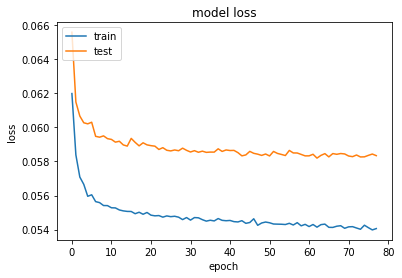

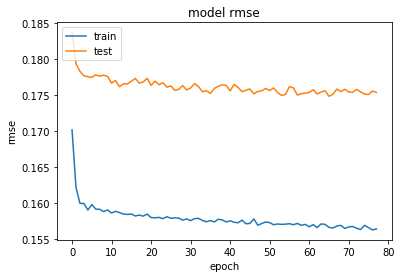

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

(5996, 25, 3) (5996, 10, 3)


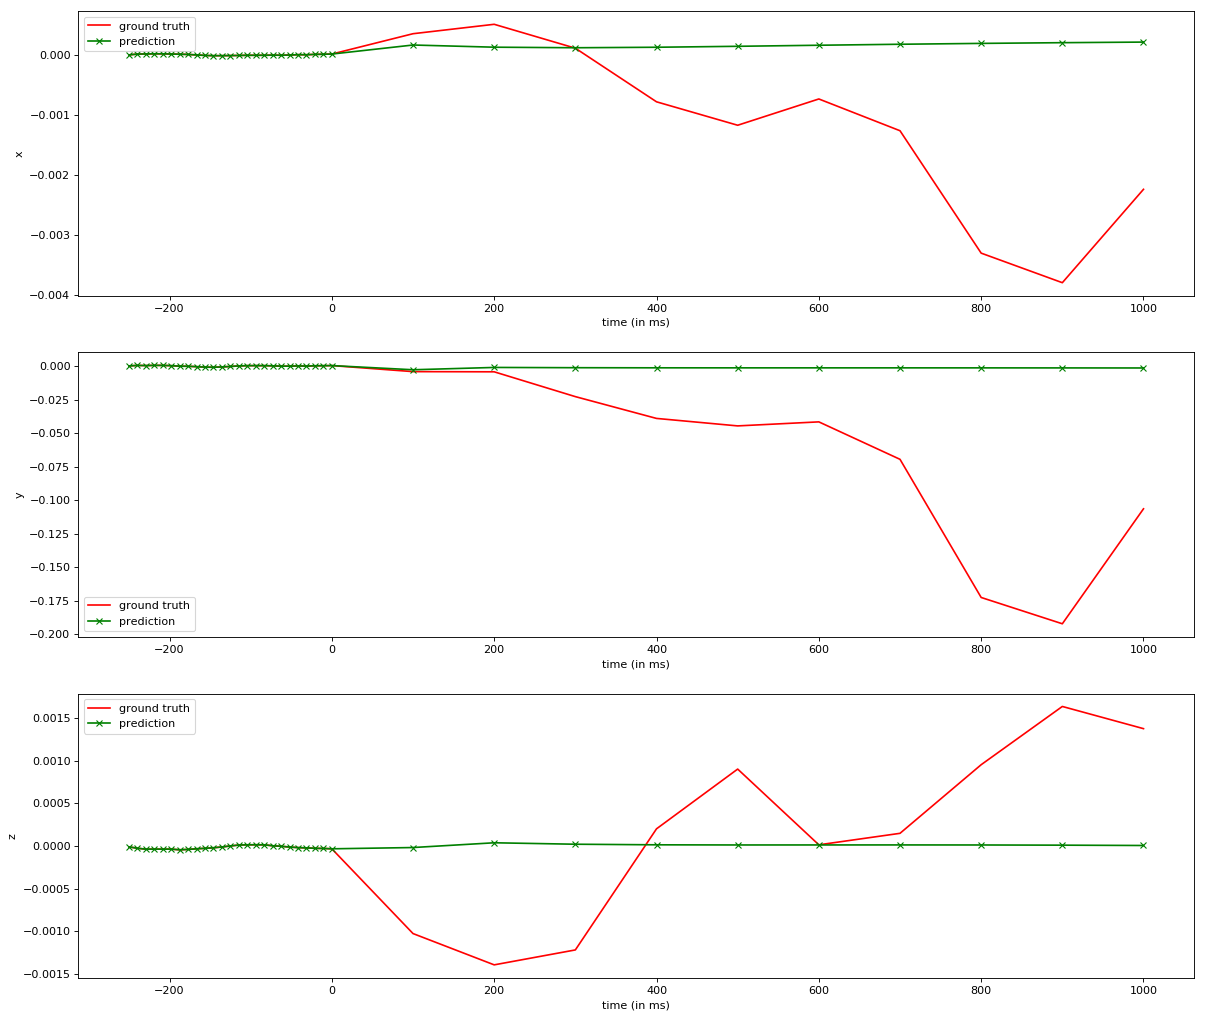

In [13]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )


predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]
        
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...


Evaluation Time :  99.12995052337646 s =  1.6521658539772033 min =  0.02753609769874149 h


### Metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.057509411533216905
Delay 100 ms: 0.004200573278350832
Delay 200 ms: 0.012523607376761553
Delay 300 ms: 0.023578726752365657
Delay 400 ms: 0.03599606731164721
Delay 500 ms: 0.04911525886824571
Delay 600 ms: 0.06263724581621684
Delay 700 ms: 0.07633266815731313
Delay 800 ms: 0.09004421619278388
Delay 900 ms: 0.1036393812273226
Delay 1000 ms: 0.11702637035116183

RMSE
Average rmse: 0.1215124556847412
Delay 100 ms: 0.011330878630090363
Delay 200 ms: 0.026700048479188117
Delay 300 ms: 0.046861715803594155
Delay 400 ms: 0.06894624935752941
Delay 500 ms: 0.09167577836207964
Delay 600 ms: 0.1145393368100257
Delay 700 ms: 0.1371728661336578
Delay 800 ms: 0.15938929233738064
Delay 900 ms: 0.18106459563688745
Delay 1000 ms: 0.20207374158439037

SMAPE
Average smape: 14.201315879722983
Delay 100 ms: 2.1728990859813937
Delay 200 ms: 5.243097590494922
Delay 300 ms: 8.299487564614184
Delay 400 ms: 11.157509827465812
Delay 500 ms: 13.763948343414116
Delay 600 ms: 16.165784430757327
D